In [5]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/Users/hunglungo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Package Preparation

In [6]:
# Import packages for scrapping from IOS App Store
from app_store_scraper import AppStore

# Import packages for data processing
import pandas as pd
import numpy as np
import json

# Import packages for topic modelling
# Reference: https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/
import nltk
from nltk import FreqDist

import re
import spacy

import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# text cleaning
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# Wordcloud of Top N words in each topic
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# Other pre-setting
pd.set_option("display.max_colwidth", 200)

# Function Preparation

In [7]:
# Function - Scrape review data from App Store
def app_store_scrapperNtransformer(app_name,country,how_many,export_csv_name):
    # Scrape the review data
    fetcher = AppStore(country, app_name)
    fetcher.review(how_many)
    
    # Transform data and put in DataFrame
    transformed_dataframe = pd.DataFrame(np.array(fetcher.reviews),columns=['review'])

    transformed_dataframe = transformed_dataframe.join(pd.DataFrame(transformed_dataframe.pop('review').tolist()))

    transformed_dataframe.to_csv(export_csv_name)

In [8]:
# Function - Plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()
    
# use for flattening out list of lists
def flatten(t):
    return [item for sublist in t for item in sublist]

In [9]:
# Text Cleaning
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

In [10]:
# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    # texts = [bigram_mod[doc] for doc in texts]
    # texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out


In [11]:
# Train LDA models and find optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, chunksize=1000, passes=50)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Scrapping Reviews

In [12]:
'''
app_store_scrapperNtransformer(app_name="Facebook",country="sg",
                           how_many=5000,export_csv_name="facebook_data_sg.csv")
'''
# Status: Completed

'\napp_store_scrapperNtransformer(app_name="Facebook",country="sg",\n                           how_many=5000,export_csv_name="facebook_data_sg.csv")\n'

# Basic Data Preparation

In [13]:
# Import scrapped data
facebook_ios_sg_review = pd.read_csv("facebook_data_sg.csv")

In [14]:
# Inspect the data
facebook_ios_sg_review.head()

Unnamed: 0  rating                                              title  \
0           0       3          Random video plays after watching a video   
1           1       1     Stop having 2 advertisements & regular updates   
2           2       1  Stop censoring/deleting Palestine support content   
3           3       1    FB abruptly disabled my account without warning   
4           4       1                               Greed has taken over   

   isEdited                 date      userName  \
0     False  2018-07-05 09:00:32       meltie8   
1     False  2019-10-20 15:37:46     Kathylinz   
2     False  2021-05-19 04:16:06  Harounchahed   
3     False  2020-03-07 12:29:04  Flashzflashz   
4     False  2021-05-02 05:52:48       L0relei   

                                                                                                                                                                                                    review  
0  Please remove the feature of playing a random next video after viewing a video. I was showing my kids a kids video and when it ended, it jumped to something near explicit with a woman wearing plun...  
1  Its so irritating and frustrating to keep having advertisements i know its part of the regulations but pleaseee stop having sooooo much ads and please stop with regular updates.. yes we all know i...  
2  Very disappointed in the choices of FB - as a powerful tech giant, you have a SOCIAL RESPONSIBILTY to let people make their voices heard and expose the genocide happening in Palestine - you are wi...  
3  FB allowed me to create my account and build up my friends network and when I started using FB on a regular basis, FB abruptly disabled my account without any warning-> reason being FB required me...  
4  I can understand that as a free usage social media platform, Facebook needs to earn from the advertisement, but you’re getting too greedy.\n\nReported some scam advertisements which used fake popu...

In [20]:
# Sort by date, only keep data between 2018 and 2021, clean columns
facebook_ios_sg_review_YearMonth = (facebook_ios_sg_review.copy()
                                                      .sort_values(by='date')
                                                      .reset_index()
                                                      .drop(columns=['index','Unnamed: 0'])
                                                      .query("`date` > '2017-12-31 23:59:59' and \
                                                             `date` < '2021-12-31 23:59:59'")
                                     ) 
# Remove time from date column
facebook_ios_sg_review_YearMonth['date'] = pd.to_datetime(facebook_ios_sg_review_YearMonth['date']).dt.floor('d')

# Create year column
facebook_ios_sg_review_YearMonth['year'] = pd.DatetimeIndex(facebook_ios_sg_review_YearMonth['date']).year

# Create month column
facebook_ios_sg_review_YearMonth['month'] = pd.DatetimeIndex(facebook_ios_sg_review_YearMonth['date']).month

In [16]:
# Inspect the dataframe again after cleaning
facebook_ios_sg_review_YearMonth.head()

rating                        title  isEdited       date  \
299       1    App doesn't work properly     False 2018-01-09   
300       5  Myanmar fonts(zawgyi fonts)     False 2018-01-12   
301       1                Video problem     False 2018-01-12   
302       1         Facebook Album Error     False 2018-01-13   
303       1                     Facebook     False 2018-01-14   

             userName  \
299  Victorvictor1234   
300    GreenApple1048   
301          Eltonggg   
302         Rozie5dil   
303     Ezone Fashion   

                                                                                                                                                                                                      review  \
299                           After updating the app to the latest version, the newsfeed can't load at all. Left with nothing but a broken app. Tried deleting the app and reinstalling it, but to no avail.   
300  Hi guy!! \nI would like to recommend you to fix Myanmar fonts(zawgyi fonts) because we get the problem ever it. Myanmar fonts have two kinds (1)unicode and (2)zawgyi so I think you should fix zawg...   
301  I had tried several times of re-download my Fb apps. Having problems on the auto played video! Tried Setting , delete n downloaded still can work. Kind of frustrating not having the auto play video .   
302                                                                                                                       After the recent update, most of the photo album in facebook gone. Please rectify.   
303                                                                                                                                              Photo Albums All Gone !!!\nBring Back The Complete Set !!!!   

     year  month  
299  2018      1  
300  2018      1  
301  2018      1  
302  2018      1  
303  2018      1

# EDA

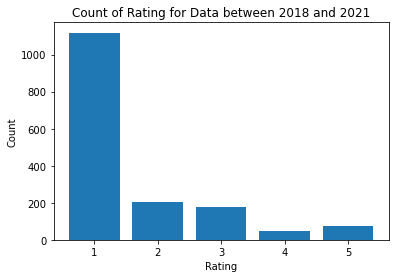

In [17]:
# Plot the count of different ratings for data between 2018 and 2021
facebook_ios_sg_review_score_count = facebook_ios_sg_review_YearMonth.groupby(['rating'])[['review']].nunique().rename(columns={'review':'count'})

plt.bar(facebook_ios_sg_review_score_count.index,facebook_ios_sg_review_score_count['count'])
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Count of Rating for Data between 2018 and 2021")
plt.show()

Text(0.5, 1.0, 'Count of Rating for Each Year between 2018 and 2021')

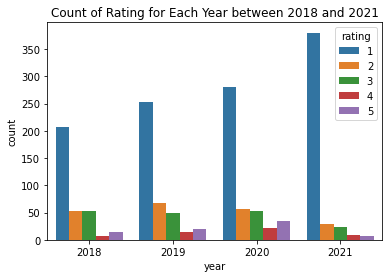

In [18]:
# Plot the count of different ratings for each year
facebook_ios_sg_review_score_count_ByYear = (facebook_ios_sg_review_YearMonth.groupby(['year','rating'])[['review']]
                                                                        .nunique()
                                                                        .rename(columns={'review':'count'})
                                                                        .reset_index()
                                              )

(sns.barplot(data=facebook_ios_sg_review_score_count_ByYear,x='year',y='count',hue='rating')
   .set_title("Count of Rating for Each Year between 2018 and 2021")
)

# Comment: extreme review score on 1 or 5

In [19]:
# Understand average ratings over year
facebook_ios_sg_review_avg_score_ByYear = (facebook_ios_sg_review_YearMonth.groupby(['year'])[['rating']]
                                                                       .mean()
                                              )

facebook_ios_sg_review_avg_score_ByYear['count'] = facebook_ios_sg_review_score_count_ByYear.groupby('year')[['count']].sum().values

print('Average ratings and count of each year:')
facebook_ios_sg_review_avg_score_ByYear

Average ratings and count of each year:


rating  count
year                 
2018  1.719403    333
2019  1.715347    404
2020  1.813483    445
2021  1.282276    448

# Dataframe Preparation for Topic Modelling

In [21]:
# Dataframe with data between 2018 and 2021 without score or year filtering
facebook_ios_sg_review_YearMonth.head()

rating                        title  isEdited       date  \
299       1    App doesn't work properly     False 2018-01-09   
300       5  Myanmar fonts(zawgyi fonts)     False 2018-01-12   
301       1                Video problem     False 2018-01-12   
302       1         Facebook Album Error     False 2018-01-13   
303       1                     Facebook     False 2018-01-14   

             userName  \
299  Victorvictor1234   
300    GreenApple1048   
301          Eltonggg   
302         Rozie5dil   
303     Ezone Fashion   

                                                                                                                                                                                                      review  \
299                           After updating the app to the latest version, the newsfeed can't load at all. Left with nothing but a broken app. Tried deleting the app and reinstalling it, but to no avail.   
300  Hi guy!! \nI would like to recommend you to fix Myanmar fonts(zawgyi fonts) because we get the problem ever it. Myanmar fonts have two kinds (1)unicode and (2)zawgyi so I think you should fix zawg...   
301  I had tried several times of re-download my Fb apps. Having problems on the auto played video! Tried Setting , delete n downloaded still can work. Kind of frustrating not having the auto play video .   
302                                                                                                                       After the recent update, most of the photo album in facebook gone. Please rectify.   
303                                                                                                                                              Photo Albums All Gone !!!\nBring Back The Complete Set !!!!   

     year  month  
299  2018      1  
300  2018      1  
301  2018      1  
302  2018      1  
303  2018      1

In [22]:
# Prepare dataframe for topic modelling for each score
# Obtain 5 dataframes with only score=1,2,3,4,5
facebook_ios_sg_review_YearMonth_score1 = facebook_ios_sg_review_YearMonth[facebook_ios_sg_review_YearMonth['rating']==1]
facebook_ios_sg_review_YearMonth_score2 = facebook_ios_sg_review_YearMonth[facebook_ios_sg_review_YearMonth['rating']==2]
facebook_ios_sg_review_YearMonth_score3 = facebook_ios_sg_review_YearMonth[facebook_ios_sg_review_YearMonth['rating']==3]
facebook_ios_sg_review_YearMonth_score4 = facebook_ios_sg_review_YearMonth[facebook_ios_sg_review_YearMonth['rating']==4]
facebook_ios_sg_review_YearMonth_score5 = facebook_ios_sg_review_YearMonth[facebook_ios_sg_review_YearMonth['rating']==5]


In [23]:
# Prepare dataframe for grouped score
facebook_ios_sg_review_YearMonth_score1N2N3 = facebook_ios_sg_review_YearMonth[facebook_ios_sg_review_YearMonth['rating'].isin([1,2,3])]
facebook_ios_sg_review_YearMonth_score4N5 = facebook_ios_sg_review_YearMonth[facebook_ios_sg_review_YearMonth['rating'].isin([4,5])]


In [24]:
# Prepare dataframe for topic modelling for 2018,2019,2020,2021 for score = 1,2,3
facebook_ios_sg_review_YearMonth_2018_score1N2N3 = facebook_ios_sg_review_YearMonth[(facebook_ios_sg_review_YearMonth['year']==2018)&(facebook_ios_sg_review_YearMonth['rating'].isin([1,2,3]))]
facebook_ios_sg_review_YearMonth_2019_score1N2N3 = facebook_ios_sg_review_YearMonth[(facebook_ios_sg_review_YearMonth['year']==2019)&(facebook_ios_sg_review_YearMonth['rating'].isin([1,2,3]))]
facebook_ios_sg_review_YearMonth_2020_score1N2N3 = facebook_ios_sg_review_YearMonth[(facebook_ios_sg_review_YearMonth['year']==2020)&(facebook_ios_sg_review_YearMonth['rating'].isin([1,2,3]))]
facebook_ios_sg_review_YearMonth_2021_score1N2N3 = facebook_ios_sg_review_YearMonth[(facebook_ios_sg_review_YearMonth['year']==2021)&(facebook_ios_sg_review_YearMonth['rating'].isin([1,2,3]))]




# Overall LDA Topic Modelling

In [25]:
# Overall Topic Modelling - data between 2018 and 2021 without score or year filtering
# Convert to list - move to each section
review_sg = facebook_ios_sg_review_YearMonth.review.values.tolist()
review_words_sg = list(sent_to_words(review_sg))
print(review_words_sg[:1])

[['after', 'updating', 'the', 'app', 'to', 'the', 'latest', 'version', 'the', 'newsfeed', 'cant', 'load', 'at', 'all', 'left', 'with', 'nothing', 'but', 'broken', 'app', 'tried', 'deleting', 'the', 'app', 'and', 'reinstalling', 'it', 'but', 'to', 'no', 'avail']]


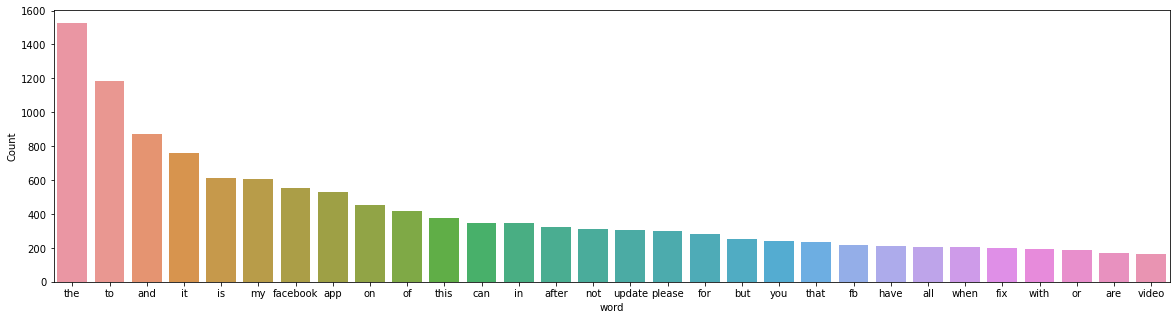

In [26]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg))

In [27]:
# Clean text
review_sg_ready = process_words(review_words_sg)  # processed Text Data! - move to each section

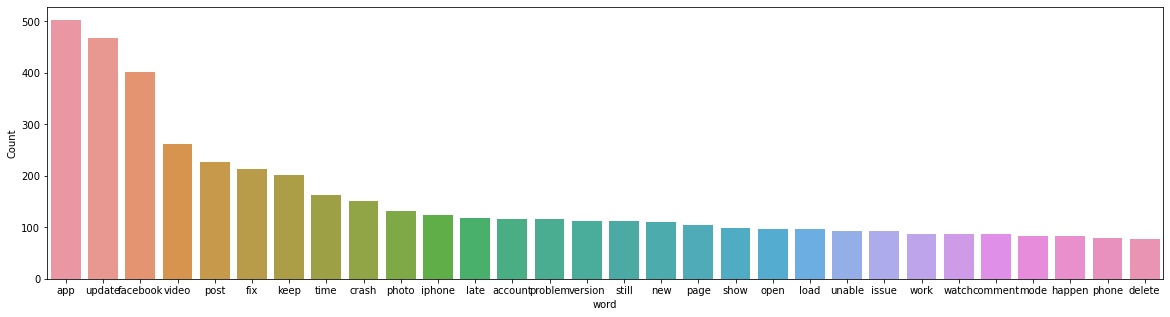

In [28]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_sg_ready))

In [29]:
# Create Dictionary
id2word_sg = corpora.Dictionary(review_sg_ready)

2021-10-16 18:08:46,624 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 18:08:46,731 [INFO] gensim.corpora.dictionary - built Dictionary(2161 unique tokens: ['app', 'avail', 'broken', 'delete', 'late']...) from 1641 documents (total 15622 corpus positions)
2021-10-16 18:08:46,774 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(2161 unique tokens: ['app', 'avail', 'broken', 'delete', 'late']...) from 1641 documents (total 15622 corpus positions)", 'datetime': '2021-10-16T18:08:46.733222', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [30]:
# Create Corpus: Term Document Frequency
corpus_sg = [id2word_sg.doc2bow(text) for text in review_sg_ready]

In [31]:
# Training LDA model
model_list_sg, coherence_values_sg = compute_coherence_values(dictionary=id2word_sg, corpus=corpus_sg, 
                                                              texts=review_sg_ready, limit=30, start=2, step=5)

# Time Start: 03:44
# Time End: 
# Time Used: 

2021-10-16 18:08:46,886 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 18:08:46,888 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 18:08:46,898 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:08:46,903 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 1641 documents, updating model once every 1000 documents, evaluating perplexity every 1641 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:08:46,910 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1000/1641
2021-10-16 18:08:50,085 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:08:50,090 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"video" + 0.028*"update" + 0.018*"fix" + 0.014*"facebook" + 0.014*"app" + 0.013*"post" + 0.011*"comment" + 0.010*"photo" + 0.010*"late"

2021-10-16 18:09:05,950 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1641/1641
2021-10-16 18:09:06,601 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:09:06,603 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.027*"video" + 0.014*"post" + 0.013*"photo" + 0.012*"mode" + 0.011*"update" + 0.011*"dark" + 0.010*"watch" + 0.009*"facebook" + 0.009*"comment" + 0.009*"stop"
2021-10-16 18:09:06,606 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.045*"app" + 0.037*"facebook" + 0.029*"update" + 0.016*"keep" + 0.014*"account" + 0.014*"time" + 0.013*"fix" + 0.012*"post" + 0.011*"crash" + 0.009*"iphone"
2021-10-16 18:09:06,607 [INFO] gensim.models.ldamodel - topic diff=0.245313, rho=0.388046
2021-10-16 18:09:06,608 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #1000/1641
2021-10-16 18:09:07,820 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-

2021-10-16 18:09:18,537 [INFO] gensim.models.ldamodel - topic diff=0.175349, rho=0.293093
2021-10-16 18:09:19,346 [INFO] gensim.models.ldamodel - -6.820 per-word bound, 113.0 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:09:19,348 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #1641/1641
2021-10-16 18:09:19,930 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:09:19,941 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.028*"video" + 0.015*"photo" + 0.014*"post" + 0.012*"mode" + 0.010*"dark" + 0.010*"watch" + 0.009*"comment" + 0.009*"stop" + 0.009*"ad" + 0.009*"facebook"
2021-10-16 18:09:19,944 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.047*"app" + 0.037*"facebook" + 0.033*"update" + 0.017*"keep" + 0.016*"fix" + 0.014*"account" + 0.014*"time" + 0.012*"post" + 0.012*"crash" + 0.010*"iphone"
2021-10-16 18:09:19,947 [INFO] gensim.models.ldamodel - topic di

2021-10-16 18:09:30,836 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.049*"app" + 0.040*"update" + 0.035*"facebook" + 0.020*"keep" + 0.017*"fix" + 0.015*"crash" + 0.014*"time" + 0.012*"account" + 0.012*"post" + 0.011*"iphone"
2021-10-16 18:09:30,837 [INFO] gensim.models.ldamodel - topic diff=0.140881, rho=0.245138
2021-10-16 18:09:31,718 [INFO] gensim.models.ldamodel - -6.805 per-word bound, 111.9 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:09:31,719 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #1641/1641
2021-10-16 18:09:32,332 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:09:32,335 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"video" + 0.015*"photo" + 0.013*"post" + 0.012*"mode" + 0.010*"dark" + 0.010*"watch" + 0.010*"comment" + 0.009*"ad" + 0.009*"stop" + 0.008*"facebook"
2021-10-16 18:09:32,336 [INFO] gensim.models.ldamodel - topic #

2021-10-16 18:09:42,585 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.032*"video" + 0.016*"photo" + 0.013*"post" + 0.011*"mode" + 0.011*"watch" + 0.011*"comment" + 0.009*"ad" + 0.009*"dark" + 0.009*"view" + 0.009*"stop"
2021-10-16 18:09:42,586 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.049*"app" + 0.040*"update" + 0.035*"facebook" + 0.020*"keep" + 0.018*"fix" + 0.014*"crash" + 0.014*"time" + 0.012*"account" + 0.012*"post" + 0.012*"iphone"
2021-10-16 18:09:42,587 [INFO] gensim.models.ldamodel - topic diff=0.121038, rho=0.214962
2021-10-16 18:09:43,243 [INFO] gensim.models.ldamodel - -6.796 per-word bound, 111.1 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:09:43,245 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #1641/1641
2021-10-16 18:09:43,870 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:09:43,878 [INFO] gensim.models.ldamodel - topic #0 (0

2021-10-16 18:09:53,979 [INFO] gensim.models.ldamodel - topic diff=0.108458, rho=0.197484
2021-10-16 18:09:53,981 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1000/1641
2021-10-16 18:09:54,968 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:09:54,971 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.032*"video" + 0.016*"photo" + 0.013*"post" + 0.011*"mode" + 0.011*"watch" + 0.011*"comment" + 0.009*"view" + 0.009*"ad" + 0.009*"dark" + 0.009*"stop"
2021-10-16 18:09:54,972 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.049*"app" + 0.040*"update" + 0.035*"facebook" + 0.020*"keep" + 0.018*"fix" + 0.014*"crash" + 0.014*"time" + 0.012*"account" + 0.012*"post" + 0.012*"iphone"
2021-10-16 18:09:54,974 [INFO] gensim.models.ldamodel - topic diff=0.107076, rho=0.193742
2021-10-16 18:09:55,760 [INFO] gensim.models.ldamodel - -6.790 per-word bound, 110.7 perplexity estimate based on a held-out corpus of 641 do

2021-10-16 18:10:05,434 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.048*"app" + 0.037*"update" + 0.036*"facebook" + 0.018*"keep" + 0.018*"fix" + 0.014*"time" + 0.014*"account" + 0.012*"post" + 0.012*"crash" + 0.011*"iphone"
2021-10-16 18:10:05,435 [INFO] gensim.models.ldamodel - topic diff=0.098221, rho=0.180654
2021-10-16 18:10:05,437 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #1000/1641
2021-10-16 18:10:06,224 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:10:06,227 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.032*"video" + 0.016*"photo" + 0.013*"post" + 0.011*"mode" + 0.011*"watch" + 0.011*"comment" + 0.009*"view" + 0.009*"ad" + 0.009*"dark" + 0.009*"stop"
2021-10-16 18:10:06,232 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.050*"app" + 0.041*"update" + 0.035*"facebook" + 0.019*"keep" + 0.018*"fix" + 0.014*"crash" + 0.014*"time" + 0.013*"account" + 0.012*"post" + 0.012*"iphone"

2021-10-16 18:10:16,339 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"video" + 0.015*"photo" + 0.013*"post" + 0.012*"mode" + 0.010*"watch" + 0.010*"dark" + 0.010*"comment" + 0.009*"ad" + 0.009*"stop" + 0.009*"view"
2021-10-16 18:10:16,341 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.048*"app" + 0.038*"update" + 0.036*"facebook" + 0.018*"keep" + 0.018*"fix" + 0.014*"time" + 0.014*"account" + 0.012*"post" + 0.012*"crash" + 0.012*"iphone"
2021-10-16 18:10:16,342 [INFO] gensim.models.ldamodel - topic diff=0.090501, rho=0.167504
2021-10-16 18:10:16,342 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #1000/1641
2021-10-16 18:10:17,175 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:10:17,183 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.032*"video" + 0.016*"photo" + 0.013*"post" + 0.011*"mode" + 0.011*"watch" + 0.011*"comment" + 0.009*"view" + 0.009*"ad" + 0.009*"dark" + 0.009*"stop"
2021-

2021-10-16 18:10:27,217 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #1641/1641
2021-10-16 18:10:27,715 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:10:27,719 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"video" + 0.015*"photo" + 0.013*"post" + 0.012*"mode" + 0.010*"watch" + 0.010*"dark" + 0.010*"comment" + 0.009*"ad" + 0.009*"stop" + 0.009*"view"
2021-10-16 18:10:27,721 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.048*"app" + 0.039*"update" + 0.036*"facebook" + 0.018*"keep" + 0.018*"fix" + 0.014*"time" + 0.014*"account" + 0.012*"post" + 0.012*"crash" + 0.012*"iphone"
2021-10-16 18:10:27,723 [INFO] gensim.models.ldamodel - topic diff=0.084465, rho=0.156862
2021-10-16 18:10:27,726 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #1000/1641
2021-10-16 18:10:28,607 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 

2021-10-16 18:10:37,975 [INFO] gensim.models.ldamodel - topic diff=0.079666, rho=0.148021
2021-10-16 18:10:38,706 [INFO] gensim.models.ldamodel - -6.776 per-word bound, 109.6 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:10:38,708 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1641/1641
2021-10-16 18:10:39,224 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:10:39,226 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"video" + 0.015*"photo" + 0.013*"post" + 0.012*"mode" + 0.010*"watch" + 0.010*"dark" + 0.010*"comment" + 0.009*"ad" + 0.009*"stop" + 0.009*"view"
2021-10-16 18:10:39,228 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.048*"app" + 0.039*"update" + 0.036*"facebook" + 0.018*"keep" + 0.018*"fix" + 0.014*"time" + 0.013*"account" + 0.012*"crash" + 0.012*"post" + 0.012*"iphone"
2021-10-16 18:10:39,229 [INFO] gensim.models.ldamodel - topic diff=

2021-10-16 18:10:49,125 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.049*"app" + 0.042*"update" + 0.034*"facebook" + 0.019*"keep" + 0.019*"fix" + 0.014*"crash" + 0.014*"time" + 0.013*"account" + 0.013*"post" + 0.012*"iphone"
2021-10-16 18:10:49,127 [INFO] gensim.models.ldamodel - topic diff=0.075327, rho=0.140523
2021-10-16 18:10:49,870 [INFO] gensim.models.ldamodel - -6.774 per-word bound, 109.4 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:10:49,872 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #1641/1641
2021-10-16 18:10:50,346 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:10:50,348 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"video" + 0.016*"photo" + 0.013*"post" + 0.012*"mode" + 0.010*"watch" + 0.010*"dark" + 0.010*"comment" + 0.010*"ad" + 0.009*"stop" + 0.009*"view"
2021-10-16 18:10:50,350 [INFO] gensim.models.ldamodel - topic #1 (0

2021-10-16 18:11:04,941 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.049*"post" + 0.031*"update" + 0.020*"comment" + 0.014*"show" + 0.014*"bad" + 0.012*"read" + 0.012*"new" + 0.012*"facebook" + 0.011*"share" + 0.011*"friend"
2021-10-16 18:11:04,943 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.086*"app" + 0.062*"update" + 0.035*"crash" + 0.035*"keep" + 0.031*"facebook" + 0.020*"time" + 0.018*"open" + 0.016*"fix" + 0.014*"late" + 0.013*"account"
2021-10-16 18:11:04,949 [INFO] gensim.models.ldamodel - topic diff=0.436253, rho=0.524070
2021-10-16 18:11:05,881 [INFO] gensim.models.ldamodel - -7.472 per-word bound, 177.6 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:11:05,921 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #1641/1641
2021-10-16 18:11:06,605 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:11:06,611 [INFO] gensim.models.ldamodel - topic #6

2021-10-16 18:11:11,973 [INFO] gensim.models.ldamodel - topic diff=0.236897, rho=0.421039
2021-10-16 18:11:11,975 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1000/1641
2021-10-16 18:11:13,005 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:11:13,010 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.038*"mode" + 0.030*"dark" + 0.015*"facebook" + 0.014*"update" + 0.013*"user" + 0.011*"app" + 0.011*"still" + 0.009*"ipad" + 0.009*"year" + 0.009*"apple"
2021-10-16 18:11:13,012 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.054*"facebook" + 0.016*"account" + 0.015*"support" + 0.012*"news" + 0.012*"friend" + 0.011*"humanity" + 0.010*"share" + 0.010*"name" + 0.010*"option" + 0.010*"people"
2021-10-16 18:11:13,015 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.042*"photo" + 0.026*"fix" + 0.025*"facebook" + 0.021*"album" + 0.019*"unable" + 0.018*"page" + 0.017*"post" + 0.016*"load" + 0.013*"app" + 0.0

2021-10-16 18:11:19,352 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.086*"app" + 0.066*"update" + 0.033*"keep" + 0.029*"facebook" + 0.025*"crash" + 0.023*"time" + 0.022*"fix" + 0.020*"late" + 0.019*"iphone" + 0.018*"open"
2021-10-16 18:11:19,354 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.041*"photo" + 0.025*"fix" + 0.023*"facebook" + 0.020*"post" + 0.020*"page" + 0.019*"album" + 0.015*"unable" + 0.014*"show" + 0.013*"notification" + 0.012*"app"
2021-10-16 18:11:19,356 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.043*"mode" + 0.037*"dark" + 0.018*"facebook" + 0.014*"user" + 0.012*"app" + 0.011*"update" + 0.011*"freedom" + 0.009*"allow" + 0.009*"still" + 0.009*"year"
2021-10-16 18:11:19,358 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.099*"video" + 0.028*"play" + 0.026*"watch" + 0.015*"speech" + 0.013*"datum" + 0.011*"sound" + 0.010*"update" + 0.010*"annoying" + 0.010*"always" + 0.010*"much"
2021-10-16 18:11:19,362 [INFO] gensim.models.ldamodel - topic #4 (0

2021-10-16 18:11:25,362 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.030*"ad" + 0.025*"stop" + 0.023*"live" + 0.015*"watch" + 0.014*"facebook" + 0.012*"happen" + 0.012*"advertisement" + 0.012*"video" + 0.010*"ban" + 0.009*"stupid"
2021-10-16 18:11:25,364 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.069*"post" + 0.026*"comment" + 0.017*"show" + 0.016*"read" + 0.016*"group" + 0.015*"update" + 0.015*"remove" + 0.014*"newsfeed" + 0.014*"bad" + 0.014*"share"
2021-10-16 18:11:25,367 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.085*"app" + 0.075*"update" + 0.036*"keep" + 0.030*"crash" + 0.028*"facebook" + 0.024*"fix" + 0.023*"late" + 0.022*"time" + 0.019*"iphone" + 0.018*"open"
2021-10-16 18:11:25,369 [INFO] gensim.models.ldamodel - topic diff=0.126796, rho=0.293093
2021-10-16 18:11:26,214 [INFO] gensim.models.ldamodel - -6.989 per-word bound, 127.0 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:11:26,216 [INFO] gensim.models

2021-10-16 18:11:31,774 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.112*"video" + 0.031*"watch" + 0.030*"play" + 0.015*"speech" + 0.014*"datum" + 0.013*"annoying" + 0.013*"sound" + 0.010*"screen" + 0.010*"much" + 0.010*"always"
2021-10-16 18:11:31,775 [INFO] gensim.models.ldamodel - topic diff=0.110173, rho=0.270755
2021-10-16 18:11:31,777 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #1000/1641
2021-10-16 18:11:32,659 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:11:32,665 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.043*"mode" + 0.034*"dark" + 0.018*"facebook" + 0.014*"user" + 0.011*"update" + 0.011*"app" + 0.010*"apple" + 0.010*"year" + 0.010*"ipad" + 0.009*"allow"
2021-10-16 18:11:32,667 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.123*"video" + 0.035*"play" + 0.032*"watch" + 0.015*"sound" + 0.015*"datum" + 0.014*"annoying" + 0.012*"screen" + 0.011*"speech" + 0.010*"page" + 0.0

2021-10-16 18:11:37,978 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #1641/1641
2021-10-16 18:11:38,477 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:11:38,481 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.083*"app" + 0.069*"update" + 0.034*"keep" + 0.028*"facebook" + 0.025*"fix" + 0.025*"crash" + 0.023*"time" + 0.021*"late" + 0.020*"iphone" + 0.017*"open"
2021-10-16 18:11:38,483 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.068*"facebook" + 0.031*"support" + 0.023*"account" + 0.017*"humanity" + 0.015*"share" + 0.014*"name" + 0.014*"block" + 0.012*"well" + 0.012*"news" + 0.011*"day"
2021-10-16 18:11:38,484 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.043*"photo" + 0.023*"fix" + 0.022*"facebook" + 0.022*"post" + 0.021*"page" + 0.020*"album" + 0.014*"notification" + 0.014*"show" + 0.013*"find" + 0.013*"unable"
2021-10-16 18:11:38,486 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.0

2021-10-16 18:11:43,973 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.033*"ad" + 0.026*"stop" + 0.024*"live" + 0.014*"advertisement" + 0.014*"facebook" + 0.012*"watch" + 0.011*"happen" + 0.010*"ban" + 0.010*"stupid" + 0.010*"people"
2021-10-16 18:11:43,974 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.044*"mode" + 0.035*"dark" + 0.018*"facebook" + 0.014*"user" + 0.011*"app" + 0.011*"update" + 0.010*"apple" + 0.010*"year" + 0.010*"allow" + 0.009*"ipad"
2021-10-16 18:11:43,976 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.069*"post" + 0.027*"comment" + 0.016*"group" + 0.016*"show" + 0.016*"remove" + 0.015*"read" + 0.014*"update" + 0.014*"bad" + 0.013*"newsfeed" + 0.013*"friend"
2021-10-16 18:11:43,977 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.125*"video" + 0.035*"play" + 0.033*"watch" + 0.016*"datum" + 0.016*"sound" + 0.015*"annoying" + 0.012*"screen" + 0.011*"speech" + 0.010*"page" + 0.010*"much"
2021-10-16 18:11:43,978 [INFO] gensim.models.ldamodel - topic d

2021-10-16 18:11:49,605 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.069*"post" + 0.025*"comment" + 0.016*"group" + 0.015*"show" + 0.015*"remove" + 0.014*"bad" + 0.014*"read" + 0.012*"newsfeed" + 0.012*"friend" + 0.012*"update"
2021-10-16 18:11:49,606 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.046*"mode" + 0.038*"dark" + 0.019*"facebook" + 0.014*"user" + 0.012*"app" + 0.011*"allow" + 0.011*"freedom" + 0.010*"update" + 0.010*"people" + 0.010*"year"
2021-10-16 18:11:49,607 [INFO] gensim.models.ldamodel - topic diff=0.083132, rho=0.214962
2021-10-16 18:11:49,608 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #1000/1641
2021-10-16 18:11:50,336 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:11:50,341 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.082*"app" + 0.076*"update" + 0.035*"keep" + 0.028*"crash" + 0.027*"facebook" + 0.025*"fix" + 0.022*"time" + 0.022*"late" + 0.020*"iphone" + 0.018

2021-10-16 18:11:54,685 [INFO] gensim.models.ldamodel - topic diff=0.077955, rho=0.201452
2021-10-16 18:11:55,503 [INFO] gensim.models.ldamodel - -6.939 per-word bound, 122.7 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:11:55,504 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #1641/1641
2021-10-16 18:11:56,095 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:11:56,100 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.082*"app" + 0.071*"update" + 0.033*"keep" + 0.027*"facebook" + 0.025*"fix" + 0.025*"crash" + 0.023*"time" + 0.021*"late" + 0.020*"iphone" + 0.017*"new"
2021-10-16 18:11:56,102 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.033*"ad" + 0.027*"stop" + 0.023*"live" + 0.016*"advertisement" + 0.013*"facebook" + 0.011*"happen" + 0.011*"ban" + 0.011*"watch" + 0.011*"people" + 0.010*"stupid"
2021-10-16 18:11:56,105 [INFO] gensim.models.ldamodel - to

2021-10-16 18:12:02,015 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.082*"app" + 0.076*"update" + 0.035*"keep" + 0.028*"crash" + 0.027*"facebook" + 0.025*"fix" + 0.023*"time" + 0.022*"late" + 0.020*"iphone" + 0.018*"version"
2021-10-16 18:12:02,018 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.045*"mode" + 0.036*"dark" + 0.018*"facebook" + 0.015*"user" + 0.011*"app" + 0.010*"year" + 0.010*"apple" + 0.010*"allow" + 0.010*"update" + 0.009*"freedom"
2021-10-16 18:12:02,020 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.033*"ad" + 0.026*"stop" + 0.024*"live" + 0.015*"advertisement" + 0.014*"facebook" + 0.011*"happen" + 0.011*"watch" + 0.011*"people" + 0.010*"ban" + 0.010*"stupid"
2021-10-16 18:12:02,023 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.069*"post" + 0.027*"comment" + 0.017*"remove" + 0.016*"group" + 0.016*"show" + 0.015*"read" + 0.014*"update" + 0.014*"bad" + 0.013*"newsfeed" + 0.013*"friend"
2021-10-16 18:12:02,025 [INFO] gensim.models.ldamodel - topic 

2021-10-16 18:12:08,169 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.072*"facebook" + 0.033*"support" + 0.027*"account" + 0.017*"share" + 0.017*"humanity" + 0.014*"name" + 0.013*"block" + 0.013*"well" + 0.012*"day" + 0.012*"news"
2021-10-16 18:12:08,172 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.034*"ad" + 0.027*"stop" + 0.022*"live" + 0.016*"advertisement" + 0.013*"facebook" + 0.011*"happen" + 0.011*"ban" + 0.011*"people" + 0.010*"bad" + 0.010*"stupid"
2021-10-16 18:12:08,175 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.043*"photo" + 0.023*"post" + 0.022*"page" + 0.022*"facebook" + 0.021*"fix" + 0.020*"album" + 0.014*"notification" + 0.014*"find" + 0.014*"show" + 0.012*"unable"
2021-10-16 18:12:08,178 [INFO] gensim.models.ldamodel - topic diff=0.069165, rho=0.183676
2021-10-16 18:12:08,180 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #1000/1641
2021-10-16 18:12:09,098 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a mo

2021-10-16 18:12:13,987 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.069*"post" + 0.027*"comment" + 0.017*"remove" + 0.016*"group" + 0.015*"show" + 0.015*"read" + 0.014*"update" + 0.014*"bad" + 0.013*"feed" + 0.013*"newsfeed"
2021-10-16 18:12:13,988 [INFO] gensim.models.ldamodel - topic diff=0.066366, rho=0.175032
2021-10-16 18:12:14,994 [INFO] gensim.models.ldamodel - -6.931 per-word bound, 122.0 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:12:15,005 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #1641/1641
2021-10-16 18:12:15,725 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:12:15,728 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.122*"video" + 0.035*"watch" + 0.031*"play" + 0.016*"datum" + 0.014*"speech" + 0.014*"annoying" + 0.014*"sound" + 0.011*"screen" + 0.010*"page" + 0.010*"much"
2021-10-16 18:12:15,732 [INFO] gensim.models.ldamodel - to

2021-10-16 18:12:21,366 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #1000/1641
2021-10-16 18:12:22,385 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:12:22,390 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.046*"mode" + 0.037*"dark" + 0.018*"facebook" + 0.015*"user" + 0.012*"app" + 0.011*"year" + 0.011*"apple" + 0.010*"allow" + 0.010*"freedom" + 0.009*"people"
2021-10-16 18:12:22,393 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.082*"app" + 0.077*"update" + 0.034*"keep" + 0.027*"crash" + 0.027*"facebook" + 0.025*"fix" + 0.023*"time" + 0.022*"late" + 0.020*"iphone" + 0.018*"version"
2021-10-16 18:12:22,397 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.128*"video" + 0.037*"watch" + 0.034*"play" + 0.017*"datum" + 0.015*"sound" + 0.015*"annoying" + 0.012*"screen" + 0.011*"speech" + 0.011*"page" + 0.010*"live"
2021-10-16 18:12:22,400 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.070*"

2021-10-16 18:12:31,100 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.123*"video" + 0.037*"watch" + 0.031*"play" + 0.017*"datum" + 0.014*"annoying" + 0.014*"speech" + 0.014*"sound" + 0.011*"screen" + 0.011*"page" + 0.010*"live"
2021-10-16 18:12:31,102 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.047*"mode" + 0.039*"dark" + 0.018*"facebook" + 0.015*"user" + 0.012*"app" + 0.011*"allow" + 0.011*"freedom" + 0.010*"year" + 0.010*"people" + 0.010*"apple"
2021-10-16 18:12:31,105 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.082*"app" + 0.074*"update" + 0.033*"keep" + 0.027*"facebook" + 0.025*"fix" + 0.025*"crash" + 0.023*"time" + 0.021*"late" + 0.020*"iphone" + 0.017*"new"
2021-10-16 18:12:31,107 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.043*"photo" + 0.023*"post" + 0.022*"page" + 0.021*"facebook" + 0.021*"fix" + 0.020*"album" + 0.014*"find" + 0.014*"notification" + 0.014*"show" + 0.012*"unable"
2021-10-16 18:12:31,108 [INFO] gensim.models.ldamodel - topic diff=0.

2021-10-16 18:12:37,932 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.128*"video" + 0.039*"watch" + 0.034*"play" + 0.018*"datum" + 0.015*"sound" + 0.015*"annoying" + 0.012*"screen" + 0.011*"speech" + 0.011*"live" + 0.011*"page"
2021-10-16 18:12:37,934 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.045*"photo" + 0.023*"page" + 0.022*"post" + 0.022*"facebook" + 0.021*"fix" + 0.021*"album" + 0.015*"find" + 0.014*"notification" + 0.013*"show" + 0.013*"unable"
2021-10-16 18:12:37,936 [INFO] gensim.models.ldamodel - topic diff=0.058930, rho=0.156862
2021-10-16 18:12:38,996 [INFO] gensim.models.ldamodel - -6.926 per-word bound, 121.6 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:12:38,997 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #1641/1641
2021-10-16 18:12:39,526 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:12:39,530 [INFO] gensim.models.ldamodel 

2021-10-16 18:12:45,884 [INFO] gensim.models.ldamodel - topic diff=0.056940, rho=0.153139
2021-10-16 18:12:45,886 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #1000/1641
2021-10-16 18:12:46,876 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:12:46,889 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.046*"mode" + 0.037*"dark" + 0.018*"facebook" + 0.015*"user" + 0.012*"app" + 0.011*"year" + 0.011*"apple" + 0.010*"allow" + 0.010*"freedom" + 0.009*"people"
2021-10-16 18:12:46,931 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.128*"video" + 0.039*"watch" + 0.034*"play" + 0.018*"datum" + 0.015*"sound" + 0.014*"annoying" + 0.012*"live" + 0.012*"screen" + 0.012*"speech" + 0.011*"page"
2021-10-16 18:12:46,962 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.068*"post" + 0.026*"comment" + 0.017*"remove" + 0.017*"group" + 0.015*"show" + 0.015*"read" + 0.014*"update" + 0.014*"bad" + 0.013*"feed" + 0.013*"

2021-10-16 18:12:55,251 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.047*"mode" + 0.039*"dark" + 0.018*"facebook" + 0.015*"user" + 0.012*"app" + 0.011*"freedom" + 0.011*"allow" + 0.010*"year" + 0.010*"people" + 0.010*"apple"
2021-10-16 18:12:55,257 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.068*"post" + 0.025*"comment" + 0.016*"remove" + 0.016*"group" + 0.015*"show" + 0.014*"read" + 0.014*"bad" + 0.013*"update" + 0.013*"feed" + 0.012*"newsfeed"
2021-10-16 18:12:55,259 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.082*"app" + 0.075*"update" + 0.033*"keep" + 0.027*"facebook" + 0.025*"fix" + 0.025*"crash" + 0.023*"time" + 0.021*"late" + 0.020*"iphone" + 0.017*"new"
2021-10-16 18:12:55,267 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.123*"video" + 0.038*"watch" + 0.031*"play" + 0.017*"datum" + 0.014*"annoying" + 0.014*"sound" + 0.014*"speech" + 0.012*"live" + 0.011*"screen" + 0.011*"page"
2021-10-16 18:12:55,274 [INFO] gensim.models.ldamodel - topic #0 (0.143):

2021-10-16 18:13:03,256 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.082*"app" + 0.078*"update" + 0.034*"keep" + 0.027*"crash" + 0.027*"facebook" + 0.025*"fix" + 0.023*"time" + 0.022*"late" + 0.020*"iphone" + 0.018*"version"
2021-10-16 18:13:03,258 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.071*"facebook" + 0.034*"support" + 0.027*"account" + 0.016*"share" + 0.015*"humanity" + 0.014*"name" + 0.012*"well" + 0.012*"block" + 0.012*"day" + 0.011*"news"
2021-10-16 18:13:03,260 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.068*"post" + 0.026*"comment" + 0.017*"remove" + 0.017*"group" + 0.015*"show" + 0.015*"read" + 0.014*"update" + 0.014*"bad" + 0.013*"feed" + 0.013*"newsfeed"
2021-10-16 18:13:03,263 [INFO] gensim.models.ldamodel - topic diff=0.053472, rho=0.143383
2021-10-16 18:13:04,599 [INFO] gensim.models.ldamodel - -6.921 per-word bound, 121.2 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:13:04,600 [INFO] gensim.model

2021-10-16 18:13:11,662 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.082*"app" + 0.075*"update" + 0.033*"keep" + 0.027*"facebook" + 0.025*"fix" + 0.025*"crash" + 0.023*"time" + 0.021*"late" + 0.020*"iphone" + 0.017*"new"
2021-10-16 18:13:11,674 [INFO] gensim.models.ldamodel - topic diff=0.051869, rho=0.140523
2021-10-16 18:13:11,677 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #1000/1641
2021-10-16 18:13:12,827 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:13:12,845 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.071*"facebook" + 0.034*"support" + 0.028*"account" + 0.016*"share" + 0.015*"humanity" + 0.014*"name" + 0.012*"well" + 0.012*"block" + 0.012*"day" + 0.011*"news"
2021-10-16 18:13:12,854 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.046*"mode" + 0.037*"dark" + 0.017*"facebook" + 0.015*"user" + 0.012*"app" + 0.011*"year" + 0.011*"apple" + 0.010*"allow" + 0.010*"freedom" + 0.009*"

2021-10-16 18:13:30,613 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.066*"photo" + 0.034*"album" + 0.030*"post" + 0.027*"app" + 0.023*"update" + 0.017*"facebook" + 0.013*"feature" + 0.012*"miss" + 0.011*"upload" + 0.011*"fix"
2021-10-16 18:13:30,619 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.043*"facebook" + 0.025*"update" + 0.020*"app" + 0.020*"fix" + 0.019*"video" + 0.015*"bug" + 0.015*"watch" + 0.014*"friend" + 0.014*"give" + 0.012*"problem"
2021-10-16 18:13:30,629 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.044*"post" + 0.023*"update" + 0.019*"comment" + 0.017*"ad" + 0.016*"show" + 0.016*"user" + 0.015*"facebook" + 0.012*"share" + 0.012*"keep" + 0.012*"friend"
2021-10-16 18:13:30,636 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.063*"video" + 0.023*"play" + 0.021*"update" + 0.019*"watch" + 0.018*"sound" + 0.013*"scroll" + 0.012*"app" + 0.012*"work" + 0.012*"fix" + 0.011*"version"
2021-10-16 18:13:30,637 [INFO] gensim.models.ldamodel - topic diff=0.3158

2021-10-16 18:13:40,553 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.069*"facebook" + 0.037*"support" + 0.024*"block" + 0.022*"share" + 0.021*"humanity" + 0.019*"people" + 0.013*"news" + 0.013*"biased" + 0.013*"post" + 0.012*"day"
2021-10-16 18:13:40,554 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.084*"photo" + 0.041*"album" + 0.027*"post" + 0.019*"update" + 0.017*"app" + 0.016*"feature" + 0.016*"miss" + 0.015*"facebook" + 0.014*"help" + 0.013*"view"
2021-10-16 18:13:40,557 [INFO] gensim.models.ldamodel - topic diff=0.309206, rho=0.421039
2021-10-16 18:13:40,563 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1000/1641
2021-10-16 18:13:42,200 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:13:42,208 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.047*"stop" + 0.021*"watch" + 0.019*"ban" + 0.018*"platform" + 0.016*"ad" + 0.014*"fix" + 0.013*"force" + 0.012*"account" + 0.012*"medium" + 0.01

2021-10-16 18:13:49,486 [INFO] gensim.models.ldamodel - -7.213 per-word bound, 148.3 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:13:49,487 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #1641/1641
2021-10-16 18:13:50,140 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:13:50,147 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.111*"app" + 0.076*"update" + 0.046*"keep" + 0.038*"crash" + 0.030*"facebook" + 0.027*"time" + 0.026*"fix" + 0.023*"open" + 0.022*"late" + 0.019*"new"
2021-10-16 18:13:50,150 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.034*"facebook" + 0.022*"give" + 0.020*"account" + 0.018*"name" + 0.018*"friend" + 0.015*"reporting" + 0.014*"real" + 0.013*"sometime" + 0.012*"bug" + 0.012*"app"
2021-10-16 18:13:50,155 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.096*"mode" + 0.082*"dark" + 0.027*"iphone" + 0.025*"facebook" + 0.023*"io" +

2021-10-16 18:13:56,590 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.050*"stop" + 0.020*"ban" + 0.018*"platform" + 0.014*"ad" + 0.013*"force" + 0.013*"medium" + 0.012*"account" + 0.012*"social" + 0.011*"censor" + 0.011*"watch"
2021-10-16 18:13:56,598 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.043*"load" + 0.035*"fix" + 0.032*"unable" + 0.031*"page" + 0.030*"notification" + 0.027*"update" + 0.025*"app" + 0.021*"show" + 0.019*"facebook" + 0.016*"post"
2021-10-16 18:13:56,610 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.114*"app" + 0.087*"update" + 0.050*"keep" + 0.046*"crash" + 0.031*"facebook" + 0.028*"fix" + 0.025*"time" + 0.025*"late" + 0.024*"open" + 0.020*"new"
2021-10-16 18:13:56,619 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.065*"facebook" + 0.035*"support" + 0.024*"share" + 0.022*"block" + 0.019*"people" + 0.017*"humanity" + 0.013*"account" + 0.012*"post" + 0.011*"well" + 0.011*"day"
2021-10-16 18:13:56,623 [INFO] gensim.models.ldamodel - topic dif

2021-10-16 18:14:03,475 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.052*"stop" + 0.022*"ban" + 0.019*"platform" + 0.015*"censor" + 0.014*"medium" + 0.014*"social" + 0.013*"zionist" + 0.012*"account" + 0.012*"ad" + 0.011*"support"
2021-10-16 18:14:03,553 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.070*"facebook" + 0.037*"support" + 0.022*"block" + 0.021*"share" + 0.020*"people" + 0.019*"humanity" + 0.017*"account" + 0.012*"post" + 0.012*"biased" + 0.011*"day"
2021-10-16 18:14:03,604 [INFO] gensim.models.ldamodel - topic diff=0.095035, rho=0.270755
2021-10-16 18:14:03,607 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #1000/1641
2021-10-16 18:14:04,885 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:14:04,899 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.038*"live" + 0.033*"comment" + 0.030*"facebook" + 0.022*"view" + 0.020*"time" + 0.020*"change" + 0.019*"thing" + 0.018*"post" + 0.016*

2021-10-16 18:14:11,394 [INFO] gensim.models.ldamodel - topic diff=0.084995, rho=0.245138
2021-10-16 18:14:12,236 [INFO] gensim.models.ldamodel - -7.112 per-word bound, 138.3 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:14:12,239 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #1641/1641
2021-10-16 18:14:12,980 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:14:12,984 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.148*"video" + 0.064*"watch" + 0.034*"play" + 0.022*"screen" + 0.021*"sound" + 0.018*"annoying" + 0.016*"back" + 0.015*"update" + 0.015*"always" + 0.015*"scroll"
2021-10-16 18:14:12,991 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.039*"load" + 0.033*"fix" + 0.032*"page" + 0.031*"unable" + 0.030*"notification" + 0.027*"app" + 0.025*"update" + 0.023*"show" + 0.017*"facebook" + 0.016*"post"
2021-10-16 18:14:12,992 [INFO] gensim.models.ldamode

2021-10-16 18:14:19,651 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.038*"live" + 0.035*"comment" + 0.029*"facebook" + 0.021*"view" + 0.021*"time" + 0.021*"thing" + 0.020*"change" + 0.016*"year" + 0.016*"post" + 0.015*"look"
2021-10-16 18:14:19,660 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.070*"facebook" + 0.036*"support" + 0.022*"block" + 0.022*"share" + 0.020*"people" + 0.018*"account" + 0.018*"humanity" + 0.012*"well" + 0.011*"allow" + 0.011*"day"
2021-10-16 18:14:19,664 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.116*"app" + 0.086*"update" + 0.049*"keep" + 0.044*"crash" + 0.031*"facebook" + 0.029*"fix" + 0.025*"late" + 0.025*"time" + 0.024*"open" + 0.020*"new"
2021-10-16 18:14:19,667 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.032*"pro" + 0.024*"remove" + 0.022*"apple" + 0.018*"problem" + 0.017*"mean" + 0.013*"ipad" + 0.012*"top" + 0.012*"hate" + 0.011*"video" + 0.010*"pause"
2021-10-16 18:14:19,671 [INFO] gensim.models.ldamodel - topic #7 (0.083):

2021-10-16 18:14:26,137 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.162*"video" + 0.065*"watch" + 0.037*"play" + 0.023*"screen" + 0.021*"sound" + 0.020*"annoying" + 0.015*"back" + 0.015*"always" + 0.015*"update" + 0.013*"scroll"
2021-10-16 18:14:26,140 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.039*"load" + 0.034*"fix" + 0.032*"page" + 0.031*"unable" + 0.030*"notification" + 0.028*"app" + 0.025*"update" + 0.023*"show" + 0.017*"facebook" + 0.016*"post"
2021-10-16 18:14:26,141 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.054*"stop" + 0.022*"ban" + 0.019*"platform" + 0.015*"censor" + 0.014*"medium" + 0.014*"social" + 0.012*"zionist" + 0.012*"ppl" + 0.011*"force" + 0.011*"account"
2021-10-16 18:14:26,144 [INFO] gensim.models.ldamodel - topic diff=0.069444, rho=0.214962
2021-10-16 18:14:26,147 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #1000/1641
2021-10-16 18:14:27,284 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a mod

2021-10-16 18:14:32,787 [INFO] gensim.models.ldamodel - topic diff=0.065785, rho=0.201452
2021-10-16 18:14:33,611 [INFO] gensim.models.ldamodel - -7.090 per-word bound, 136.2 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:14:33,613 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #1641/1641
2021-10-16 18:14:34,164 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:14:34,170 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.035*"facebook" + 0.026*"give" + 0.021*"name" + 0.020*"friend" + 0.016*"reporting" + 0.015*"account" + 0.015*"search" + 0.015*"sometime" + 0.014*"real" + 0.013*"option"
2021-10-16 18:14:34,172 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.039*"load" + 0.034*"fix" + 0.032*"page" + 0.031*"unable" + 0.030*"notification" + 0.028*"app" + 0.025*"update" + 0.022*"show" + 0.017*"facebook" + 0.017*"problem"
2021-10-16 18:14:34,173 [INFO] gensim.mode

2021-10-16 18:14:40,738 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.090*"mode" + 0.072*"dark" + 0.035*"iphone" + 0.027*"facebook" + 0.025*"io" + 0.023*"update" + 0.020*"ipad" + 0.019*"still" + 0.017*"lag" + 0.016*"app"
2021-10-16 18:14:40,749 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.045*"datum" + 0.033*"login" + 0.028*"video" + 0.024*"error" + 0.021*"speech" + 0.019*"account" + 0.017*"really" + 0.017*"mobile" + 0.016*"still" + 0.015*"date"
2021-10-16 18:14:40,754 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.036*"facebook" + 0.024*"give" + 0.021*"friend" + 0.020*"name" + 0.017*"search" + 0.015*"account" + 0.013*"option" + 0.013*"reporting" + 0.013*"real" + 0.012*"sometime"
2021-10-16 18:14:40,761 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.116*"app" + 0.086*"update" + 0.048*"keep" + 0.043*"crash" + 0.031*"facebook" + 0.030*"fix" + 0.025*"late" + 0.025*"time" + 0.023*"open" + 0.021*"new"
2021-10-16 18:14:40,768 [INFO] gensim.models.ldamodel - topic #11 

2021-10-16 18:14:48,133 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.074*"facebook" + 0.038*"support" + 0.023*"block" + 0.021*"account" + 0.020*"people" + 0.020*"share" + 0.019*"humanity" + 0.012*"biased" + 0.012*"allow" + 0.011*"well"
2021-10-16 18:14:48,135 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.035*"facebook" + 0.026*"give" + 0.021*"name" + 0.019*"friend" + 0.016*"reporting" + 0.015*"account" + 0.015*"sometime" + 0.015*"search" + 0.014*"real" + 0.013*"option"
2021-10-16 18:14:48,136 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.094*"mode" + 0.079*"dark" + 0.032*"iphone" + 0.027*"facebook" + 0.026*"io" + 0.022*"update" + 0.019*"still" + 0.018*"ipad" + 0.018*"lag" + 0.016*"app"
2021-10-16 18:14:48,139 [INFO] gensim.models.ldamodel - topic diff=0.057806, rho=0.183676
2021-10-16 18:14:48,141 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #1000/1641
2021-10-16 18:14:49,131 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a

2021-10-16 18:14:54,495 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.073*"facebook" + 0.036*"support" + 0.023*"block" + 0.021*"share" + 0.020*"account" + 0.019*"people" + 0.018*"humanity" + 0.012*"well" + 0.011*"allow" + 0.011*"day"
2021-10-16 18:14:54,497 [INFO] gensim.models.ldamodel - topic diff=0.055370, rho=0.175032
2021-10-16 18:14:55,382 [INFO] gensim.models.ldamodel - -7.080 per-word bound, 135.3 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:14:55,383 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #1641/1641
2021-10-16 18:14:56,005 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:14:56,010 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.037*"pro" + 0.022*"apple" + 0.022*"remove" + 0.022*"mean" + 0.018*"problem" + 0.014*"hate" + 0.013*"top" + 0.012*"ipad" + 0.009*"back" + 0.009*"page"
2021-10-16 18:14:56,012 [INFO] gensim.models.ldamodel - to

2021-10-16 18:15:01,295 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #1000/1641
2021-10-16 18:15:02,409 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:15:02,428 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.183*"video" + 0.068*"watch" + 0.045*"play" + 0.024*"screen" + 0.023*"sound" + 0.021*"annoying" + 0.014*"always" + 0.013*"function" + 0.013*"back" + 0.013*"jump"
2021-10-16 18:15:02,442 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.061*"post" + 0.032*"ad" + 0.024*"advertisement" + 0.022*"comment" + 0.018*"show" + 0.017*"share" + 0.015*"stand" + 0.014*"user" + 0.014*"people" + 0.014*"newsfeed"
2021-10-16 18:15:02,455 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.038*"live" + 0.036*"comment" + 0.028*"facebook" + 0.022*"thing" + 0.022*"time" + 0.021*"change" + 0.017*"year" + 0.016*"view" + 0.016*"look" + 0.015*"much"
2021-10-16 18:15:02,463 [INFO] gensim.models.ldamodel - topic #1 (0.08

2021-10-16 18:15:09,439 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.055*"stop" + 0.022*"ban" + 0.019*"platform" + 0.015*"censor" + 0.014*"medium" + 0.014*"social" + 0.012*"zionist" + 0.012*"force" + 0.012*"ppl" + 0.011*"support"
2021-10-16 18:15:09,443 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.115*"app" + 0.082*"update" + 0.047*"keep" + 0.039*"crash" + 0.030*"facebook" + 0.030*"fix" + 0.025*"time" + 0.024*"late" + 0.023*"new" + 0.023*"open"
2021-10-16 18:15:09,447 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.094*"mode" + 0.078*"dark" + 0.033*"iphone" + 0.027*"facebook" + 0.027*"io" + 0.022*"update" + 0.019*"still" + 0.018*"ipad" + 0.018*"lag" + 0.016*"app"
2021-10-16 18:15:09,452 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.061*"post" + 0.034*"ad" + 0.027*"advertisement" + 0.021*"comment" + 0.018*"stand" + 0.017*"show" + 0.016*"share" + 0.014*"people" + 0.014*"user" + 0.014*"newsfeed"
2021-10-16 18:15:09,459 [INFO] gensim.models.ldamodel - topic diff=0.0

2021-10-16 18:15:16,225 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.034*"pro" + 0.024*"remove" + 0.023*"apple" + 0.019*"problem" + 0.018*"mean" + 0.014*"ipad" + 0.012*"hate" + 0.012*"top" + 0.010*"back" + 0.010*"page"
2021-10-16 18:15:16,244 [INFO] gensim.models.ldamodel - topic diff=0.048827, rho=0.156862
2021-10-16 18:15:17,171 [INFO] gensim.models.ldamodel - -7.073 per-word bound, 134.6 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:15:17,173 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #1641/1641
2021-10-16 18:15:17,761 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:15:17,768 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.183*"video" + 0.069*"watch" + 0.043*"play" + 0.023*"screen" + 0.021*"annoying" + 0.021*"sound" + 0.014*"always" + 0.014*"back" + 0.013*"function" + 0.013*"update"
2021-10-16 18:15:17,772 [INFO] gensim.models.ldamodel - top

2021-10-16 18:15:23,115 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #1000/1641
2021-10-16 18:15:24,022 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:15:24,029 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.047*"datum" + 0.035*"login" + 0.030*"error" + 0.022*"speech" + 0.019*"account" + 0.018*"mobile" + 0.017*"really" + 0.015*"date" + 0.014*"still" + 0.014*"sign"
2021-10-16 18:15:24,039 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.188*"video" + 0.068*"watch" + 0.047*"play" + 0.024*"screen" + 0.023*"sound" + 0.022*"annoying" + 0.014*"always" + 0.013*"function" + 0.013*"jump" + 0.013*"back"
2021-10-16 18:15:24,043 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.034*"pro" + 0.024*"remove" + 0.023*"apple" + 0.019*"problem" + 0.018*"mean" + 0.014*"ipad" + 0.012*"hate" + 0.012*"top" + 0.010*"back" + 0.010*"page"
2021-10-16 18:15:24,053 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.039

2021-10-16 18:15:30,764 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.036*"pro" + 0.022*"apple" + 0.022*"remove" + 0.021*"mean" + 0.020*"problem" + 0.014*"hate" + 0.013*"top" + 0.012*"ipad" + 0.010*"back" + 0.009*"page"
2021-10-16 18:15:30,770 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.114*"app" + 0.083*"update" + 0.047*"keep" + 0.039*"crash" + 0.030*"facebook" + 0.030*"fix" + 0.024*"time" + 0.024*"new" + 0.024*"late" + 0.023*"open"
2021-10-16 18:15:30,774 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.045*"datum" + 0.037*"login" + 0.031*"error" + 0.025*"speech" + 0.019*"account" + 0.016*"mobile" + 0.016*"really" + 0.014*"still" + 0.014*"date" + 0.014*"sign"
2021-10-16 18:15:30,775 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.038*"load" + 0.036*"fix" + 0.031*"page" + 0.031*"unable" + 0.031*"app" + 0.029*"notification" + 0.024*"update" + 0.022*"show" + 0.019*"still" + 0.018*"problem"
2021-10-16 18:15:30,777 [INFO] gensim.models.ldamodel - topic diff=0.045167

2021-10-16 18:15:37,168 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.091*"mode" + 0.073*"dark" + 0.035*"iphone" + 0.027*"facebook" + 0.026*"io" + 0.023*"update" + 0.020*"ipad" + 0.019*"still" + 0.017*"lag" + 0.015*"app"
2021-10-16 18:15:37,173 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.037*"facebook" + 0.025*"give" + 0.020*"name" + 0.020*"friend" + 0.016*"search" + 0.015*"account" + 0.014*"reporting" + 0.013*"option" + 0.013*"real" + 0.013*"sometime"
2021-10-16 18:15:37,176 [INFO] gensim.models.ldamodel - topic diff=0.043982, rho=0.143383
2021-10-16 18:15:38,122 [INFO] gensim.models.ldamodel - -7.068 per-word bound, 134.2 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:15:38,124 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #1641/1641
2021-10-16 18:15:38,718 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:15:38,742 [INFO] gensim.models.ldamodel 

2021-10-16 18:15:44,086 [INFO] gensim.models.ldamodel - topic diff=0.042736, rho=0.140523
2021-10-16 18:15:44,091 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #1000/1641
2021-10-16 18:15:45,143 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:15:45,151 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.193*"video" + 0.068*"watch" + 0.048*"play" + 0.024*"screen" + 0.023*"sound" + 0.021*"annoying" + 0.014*"always" + 0.013*"function" + 0.013*"jump" + 0.013*"back"
2021-10-16 18:15:45,154 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.037*"facebook" + 0.025*"give" + 0.020*"name" + 0.020*"friend" + 0.016*"search" + 0.015*"account" + 0.014*"reporting" + 0.013*"option" + 0.013*"real" + 0.013*"sometime"
2021-10-16 18:15:45,159 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.090*"photo" + 0.043*"album" + 0.033*"post" + 0.025*"update" + 0.024*"feature" + 0.023*"story" + 0.019*"upload" + 0.016*"ago" + 0.016

2021-10-16 18:16:01,464 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.040*"stop" + 0.022*"live" + 0.021*"app" + 0.021*"comment" + 0.020*"facebook" + 0.019*"people" + 0.018*"video" + 0.016*"year" + 0.015*"help" + 0.014*"post"
2021-10-16 18:16:01,480 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.033*"humanity" + 0.032*"user" + 0.027*"post" + 0.024*"facebook" + 0.021*"day" + 0.012*"update" + 0.012*"video" + 0.012*"much" + 0.011*"account" + 0.010*"current"
2021-10-16 18:16:01,503 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.033*"post" + 0.032*"photo" + 0.029*"fix" + 0.027*"load" + 0.024*"unable" + 0.020*"facebook" + 0.016*"comment" + 0.015*"app" + 0.015*"picture" + 0.015*"problem"
2021-10-16 18:16:01,507 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.081*"video" + 0.031*"bad" + 0.026*"page" + 0.019*"play" + 0.018*"sound" + 0.015*"watch" + 0.015*"scroll" + 0.011*"view" + 0.010*"share" + 0.010*"update"
2021-10-16 18:16:01,516 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 18:16:11,642 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.048*"facebook" + 0.024*"keep" + 0.023*"update" + 0.023*"work" + 0.016*"behaviour" + 0.016*"company" + 0.014*"app" + 0.014*"remove" + 0.013*"account" + 0.012*"still"
2021-10-16 18:16:11,645 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.083*"support" + 0.053*"account" + 0.048*"facebook" + 0.046*"post" + 0.040*"stand" + 0.030*"write" + 0.023*"notice" + 0.023*"sometime" + 0.022*"comment" + 0.018*"user"
2021-10-16 18:16:11,646 [INFO] gensim.models.ldamodel - topic diff=0.173381, rho=0.421039
2021-10-16 18:16:11,647 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1000/1641
2021-10-16 18:16:13,151 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:16:13,163 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.073*"update" + 0.050*"app" + 0.034*"facebook" + 0.025*"new" + 0.021*"load" + 0.017*"version" + 0.016*"ipad" + 0.015*"fix" + 0.01

2021-10-16 18:16:19,893 [INFO] gensim.models.ldamodel - topic diff=0.111965, rho=0.340187
2021-10-16 18:16:20,610 [INFO] gensim.models.ldamodel - -10.577 per-word bound, 1527.1 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:16:20,614 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #1641/1641
2021-10-16 18:16:21,274 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:16:21,280 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.101*"photo" + 0.066*"album" + 0.031*"find" + 0.029*"scam" + 0.027*"mean" + 0.026*"miss" + 0.020*"update" + 0.018*"back" + 0.018*"option" + 0.017*"view"
2021-10-16 18:16:21,282 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.063*"update" + 0.047*"app" + 0.034*"facebook" + 0.026*"new" + 0.018*"load" + 0.017*"name" + 0.015*"still" + 0.015*"time" + 0.014*"ipad" + 0.014*"fix"
2021-10-16 18:16:21,284 [INFO] gensim.models.ldamodel - topic #2 (0.

2021-10-16 18:16:28,517 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.114*"photo" + 0.074*"album" + 0.037*"find" + 0.027*"miss" + 0.020*"update" + 0.019*"scam" + 0.019*"option" + 0.018*"mean" + 0.017*"view" + 0.016*"upload"
2021-10-16 18:16:28,519 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.077*"video" + 0.054*"watch" + 0.053*"ad" + 0.051*"live" + 0.041*"advertisement" + 0.038*"happen" + 0.035*"comment" + 0.020*"fix" + 0.018*"annoying" + 0.017*"platform"
2021-10-16 18:16:28,521 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.074*"user" + 0.053*"humanity" + 0.040*"day" + 0.039*"allow" + 0.027*"facebook" + 0.016*"country" + 0.015*"current" + 0.014*"datum" + 0.014*"action" + 0.014*"star"
2021-10-16 18:16:28,523 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.049*"time" + 0.030*"content" + 0.029*"app" + 0.023*"close" + 0.023*"block" + 0.022*"facebook" + 0.019*"help" + 0.018*"freedom" + 0.017*"team" + 0.014*"delete"
2021-10-16 18:16:28,525 [INFO] gensim.models.ldamode

2021-10-16 18:16:36,908 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.031*"problem" + 0.031*"pro" + 0.027*"apple" + 0.020*"show" + 0.015*"month" + 0.015*"link" + 0.014*"hate" + 0.013*"jump" + 0.013*"keep" + 0.013*"give"
2021-10-16 18:16:36,910 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.107*"photo" + 0.067*"album" + 0.040*"find" + 0.026*"scam" + 0.025*"miss" + 0.024*"mean" + 0.022*"option" + 0.020*"view" + 0.019*"update" + 0.018*"story"
2021-10-16 18:16:36,914 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.162*"mode" + 0.137*"dark" + 0.044*"facebook" + 0.024*"screen" + 0.022*"update" + 0.020*"io" + 0.018*"wait" + 0.018*"still" + 0.017*"contact" + 0.013*"text"
2021-10-16 18:16:36,916 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.075*"video" + 0.058*"ad" + 0.052*"live" + 0.052*"watch" + 0.051*"advertisement" + 0.045*"happen" + 0.033*"comment" + 0.022*"platform" + 0.018*"fix" + 0.017*"annoying"
2021-10-16 18:16:36,917 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-16 18:16:46,018 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.048*"time" + 0.031*"content" + 0.031*"app" + 0.025*"close" + 0.023*"facebook" + 0.021*"block" + 0.019*"freedom" + 0.017*"team" + 0.015*"help" + 0.014*"hope"
2021-10-16 18:16:46,019 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.113*"photo" + 0.071*"album" + 0.043*"find" + 0.026*"miss" + 0.025*"upload" + 0.025*"option" + 0.022*"story" + 0.020*"view" + 0.019*"update" + 0.019*"scam"
2021-10-16 18:16:46,020 [INFO] gensim.models.ldamodel - topic diff=0.060832, rho=0.245138
2021-10-16 18:16:47,380 [INFO] gensim.models.ldamodel - -10.498 per-word bound, 1446.6 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:16:47,382 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #1641/1641
2021-10-16 18:16:48,483 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:16:48,495 [INFO] gensim.models.ldamodel - to

2021-10-16 18:16:54,405 [INFO] gensim.models.ldamodel - topic diff=0.054217, rho=0.231614
2021-10-16 18:16:54,406 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #1000/1641
2021-10-16 18:16:55,511 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:16:55,527 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.149*"mode" + 0.118*"dark" + 0.045*"facebook" + 0.029*"screen" + 0.024*"update" + 0.022*"io" + 0.018*"still" + 0.017*"wait" + 0.015*"contact" + 0.014*"activate"
2021-10-16 18:16:55,529 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.115*"photo" + 0.070*"album" + 0.044*"find" + 0.031*"upload" + 0.028*"option" + 0.026*"story" + 0.025*"miss" + 0.021*"view" + 0.019*"update" + 0.019*"scam"
2021-10-16 18:16:55,532 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.077*"video" + 0.054*"ad" + 0.052*"live" + 0.051*"watch" + 0.046*"happen" + 0.044*"advertisement" + 0.042*"comment" + 0.018*"platform" + 0.017*"an

2021-10-16 18:17:02,264 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.103*"facebook" + 0.078*"post" + 0.071*"share" + 0.043*"block" + 0.040*"news" + 0.031*"friend" + 0.030*"feed" + 0.027*"biased" + 0.025*"well" + 0.023*"fake"
2021-10-16 18:17:02,266 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.090*"support" + 0.072*"facebook" + 0.060*"account" + 0.039*"stand" + 0.033*"write" + 0.024*"notice" + 0.023*"sometime" + 0.022*"read" + 0.021*"post" + 0.020*"give"
2021-10-16 18:17:02,268 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.159*"mode" + 0.133*"dark" + 0.045*"facebook" + 0.027*"io" + 0.026*"screen" + 0.025*"update" + 0.018*"still" + 0.018*"wait" + 0.017*"contact" + 0.013*"text"
2021-10-16 18:17:02,270 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.070*"update" + 0.044*"app" + 0.033*"new" + 0.032*"facebook" + 0.020*"feed" + 0.017*"name" + 0.016*"recent" + 0.016*"datum" + 0.015*"look" + 0.015*"version"
2021-10-16 18:17:02,271 [INFO] gensim.models.ldamodel - topic #

2021-10-16 18:17:09,639 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.052*"facebook" + 0.022*"keep" + 0.022*"work" + 0.020*"remove" + 0.019*"account" + 0.017*"company" + 0.016*"lag" + 0.016*"password" + 0.013*"page" + 0.013*"behaviour"
2021-10-16 18:17:09,641 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.032*"problem" + 0.029*"pro" + 0.028*"apple" + 0.018*"show" + 0.017*"jump" + 0.016*"link" + 0.016*"ipad" + 0.015*"give" + 0.013*"month" + 0.013*"hate"
2021-10-16 18:17:09,643 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.083*"stop" + 0.060*"people" + 0.026*"top" + 0.024*"leave" + 0.023*"help" + 0.022*"year" + 0.020*"social" + 0.019*"much" + 0.018*"button" + 0.017*"feature"
2021-10-16 18:17:09,645 [INFO] gensim.models.ldamodel - topic diff=0.045327, rho=0.201452
2021-10-16 18:17:10,912 [INFO] gensim.models.ldamodel - -10.475 per-word bound, 1423.5 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:17:10,968 [INFO] gensim.mode

2021-10-16 18:17:18,785 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.074*"video" + 0.057*"ad" + 0.052*"live" + 0.050*"advertisement" + 0.050*"happen" + 0.049*"watch" + 0.039*"comment" + 0.022*"platform" + 0.017*"annoying" + 0.016*"fix"
2021-10-16 18:17:18,787 [INFO] gensim.models.ldamodel - topic diff=0.042301, rho=0.193742
2021-10-16 18:17:18,790 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #1000/1641
2021-10-16 18:17:19,909 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:17:19,916 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.074*"update" + 0.046*"app" + 0.033*"new" + 0.032*"facebook" + 0.023*"feed" + 0.017*"recent" + 0.016*"datum" + 0.016*"look" + 0.015*"name" + 0.015*"ipad"
2021-10-16 18:17:19,920 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.125*"photo" + 0.068*"album" + 0.048*"find" + 0.033*"upload" + 0.029*"option" + 0.028*"story" + 0.025*"miss" + 0.024*"view" + 0.019*"scam" +

2021-10-16 18:17:27,611 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #1641/1641
2021-10-16 18:17:28,464 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:17:28,511 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.123*"photo" + 0.064*"album" + 0.048*"find" + 0.031*"upload" + 0.029*"option" + 0.028*"story" + 0.024*"view" + 0.024*"miss" + 0.023*"scam" + 0.022*"mean"
2021-10-16 18:17:28,536 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.074*"video" + 0.057*"ad" + 0.052*"live" + 0.050*"happen" + 0.050*"advertisement" + 0.049*"watch" + 0.039*"comment" + 0.022*"platform" + 0.017*"annoying" + 0.016*"fix"
2021-10-16 18:17:28,539 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.030*"work" + 0.030*"video" + 0.027*"watch" + 0.025*"connection" + 0.024*"slow" + 0.022*"translation" + 0.021*"internet" + 0.020*"sign" + 0.019*"fine" + 0.018*"still"
2021-10-16 18:17:28,541 [INFO] gensim.models.ldamodel - topic #13

2021-10-16 18:17:36,368 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.075*"video" + 0.056*"ad" + 0.052*"live" + 0.050*"watch" + 0.049*"happen" + 0.045*"advertisement" + 0.043*"comment" + 0.019*"platform" + 0.018*"annoying" + 0.016*"way"
2021-10-16 18:17:36,373 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.147*"mode" + 0.117*"dark" + 0.046*"facebook" + 0.030*"screen" + 0.030*"io" + 0.024*"update" + 0.018*"still" + 0.017*"wait" + 0.015*"contact" + 0.013*"activate"
2021-10-16 18:17:36,384 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.039*"back" + 0.038*"iphone" + 0.029*"function" + 0.028*"update" + 0.028*"notification" + 0.024*"time" + 0.022*"old" + 0.022*"change" + 0.018*"max" + 0.018*"show"
2021-10-16 18:17:36,387 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.078*"support" + 0.073*"facebook" + 0.056*"account" + 0.033*"write" + 0.032*"stand" + 0.024*"read" + 0.021*"give" + 0.021*"notice" + 0.020*"sometime" + 0.019*"comment"
2021-10-16 18:17:36,389 [INFO] gensim.m

2021-10-16 18:17:44,408 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.101*"facebook" + 0.077*"post" + 0.072*"share" + 0.043*"block" + 0.041*"news" + 0.031*"friend" + 0.030*"feed" + 0.026*"biased" + 0.024*"well" + 0.023*"fake"
2021-10-16 18:17:44,410 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.129*"app" + 0.079*"update" + 0.042*"keep" + 0.042*"crash" + 0.035*"fix" + 0.032*"late" + 0.026*"iphone" + 0.025*"open" + 0.025*"facebook" + 0.024*"phone"
2021-10-16 18:17:44,412 [INFO] gensim.models.ldamodel - topic diff=0.035908, rho=0.169904
2021-10-16 18:17:44,414 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #1000/1641
2021-10-16 18:17:45,652 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:17:45,661 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.127*"app" + 0.083*"update" + 0.046*"crash" + 0.044*"keep" + 0.035*"fix" + 0.034*"late" + 0.026*"iphone" + 0.026*"open" + 0.025*"facebook" + 0.023*"ph

2021-10-16 18:17:51,545 [INFO] gensim.models.ldamodel - topic diff=0.034548, rho=0.162993
2021-10-16 18:17:52,676 [INFO] gensim.models.ldamodel - -10.459 per-word bound, 1407.7 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:17:52,680 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #1641/1641
2021-10-16 18:17:53,400 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:17:53,406 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.154*"mode" + 0.128*"dark" + 0.046*"facebook" + 0.034*"io" + 0.028*"screen" + 0.025*"update" + 0.018*"still" + 0.017*"wait" + 0.016*"contact" + 0.013*"activate"
2021-10-16 18:17:53,409 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.101*"facebook" + 0.078*"post" + 0.073*"share" + 0.043*"block" + 0.041*"news" + 0.031*"friend" + 0.031*"feed" + 0.026*"biased" + 0.024*"well" + 0.023*"show"
2021-10-16 18:17:53,412 [INFO] gensim.models.ldamodel -

2021-10-16 18:18:00,590 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.096*"account" + 0.066*"error" + 0.060*"login" + 0.042*"log" + 0.038*"speech" + 0.033*"delete" + 0.029*"friend" + 0.024*"date" + 0.022*"mobile" + 0.020*"medium"
2021-10-16 18:18:00,600 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.094*"post" + 0.038*"fix" + 0.030*"page" + 0.029*"load" + 0.025*"click" + 0.025*"update" + 0.024*"unable" + 0.022*"picture" + 0.020*"comment" + 0.018*"newsfeed"
2021-10-16 18:18:00,611 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.127*"app" + 0.083*"update" + 0.046*"crash" + 0.044*"keep" + 0.036*"fix" + 0.034*"late" + 0.026*"open" + 0.026*"iphone" + 0.025*"facebook" + 0.023*"phone"
2021-10-16 18:18:00,614 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.033*"problem" + 0.030*"pro" + 0.029*"apple" + 0.018*"show" + 0.018*"jump" + 0.016*"ipad" + 0.015*"give" + 0.014*"link" + 0.014*"month" + 0.014*"hate"
2021-10-16 18:18:00,619 [INFO] gensim.models.ldamodel - topic #8 (0.0

2021-10-16 18:18:07,942 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.033*"problem" + 0.031*"pro" + 0.028*"apple" + 0.019*"show" + 0.016*"month" + 0.016*"jump" + 0.016*"give" + 0.015*"ipad" + 0.015*"hate" + 0.014*"link"
2021-10-16 18:18:07,944 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.127*"photo" + 0.064*"album" + 0.049*"find" + 0.031*"upload" + 0.029*"option" + 0.028*"story" + 0.024*"view" + 0.024*"miss" + 0.023*"disappear" + 0.023*"scam"
2021-10-16 18:18:07,946 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.152*"mode" + 0.127*"dark" + 0.047*"facebook" + 0.035*"io" + 0.027*"screen" + 0.025*"update" + 0.017*"still" + 0.017*"wait" + 0.016*"contact" + 0.014*"developer"
2021-10-16 18:18:07,948 [INFO] gensim.models.ldamodel - topic diff=0.032186, rho=0.153139
2021-10-16 18:18:07,950 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #1000/1641
2021-10-16 18:18:08,926 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 

2021-10-16 18:18:14,419 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.127*"app" + 0.083*"update" + 0.045*"crash" + 0.045*"keep" + 0.036*"fix" + 0.033*"late" + 0.026*"open" + 0.026*"iphone" + 0.025*"facebook" + 0.023*"phone"
2021-10-16 18:18:14,421 [INFO] gensim.models.ldamodel - topic diff=0.030822, rho=0.148021
2021-10-16 18:18:15,321 [INFO] gensim.models.ldamodel - -10.451 per-word bound, 1399.5 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:18:15,323 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1641/1641
2021-10-16 18:18:15,909 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:18:15,915 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.151*"mode" + 0.125*"dark" + 0.047*"facebook" + 0.035*"io" + 0.028*"screen" + 0.025*"update" + 0.017*"still" + 0.017*"wait" + 0.016*"kill" + 0.016*"contact"
2021-10-16 18:18:15,920 [INFO] gensim.models.ldamodel - topi

2021-10-16 18:18:21,053 [INFO] gensim.models.ldamodel - topic diff=0.030093, rho=0.144880
2021-10-16 18:18:21,054 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #1000/1641
2021-10-16 18:18:22,057 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:18:22,063 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.074*"video" + 0.059*"ad" + 0.053*"happen" + 0.051*"live" + 0.049*"watch" + 0.045*"advertisement" + 0.042*"comment" + 0.019*"platform" + 0.017*"annoying" + 0.016*"full"
2021-10-16 18:18:22,064 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.094*"post" + 0.039*"fix" + 0.030*"page" + 0.029*"load" + 0.025*"click" + 0.024*"update" + 0.024*"unable" + 0.022*"picture" + 0.020*"comment" + 0.018*"newsfeed"
2021-10-16 18:18:22,065 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.084*"stop" + 0.062*"people" + 0.026*"top" + 0.024*"leave" + 0.023*"feature" + 0.023*"social" + 0.022*"button" + 0.022*"help" + 0.022*

2021-10-16 18:18:28,908 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.070*"update" + 0.047*"app" + 0.033*"new" + 0.032*"facebook" + 0.022*"feed" + 0.018*"datum" + 0.017*"name" + 0.016*"recent" + 0.015*"show" + 0.015*"ipad"
2021-10-16 18:18:28,910 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.033*"problem" + 0.031*"pro" + 0.028*"apple" + 0.019*"show" + 0.016*"jump" + 0.016*"month" + 0.016*"give" + 0.015*"hate" + 0.015*"ipad" + 0.013*"wish"
2021-10-16 18:18:28,912 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.098*"account" + 0.067*"error" + 0.064*"login" + 0.044*"speech" + 0.042*"log" + 0.034*"delete" + 0.026*"friend" + 0.023*"date" + 0.022*"medium" + 0.021*"mobile"
2021-10-16 18:18:28,914 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.086*"support" + 0.083*"facebook" + 0.058*"account" + 0.037*"stand" + 0.032*"write" + 0.023*"notice" + 0.022*"sometime" + 0.022*"read" + 0.022*"give" + 0.019*"post"
2021-10-16 18:18:28,915 [INFO] gensim.models.ldamodel - topic #15 

2021-10-16 18:18:49,906 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.111*"mode" + 0.101*"dark" + 0.028*"update" + 0.019*"facebook" + 0.018*"add" + 0.018*"delete" + 0.018*"still" + 0.017*"already" + 0.017*"team" + 0.016*"support"
2021-10-16 18:18:49,908 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.037*"post" + 0.037*"ad" + 0.035*"show" + 0.035*"scam" + 0.028*"sometime" + 0.020*"video" + 0.017*"facebook" + 0.015*"online" + 0.015*"screen" + 0.014*"full"
2021-10-16 18:18:49,910 [INFO] gensim.models.ldamodel - topic diff=0.373965, rho=0.707107
2021-10-16 18:18:49,913 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #1000/1641
2021-10-16 18:18:51,984 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:18:51,997 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.062*"comment" + 0.046*"live" + 0.039*"stop" + 0.022*"video" + 0.017*"post" + 0.017*"advertisement" + 0.016*"ad" + 0.016*"view" + 0.014*"facebook"

2021-10-16 18:18:59,707 [INFO] gensim.models.ldamodel - topic diff=0.209915, rho=0.421039
2021-10-16 18:19:00,921 [INFO] gensim.models.ldamodel - -11.763 per-word bound, 3476.3 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:19:00,923 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #1641/1641
2021-10-16 18:19:01,648 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:19:01,654 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.056*"fix" + 0.030*"unable" + 0.030*"still" + 0.028*"time" + 0.026*"post" + 0.025*"load" + 0.021*"problem" + 0.019*"page" + 0.016*"facebook" + 0.016*"message"
2021-10-16 18:19:01,655 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.041*"user" + 0.034*"long" + 0.030*"post" + 0.028*"platform" + 0.025*"recent" + 0.024*"away" + 0.021*"text" + 0.021*"tech" + 0.021*"problem" + 0.018*"application"
2021-10-16 18:19:01,656 [INFO] gensim.models.ldamod

2021-10-16 18:19:11,334 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.051*"access" + 0.049*"hang" + 0.046*"iphone" + 0.043*"app" + 0.042*"work" + 0.026*"kill" + 0.022*"star" + 0.022*"phone" + 0.016*"search" + 0.016*"issue"
2021-10-16 18:19:11,343 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.091*"comment" + 0.069*"live" + 0.053*"stop" + 0.033*"much" + 0.031*"advertisement" + 0.024*"video" + 0.018*"post" + 0.018*"ad" + 0.017*"stream" + 0.017*"read"
2021-10-16 18:19:11,347 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.108*"facebook" + 0.078*"account" + 0.045*"block" + 0.031*"login" + 0.028*"well" + 0.019*"user" + 0.017*"support" + 0.017*"time" + 0.016*"behaviour" + 0.013*"work"
2021-10-16 18:19:11,350 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.053*"error" + 0.046*"account" + 0.035*"stand" + 0.034*"log" + 0.033*"wrong" + 0.032*"loading" + 0.031*"mobile" + 0.029*"day" + 0.026*"datum" + 0.021*"facebook"
2021-10-16 18:19:11,353 [INFO] gensim.models.ldamodel - top

2021-10-16 18:19:23,992 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.060*"speech" + 0.037*"stop" + 0.031*"max" + 0.030*"save" + 0.022*"click" + 0.018*"video" + 0.018*"iphone" + 0.018*"information" + 0.017*"data" + 0.014*"annoying"
2021-10-16 18:19:23,994 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.101*"facebook" + 0.064*"share" + 0.034*"find" + 0.033*"write" + 0.031*"reporting" + 0.030*"notice" + 0.019*"option" + 0.018*"link" + 0.016*"current" + 0.015*"news"
2021-10-16 18:19:23,995 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.123*"video" + 0.051*"play" + 0.036*"pro" + 0.033*"allow" + 0.029*"apple" + 0.021*"watch" + 0.016*"problem" + 0.016*"care" + 0.015*"back" + 0.014*"jump"
2021-10-16 18:19:23,997 [INFO] gensim.models.ldamodel - topic diff=0.092328, rho=0.306555
2021-10-16 18:19:23,999 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #1000/1641
2021-10-16 18:19:26,310 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model

2021-10-16 18:19:35,208 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.075*"fix" + 0.040*"time" + 0.039*"problem" + 0.032*"load" + 0.031*"still" + 0.029*"bug" + 0.028*"unable" + 0.025*"page" + 0.020*"post" + 0.019*"log"
2021-10-16 18:19:35,213 [INFO] gensim.models.ldamodel - topic diff=0.076049, rho=0.270755
2021-10-16 18:19:36,552 [INFO] gensim.models.ldamodel - -11.591 per-word bound, 3083.9 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:19:36,554 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #1641/1641
2021-10-16 18:19:37,515 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:19:37,538 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.093*"comment" + 0.074*"live" + 0.063*"stop" + 0.044*"advertisement" + 0.038*"much" + 0.021*"ad" + 0.019*"stream" + 0.018*"way" + 0.018*"video" + 0.017*"post"
2021-10-16 18:19:37,541 [INFO] gensim.models.ldamodel - topic #2

2021-10-16 18:19:49,265 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #1000/1641
2021-10-16 18:19:51,040 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:19:51,049 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.100*"support" + 0.090*"people" + 0.067*"facebook" + 0.031*"freedom" + 0.029*"page" + 0.027*"control" + 0.026*"happen" + 0.021*"wait" + 0.017*"like" + 0.014*"reply"
2021-10-16 18:19:51,053 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.061*"sound" + 0.052*"back" + 0.045*"video" + 0.037*"social" + 0.033*"medium" + 0.025*"function" + 0.024*"always" + 0.022*"old" + 0.022*"scroll" + 0.017*"play"
2021-10-16 18:19:51,057 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.169*"post" + 0.043*"group" + 0.032*"share" + 0.029*"friend" + 0.029*"picture" + 0.026*"change" + 0.024*"click" + 0.023*"delete" + 0.021*"help" + 0.019*"ago"
2021-10-16 18:19:51,059 [INFO] gensim.models.ldamodel - topic #11 (0.0

2021-10-16 18:20:00,820 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.071*"watch" + 0.064*"humanity" + 0.058*"video" + 0.042*"ad" + 0.031*"ban" + 0.026*"stupid" + 0.021*"really" + 0.021*"facebook" + 0.021*"account" + 0.018*"day"
2021-10-16 18:20:00,823 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.084*"facebook" + 0.066*"share" + 0.039*"find" + 0.034*"write" + 0.031*"reporting" + 0.030*"notice" + 0.020*"option" + 0.019*"link" + 0.017*"current" + 0.017*"story"
2021-10-16 18:20:00,827 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.196*"photo" + 0.090*"album" + 0.089*"view" + 0.045*"upload" + 0.036*"profile" + 0.031*"video" + 0.026*"story" + 0.025*"unable" + 0.025*"update" + 0.022*"check"
2021-10-16 18:20:00,830 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.053*"sound" + 0.051*"back" + 0.048*"social" + 0.040*"medium" + 0.039*"video" + 0.026*"always" + 0.026*"function" + 0.023*"old" + 0.019*"scroll" + 0.017*"response"
2021-10-16 18:20:00,832 [INFO] gensim.models.lda

2021-10-16 18:20:08,874 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.177*"post" + 0.043*"group" + 0.033*"share" + 0.031*"picture" + 0.030*"friend" + 0.027*"change" + 0.027*"click" + 0.022*"delete" + 0.022*"help" + 0.020*"happen"
2021-10-16 18:20:08,878 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.164*"facebook" + 0.081*"account" + 0.056*"block" + 0.030*"well" + 0.026*"allow" + 0.022*"user" + 0.021*"support" + 0.017*"behaviour" + 0.014*"login" + 0.013*"slow"
2021-10-16 18:20:08,881 [INFO] gensim.models.ldamodel - topic diff=0.053994, rho=0.214962
2021-10-16 18:20:10,074 [INFO] gensim.models.ldamodel - -11.560 per-word bound, 3018.6 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:20:10,075 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #1641/1641
2021-10-16 18:20:10,809 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:20:10,821 [INFO] gensim.models.l

2021-10-16 18:20:17,597 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.064*"friend" + 0.050*"name" + 0.040*"facebook" + 0.038*"give" + 0.036*"real" + 0.024*"create" + 0.020*"find" + 0.019*"privacy" + 0.018*"account" + 0.016*"list"
2021-10-16 18:20:17,603 [INFO] gensim.models.ldamodel - topic diff=0.050058, rho=0.205668
2021-10-16 18:20:17,621 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #1000/1641
2021-10-16 18:20:18,813 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:20:18,820 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.169*"facebook" + 0.080*"account" + 0.057*"block" + 0.032*"allow" + 0.030*"well" + 0.023*"support" + 0.022*"user" + 0.017*"behaviour" + 0.013*"slow" + 0.013*"week"
2021-10-16 18:20:18,823 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.048*"remove" + 0.029*"app" + 0.022*"home" + 0.020*"button" + 0.019*"tab" + 0.019*"video" + 0.016*"back" + 0.016*"page" + 0.016*"recently"

2021-10-16 18:20:26,207 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1641/1641
2021-10-16 18:20:26,957 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:20:26,966 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.210*"video" + 0.067*"play" + 0.055*"watch" + 0.025*"apple" + 0.020*"back" + 0.020*"problem" + 0.015*"jump" + 0.015*"start" + 0.014*"bring" + 0.014*"care"
2021-10-16 18:20:26,977 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.085*"fix" + 0.048*"time" + 0.044*"problem" + 0.033*"still" + 0.033*"load" + 0.029*"page" + 0.028*"bug" + 0.027*"unable" + 0.019*"log" + 0.019*"always"
2021-10-16 18:20:26,978 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.088*"bad" + 0.077*"feed" + 0.067*"news" + 0.033*"biased" + 0.029*"fake" + 0.028*"keep" + 0.023*"app" + 0.019*"translation" + 0.019*"appear" + 0.018*"facebook"
2021-10-16 18:20:26,980 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.064*"frien

2021-10-16 18:20:34,487 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.074*"work" + 0.072*"iphone" + 0.050*"pro" + 0.049*"access" + 0.047*"hang" + 0.039*"app" + 0.037*"phone" + 0.037*"ipad" + 0.025*"kill" + 0.019*"touch"
2021-10-16 18:20:34,489 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.069*"facebook" + 0.065*"share" + 0.042*"find" + 0.033*"write" + 0.026*"reporting" + 0.025*"notice" + 0.024*"option" + 0.019*"link" + 0.019*"current" + 0.016*"setting"
2021-10-16 18:20:34,499 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.050*"user" + 0.042*"long" + 0.040*"application" + 0.034*"recent" + 0.033*"camera" + 0.029*"away" + 0.025*"feature" + 0.023*"become" + 0.022*"text" + 0.018*"automatically"
2021-10-16 18:20:34,503 [INFO] gensim.models.ldamodel - topic diff=0.043164, rho=0.183676
2021-10-16 18:20:35,538 [INFO] gensim.models.ldamodel - -11.543 per-word bound, 2984.4 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:20:35,541 

2021-10-16 18:20:42,318 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.184*"facebook" + 0.082*"account" + 0.062*"block" + 0.038*"allow" + 0.030*"well" + 0.029*"support" + 0.023*"user" + 0.019*"behaviour" + 0.013*"platform" + 0.013*"give"
2021-10-16 18:20:42,319 [INFO] gensim.models.ldamodel - topic diff=0.040941, rho=0.177777
2021-10-16 18:20:42,321 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #1000/1641
2021-10-16 18:20:43,564 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:20:43,600 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.231*"video" + 0.074*"watch" + 0.068*"play" + 0.023*"apple" + 0.021*"problem" + 0.019*"back" + 0.015*"jump" + 0.014*"bring" + 0.013*"start" + 0.012*"care"
2021-10-16 18:20:43,608 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.178*"facebook" + 0.078*"account" + 0.057*"block" + 0.036*"allow" + 0.027*"well" + 0.027*"support" + 0.022*"user" + 0.017*"behaviour" + 0.01

2021-10-16 18:20:52,820 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #1641/1641
2021-10-16 18:20:53,633 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:20:53,640 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.173*"app" + 0.059*"keep" + 0.053*"crash" + 0.044*"update" + 0.031*"time" + 0.025*"phone" + 0.025*"fix" + 0.021*"close" + 0.019*"download" + 0.019*"open"
2021-10-16 18:20:53,642 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.071*"share" + 0.063*"facebook" + 0.042*"find" + 0.036*"write" + 0.032*"reporting" + 0.031*"notice" + 0.025*"option" + 0.020*"link" + 0.019*"current" + 0.016*"day"
2021-10-16 18:20:53,644 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.057*"sound" + 0.052*"social" + 0.049*"back" + 0.042*"function" + 0.041*"medium" + 0.031*"always" + 0.026*"old" + 0.020*"scroll" + 0.018*"video" + 0.018*"response"
2021-10-16 18:20:53,647 [INFO] gensim.models.ldamodel - topic #8 (0.045

2021-10-16 18:21:01,715 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.171*"app" + 0.060*"keep" + 0.059*"crash" + 0.047*"update" + 0.031*"time" + 0.025*"fix" + 0.025*"phone" + 0.021*"close" + 0.019*"open" + 0.018*"download"
2021-10-16 18:21:01,716 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.060*"error" + 0.047*"account" + 0.041*"login" + 0.038*"stand" + 0.037*"log" + 0.035*"wrong" + 0.032*"mobile" + 0.031*"loading" + 0.029*"datum" + 0.024*"help"
2021-10-16 18:21:01,721 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.182*"facebook" + 0.078*"account" + 0.057*"block" + 0.036*"allow" + 0.028*"support" + 0.027*"well" + 0.022*"user" + 0.017*"behaviour" + 0.013*"week" + 0.013*"platform"
2021-10-16 18:21:01,723 [INFO] gensim.models.ldamodel - topic diff=0.037288, rho=0.162993
2021-10-16 18:21:02,934 [INFO] gensim.models.ldamodel - -11.533 per-word bound, 2963.7 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:21:02,935 [INFO] gens

2021-10-16 18:21:09,611 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.182*"update" + 0.063*"late" + 0.058*"app" + 0.054*"version" + 0.045*"new" + 0.036*"facebook" + 0.030*"io" + 0.027*"load" + 0.024*"open" + 0.023*"iphone"
2021-10-16 18:21:09,615 [INFO] gensim.models.ldamodel - topic diff=0.035960, rho=0.158828
2021-10-16 18:21:09,619 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #1000/1641
2021-10-16 18:21:10,819 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:21:10,826 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.052*"speech" + 0.034*"max" + 0.034*"stop" + 0.030*"save" + 0.019*"edit" + 0.018*"screen" + 0.018*"black" + 0.018*"data" + 0.017*"info" + 0.016*"almost"
2021-10-16 18:21:10,829 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.172*"app" + 0.060*"keep" + 0.059*"crash" + 0.047*"update" + 0.031*"time" + 0.025*"fix" + 0.025*"phone" + 0.021*"close" + 0.019*"open" + 0.018*"download"


2021-10-16 18:21:17,704 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #1641/1641
2021-10-16 18:21:18,325 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:21:18,332 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.196*"post" + 0.042*"group" + 0.032*"share" + 0.032*"picture" + 0.031*"friend" + 0.028*"change" + 0.028*"click" + 0.024*"delete" + 0.023*"help" + 0.021*"ago"
2021-10-16 18:21:18,334 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.059*"content" + 0.036*"time" + 0.031*"link" + 0.030*"platform" + 0.028*"thing" + 0.024*"app" + 0.023*"lousy" + 0.022*"page" + 0.020*"wonder" + 0.019*"user"
2021-10-16 18:21:18,335 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.061*"error" + 0.047*"account" + 0.044*"stand" + 0.043*"login" + 0.037*"log" + 0.036*"wrong" + 0.030*"mobile" + 0.030*"loading" + 0.028*"datum" + 0.024*"facebook"
2021-10-16 18:21:18,336 [INFO] gensim.models.ldamodel - topic #11 (0.045):

2021-10-16 18:21:25,801 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.107*"people" + 0.099*"support" + 0.070*"facebook" + 0.030*"freedom" + 0.029*"page" + 0.027*"control" + 0.025*"happen" + 0.023*"wait" + 0.017*"like" + 0.013*"life"
2021-10-16 18:21:25,811 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.052*"speech" + 0.034*"max" + 0.033*"stop" + 0.030*"save" + 0.019*"edit" + 0.018*"screen" + 0.018*"data" + 0.018*"black" + 0.017*"info" + 0.016*"information"
2021-10-16 18:21:25,816 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.055*"remove" + 0.024*"app" + 0.023*"home" + 0.020*"tab" + 0.020*"button" + 0.018*"page" + 0.017*"back" + 0.016*"recently" + 0.016*"whenever" + 0.015*"click"
2021-10-16 18:21:25,818 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.049*"user" + 0.041*"long" + 0.040*"application" + 0.036*"camera" + 0.033*"recent" + 0.029*"away" + 0.026*"feature" + 0.023*"become" + 0.022*"text" + 0.018*"tech"
2021-10-16 18:21:25,820 [INFO] gensim.models.ldamodel 

2021-10-16 18:21:33,972 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.096*"show" + 0.048*"screen" + 0.030*"scam" + 0.030*"ad" + 0.030*"annoying" + 0.027*"full" + 0.026*"sometime" + 0.021*"instead" + 0.021*"pop" + 0.018*"tag"
2021-10-16 18:21:33,975 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.060*"social" + 0.059*"sound" + 0.050*"back" + 0.042*"medium" + 0.041*"function" + 0.032*"always" + 0.026*"old" + 0.021*"scroll" + 0.018*"response" + 0.017*"family"
2021-10-16 18:21:33,976 [INFO] gensim.models.ldamodel - topic diff=0.032315, rho=0.144880
2021-10-16 18:21:33,980 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #1000/1641
2021-10-16 18:21:35,324 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:21:35,331 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.049*"user" + 0.041*"long" + 0.040*"application" + 0.036*"camera" + 0.033*"recent" + 0.029*"away" + 0.026*"feature" + 0.023*"become" + 0.022*"

2021-10-16 18:21:41,413 [INFO] gensim.models.ldamodel - topic diff=0.031165, rho=0.140523
2021-10-16 18:21:42,373 [INFO] gensim.models.ldamodel - -11.519 per-word bound, 2934.3 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:21:42,404 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #1641/1641
2021-10-16 18:21:43,221 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:21:43,241 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.089*"bad" + 0.085*"feed" + 0.072*"news" + 0.032*"biased" + 0.030*"keep" + 0.028*"fake" + 0.027*"app" + 0.020*"appear" + 0.019*"translation" + 0.019*"facebook"
2021-10-16 18:21:43,248 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.051*"user" + 0.041*"long" + 0.038*"application" + 0.033*"away" + 0.032*"recent" + 0.031*"camera" + 0.027*"feature" + 0.024*"text" + 0.022*"become" + 0.021*"tech"
2021-10-16 18:21:43,254 [INFO] gensim.models.lda

2021-10-16 18:22:06,479 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.053*"update" + 0.034*"content" + 0.034*"translation" + 0.030*"fix" + 0.021*"app" + 0.018*"help" + 0.017*"hide" + 0.016*"problem" + 0.015*"translate" + 0.014*"work"
2021-10-16 18:22:06,481 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.057*"nonsense" + 0.032*"connect" + 0.026*"stay" + 0.025*"poor" + 0.024*"app" + 0.019*"business" + 0.015*"really" + 0.015*"guy" + 0.014*"shortcut" + 0.014*"application"
2021-10-16 18:22:06,483 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.044*"post" + 0.040*"app" + 0.038*"facebook" + 0.034*"scam" + 0.031*"update" + 0.021*"people" + 0.018*"still" + 0.017*"share" + 0.014*"problem" + 0.013*"day"
2021-10-16 18:22:06,485 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.033*"page" + 0.032*"comment" + 0.029*"post" + 0.026*"fix" + 0.023*"able" + 0.022*"unable" + 0.021*"load" + 0.020*"photo" + 0.016*"time" + 0.016*"find"
2021-10-16 18:22:06,486 [INFO] gensim.models.ldamodel

2021-10-16 18:22:15,094 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.060*"notification" + 0.053*"app" + 0.030*"wrong" + 0.024*"keep" + 0.022*"let" + 0.019*"fix" + 0.018*"view" + 0.018*"show" + 0.017*"delete" + 0.016*"find"
2021-10-16 18:22:15,099 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.040*"speech" + 0.035*"app" + 0.023*"great" + 0.021*"update" + 0.020*"sometimes" + 0.018*"datum" + 0.017*"online" + 0.016*"view" + 0.014*"hate" + 0.013*"keep"
2021-10-16 18:22:15,101 [INFO] gensim.models.ldamodel - topic diff=0.213822, rho=0.421039
2021-10-16 18:22:16,215 [INFO] gensim.models.ldamodel - -12.880 per-word bound, 7540.0 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:22:16,226 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #1641/1641
2021-10-16 18:22:16,973 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:22:16,981 [INFO] gensim.models.ldamodel - to

2021-10-16 18:22:23,792 [INFO] gensim.models.ldamodel - topic diff=0.138135, rho=0.361764
2021-10-16 18:22:23,794 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #1000/1641
2021-10-16 18:22:24,972 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:22:25,021 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.086*"notification" + 0.051*"app" + 0.038*"wrong" + 0.036*"keep" + 0.026*"let" + 0.020*"view" + 0.019*"show" + 0.018*"post" + 0.017*"fix" + 0.017*"ban"
2021-10-16 18:22:25,043 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.045*"really" + 0.038*"connect" + 0.036*"nonsense" + 0.033*"application" + 0.030*"shortcut" + 0.027*"poor" + 0.027*"stay" + 0.022*"model" + 0.021*"bar" + 0.017*"sad"
2021-10-16 18:22:25,052 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.050*"speech" + 0.027*"great" + 0.027*"app" + 0.023*"datum" + 0.022*"sometimes" + 0.020*"online" + 0.018*"hate" + 0.016*"bloody" + 0.015*"public

2021-10-16 18:22:34,092 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.111*"facebook" + 0.043*"account" + 0.037*"stand" + 0.029*"write" + 0.026*"old" + 0.023*"reporting" + 0.023*"hope" + 0.023*"picture" + 0.022*"post" + 0.022*"long"
2021-10-16 18:22:34,094 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.069*"work" + 0.060*"story" + 0.048*"feature" + 0.044*"button" + 0.036*"top" + 0.029*"new" + 0.027*"update" + 0.027*"touch" + 0.022*"bad" + 0.021*"leave"
2021-10-16 18:22:34,095 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.141*"app" + 0.055*"version" + 0.052*"update" + 0.042*"phone" + 0.035*"facebook" + 0.035*"late" + 0.035*"crash" + 0.032*"keep" + 0.029*"close" + 0.026*"screen"
2021-10-16 18:22:34,096 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.062*"pro" + 0.057*"video" + 0.048*"remove" + 0.041*"apple" + 0.031*"voice" + 0.029*"jump" + 0.020*"ipad" + 0.019*"people" + 0.018*"quality" + 0.016*"problem"
2021-10-16 18:22:34,098 [INFO] gensim.models.ldamodel - topic

2021-10-16 18:22:42,979 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.146*"video" + 0.073*"watch" + 0.038*"bad" + 0.036*"play" + 0.027*"annoying" + 0.025*"ad" + 0.021*"account" + 0.020*"facebook" + 0.017*"password" + 0.016*"back"
2021-10-16 18:22:42,981 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.055*"speech" + 0.029*"great" + 0.027*"datum" + 0.026*"app" + 0.023*"sometimes" + 0.023*"hate" + 0.022*"online" + 0.017*"bloody" + 0.016*"public" + 0.013*"friend"
2021-10-16 18:22:42,983 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.137*"feed" + 0.095*"news" + 0.084*"advertisement" + 0.039*"biased" + 0.035*"fake" + 0.029*"facebook" + 0.028*"behaviour" + 0.024*"keep" + 0.020*"appear" + 0.019*"remove"
2021-10-16 18:22:42,984 [INFO] gensim.models.ldamodel - topic diff=0.076970, rho=0.270755
2021-10-16 18:22:44,010 [INFO] gensim.models.ldamodel - -12.675 per-word bound, 6541.0 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:22:44,

2021-10-16 18:22:50,629 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.141*"app" + 0.057*"update" + 0.055*"version" + 0.043*"phone" + 0.034*"crash" + 0.034*"late" + 0.032*"facebook" + 0.031*"keep" + 0.029*"close" + 0.027*"screen"
2021-10-16 18:22:50,630 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.049*"ipad" + 0.045*"time" + 0.043*"install" + 0.036*"back" + 0.030*"uninstall" + 0.025*"available" + 0.023*"reaction" + 0.022*"suddenly" + 0.019*"problem" + 0.019*"date"
2021-10-16 18:22:50,633 [INFO] gensim.models.ldamodel - topic diff=0.065924, rho=0.252853
2021-10-16 18:22:50,638 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #1000/1641
2021-10-16 18:22:51,940 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:22:51,963 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.082*"search" + 0.070*"group" + 0.070*"upload" + 0.054*"function" + 0.046*"today" + 0.043*"start" + 0.022*"disappear" + 0.020*"brin

2021-10-16 18:22:58,303 [INFO] gensim.models.ldamodel - topic diff=0.058013, rho=0.231614
2021-10-16 18:22:59,385 [INFO] gensim.models.ldamodel - -12.648 per-word bound, 6419.3 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:22:59,387 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #1641/1641
2021-10-16 18:23:00,010 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:23:00,018 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.102*"notification" + 0.059*"app" + 0.049*"wrong" + 0.045*"keep" + 0.032*"let" + 0.029*"ban" + 0.022*"work" + 0.021*"show" + 0.017*"mobile" + 0.016*"view"
2021-10-16 18:23:00,020 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.146*"post" + 0.048*"newsfeed" + 0.031*"user" + 0.030*"profile" + 0.025*"view" + 0.023*"enter" + 0.021*"page" + 0.020*"show" + 0.018*"care" + 0.018*"anymore"
2021-10-16 18:23:00,022 [INFO] gensim.models.ldamodel - top

2021-10-16 18:23:08,017 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:23:08,037 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.120*"fix" + 0.088*"bug" + 0.040*"content" + 0.034*"update" + 0.030*"guy" + 0.023*"system" + 0.022*"translation" + 0.022*"font" + 0.022*"developer" + 0.021*"app"
2021-10-16 18:23:08,042 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.177*"video" + 0.079*"watch" + 0.042*"play" + 0.040*"bad" + 0.028*"annoying" + 0.026*"ad" + 0.019*"password" + 0.018*"account" + 0.017*"facebook" + 0.017*"back"
2021-10-16 18:23:08,047 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.064*"really" + 0.041*"connect" + 0.039*"nonsense" + 0.030*"application" + 0.029*"shortcut" + 0.028*"stay" + 0.028*"poor" + 0.023*"bottom" + 0.021*"bar" + 0.018*"guy"
2021-10-16 18:23:08,052 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.166*"update" + 0.091*"app" + 0.046*"fix" + 0.046*"load" + 0.044*"unable" + 0.041*"

2021-10-16 18:23:16,396 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.068*"post" + 0.058*"facebook" + 0.038*"friend" + 0.033*"share" + 0.031*"tag" + 0.029*"scam" + 0.028*"change" + 0.028*"app" + 0.023*"link" + 0.021*"page"
2021-10-16 18:23:16,399 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.156*"post" + 0.047*"newsfeed" + 0.030*"profile" + 0.030*"user" + 0.028*"view" + 0.022*"enter" + 0.020*"show" + 0.020*"page" + 0.018*"anymore" + 0.018*"care"
2021-10-16 18:23:16,400 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.090*"comment" + 0.076*"page" + 0.050*"post" + 0.043*"fix" + 0.033*"able" + 0.031*"upgrade" + 0.029*"find" + 0.024*"time" + 0.024*"show" + 0.023*"read"
2021-10-16 18:23:16,403 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.126*"fix" + 0.086*"bug" + 0.043*"content" + 0.033*"guy" + 0.030*"update" + 0.028*"translation" + 0.023*"developer" + 0.023*"system" + 0.022*"app" + 0.020*"help"
2021-10-16 18:23:16,404 [INFO] gensim.models.ldamodel - topic diff=0.047

2021-10-16 18:23:23,629 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.099*"facebook" + 0.047*"account" + 0.032*"old" + 0.031*"write" + 0.030*"stand" + 0.025*"picture" + 0.024*"hope" + 0.024*"platform" + 0.022*"help" + 0.021*"long"
2021-10-16 18:23:23,633 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.180*"mode" + 0.144*"dark" + 0.039*"already" + 0.036*"io" + 0.036*"facebook" + 0.032*"still" + 0.026*"update" + 0.021*"sign" + 0.020*"icon" + 0.019*"wait"
2021-10-16 18:23:23,635 [INFO] gensim.models.ldamodel - topic diff=0.044168, rho=0.193742
2021-10-16 18:23:24,645 [INFO] gensim.models.ldamodel - -12.626 per-word bound, 6322.8 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:23:24,682 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1641/1641
2021-10-16 18:23:25,483 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:23:25,491 [INFO] gensim.models.ldamodel -

2021-10-16 18:23:32,245 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.079*"people" + 0.063*"login" + 0.054*"thing" + 0.048*"happen" + 0.041*"facebook" + 0.039*"social" + 0.027*"medium" + 0.026*"account" + 0.024*"life" + 0.024*"year"
2021-10-16 18:23:32,246 [INFO] gensim.models.ldamodel - topic diff=0.041972, rho=0.186856
2021-10-16 18:23:32,249 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #1000/1641
2021-10-16 18:23:33,603 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:23:33,621 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.052*"ipad" + 0.051*"time" + 0.048*"install" + 0.046*"back" + 0.033*"uninstall" + 0.025*"reaction" + 0.022*"available" + 0.022*"date" + 0.022*"suddenly" + 0.020*"soon"
2021-10-16 18:23:33,626 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.138*"app" + 0.061*"update" + 0.060*"version" + 0.043*"phone" + 0.034*"crash" + 0.033*"late" + 0.031*"close" + 0.030*"keep" + 0.02

2021-10-16 18:23:41,262 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #1641/1641
2021-10-16 18:23:41,988 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:23:41,996 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.140*"app" + 0.059*"version" + 0.058*"update" + 0.044*"phone" + 0.032*"late" + 0.031*"crash" + 0.030*"close" + 0.028*"keep" + 0.028*"screen" + 0.027*"hang"
2021-10-16 18:23:41,998 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.100*"facebook" + 0.051*"account" + 0.036*"stand" + 0.032*"write" + 0.031*"old" + 0.027*"platform" + 0.026*"picture" + 0.024*"hope" + 0.023*"reporting" + 0.023*"help"
2021-10-16 18:23:42,000 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.128*"fix" + 0.095*"bug" + 0.043*"content" + 0.037*"guy" + 0.027*"translation" + 0.026*"update" + 0.024*"developer" + 0.023*"app" + 0.022*"system" + 0.020*"help"
2021-10-16 18:23:42,002 [INFO] gensim.models.ldamodel - topic #11 (

2021-10-16 18:23:49,026 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.189*"video" + 0.085*"watch" + 0.044*"play" + 0.042*"bad" + 0.030*"annoying" + 0.024*"ad" + 0.019*"password" + 0.017*"back" + 0.015*"happen" + 0.014*"stupid"
2021-10-16 18:23:49,029 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.077*"people" + 0.063*"login" + 0.056*"thing" + 0.048*"happen" + 0.043*"facebook" + 0.033*"social" + 0.026*"account" + 0.023*"year" + 0.023*"medium" + 0.023*"life"
2021-10-16 18:23:49,033 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.082*"search" + 0.080*"upload" + 0.076*"group" + 0.054*"function" + 0.047*"today" + 0.043*"start" + 0.022*"disappear" + 0.020*"bring" + 0.019*"back" + 0.018*"disappointed"
2021-10-16 18:23:49,036 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.170*"update" + 0.091*"app" + 0.046*"fix" + 0.045*"load" + 0.044*"unable" + 0.042*"open" + 0.037*"late" + 0.034*"time" + 0.029*"keep" + 0.027*"crash"
2021-10-16 18:23:49,043 [INFO] gensim.models.ldamodel 

2021-10-16 18:23:56,852 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.184*"mode" + 0.153*"dark" + 0.039*"facebook" + 0.039*"io" + 0.037*"already" + 0.032*"still" + 0.026*"update" + 0.020*"icon" + 0.020*"sign" + 0.018*"wait"
2021-10-16 18:23:56,854 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.088*"people" + 0.069*"login" + 0.054*"thing" + 0.051*"happen" + 0.044*"facebook" + 0.037*"social" + 0.029*"account" + 0.025*"medium" + 0.023*"life" + 0.023*"year"
2021-10-16 18:23:56,855 [INFO] gensim.models.ldamodel - topic diff=0.035988, rho=0.165202
2021-10-16 18:23:56,856 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #1000/1641
2021-10-16 18:23:57,907 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:23:57,919 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.179*"mode" + 0.143*"dark" + 0.039*"facebook" + 0.038*"already" + 0.036*"io" + 0.033*"still" + 0.026*"update" + 0.020*"icon" + 0.020*"sign" + 0.0

2021-10-16 18:24:04,526 [INFO] gensim.models.ldamodel - topic diff=0.035008, rho=0.158828
2021-10-16 18:24:05,725 [INFO] gensim.models.ldamodel - -12.614 per-word bound, 6268.7 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:24:05,727 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #1641/1641
2021-10-16 18:24:06,378 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:24:06,402 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.129*"fix" + 0.098*"bug" + 0.043*"content" + 0.039*"guy" + 0.027*"translation" + 0.025*"developer" + 0.024*"app" + 0.023*"system" + 0.022*"update" + 0.021*"help"
2021-10-16 18:24:06,405 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.164*"update" + 0.092*"app" + 0.046*"fix" + 0.045*"unable" + 0.044*"load" + 0.044*"open" + 0.036*"late" + 0.035*"time" + 0.030*"keep" + 0.027*"issue"
2021-10-16 18:24:06,415 [INFO] gensim.models.ldamodel - top

2021-10-16 18:24:14,241 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.109*"live" + 0.053*"comment" + 0.035*"option" + 0.035*"access" + 0.034*"mean" + 0.033*"sometime" + 0.030*"stream" + 0.029*"day" + 0.026*"kill" + 0.023*"resolve"
2021-10-16 18:24:14,246 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.086*"ad" + 0.068*"delete" + 0.067*"much" + 0.042*"slow" + 0.038*"way" + 0.035*"app" + 0.030*"company" + 0.029*"time" + 0.021*"help" + 0.020*"irritate"
2021-10-16 18:24:14,249 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.066*"post" + 0.051*"facebook" + 0.037*"friend" + 0.037*"tag" + 0.036*"share" + 0.031*"change" + 0.029*"app" + 0.027*"scam" + 0.024*"link" + 0.022*"reply"
2021-10-16 18:24:14,257 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.165*"stop" + 0.100*"support" + 0.077*"video" + 0.059*"friend" + 0.047*"sound" + 0.044*"play" + 0.023*"list" + 0.022*"fact" + 0.020*"scroll" + 0.017*"tech"
2021-10-16 18:24:14,259 [INFO] gensim.models.ldamodel - topic #12 (0.037)

2021-10-16 18:24:21,991 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.165*"update" + 0.092*"app" + 0.046*"fix" + 0.045*"unable" + 0.044*"load" + 0.043*"open" + 0.038*"late" + 0.034*"time" + 0.031*"keep" + 0.027*"crash"
2021-10-16 18:24:22,008 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.094*"people" + 0.071*"login" + 0.053*"thing" + 0.052*"happen" + 0.046*"facebook" + 0.036*"social" + 0.032*"account" + 0.025*"medium" + 0.023*"year" + 0.023*"life"
2021-10-16 18:24:22,016 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.092*"iphone" + 0.073*"crash" + 0.058*"app" + 0.040*"keep" + 0.032*"max" + 0.023*"yesterday" + 0.022*"click" + 0.020*"update" + 0.016*"shut" + 0.015*"timeline"
2021-10-16 18:24:22,019 [INFO] gensim.models.ldamodel - topic diff=0.031850, rho=0.149669
2021-10-16 18:24:22,023 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1000/1641
2021-10-16 18:24:23,237 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 164

2021-10-16 18:24:29,614 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.179*"mode" + 0.144*"dark" + 0.040*"facebook" + 0.038*"already" + 0.036*"io" + 0.034*"still" + 0.027*"update" + 0.021*"pls" + 0.020*"icon" + 0.019*"sign"
2021-10-16 18:24:29,615 [INFO] gensim.models.ldamodel - topic diff=0.031205, rho=0.144880
2021-10-16 18:24:30,635 [INFO] gensim.models.ldamodel - -12.609 per-word bound, 6245.9 perplexity estimate based on a held-out corpus of 641 documents with 5986 words
2021-10-16 18:24:30,637 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #1641/1641
2021-10-16 18:24:31,275 [INFO] gensim.models.ldamodel - merging changes from 641 documents into a model of 1641 documents
2021-10-16 18:24:31,287 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.105*"facebook" + 0.051*"account" + 0.037*"stand" + 0.033*"write" + 0.029*"old" + 0.028*"platform" + 0.025*"hope" + 0.024*"picture" + 0.024*"reporting" + 0.023*"team"
2021-10-16 18:24:31,291 [INFO] gensim.models.ldamod

2021-10-16 18:24:37,371 [INFO] gensim.models.ldamodel - topic diff=0.029818, rho=0.141932
2021-10-16 18:24:37,373 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #1000/1641
2021-10-16 18:24:38,502 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1641 documents
2021-10-16 18:24:38,519 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.064*"really" + 0.045*"connect" + 0.040*"nonsense" + 0.029*"application" + 0.029*"stay" + 0.029*"poor" + 0.028*"shortcut" + 0.028*"bottom" + 0.021*"full" + 0.019*"bar"
2021-10-16 18:24:38,524 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.093*"iphone" + 0.077*"crash" + 0.058*"app" + 0.040*"keep" + 0.031*"max" + 0.022*"yesterday" + 0.021*"update" + 0.021*"click" + 0.016*"shut" + 0.016*"always"
2021-10-16 18:24:38,533 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.087*"ad" + 0.070*"delete" + 0.067*"much" + 0.042*"slow" + 0.039*"way" + 0.035*"app" + 0.030*"company" + 0.028*"time" + 0.021*"irritate"

In [32]:
%store model_list_sg
%store coherence_values_sg

Stored 'model_list_sg' (list)
Stored 'coherence_values_sg' (list)


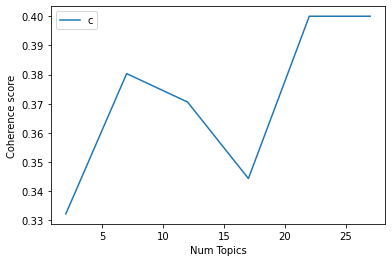

In [33]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [34]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.3322
index: 1 | Num Topics = 7  has Coherence Value of 0.3803
index: 2 | Num Topics = 12  has Coherence Value of 0.3706
index: 3 | Num Topics = 17  has Coherence Value of 0.3443
index: 4 | Num Topics = 22  has Coherence Value of 0.4
index: 5 | Num Topics = 27  has Coherence Value of 0.4


In [168]:
# Select optimal number of topics
optimal_model_sg = model_list_sg[4]

In [169]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg = pyLDAvis.gensim_models.prepare(optimal_model_sg, corpus_sg, id2word_sg)

In [170]:
print("pyLDAVis for overall SG topics:")
vis_sg

pyLDAVis for overall SG topics:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13     0.292138 -0.032035       1        1  10.472131
12     0.320881 -0.006038       2        1  10.422803
3      0.138354 -0.063621       3        1   7.111255
11    -0.028686  0.158787       4        1   6.004873
21    -0.006268 -0.062738       5        1   5.955849
1     -0.126421 -0.200351       6        1   5.276321
8     -0.085879  0.075770       7        1   4.707395
14     0.011151 -0.038134       8        1   4.275889
4     -0.085038  0.128925       9        1   4.051639
10     0.042123 -0.153241      10        1   3.936372
2     -0.126641 -0.086121      11        1   3.886079
7      0.014174  0.125506      12        1   3.757144
17    -0.002069  0.090737      13        1   3.696880
18    -0.072834 -0.114269      14        1   3.444131
9     -0.127320 -0.097906      15        1   3.274297
0     -0.089717 -0.045229      16        1   3.202438
5      0.019327 -0.087382      17        1   3.054647
19     0.010328  0.053332      18        1   2.968603
16     0.130908  0.070717      19        1   2.915188
6     -0.092474  0.124312      20        1   2.773808
15    -0.062487  0.091106      21        1   2.558371
20    -0.073548  0.067872      22        1   2.253888, topic_info=         Term        Freq       Total Category  logprob  loglift
30      video  245.000000  245.000000  Default  30.0000  30.0000
9      update  405.000000  405.000000  Default  29.0000  29.0000
134      post  225.000000  225.000000  Default  28.0000  28.0000
0         app  467.000000  467.000000  Default  27.0000  27.0000
33   facebook  403.000000  403.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
156  annoying    4.013182   33.810547  Topic22  -4.4743   1.6613
240    people    3.936423   73.399783  Topic22  -4.4936   0.8669
68         io    3.914244   72.251628  Topic22  -4.4993   0.8770
134      post    2.887935  225.782601  Topic22  -4.8034  -0.5665
128       new    2.613790  102.601325  Topic22  -4.9031   0.1225

[1090 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
212       1  0.087093     able
212       2  0.145155     able
212       3  0.261280     able
212       5  0.087093     able
212       7  0.261280     able
...     ...       ...      ...
263      16  0.188371      yet
1333     13  0.647639  youtube
508       6  0.659572       yr
21       11  0.919819   zawgyi
363       5  0.638779     zucc

[1775 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 13, 4, 12, 22, 2, 9, 15, 5, 11, 3, 8, 18, 19, 10, 1, 6, 20, 17, 7, 16, 21])

# By-rating LDA Topic Modelling

## LDA Topic Modelling (Rating = 1)

In [38]:
# By-rating Topic Modelling - rating = 1
# Convert to list - move to each section
review_sg_score1 = facebook_ios_sg_review_YearMonth_score1.review.values.tolist()
review_words_sg_score1 = list(sent_to_words(review_sg_score1))
print(review_words_sg_score1[:1])

[['after', 'updating', 'the', 'app', 'to', 'the', 'latest', 'version', 'the', 'newsfeed', 'cant', 'load', 'at', 'all', 'left', 'with', 'nothing', 'but', 'broken', 'app', 'tried', 'deleting', 'the', 'app', 'and', 'reinstalling', 'it', 'but', 'to', 'no', 'avail']]


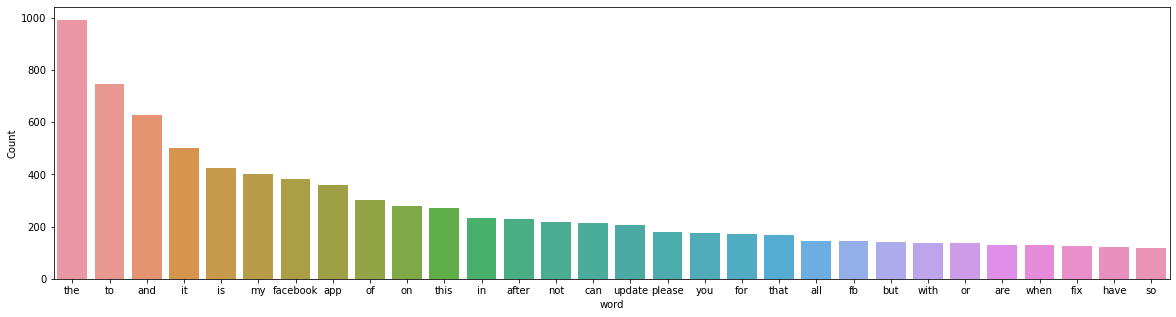

In [39]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_score1))

In [40]:
# Clean text
review_sg_ready_score1 = process_words(review_words_sg_score1)  # processed Text Data! - move to each section


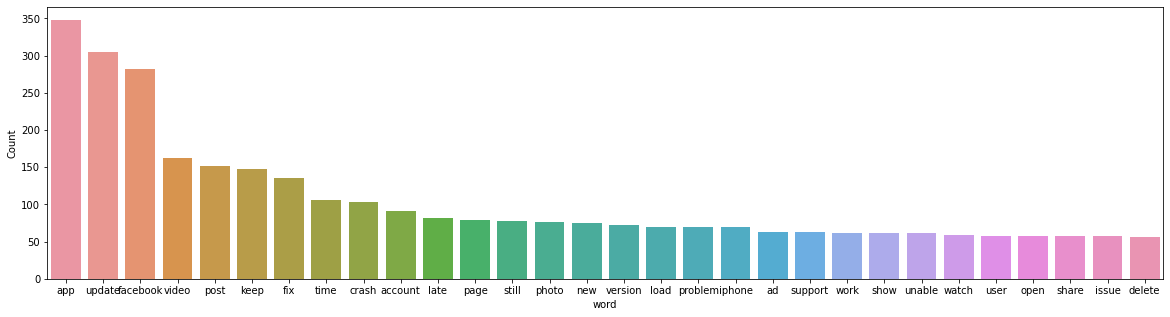

In [41]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_sg_ready_score1))


In [42]:
# Create Dictionary
id2word_sg_score1 = corpora.Dictionary(review_sg_ready_score1)

2021-10-16 18:25:48,266 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 18:25:48,445 [INFO] gensim.corpora.dictionary - built Dictionary(1813 unique tokens: ['app', 'avail', 'broken', 'delete', 'late']...) from 1130 documents (total 10579 corpus positions)
2021-10-16 18:25:48,450 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(1813 unique tokens: ['app', 'avail', 'broken', 'delete', 'late']...) from 1130 documents (total 10579 corpus positions)", 'datetime': '2021-10-16T18:25:48.449711', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [43]:
# Create Corpus: Term Document Frequency
corpus_sg_score1 = [id2word_sg_score1.doc2bow(text) for text in review_sg_ready_score1]

In [44]:
# Training LDA model
model_list_sg_score1, coherence_values_sg_score1 = compute_coherence_values(dictionary=id2word_sg_score1, corpus=corpus_sg_score1, 
                                                              texts=review_sg_ready_score1, limit=30, start=2, step=5)


2021-10-16 18:25:48,560 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 18:25:48,562 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 18:25:48,565 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:25:48,568 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 1130 documents, updating model once every 1000 documents, evaluating perplexity every 1130 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:25:48,569 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1000/1130
2021-10-16 18:25:53,385 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:25:53,389 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.032*"facebook" + 0.029*"update" + 0.022*"app" + 0.015*"post" + 0.013*"keep" + 0.012*"account" + 0.012*"video" + 0.011*"fix" + 0.010*"crash"

2021-10-16 18:26:04,033 [INFO] gensim.models.ldamodel - -6.518 per-word bound, 91.6 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:26:04,036 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1130/1130
2021-10-16 18:26:04,164 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:26:04,167 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"facebook" + 0.016*"account" + 0.016*"app" + 0.015*"update" + 0.015*"post" + 0.009*"photo" + 0.009*"happen" + 0.009*"keep" + 0.009*"stop" + 0.008*"iphone"
2021-10-16 18:26:04,168 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.029*"app" + 0.029*"video" + 0.022*"update" + 0.016*"post" + 0.012*"keep" + 0.011*"fix" + 0.011*"photo" + 0.010*"ad" + 0.009*"click" + 0.008*"view"
2021-10-16 18:26:04,170 [INFO] gensim.models.ldamodel - topic diff=0.275358, rho=0.403896
2021-10-16 18:26:04,171 [INFO] gensim.models.ldamodel - PROGRESS: pas

2021-10-16 18:26:13,413 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.036*"app" + 0.032*"update" + 0.027*"video" + 0.015*"keep" + 0.014*"fix" + 0.014*"post" + 0.011*"crash" + 0.009*"ad" + 0.009*"version" + 0.009*"photo"
2021-10-16 18:26:13,414 [INFO] gensim.models.ldamodel - topic diff=0.190607, rho=0.299745
2021-10-16 18:26:13,748 [INFO] gensim.models.ldamodel - -6.469 per-word bound, 88.6 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:26:13,750 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #1130/1130
2021-10-16 18:26:13,862 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:26:13,865 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"facebook" + 0.017*"account" + 0.015*"post" + 0.013*"app" + 0.009*"stop" + 0.009*"photo" + 0.008*"update" + 0.008*"happen" + 0.008*"page" + 0.008*"censor"
2021-10-16 18:26:13,867 [INFO] gensim.models.ldamodel - topic #1 (

2021-10-16 18:26:23,562 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:26:23,568 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.034*"facebook" + 0.017*"account" + 0.014*"post" + 0.010*"stop" + 0.010*"app" + 0.009*"support" + 0.009*"problem" + 0.008*"delete" + 0.008*"block" + 0.007*"share"
2021-10-16 18:26:23,572 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.038*"app" + 0.036*"update" + 0.026*"video" + 0.015*"keep" + 0.015*"fix" + 0.014*"post" + 0.011*"crash" + 0.010*"photo" + 0.009*"version" + 0.009*"facebook"
2021-10-16 18:26:23,574 [INFO] gensim.models.ldamodel - topic diff=0.152733, rho=0.248991
2021-10-16 18:26:23,743 [INFO] gensim.models.ldamodel - -6.444 per-word bound, 87.0 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:26:23,746 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #1130/1130
2021-10-16 18:26:23,933 [INFO] gensim.models.ldamodel -

2021-10-16 18:26:30,190 [INFO] gensim.models.ldamodel - topic diff=0.130675, rho=0.222884
2021-10-16 18:26:30,192 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #1000/1130
2021-10-16 18:26:31,185 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:26:31,187 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.034*"facebook" + 0.018*"account" + 0.014*"post" + 0.010*"stop" + 0.009*"support" + 0.009*"problem" + 0.008*"delete" + 0.008*"block" + 0.008*"share" + 0.007*"app"
2021-10-16 18:26:31,189 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.038*"app" + 0.037*"update" + 0.025*"video" + 0.016*"fix" + 0.016*"keep" + 0.014*"post" + 0.012*"photo" + 0.011*"crash" + 0.010*"facebook" + 0.009*"version"
2021-10-16 18:26:31,191 [INFO] gensim.models.ldamodel - topic diff=0.130315, rho=0.217546
2021-10-16 18:26:31,371 [INFO] gensim.models.ldamodel - -6.426 per-word bound, 86.0 perplexity estimate based on a held-out corpu

2021-10-16 18:26:37,197 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.037*"app" + 0.035*"update" + 0.025*"video" + 0.016*"fix" + 0.015*"keep" + 0.015*"photo" + 0.015*"post" + 0.012*"facebook" + 0.010*"crash" + 0.009*"iphone"
2021-10-16 18:26:37,205 [INFO] gensim.models.ldamodel - topic diff=0.115020, rho=0.199482
2021-10-16 18:26:37,208 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1000/1130
2021-10-16 18:26:38,165 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:26:38,168 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.033*"facebook" + 0.019*"account" + 0.015*"post" + 0.011*"stop" + 0.009*"support" + 0.009*"problem" + 0.009*"delete" + 0.008*"block" + 0.008*"share" + 0.007*"censor"
2021-10-16 18:26:38,171 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.039*"app" + 0.037*"update" + 0.024*"video" + 0.016*"fix" + 0.016*"keep" + 0.014*"post" + 0.014*"photo" + 0.012*"facebook" + 0.011*"crash" + 0

2021-10-16 18:26:43,937 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:26:43,941 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"facebook" + 0.019*"account" + 0.015*"post" + 0.011*"stop" + 0.009*"block" + 0.009*"censor" + 0.008*"support" + 0.008*"delete" + 0.008*"problem" + 0.007*"real"
2021-10-16 18:26:43,943 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.037*"app" + 0.035*"update" + 0.025*"video" + 0.016*"fix" + 0.016*"photo" + 0.015*"keep" + 0.015*"post" + 0.013*"facebook" + 0.010*"crash" + 0.009*"iphone"
2021-10-16 18:26:43,944 [INFO] gensim.models.ldamodel - topic diff=0.103997, rho=0.182180
2021-10-16 18:26:43,946 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #1000/1130
2021-10-16 18:26:44,934 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:26:44,942 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.032*"facebook" + 0.0

2021-10-16 18:26:50,270 [INFO] gensim.models.ldamodel - topic diff=0.096759, rho=0.168718
2021-10-16 18:26:50,465 [INFO] gensim.models.ldamodel - -6.395 per-word bound, 84.2 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:26:50,468 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #1130/1130
2021-10-16 18:26:50,527 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:26:50,529 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"facebook" + 0.019*"account" + 0.015*"post" + 0.011*"stop" + 0.009*"block" + 0.009*"support" + 0.009*"censor" + 0.008*"delete" + 0.008*"problem" + 0.007*"real"
2021-10-16 18:26:50,532 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.037*"app" + 0.034*"update" + 0.024*"video" + 0.016*"fix" + 0.016*"photo" + 0.015*"keep" + 0.015*"post" + 0.013*"facebook" + 0.010*"crash" + 0.010*"iphone"
2021-10-16 18:26:50,534 [INFO] gensim.models.ldamodel -

2021-10-16 18:26:56,628 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.039*"app" + 0.036*"update" + 0.024*"video" + 0.017*"fix" + 0.016*"keep" + 0.015*"photo" + 0.014*"post" + 0.013*"facebook" + 0.010*"crash" + 0.009*"iphone"
2021-10-16 18:26:56,637 [INFO] gensim.models.ldamodel - topic diff=0.089677, rho=0.157858
2021-10-16 18:26:56,847 [INFO] gensim.models.ldamodel - -6.392 per-word bound, 84.0 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:26:56,849 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #1130/1130
2021-10-16 18:26:57,027 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:26:57,030 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"facebook" + 0.020*"account" + 0.015*"post" + 0.011*"stop" + 0.009*"block" + 0.009*"support" + 0.009*"censor" + 0.008*"delete" + 0.007*"problem" + 0.007*"real"
2021-10-16 18:26:57,032 [INFO] gensim.models.ldamodel -

2021-10-16 18:27:04,797 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:27:04,799 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"facebook" + 0.020*"account" + 0.014*"post" + 0.011*"stop" + 0.010*"support" + 0.009*"block" + 0.008*"censor" + 0.008*"share" + 0.007*"delete" + 0.007*"people"
2021-10-16 18:27:04,802 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.039*"app" + 0.035*"update" + 0.024*"video" + 0.016*"fix" + 0.016*"keep" + 0.015*"photo" + 0.014*"post" + 0.014*"facebook" + 0.010*"crash" + 0.009*"iphone"
2021-10-16 18:27:04,807 [INFO] gensim.models.ldamodel - topic diff=0.083909, rho=0.148856
2021-10-16 18:27:05,132 [INFO] gensim.models.ldamodel - -6.387 per-word bound, 83.7 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:27:05,146 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1130/1130
2021-10-16 18:27:05,236 [INFO] gensim.models.ldamodel 

2021-10-16 18:27:10,673 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.038*"app" + 0.034*"update" + 0.024*"video" + 0.016*"fix" + 0.016*"photo" + 0.015*"keep" + 0.015*"post" + 0.014*"facebook" + 0.009*"crash" + 0.009*"iphone"
2021-10-16 18:27:10,676 [INFO] gensim.models.ldamodel - topic diff=0.079530, rho=0.142668
2021-10-16 18:27:10,680 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #1000/1130
2021-10-16 18:27:11,574 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:27:11,579 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"facebook" + 0.020*"account" + 0.015*"post" + 0.011*"stop" + 0.010*"support" + 0.009*"block" + 0.008*"censor" + 0.007*"people" + 0.007*"share" + 0.007*"delete"
2021-10-16 18:27:11,582 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.039*"app" + 0.035*"update" + 0.023*"video" + 0.016*"fix" + 0.016*"keep" + 0.015*"photo" + 0.014*"post" + 0.014*"facebook" + 0.010*"crash" + 0.

2021-10-16 18:27:23,208 [INFO] gensim.models.ldamodel - topic diff=0.870306, rho=0.707107
2021-10-16 18:27:23,210 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #1000/1130
2021-10-16 18:27:24,830 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:27:24,834 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.037*"app" + 0.016*"fix" + 0.015*"time" + 0.015*"facebook" + 0.012*"update" + 0.011*"video" + 0.011*"stop" + 0.010*"ad" + 0.010*"censor" + 0.010*"post"
2021-10-16 18:27:24,836 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.058*"facebook" + 0.030*"account" + 0.019*"support" + 0.018*"post" + 0.014*"problem" + 0.010*"name" + 0.009*"humanity" + 0.009*"block" + 0.009*"day" + 0.009*"change"
2021-10-16 18:27:24,839 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.017*"people" + 0.014*"app" + 0.012*"standard" + 0.012*"guy" + 0.010*"comment" + 0.010*"ago" + 0.010*"tell" + 0.009*"give" + 0.009*"facebook" + 0.0

2021-10-16 18:27:29,233 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.033*"app" + 0.013*"censor" + 0.013*"thing" + 0.013*"notification" + 0.012*"fix" + 0.011*"account" + 0.011*"keep" + 0.011*"work" + 0.010*"delete" + 0.010*"update"
2021-10-16 18:27:29,236 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.055*"facebook" + 0.030*"account" + 0.022*"post" + 0.018*"name" + 0.016*"support" + 0.013*"work" + 0.012*"translation" + 0.012*"real" + 0.012*"problem" + 0.012*"platform"
2021-10-16 18:27:29,238 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.022*"standard" + 0.017*"guy" + 0.017*"ago" + 0.015*"really" + 0.014*"give" + 0.014*"community" + 0.013*"people" + 0.013*"platform" + 0.013*"tell" + 0.013*"censorship"
2021-10-16 18:27:29,241 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.036*"advertisement" + 0.031*"post" + 0.031*"nonsense" + 0.019*"stop" + 0.017*"censoring" + 0.017*"personal" + 0.016*"scam" + 0.015*"facebook" + 0.014*"keep" + 0.013*"ad"
2021-10-16 18:27:29,242 [IN

2021-10-16 18:27:33,842 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.033*"advertisement" + 0.025*"post" + 0.023*"nonsense" + 0.022*"stop" + 0.019*"ad" + 0.017*"scam" + 0.014*"facebook" + 0.013*"keep" + 0.013*"censoring" + 0.012*"personal"
2021-10-16 18:27:33,851 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.020*"people" + 0.017*"give" + 0.017*"standard" + 0.016*"guy" + 0.014*"really" + 0.013*"ago" + 0.012*"tell" + 0.012*"platform" + 0.011*"censorship" + 0.010*"turn"
2021-10-16 18:27:33,853 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.070*"update" + 0.050*"app" + 0.030*"video" + 0.027*"keep" + 0.025*"fix" + 0.023*"crash" + 0.022*"facebook" + 0.019*"post" + 0.019*"load" + 0.017*"photo"
2021-10-16 18:27:33,855 [INFO] gensim.models.ldamodel - topic diff=0.181568, rho=0.350715
2021-10-16 18:27:34,001 [INFO] gensim.models.ldamodel - -6.556 per-word bound, 94.1 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:27:34,002 [INFO] ge

2021-10-16 18:27:37,587 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.058*"facebook" + 0.029*"account" + 0.021*"post" + 0.017*"support" + 0.017*"name" + 0.015*"censor" + 0.015*"real" + 0.012*"work" + 0.012*"block" + 0.012*"allow"
2021-10-16 18:27:37,588 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.021*"standard" + 0.020*"guy" + 0.016*"really" + 0.016*"give" + 0.015*"ago" + 0.015*"people" + 0.014*"platform" + 0.013*"censorship" + 0.012*"tell" + 0.012*"community"
2021-10-16 18:27:37,589 [INFO] gensim.models.ldamodel - topic diff=0.147955, rho=0.314192
2021-10-16 18:27:37,591 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #1000/1130
2021-10-16 18:27:38,774 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:27:38,819 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.033*"photo" + 0.030*"back" + 0.026*"newsfeed" + 0.023*"post" + 0.021*"video" + 0.014*"ad" + 0.013*"multiple" + 0.012*"annoying" + 0.012

2021-10-16 18:27:42,376 [INFO] gensim.models.ldamodel - topic diff=0.123867, rho=0.275974
2021-10-16 18:27:42,700 [INFO] gensim.models.ldamodel - -6.495 per-word bound, 90.2 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:27:42,705 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #1130/1130
2021-10-16 18:27:42,838 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:27:42,843 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.066*"update" + 0.045*"app" + 0.033*"video" + 0.028*"fix" + 0.025*"facebook" + 0.025*"keep" + 0.022*"post" + 0.022*"photo" + 0.020*"crash" + 0.019*"load"
2021-10-16 18:27:42,846 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.036*"photo" + 0.030*"back" + 0.028*"newsfeed" + 0.025*"post" + 0.021*"video" + 0.015*"free" + 0.015*"multiple" + 0.014*"swipe" + 0.014*"ad" + 0.013*"enter"
2021-10-16 18:27:42,848 [INFO] gensim.models.ldamodel - topic #3 

2021-10-16 18:27:47,231 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.032*"advertisement" + 0.027*"post" + 0.026*"ad" + 0.025*"nonsense" + 0.023*"stop" + 0.019*"scam" + 0.017*"keep" + 0.013*"appear" + 0.013*"censoring" + 0.013*"facebook"
2021-10-16 18:27:47,235 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.019*"people" + 0.019*"give" + 0.018*"guy" + 0.017*"standard" + 0.016*"really" + 0.014*"ban" + 0.013*"ago" + 0.013*"platform" + 0.012*"tell" + 0.011*"censorship"
2021-10-16 18:27:47,238 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.067*"update" + 0.049*"app" + 0.030*"video" + 0.029*"fix" + 0.026*"keep" + 0.023*"facebook" + 0.021*"crash" + 0.020*"post" + 0.018*"load" + 0.018*"photo"
2021-10-16 18:27:47,239 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.064*"facebook" + 0.030*"account" + 0.020*"support" + 0.020*"post" + 0.014*"name" + 0.013*"censor" + 0.013*"block" + 0.011*"real" + 0.011*"work" + 0.011*"problem"
2021-10-16 18:27:47,241 [INFO] gensim.models.ldamode

2021-10-16 18:27:50,329 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.035*"photo" + 0.031*"back" + 0.028*"newsfeed" + 0.024*"post" + 0.021*"video" + 0.017*"free" + 0.015*"multiple" + 0.014*"swipe" + 0.014*"ad" + 0.013*"enter"
2021-10-16 18:27:50,330 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.065*"update" + 0.045*"app" + 0.032*"video" + 0.030*"fix" + 0.025*"facebook" + 0.025*"keep" + 0.022*"post" + 0.021*"photo" + 0.019*"crash" + 0.019*"load"
2021-10-16 18:27:50,331 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.020*"guy" + 0.020*"standard" + 0.018*"give" + 0.017*"really" + 0.016*"ban" + 0.016*"people" + 0.015*"ago" + 0.014*"platform" + 0.013*"censorship" + 0.012*"tell"
2021-10-16 18:27:50,332 [INFO] gensim.models.ldamodel - topic diff=0.098838, rho=0.234856
2021-10-16 18:27:50,333 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #1000/1130
2021-10-16 18:27:51,635 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 d

2021-10-16 18:27:55,263 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.066*"update" + 0.048*"app" + 0.030*"video" + 0.030*"fix" + 0.026*"keep" + 0.023*"facebook" + 0.021*"crash" + 0.021*"post" + 0.018*"load" + 0.018*"photo"
2021-10-16 18:27:55,265 [INFO] gensim.models.ldamodel - topic diff=0.090524, rho=0.217546
2021-10-16 18:27:55,455 [INFO] gensim.models.ldamodel - -6.454 per-word bound, 87.7 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:27:55,457 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #1130/1130
2021-10-16 18:27:55,578 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:27:55,581 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.020*"guy" + 0.020*"standard" + 0.018*"give" + 0.017*"really" + 0.016*"ban" + 0.015*"people" + 0.015*"ago" + 0.014*"platform" + 0.013*"censorship" + 0.012*"tell"
2021-10-16 18:27:55,583 [INFO] gensim.models.ldamodel - topi

2021-10-16 18:27:58,652 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #1000/1130
2021-10-16 18:27:59,732 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:27:59,735 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.020*"give" + 0.019*"guy" + 0.018*"people" + 0.017*"standard" + 0.016*"really" + 0.014*"ban" + 0.013*"ago" + 0.013*"platform" + 0.012*"tell" + 0.011*"censorship"
2021-10-16 18:27:59,737 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.026*"app" + 0.021*"bad" + 0.016*"log" + 0.016*"delete" + 0.014*"version" + 0.013*"upgrade" + 0.013*"content" + 0.013*"time" + 0.012*"look" + 0.012*"image"
2021-10-16 18:27:59,740 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.066*"update" + 0.048*"app" + 0.030*"video" + 0.030*"fix" + 0.026*"keep" + 0.024*"facebook" + 0.021*"crash" + 0.021*"post" + 0.018*"load" + 0.018*"photo"
2021-10-16 18:27:59,744 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.063*"f

2021-10-16 18:28:03,115 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.034*"advertisement" + 0.029*"nonsense" + 0.029*"post" + 0.028*"ad" + 0.022*"stop" + 0.021*"scam" + 0.020*"keep" + 0.015*"censoring" + 0.015*"appear" + 0.015*"personal"
2021-10-16 18:28:03,118 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.020*"guy" + 0.019*"standard" + 0.018*"give" + 0.017*"really" + 0.016*"ban" + 0.015*"people" + 0.015*"ago" + 0.014*"platform" + 0.013*"censorship" + 0.012*"tell"
2021-10-16 18:28:03,126 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.025*"app" + 0.022*"bad" + 0.015*"image" + 0.015*"version" + 0.015*"log" + 0.014*"delete" + 0.013*"content" + 0.013*"upgrade" + 0.013*"look" + 0.012*"posting"
2021-10-16 18:28:03,130 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.034*"photo" + 0.032*"back" + 0.028*"newsfeed" + 0.024*"post" + 0.021*"video" + 0.018*"free" + 0.015*"multiple" + 0.014*"ad" + 0.014*"swipe" + 0.013*"enter"
2021-10-16 18:28:03,132 [INFO] gensim.models.ldamodel

2021-10-16 18:28:08,640 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.035*"app" + 0.016*"work" + 0.014*"thing" + 0.013*"account" + 0.012*"video" + 0.012*"notification" + 0.011*"facebook" + 0.010*"delete" + 0.010*"keep" + 0.010*"issue"
2021-10-16 18:28:08,643 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.020*"give" + 0.019*"guy" + 0.017*"standard" + 0.017*"people" + 0.015*"really" + 0.014*"ban" + 0.013*"ago" + 0.013*"platform" + 0.012*"tell" + 0.011*"censorship"
2021-10-16 18:28:08,647 [INFO] gensim.models.ldamodel - topic diff=0.074902, rho=0.185281
2021-10-16 18:28:09,063 [INFO] gensim.models.ldamodel - -6.440 per-word bound, 86.8 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:28:09,073 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #1130/1130
2021-10-16 18:28:09,255 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:28:09,283 [INFO] gensim.models.lda

2021-10-16 18:28:13,103 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.060*"facebook" + 0.030*"account" + 0.021*"post" + 0.020*"censor" + 0.019*"support" + 0.016*"name" + 0.014*"real" + 0.013*"block" + 0.011*"happen" + 0.011*"allow"
2021-10-16 18:28:13,104 [INFO] gensim.models.ldamodel - topic diff=0.071980, rho=0.179230
2021-10-16 18:28:13,107 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #1000/1130
2021-10-16 18:28:14,189 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:28:14,199 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.065*"update" + 0.048*"app" + 0.030*"video" + 0.030*"fix" + 0.025*"keep" + 0.024*"facebook" + 0.021*"post" + 0.021*"crash" + 0.018*"photo" + 0.018*"load"
2021-10-16 18:28:14,236 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.020*"give" + 0.019*"guy" + 0.017*"standard" + 0.017*"people" + 0.015*"really" + 0.014*"ban" + 0.013*"ago" + 0.013*"platform" + 0.012*"tell" + 0.01

2021-10-16 18:28:17,740 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #1130/1130
2021-10-16 18:28:17,886 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:28:17,899 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.063*"update" + 0.046*"app" + 0.032*"video" + 0.030*"fix" + 0.025*"facebook" + 0.024*"keep" + 0.022*"post" + 0.021*"photo" + 0.019*"crash" + 0.018*"load"
2021-10-16 18:28:17,906 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.033*"photo" + 0.032*"back" + 0.028*"newsfeed" + 0.024*"post" + 0.021*"video" + 0.018*"free" + 0.015*"multiple" + 0.014*"ad" + 0.014*"swipe" + 0.013*"enter"
2021-10-16 18:28:17,911 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.060*"facebook" + 0.030*"account" + 0.021*"post" + 0.020*"censor" + 0.019*"support" + 0.016*"name" + 0.014*"real" + 0.013*"block" + 0.011*"happen" + 0.011*"allow"
2021-10-16 18:28:17,926 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.035*"

2021-10-16 18:28:22,597 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.033*"back" + 0.032*"photo" + 0.027*"newsfeed" + 0.023*"post" + 0.021*"video" + 0.017*"free" + 0.015*"ad" + 0.014*"multiple" + 0.013*"swipe" + 0.012*"annoying"
2021-10-16 18:28:22,598 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.020*"give" + 0.019*"guy" + 0.017*"standard" + 0.017*"people" + 0.015*"really" + 0.014*"ban" + 0.014*"ago" + 0.013*"platform" + 0.012*"tell" + 0.011*"censorship"
2021-10-16 18:28:22,600 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.064*"update" + 0.048*"app" + 0.030*"video" + 0.030*"fix" + 0.025*"keep" + 0.024*"facebook" + 0.021*"post" + 0.020*"crash" + 0.018*"photo" + 0.018*"load"
2021-10-16 18:28:22,602 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.032*"advertisement" + 0.029*"ad" + 0.027*"post" + 0.026*"nonsense" + 0.022*"stop" + 0.019*"scam" + 0.018*"keep" + 0.014*"appear" + 0.014*"censoring" + 0.013*"personal"
2021-10-16 18:28:22,603 [INFO] gensim.models.ldamodel -

2021-10-16 18:28:26,852 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.033*"photo" + 0.033*"back" + 0.028*"newsfeed" + 0.024*"post" + 0.021*"video" + 0.018*"free" + 0.015*"multiple" + 0.014*"ad" + 0.014*"swipe" + 0.013*"enter"
2021-10-16 18:28:26,855 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.035*"app" + 0.018*"work" + 0.015*"thing" + 0.014*"account" + 0.013*"notification" + 0.012*"video" + 0.011*"update" + 0.011*"keep" + 0.011*"facebook" + 0.010*"delete"
2021-10-16 18:28:26,856 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.020*"guy" + 0.019*"standard" + 0.018*"give" + 0.016*"really" + 0.015*"ban" + 0.015*"ago" + 0.015*"people" + 0.014*"platform" + 0.012*"censorship" + 0.012*"tell"
2021-10-16 18:28:26,857 [INFO] gensim.models.ldamodel - topic diff=0.063218, rho=0.159862
2021-10-16 18:28:26,858 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #1000/1130
2021-10-16 18:28:27,960 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a mo

2021-10-16 18:28:30,993 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.063*"facebook" + 0.030*"account" + 0.020*"support" + 0.020*"post" + 0.017*"censor" + 0.015*"name" + 0.013*"block" + 0.012*"real" + 0.011*"happen" + 0.011*"allow"
2021-10-16 18:28:30,994 [INFO] gensim.models.ldamodel - topic diff=0.060742, rho=0.154065
2021-10-16 18:28:31,177 [INFO] gensim.models.ldamodel - -6.425 per-word bound, 85.9 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:28:31,191 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #1130/1130
2021-10-16 18:28:31,279 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:28:31,285 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.033*"photo" + 0.033*"back" + 0.028*"newsfeed" + 0.024*"post" + 0.021*"video" + 0.018*"free" + 0.015*"multiple" + 0.015*"ad" + 0.014*"swipe" + 0.013*"enter"
2021-10-16 18:28:31,287 [INFO] gensim.models.ldamodel - 

2021-10-16 18:28:34,089 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1000/1130
2021-10-16 18:28:35,096 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:28:35,100 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.033*"back" + 0.031*"photo" + 0.027*"newsfeed" + 0.023*"post" + 0.021*"video" + 0.017*"free" + 0.015*"ad" + 0.014*"multiple" + 0.013*"swipe" + 0.012*"annoying"
2021-10-16 18:28:35,102 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.063*"facebook" + 0.030*"account" + 0.020*"support" + 0.020*"post" + 0.017*"censor" + 0.015*"name" + 0.013*"block" + 0.012*"real" + 0.011*"happen" + 0.011*"allow"
2021-10-16 18:28:35,103 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.064*"update" + 0.048*"app" + 0.031*"video" + 0.030*"fix" + 0.025*"keep" + 0.024*"facebook" + 0.021*"post" + 0.020*"crash" + 0.018*"photo" + 0.018*"load"
2021-10-16 18:28:35,106 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.0

2021-10-16 18:28:38,703 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.025*"app" + 0.024*"bad" + 0.015*"log" + 0.015*"delete" + 0.015*"image" + 0.014*"version" + 0.013*"content" + 0.013*"upgrade" + 0.013*"account" + 0.013*"look"
2021-10-16 18:28:38,705 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.061*"facebook" + 0.029*"account" + 0.021*"post" + 0.020*"censor" + 0.019*"support" + 0.016*"name" + 0.014*"real" + 0.013*"block" + 0.012*"happen" + 0.011*"allow"
2021-10-16 18:28:38,707 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.063*"update" + 0.046*"app" + 0.032*"video" + 0.030*"fix" + 0.025*"facebook" + 0.024*"keep" + 0.022*"post" + 0.020*"photo" + 0.019*"crash" + 0.018*"load"
2021-10-16 18:28:38,833 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.033*"advertisement" + 0.029*"ad" + 0.029*"nonsense" + 0.028*"post" + 0.021*"stop" + 0.021*"scam" + 0.020*"keep" + 0.015*"appear" + 0.015*"censoring" + 0.014*"personal"
2021-10-16 18:28:38,835 [INFO] gensim.models.ldamodel -

2021-10-16 18:28:43,857 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.025*"app" + 0.024*"bad" + 0.016*"log" + 0.016*"delete" + 0.014*"account" + 0.013*"version" + 0.013*"upgrade" + 0.013*"content" + 0.013*"image" + 0.013*"look"
2021-10-16 18:28:43,859 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.064*"update" + 0.048*"app" + 0.031*"video" + 0.030*"fix" + 0.025*"keep" + 0.024*"facebook" + 0.021*"post" + 0.020*"crash" + 0.018*"photo" + 0.018*"load"
2021-10-16 18:28:43,861 [INFO] gensim.models.ldamodel - topic diff=0.055186, rho=0.141238
2021-10-16 18:28:44,070 [INFO] gensim.models.ldamodel - -6.419 per-word bound, 85.6 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:28:44,074 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #1130/1130
2021-10-16 18:28:44,193 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:28:44,206 [INFO] gensim.models.ldamodel - topic #

2021-10-16 18:28:57,974 [INFO] gensim.models.ldamodel - -9.761 per-word bound, 867.7 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:28:57,976 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1130/1130
2021-10-16 18:28:58,261 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:28:58,266 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.046*"video" + 0.039*"update" + 0.026*"app" + 0.022*"live" + 0.020*"iphone" + 0.018*"fix" + 0.015*"version" + 0.013*"phone" + 0.013*"always" + 0.013*"news"
2021-10-16 18:28:58,270 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.033*"photo" + 0.030*"ad" + 0.023*"advertisement" + 0.022*"bad" + 0.020*"allow" + 0.020*"keep" + 0.018*"app" + 0.018*"post" + 0.015*"video" + 0.013*"number"
2021-10-16 18:28:58,275 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.056*"post" + 0.029*"personal" + 0.028*"freepalestine" + 0.028*"shame" + 0.0

2021-10-16 18:29:04,371 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.049*"video" + 0.047*"update" + 0.039*"app" + 0.022*"fix" + 0.021*"iphone" + 0.019*"version" + 0.018*"watch" + 0.018*"new" + 0.018*"load" + 0.018*"live"
2021-10-16 18:29:04,378 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.036*"mode" + 0.033*"iphone" + 0.028*"post" + 0.027*"app" + 0.023*"dark" + 0.017*"add" + 0.017*"useless" + 0.017*"israeli" + 0.017*"remove" + 0.015*"comment"
2021-10-16 18:29:04,381 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.044*"app" + 0.028*"facebook" + 0.019*"work" + 0.018*"time" + 0.015*"nonsense" + 0.014*"standard" + 0.014*"fix" + 0.014*"reinstall" + 0.013*"issue" + 0.013*"connection"
2021-10-16 18:29:04,384 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.031*"newsfeed" + 0.024*"censor" + 0.022*"enter" + 0.021*"swipe" + 0.021*"video" + 0.019*"advertisement" + 0.018*"user" + 0.017*"back" + 0.017*"tell" + 0.015*"application"
2021-10-16 18:29:04,392 [INFO] gensim.models.ld

2021-10-16 18:29:09,061 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.042*"bad" + 0.027*"ad" + 0.025*"advertisement" + 0.021*"keep" + 0.020*"allow" + 0.020*"scam" + 0.016*"speech" + 0.016*"post" + 0.014*"platform" + 0.014*"number"
2021-10-16 18:29:09,063 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.041*"app" + 0.030*"nonsense" + 0.030*"facebook" + 0.022*"standard" + 0.021*"bloody" + 0.021*"work" + 0.018*"connection" + 0.018*"internet" + 0.018*"big" + 0.017*"connect"
2021-10-16 18:29:09,067 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.058*"video" + 0.041*"update" + 0.031*"app" + 0.024*"iphone" + 0.020*"load" + 0.020*"live" + 0.020*"fix" + 0.018*"news" + 0.018*"phone" + 0.016*"version"
2021-10-16 18:29:09,068 [INFO] gensim.models.ldamodel - topic diff=0.168323, rho=0.374503
2021-10-16 18:29:09,071 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #1000/1130
2021-10-16 18:29:10,748 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a

2021-10-16 18:29:14,578 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.054*"post" + 0.024*"crash" + 0.024*"feed" + 0.022*"ago" + 0.022*"feature" + 0.021*"friend" + 0.020*"old" + 0.020*"facebook" + 0.019*"update" + 0.018*"find"
2021-10-16 18:29:14,580 [INFO] gensim.models.ldamodel - topic diff=0.122415, rho=0.314192
2021-10-16 18:29:14,752 [INFO] gensim.models.ldamodel - -6.545 per-word bound, 93.4 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:29:14,755 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #1130/1130
2021-10-16 18:29:14,889 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:29:14,901 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.036*"newsfeed" + 0.036*"back" + 0.032*"censor" + 0.025*"swipe" + 0.023*"enter" + 0.022*"video" + 0.021*"advertisement" + 0.019*"tell" + 0.017*"newsfee" + 0.017*"miss"
2021-10-16 18:29:14,904 [INFO] gensim.models.ldamode

2021-10-16 18:29:17,373 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #1000/1130
2021-10-16 18:29:18,352 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:29:18,356 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.100*"post" + 0.029*"thing" + 0.025*"freepalestine" + 0.023*"shame" + 0.023*"fix" + 0.022*"free" + 0.019*"user" + 0.018*"personal" + 0.016*"people" + 0.016*"live"
2021-10-16 18:29:18,358 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.040*"mode" + 0.037*"iphone" + 0.026*"dark" + 0.023*"remove" + 0.022*"comment" + 0.022*"post" + 0.022*"app" + 0.020*"israeli" + 0.020*"useless" + 0.020*"add"
2021-10-16 18:29:18,359 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.051*"video" + 0.044*"update" + 0.040*"app" + 0.024*"iphone" + 0.023*"load" + 0.020*"fix" + 0.020*"phone" + 0.019*"new" + 0.018*"watch" + 0.018*"version"
2021-10-16 18:29:18,361 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.0

2021-10-16 18:29:21,868 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.070*"facebook" + 0.050*"account" + 0.024*"support" + 0.020*"name" + 0.017*"real" + 0.015*"problem" + 0.014*"change" + 0.013*"translation" + 0.013*"idea" + 0.012*"human"
2021-10-16 18:29:21,870 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.055*"video" + 0.040*"update" + 0.034*"app" + 0.025*"iphone" + 0.022*"load" + 0.020*"fix" + 0.019*"phone" + 0.019*"live" + 0.019*"news" + 0.017*"issue"
2021-10-16 18:29:21,872 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.049*"app" + 0.033*"click" + 0.032*"view" + 0.031*"ban" + 0.030*"posting" + 0.028*"whole" + 0.026*"image" + 0.023*"really" + 0.021*"platform" + 0.021*"picture"
2021-10-16 18:29:21,875 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.033*"app" + 0.030*"delete" + 0.025*"time" + 0.018*"log" + 0.018*"datum" + 0.017*"video" + 0.016*"download" + 0.015*"version" + 0.015*"work" + 0.015*"page"
2021-10-16 18:29:21,876 [INFO] gensim.models.ldamodel - topic

2021-10-16 18:29:26,210 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.033*"app" + 0.030*"delete" + 0.029*"time" + 0.020*"log" + 0.018*"datum" + 0.018*"download" + 0.017*"video" + 0.016*"page" + 0.015*"link" + 0.015*"error"
2021-10-16 18:29:26,218 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.047*"bad" + 0.031*"ad" + 0.024*"advertisement" + 0.020*"allow" + 0.019*"keep" + 0.018*"scam" + 0.017*"speech" + 0.016*"post" + 0.013*"platform" + 0.012*"star"
2021-10-16 18:29:26,222 [INFO] gensim.models.ldamodel - topic diff=0.079107, rho=0.234856
2021-10-16 18:29:26,382 [INFO] gensim.models.ldamodel - -6.502 per-word bound, 90.6 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:29:26,388 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #1130/1130
2021-10-16 18:29:26,503 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:29:26,508 [INFO] gensim.models.ldamodel - topic

2021-10-16 18:29:29,741 [INFO] gensim.models.ldamodel - topic diff=0.072435, rho=0.222884
2021-10-16 18:29:29,746 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #1000/1130
2021-10-16 18:29:30,744 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:29:30,748 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.037*"app" + 0.032*"facebook" + 0.026*"nonsense" + 0.023*"work" + 0.019*"standard" + 0.018*"bloody" + 0.017*"internet" + 0.017*"connection" + 0.017*"big" + 0.016*"connect"
2021-10-16 18:29:30,750 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.051*"video" + 0.042*"update" + 0.039*"app" + 0.024*"iphone" + 0.023*"load" + 0.021*"phone" + 0.021*"fix" + 0.019*"new" + 0.018*"news" + 0.018*"watch"
2021-10-16 18:29:30,751 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.087*"update" + 0.058*"app" + 0.038*"photo" + 0.034*"keep" + 0.032*"fix" + 0.030*"facebook" + 0.028*"crash" + 0.024*"video" + 0.021*"page" +

2021-10-16 18:29:34,538 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.046*"bad" + 0.029*"ad" + 0.025*"advertisement" + 0.021*"keep" + 0.020*"allow" + 0.020*"scam" + 0.018*"post" + 0.016*"speech" + 0.015*"platform" + 0.013*"number"
2021-10-16 18:29:34,543 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.049*"app" + 0.033*"click" + 0.032*"ban" + 0.032*"view" + 0.030*"posting" + 0.028*"whole" + 0.026*"image" + 0.022*"really" + 0.021*"platform" + 0.020*"picture"
2021-10-16 18:29:34,547 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.037*"iphone" + 0.035*"mode" + 0.026*"israeli" + 0.025*"remove" + 0.024*"dark" + 0.022*"useless" + 0.021*"review" + 0.021*"comment" + 0.021*"post" + 0.021*"app"
2021-10-16 18:29:34,554 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.084*"stop" + 0.034*"block" + 0.032*"post" + 0.030*"censoring" + 0.027*"fb" + 0.022*"account" + 0.022*"ban" + 0.022*"freedom" + 0.019*"long" + 0.018*"censor"
2021-10-16 18:29:34,556 [INFO] gensim.models.ldamodel - to

2021-10-16 18:29:39,375 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.052*"post" + 0.027*"feature" + 0.024*"friend" + 0.023*"ago" + 0.022*"feed" + 0.022*"photo" + 0.021*"facebook" + 0.020*"old" + 0.020*"crash" + 0.019*"find"
2021-10-16 18:29:39,381 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.039*"mode" + 0.038*"iphone" + 0.032*"remove" + 0.026*"dark" + 0.022*"post" + 0.022*"comment" + 0.021*"israeli" + 0.020*"app" + 0.020*"useless" + 0.019*"add"
2021-10-16 18:29:39,385 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.100*"post" + 0.029*"thing" + 0.026*"freepalestine" + 0.024*"shame" + 0.023*"fix" + 0.022*"free" + 0.021*"live" + 0.021*"keep" + 0.021*"user" + 0.019*"personal"
2021-10-16 18:29:39,391 [INFO] gensim.models.ldamodel - topic diff=0.063704, rho=0.195628
2021-10-16 18:29:39,640 [INFO] gensim.models.ldamodel - -6.485 per-word bound, 89.5 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:29:39,647 [INFO] gensim.models.l

2021-10-16 18:29:43,009 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.043*"back" + 0.034*"newsfeed" + 0.030*"censor" + 0.024*"swipe" + 0.022*"enter" + 0.022*"video" + 0.020*"advertisement" + 0.018*"tell" + 0.017*"user" + 0.017*"find"
2021-10-16 18:29:43,011 [INFO] gensim.models.ldamodel - topic diff=0.060063, rho=0.188545
2021-10-16 18:29:43,015 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #1000/1130
2021-10-16 18:29:44,325 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:29:44,330 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.047*"bad" + 0.031*"ad" + 0.024*"advertisement" + 0.020*"allow" + 0.019*"keep" + 0.018*"scam" + 0.017*"speech" + 0.017*"post" + 0.013*"platform" + 0.012*"star"
2021-10-16 18:29:44,332 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.087*"update" + 0.058*"app" + 0.039*"photo" + 0.035*"keep" + 0.031*"fix" + 0.030*"facebook" + 0.029*"crash" + 0.025*"video" + 0.021*"page"

2021-10-16 18:29:47,765 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #1130/1130
2021-10-16 18:29:47,897 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:29:47,903 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.100*"post" + 0.030*"live" + 0.030*"thing" + 0.027*"freepalestine" + 0.026*"shame" + 0.023*"fix" + 0.022*"personal" + 0.022*"free" + 0.022*"keep" + 0.019*"user"
2021-10-16 18:29:47,906 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.043*"back" + 0.034*"newsfeed" + 0.030*"censor" + 0.024*"swipe" + 0.022*"video" + 0.022*"enter" + 0.020*"advertisement" + 0.018*"tell" + 0.018*"user" + 0.018*"find"
2021-10-16 18:29:47,907 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.073*"facebook" + 0.050*"account" + 0.024*"support" + 0.020*"name" + 0.017*"real" + 0.014*"change" + 0.014*"problem" + 0.013*"translation" + 0.013*"idea" + 0.012*"human"
2021-10-16 18:29:47,909 [INFO] gensim.models.ldamodel - top

2021-10-16 18:29:54,099 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.048*"bad" + 0.031*"ad" + 0.025*"advertisement" + 0.020*"allow" + 0.019*"keep" + 0.018*"scam" + 0.017*"post" + 0.017*"speech" + 0.013*"platform" + 0.012*"star"
2021-10-16 18:29:54,101 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.043*"back" + 0.033*"newsfeed" + 0.026*"censor" + 0.022*"swipe" + 0.022*"video" + 0.019*"advertisement" + 0.019*"user" + 0.019*"enter" + 0.017*"tell" + 0.016*"find"
2021-10-16 18:29:54,133 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.087*"update" + 0.058*"app" + 0.040*"photo" + 0.035*"keep" + 0.031*"fix" + 0.030*"facebook" + 0.029*"crash" + 0.025*"video" + 0.021*"page" + 0.019*"late"
2021-10-16 18:29:54,136 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.036*"app" + 0.032*"facebook" + 0.027*"nonsense" + 0.021*"work" + 0.020*"standard" + 0.018*"bloody" + 0.017*"internet" + 0.017*"connection" + 0.017*"big" + 0.016*"connect"
2021-10-16 18:29:54,140 [INFO] gensim.models.lda

2021-10-16 18:30:00,020 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.053*"post" + 0.025*"feature" + 0.024*"photo" + 0.024*"ago" + 0.023*"friend" + 0.022*"facebook" + 0.021*"feed" + 0.020*"old" + 0.019*"crash" + 0.019*"find"
2021-10-16 18:30:00,021 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.054*"video" + 0.040*"update" + 0.035*"app" + 0.024*"iphone" + 0.022*"load" + 0.021*"fix" + 0.020*"phone" + 0.019*"news" + 0.019*"issue" + 0.018*"live"
2021-10-16 18:30:00,027 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.047*"bad" + 0.030*"ad" + 0.026*"advertisement" + 0.021*"keep" + 0.021*"allow" + 0.020*"scam" + 0.018*"post" + 0.016*"speech" + 0.015*"platform" + 0.013*"number"
2021-10-16 18:30:00,027 [INFO] gensim.models.ldamodel - topic diff=0.052172, rho=0.166367
2021-10-16 18:30:00,029 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #1000/1130
2021-10-16 18:30:01,380 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 do

2021-10-16 18:30:05,088 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.085*"stop" + 0.032*"block" + 0.029*"post" + 0.026*"fb" + 0.025*"censoring" + 0.020*"ban" + 0.020*"account" + 0.020*"long" + 0.020*"freedom" + 0.017*"support"
2021-10-16 18:30:05,090 [INFO] gensim.models.ldamodel - topic diff=0.050224, rho=0.159862
2021-10-16 18:30:05,375 [INFO] gensim.models.ldamodel - -6.469 per-word bound, 88.6 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:30:05,377 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #1130/1130
2021-10-16 18:30:05,527 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:30:05,532 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.084*"stop" + 0.035*"block" + 0.032*"post" + 0.029*"censoring" + 0.027*"fb" + 0.022*"ban" + 0.022*"account" + 0.022*"freedom" + 0.019*"long" + 0.018*"censor"
2021-10-16 18:30:05,534 [INFO] gensim.models.ldamodel - top

2021-10-16 18:30:09,105 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #1000/1130
2021-10-16 18:30:10,507 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:30:10,514 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.085*"stop" + 0.032*"block" + 0.029*"post" + 0.026*"fb" + 0.025*"censoring" + 0.021*"ban" + 0.020*"account" + 0.020*"freedom" + 0.020*"long" + 0.017*"censor"
2021-10-16 18:30:10,518 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.047*"app" + 0.032*"click" + 0.031*"ban" + 0.031*"view" + 0.029*"posting" + 0.026*"whole" + 0.023*"image" + 0.023*"platform" + 0.020*"really" + 0.020*"picture"
2021-10-16 18:30:10,520 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.035*"app" + 0.032*"facebook" + 0.027*"nonsense" + 0.021*"work" + 0.020*"standard" + 0.018*"bloody" + 0.017*"internet" + 0.017*"connection" + 0.017*"big" + 0.016*"connect"
2021-10-16 18:30:10,522 [INFO] gensim.models.ldamodel - topic #8

2021-10-16 18:30:14,870 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.087*"update" + 0.056*"app" + 0.044*"photo" + 0.034*"keep" + 0.031*"facebook" + 0.030*"fix" + 0.026*"crash" + 0.025*"video" + 0.021*"page" + 0.018*"notification"
2021-10-16 18:30:14,872 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.036*"app" + 0.033*"facebook" + 0.031*"nonsense" + 0.022*"standard" + 0.021*"work" + 0.021*"bloody" + 0.019*"internet" + 0.019*"connection" + 0.018*"big" + 0.018*"connect"
2021-10-16 18:30:14,874 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.047*"bad" + 0.030*"ad" + 0.025*"advertisement" + 0.021*"allow" + 0.021*"keep" + 0.020*"scam" + 0.018*"post" + 0.016*"speech" + 0.015*"platform" + 0.013*"number"
2021-10-16 18:30:14,876 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.033*"app" + 0.030*"delete" + 0.026*"time" + 0.018*"datum" + 0.018*"log" + 0.017*"video" + 0.016*"download" + 0.015*"page" + 0.015*"work" + 0.015*"version"
2021-10-16 18:30:14,876 [INFO] gensim.models.ld

2021-10-16 18:30:19,886 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.047*"app" + 0.033*"click" + 0.032*"ban" + 0.031*"view" + 0.030*"posting" + 0.026*"whole" + 0.024*"image" + 0.023*"platform" + 0.020*"really" + 0.020*"picture"
2021-10-16 18:30:19,888 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.048*"bad" + 0.031*"ad" + 0.025*"advertisement" + 0.021*"allow" + 0.019*"keep" + 0.019*"scam" + 0.017*"post" + 0.017*"speech" + 0.014*"platform" + 0.012*"star"
2021-10-16 18:30:19,890 [INFO] gensim.models.ldamodel - topic diff=0.045311, rho=0.145664
2021-10-16 18:30:20,122 [INFO] gensim.models.ldamodel - -6.464 per-word bound, 88.3 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:30:20,123 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #1130/1130
2021-10-16 18:30:20,259 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:30:20,264 [INFO] gensim.models.ldamodel -

2021-10-16 18:30:23,268 [INFO] gensim.models.ldamodel - topic diff=0.044010, rho=0.142668
2021-10-16 18:30:23,270 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #1000/1130
2021-10-16 18:30:24,357 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:30:24,386 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.098*"post" + 0.031*"live" + 0.029*"thing" + 0.026*"freepalestine" + 0.024*"shame" + 0.023*"keep" + 0.022*"fix" + 0.021*"free" + 0.021*"user" + 0.019*"personal"
2021-10-16 18:30:24,394 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.051*"video" + 0.043*"update" + 0.038*"app" + 0.024*"iphone" + 0.022*"load" + 0.022*"fix" + 0.021*"phone" + 0.019*"issue" + 0.019*"new" + 0.019*"news"
2021-10-16 18:30:24,398 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.038*"mode" + 0.038*"iphone" + 0.033*"remove" + 0.025*"dark" + 0.023*"comment" + 0.022*"post" + 0.022*"israeli" + 0.020*"useless" + 0.020*"app" + 0.019

2021-10-16 18:30:39,502 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.059*"update" + 0.037*"app" + 0.023*"keep" + 0.023*"crash" + 0.019*"fix" + 0.017*"load" + 0.016*"version" + 0.014*"unable" + 0.013*"late" + 0.012*"notification"
2021-10-16 18:30:39,504 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.054*"app" + 0.050*"update" + 0.015*"video" + 0.015*"late" + 0.014*"help" + 0.014*"time" + 0.014*"keep" + 0.013*"watch" + 0.013*"fix" + 0.013*"facebook"
2021-10-16 18:30:39,507 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.041*"update" + 0.025*"app" + 0.021*"video" + 0.015*"facebook" + 0.014*"page" + 0.013*"post" + 0.013*"iphone" + 0.013*"fix" + 0.011*"keep" + 0.010*"unable"
2021-10-16 18:30:39,509 [INFO] gensim.models.ldamodel - topic diff=13.259967, rho=1.000000
2021-10-16 18:30:39,793 [INFO] gensim.models.ldamodel - -10.671 per-word bound, 1630.1 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:30:39,797 [INFO] gensim.models.

2021-10-16 18:30:44,144 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.148*"video" + 0.050*"watch" + 0.028*"io" + 0.023*"datum" + 0.021*"tell" + 0.018*"back" + 0.018*"app" + 0.018*"stupid" + 0.018*"manipulate" + 0.018*"though"
2021-10-16 18:30:44,147 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.050*"advertisement" + 0.046*"tap" + 0.043*"away" + 0.043*"enter" + 0.041*"app" + 0.032*"application" + 0.029*"status" + 0.028*"time" + 0.025*"stay" + 0.024*"tab"
2021-10-16 18:30:44,149 [INFO] gensim.models.ldamodel - topic diff=0.309001, rho=0.492068
2021-10-16 18:30:44,151 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #1000/1130
2021-10-16 18:30:45,785 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:30:45,806 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.082*"photo" + 0.071*"app" + 0.047*"view" + 0.047*"update" + 0.037*"album" + 0.036*"crash" + 0.029*"keep" + 0.024*"click" + 0.022*"translation"

2021-10-16 18:30:50,940 [INFO] gensim.models.ldamodel - topic diff=0.160535, rho=0.374503
2021-10-16 18:30:51,105 [INFO] gensim.models.ldamodel - -9.071 per-word bound, 537.7 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:30:51,107 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #1130/1130
2021-10-16 18:30:51,267 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:30:51,275 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.096*"photo" + 0.073*"app" + 0.054*"view" + 0.045*"crash" + 0.043*"update" + 0.037*"translation" + 0.031*"keep" + 0.030*"album" + 0.028*"click" + 0.022*"miss"
2021-10-16 18:30:51,285 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.051*"shame" + 0.042*"freepalestine" + 0.041*"photo" + 0.041*"multiple" + 0.026*"option" + 0.026*"end" + 0.025*"look" + 0.025*"link" + 0.023*"upgrade" + 0.022*"blank"
2021-10-16 18:30:51,289 [INFO] gensim.models.ldam

2021-10-16 18:30:55,839 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.042*"shame" + 0.035*"freepalestine" + 0.034*"multiple" + 0.031*"option" + 0.030*"photo" + 0.029*"link" + 0.027*"upgrade" + 0.024*"look" + 0.024*"blank" + 0.020*"end"
2021-10-16 18:30:55,844 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.056*"post" + 0.040*"version" + 0.035*"update" + 0.032*"facebook" + 0.026*"live" + 0.025*"comment" + 0.024*"share" + 0.023*"problem" + 0.021*"video" + 0.018*"thing"
2021-10-16 18:30:55,852 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.051*"ban" + 0.038*"account" + 0.037*"stop" + 0.033*"post" + 0.032*"platform" + 0.028*"guy" + 0.027*"truth" + 0.024*"censoring" + 0.024*"support" + 0.021*"really"
2021-10-16 18:30:55,857 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.048*"notification" + 0.037*"app" + 0.032*"story" + 0.032*"fix" + 0.031*"close" + 0.029*"unable" + 0.026*"keep" + 0.025*"tag" + 0.025*"button" + 0.025*"new"
2021-10-16 18:30:55,864 [INFO] gensim.models.ld

2021-10-16 18:30:59,503 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.065*"app" + 0.051*"work" + 0.031*"free" + 0.028*"internet" + 0.028*"connection" + 0.022*"fix" + 0.022*"company" + 0.018*"facebook" + 0.018*"block" + 0.017*"world"
2021-10-16 18:30:59,504 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.095*"photo" + 0.074*"app" + 0.058*"crash" + 0.057*"view" + 0.043*"update" + 0.040*"keep" + 0.035*"translation" + 0.032*"album" + 0.024*"click" + 0.022*"miss"
2021-10-16 18:30:59,506 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.054*"facebook" + 0.050*"page" + 0.047*"update" + 0.045*"load" + 0.038*"friend" + 0.033*"post" + 0.032*"feed" + 0.029*"show" + 0.027*"photo" + 0.025*"news"
2021-10-16 18:30:59,508 [INFO] gensim.models.ldamodel - topic diff=0.080417, rho=0.287124
2021-10-16 18:30:59,511 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #1000/1130
2021-10-16 18:31:00,784 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model o

2021-10-16 18:31:03,697 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.065*"app" + 0.047*"work" + 0.028*"free" + 0.023*"fix" + 0.023*"internet" + 0.023*"connection" + 0.020*"company" + 0.020*"facebook" + 0.019*"world" + 0.018*"time"
2021-10-16 18:31:03,703 [INFO] gensim.models.ldamodel - topic diff=0.069429, rho=0.257087
2021-10-16 18:31:03,891 [INFO] gensim.models.ldamodel - -8.947 per-word bound, 493.5 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:31:03,893 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #1130/1130
2021-10-16 18:31:04,015 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:31:04,024 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.050*"update" + 0.040*"app" + 0.032*"late" + 0.029*"fix" + 0.027*"open" + 0.024*"newsfeed" + 0.021*"iphone" + 0.020*"version" + 0.019*"still" + 0.018*"unable"
2021-10-16 18:31:04,030 [INFO] gensim.models.ldamode

2021-10-16 18:31:07,269 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #1000/1130
2021-10-16 18:31:08,795 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:31:08,801 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.084*"update" + 0.058*"app" + 0.040*"new" + 0.033*"always" + 0.030*"load" + 0.028*"keep" + 0.026*"help" + 0.023*"start" + 0.021*"phone" + 0.020*"hang"
2021-10-16 18:31:08,809 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.048*"advertisement" + 0.045*"able" + 0.039*"away" + 0.036*"app" + 0.034*"back" + 0.031*"application" + 0.031*"tap" + 0.027*"enter" + 0.027*"block" + 0.025*"status"
2021-10-16 18:31:08,818 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.115*"facebook" + 0.078*"account" + 0.040*"support" + 0.030*"name" + 0.019*"real" + 0.018*"stand" + 0.018*"reply" + 0.017*"block" + 0.016*"change" + 0.016*"humanity"
2021-10-16 18:31:08,822 [INFO] gensim.models.ldamodel - topic #11 (0.05

2021-10-16 18:31:12,712 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.055*"post" + 0.029*"ago" + 0.022*"day" + 0.022*"text" + 0.021*"access" + 0.020*"recent" + 0.020*"allow" + 0.020*"appear" + 0.019*"speech" + 0.019*"personal"
2021-10-16 18:31:12,719 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.058*"post" + 0.036*"version" + 0.035*"facebook" + 0.034*"update" + 0.023*"comment" + 0.022*"problem" + 0.022*"thing" + 0.022*"share" + 0.021*"video" + 0.019*"live"
2021-10-16 18:31:12,742 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.062*"censor" + 0.046*"mode" + 0.043*"dark" + 0.039*"full" + 0.038*"reinstall" + 0.028*"screen" + 0.027*"remove" + 0.025*"stop" + 0.023*"add" + 0.022*"speak"
2021-10-16 18:31:12,744 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.051*"shame" + 0.040*"freepalestine" + 0.040*"multiple" + 0.039*"photo" + 0.028*"option" + 0.026*"upgrade" + 0.025*"link" + 0.025*"datum" + 0.024*"end" + 0.023*"look"
2021-10-16 18:31:12,746 [INFO] gensim.models.ldamod

2021-10-16 18:31:16,582 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.052*"ban" + 0.040*"stop" + 0.039*"account" + 0.036*"post" + 0.033*"platform" + 0.029*"guy" + 0.027*"truth" + 0.025*"censoring" + 0.022*"support" + 0.022*"really"
2021-10-16 18:31:16,584 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.060*"delete" + 0.038*"nonsense" + 0.036*"app" + 0.026*"time" + 0.025*"facebook" + 0.025*"send" + 0.022*"show" + 0.022*"turn" + 0.020*"page" + 0.020*"set"
2021-10-16 18:31:16,587 [INFO] gensim.models.ldamodel - topic diff=0.050725, rho=0.207928
2021-10-16 18:31:16,769 [INFO] gensim.models.ldamodel - -8.873 per-word bound, 468.8 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:31:16,771 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #1130/1130
2021-10-16 18:31:16,886 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:31:16,893 [INFO] gensim.models.ldamodel - t

2021-10-16 18:31:19,674 [INFO] gensim.models.ldamodel - topic diff=0.047468, rho=0.199482
2021-10-16 18:31:19,678 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1000/1130
2021-10-16 18:31:20,673 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:31:20,683 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.079*"update" + 0.054*"app" + 0.041*"new" + 0.033*"always" + 0.031*"load" + 0.027*"help" + 0.026*"keep" + 0.025*"phone" + 0.023*"start" + 0.020*"hang"
2021-10-16 18:31:20,694 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.086*"photo" + 0.074*"app" + 0.068*"crash" + 0.058*"view" + 0.048*"update" + 0.047*"keep" + 0.036*"album" + 0.027*"translation" + 0.025*"work" + 0.021*"upload"
2021-10-16 18:31:20,699 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.065*"app" + 0.045*"work" + 0.029*"free" + 0.025*"internet" + 0.025*"connection" + 0.022*"company" + 0.021*"facebook" + 0.020*"time" + 0.019*"world" + 

2021-10-16 18:31:23,781 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.064*"app" + 0.045*"work" + 0.032*"free" + 0.028*"internet" + 0.028*"connection" + 0.023*"company" + 0.019*"facebook" + 0.019*"world" + 0.017*"well" + 0.016*"time"
2021-10-16 18:31:23,783 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.056*"post" + 0.029*"ago" + 0.023*"day" + 0.022*"text" + 0.021*"access" + 0.020*"recent" + 0.020*"appear" + 0.020*"allow" + 0.019*"speech" + 0.019*"read"
2021-10-16 18:31:23,788 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.090*"photo" + 0.075*"app" + 0.061*"crash" + 0.059*"view" + 0.046*"update" + 0.044*"keep" + 0.033*"translation" + 0.033*"album" + 0.028*"work" + 0.021*"click"
2021-10-16 18:31:23,796 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.058*"post" + 0.037*"version" + 0.036*"facebook" + 0.035*"update" + 0.023*"comment" + 0.022*"thing" + 0.021*"share" + 0.021*"problem" + 0.019*"old" + 0.018*"photo"
2021-10-16 18:31:23,799 [INFO] gensim.models.ldamodel - t

2021-10-16 18:31:28,663 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.048*"advertisement" + 0.046*"able" + 0.038*"away" + 0.038*"back" + 0.037*"app" + 0.031*"tap" + 0.030*"application" + 0.030*"block" + 0.029*"annoying" + 0.028*"enter"
2021-10-16 18:31:28,665 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.211*"video" + 0.063*"watch" + 0.043*"live" + 0.031*"play" + 0.021*"stupid" + 0.020*"io" + 0.018*"star" + 0.017*"bad" + 0.017*"back" + 0.017*"datum"
2021-10-16 18:31:28,667 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.062*"ad" + 0.061*"bad" + 0.042*"advertisement" + 0.028*"give" + 0.026*"image" + 0.024*"post" + 0.023*"posting" + 0.022*"reason" + 0.019*"click" + 0.019*"service"
2021-10-16 18:31:28,671 [INFO] gensim.models.ldamodel - topic diff=0.042073, rho=0.179230
2021-10-16 18:31:28,993 [INFO] gensim.models.ldamodel - -8.855 per-word bound, 463.1 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:31:28,995 [INFO] gensim.m

2021-10-16 18:31:32,692 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.059*"post" + 0.037*"version" + 0.037*"facebook" + 0.035*"update" + 0.024*"comment" + 0.022*"thing" + 0.021*"share" + 0.021*"problem" + 0.019*"old" + 0.019*"photo"
2021-10-16 18:31:32,694 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.215*"video" + 0.058*"watch" + 0.047*"live" + 0.028*"play" + 0.023*"io" + 0.021*"stupid" + 0.019*"star" + 0.018*"bad" + 0.018*"tell" + 0.017*"datum"
2021-10-16 18:31:32,696 [INFO] gensim.models.ldamodel - topic diff=0.040082, rho=0.173736
2021-10-16 18:31:32,697 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #1000/1130
2021-10-16 18:31:33,769 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:31:33,774 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.063*"app" + 0.046*"work" + 0.031*"free" + 0.025*"internet" + 0.025*"connection" + 0.022*"facebook" + 0.022*"company" + 0.021*"time" + 0.019*"world" 

2021-10-16 18:31:36,412 [INFO] gensim.models.ldamodel - topic diff=0.038345, rho=0.166367
2021-10-16 18:31:36,670 [INFO] gensim.models.ldamodel - -8.850 per-word bound, 461.3 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:31:36,685 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #1130/1130
2021-10-16 18:31:36,783 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:31:36,795 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.217*"video" + 0.058*"watch" + 0.047*"live" + 0.028*"play" + 0.022*"io" + 0.021*"stupid" + 0.019*"star" + 0.018*"bad" + 0.018*"tell" + 0.017*"datum"
2021-10-16 18:31:36,797 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.063*"app" + 0.045*"work" + 0.033*"free" + 0.028*"internet" + 0.028*"connection" + 0.023*"company" + 0.020*"facebook" + 0.019*"world" + 0.018*"time" + 0.018*"well"
2021-10-16 18:31:36,801 [INFO] gensim.models.ldamodel - topic

2021-10-16 18:31:40,788 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.055*"page" + 0.048*"facebook" + 0.047*"load" + 0.044*"update" + 0.039*"friend" + 0.035*"feed" + 0.034*"post" + 0.026*"show" + 0.025*"news" + 0.024*"photo"
2021-10-16 18:31:40,789 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.050*"show" + 0.044*"people" + 0.042*"standard" + 0.039*"community" + 0.032*"big" + 0.029*"connect" + 0.029*"thing" + 0.028*"function" + 0.025*"platform" + 0.022*"facebook"
2021-10-16 18:31:40,793 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.087*"photo" + 0.076*"app" + 0.065*"crash" + 0.059*"view" + 0.047*"update" + 0.044*"keep" + 0.037*"album" + 0.028*"translation" + 0.026*"work" + 0.021*"upload"
2021-10-16 18:31:40,795 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.045*"shame" + 0.036*"freepalestine" + 0.036*"multiple" + 0.033*"photo" + 0.030*"option" + 0.028*"upgrade" + 0.027*"link" + 0.025*"datum" + 0.023*"blank" + 0.021*"end"
2021-10-16 18:31:40,797 [INFO] gensim.mod

2021-10-16 18:31:44,214 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.059*"delete" + 0.047*"nonsense" + 0.033*"app" + 0.028*"send" + 0.028*"time" + 0.027*"show" + 0.026*"facebook" + 0.021*"developer" + 0.021*"turn" + 0.019*"page"
2021-10-16 18:31:44,218 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.070*"update" + 0.046*"app" + 0.038*"new" + 0.034*"always" + 0.031*"load" + 0.028*"help" + 0.028*"phone" + 0.026*"keep" + 0.025*"start" + 0.023*"israeli"
2021-10-16 18:31:44,239 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.056*"post" + 0.029*"ago" + 0.023*"day" + 0.022*"text" + 0.021*"access" + 0.020*"recent" + 0.020*"allow" + 0.020*"appear" + 0.020*"speech" + 0.020*"read"
2021-10-16 18:31:44,242 [INFO] gensim.models.ldamodel - topic diff=0.035350, rho=0.155927
2021-10-16 18:31:44,247 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #1000/1130
2021-10-16 18:31:45,140 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 docu

2021-10-16 18:31:47,382 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.050*"show" + 0.044*"people" + 0.043*"standard" + 0.039*"community" + 0.032*"big" + 0.029*"connect" + 0.029*"thing" + 0.028*"function" + 0.026*"platform" + 0.022*"facebook"
2021-10-16 18:31:47,383 [INFO] gensim.models.ldamodel - topic diff=0.034032, rho=0.150533
2021-10-16 18:31:47,535 [INFO] gensim.models.ldamodel - -8.843 per-word bound, 459.3 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:31:47,537 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #1130/1130
2021-10-16 18:31:47,601 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:31:47,607 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.059*"delete" + 0.047*"nonsense" + 0.033*"app" + 0.028*"send" + 0.028*"time" + 0.027*"facebook" + 0.026*"show" + 0.021*"developer" + 0.021*"turn" + 0.019*"page"
2021-10-16 18:31:47,609 [INFO] gensim.mod

2021-10-16 18:31:49,892 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #1000/1130
2021-10-16 18:31:50,756 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:31:50,761 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.113*"facebook" + 0.078*"account" + 0.039*"support" + 0.031*"name" + 0.020*"real" + 0.018*"reply" + 0.018*"stand" + 0.018*"idea" + 0.018*"block" + 0.016*"wake"
2021-10-16 18:31:50,763 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.055*"page" + 0.048*"facebook" + 0.048*"load" + 0.044*"update" + 0.039*"friend" + 0.035*"feed" + 0.034*"post" + 0.026*"show" + 0.025*"news" + 0.024*"photo"
2021-10-16 18:31:50,765 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.045*"shame" + 0.037*"freepalestine" + 0.037*"multiple" + 0.033*"photo" + 0.030*"option" + 0.028*"upgrade" + 0.027*"link" + 0.024*"datum" + 0.023*"blank" + 0.021*"end"
2021-10-16 18:31:50,766 [INFO] gensim.models.ldamodel - topic #8 (0.0

2021-10-16 18:31:53,384 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.052*"page" + 0.050*"facebook" + 0.048*"load" + 0.046*"update" + 0.039*"friend" + 0.034*"post" + 0.033*"feed" + 0.026*"photo" + 0.026*"show" + 0.025*"news"
2021-10-16 18:31:53,385 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.219*"video" + 0.059*"watch" + 0.047*"live" + 0.029*"play" + 0.022*"io" + 0.021*"stupid" + 0.019*"star" + 0.018*"bad" + 0.018*"tell" + 0.017*"datum"
2021-10-16 18:31:53,386 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.059*"delete" + 0.046*"nonsense" + 0.033*"app" + 0.028*"send" + 0.028*"time" + 0.027*"facebook" + 0.026*"show" + 0.021*"developer" + 0.021*"turn" + 0.019*"page"
2021-10-16 18:31:53,388 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.050*"show" + 0.048*"standard" + 0.044*"community" + 0.041*"people" + 0.035*"big" + 0.033*"thing" + 0.033*"connect" + 0.029*"platform" + 0.028*"function" + 0.023*"facebook"
2021-10-16 18:31:53,389 [INFO] gensim.models.ldamodel - top

2021-10-16 18:32:05,617 [INFO] gensim.models.ldamodel - using symmetric eta at 0.045454545454545456
2021-10-16 18:32:05,629 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:32:05,644 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 22 topics, 50 passes over the supplied corpus of 1130 documents, updating model once every 1000 documents, evaluating perplexity every 1130 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:32:05,648 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1000/1130
2021-10-16 18:32:08,009 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:32:08,016 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.040*"app" + 0.033*"photo" + 0.027*"update" + 0.022*"keep" + 0.018*"crash" + 0.015*"album" + 0.015*"password" + 0.015*"fix" + 0.011*"fast" + 0.011*"recent"
2021-10-16 18:32:08,018 [INFO] gensim.models.ldamo

2021-10-16 18:32:11,658 [INFO] gensim.models.ldamodel - topic diff=0.356348, rho=0.492068
2021-10-16 18:32:11,804 [INFO] gensim.models.ldamodel - -10.058 per-word bound, 1065.9 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:32:11,807 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #1130/1130
2021-10-16 18:32:11,900 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:32:11,905 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.086*"censor" + 0.047*"allow" + 0.038*"post" + 0.037*"tag" + 0.034*"live" + 0.031*"lousy" + 0.029*"deserve" + 0.027*"neutral" + 0.025*"fake" + 0.023*"bias"
2021-10-16 18:32:11,907 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.049*"video" + 0.048*"iphone" + 0.042*"update" + 0.030*"live" + 0.029*"app" + 0.025*"newsfeed" + 0.024*"swipe" + 0.022*"total" + 0.018*"late" + 0.018*"look"
2021-10-16 18:32:11,909 [INFO] gensim.models.ldamodel - top

2021-10-16 18:32:15,259 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.047*"post" + 0.045*"name" + 0.041*"version" + 0.037*"facebook" + 0.023*"read" + 0.023*"face" + 0.021*"show" + 0.021*"review" + 0.020*"stupid" + 0.020*"fix"
2021-10-16 18:32:15,261 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.085*"video" + 0.034*"io" + 0.034*"watch" + 0.032*"help" + 0.031*"album" + 0.031*"photo" + 0.030*"work" + 0.023*"update" + 0.023*"fix" + 0.023*"happen"
2021-10-16 18:32:15,264 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.067*"delete" + 0.041*"app" + 0.040*"log" + 0.028*"facebook" + 0.024*"datum" + 0.024*"phone" + 0.022*"account" + 0.022*"user" + 0.019*"platform" + 0.017*"time"
2021-10-16 18:32:15,266 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.042*"ban" + 0.041*"ago" + 0.041*"post" + 0.032*"day" + 0.026*"account" + 0.024*"stop" + 0.023*"bad" + 0.021*"really" + 0.020*"wake" + 0.019*"give"
2021-10-16 18:32:15,267 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.066

2021-10-16 18:32:18,025 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.057*"name" + 0.051*"post" + 0.047*"facebook" + 0.030*"real" + 0.028*"version" + 0.028*"stupid" + 0.026*"read" + 0.026*"face" + 0.024*"review" + 0.023*"show"
2021-10-16 18:32:18,028 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.060*"still" + 0.050*"guy" + 0.049*"keep" + 0.048*"crash" + 0.047*"app" + 0.045*"problem" + 0.038*"reinstall" + 0.036*"issue" + 0.032*"company" + 0.028*"update"
2021-10-16 18:32:18,030 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.054*"post" + 0.053*"ban" + 0.047*"ago" + 0.033*"stop" + 0.032*"day" + 0.031*"account" + 0.029*"wake" + 0.024*"bad" + 0.023*"really" + 0.021*"human"
2021-10-16 18:32:18,033 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.073*"community" + 0.053*"story" + 0.045*"turn" + 0.045*"year" + 0.034*"always" + 0.033*"upload" + 0.029*"button" + 0.028*"app" + 0.026*"allow" + 0.026*"timeline"
2021-10-16 18:32:18,034 [INFO] gensim.models.ldamodel - topic diff=

2021-10-16 18:32:21,246 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.130*"facebook" + 0.027*"day" + 0.025*"well" + 0.022*"stand" + 0.021*"share" + 0.021*"connection" + 0.021*"internet" + 0.020*"humanity" + 0.019*"support" + 0.019*"biased"
2021-10-16 18:32:21,250 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.089*"ad" + 0.046*"people" + 0.038*"link" + 0.035*"posting" + 0.027*"video" + 0.026*"stop" + 0.021*"hate" + 0.020*"section" + 0.018*"look" + 0.018*"delete"
2021-10-16 18:32:21,257 [INFO] gensim.models.ldamodel - topic diff=0.080187, rho=0.287124
2021-10-16 18:32:21,451 [INFO] gensim.models.ldamodel - -9.706 per-word bound, 835.1 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:32:21,453 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #1130/1130
2021-10-16 18:32:21,527 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:32:21,545 [INFO] gensim.models.l

2021-10-16 18:32:24,027 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.078*"censor" + 0.049*"allow" + 0.043*"comment" + 0.038*"tag" + 0.037*"post" + 0.033*"lousy" + 0.032*"live" + 0.026*"deserve" + 0.026*"neutral" + 0.025*"bias"
2021-10-16 18:32:24,028 [INFO] gensim.models.ldamodel - topic diff=0.067326, rho=0.266029
2021-10-16 18:32:24,030 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #1000/1130
2021-10-16 18:32:24,856 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:32:24,863 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.129*"facebook" + 0.027*"day" + 0.026*"well" + 0.022*"stand" + 0.021*"connection" + 0.021*"internet" + 0.020*"humanity" + 0.019*"support" + 0.019*"biased" + 0.019*"share"
2021-10-16 18:32:24,868 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.063*"video" + 0.057*"iphone" + 0.027*"newsfeed" + 0.025*"version" + 0.023*"update" + 0.021*"live" + 0.019*"swipe" + 0.019*"look" +

2021-10-16 18:32:27,574 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #1130/1130
2021-10-16 18:32:27,671 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:32:27,686 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.074*"bloody" + 0.051*"advertisement" + 0.042*"tab" + 0.040*"immediately" + 0.037*"wat" + 0.037*"age" + 0.033*"slow" + 0.029*"application" + 0.026*"often" + 0.025*"irritate"
2021-10-16 18:32:27,689 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.064*"delete" + 0.035*"log" + 0.030*"account" + 0.029*"datum" + 0.026*"app" + 0.024*"user" + 0.024*"platform" + 0.022*"facebook" + 0.021*"phone" + 0.021*"ppl"
2021-10-16 18:32:27,694 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.077*"censor" + 0.048*"allow" + 0.044*"comment" + 0.038*"tag" + 0.036*"post" + 0.033*"lousy" + 0.031*"live" + 0.026*"unable" + 0.026*"neutral" + 0.026*"deserve"
2021-10-16 18:32:27,698 [INFO] gensim.models.ldamodel - topi

2021-10-16 18:32:31,146 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.056*"facebook" + 0.047*"name" + 0.046*"post" + 0.034*"stupid" + 0.025*"show" + 0.025*"download" + 0.024*"real" + 0.023*"face" + 0.023*"read" + 0.022*"user"
2021-10-16 18:32:31,147 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.080*"nonsense" + 0.043*"user" + 0.042*"useless" + 0.039*"standard" + 0.037*"become" + 0.036*"long" + 0.027*"friendly" + 0.027*"status" + 0.023*"country" + 0.022*"totally"
2021-10-16 18:32:31,150 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.052*"mode" + 0.045*"work" + 0.043*"login" + 0.043*"dark" + 0.032*"facebook" + 0.032*"never" + 0.028*"app" + 0.023*"everytime" + 0.023*"remove" + 0.023*"pop"
2021-10-16 18:32:31,152 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.068*"delete" + 0.040*"log" + 0.028*"account" + 0.028*"datum" + 0.026*"app" + 0.023*"user" + 0.022*"facebook" + 0.022*"phone" + 0.021*"platform" + 0.017*"ppl"
2021-10-16 18:32:31,153 [INFO] gensim.models.ldamode

2021-10-16 18:32:33,670 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.046*"login" + 0.045*"mode" + 0.043*"work" + 0.042*"dark" + 0.034*"never" + 0.032*"facebook" + 0.030*"app" + 0.027*"everytime" + 0.023*"political" + 0.022*"pop"
2021-10-16 18:32:33,673 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.172*"account" + 0.050*"already" + 0.040*"customer" + 0.037*"still" + 0.032*"fake" + 0.030*"loading" + 0.030*"bad" + 0.030*"change" + 0.026*"facebook" + 0.023*"innocent"
2021-10-16 18:32:33,674 [INFO] gensim.models.ldamodel - topic diff=0.048503, rho=0.212574
2021-10-16 18:32:33,682 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #1000/1130
2021-10-16 18:32:34,508 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:32:34,514 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.057*"facebook" + 0.047*"name" + 0.045*"post" + 0.034*"stupid" + 0.026*"download" + 0.025*"show" + 0.024*"real" + 0.023*"face" + 0.0

2021-10-16 18:32:36,770 [INFO] gensim.models.ldamodel - topic diff=0.045496, rho=0.199482
2021-10-16 18:32:36,897 [INFO] gensim.models.ldamodel - -9.652 per-word bound, 804.3 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:32:36,898 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #1130/1130
2021-10-16 18:32:36,954 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:32:36,960 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.068*"community" + 0.054*"story" + 0.048*"year" + 0.046*"turn" + 0.036*"always" + 0.034*"app" + 0.033*"upload" + 0.030*"button" + 0.029*"allow" + 0.027*"timeline"
2021-10-16 18:32:36,961 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.160*"update" + 0.116*"app" + 0.063*"late" + 0.050*"crash" + 0.044*"new" + 0.039*"open" + 0.034*"keep" + 0.027*"fix" + 0.025*"version" + 0.021*"find"
2021-10-16 18:32:36,962 [INFO] gensim.models.ldamodel - topic 

2021-10-16 18:32:40,914 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:32:40,950 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.051*"mode" + 0.043*"login" + 0.043*"dark" + 0.043*"work" + 0.033*"facebook" + 0.033*"never" + 0.028*"app" + 0.024*"everytime" + 0.023*"pop" + 0.023*"remove"
2021-10-16 18:32:40,956 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.068*"video" + 0.059*"iphone" + 0.029*"newsfeed" + 0.025*"version" + 0.021*"live" + 0.020*"look" + 0.020*"swipe" + 0.019*"play" + 0.018*"back" + 0.018*"enter"
2021-10-16 18:32:40,962 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.068*"censor" + 0.058*"comment" + 0.046*"allow" + 0.038*"tag" + 0.036*"post" + 0.031*"lousy" + 0.029*"live" + 0.029*"unable" + 0.027*"bias" + 0.025*"report"
2021-10-16 18:32:40,987 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.080*"still" + 0.060*"problem" + 0.051*"app" + 0.048*"issue" + 0.039*"reinstall" + 0.038*"keep" + 0.0

2021-10-16 18:32:43,946 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.046*"mode" + 0.046*"login" + 0.042*"dark" + 0.041*"work" + 0.034*"never" + 0.032*"facebook" + 0.029*"app" + 0.026*"everytime" + 0.023*"political" + 0.023*"pop"
2021-10-16 18:32:43,947 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.159*"update" + 0.117*"app" + 0.064*"late" + 0.051*"crash" + 0.045*"new" + 0.039*"open" + 0.035*"keep" + 0.027*"fix" + 0.026*"version" + 0.021*"find"
2021-10-16 18:32:43,951 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.055*"speech" + 0.054*"platform" + 0.041*"connect" + 0.040*"free" + 0.039*"content" + 0.037*"freedom" + 0.033*"block" + 0.030*"censorship" + 0.028*"spread" + 0.028*"big"
2021-10-16 18:32:43,953 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.067*"community" + 0.054*"story" + 0.048*"year" + 0.046*"turn" + 0.037*"always" + 0.035*"app" + 0.033*"upload" + 0.031*"button" + 0.028*"allow" + 0.027*"timeline"
2021-10-16 18:32:43,954 [INFO] gensim.models.ldamodel -

2021-10-16 18:32:47,214 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.264*"photo" + 0.066*"recent" + 0.064*"update" + 0.041*"upload" + 0.040*"anymore" + 0.027*"crash" + 0.023*"reason" + 0.017*"marketing" + 0.014*"month" + 0.012*"fast"
2021-10-16 18:32:47,216 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.079*"still" + 0.060*"problem" + 0.055*"issue" + 0.053*"app" + 0.038*"keep" + 0.038*"reinstall" + 0.037*"guy" + 0.030*"crash" + 0.029*"fix" + 0.027*"time"
2021-10-16 18:32:47,234 [INFO] gensim.models.ldamodel - topic diff=0.038266, rho=0.173736
2021-10-16 18:32:47,407 [INFO] gensim.models.ldamodel - -9.643 per-word bound, 799.4 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:32:47,408 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #1130/1130
2021-10-16 18:32:47,521 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:32:47,527 [INFO] gensim.models.ldamodel

2021-10-16 18:32:50,149 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.067*"community" + 0.055*"story" + 0.048*"year" + 0.046*"turn" + 0.037*"always" + 0.036*"app" + 0.032*"upload" + 0.030*"button" + 0.028*"allow" + 0.027*"timeline"
2021-10-16 18:32:50,151 [INFO] gensim.models.ldamodel - topic diff=0.036352, rho=0.168718
2021-10-16 18:32:50,153 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #1000/1130
2021-10-16 18:32:51,161 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:32:51,166 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.051*"post" + 0.049*"ban" + 0.048*"ago" + 0.035*"day" + 0.033*"fb" + 0.032*"account" + 0.031*"stop" + 0.026*"give" + 0.026*"wake" + 0.021*"really"
2021-10-16 18:32:51,168 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.085*"app" + 0.049*"click" + 0.047*"view" + 0.038*"keep" + 0.034*"bug" + 0.029*"video" + 0.028*"fix" + 0.027*"update" + 0.026*"close" + 0.026*"notificati

2021-10-16 18:32:53,731 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #1130/1130
2021-10-16 18:32:53,796 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:32:53,803 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.080*"post" + 0.055*"page" + 0.053*"load" + 0.052*"feed" + 0.048*"facebook" + 0.044*"keep" + 0.034*"appear" + 0.030*"news" + 0.028*"update" + 0.024*"advertisement"
2021-10-16 18:32:53,805 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.171*"account" + 0.051*"already" + 0.042*"customer" + 0.032*"still" + 0.031*"fake" + 0.031*"loading" + 0.030*"bad" + 0.029*"change" + 0.027*"facebook" + 0.023*"innocent"
2021-10-16 18:32:53,807 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.097*"nonsense" + 0.048*"standard" + 0.045*"useless" + 0.040*"user" + 0.036*"become" + 0.034*"long" + 0.027*"friendly" + 0.027*"status" + 0.026*"totally" + 0.024*"country"
2021-10-16 18:32:53,810 [INFO] gensim.models.ld

2021-10-16 18:32:57,021 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.051*"mode" + 0.043*"login" + 0.043*"dark" + 0.040*"work" + 0.033*"facebook" + 0.033*"never" + 0.028*"app" + 0.024*"everytime" + 0.023*"pop" + 0.022*"remove"
2021-10-16 18:32:57,023 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.062*"bloody" + 0.049*"advertisement" + 0.037*"tab" + 0.035*"immediately" + 0.034*"slow" + 0.031*"wat" + 0.031*"age" + 0.029*"application" + 0.025*"often" + 0.024*"irritate"
2021-10-16 18:32:57,025 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.069*"censor" + 0.062*"comment" + 0.045*"allow" + 0.038*"tag" + 0.036*"post" + 0.031*"lousy" + 0.029*"live" + 0.029*"unable" + 0.027*"bias" + 0.024*"understand"
2021-10-16 18:32:57,028 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.264*"photo" + 0.067*"update" + 0.066*"recent" + 0.041*"upload" + 0.040*"anymore" + 0.027*"crash" + 0.022*"reason" + 0.017*"marketing" + 0.014*"month" + 0.012*"fast"
2021-10-16 18:32:57,030 [INFO] gensim.m

2021-10-16 18:32:59,844 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.075*"bad" + 0.042*"post" + 0.040*"feature" + 0.037*"ad" + 0.035*"back" + 0.028*"censoring" + 0.028*"talk" + 0.027*"app" + 0.026*"time" + 0.025*"reason"
2021-10-16 18:32:59,847 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.071*"video" + 0.059*"iphone" + 0.032*"newsfeed" + 0.025*"version" + 0.023*"live" + 0.023*"swipe" + 0.021*"look" + 0.021*"enter" + 0.020*"total" + 0.019*"back"
2021-10-16 18:32:59,849 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.071*"still" + 0.058*"issue" + 0.057*"app" + 0.056*"problem" + 0.042*"guy" + 0.039*"keep" + 0.035*"reinstall" + 0.028*"fix" + 0.028*"crash" + 0.028*"company"
2021-10-16 18:32:59,850 [INFO] gensim.models.ldamodel - topic diff=0.032529, rho=0.152269
2021-10-16 18:32:59,854 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #1000/1130
2021-10-16 18:33:00,798 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 d

2021-10-16 18:33:02,972 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.062*"bloody" + 0.049*"advertisement" + 0.037*"tab" + 0.035*"immediately" + 0.033*"slow" + 0.031*"wat" + 0.031*"age" + 0.029*"application" + 0.025*"often" + 0.024*"irritate"
2021-10-16 18:33:02,973 [INFO] gensim.models.ldamodel - topic diff=0.031547, rho=0.147234
2021-10-16 18:33:03,155 [INFO] gensim.models.ldamodel - -9.635 per-word bound, 794.8 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:33:03,157 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #1130/1130
2021-10-16 18:33:03,271 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:33:03,277 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.071*"still" + 0.058*"app" + 0.058*"issue" + 0.056*"problem" + 0.041*"guy" + 0.039*"keep" + 0.035*"reinstall" + 0.028*"fix" + 0.028*"crash" + 0.027*"company"
2021-10-16 18:33:03,280 [INFO] gensim.model

2021-10-16 18:33:05,693 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #1000/1130
2021-10-16 18:33:06,535 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:33:06,542 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.101*"thing" + 0.060*"freepalestine" + 0.053*"shame" + 0.039*"multiple" + 0.039*"disappointed" + 0.035*"enter" + 0.032*"shut" + 0.026*"censor" + 0.025*"sharing" + 0.025*"disappointing"
2021-10-16 18:33:06,543 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.078*"post" + 0.058*"page" + 0.054*"feed" + 0.053*"load" + 0.046*"facebook" + 0.042*"keep" + 0.031*"appear" + 0.031*"news" + 0.028*"update" + 0.024*"friend"
2021-10-16 18:33:06,546 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.081*"video" + 0.043*"io" + 0.035*"photo" + 0.033*"album" + 0.033*"facebook" + 0.033*"help" + 0.026*"watch" + 0.026*"happen" + 0.025*"update" + 0.025*"work"
2021-10-16 18:33:06,549 [INFO] gensim.models.ldamodel

2021-10-16 18:33:08,969 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.055*"speech" + 0.054*"platform" + 0.041*"connect" + 0.041*"free" + 0.039*"content" + 0.037*"freedom" + 0.033*"block" + 0.030*"censorship" + 0.028*"spread" + 0.027*"big"
2021-10-16 18:33:08,970 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.054*"post" + 0.053*"ban" + 0.049*"ago" + 0.035*"day" + 0.034*"account" + 0.033*"stop" + 0.032*"fb" + 0.029*"wake" + 0.025*"give" + 0.022*"really"
2021-10-16 18:33:08,974 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.071*"video" + 0.059*"iphone" + 0.033*"newsfeed" + 0.025*"version" + 0.023*"live" + 0.023*"swipe" + 0.021*"look" + 0.021*"enter" + 0.020*"total" + 0.019*"back"
2021-10-16 18:33:08,976 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.159*"update" + 0.116*"app" + 0.064*"late" + 0.052*"crash" + 0.047*"new" + 0.039*"open" + 0.037*"keep" + 0.028*"version" + 0.027*"fix" + 0.021*"find"
2021-10-16 18:33:08,978 [INFO] gensim.models.ldamodel - topic #4 (0.04

2021-10-16 18:33:25,874 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.070*"app" + 0.041*"ban" + 0.035*"stop" + 0.032*"internet" + 0.032*"connection" + 0.031*"work" + 0.026*"fix" + 0.025*"big" + 0.025*"bug" + 0.023*"bloody"
2021-10-16 18:33:25,879 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.051*"political" + 0.035*"resolve" + 0.033*"stuff" + 0.032*"memory" + 0.031*"group" + 0.030*"short" + 0.027*"automatically" + 0.023*"read" + 0.022*"facebook" + 0.021*"humanity"
2021-10-16 18:33:25,880 [INFO] gensim.models.ldamodel - topic diff=0.391291, rho=0.565233
2021-10-16 18:33:25,883 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #1000/1130
2021-10-16 18:33:26,934 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:33:26,944 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.070*"facebook" + 0.043*"name" + 0.023*"medium" + 0.022*"friend" + 0.021*"happen" + 0.020*"show" + 0.020*"real" + 0.019*"censor" + 0

2021-10-16 18:33:29,944 [INFO] gensim.models.ldamodel - topic diff=0.232605, rho=0.403896
2021-10-16 18:33:30,142 [INFO] gensim.models.ldamodel - -10.614 per-word bound, 1567.5 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:33:30,143 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1130/1130
2021-10-16 18:33:30,243 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:33:30,259 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.066*"censoring" + 0.065*"personal" + 0.063*"real" + 0.047*"end" + 0.042*"support" + 0.041*"post" + 0.035*"kindly" + 0.032*"truth" + 0.029*"purpose" + 0.028*"article"
2021-10-16 18:33:30,262 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.045*"find" + 0.045*"login" + 0.043*"ad" + 0.025*"link" + 0.024*"everytime" + 0.023*"israeli" + 0.023*"time" + 0.023*"news" + 0.021*"spread" + 0.019*"pop"
2021-10-16 18:33:30,264 [INFO] gensim.models.ldamod

2021-10-16 18:33:33,346 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.078*"advertisement" + 0.054*"ad" + 0.041*"bad" + 0.025*"image" + 0.024*"allow" + 0.024*"appear" + 0.018*"thus" + 0.018*"community" + 0.017*"notification" + 0.017*"user"
2021-10-16 18:33:33,348 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.070*"people" + 0.052*"stop" + 0.052*"platform" + 0.051*"censor" + 0.049*"shame" + 0.031*"useless" + 0.029*"connect" + 0.029*"close" + 0.028*"speech" + 0.020*"force"
2021-10-16 18:33:33,350 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.094*"log" + 0.080*"give" + 0.071*"nonsense" + 0.064*"show" + 0.043*"recently" + 0.032*"unable" + 0.025*"decide" + 0.025*"waste" + 0.023*"look" + 0.018*"customer"
2021-10-16 18:33:33,352 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.094*"load" + 0.077*"work" + 0.069*"update" + 0.041*"fix" + 0.039*"long" + 0.032*"translation" + 0.030*"app" + 0.027*"page" + 0.025*"datum" + 0.023*"message"
2021-10-16 18:33:33,355 [INFO] gensim.mo

2021-10-16 18:33:35,841 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.221*"video" + 0.077*"watch" + 0.052*"happen" + 0.048*"facebook" + 0.044*"live" + 0.044*"version" + 0.039*"iphone" + 0.025*"lag" + 0.022*"upgrade" + 0.022*"responsibility"
2021-10-16 18:33:35,844 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.059*"platform" + 0.059*"people" + 0.058*"censor" + 0.057*"shame" + 0.052*"stop" + 0.036*"connect" + 0.033*"useless" + 0.031*"speech" + 0.025*"wat" + 0.025*"close"
2021-10-16 18:33:35,845 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.119*"crash" + 0.079*"post" + 0.063*"keep" + 0.050*"update" + 0.044*"ago" + 0.040*"recent" + 0.037*"fix" + 0.036*"posting" + 0.031*"old" + 0.030*"read"
2021-10-16 18:33:35,847 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.049*"free" + 0.043*"post" + 0.041*"live" + 0.038*"fake" + 0.033*"ipad" + 0.029*"block" + 0.028*"thing" + 0.028*"scam" + 0.025*"scammer" + 0.023*"neutral"
2021-10-16 18:33:35,849 [INFO] gensim.models.ldamodel 

2021-10-16 18:33:39,176 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.081*"block" + 0.047*"bias" + 0.041*"content" + 0.040*"speech" + 0.038*"immediately" + 0.036*"freedom" + 0.034*"control" + 0.029*"second" + 0.028*"ban" + 0.026*"audio"
2021-10-16 18:33:39,178 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.079*"feed" + 0.067*"keep" + 0.055*"news" + 0.053*"notification" + 0.048*"appear" + 0.039*"show" + 0.032*"post" + 0.025*"understand" + 0.021*"increase" + 0.021*"scam"
2021-10-16 18:33:39,180 [INFO] gensim.models.ldamodel - topic diff=0.077200, rho=0.266029
2021-10-16 18:33:39,301 [INFO] gensim.models.ldamodel - -10.443 per-word bound, 1391.9 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:33:39,303 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #1130/1130
2021-10-16 18:33:39,423 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:33:39,434 [INFO] gensi

2021-10-16 18:33:41,665 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.122*"crash" + 0.077*"post" + 0.071*"keep" + 0.053*"update" + 0.043*"ago" + 0.042*"fix" + 0.040*"recent" + 0.035*"posting" + 0.033*"app" + 0.029*"old"
2021-10-16 18:33:41,667 [INFO] gensim.models.ldamodel - topic diff=0.067050, rho=0.248991
2021-10-16 18:33:41,670 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #1000/1130
2021-10-16 18:33:42,513 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:33:42,519 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.081*"block" + 0.047*"bias" + 0.042*"content" + 0.040*"speech" + 0.039*"immediately" + 0.036*"freedom" + 0.034*"control" + 0.029*"second" + 0.029*"ban" + 0.026*"audio"
2021-10-16 18:33:42,521 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.098*"page" + 0.063*"share" + 0.055*"mode" + 0.051*"post" + 0.046*"dark" + 0.044*"update" + 0.041*"add" + 0.038*"remove" + 0.038*"facebook" + 0.

2021-10-16 18:33:44,927 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #1130/1130
2021-10-16 18:33:44,973 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:33:44,979 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.055*"company" + 0.051*"tell" + 0.049*"turn" + 0.040*"censorship" + 0.040*"manipulate" + 0.038*"palestine" + 0.036*"fb" + 0.029*"create" + 0.027*"stop" + 0.027*"care"
2021-10-16 18:33:44,981 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.110*"update" + 0.103*"app" + 0.060*"late" + 0.058*"new" + 0.034*"open" + 0.033*"version" + 0.024*"story" + 0.023*"view" + 0.022*"facebook" + 0.019*"button"
2021-10-16 18:33:44,982 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.077*"feed" + 0.076*"keep" + 0.054*"appear" + 0.054*"notification" + 0.052*"news" + 0.040*"show" + 0.037*"post" + 0.028*"increase" + 0.026*"scam" + 0.026*"ad"
2021-10-16 18:33:44,983 [INFO] gensim.models.ldamodel - topic #8 (0.03

2021-10-16 18:33:48,146 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.115*"facebook" + 0.060*"support" + 0.036*"stand" + 0.033*"humanity" + 0.030*"biased" + 0.028*"block" + 0.022*"write" + 0.021*"condemn" + 0.019*"day" + 0.019*"reporting"
2021-10-16 18:33:48,147 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.055*"facebook" + 0.045*"problem" + 0.044*"freepalestine" + 0.041*"day" + 0.033*"world" + 0.033*"week" + 0.032*"iphone" + 0.029*"occur" + 0.027*"fix" + 0.027*"continue"
2021-10-16 18:33:48,149 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.093*"newsfeed" + 0.073*"always" + 0.071*"start" + 0.051*"swipe" + 0.034*"business" + 0.032*"user" + 0.031*"ever" + 0.027*"top" + 0.026*"back" + 0.025*"freeze"
2021-10-16 18:33:48,152 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.053*"censoring" + 0.050*"support" + 0.050*"personal" + 0.049*"real" + 0.040*"post" + 0.040*"end" + 0.039*"kindly" + 0.037*"truth" + 0.029*"purpose" + 0.024*"view"
2021-10-16 18:33:48,153 [INFO] gens

2021-10-16 18:33:50,584 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.110*"update" + 0.103*"app" + 0.060*"late" + 0.058*"new" + 0.034*"open" + 0.034*"version" + 0.024*"story" + 0.023*"facebook" + 0.022*"view" + 0.019*"button"
2021-10-16 18:33:50,586 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.085*"app" + 0.045*"bug" + 0.039*"ban" + 0.035*"work" + 0.032*"big" + 0.031*"internet" + 0.031*"connection" + 0.029*"fix" + 0.029*"really" + 0.028*"tab"
2021-10-16 18:33:50,589 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.078*"feed" + 0.077*"keep" + 0.054*"appear" + 0.054*"notification" + 0.052*"news" + 0.040*"show" + 0.038*"post" + 0.028*"increase" + 0.027*"ad" + 0.026*"scam"
2021-10-16 18:33:50,590 [INFO] gensim.models.ldamodel - topic diff=0.051293, rho=0.203574
2021-10-16 18:33:50,592 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #1000/1130
2021-10-16 18:33:51,436 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 docu

2021-10-16 18:33:53,697 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.085*"advertisement" + 0.066*"bad" + 0.040*"ad" + 0.037*"image" + 0.025*"click" + 0.025*"appear" + 0.022*"allow" + 0.021*"user" + 0.019*"thus" + 0.019*"community"
2021-10-16 18:33:53,698 [INFO] gensim.models.ldamodel - topic diff=0.048483, rho=0.191988
2021-10-16 18:33:53,887 [INFO] gensim.models.ldamodel - -10.403 per-word bound, 1353.7 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:33:53,888 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #1130/1130
2021-10-16 18:33:53,941 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:33:53,948 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.063*"censoring" + 0.061*"personal" + 0.057*"real" + 0.049*"support" + 0.045*"end" + 0.043*"post" + 0.038*"kindly" + 0.036*"truth" + 0.030*"purpose" + 0.026*"article"
2021-10-16 18:33:53,950 [INFO] gensim.mode

2021-10-16 18:33:56,045 [INFO] gensim.models.ldamodel - topic diff=0.046108, rho=0.185281
2021-10-16 18:33:56,048 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #1000/1130
2021-10-16 18:33:56,893 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:33:56,901 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.093*"log" + 0.086*"give" + 0.079*"nonsense" + 0.072*"show" + 0.043*"recently" + 0.036*"look" + 0.026*"waste" + 0.026*"decide" + 0.022*"datum" + 0.019*"customer"
2021-10-16 18:33:56,902 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.100*"facebook" + 0.047*"name" + 0.038*"happen" + 0.038*"friend" + 0.034*"real" + 0.030*"account" + 0.028*"show" + 0.024*"medium" + 0.023*"censor" + 0.019*"way"
2021-10-16 18:33:56,905 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.072*"comment" + 0.052*"post" + 0.048*"app" + 0.043*"bad" + 0.039*"reason" + 0.038*"anymore" + 0.036*"report" + 0.035*"friend" + 0.033*"ann

2021-10-16 18:33:59,681 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.224*"video" + 0.082*"watch" + 0.054*"happen" + 0.049*"facebook" + 0.042*"version" + 0.042*"live" + 0.040*"iphone" + 0.024*"lag" + 0.023*"upgrade" + 0.021*"screen"
2021-10-16 18:33:59,682 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.208*"photo" + 0.064*"update" + 0.058*"click" + 0.056*"app" + 0.054*"album" + 0.040*"view" + 0.033*"multiple" + 0.029*"allow" + 0.026*"fix" + 0.025*"upload"
2021-10-16 18:33:59,684 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.062*"people" + 0.057*"platform" + 0.056*"censor" + 0.055*"stop" + 0.055*"shame" + 0.034*"connect" + 0.032*"useless" + 0.029*"speech" + 0.025*"close" + 0.024*"wat"
2021-10-16 18:33:59,688 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.065*"comment" + 0.054*"post" + 0.049*"app" + 0.047*"bad" + 0.044*"reason" + 0.040*"anymore" + 0.035*"total" + 0.035*"friend" + 0.034*"report" + 0.034*"star"
2021-10-16 18:33:59,690 [INFO] gensim.models.ldamodel

2021-10-16 18:34:03,677 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.054*"turn" + 0.052*"company" + 0.048*"tell" + 0.041*"fb" + 0.039*"palestine" + 0.037*"censorship" + 0.033*"manipulate" + 0.027*"user" + 0.026*"create" + 0.025*"care"
2021-10-16 18:34:03,680 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.088*"miss" + 0.087*"feature" + 0.075*"text" + 0.058*"photo" + 0.042*"hate" + 0.037*"back" + 0.029*"point" + 0.025*"iphone" + 0.022*"sa" + 0.019*"belong"
2021-10-16 18:34:03,682 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.115*"facebook" + 0.060*"support" + 0.036*"stand" + 0.033*"humanity" + 0.031*"biased" + 0.029*"block" + 0.022*"write" + 0.020*"condemn" + 0.019*"day" + 0.019*"reporting"
2021-10-16 18:34:03,686 [INFO] gensim.models.ldamodel - topic diff=0.041611, rho=0.168718
2021-10-16 18:34:03,924 [INFO] gensim.models.ldamodel - -10.392 per-word bound, 1343.3 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:34:03,934 [

2021-10-16 18:34:06,478 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.103*"facebook" + 0.050*"name" + 0.040*"happen" + 0.038*"friend" + 0.037*"real" + 0.031*"account" + 0.028*"show" + 0.025*"censor" + 0.024*"medium" + 0.020*"exit"
2021-10-16 18:34:06,483 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.110*"facebook" + 0.058*"support" + 0.037*"stand" + 0.032*"biased" + 0.031*"humanity" + 0.030*"block" + 0.020*"write" + 0.019*"condemn" + 0.018*"day" + 0.018*"reporting"
2021-10-16 18:34:06,484 [INFO] gensim.models.ldamodel - topic diff=0.039956, rho=0.164111
2021-10-16 18:34:06,488 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #1000/1130
2021-10-16 18:34:07,275 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:34:07,282 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.055*"facebook" + 0.045*"freepalestine" + 0.043*"day" + 0.038*"problem" + 0.033*"world" + 0.033*"week" + 0.030*"iphone" + 0.030*"

2021-10-16 18:34:09,446 [INFO] gensim.models.ldamodel - topic diff=0.038764, rho=0.157858
2021-10-16 18:34:09,566 [INFO] gensim.models.ldamodel - -10.388 per-word bound, 1340.1 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:34:09,568 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #1130/1130
2021-10-16 18:34:09,630 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:34:09,657 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.096*"miss" + 0.085*"text" + 0.081*"feature" + 0.064*"photo" + 0.042*"hate" + 0.040*"back" + 0.032*"point" + 0.028*"iphone" + 0.020*"update" + 0.018*"sa"
2021-10-16 18:34:09,676 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.110*"facebook" + 0.057*"support" + 0.037*"stand" + 0.032*"biased" + 0.031*"humanity" + 0.030*"block" + 0.020*"write" + 0.019*"condemn" + 0.018*"day" + 0.018*"reporting"
2021-10-16 18:34:09,688 [INFO] gensim.models.lda

2021-10-16 18:34:12,733 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.225*"video" + 0.089*"watch" + 0.050*"happen" + 0.048*"facebook" + 0.042*"version" + 0.041*"live" + 0.040*"iphone" + 0.024*"upgrade" + 0.022*"lag" + 0.021*"screen"
2021-10-16 18:34:12,735 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.083*"block" + 0.046*"bias" + 0.043*"speech" + 0.043*"content" + 0.040*"immediately" + 0.037*"freedom" + 0.034*"control" + 0.029*"ban" + 0.027*"second" + 0.026*"audio"
2021-10-16 18:34:12,737 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.072*"error" + 0.059*"automatically" + 0.041*"time" + 0.040*"political" + 0.039*"resolve" + 0.036*"group" + 0.030*"today" + 0.029*"stuff" + 0.026*"memory" + 0.026*"often"
2021-10-16 18:34:12,744 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.132*"crash" + 0.086*"keep" + 0.069*"post" + 0.064*"update" + 0.048*"app" + 0.048*"fix" + 0.038*"recent" + 0.038*"ago" + 0.029*"old" + 0.028*"posting"
2021-10-16 18:34:12,748 [INFO] gensim.model

2021-10-16 18:34:15,201 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.101*"facebook" + 0.049*"name" + 0.040*"happen" + 0.038*"friend" + 0.037*"real" + 0.031*"account" + 0.027*"show" + 0.025*"censor" + 0.024*"medium" + 0.020*"exit"
2021-10-16 18:34:15,206 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.096*"newsfeed" + 0.073*"start" + 0.070*"always" + 0.056*"swipe" + 0.038*"business" + 0.032*"user" + 0.031*"ever" + 0.030*"back" + 0.027*"top" + 0.026*"freeze"
2021-10-16 18:34:15,207 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.088*"block" + 0.046*"immediately" + 0.046*"bias" + 0.044*"speech" + 0.042*"content" + 0.037*"freedom" + 0.035*"control" + 0.031*"ban" + 0.028*"audio" + 0.026*"situation"
2021-10-16 18:34:15,209 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.095*"miss" + 0.085*"text" + 0.081*"feature" + 0.063*"photo" + 0.042*"hate" + 0.042*"back" + 0.032*"point" + 0.028*"iphone" + 0.021*"update" + 0.018*"sa"
2021-10-16 18:34:15,211 [INFO] gensim.models.ldamod

2021-10-16 18:34:18,073 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.115*"update" + 0.107*"app" + 0.063*"late" + 0.062*"new" + 0.036*"open" + 0.036*"version" + 0.025*"facebook" + 0.023*"story" + 0.022*"view" + 0.019*"issue"
2021-10-16 18:34:18,075 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.082*"feed" + 0.074*"keep" + 0.055*"news" + 0.052*"notification" + 0.050*"appear" + 0.040*"show" + 0.035*"post" + 0.029*"ad" + 0.025*"increase" + 0.025*"fake"
2021-10-16 18:34:18,076 [INFO] gensim.models.ldamodel - topic diff=0.034826, rho=0.144143
2021-10-16 18:34:18,227 [INFO] gensim.models.ldamodel - -10.384 per-word bound, 1335.9 perplexity estimate based on a held-out corpus of 130 documents with 1160 words
2021-10-16 18:34:18,256 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #1130/1130
2021-10-16 18:34:18,326 [INFO] gensim.models.ldamodel - merging changes from 130 documents into a model of 1130 documents
2021-10-16 18:34:18,373 [INFO] gensim.models.ldamodel - t

2021-10-16 18:34:21,173 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.086*"app" + 0.046*"bug" + 0.039*"ban" + 0.034*"work" + 0.032*"big" + 0.031*"internet" + 0.031*"connection" + 0.030*"fix" + 0.030*"really" + 0.028*"tab"
2021-10-16 18:34:21,174 [INFO] gensim.models.ldamodel - topic diff=0.034039, rho=0.141238
2021-10-16 18:34:21,176 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #1000/1130
2021-10-16 18:34:22,232 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1130 documents
2021-10-16 18:34:22,240 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.072*"comment" + 0.049*"post" + 0.046*"bad" + 0.046*"app" + 0.040*"reason" + 0.039*"anymore" + 0.037*"report" + 0.036*"annoying" + 0.035*"friend" + 0.032*"reply"
2021-10-16 18:34:22,242 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.055*"censoring" + 0.052*"personal" + 0.052*"real" + 0.051*"support" + 0.041*"end" + 0.040*"post" + 0.039*"kindly" + 0.037*"truth" + 0.029*"purpose"

In [45]:
%store model_list_sg_score1
%store coherence_values_sg_score1

Stored 'model_list_sg_score1' (list)
Stored 'coherence_values_sg_score1' (list)


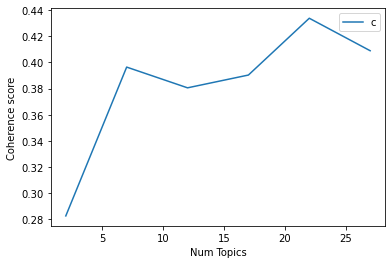

In [46]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_score1)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [47]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_score1):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.2824
index: 1 | Num Topics = 7  has Coherence Value of 0.3964
index: 2 | Num Topics = 12  has Coherence Value of 0.3805
index: 3 | Num Topics = 17  has Coherence Value of 0.3903
index: 4 | Num Topics = 22  has Coherence Value of 0.4339
index: 5 | Num Topics = 27  has Coherence Value of 0.409


In [171]:
# Select optimal number of topics
optimal_model_sg_score1 = model_list_sg_score1[4]

In [172]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_score1 = pyLDAvis.gensim_models.prepare(optimal_model_sg_score1, corpus_sg_score1, id2word_sg_score1)

In [173]:
print("pyLDAVis for SG topics for score=1:")
vis_sg_score1

pyLDAVis for SG topics for score=1:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.262163 -0.008251       1        1  10.632027
2      0.223776  0.017418       2        1   7.559834
16     0.145582  0.152149       3        1   7.445734
18    -0.069008  0.086617       4        1   7.028027
10     0.169972 -0.140878       5        1   6.314111
13     0.098364 -0.231014       6        1   6.281359
9      0.166793  0.078278       7        1   5.545106
12     0.012531  0.121381       8        1   5.092955
3     -0.050367  0.071084       9        1   5.057297
15    -0.127419  0.090625      10        1   4.378533
21    -0.067208 -0.150032      11        1   4.191203
8     -0.007899  0.108411      12        1   4.176333
11     0.003135  0.113107      13        1   4.172873
20    -0.038045 -0.021855      14        1   3.048914
17    -0.134336 -0.008357      15        1   2.956992
4     -0.128775 -0.069489      16        1   2.938969
0     -0.099962  0.091314      17        1   2.747868
19    -0.120970 -0.029029      18        1   2.367687
14    -0.000328 -0.086262      19        1   2.066708
1     -0.063227 -0.043483      20        1   2.046205
6     -0.066542 -0.088123      21        1   1.980027
7     -0.108230 -0.053611      22        1   1.971240, topic_info=         Term        Freq       Total Category  logprob  loglift
9      update  272.000000  272.000000  Default  30.0000  30.0000
25      photo   90.000000   90.000000  Default  29.0000  29.0000
0         app  306.000000  306.000000  Default  28.0000  28.0000
168   account   90.000000   90.000000  Default  27.0000  27.0000
21      video  147.000000  147.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
11       auto    0.792285    8.700084  Topic22  -5.5730   1.5303
24   facebook    2.277951  237.807554  Topic22  -4.5168  -0.7217
256    option    0.794512   14.147974  Topic22  -5.5701   1.0469
210      ever    0.734760   11.524053  Topic22  -5.6483   1.1739
165        fb    0.429077   26.391642  Topic22  -6.1862  -0.1927

[974 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
99        2  0.683602     able
99        6  0.319014     able
1329      3  0.851393   absurd
1590      2  0.844118    abuse
250       4  0.128562   access
...     ...       ...      ...
1015      3  0.527360  youtube
1365     16  0.877608  zionist
233       9  0.845222     zucc
1144     20  0.726615      也吃掉
1145     20  0.726615     打广告钱

[1114 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 17, 19, 11, 14, 10, 13, 4, 16, 22, 9, 12, 21, 18, 5, 1, 20, 15, 2, 7, 8])

## LDA Topic Modelling (Rating = 2)

In [51]:
# By-rating Topic Modelling - rating = 2
# Convert to list - move to each section
review_sg_score2 = facebook_ios_sg_review_YearMonth_score2.review.values.tolist()
review_words_sg_score2 = list(sent_to_words(review_sg_score2))
print(review_words_sg_score2[:1])

[['can', 'view', 'all', 'my', 'albums', 'only', 'select', 'few', 'and', 'the', 'rest', 'are', 'missing']]


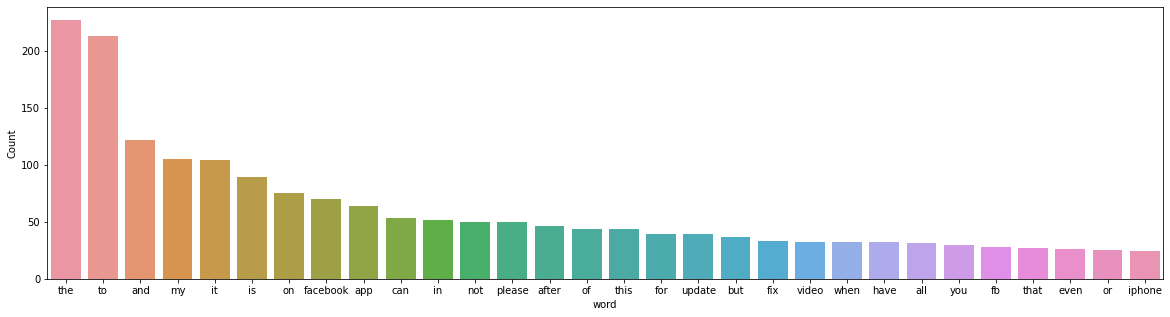

In [52]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_score2))

In [53]:
# Clean text
review_sg_ready_score2 = process_words(review_words_sg_score2)  # processed Text Data! - move to each section


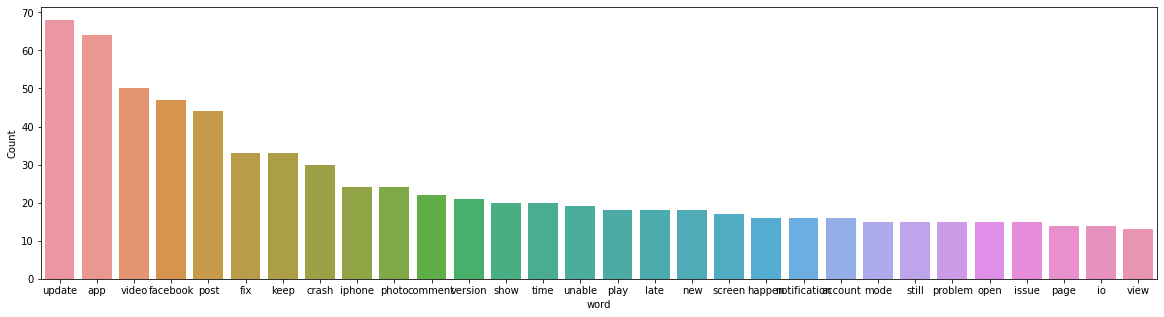

In [54]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_sg_ready_score2))


In [55]:
# Create Dictionary
id2word_sg_score2 = corpora.Dictionary(review_sg_ready_score2)

2021-10-16 18:35:03,285 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 18:35:03,295 [INFO] gensim.corpora.dictionary - built Dictionary(641 unique tokens: ['album', 'miss', 'rest', 'select', 'view']...) from 205 documents (total 2206 corpus positions)
2021-10-16 18:35:03,297 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(641 unique tokens: ['album', 'miss', 'rest', 'select', 'view']...) from 205 documents (total 2206 corpus positions)", 'datetime': '2021-10-16T18:35:03.297698', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [56]:
# Create Corpus: Term Document Frequency
corpus_sg_score2 = [id2word_sg_score2.doc2bow(text) for text in review_sg_ready_score2]

In [57]:
# Training LDA model
model_list_sg_score2, coherence_values_sg_score2 = compute_coherence_values(dictionary=id2word_sg_score2, corpus=corpus_sg_score2, 
                                                              texts=review_sg_ready_score2, limit=30, start=2, step=5)


2021-10-16 18:35:03,321 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 18:35:03,325 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 18:35:03,328 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:35:03,330 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 205 documents, updating model once every 205 documents, evaluating perplexity every 205 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:35:04,152 [INFO] gensim.models.ldamodel - -7.111 per-word bound, 138.3 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:35:04,154 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #205/205
2021-10-16 18:35:04,824 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.023*"app" + 0.019*"video" + 0.018*"post" + 0.017*"facebook" + 0.014*"update" + 0.014*"fix" + 0.011*"cr

2021-10-16 18:35:12,930 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.034*"update" + 0.027*"app" + 0.020*"post" + 0.016*"facebook" + 0.015*"keep" + 0.014*"comment" + 0.012*"iphone" + 0.012*"show" + 0.011*"video" + 0.011*"crash"
2021-10-16 18:35:12,940 [INFO] gensim.models.ldamodel - topic diff=0.014099, rho=0.301511
2021-10-16 18:35:13,272 [INFO] gensim.models.ldamodel - -6.161 per-word bound, 71.6 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:35:13,274 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #205/205
2021-10-16 18:35:13,546 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.027*"video" + 0.018*"facebook" + 0.017*"app" + 0.014*"fix" + 0.014*"play" + 0.011*"update" + 0.011*"crash" + 0.010*"page" + 0.010*"account" + 0.010*"post"
2021-10-16 18:35:13,548 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.034*"update" + 0.027*"app" + 0.020*"post" + 0.016*"facebook" + 0.015*"keep" + 0.014*"comment" + 0.012*"iphone

2021-10-16 18:35:19,105 [INFO] gensim.models.ldamodel - topic diff=0.004830, rho=0.218218
2021-10-16 18:35:19,466 [INFO] gensim.models.ldamodel - -6.155 per-word bound, 71.2 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:35:19,475 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #205/205
2021-10-16 18:35:19,773 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.030*"video" + 0.018*"facebook" + 0.015*"app" + 0.015*"play" + 0.014*"fix" + 0.011*"page" + 0.010*"account" + 0.010*"update" + 0.009*"io" + 0.009*"crash"
2021-10-16 18:35:19,774 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.034*"update" + 0.028*"app" + 0.022*"post" + 0.016*"facebook" + 0.016*"keep" + 0.014*"comment" + 0.013*"iphone" + 0.012*"crash" + 0.012*"show" + 0.011*"late"
2021-10-16 18:35:19,775 [INFO] gensim.models.ldamodel - topic diff=0.004558, rho=0.213201
2021-10-16 18:35:20,103 [INFO] gensim.models.ldamodel - -6.154 per-word bound, 71.2 perplexity est

2021-10-16 18:35:25,428 [INFO] gensim.models.ldamodel - -6.152 per-word bound, 71.1 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:35:25,430 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #205/205
2021-10-16 18:35:25,681 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.033*"video" + 0.017*"facebook" + 0.015*"play" + 0.014*"app" + 0.014*"fix" + 0.011*"page" + 0.010*"account" + 0.010*"update" + 0.009*"back" + 0.009*"io"
2021-10-16 18:35:25,683 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.035*"update" + 0.029*"app" + 0.022*"post" + 0.016*"facebook" + 0.016*"keep" + 0.014*"comment" + 0.013*"iphone" + 0.013*"crash" + 0.012*"show" + 0.011*"late"
2021-10-16 18:35:25,684 [INFO] gensim.models.ldamodel - topic diff=0.002641, rho=0.176777
2021-10-16 18:35:26,035 [INFO] gensim.models.ldamodel - -6.152 per-word bound, 71.1 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:35:26,036 [

2021-10-16 18:35:33,050 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #205/205
2021-10-16 18:35:33,300 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"video" + 0.017*"facebook" + 0.015*"play" + 0.014*"fix" + 0.013*"app" + 0.012*"page" + 0.011*"account" + 0.009*"update" + 0.009*"bug" + 0.009*"back"
2021-10-16 18:35:33,302 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.035*"update" + 0.030*"app" + 0.023*"post" + 0.017*"facebook" + 0.016*"keep" + 0.014*"iphone" + 0.014*"comment" + 0.013*"crash" + 0.012*"show" + 0.011*"late"
2021-10-16 18:35:33,303 [INFO] gensim.models.ldamodel - topic diff=0.002329, rho=0.154303
2021-10-16 18:35:33,659 [INFO] gensim.models.ldamodel - -6.150 per-word bound, 71.0 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:35:33,661 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #205/205
2021-10-16 18:35:33,918 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"video" + 0.

2021-10-16 18:35:38,690 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 18:35:43,464 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 18:35:43,501 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 199 virtual documents
2021-10-16 18:35:43,819 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 18:35:43,821 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 18:35:43,830 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:35:43,833 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 205 documents, updating model once every 205 documents, evaluating perplexity every 205 documents, iterating 50x with a con

2021-10-16 18:35:46,921 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.023*"change" + 0.022*"photo" + 0.019*"app" + 0.016*"version" + 0.015*"update" + 0.014*"album" + 0.014*"pause" + 0.012*"unable" + 0.012*"friend" + 0.012*"view"
2021-10-16 18:35:46,923 [INFO] gensim.models.ldamodel - topic diff=0.060526, rho=0.408248
2021-10-16 18:35:47,193 [INFO] gensim.models.ldamodel - -6.457 per-word bound, 87.9 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:35:47,195 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #205/205
2021-10-16 18:35:47,407 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.031*"video" + 0.021*"post" + 0.021*"view" + 0.020*"keep" + 0.020*"update" + 0.019*"fix" + 0.019*"show" + 0.017*"bug" + 0.014*"version" + 0.013*"play"
2021-10-16 18:35:47,411 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.027*"video" + 0.026*"photo" + 0.023*"post" + 0.020*"account" + 0.019*"app" + 0.018*"facebook" + 0.017*"open" + 0.0

2021-10-16 18:35:49,825 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.026*"video" + 0.026*"photo" + 0.023*"post" + 0.020*"account" + 0.018*"app" + 0.018*"facebook" + 0.018*"open" + 0.016*"unable" + 0.015*"loading" + 0.014*"search"
2021-10-16 18:35:49,829 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.033*"video" + 0.021*"view" + 0.021*"post" + 0.020*"show" + 0.020*"keep" + 0.019*"fix" + 0.019*"update" + 0.017*"bug" + 0.015*"play" + 0.014*"page"
2021-10-16 18:35:49,833 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.047*"post" + 0.023*"name" + 0.020*"fix" + 0.017*"update" + 0.015*"app" + 0.015*"add" + 0.015*"friend" + 0.014*"show" + 0.012*"page" + 0.010*"scroll"
2021-10-16 18:35:49,836 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.050*"comment" + 0.038*"mode" + 0.035*"dark" + 0.024*"video" + 0.019*"watch" + 0.015*"version" + 0.013*"fix" + 0.013*"read" + 0.012*"facebook" + 0.010*"play"
2021-10-16 18:35:49,839 [INFO] gensim.models.ldamodel - topic diff=0.012659, rho=0

2021-10-16 18:35:52,182 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.026*"photo" + 0.026*"video" + 0.023*"post" + 0.021*"account" + 0.018*"app" + 0.018*"facebook" + 0.018*"open" + 0.016*"unable" + 0.015*"loading" + 0.015*"search"
2021-10-16 18:35:52,183 [INFO] gensim.models.ldamodel - topic diff=0.005293, rho=0.242536
2021-10-16 18:35:52,518 [INFO] gensim.models.ldamodel - -6.425 per-word bound, 85.9 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:35:52,524 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #205/205
2021-10-16 18:35:52,662 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.024*"change" + 0.024*"photo" + 0.017*"app" + 0.016*"version" + 0.015*"album" + 0.015*"pause" + 0.015*"unable" + 0.014*"update" + 0.014*"friend" + 0.011*"view"
2021-10-16 18:35:52,664 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.047*"post" + 0.023*"name" + 0.020*"fix" + 0.017*"update" + 0.015*"app" + 0.015*"add" + 0.015*"friend" 

2021-10-16 18:35:55,789 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.027*"update" + 0.022*"function" + 0.022*"facebook" + 0.015*"problem" + 0.014*"version" + 0.013*"keep" + 0.013*"old" + 0.013*"video" + 0.011*"account" + 0.011*"day"
2021-10-16 18:35:55,794 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.056*"app" + 0.048*"update" + 0.042*"crash" + 0.033*"facebook" + 0.026*"iphone" + 0.022*"late" + 0.021*"keep" + 0.016*"fix" + 0.014*"video" + 0.014*"notification"
2021-10-16 18:35:55,797 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.033*"video" + 0.023*"view" + 0.021*"post" + 0.020*"show" + 0.019*"keep" + 0.019*"fix" + 0.018*"update" + 0.017*"bug" + 0.016*"screen" + 0.015*"play"
2021-10-16 18:35:55,800 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.047*"post" + 0.023*"name" + 0.020*"fix" + 0.017*"update" + 0.015*"app" + 0.015*"add" + 0.015*"friend" + 0.015*"show" + 0.012*"page" + 0.010*"scroll"
2021-10-16 18:35:55,803 [INFO] gensim.models.ldamodel - topic diff=0.002

2021-10-16 18:35:58,435 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.033*"video" + 0.023*"view" + 0.021*"post" + 0.020*"show" + 0.019*"keep" + 0.019*"fix" + 0.018*"update" + 0.017*"bug" + 0.016*"screen" + 0.015*"play"
2021-10-16 18:35:58,438 [INFO] gensim.models.ldamodel - topic diff=0.001784, rho=0.188982
2021-10-16 18:35:58,702 [INFO] gensim.models.ldamodel - -6.421 per-word bound, 85.7 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:35:58,703 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #205/205
2021-10-16 18:35:58,850 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.051*"comment" + 0.040*"mode" + 0.036*"dark" + 0.024*"video" + 0.020*"watch" + 0.015*"version" + 0.014*"fix" + 0.014*"read" + 0.011*"still" + 0.010*"play"
2021-10-16 18:35:58,852 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.028*"photo" + 0.024*"change" + 0.018*"album" + 0.017*"app" + 0.017*"unable" + 0.016*"version" + 0.015*"pause" + 0.014*"

2021-10-16 18:36:01,220 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.026*"video" + 0.023*"photo" + 0.023*"post" + 0.021*"account" + 0.018*"app" + 0.018*"open" + 0.018*"facebook" + 0.015*"loading" + 0.015*"search" + 0.014*"unable"
2021-10-16 18:36:01,225 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.026*"update" + 0.022*"function" + 0.021*"facebook" + 0.015*"problem" + 0.014*"version" + 0.013*"keep" + 0.013*"video" + 0.012*"old" + 0.011*"account" + 0.011*"day"
2021-10-16 18:36:01,229 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.030*"photo" + 0.024*"change" + 0.019*"album" + 0.018*"unable" + 0.017*"app" + 0.016*"version" + 0.015*"pause" + 0.014*"friend" + 0.013*"update" + 0.010*"view"
2021-10-16 18:36:01,231 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.051*"comment" + 0.040*"mode" + 0.036*"dark" + 0.024*"video" + 0.020*"watch" + 0.015*"version" + 0.014*"fix" + 0.014*"read" + 0.011*"still" + 0.010*"play"
2021-10-16 18:36:01,237 [INFO] gensim.models.ldamodel - to

2021-10-16 18:36:03,552 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.031*"photo" + 0.024*"change" + 0.019*"album" + 0.018*"unable" + 0.017*"app" + 0.016*"version" + 0.015*"pause" + 0.014*"friend" + 0.013*"update" + 0.011*"iphone"
2021-10-16 18:36:03,553 [INFO] gensim.models.ldamodel - topic diff=0.000639, rho=0.160128
2021-10-16 18:36:03,796 [INFO] gensim.models.ldamodel - -6.419 per-word bound, 85.6 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:36:03,799 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #205/205
2021-10-16 18:36:03,965 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.051*"comment" + 0.040*"mode" + 0.036*"dark" + 0.023*"video" + 0.020*"watch" + 0.015*"version" + 0.014*"fix" + 0.014*"read" + 0.011*"still" + 0.010*"play"
2021-10-16 18:36:03,968 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.048*"post" + 0.023*"name" + 0.020*"fix" + 0.017*"update" + 0.015*"friend" + 0.015*"add" + 0.015*"show" + 0.

2021-10-16 18:36:06,550 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.033*"video" + 0.023*"view" + 0.022*"post" + 0.020*"show" + 0.019*"keep" + 0.018*"fix" + 0.018*"update" + 0.017*"screen" + 0.017*"bug" + 0.015*"play"
2021-10-16 18:36:06,552 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.051*"comment" + 0.040*"mode" + 0.036*"dark" + 0.023*"video" + 0.020*"watch" + 0.015*"version" + 0.014*"fix" + 0.014*"read" + 0.011*"still" + 0.010*"play"
2021-10-16 18:36:06,553 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.027*"video" + 0.023*"post" + 0.022*"photo" + 0.021*"account" + 0.018*"app" + 0.018*"open" + 0.018*"facebook" + 0.015*"loading" + 0.015*"search" + 0.013*"unable"
2021-10-16 18:36:06,554 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.055*"app" + 0.049*"update" + 0.042*"crash" + 0.033*"facebook" + 0.026*"iphone" + 0.023*"late" + 0.021*"keep" + 0.016*"fix" + 0.014*"video" + 0.014*"notification"
2021-10-16 18:36:06,555 [INFO] gensim.models.ldamodel - topic diff=0.0

2021-10-16 18:36:08,850 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.051*"comment" + 0.040*"mode" + 0.036*"dark" + 0.023*"video" + 0.020*"watch" + 0.015*"version" + 0.014*"fix" + 0.014*"read" + 0.011*"still" + 0.010*"play"
2021-10-16 18:36:08,851 [INFO] gensim.models.ldamodel - topic diff=0.000248, rho=0.141421
2021-10-16 18:36:09,115 [INFO] gensim.models.ldamodel - -6.418 per-word bound, 85.5 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:36:09,119 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #205/205
2021-10-16 18:36:09,311 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.031*"photo" + 0.024*"change" + 0.019*"album" + 0.018*"unable" + 0.017*"app" + 0.016*"version" + 0.015*"pause" + 0.014*"friend" + 0.013*"update" + 0.011*"iphone"
2021-10-16 18:36:09,313 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.026*"update" + 0.022*"function" + 0.021*"facebook" + 0.015*"problem" + 0.014*"version" + 0.013*"keep" + 0.0

2021-10-16 18:36:17,836 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.083*"comment" + 0.027*"read" + 0.027*"post" + 0.021*"show" + 0.020*"watch" + 0.020*"video" + 0.014*"fix" + 0.014*"battery" + 0.014*"properly" + 0.014*"version"
2021-10-16 18:36:17,838 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.048*"app" + 0.038*"dark" + 0.037*"mode" + 0.029*"late" + 0.024*"update" + 0.019*"facebook" + 0.019*"still" + 0.018*"help" + 0.017*"happen" + 0.017*"open"
2021-10-16 18:36:17,840 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.036*"view" + 0.025*"comment" + 0.021*"video" + 0.021*"version" + 0.021*"post" + 0.016*"newsfeed" + 0.016*"play" + 0.016*"happen" + 0.016*"update" + 0.016*"keep"
2021-10-16 18:36:17,843 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.055*"photo" + 0.036*"change" + 0.029*"unable" + 0.022*"feature" + 0.021*"album" + 0.020*"profile" + 0.017*"comment" + 0.016*"happen" + 0.016*"back" + 0.016*"problem"
2021-10-16 18:36:17,845 [INFO] gensim.models.ldamodel -

2021-10-16 18:36:20,054 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.047*"app" + 0.042*"dark" + 0.042*"mode" + 0.032*"late" + 0.023*"update" + 0.021*"version" + 0.019*"facebook" + 0.019*"still" + 0.017*"help" + 0.017*"happen"
2021-10-16 18:36:20,055 [INFO] gensim.models.ldamodel - topic diff=0.022822, rho=0.316228
2021-10-16 18:36:20,308 [INFO] gensim.models.ldamodel - -6.593 per-word bound, 96.5 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:36:20,312 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #205/205
2021-10-16 18:36:20,468 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.053*"crash" + 0.039*"video" + 0.027*"keep" + 0.024*"play" + 0.022*"still" + 0.022*"photo" + 0.022*"app" + 0.022*"sometimes" + 0.022*"bug" + 0.016*"time"
2021-10-16 18:36:20,474 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.037*"update" + 0.027*"facebook" + 0.023*"app" + 0.019*"function" + 0.019*"access" + 0.015*"back" + 0.015*"late" 

2021-10-16 18:36:22,669 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.043*"name" + 0.019*"update" + 0.019*"video" + 0.019*"ppl" + 0.019*"error" + 0.018*"post" + 0.017*"fix" + 0.013*"click" + 0.013*"live" + 0.013*"reply"
2021-10-16 18:36:22,671 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.036*"update" + 0.029*"facebook" + 0.025*"app" + 0.019*"function" + 0.019*"access" + 0.016*"open" + 0.016*"close" + 0.016*"screen" + 0.016*"video" + 0.015*"back"
2021-10-16 18:36:22,673 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.051*"app" + 0.041*"update" + 0.036*"facebook" + 0.021*"crash" + 0.020*"iphone" + 0.018*"fix" + 0.018*"keep" + 0.017*"notification" + 0.017*"screen" + 0.014*"share"
2021-10-16 18:36:22,675 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.055*"update" + 0.034*"keep" + 0.030*"app" + 0.029*"post" + 0.027*"iphone" + 0.026*"fix" + 0.025*"crash" + 0.016*"video" + 0.015*"hang" + 0.015*"show"
2021-10-16 18:36:22,677 [INFO] gensim.models.ldamodel - topic diff=0.00

2021-10-16 18:36:24,924 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.038*"view" + 0.027*"comment" + 0.022*"video" + 0.022*"post" + 0.017*"version" + 0.017*"newsfeed" + 0.017*"play" + 0.017*"happen" + 0.016*"update" + 0.011*"keep"
2021-10-16 18:36:24,925 [INFO] gensim.models.ldamodel - topic diff=0.002377, rho=0.218218
2021-10-16 18:36:25,181 [INFO] gensim.models.ldamodel - -6.585 per-word bound, 96.0 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:36:25,183 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #205/205
2021-10-16 18:36:25,412 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.038*"video" + 0.028*"facebook" + 0.023*"account" + 0.023*"post" + 0.023*"photo" + 0.017*"ad" + 0.017*"unable" + 0.017*"load" + 0.012*"due" + 0.012*"work"
2021-10-16 18:36:25,414 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.038*"view" + 0.027*"comment" + 0.022*"video" + 0.022*"post" + 0.017*"version" + 0.017*"newsfeed" + 0.017*"p

2021-10-16 18:36:27,584 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.038*"view" + 0.027*"comment" + 0.022*"video" + 0.022*"post" + 0.017*"version" + 0.017*"newsfeed" + 0.017*"happen" + 0.017*"play" + 0.016*"update" + 0.011*"keep"
2021-10-16 18:36:27,588 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.035*"update" + 0.030*"facebook" + 0.026*"app" + 0.019*"function" + 0.019*"access" + 0.019*"close" + 0.018*"open" + 0.018*"screen" + 0.016*"video" + 0.016*"back"
2021-10-16 18:36:27,590 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.053*"crash" + 0.039*"video" + 0.026*"keep" + 0.025*"play" + 0.022*"still" + 0.022*"photo" + 0.022*"app" + 0.022*"bug" + 0.022*"sometimes" + 0.016*"time"
2021-10-16 18:36:27,593 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.051*"app" + 0.041*"update" + 0.036*"facebook" + 0.021*"crash" + 0.019*"iphone" + 0.019*"fix" + 0.019*"keep" + 0.017*"screen" + 0.016*"notification" + 0.014*"share"
2021-10-16 18:36:27,595 [INFO] gensim.models.ldamodel - 

2021-10-16 18:36:29,917 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.084*"comment" + 0.026*"post" + 0.026*"read" + 0.026*"watch" + 0.023*"video" + 0.021*"show" + 0.020*"properly" + 0.014*"fix" + 0.013*"time" + 0.013*"battery"
2021-10-16 18:36:29,918 [INFO] gensim.models.ldamodel - topic diff=0.001809, rho=0.176777
2021-10-16 18:36:30,188 [INFO] gensim.models.ldamodel - -6.578 per-word bound, 95.6 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:36:30,191 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #205/205
2021-10-16 18:36:30,334 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.038*"video" + 0.028*"facebook" + 0.023*"account" + 0.023*"post" + 0.023*"photo" + 0.017*"ad" + 0.017*"unable" + 0.017*"load" + 0.012*"due" + 0.012*"work"
2021-10-16 18:36:30,336 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.057*"update" + 0.036*"post" + 0.035*"keep" + 0.030*"iphone" + 0.029*"app" + 0.029*"fix" + 0.027*"crash" + 0.018

2021-10-16 18:36:32,553 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.046*"app" + 0.046*"dark" + 0.044*"mode" + 0.033*"late" + 0.023*"version" + 0.022*"still" + 0.019*"facebook" + 0.019*"update" + 0.018*"help" + 0.018*"open"
2021-10-16 18:36:32,560 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.044*"name" + 0.019*"update" + 0.019*"video" + 0.019*"ppl" + 0.019*"error" + 0.018*"post" + 0.017*"fix" + 0.013*"click" + 0.013*"live" + 0.013*"translation"
2021-10-16 18:36:32,563 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.053*"crash" + 0.040*"video" + 0.025*"play" + 0.023*"keep" + 0.022*"still" + 0.022*"photo" + 0.022*"app" + 0.022*"bug" + 0.022*"sometimes" + 0.017*"time"
2021-10-16 18:36:32,565 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.051*"app" + 0.041*"update" + 0.036*"facebook" + 0.021*"crash" + 0.019*"iphone" + 0.019*"fix" + 0.019*"keep" + 0.017*"screen" + 0.016*"notification" + 0.014*"share"
2021-10-16 18:36:32,568 [INFO] gensim.models.ldamodel - topic diff=

2021-10-16 18:36:34,731 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.049*"video" + 0.025*"facebook" + 0.023*"page" + 0.018*"play" + 0.016*"post" + 0.013*"screen" + 0.013*"happen" + 0.013*"move" + 0.013*"datum" + 0.012*"app"
2021-10-16 18:36:34,733 [INFO] gensim.models.ldamodel - topic diff=0.001572, rho=0.152499
2021-10-16 18:36:35,049 [INFO] gensim.models.ldamodel - -6.574 per-word bound, 95.3 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:36:35,051 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #205/205
2021-10-16 18:36:35,180 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.038*"video" + 0.028*"facebook" + 0.023*"account" + 0.023*"photo" + 0.023*"post" + 0.017*"unable" + 0.017*"ad" + 0.017*"load" + 0.012*"due" + 0.012*"work"
2021-10-16 18:36:35,182 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.032*"post" + 0.031*"update" + 0.029*"recent" + 0.027*"add" + 0.025*"feature" + 0.025*"user" + 0.024*"app" + 0.02

2021-10-16 18:36:37,308 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.048*"dark" + 0.047*"mode" + 0.045*"app" + 0.032*"late" + 0.024*"still" + 0.023*"version" + 0.018*"help" + 0.018*"happen" + 0.018*"open" + 0.016*"facebook"
2021-10-16 18:36:37,312 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.049*"video" + 0.025*"facebook" + 0.023*"page" + 0.018*"play" + 0.016*"post" + 0.013*"screen" + 0.013*"happen" + 0.013*"move" + 0.013*"datum" + 0.012*"app"
2021-10-16 18:36:37,315 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.035*"update" + 0.030*"facebook" + 0.026*"app" + 0.020*"function" + 0.020*"access" + 0.019*"close" + 0.019*"open" + 0.019*"screen" + 0.016*"back" + 0.016*"notification"
2021-10-16 18:36:37,317 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.052*"app" + 0.042*"update" + 0.036*"facebook" + 0.022*"crash" + 0.019*"iphone" + 0.019*"fix" + 0.019*"keep" + 0.017*"screen" + 0.016*"notification" + 0.014*"share"
2021-10-16 18:36:37,320 [INFO] gensim.models.ldamodel

2021-10-16 18:36:47,205 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.036*"app" + 0.029*"mode" + 0.028*"dark" + 0.025*"still" + 0.022*"name" + 0.018*"facebook" + 0.018*"account" + 0.017*"open" + 0.016*"keep" + 0.016*"phone"
2021-10-16 18:36:47,208 [INFO] gensim.models.ldamodel - topic diff=0.181009, rho=0.577350
2021-10-16 18:36:47,531 [INFO] gensim.models.ldamodel - -6.871 per-word bound, 117.0 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:36:47,533 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #205/205
2021-10-16 18:36:47,698 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.036*"happen" + 0.036*"view" + 0.027*"comment" + 0.020*"tap" + 0.020*"screen" + 0.020*"playable" + 0.020*"watch" + 0.020*"video" + 0.018*"back" + 0.018*"previous"
2021-10-16 18:36:47,703 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.053*"video" + 0.021*"iphone" + 0.021*"facebook" + 0.021*"play" + 0.020*"sound" + 0.020*"activate" + 0.019

2021-10-16 18:36:49,923 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.038*"happen" + 0.038*"view" + 0.029*"comment" + 0.019*"tap" + 0.019*"screen" + 0.019*"playable" + 0.019*"watch" + 0.019*"video" + 0.019*"back" + 0.019*"previous"
2021-10-16 18:36:49,925 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.045*"photo" + 0.035*"access" + 0.028*"album" + 0.023*"problem" + 0.021*"function" + 0.021*"keep" + 0.021*"already" + 0.018*"update" + 0.015*"facebook" + 0.014*"wall"
2021-10-16 18:36:49,927 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.078*"comment" + 0.025*"version" + 0.018*"resolve" + 0.018*"notification" + 0.018*"share" + 0.014*"kindly" + 0.014*"mode" + 0.014*"late" + 0.013*"update" + 0.012*"annoying"
2021-10-16 18:36:49,929 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.043*"video" + 0.038*"post" + 0.027*"show" + 0.027*"update" + 0.026*"facebook" + 0.022*"fix" + 0.022*"recent" + 0.016*"look" + 0.016*"ppl" + 0.016*"user"
2021-10-16 18:36:49,933 [INFO] gensim.mode

2021-10-16 18:36:52,069 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.044*"update" + 0.042*"facebook" + 0.030*"notification" + 0.028*"much" + 0.023*"app" + 0.023*"time" + 0.023*"video" + 0.023*"click" + 0.022*"pro" + 0.020*"fix"
2021-10-16 18:36:52,072 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.059*"video" + 0.023*"play" + 0.023*"sound" + 0.023*"activate" + 0.022*"screen" + 0.020*"iphone" + 0.018*"facebook" + 0.017*"page" + 0.017*"happen" + 0.017*"camera"
2021-10-16 18:36:52,074 [INFO] gensim.models.ldamodel - topic diff=0.013704, rho=0.267261
2021-10-16 18:36:52,317 [INFO] gensim.models.ldamodel - -6.707 per-word bound, 104.5 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:36:52,319 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #205/205
2021-10-16 18:36:52,438 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.081*"comment" + 0.025*"version" + 0.018*"resolve" + 0.018*"notification" + 0.018*"share" + 0.018

2021-10-16 18:36:54,479 [INFO] gensim.models.ldamodel - -6.697 per-word bound, 103.8 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:36:54,482 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #205/205
2021-10-16 18:36:54,697 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.052*"comment" + 0.031*"photo" + 0.026*"feature" + 0.026*"version" + 0.026*"profile" + 0.023*"unable" + 0.020*"read" + 0.020*"show" + 0.020*"picture" + 0.020*"feed"
2021-10-16 18:36:54,700 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.060*"video" + 0.023*"play" + 0.023*"sound" + 0.023*"activate" + 0.023*"screen" + 0.019*"iphone" + 0.017*"facebook" + 0.017*"page" + 0.017*"happen" + 0.017*"camera"
2021-10-16 18:36:54,702 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.038*"happen" + 0.038*"view" + 0.029*"comment" + 0.019*"playable" + 0.019*"tap" + 0.019*"screen" + 0.019*"watch" + 0.019*"video" + 0.019*"back" + 0.019*"previous"
2021-10-16 18:36:54,

2021-10-16 18:36:56,841 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.034*"facebook" + 0.027*"post" + 0.023*"account" + 0.018*"advertisement" + 0.016*"due" + 0.016*"help" + 0.012*"newsfeed" + 0.012*"app" + 0.012*"poor" + 0.008*"hotmail"
2021-10-16 18:36:56,843 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.050*"video" + 0.037*"post" + 0.027*"facebook" + 0.026*"show" + 0.026*"update" + 0.026*"fix" + 0.021*"recent" + 0.018*"play" + 0.016*"pause" + 0.016*"scroll"
2021-10-16 18:36:56,845 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.044*"update" + 0.042*"facebook" + 0.030*"notification" + 0.030*"much" + 0.023*"app" + 0.023*"video" + 0.023*"time" + 0.023*"click" + 0.023*"pro" + 0.018*"fix"
2021-10-16 18:36:56,847 [INFO] gensim.models.ldamodel - topic diff=0.003177, rho=0.200000
2021-10-16 18:36:57,145 [INFO] gensim.models.ldamodel - -6.691 per-word bound, 103.3 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:36:57,152 [INFO] 

2021-10-16 18:36:58,941 [INFO] gensim.models.ldamodel - topic diff=0.001763, rho=0.182574
2021-10-16 18:36:59,373 [INFO] gensim.models.ldamodel - -6.689 per-word bound, 103.2 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:36:59,379 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #205/205
2021-10-16 18:36:59,578 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.038*"happen" + 0.038*"view" + 0.029*"comment" + 0.019*"playable" + 0.019*"tap" + 0.019*"screen" + 0.019*"watch" + 0.019*"video" + 0.019*"back" + 0.019*"previous"
2021-10-16 18:36:59,582 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.025*"version" + 0.025*"video" + 0.023*"app" + 0.020*"watch" + 0.015*"add" + 0.015*"ad" + 0.012*"new" + 0.010*"feature" + 0.010*"show" + 0.010*"list"
2021-10-16 18:36:59,584 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.048*"post" + 0.032*"remove" + 0.032*"interest" + 0.032*"edit" + 0.032*"laggy" + 0.017*"update" + 0.017*"becom

2021-10-16 18:37:02,538 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.060*"dark" + 0.058*"mode" + 0.036*"still" + 0.030*"app" + 0.025*"facebook" + 0.022*"name" + 0.019*"version" + 0.017*"late" + 0.016*"account" + 0.016*"disappear"
2021-10-16 18:37:02,540 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.082*"comment" + 0.023*"version" + 0.019*"resolve" + 0.019*"share" + 0.019*"kindly" + 0.018*"notification" + 0.011*"mode" + 0.010*"late" + 0.010*"update" + 0.010*"post"
2021-10-16 18:37:02,542 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.025*"version" + 0.025*"video" + 0.023*"app" + 0.020*"watch" + 0.015*"add" + 0.015*"ad" + 0.012*"new" + 0.010*"feature" + 0.010*"show" + 0.010*"game"
2021-10-16 18:37:02,548 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.033*"facebook" + 0.027*"post" + 0.024*"account" + 0.017*"advertisement" + 0.016*"due" + 0.016*"help" + 0.012*"newsfeed" + 0.012*"app" + 0.012*"poor" + 0.008*"block"
2021-10-16 18:37:02,550 [INFO] gensim.models.ldamode

2021-10-16 18:37:05,322 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.054*"update" + 0.054*"post" + 0.031*"video" + 0.026*"keep" + 0.024*"group" + 0.021*"app" + 0.020*"fix" + 0.020*"jump" + 0.020*"day" + 0.019*"late"
2021-10-16 18:37:05,324 [INFO] gensim.models.ldamodel - topic diff=0.000612, rho=0.156174
2021-10-16 18:37:05,598 [INFO] gensim.models.ldamodel - -6.688 per-word bound, 103.1 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:37:05,600 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #205/205
2021-10-16 18:37:05,788 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.025*"version" + 0.025*"video" + 0.023*"app" + 0.020*"watch" + 0.015*"add" + 0.015*"ad" + 0.012*"new" + 0.010*"feature" + 0.010*"show" + 0.010*"friend"
2021-10-16 18:37:05,790 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.054*"update" + 0.054*"post" + 0.031*"video" + 0.026*"keep" + 0.024*"group" + 0.021*"app" + 0.020*"fix" + 0.020*"jump" + 0

2021-10-16 18:37:07,936 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.051*"facebook" + 0.042*"account" + 0.038*"photo" + 0.021*"time" + 0.021*"lock" + 0.021*"video" + 0.021*"check" + 0.021*"security" + 0.021*"upload" + 0.021*"work"
2021-10-16 18:37:07,939 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.025*"version" + 0.025*"video" + 0.023*"app" + 0.020*"watch" + 0.015*"add" + 0.015*"ad" + 0.012*"new" + 0.010*"feature" + 0.010*"friend" + 0.010*"list"
2021-10-16 18:37:07,942 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.048*"photo" + 0.037*"access" + 0.029*"album" + 0.022*"already" + 0.022*"function" + 0.022*"problem" + 0.018*"keep" + 0.016*"facebook" + 0.015*"wall" + 0.015*"highlight"
2021-10-16 18:37:07,944 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.033*"facebook" + 0.027*"post" + 0.024*"account" + 0.017*"advertisement" + 0.016*"due" + 0.016*"help" + 0.012*"newsfeed" + 0.012*"app" + 0.012*"poor" + 0.008*"hotmail"
2021-10-16 18:37:07,946 [INFO] gensim.models.l

2021-10-16 18:37:17,772 [INFO] gensim.models.ldamodel - using symmetric eta at 0.045454545454545456
2021-10-16 18:37:17,777 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:37:17,784 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 22 topics, 50 passes over the supplied corpus of 205 documents, updating model once every 205 documents, evaluating perplexity every 205 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:37:18,233 [INFO] gensim.models.ldamodel - -18.474 per-word bound, 364027.9 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:37:18,235 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #205/205
2021-10-16 18:37:18,659 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.065*"update" + 0.050*"app" + 0.030*"setting" + 0.028*"post" + 0.019*"recent" + 0.018*"uninstall" + 0.018*"close" + 0.015*"reply" + 0.015*"restore" + 0.015*"knowledge

2021-10-16 18:37:20,540 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #205/205
2021-10-16 18:37:20,672 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.051*"app" + 0.045*"update" + 0.042*"crash" + 0.038*"fix" + 0.037*"keep" + 0.031*"name" + 0.031*"comment" + 0.030*"always" + 0.027*"late" + 0.023*"read"
2021-10-16 18:37:20,674 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.044*"video" + 0.037*"update" + 0.033*"new" + 0.025*"bug" + 0.020*"page" + 0.020*"click" + 0.020*"name" + 0.014*"reset" + 0.014*"feature" + 0.014*"top"
2021-10-16 18:37:20,675 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.065*"photo" + 0.048*"post" + 0.039*"show" + 0.021*"fix" + 0.020*"album" + 0.019*"issue" + 0.019*"click" + 0.017*"update" + 0.015*"datum" + 0.015*"profile"
2021-10-16 18:37:20,677 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.051*"add" + 0.051*"update" + 0.035*"story" + 0.035*"app" + 0.018*"screen" + 0.018*"find" + 0.018*"name" + 0.018*"developer" + 0.018*"ipad" + 

2021-10-16 18:37:22,854 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.029*"update" + 0.020*"app" + 0.020*"iphone" + 0.020*"feature" + 0.020*"open" + 0.020*"phone" + 0.020*"log" + 0.020*"happen" + 0.010*"time" + 0.010*"version"
2021-10-16 18:37:22,858 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.039*"facebook" + 0.027*"account" + 0.023*"notification" + 0.019*"app" + 0.018*"due" + 0.018*"advertisement" + 0.014*"ppl" + 0.014*"close" + 0.014*"give" + 0.014*"poor"
2021-10-16 18:37:22,864 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.087*"comment" + 0.036*"facebook" + 0.030*"fix" + 0.027*"video" + 0.027*"watch" + 0.018*"keep" + 0.018*"late" + 0.017*"kindly" + 0.011*"update" + 0.011*"unable"
2021-10-16 18:37:22,866 [INFO] gensim.models.ldamodel - topic diff=0.025828, rho=0.288675
2021-10-16 18:37:23,165 [INFO] gensim.models.ldamodel - -6.767 per-word bound, 108.9 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:37:23,166 [INFO] 

2021-10-16 18:37:25,584 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.088*"comment" + 0.036*"facebook" + 0.030*"fix" + 0.027*"video" + 0.027*"watch" + 0.018*"keep" + 0.018*"late" + 0.018*"kindly" + 0.011*"update" + 0.011*"unable"
2021-10-16 18:37:25,586 [INFO] gensim.models.ldamodel - topic diff=0.008038, rho=0.242536
2021-10-16 18:37:25,925 [INFO] gensim.models.ldamodel - -6.758 per-word bound, 108.3 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:37:25,927 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #205/205
2021-10-16 18:37:26,096 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.051*"add" + 0.051*"update" + 0.035*"story" + 0.035*"app" + 0.018*"screen" + 0.018*"find" + 0.018*"start" + 0.018*"ipad" + 0.018*"ago" + 0.018*"feature"
2021-10-16 18:37:26,099 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.070*"photo" + 0.048*"post" + 0.039*"show" + 0.024*"album" + 0.022*"fix" + 0.020*"issue" + 0.020*"click" + 0.0

2021-10-16 18:37:28,334 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.044*"post" + 0.026*"facebook" + 0.026*"page" + 0.026*"update" + 0.018*"still" + 0.018*"newsfeed" + 0.018*"version" + 0.018*"share" + 0.018*"dark" + 0.018*"mode"
2021-10-16 18:37:28,340 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.075*"video" + 0.048*"play" + 0.030*"ad" + 0.025*"issue" + 0.024*"annoying" + 0.018*"access" + 0.018*"already" + 0.018*"sound" + 0.018*"newsfeed" + 0.018*"happen"
2021-10-16 18:37:28,345 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.044*"video" + 0.037*"update" + 0.034*"new" + 0.026*"bug" + 0.021*"page" + 0.021*"name" + 0.021*"click" + 0.014*"reset" + 0.014*"last" + 0.014*"show"
2021-10-16 18:37:28,348 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.055*"crash" + 0.055*"keep" + 0.053*"facebook" + 0.037*"recent" + 0.030*"stop" + 0.026*"app" + 0.025*"update" + 0.023*"feed" + 0.023*"scroll" + 0.023*"play"
2021-10-16 18:37:28,351 [INFO] gensim.models.ldamodel - topic di

2021-10-16 18:37:30,422 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.037*"facebook" + 0.028*"account" + 0.023*"notification" + 0.019*"app" + 0.019*"due" + 0.019*"advertisement" + 0.014*"ppl" + 0.014*"close" + 0.014*"give" + 0.014*"poor"
2021-10-16 18:37:30,423 [INFO] gensim.models.ldamodel - topic diff=0.001610, rho=0.188982
2021-10-16 18:37:30,642 [INFO] gensim.models.ldamodel - -6.756 per-word bound, 108.1 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:37:30,644 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #205/205
2021-10-16 18:37:30,806 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.037*"app" + 0.037*"version" + 0.028*"security" + 0.028*"messenger" + 0.022*"work" + 0.019*"privacy" + 0.019*"feature" + 0.019*"user" + 0.019*"error" + 0.019*"issue"
2021-10-16 18:37:30,807 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.037*"facebook" + 0.028*"account" + 0.023*"notification" + 0.019*"app" + 0.019*"due" +

2021-10-16 18:37:32,948 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.053*"app" + 0.048*"update" + 0.043*"crash" + 0.043*"fix" + 0.037*"keep" + 0.030*"name" + 0.030*"comment" + 0.030*"always" + 0.030*"late" + 0.023*"read"
2021-10-16 18:37:32,950 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.088*"comment" + 0.036*"facebook" + 0.030*"fix" + 0.027*"video" + 0.027*"watch" + 0.018*"keep" + 0.018*"late" + 0.018*"kindly" + 0.011*"unable" + 0.011*"update"
2021-10-16 18:37:32,952 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.044*"video" + 0.037*"update" + 0.034*"new" + 0.026*"bug" + 0.021*"page" + 0.021*"name" + 0.021*"click" + 0.014*"reset" + 0.014*"last" + 0.014*"show"
2021-10-16 18:37:32,955 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.071*"photo" + 0.048*"post" + 0.039*"show" + 0.025*"album" + 0.021*"fix" + 0.020*"issue" + 0.020*"click" + 0.019*"unable" + 0.016*"update" + 0.015*"datum"
2021-10-16 18:37:32,956 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.05

2021-10-16 18:37:35,208 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.051*"comment" + 0.051*"account" + 0.049*"facebook" + 0.044*"photo" + 0.026*"show" + 0.026*"app" + 0.026*"security" + 0.026*"check" + 0.026*"upload" + 0.013*"time"
2021-10-16 18:37:35,209 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.065*"update" + 0.053*"post" + 0.030*"app" + 0.027*"group" + 0.021*"late" + 0.021*"problem" + 0.018*"fix" + 0.016*"button" + 0.016*"video" + 0.016*"watch"
2021-10-16 18:37:35,211 [INFO] gensim.models.ldamodel - topic diff=0.000748, rho=0.160128
2021-10-16 18:37:35,613 [INFO] gensim.models.ldamodel - -6.752 per-word bound, 107.8 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:37:35,614 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #205/205
2021-10-16 18:37:35,833 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.044*"video" + 0.037*"update" + 0.034*"new" + 0.026*"bug" + 0.021*"page" + 0.021*"name" + 0.021*"click"

2021-10-16 18:37:38,426 [INFO] gensim.models.ldamodel - -6.750 per-word bound, 107.7 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:37:38,428 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #205/205
2021-10-16 18:37:38,604 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.066*"update" + 0.050*"app" + 0.033*"setting" + 0.017*"post" + 0.017*"uninstall" + 0.017*"close" + 0.017*"include" + 0.017*"possibly" + 0.017*"knowledge" + 0.017*"recent"
2021-10-16 18:37:38,665 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.077*"video" + 0.049*"play" + 0.031*"ad" + 0.027*"issue" + 0.025*"annoying" + 0.019*"access" + 0.019*"sound" + 0.019*"already" + 0.019*"newsfeed" + 0.019*"happen"
2021-10-16 18:37:38,666 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.037*"app" + 0.029*"view" + 0.029*"version" + 0.029*"still" + 0.029*"people" + 0.022*"comment" + 0.015*"help" + 0.015*"account" + 0.015*"time" + 0.015*"log"
2021-10-16 18:37:38,66

2021-10-16 18:37:41,092 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.062*"app" + 0.042*"update" + 0.033*"crash" + 0.030*"notification" + 0.030*"iphone" + 0.026*"facebook" + 0.021*"fix" + 0.013*"delete" + 0.013*"photo" + 0.013*"io"
2021-10-16 18:37:41,094 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.076*"video" + 0.068*"mode" + 0.068*"dark" + 0.026*"disappear" + 0.026*"pause" + 0.018*"facebook" + 0.017*"crash" + 0.017*"io" + 0.017*"late" + 0.017*"watch"
2021-10-16 18:37:41,097 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.038*"update" + 0.032*"function" + 0.025*"app" + 0.025*"video" + 0.025*"much" + 0.019*"late" + 0.019*"new" + 0.019*"back" + 0.019*"slow" + 0.019*"friend"
2021-10-16 18:37:41,100 [INFO] gensim.models.ldamodel - topic diff=0.000482, rho=0.141421
2021-10-16 18:37:41,336 [INFO] gensim.models.ldamodel - -6.749 per-word bound, 107.6 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:37:41,338 [INFO] gensim.models

2021-10-16 18:37:52,582 [INFO] gensim.models.ldamodel - topic diff=0.173259, rho=0.500000
2021-10-16 18:37:52,826 [INFO] gensim.models.ldamodel - -7.009 per-word bound, 128.8 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:37:52,827 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #205/205
2021-10-16 18:37:52,978 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.081*"comment" + 0.061*"view" + 0.049*"problem" + 0.024*"app" + 0.021*"login" + 0.021*"translation" + 0.021*"show" + 0.021*"happen" + 0.021*"key" + 0.021*"version"
2021-10-16 18:37:52,980 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.085*"video" + 0.031*"play" + 0.025*"show" + 0.023*"facebook" + 0.023*"post" + 0.021*"update" + 0.020*"stop" + 0.020*"pause" + 0.020*"issue" + 0.019*"keep"
2021-10-16 18:37:52,981 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.073*"update" + 0.037*"app" + 0.027*"iphone" + 0.027*"upload" + 0.027*"fix" + 0.027*"io" + 0.018*"versio

2021-10-16 18:37:55,217 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.079*"post" + 0.053*"update" + 0.039*"add" + 0.031*"group" + 0.024*"story" + 0.023*"ago" + 0.023*"problem" + 0.022*"unable" + 0.016*"setting" + 0.016*"open"
2021-10-16 18:37:55,219 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.052*"name" + 0.044*"crash" + 0.034*"max" + 0.034*"iphone" + 0.027*"pro" + 0.018*"kill" + 0.018*"stuck" + 0.018*"member" + 0.018*"browse" + 0.018*"order"
2021-10-16 18:37:55,220 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.067*"new" + 0.027*"app" + 0.027*"keep" + 0.027*"lag" + 0.027*"smooth" + 0.027*"video" + 0.022*"update" + 0.014*"version" + 0.014*"facebook" + 0.014*"well"
2021-10-16 18:37:55,222 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.078*"app" + 0.029*"update" + 0.027*"facebook" + 0.027*"fix" + 0.022*"time" + 0.020*"crash" + 0.019*"iphone" + 0.019*"delete" + 0.015*"photo" + 0.014*"always"
2021-10-16 18:37:55,224 [INFO] gensim.models.ldamodel - topic diff=0.03772

2021-10-16 18:37:57,341 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.050*"notification" + 0.050*"comment" + 0.022*"account" + 0.022*"facebook" + 0.022*"app" + 0.021*"unable" + 0.018*"mode" + 0.015*"block" + 0.015*"password" + 0.015*"hotmail"
2021-10-16 18:37:57,343 [INFO] gensim.models.ldamodel - topic diff=0.014238, rho=0.258199
2021-10-16 18:37:57,566 [INFO] gensim.models.ldamodel - -6.863 per-word bound, 116.4 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:37:57,568 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #205/205
2021-10-16 18:37:57,749 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.071*"fix" + 0.054*"bug" + 0.036*"picture" + 0.036*"search" + 0.018*"iphone" + 0.018*"time" + 0.018*"old" + 0.018*"browse" + 0.018*"computer" + 0.018*"upload"
2021-10-16 18:37:57,752 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.076*"new" + 0.027*"app" + 0.027*"keep" + 0.027*"smooth" + 0.027*"lag" + 0.026*"video" + 0

2021-10-16 18:37:59,794 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #205/205
2021-10-16 18:37:59,968 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.066*"update" + 0.049*"video" + 0.044*"app" + 0.037*"watch" + 0.015*"play" + 0.015*"keep" + 0.015*"messenger" + 0.015*"security" + 0.015*"feature" + 0.015*"privacy"
2021-10-16 18:37:59,970 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.072*"update" + 0.036*"app" + 0.027*"iphone" + 0.027*"upload" + 0.027*"fix" + 0.027*"io" + 0.027*"screen" + 0.027*"close" + 0.021*"video" + 0.018*"version"
2021-10-16 18:37:59,971 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.050*"notification" + 0.050*"comment" + 0.022*"account" + 0.022*"app" + 0.022*"facebook" + 0.022*"unable" + 0.017*"mode" + 0.015*"password" + 0.015*"due" + 0.015*"hotmail"
2021-10-16 18:37:59,977 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.040*"interest" + 0.040*"remove" + 0.040*"activate" + 0.040*"info" + 0.040*"provide" + 0.020*"mode" + 0.020*"

2021-10-16 18:38:02,131 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.072*"update" + 0.036*"app" + 0.027*"iphone" + 0.027*"upload" + 0.027*"fix" + 0.027*"io" + 0.027*"screen" + 0.027*"close" + 0.021*"video" + 0.018*"version"
2021-10-16 18:38:02,134 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.077*"app" + 0.029*"update" + 0.029*"fix" + 0.027*"facebook" + 0.024*"time" + 0.020*"crash" + 0.019*"iphone" + 0.019*"delete" + 0.014*"photo" + 0.014*"always"
2021-10-16 18:38:02,138 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.084*"comment" + 0.063*"view" + 0.042*"problem" + 0.022*"app" + 0.021*"key" + 0.021*"previous" + 0.021*"happen" + 0.021*"show" + 0.021*"version" + 0.021*"login"
2021-10-16 18:38:02,141 [INFO] gensim.models.ldamodel - topic diff=0.004123, rho=0.196116
2021-10-16 18:38:02,369 [INFO] gensim.models.ldamodel - -6.841 per-word bound, 114.7 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:38:02,370 [INFO] gensim.models

2021-10-16 18:38:04,320 [INFO] gensim.models.ldamodel - topic diff=0.003462, rho=0.179605
2021-10-16 18:38:04,588 [INFO] gensim.models.ldamodel - -6.836 per-word bound, 114.3 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:38:04,592 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #205/205
2021-10-16 18:38:04,799 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.066*"update" + 0.049*"video" + 0.044*"app" + 0.037*"watch" + 0.015*"play" + 0.015*"keep" + 0.015*"messenger" + 0.015*"feature" + 0.015*"privacy" + 0.015*"security"
2021-10-16 18:38:04,801 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.083*"photo" + 0.047*"unable" + 0.043*"facebook" + 0.037*"account" + 0.028*"open" + 0.028*"help" + 0.028*"day" + 0.027*"change" + 0.025*"update" + 0.019*"post"
2021-10-16 18:38:04,803 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.084*"comment" + 0.063*"view" + 0.042*"problem" + 0.022*"app" + 0.021*"key" + 0.021*"previous" + 0

2021-10-16 18:38:06,975 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.066*"update" + 0.049*"video" + 0.044*"app" + 0.037*"watch" + 0.015*"play" + 0.015*"keep" + 0.015*"messenger" + 0.015*"privacy" + 0.015*"security" + 0.015*"feature"
2021-10-16 18:38:06,977 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.101*"post" + 0.049*"update" + 0.039*"add" + 0.031*"group" + 0.024*"story" + 0.024*"ago" + 0.024*"problem" + 0.024*"unable" + 0.022*"look" + 0.016*"button"
2021-10-16 18:38:06,979 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.142*"video" + 0.055*"play" + 0.025*"show" + 0.022*"facebook" + 0.021*"keep" + 0.019*"pause" + 0.019*"issue" + 0.019*"stop" + 0.019*"watch" + 0.017*"recent"
2021-10-16 18:38:06,981 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.086*"update" + 0.078*"late" + 0.056*"app" + 0.045*"facebook" + 0.041*"crash" + 0.038*"iphone" + 0.034*"keep" + 0.034*"post" + 0.033*"open" + 0.028*"happen"
2021-10-16 18:38:06,983 [INFO] gensim.models.ldamodel - topic 

2021-10-16 18:38:09,304 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.071*"fix" + 0.054*"bug" + 0.036*"search" + 0.036*"picture" + 0.018*"still" + 0.018*"unable" + 0.018*"time" + 0.018*"old" + 0.018*"browse" + 0.018*"upload"
2021-10-16 18:38:09,306 [INFO] gensim.models.ldamodel - topic diff=0.001645, rho=0.154303
2021-10-16 18:38:09,518 [INFO] gensim.models.ldamodel - -6.828 per-word bound, 113.6 perplexity estimate based on a held-out corpus of 205 documents with 2206 words
2021-10-16 18:38:09,521 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #205/205
2021-10-16 18:38:09,715 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.052*"find" + 0.035*"function" + 0.035*"bad" + 0.035*"let" + 0.035*"much" + 0.035*"share" + 0.019*"facebook" + 0.018*"advertisement" + 0.018*"app" + 0.018*"post"
2021-10-16 18:38:09,717 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.084*"comment" + 0.063*"view" + 0.042*"problem" + 0.022*"app" + 0.021*"key" + 0.021*"previous" + 0.021*"

2021-10-16 18:38:12,763 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.146*"video" + 0.057*"play" + 0.024*"show" + 0.021*"facebook" + 0.021*"keep" + 0.020*"update" + 0.018*"pause" + 0.018*"issue" + 0.018*"stop" + 0.018*"watch"
2021-10-16 18:38:12,771 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.066*"update" + 0.049*"video" + 0.044*"app" + 0.037*"watch" + 0.015*"play" + 0.015*"keep" + 0.015*"messenger" + 0.015*"privacy" + 0.015*"security" + 0.015*"feature"
2021-10-16 18:38:12,793 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.057*"update" + 0.039*"comment" + 0.039*"post" + 0.029*"video" + 0.029*"ppl" + 0.029*"fix" + 0.019*"reset" + 0.019*"external" + 0.019*"mic" + 0.019*"read"
2021-10-16 18:38:12,795 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.044*"user" + 0.044*"ipad" + 0.030*"battery" + 0.030*"scroll" + 0.030*"problem" + 0.030*"move" + 0.030*"post" + 0.030*"story" + 0.030*"web" + 0.015*"iphone"
2021-10-16 18:38:12,796 [INFO] gensim.models.ldamodel - topic 

In [58]:
%store model_list_sg_score2
%store coherence_values_sg_score2

Stored 'model_list_sg_score2' (list)
Stored 'coherence_values_sg_score2' (list)


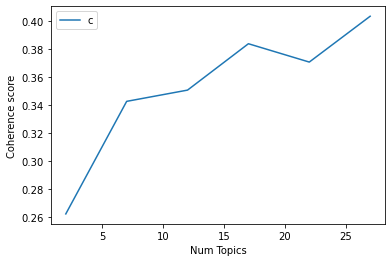

In [59]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_score2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [60]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_score2):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.2621
index: 1 | Num Topics = 7  has Coherence Value of 0.3426
index: 2 | Num Topics = 12  has Coherence Value of 0.3507
index: 3 | Num Topics = 17  has Coherence Value of 0.3839
index: 4 | Num Topics = 22  has Coherence Value of 0.3707
index: 5 | Num Topics = 27  has Coherence Value of 0.4035


In [61]:
# Select optimal number of topics
optimal_model_sg_score2 = model_list_sg_score2[5]

In [62]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_score2 = pyLDAvis.gensim_models.prepare(optimal_model_sg_score2, corpus_sg_score2, id2word_sg_score2)

In [63]:
print("pyLDAVis for SG topics for score=2:")
vis_sg_score2

pyLDAVis for SG topics for score=2:


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
16     0.049218 -0.047032       1        1  8.302399
4     -0.102533 -0.053036       2        1  7.917376
23    -0.211136 -0.021102       3        1  6.715911
14    -0.084575  0.175725       4        1  6.245678
13    -0.017864  0.030972       5        1  5.884180
6     -0.015677 -0.108495       6        1  5.140865
24    -0.114689  0.077882       7        1  5.059369
9     -0.035779 -0.143746       8        1  4.751189
5      0.017196  0.027158       9        1  4.680610
26     0.072830  0.112511      10        1  4.067652
8     -0.131912 -0.036631      11        1  3.924057
0     -0.056603 -0.122179      12        1  3.775323
25    -0.124339  0.124994      13        1  3.768366
19    -0.055743 -0.043641      14        1  3.665609
7      0.065454 -0.085665      15        1  3.277044
22     0.097301  0.074125      16        1  3.233432
3     -0.008751 -0.042264      17        1  2.628909
10     0.079437 -0.038976      18        1  2.594069
1     -0.052124  0.000699      19        1  2.406330
20     0.060937  0.062149      20        1  2.154027
2      0.034363  0.049557      21        1  1.816365
15     0.047644  0.081323      22        1  1.774574
21     0.094214 -0.064391      23        1  1.632478
12     0.142792  0.017282      24        1  1.383158
18     0.085534 -0.076469      25        1  1.308302
11     0.055701  0.015285      26        1  1.261309
17     0.109107  0.033966      27        1  0.631421, topic_info=       Term       Freq      Total Category  logprob  loglift
52    crash  23.000000  23.000000  Default  30.0000  30.0000
8     video  40.000000  40.000000  Default  29.0000  29.0000
21   update  55.000000  55.000000  Default  28.0000  28.0000
25  comment  17.000000  17.000000  Default  27.0000  27.0000
55     keep  26.000000  26.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
17     late   0.015757  15.365989  Topic27  -6.7845  -1.8177
19     post   0.015757  35.352739  Topic27  -6.7845  -2.6509
20   unable   0.015757  15.517373  Topic27  -6.7845  -1.8275
21   update   0.015757  55.066966  Topic27  -6.7845  -3.0941
22      app   0.015757  52.018423  Topic27  -6.7845  -3.0371

[1225 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
104       8  0.258058       able
104       9  0.258058       able
104      11  0.516117       able
171      10  0.653858   abruptly
243       2  0.317765     access
...     ...       ...        ...
117       5  0.636717      wrong
282       7  0.291147  yesterday
282      18  0.291147  yesterday
282      25  0.291147  yesterday
600       6  0.644751        yet

[1395 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 5, 24, 15, 14, 7, 25, 10, 6, 27, 9, 1, 26, 20, 8, 23, 4, 11, 2, 21, 3, 16, 22, 13, 19, 12, 18])

## LDA Topic Modelling (Rating = 3)

In [64]:
# By-rating Topic Modelling - rating = 3
# Convert to list - move to each section
review_sg_score3 = facebook_ios_sg_review_YearMonth_score3.review.values.tolist()
review_words_sg_score3 = list(sent_to_words(review_sg_score3))
print(review_words_sg_score3[:1])

[['why', 'can', 'make', 'search', 'within', 'group', 'it', 'works', 'well', 'on', 'iphone', 'but', 'on', 'ipad', 'search', 'bar', 'is', 'for', 'universal', 'searching', 'alone']]


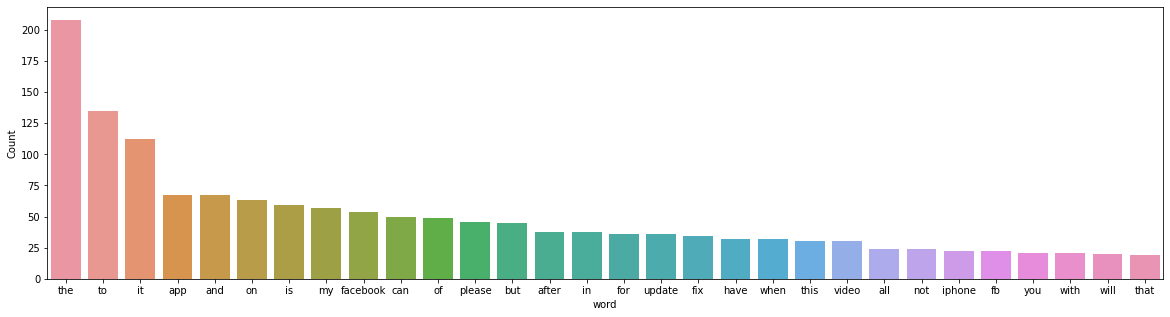

In [65]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_score3))

In [66]:
# Clean text
review_sg_ready_score3 = process_words(review_words_sg_score3)  # processed Text Data! - move to each section


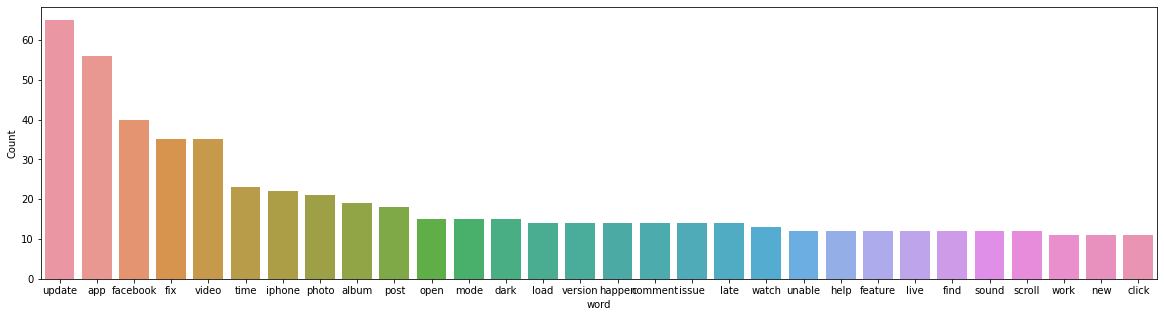

In [67]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_sg_ready_score3))


In [68]:
# Create Dictionary
id2word_sg_score3 = corpora.Dictionary(review_sg_ready_score3)

2021-10-16 18:38:36,947 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 18:38:36,954 [INFO] gensim.corpora.dictionary - built Dictionary(562 unique tokens: ['alone', 'bar', 'group', 'ipad', 'iphone']...) from 179 documents (total 1720 corpus positions)
2021-10-16 18:38:36,956 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(562 unique tokens: ['alone', 'bar', 'group', 'ipad', 'iphone']...) from 179 documents (total 1720 corpus positions)", 'datetime': '2021-10-16T18:38:36.956308', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [69]:
# Create Corpus: Term Document Frequency
corpus_sg_score3 = [id2word_sg_score3.doc2bow(text) for text in review_sg_ready_score3]

In [70]:
# Training LDA model
model_list_sg_score3, coherence_values_sg_score3 = compute_coherence_values(dictionary=id2word_sg_score3, corpus=corpus_sg_score3, 
                                                              texts=review_sg_ready_score3, limit=30, start=2, step=5)


2021-10-16 18:38:36,977 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 18:38:36,979 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 18:38:36,982 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:38:36,984 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 179 documents, updating model once every 179 documents, evaluating perplexity every 179 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:38:37,676 [INFO] gensim.models.ldamodel - -7.008 per-word bound, 128.7 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:38:37,679 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #179/179
2021-10-16 18:38:38,267 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"update" + 0.024*"fix" + 0.024*"app" + 0.012*"video" + 0.011*"facebook" + 0.011*"time" + 0.010*"ip

2021-10-16 18:38:42,958 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.027*"video" + 0.022*"app" + 0.021*"facebook" + 0.016*"photo" + 0.016*"update" + 0.015*"album" + 0.010*"watch" + 0.009*"scroll" + 0.008*"post" + 0.008*"play"
2021-10-16 18:38:42,960 [INFO] gensim.models.ldamodel - topic diff=0.014332, rho=0.301511
2021-10-16 18:38:43,197 [INFO] gensim.models.ldamodel - -6.114 per-word bound, 69.3 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:38:43,199 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #179/179
2021-10-16 18:38:43,423 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.043*"update" + 0.029*"app" + 0.027*"fix" + 0.015*"facebook" + 0.014*"mode" + 0.014*"dark" + 0.013*"time" + 0.013*"comment" + 0.013*"iphone" + 0.012*"late"
2021-10-16 18:38:43,427 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.027*"video" + 0.022*"app" + 0.021*"facebook" + 0.016*"photo" + 0.016*"update" + 0.015*"album" + 0.010*"watch" 

2021-10-16 18:38:48,825 [INFO] gensim.models.ldamodel - topic diff=0.007927, rho=0.218218
2021-10-16 18:38:49,060 [INFO] gensim.models.ldamodel - -6.102 per-word bound, 68.7 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:38:49,062 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #179/179
2021-10-16 18:38:49,224 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.046*"update" + 0.029*"app" + 0.027*"fix" + 0.016*"facebook" + 0.015*"time" + 0.014*"mode" + 0.014*"iphone" + 0.014*"dark" + 0.013*"comment" + 0.012*"late"
2021-10-16 18:38:49,226 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.029*"video" + 0.021*"app" + 0.020*"facebook" + 0.018*"photo" + 0.016*"album" + 0.013*"update" + 0.010*"watch" + 0.009*"scroll" + 0.009*"play" + 0.008*"show"
2021-10-16 18:38:49,231 [INFO] gensim.models.ldamodel - topic diff=0.007704, rho=0.213201
2021-10-16 18:38:49,409 [INFO] gensim.models.ldamodel - -6.101 per-word bound, 68.7 perplexity e

2021-10-16 18:38:53,703 [INFO] gensim.models.ldamodel - -6.092 per-word bound, 68.2 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:38:53,705 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #179/179
2021-10-16 18:38:53,884 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.048*"update" + 0.030*"app" + 0.026*"fix" + 0.017*"facebook" + 0.016*"time" + 0.014*"iphone" + 0.014*"mode" + 0.014*"dark" + 0.013*"comment" + 0.011*"open"
2021-10-16 18:38:53,886 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"video" + 0.020*"app" + 0.019*"facebook" + 0.018*"photo" + 0.017*"album" + 0.011*"update" + 0.011*"watch" + 0.009*"scroll" + 0.009*"play" + 0.009*"show"
2021-10-16 18:38:53,888 [INFO] gensim.models.ldamodel - topic diff=0.005277, rho=0.176777
2021-10-16 18:38:54,191 [INFO] gensim.models.ldamodel - -6.092 per-word bound, 68.2 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:38:54,19

2021-10-16 18:38:58,119 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #179/179
2021-10-16 18:38:58,336 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.049*"update" + 0.031*"app" + 0.025*"fix" + 0.018*"facebook" + 0.017*"time" + 0.015*"iphone" + 0.014*"mode" + 0.014*"dark" + 0.013*"comment" + 0.012*"open"
2021-10-16 18:38:58,337 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.031*"video" + 0.019*"app" + 0.019*"photo" + 0.018*"facebook" + 0.017*"album" + 0.011*"watch" + 0.009*"update" + 0.009*"play" + 0.009*"show" + 0.009*"scroll"
2021-10-16 18:38:58,339 [INFO] gensim.models.ldamodel - topic diff=0.004187, rho=0.154303
2021-10-16 18:38:58,578 [INFO] gensim.models.ldamodel - -6.088 per-word bound, 68.0 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:38:58,580 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #179/179
2021-10-16 18:38:58,800 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.049*"update" +

2021-10-16 18:39:02,051 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 18:39:06,709 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 18:39:06,753 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 165 virtual documents
2021-10-16 18:39:07,084 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 18:39:07,086 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 18:39:07,091 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:39:07,094 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 179 documents, updating model once every 179 documents, evaluating perplexity every 179 documents, iterating 50x with a con

2021-10-16 18:39:09,556 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.064*"update" + 0.021*"new" + 0.018*"fix" + 0.016*"photo" + 0.014*"iphone" + 0.014*"feature" + 0.011*"keep" + 0.011*"search" + 0.011*"user" + 0.011*"time"
2021-10-16 18:39:09,559 [INFO] gensim.models.ldamodel - topic diff=0.053848, rho=0.408248
2021-10-16 18:39:09,744 [INFO] gensim.models.ldamodel - -6.459 per-word bound, 88.0 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:39:09,745 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #179/179
2021-10-16 18:39:09,946 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.050*"update" + 0.019*"mobile" + 0.017*"sound" + 0.017*"facebook" + 0.017*"feature" + 0.016*"video" + 0.013*"fix" + 0.013*"downloadable" + 0.013*"mb" + 0.013*"crash"
2021-10-16 18:39:09,947 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.055*"app" + 0.035*"facebook" + 0.025*"video" + 0.020*"issue" + 0.018*"fix" + 0.017*"help" + 0.017*"live"

2021-10-16 18:39:11,805 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.050*"album" + 0.033*"photo" + 0.029*"update" + 0.023*"video" + 0.018*"app" + 0.017*"iphone" + 0.017*"remove" + 0.012*"view" + 0.012*"work" + 0.011*"time"
2021-10-16 18:39:11,809 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.029*"post" + 0.027*"app" + 0.022*"friend" + 0.021*"update" + 0.019*"auto" + 0.013*"facebook" + 0.013*"option" + 0.013*"click" + 0.010*"fix" + 0.010*"avatar"
2021-10-16 18:39:11,811 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.066*"update" + 0.024*"new" + 0.017*"fix" + 0.017*"photo" + 0.016*"iphone" + 0.014*"feature" + 0.011*"keep" + 0.011*"search" + 0.011*"user" + 0.011*"time"
2021-10-16 18:39:11,813 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.055*"app" + 0.036*"facebook" + 0.025*"video" + 0.021*"issue" + 0.018*"fix" + 0.018*"help" + 0.017*"live" + 0.016*"version" + 0.014*"happen" + 0.014*"watch"
2021-10-16 18:39:11,817 [INFO] gensim.models.ldamodel - topic diff=0.013194

2021-10-16 18:39:13,821 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.066*"update" + 0.024*"new" + 0.017*"photo" + 0.017*"fix" + 0.016*"iphone" + 0.014*"feature" + 0.011*"keep" + 0.011*"search" + 0.011*"user" + 0.011*"time"
2021-10-16 18:39:13,823 [INFO] gensim.models.ldamodel - topic diff=0.005891, rho=0.242536
2021-10-16 18:39:14,059 [INFO] gensim.models.ldamodel - -6.423 per-word bound, 85.8 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:39:14,061 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #179/179
2021-10-16 18:39:14,205 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.029*"post" + 0.026*"app" + 0.023*"friend" + 0.021*"update" + 0.019*"auto" + 0.013*"facebook" + 0.013*"option" + 0.013*"click" + 0.010*"fix" + 0.010*"avatar"
2021-10-16 18:39:14,208 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.029*"video" + 0.023*"photo" + 0.016*"find" + 0.016*"comment" + 0.016*"album" + 0.015*"back" + 0.012*"notificati

2021-10-16 18:39:16,103 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.029*"video" + 0.023*"photo" + 0.015*"find" + 0.015*"comment" + 0.015*"album" + 0.015*"back" + 0.014*"notification" + 0.012*"sometimes" + 0.012*"max" + 0.012*"click"
2021-10-16 18:39:16,106 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.042*"fix" + 0.039*"mode" + 0.039*"dark" + 0.034*"update" + 0.029*"app" + 0.025*"facebook" + 0.022*"time" + 0.020*"load" + 0.016*"open" + 0.014*"problem"
2021-10-16 18:39:16,109 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.051*"album" + 0.034*"photo" + 0.030*"update" + 0.023*"video" + 0.018*"app" + 0.017*"iphone" + 0.017*"remove" + 0.013*"view" + 0.012*"work" + 0.011*"watch"
2021-10-16 18:39:16,112 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.053*"app" + 0.035*"facebook" + 0.025*"video" + 0.023*"issue" + 0.018*"fix" + 0.018*"live" + 0.018*"help" + 0.017*"happen" + 0.016*"version" + 0.014*"watch"
2021-10-16 18:39:16,113 [INFO] gensim.models.ldamodel - topic #5 (0

2021-10-16 18:39:17,987 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.068*"update" + 0.024*"new" + 0.017*"photo" + 0.017*"fix" + 0.016*"iphone" + 0.014*"feature" + 0.011*"facebook" + 0.011*"keep" + 0.011*"search" + 0.011*"user"
2021-10-16 18:39:17,990 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.029*"video" + 0.023*"photo" + 0.015*"find" + 0.015*"comment" + 0.015*"album" + 0.015*"notification" + 0.015*"back" + 0.012*"sometimes" + 0.012*"max" + 0.012*"click"
2021-10-16 18:39:17,993 [INFO] gensim.models.ldamodel - topic diff=0.001612, rho=0.188982
2021-10-16 18:39:18,190 [INFO] gensim.models.ldamodel - -6.415 per-word bound, 85.3 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:39:18,195 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #179/179
2021-10-16 18:39:18,435 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.029*"video" + 0.023*"photo" + 0.015*"find" + 0.015*"comment" + 0.015*"album" + 0.015*"notification"

2021-10-16 18:39:20,778 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #179/179
2021-10-16 18:39:21,004 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.029*"post" + 0.026*"app" + 0.023*"friend" + 0.021*"update" + 0.020*"auto" + 0.013*"option" + 0.013*"click" + 0.013*"facebook" + 0.010*"fix" + 0.010*"avatar"
2021-10-16 18:39:21,009 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.068*"update" + 0.024*"new" + 0.017*"photo" + 0.017*"fix" + 0.016*"iphone" + 0.014*"feature" + 0.011*"facebook" + 0.011*"keep" + 0.011*"search" + 0.011*"time"
2021-10-16 18:39:21,012 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.042*"fix" + 0.039*"mode" + 0.039*"dark" + 0.034*"update" + 0.029*"app" + 0.026*"facebook" + 0.022*"time" + 0.020*"load" + 0.017*"open" + 0.014*"problem"
2021-10-16 18:39:21,017 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.051*"album" + 0.034*"photo" + 0.030*"update" + 0.023*"video" + 0.019*"app" + 0.017*"iphone" + 0.017*"remove" + 0.013*"view" + 0.012*

2021-10-16 18:39:23,452 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.042*"fix" + 0.039*"mode" + 0.039*"dark" + 0.033*"update" + 0.029*"app" + 0.026*"facebook" + 0.022*"time" + 0.020*"load" + 0.017*"open" + 0.014*"problem"
2021-10-16 18:39:23,455 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.050*"update" + 0.018*"sound" + 0.018*"facebook" + 0.016*"video" + 0.016*"feature" + 0.014*"mobile" + 0.014*"notification" + 0.014*"fix" + 0.014*"lag" + 0.014*"downloadable"
2021-10-16 18:39:23,456 [INFO] gensim.models.ldamodel - topic diff=0.000626, rho=0.160128
2021-10-16 18:39:23,654 [INFO] gensim.models.ldamodel - -6.414 per-word bound, 85.3 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:39:23,656 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #179/179
2021-10-16 18:39:23,763 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.050*"update" + 0.018*"sound" + 0.018*"facebook" + 0.016*"video" + 0.015*"feature" + 0.014*"mobil

2021-10-16 18:39:25,432 [INFO] gensim.models.ldamodel - -6.414 per-word bound, 85.3 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:39:25,433 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #179/179
2021-10-16 18:39:25,571 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.042*"fix" + 0.039*"mode" + 0.039*"dark" + 0.033*"update" + 0.029*"app" + 0.026*"facebook" + 0.022*"time" + 0.020*"load" + 0.017*"open" + 0.014*"problem"
2021-10-16 18:39:25,573 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.053*"app" + 0.034*"facebook" + 0.025*"video" + 0.024*"issue" + 0.018*"live" + 0.018*"fix" + 0.018*"help" + 0.018*"happen" + 0.016*"version" + 0.014*"time"
2021-10-16 18:39:25,577 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.050*"update" + 0.018*"sound" + 0.018*"facebook" + 0.016*"video" + 0.014*"feature" + 0.014*"mobile" + 0.014*"notification" + 0.014*"fix" + 0.014*"lag" + 0.014*"downloadable"
2021-10-16 18:39:25,578 [INFO] 

2021-10-16 18:39:27,444 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.053*"app" + 0.034*"facebook" + 0.025*"video" + 0.024*"issue" + 0.018*"live" + 0.018*"fix" + 0.018*"help" + 0.018*"happen" + 0.016*"version" + 0.014*"time"
2021-10-16 18:39:27,445 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.051*"album" + 0.034*"photo" + 0.030*"update" + 0.024*"video" + 0.019*"app" + 0.017*"remove" + 0.017*"iphone" + 0.013*"view" + 0.012*"work" + 0.011*"watch"
2021-10-16 18:39:27,447 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.042*"fix" + 0.039*"mode" + 0.039*"dark" + 0.033*"update" + 0.029*"app" + 0.026*"facebook" + 0.022*"time" + 0.020*"load" + 0.017*"open" + 0.014*"problem"
2021-10-16 18:39:27,448 [INFO] gensim.models.ldamodel - topic diff=0.000156, rho=0.141421
2021-10-16 18:39:27,681 [INFO] gensim.models.ldamodel - -6.414 per-word bound, 85.3 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:39:27,683 [INFO] gensim.models.ldamodel -

2021-10-16 18:39:35,828 [INFO] gensim.models.ldamodel - -6.664 per-word bound, 101.4 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:39:35,830 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #179/179
2021-10-16 18:39:35,982 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.036*"friend" + 0.031*"video" + 0.021*"update" + 0.019*"version" + 0.019*"new" + 0.019*"news" + 0.019*"iphone" + 0.019*"relative" + 0.013*"late" + 0.013*"auto"
2021-10-16 18:39:35,985 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.070*"update" + 0.028*"new" + 0.022*"photo" + 0.022*"user" + 0.017*"facebook" + 0.017*"character" + 0.017*"fix" + 0.016*"time" + 0.015*"iphone" + 0.011*"add"
2021-10-16 18:39:35,989 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.036*"photo" + 0.031*"facebook" + 0.030*"app" + 0.026*"album" + 0.016*"post" + 0.016*"unable" + 0.016*"open" + 0.015*"view" + 0.015*"feature" + 0.011*"update"
2021-10-16 18:39:35,992 [INFO] gensim.

2021-10-16 18:39:37,867 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.041*"work" + 0.021*"issue" + 0.021*"encounter" + 0.021*"year" + 0.021*"app" + 0.021*"ago" + 0.021*"facebook" + 0.021*"time" + 0.021*"post" + 0.016*"update"
2021-10-16 18:39:37,869 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.047*"update" + 0.044*"app" + 0.033*"fix" + 0.026*"facebook" + 0.025*"iphone" + 0.024*"open" + 0.019*"post" + 0.015*"recent" + 0.015*"still" + 0.015*"sound"
2021-10-16 18:39:37,870 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.030*"fix" + 0.030*"size" + 0.020*"app" + 0.020*"facebook" + 0.020*"update" + 0.020*"remove" + 0.020*"photo" + 0.020*"album" + 0.020*"crash" + 0.020*"phone"
2021-10-16 18:39:37,872 [INFO] gensim.models.ldamodel - topic diff=0.012419, rho=0.316228
2021-10-16 18:39:38,065 [INFO] gensim.models.ldamodel - -6.626 per-word bound, 98.8 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:39:38,066 [INFO] gensim.models.ldamo

2021-10-16 18:39:39,829 [INFO] gensim.models.ldamodel - topic diff=0.005224, rho=0.258199
2021-10-16 18:39:40,054 [INFO] gensim.models.ldamodel - -6.618 per-word bound, 98.2 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:39:40,055 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #179/179
2021-10-16 18:39:40,186 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.037*"fix" + 0.035*"app" + 0.032*"video" + 0.019*"facebook" + 0.019*"sound" + 0.019*"update" + 0.019*"watch" + 0.016*"time" + 0.016*"problem" + 0.016*"issue"
2021-10-16 18:39:40,190 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.036*"photo" + 0.031*"facebook" + 0.031*"app" + 0.026*"album" + 0.016*"unable" + 0.016*"post" + 0.016*"open" + 0.016*"view" + 0.016*"feature" + 0.011*"update"
2021-10-16 18:39:40,192 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.071*"dark" + 0.071*"mode" + 0.042*"app" + 0.026*"facebook" + 0.020*"update" + 0.016*"fb" + 0.016*"phone" + 

2021-10-16 18:39:42,056 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.073*"dark" + 0.073*"mode" + 0.042*"app" + 0.025*"facebook" + 0.020*"update" + 0.016*"fb" + 0.016*"phone" + 0.016*"already" + 0.011*"fix" + 0.011*"day"
2021-10-16 18:39:42,057 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.037*"friend" + 0.031*"video" + 0.020*"update" + 0.019*"version" + 0.019*"iphone" + 0.019*"new" + 0.019*"news" + 0.019*"relative" + 0.013*"late" + 0.013*"auto"
2021-10-16 18:39:42,059 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.037*"fix" + 0.035*"app" + 0.032*"video" + 0.019*"facebook" + 0.019*"sound" + 0.019*"update" + 0.019*"watch" + 0.016*"time" + 0.016*"problem" + 0.016*"issue"
2021-10-16 18:39:42,060 [INFO] gensim.models.ldamodel - topic diff=0.002526, rho=0.218218
2021-10-16 18:39:42,212 [INFO] gensim.models.ldamodel - -6.612 per-word bound, 97.8 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:39:42,213 [INFO] gensim.models.ldamod

2021-10-16 18:39:43,836 [INFO] gensim.models.ldamodel - topic diff=0.001660, rho=0.196116
2021-10-16 18:39:44,097 [INFO] gensim.models.ldamodel - -6.610 per-word bound, 97.7 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:39:44,099 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #179/179
2021-10-16 18:39:44,316 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.036*"photo" + 0.031*"facebook" + 0.031*"app" + 0.026*"album" + 0.016*"unable" + 0.016*"post" + 0.016*"open" + 0.016*"view" + 0.016*"feature" + 0.011*"iphone"
2021-10-16 18:39:44,318 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.037*"album" + 0.026*"photo" + 0.019*"video" + 0.018*"comment" + 0.015*"search" + 0.015*"move" + 0.015*"facebook" + 0.014*"iphone" + 0.011*"unable" + 0.011*"keep"
2021-10-16 18:39:44,321 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.072*"update" + 0.028*"new" + 0.023*"photo" + 0.023*"user" + 0.017*"facebook" + 0.017*"character" + 0.

2021-10-16 18:39:46,259 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.037*"fix" + 0.035*"app" + 0.032*"video" + 0.019*"facebook" + 0.019*"sound" + 0.019*"update" + 0.019*"watch" + 0.016*"time" + 0.016*"problem" + 0.016*"issue"
2021-10-16 18:39:46,271 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.037*"album" + 0.026*"photo" + 0.019*"video" + 0.018*"comment" + 0.015*"search" + 0.015*"move" + 0.015*"facebook" + 0.014*"iphone" + 0.011*"unable" + 0.011*"keep"
2021-10-16 18:39:46,272 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.030*"fix" + 0.030*"size" + 0.020*"facebook" + 0.020*"remove" + 0.020*"app" + 0.020*"update" + 0.020*"crash" + 0.020*"phone" + 0.020*"set" + 0.020*"photo"
2021-10-16 18:39:46,275 [INFO] gensim.models.ldamodel - topic diff=0.001289, rho=0.176777
2021-10-16 18:39:46,489 [INFO] gensim.models.ldamodel - -6.608 per-word bound, 97.6 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:39:46,492 [INFO] gensim.models

2021-10-16 18:39:48,184 [INFO] gensim.models.ldamodel - topic diff=0.000812, rho=0.164399
2021-10-16 18:39:48,376 [INFO] gensim.models.ldamodel - -6.607 per-word bound, 97.5 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:39:48,378 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #179/179
2021-10-16 18:39:48,574 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.074*"dark" + 0.074*"mode" + 0.042*"app" + 0.025*"facebook" + 0.021*"update" + 0.016*"fb" + 0.016*"phone" + 0.016*"already" + 0.012*"fix" + 0.011*"auto"
2021-10-16 18:39:48,575 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.030*"fix" + 0.030*"size" + 0.020*"remove" + 0.020*"facebook" + 0.020*"crash" + 0.020*"phone" + 0.020*"set" + 0.020*"update" + 0.020*"photo" + 0.020*"album"
2021-10-16 18:39:48,577 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.042*"work" + 0.021*"issue" + 0.021*"facebook" + 0.021*"post" + 0.021*"app" + 0.021*"encounter" + 0.021*"time" + 0.

2021-10-16 18:39:50,511 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.037*"update" + 0.022*"back" + 0.022*"button" + 0.022*"downloadable" + 0.022*"mb" + 0.018*"io" + 0.015*"search" + 0.015*"happen" + 0.015*"recently" + 0.015*"news"
2021-10-16 18:39:50,518 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.038*"video" + 0.038*"update" + 0.035*"live" + 0.023*"late" + 0.019*"scroll" + 0.019*"facebook" + 0.016*"comment" + 0.016*"stream" + 0.016*"fix" + 0.016*"look"
2021-10-16 18:39:50,522 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.076*"update" + 0.028*"new" + 0.022*"user" + 0.022*"photo" + 0.020*"iphone" + 0.017*"facebook" + 0.017*"character" + 0.017*"time" + 0.016*"long" + 0.016*"fix"
2021-10-16 18:39:50,531 [INFO] gensim.models.ldamodel - topic diff=0.000725, rho=0.152499
2021-10-16 18:39:50,719 [INFO] gensim.models.ldamodel - -6.605 per-word bound, 97.3 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:39:50,721 [INFO] gensim.

2021-10-16 18:39:52,451 [INFO] gensim.models.ldamodel - topic diff=0.000517, rho=0.144338
2021-10-16 18:39:52,610 [INFO] gensim.models.ldamodel - -6.604 per-word bound, 97.3 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:39:52,617 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #179/179
2021-10-16 18:39:52,801 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.073*"dark" + 0.073*"mode" + 0.042*"app" + 0.025*"facebook" + 0.022*"update" + 0.016*"fb" + 0.016*"phone" + 0.016*"already" + 0.012*"fix" + 0.011*"auto"
2021-10-16 18:39:52,806 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.036*"fix" + 0.035*"app" + 0.032*"video" + 0.019*"sound" + 0.019*"facebook" + 0.019*"update" + 0.019*"watch" + 0.016*"time" + 0.016*"problem" + 0.016*"issue"
2021-10-16 18:39:52,808 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.037*"friend" + 0.031*"video" + 0.021*"iphone" + 0.020*"update" + 0.019*"version" + 0.019*"new" + 0.019*"relative"

2021-10-16 18:40:04,209 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.043*"photo" + 0.043*"update" + 0.029*"click" + 0.022*"facebook" + 0.022*"album" + 0.022*"app" + 0.022*"character" + 0.022*"fix" + 0.015*"previously" + 0.015*"write"
2021-10-16 18:40:04,211 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.049*"friend" + 0.027*"update" + 0.027*"app" + 0.025*"relative" + 0.024*"fix" + 0.023*"option" + 0.017*"type" + 0.017*"problem" + 0.017*"totally" + 0.017*"suggestion"
2021-10-16 18:40:04,212 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.033*"remove" + 0.027*"iphone" + 0.024*"video" + 0.024*"post" + 0.022*"screen" + 0.021*"update" + 0.016*"annoying" + 0.015*"max" + 0.015*"album" + 0.015*"photo"
2021-10-16 18:40:04,213 [INFO] gensim.models.ldamodel - topic diff=0.091038, rho=0.577350
2021-10-16 18:40:04,457 [INFO] gensim.models.ldamodel - -6.807 per-word bound, 111.9 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:40:04,459 

2021-10-16 18:40:06,192 [INFO] gensim.models.ldamodel - topic diff=0.029174, rho=0.353553
2021-10-16 18:40:06,437 [INFO] gensim.models.ldamodel - -6.712 per-word bound, 104.8 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:40:06,439 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #179/179
2021-10-16 18:40:06,577 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.049*"time" + 0.047*"update" + 0.025*"search" + 0.025*"happen" + 0.025*"fix" + 0.024*"long" + 0.022*"iphone" + 0.017*"thing" + 0.017*"open" + 0.017*"version"
2021-10-16 18:40:06,579 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.041*"update" + 0.031*"feature" + 0.031*"lag" + 0.021*"bad" + 0.021*"photo" + 0.021*"still" + 0.021*"watch" + 0.021*"notification" + 0.021*"fix" + 0.021*"find"
2021-10-16 18:40:06,582 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.039*"back" + 0.030*"button" + 0.020*"update" + 0.020*"still" + 0.020*"several" + 0.020*"top" + 0.020*"sea

2021-10-16 18:40:08,521 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.050*"friend" + 0.025*"update" + 0.025*"app" + 0.025*"relative" + 0.025*"fix" + 0.025*"option" + 0.017*"suggestion" + 0.017*"type" + 0.017*"totally" + 0.017*"problem"
2021-10-16 18:40:08,526 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.080*"dark" + 0.080*"mode" + 0.046*"update" + 0.037*"app" + 0.037*"fix" + 0.028*"facebook" + 0.018*"load" + 0.018*"hope" + 0.017*"recent" + 0.017*"already"
2021-10-16 18:40:08,529 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.043*"update" + 0.043*"photo" + 0.029*"click" + 0.022*"facebook" + 0.022*"character" + 0.022*"album" + 0.022*"app" + 0.022*"fix" + 0.014*"write" + 0.014*"bug"
2021-10-16 18:40:08,532 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.047*"facebook" + 0.040*"app" + 0.039*"update" + 0.032*"load" + 0.032*"unable" + 0.024*"mb" + 0.024*"downloadable" + 0.016*"album" + 0.016*"news" + 0.016*"tag"
2021-10-16 18:40:08,535 [INFO] gensim.models.ldamodel - 

2021-10-16 18:40:10,594 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.081*"dark" + 0.081*"mode" + 0.046*"update" + 0.037*"fix" + 0.036*"app" + 0.028*"facebook" + 0.018*"load" + 0.018*"hope" + 0.017*"already" + 0.017*"recent"
2021-10-16 18:40:10,595 [INFO] gensim.models.ldamodel - topic diff=0.001955, rho=0.229416
2021-10-16 18:40:10,812 [INFO] gensim.models.ldamodel - -6.699 per-word bound, 103.9 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:40:10,813 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #179/179
2021-10-16 18:40:10,947 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.034*"update" + 0.026*"app" + 0.020*"size" + 0.013*"facebook" + 0.013*"enable" + 0.013*"sound" + 0.013*"fb" + 0.013*"help" + 0.013*"option" + 0.013*"avatar"
2021-10-16 18:40:10,949 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.041*"update" + 0.031*"feature" + 0.031*"lag" + 0.021*"notification" + 0.021*"still" + 0.021*"photo" + 0.021*"b

2021-10-16 18:40:12,791 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.048*"album" + 0.034*"photo" + 0.024*"iphone" + 0.024*"facebook" + 0.022*"app" + 0.019*"close" + 0.015*"update" + 0.015*"find" + 0.015*"show" + 0.014*"version"
2021-10-16 18:40:12,793 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.041*"update" + 0.031*"feature" + 0.031*"lag" + 0.021*"notification" + 0.021*"still" + 0.021*"photo" + 0.021*"bad" + 0.021*"watch" + 0.021*"fix" + 0.021*"find"
2021-10-16 18:40:12,794 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.071*"video" + 0.029*"update" + 0.021*"scroll" + 0.021*"play" + 0.021*"facebook" + 0.021*"look" + 0.017*"app" + 0.017*"sound" + 0.017*"watch" + 0.017*"never"
2021-10-16 18:40:12,802 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.046*"move" + 0.046*"album" + 0.023*"feature" + 0.023*"upload" + 0.023*"photo" + 0.023*"great" + 0.023*"option" + 0.023*"create" + 0.023*"available" + 0.023*"android"
2021-10-16 18:40:12,803 [INFO] gensim.models.ldamodel

2021-10-16 18:40:14,567 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.041*"comment" + 0.036*"update" + 0.036*"late" + 0.030*"app" + 0.024*"version" + 0.024*"iphone" + 0.018*"sound" + 0.018*"fix" + 0.018*"find" + 0.018*"ipad"
2021-10-16 18:40:14,569 [INFO] gensim.models.ldamodel - topic diff=0.000207, rho=0.182574
2021-10-16 18:40:14,683 [INFO] gensim.models.ldamodel - -6.698 per-word bound, 103.8 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:40:14,690 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #179/179
2021-10-16 18:40:14,933 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.034*"update" + 0.026*"app" + 0.020*"size" + 0.013*"facebook" + 0.013*"enable" + 0.013*"sound" + 0.013*"fb" + 0.013*"help" + 0.013*"option" + 0.013*"avatar"
2021-10-16 18:40:14,935 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.050*"friend" + 0.025*"update" + 0.025*"app" + 0.025*"relative" + 0.025*"fix" + 0.025*"option" + 0.017*"sugge

2021-10-16 18:40:16,440 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.049*"time" + 0.047*"update" + 0.024*"search" + 0.024*"happen" + 0.024*"fix" + 0.024*"long" + 0.024*"iphone" + 0.016*"thing" + 0.016*"shut" + 0.016*"open"
2021-10-16 18:40:16,441 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.041*"update" + 0.031*"feature" + 0.031*"lag" + 0.021*"still" + 0.021*"notification" + 0.021*"photo" + 0.021*"bad" + 0.021*"fix" + 0.021*"watch" + 0.021*"find"
2021-10-16 18:40:16,444 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.030*"show" + 0.021*"app" + 0.020*"view" + 0.020*"photo" + 0.020*"facebook" + 0.020*"help" + 0.020*"issue" + 0.020*"login" + 0.020*"set" + 0.020*"phone"
2021-10-16 18:40:16,446 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.081*"dark" + 0.081*"mode" + 0.046*"update" + 0.037*"fix" + 0.036*"app" + 0.028*"facebook" + 0.018*"load" + 0.018*"hope" + 0.018*"already" + 0.017*"recent"
2021-10-16 18:40:16,449 [INFO] gensim.models.ldamodel - topic diff=0.000074

2021-10-16 18:40:18,284 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.047*"facebook" + 0.040*"app" + 0.040*"update" + 0.032*"load" + 0.032*"unable" + 0.024*"downloadable" + 0.024*"mb" + 0.016*"delete" + 0.016*"news" + 0.016*"tag"
2021-10-16 18:40:18,287 [INFO] gensim.models.ldamodel - topic diff=0.000039, rho=0.156174
2021-10-16 18:40:18,564 [INFO] gensim.models.ldamodel - -6.698 per-word bound, 103.8 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:40:18,565 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #179/179
2021-10-16 18:40:18,691 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.088*"app" + 0.039*"facebook" + 0.037*"time" + 0.022*"fix" + 0.022*"open" + 0.022*"phone" + 0.018*"video" + 0.017*"post" + 0.017*"ago" + 0.017*"help"
2021-10-16 18:40:18,692 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.056*"update" + 0.019*"work" + 0.019*"notification" + 0.019*"fix" + 0.019*"tag" + 0.019*"guy" + 0.019*"uninstall

2021-10-16 18:40:20,392 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.048*"album" + 0.034*"photo" + 0.024*"iphone" + 0.024*"facebook" + 0.022*"app" + 0.019*"close" + 0.015*"update" + 0.015*"find" + 0.015*"show" + 0.014*"version"
2021-10-16 18:40:20,395 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.039*"back" + 0.030*"button" + 0.020*"update" + 0.020*"several" + 0.020*"top" + 0.020*"still" + 0.020*"time" + 0.020*"search" + 0.020*"add" + 0.010*"show"
2021-10-16 18:40:20,398 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.034*"remove" + 0.031*"iphone" + 0.028*"post" + 0.021*"update" + 0.021*"video" + 0.021*"screen" + 0.015*"app" + 0.014*"annoying" + 0.014*"album" + 0.014*"photo"
2021-10-16 18:40:20,400 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.049*"time" + 0.047*"update" + 0.024*"search" + 0.024*"fix" + 0.024*"happen" + 0.024*"long" + 0.024*"iphone" + 0.016*"thing" + 0.016*"shut" + 0.016*"open"
2021-10-16 18:40:20,403 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 18:40:30,121 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 22 topics, 50 passes over the supplied corpus of 179 documents, updating model once every 179 documents, evaluating perplexity every 179 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:40:30,441 [INFO] gensim.models.ldamodel - -19.752 per-word bound, 882777.6 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:40:30,443 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #179/179
2021-10-16 18:40:30,743 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.053*"facebook" + 0.045*"app" + 0.044*"post" + 0.038*"open" + 0.029*"link" + 0.023*"update" + 0.021*"phone" + 0.021*"look" + 0.021*"never" + 0.021*"dark"
2021-10-16 18:40:30,744 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.041*"update" + 0.029*"facebook" + 0.029*"story" + 0.029*"video" + 0.018*"scroll" + 0.018*"sound" + 0.018*"character" + 0.018*"ver

2021-10-16 18:40:32,720 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.060*"app" + 0.035*"update" + 0.026*"option" + 0.026*"time" + 0.026*"iphone" + 0.018*"work" + 0.018*"io" + 0.018*"lag" + 0.018*"album" + 0.018*"login"
2021-10-16 18:40:32,722 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.030*"facebook" + 0.027*"feature" + 0.027*"news" + 0.027*"feed" + 0.014*"enable" + 0.014*"wherever" + 0.014*"refresh" + 0.014*"leave" + 0.014*"current" + 0.014*"user"
2021-10-16 18:40:32,724 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.059*"video" + 0.024*"album" + 0.024*"photo" + 0.024*"comment" + 0.024*"fix" + 0.018*"view" + 0.018*"problem" + 0.018*"rest" + 0.018*"app" + 0.018*"size"
2021-10-16 18:40:32,727 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.072*"photo" + 0.045*"album" + 0.030*"previously" + 0.030*"merge" + 0.030*"post" + 0.030*"click" + 0.025*"edit" + 0.018*"fix" + 0.016*"feature" + 0.016*"wish"
2021-10-16 18:40:32,729 [INFO] gensim.models.ldamodel - topic #12 (

2021-10-16 18:40:34,456 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.080*"comment" + 0.035*"live" + 0.023*"page" + 0.023*"fix" + 0.012*"late" + 0.012*"ipad" + 0.012*"able" + 0.012*"download" + 0.012*"however" + 0.012*"pin"
2021-10-16 18:40:34,460 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.044*"update" + 0.035*"app" + 0.035*"fix" + 0.027*"mode" + 0.027*"dark" + 0.018*"work" + 0.018*"disappear" + 0.018*"asap" + 0.018*"time" + 0.018*"notification"
2021-10-16 18:40:34,463 [INFO] gensim.models.ldamodel - topic diff=0.011785, rho=0.288675
2021-10-16 18:40:34,704 [INFO] gensim.models.ldamodel - -6.775 per-word bound, 109.5 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:40:34,705 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #179/179
2021-10-16 18:40:34,823 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.045*"iphone" + 0.034*"remove" + 0.029*"app" + 0.027*"update" + 0.025*"issue" + 0.025*"facebook" + 0.025*"he

2021-10-16 18:40:36,437 [INFO] gensim.models.ldamodel - -6.770 per-word bound, 109.1 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:40:36,438 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #179/179
2021-10-16 18:40:36,597 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.059*"video" + 0.024*"album" + 0.024*"photo" + 0.024*"comment" + 0.024*"fix" + 0.018*"view" + 0.018*"problem" + 0.018*"rest" + 0.018*"app" + 0.018*"size"
2021-10-16 18:40:36,599 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.045*"update" + 0.036*"app" + 0.036*"fix" + 0.027*"dark" + 0.027*"mode" + 0.018*"work" + 0.018*"asap" + 0.018*"time" + 0.018*"disappear" + 0.018*"notification"
2021-10-16 18:40:36,600 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.040*"update" + 0.030*"facebook" + 0.030*"video" + 0.030*"story" + 0.018*"character" + 0.018*"sound" + 0.018*"scroll" + 0.018*"fix" + 0.018*"version" + 0.018*"play"
2021-10-16 18:40:36,602 [INFO] ge

2021-10-16 18:40:38,414 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.075*"app" + 0.067*"update" + 0.026*"open" + 0.026*"time" + 0.026*"downloadable" + 0.026*"mb" + 0.017*"help" + 0.017*"still" + 0.017*"notification" + 0.017*"plan"
2021-10-16 18:40:38,421 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.045*"update" + 0.039*"app" + 0.039*"video" + 0.022*"sound" + 0.022*"watch" + 0.017*"time" + 0.017*"mobile" + 0.017*"turn" + 0.014*"fix" + 0.011*"start"
2021-10-16 18:40:38,428 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.040*"update" + 0.030*"facebook" + 0.030*"video" + 0.030*"story" + 0.018*"character" + 0.018*"sound" + 0.018*"scroll" + 0.018*"fix" + 0.018*"play" + 0.018*"version"
2021-10-16 18:40:38,429 [INFO] gensim.models.ldamodel - topic diff=0.001996, rho=0.208514
2021-10-16 18:40:38,592 [INFO] gensim.models.ldamodel - -6.766 per-word bound, 108.9 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:40:38,593 [INFO] gensim

2021-10-16 18:40:40,571 [INFO] gensim.models.ldamodel - topic diff=0.000940, rho=0.188982
2021-10-16 18:40:40,823 [INFO] gensim.models.ldamodel - -6.764 per-word bound, 108.7 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:40:40,827 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #179/179
2021-10-16 18:40:40,967 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.037*"time" + 0.037*"search" + 0.025*"open" + 0.025*"long" + 0.025*"load" + 0.025*"unable" + 0.025*"link" + 0.025*"command" + 0.013*"group" + 0.013*"iphone"
2021-10-16 18:40:40,970 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.057*"app" + 0.048*"version" + 0.048*"facebook" + 0.029*"unable" + 0.029*"able" + 0.028*"late" + 0.027*"update" + 0.019*"happen" + 0.019*"tag" + 0.019*"recently"
2021-10-16 18:40:40,972 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.081*"app" + 0.067*"update" + 0.025*"open" + 0.025*"time" + 0.025*"downloadable" + 0.025*"mb" + 0.017*"

2021-10-16 18:40:43,195 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.037*"time" + 0.037*"search" + 0.025*"open" + 0.025*"load" + 0.025*"long" + 0.025*"unable" + 0.025*"link" + 0.025*"command" + 0.013*"group" + 0.013*"iphone"
2021-10-16 18:40:43,198 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.044*"type" + 0.022*"install" + 0.022*"uninstall" + 0.022*"back" + 0.022*"recently" + 0.022*"miss" + 0.022*"button" + 0.022*"happen" + 0.022*"hrs" + 0.022*"issue"
2021-10-16 18:40:43,203 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.095*"dark" + 0.095*"mode" + 0.061*"facebook" + 0.026*"already" + 0.022*"update" + 0.020*"app" + 0.018*"date" + 0.018*"issue" + 0.018*"problem" + 0.018*"encounter"
2021-10-16 18:40:43,205 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.060*"app" + 0.035*"update" + 0.026*"option" + 0.026*"time" + 0.026*"iphone" + 0.018*"newsfeed" + 0.018*"become" + 0.018*"lag" + 0.018*"post" + 0.018*"login"
2021-10-16 18:40:43,207 [INFO] gensim.models.ldamodel -

2021-10-16 18:40:45,201 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.044*"update" + 0.039*"app" + 0.039*"video" + 0.022*"sound" + 0.022*"watch" + 0.017*"time" + 0.017*"mobile" + 0.017*"turn" + 0.014*"fix" + 0.011*"problem"
2021-10-16 18:40:45,203 [INFO] gensim.models.ldamodel - topic diff=0.000869, rho=0.160128
2021-10-16 18:40:45,390 [INFO] gensim.models.ldamodel - -6.762 per-word bound, 108.5 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:40:45,394 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #179/179
2021-10-16 18:40:45,571 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.080*"comment" + 0.035*"live" + 0.023*"page" + 0.023*"fix" + 0.012*"late" + 0.012*"ipad" + 0.012*"able" + 0.012*"however" + 0.012*"participate" + 0.012*"throughly"
2021-10-16 18:40:45,573 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.038*"update" + 0.037*"fix" + 0.028*"dark" + 0.028*"mode" + 0.019*"asap" + 0.019*"work" + 0.019*"time" 

2021-10-16 18:40:47,210 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.057*"app" + 0.048*"version" + 0.048*"facebook" + 0.029*"unable" + 0.029*"able" + 0.028*"late" + 0.027*"update" + 0.019*"happen" + 0.019*"news" + 0.019*"tag"
2021-10-16 18:40:47,213 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.047*"iphone" + 0.036*"remove" + 0.030*"app" + 0.027*"update" + 0.024*"issue" + 0.024*"login" + 0.024*"facebook" + 0.024*"help" + 0.024*"photo" + 0.024*"album"
2021-10-16 18:40:47,216 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.039*"update" + 0.036*"profile" + 0.036*"audio" + 0.019*"late" + 0.019*"facebook" + 0.018*"help" + 0.018*"date" + 0.018*"app" + 0.018*"find" + 0.018*"ask"
2021-10-16 18:40:47,219 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.095*"mode" + 0.095*"dark" + 0.061*"facebook" + 0.026*"already" + 0.022*"update" + 0.020*"app" + 0.018*"date" + 0.018*"encounter" + 0.018*"problem" + 0.018*"recently"
2021-10-16 18:40:47,224 [INFO] gensim.models.ldamodel - to

2021-10-16 18:40:48,958 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.039*"update" + 0.036*"profile" + 0.036*"audio" + 0.019*"late" + 0.019*"facebook" + 0.018*"help" + 0.018*"date" + 0.018*"app" + 0.018*"find" + 0.018*"ask"
2021-10-16 18:40:48,961 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.040*"update" + 0.030*"facebook" + 0.030*"video" + 0.030*"story" + 0.018*"character" + 0.018*"sound" + 0.018*"scroll" + 0.018*"fix" + 0.018*"version" + 0.018*"play"
2021-10-16 18:40:48,963 [INFO] gensim.models.ldamodel - topic diff=0.000387, rho=0.141421
2021-10-16 18:40:49,114 [INFO] gensim.models.ldamodel - -6.759 per-word bound, 108.3 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:40:49,116 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #179/179
2021-10-16 18:40:49,202 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.059*"video" + 0.024*"album" + 0.024*"photo" + 0.024*"fix" + 0.024*"comment" + 0.018*"view" + 0.018*"r

2021-10-16 18:41:00,490 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #179/179
2021-10-16 18:41:00,693 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.040*"photo" + 0.030*"search" + 0.030*"facebook" + 0.030*"issue" + 0.020*"forward" + 0.020*"well" + 0.020*"move" + 0.020*"encounter" + 0.020*"backward" + 0.020*"exit"
2021-10-16 18:41:00,694 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.097*"mode" + 0.097*"dark" + 0.068*"facebook" + 0.060*"update" + 0.028*"app" + 0.023*"already" + 0.020*"glitch" + 0.020*"unable" + 0.018*"hope" + 0.016*"iphone"
2021-10-16 18:41:00,697 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.042*"update" + 0.036*"iphone" + 0.030*"time" + 0.028*"facebook" + 0.024*"new" + 0.018*"character" + 0.018*"load" + 0.018*"app" + 0.018*"crash" + 0.018*"video"
2021-10-16 18:41:00,699 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.051*"album" + 0.034*"screen" + 0.019*"unable" + 0.018*"post" + 0.018*"app" + 0.017*"rotate" + 0.017*"highlight" 

2021-10-16 18:41:02,996 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.048*"album" + 0.048*"move" + 0.024*"spread" + 0.024*"app" + 0.024*"fake" + 0.024*"fun" + 0.024*"news" + 0.024*"politic" + 0.024*"social" + 0.024*"back"
2021-10-16 18:41:02,999 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.048*"facebook" + 0.032*"app" + 0.032*"feed" + 0.032*"look" + 0.032*"never" + 0.017*"auto" + 0.017*"user" + 0.017*"bookmark" + 0.017*"leave" + 0.017*"introduce"
2021-10-16 18:41:03,001 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.036*"app" + 0.027*"update" + 0.027*"time" + 0.027*"video" + 0.027*"version" + 0.018*"post" + 0.018*"become" + 0.018*"work" + 0.018*"option" + 0.018*"watch"
2021-10-16 18:41:03,003 [INFO] gensim.models.ldamodel - topic diff=0.021766, rho=0.316228
2021-10-16 18:41:03,249 [INFO] gensim.models.ldamodel - -6.870 per-word bound, 117.0 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:41:03,259 [INFO] gensim.models.ld

2021-10-16 18:41:04,939 [INFO] gensim.models.ldamodel - topic diff=0.007656, rho=0.258199
2021-10-16 18:41:05,192 [INFO] gensim.models.ldamodel - -6.858 per-word bound, 116.0 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:41:05,193 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #179/179
2021-10-16 18:41:05,337 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.058*"update" + 0.023*"group" + 0.023*"function" + 0.023*"fail" + 0.023*"frequent" + 0.022*"time" + 0.018*"app" + 0.012*"ago" + 0.012*"day" + 0.012*"sound"
2021-10-16 18:41:05,338 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.073*"app" + 0.044*"log" + 0.030*"issue" + 0.030*"story" + 0.030*"crash" + 0.030*"update" + 0.015*"auto" + 0.015*"late" + 0.015*"version" + 0.015*"scroll"
2021-10-16 18:41:05,340 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.126*"friend" + 0.063*"relative" + 0.043*"suggestion" + 0.022*"deactivate" + 0.022*"option" + 0.022*"add" + 0.0

2021-10-16 18:41:07,091 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.048*"album" + 0.048*"move" + 0.024*"spread" + 0.024*"social" + 0.024*"back" + 0.024*"politic" + 0.024*"world" + 0.024*"app" + 0.024*"day" + 0.024*"fake"
2021-10-16 18:41:07,093 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.055*"app" + 0.022*"fb" + 0.022*"keep" + 0.022*"friend" + 0.022*"model" + 0.022*"fix" + 0.022*"mobile" + 0.022*"different" + 0.022*"date" + 0.022*"delete"
2021-10-16 18:41:07,095 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.126*"friend" + 0.063*"relative" + 0.043*"suggestion" + 0.022*"deactivate" + 0.022*"option" + 0.022*"add" + 0.022*"suggest" + 0.022*"example" + 0.022*"totally" + 0.022*"fine"
2021-10-16 18:41:07,097 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.094*"update" + 0.040*"downloadable" + 0.040*"mb" + 0.040*"io" + 0.040*"crash" + 0.027*"mobile" + 0.027*"plan" + 0.027*"datum" + 0.027*"file" + 0.027*"size"
2021-10-16 18:41:07,098 [INFO] gensim.models.ldamodel - t

2021-10-16 18:41:08,776 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.054*"update" + 0.031*"fix" + 0.031*"late" + 0.024*"facebook" + 0.023*"sound" + 0.023*"comment" + 0.023*"photo" + 0.023*"link" + 0.016*"send" + 0.016*"command"
2021-10-16 18:41:08,781 [INFO] gensim.models.ldamodel - topic diff=0.000966, rho=0.196116
2021-10-16 18:41:08,957 [INFO] gensim.models.ldamodel - -6.854 per-word bound, 115.7 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:41:08,958 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #179/179
2021-10-16 18:41:09,075 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.055*"update" + 0.032*"album" + 0.032*"comment" + 0.024*"photo" + 0.024*"long" + 0.024*"live" + 0.024*"iphone" + 0.016*"never" + 0.016*"rest" + 0.016*"user"
2021-10-16 18:41:09,078 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.062*"comment" + 0.042*"post" + 0.042*"click" + 0.021*"fix" + 0.021*"account" + 0.021*"time" + 0.021*"reg

2021-10-16 18:41:10,842 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.072*"app" + 0.055*"update" + 0.037*"facebook" + 0.035*"video" + 0.035*"unable" + 0.035*"load" + 0.027*"fix" + 0.026*"recent" + 0.019*"delete" + 0.017*"sound"
2021-10-16 18:41:10,844 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.054*"update" + 0.031*"fix" + 0.031*"late" + 0.024*"facebook" + 0.023*"sound" + 0.023*"comment" + 0.023*"photo" + 0.023*"link" + 0.016*"command" + 0.016*"send"
2021-10-16 18:41:10,847 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.066*"video" + 0.027*"jump" + 0.027*"random" + 0.027*"view" + 0.027*"kid" + 0.027*"feature" + 0.014*"facebook" + 0.014*"neckline" + 0.014*"irrelevant" + 0.014*"explicit"
2021-10-16 18:41:10,852 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.124*"dark" + 0.124*"mode" + 0.062*"facebook" + 0.059*"update" + 0.031*"app" + 0.027*"already" + 0.018*"glitch" + 0.018*"unable" + 0.018*"hope" + 0.018*"iphone"
2021-10-16 18:41:10,855 [INFO] gensim.models.l

2021-10-16 18:41:12,561 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.073*"app" + 0.044*"log" + 0.030*"issue" + 0.030*"story" + 0.030*"crash" + 0.030*"update" + 0.015*"tracking" + 0.015*"privacy" + 0.015*"fix" + 0.015*"auto"
2021-10-16 18:41:12,565 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.124*"dark" + 0.124*"mode" + 0.062*"facebook" + 0.058*"update" + 0.031*"app" + 0.027*"already" + 0.018*"glitch" + 0.018*"unable" + 0.018*"hope" + 0.018*"iphone"
2021-10-16 18:41:12,566 [INFO] gensim.models.ldamodel - topic diff=0.000187, rho=0.164399
2021-10-16 18:41:12,723 [INFO] gensim.models.ldamodel - -6.853 per-word bound, 115.6 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:41:12,725 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #179/179
2021-10-16 18:41:12,838 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.045*"fix" + 0.033*"comment" + 0.022*"stream" + 0.022*"live" + 0.022*"tap" + 0.022*"version" + 0.022*"ki

2021-10-16 18:41:14,573 [INFO] gensim.models.ldamodel - -6.853 per-word bound, 115.6 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:41:14,574 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #179/179
2021-10-16 18:41:14,699 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.044*"fix" + 0.033*"comment" + 0.022*"stream" + 0.022*"live" + 0.022*"tap" + 0.022*"kindly" + 0.022*"issue" + 0.022*"version" + 0.022*"update" + 0.022*"show"
2021-10-16 18:41:14,700 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.044*"back" + 0.022*"time" + 0.022*"top" + 0.022*"previous" + 0.022*"tap" + 0.022*"post" + 0.022*"button" + 0.022*"several" + 0.022*"content" + 0.022*"responsive"
2021-10-16 18:41:14,702 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.066*"video" + 0.040*"sound" + 0.040*"play" + 0.030*"update" + 0.027*"problem" + 0.027*"scroll" + 0.027*"page" + 0.027*"fix" + 0.014*"cause" + 0.014*"datum"
2021-10-16 18:41:14,703 [INFO] ge

2021-10-16 18:41:16,504 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.073*"app" + 0.044*"log" + 0.030*"story" + 0.030*"issue" + 0.030*"crash" + 0.030*"update" + 0.015*"hour" + 0.015*"archive" + 0.015*"sto" + 0.015*"keep"
2021-10-16 18:41:16,507 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.058*"update" + 0.023*"group" + 0.023*"function" + 0.023*"fail" + 0.023*"frequent" + 0.022*"time" + 0.018*"app" + 0.012*"sound" + 0.012*"kindly" + 0.012*"wrong"
2021-10-16 18:41:16,510 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.055*"app" + 0.022*"fb" + 0.022*"friend" + 0.022*"model" + 0.022*"mobile" + 0.022*"delete" + 0.022*"date" + 0.022*"different" + 0.022*"keep" + 0.022*"fix"
2021-10-16 18:41:16,512 [INFO] gensim.models.ldamodel - topic diff=0.000042, rho=0.144338
2021-10-16 18:41:16,644 [INFO] gensim.models.ldamodel - -6.853 per-word bound, 115.6 perplexity estimate based on a held-out corpus of 179 documents with 1720 words
2021-10-16 18:41:16,645 [INFO] gensim.models.ldamod

In [71]:
%store model_list_sg_score3
%store coherence_values_sg_score3

Stored 'model_list_sg_score3' (list)
Stored 'coherence_values_sg_score3' (list)


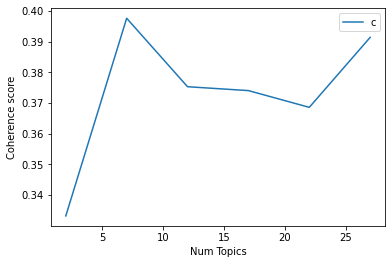

In [72]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_score3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [73]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_score3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 7

index: 0 | Num Topics = 2  has Coherence Value of 0.3332
index: 1 | Num Topics = 7  has Coherence Value of 0.3976
index: 2 | Num Topics = 12  has Coherence Value of 0.3753
index: 3 | Num Topics = 17  has Coherence Value of 0.374
index: 4 | Num Topics = 22  has Coherence Value of 0.3686
index: 5 | Num Topics = 27  has Coherence Value of 0.3914


In [174]:
# Select optimal number of topics
optimal_model_sg_score3 = model_list_sg_score3[1]

In [175]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_score3 = pyLDAvis.gensim_models.prepare(optimal_model_sg_score3, corpus_sg_score3, id2word_sg_score3)

In [176]:
print("pyLDAVis for SG topics for score=3:")
vis_sg_score3

pyLDAVis for SG topics for score=3:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.074243 -0.029549       1        1  24.266095
0      0.139501  0.072279       2        1  15.955862
1     -0.004721 -0.141182       3        1  13.766755
5     -0.000325  0.023422       4        1  12.969449
4     -0.122576 -0.021247       5        1  12.799246
2     -0.127470  0.089643       6        1  11.308098
6      0.041348  0.006634       7        1   8.934496, topic_info=       Term       Freq      Total Category  logprob  loglift
19    album  14.000000  14.000000  Default  30.0000  30.0000
17   update  49.000000  49.000000  Default  29.0000  29.0000
113    mode  12.000000  12.000000  Default  28.0000  28.0000
406    dark  12.000000  12.000000  Default  27.0000  27.0000
25    photo  16.000000  16.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
58   happen   1.513665  11.631096   Topic7  -4.6203   0.3761
24     load   1.450939  11.312206   Topic7  -4.6626   0.3616
110    late   1.450991  11.427827   Topic7  -4.6626   0.3514
41     time   1.449651  18.299178   Topic7  -4.6635  -0.1203
20      app   1.471957  44.280313   Topic7  -4.6482  -0.9887

[431 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
189       1  0.650898          able
189       3  0.216966          able
189       7  0.216966          able
399       2  0.665108  accidentally
419       7  0.703464   accordingly
...     ...       ...           ...
248       1  0.768445         wrong
248       6  0.256148         wrong
442       7  0.703465            xs
82        1  0.633963          year
82        4  0.211321          year

[589 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 6, 5, 3, 7])

## LDA Topic Modelling (Rating = 4)

In [77]:
# By-rating Topic Modelling - rating = 4
# Convert to list - move to each section
review_sg_score4 = facebook_ios_sg_review_YearMonth_score4.review.values.tolist()
review_words_sg_score4 = list(sent_to_words(review_sg_score4))
print(review_words_sg_score4[2:3])

[['should', 'add', 'landscape', 'mode', 'will', 'be', 'wonderful']]


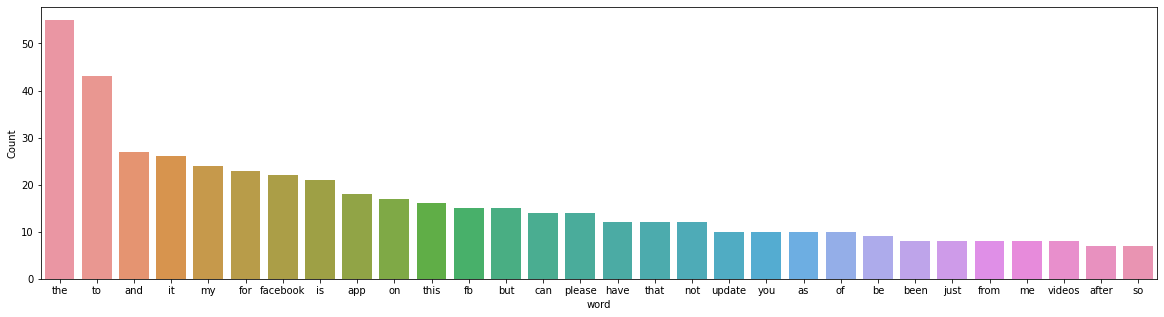

In [78]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_score4))

In [79]:
# Clean text
review_sg_ready_score4 = process_words(review_words_sg_score4)  # processed Text Data! - move to each section

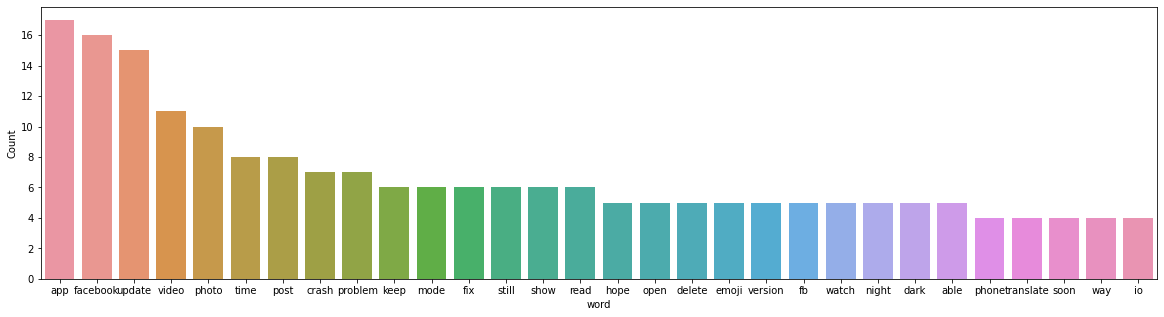

In [80]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_sg_ready_score4))


In [81]:
# Create Dictionary
id2word_sg_score4 = corpora.Dictionary(review_sg_ready_score4)

2021-10-16 18:41:39,388 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 18:41:39,409 [INFO] gensim.corpora.dictionary - built Dictionary(279 unique tokens: ['crash', 'keep', 'update', 'add', 'app']...) from 50 documents (total 550 corpus positions)
2021-10-16 18:41:39,420 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(279 unique tokens: ['crash', 'keep', 'update', 'add', 'app']...) from 50 documents (total 550 corpus positions)", 'datetime': '2021-10-16T18:41:39.420047', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [82]:
# Create Corpus: Term Document Frequency
corpus_sg_score4 = [id2word_sg_score4.doc2bow(text) for text in review_sg_ready_score4]

In [83]:
# Training LDA model
model_list_sg_score4, coherence_values_sg_score4 = compute_coherence_values(dictionary=id2word_sg_score4, corpus=corpus_sg_score4, 
                                                              texts=review_sg_ready_score4, limit=30, start=2, step=5)


2021-10-16 18:41:39,459 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 18:41:39,461 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 18:41:39,463 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:41:39,466 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 50 documents, updating model once every 50 documents, evaluating perplexity every 50 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:41:39,617 [INFO] gensim.models.ldamodel - -6.389 per-word bound, 83.8 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:41:39,618 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #50/50
2021-10-16 18:41:39,830 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"app" + 0.022*"facebook" + 0.020*"photo" + 0.017*"update" + 0.014*"time" + 0.012*"post" + 0.012*"able" + 0

2021-10-16 18:41:41,334 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"update" + 0.023*"facebook" + 0.017*"video" + 0.017*"app" + 0.016*"crash" + 0.013*"time" + 0.012*"keep" + 0.012*"hope" + 0.012*"emoji" + 0.012*"night"
2021-10-16 18:41:41,336 [INFO] gensim.models.ldamodel - topic diff=0.007629, rho=0.301511
2021-10-16 18:41:41,403 [INFO] gensim.models.ldamodel - -5.753 per-word bound, 53.9 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:41:41,406 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #50/50
2021-10-16 18:41:41,514 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.028*"photo" + 0.027*"app" + 0.017*"facebook" + 0.017*"show" + 0.013*"able" + 0.012*"delete" + 0.012*"post" + 0.012*"profile" + 0.012*"picture" + 0.012*"album"
2021-10-16 18:41:41,517 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"update" + 0.023*"facebook" + 0.017*"app" + 0.017*"video" + 0.016*"crash" + 0.013*"time" + 0.012*"keep" + 0.

2021-10-16 18:41:42,988 [INFO] gensim.models.ldamodel - topic diff=0.005178, rho=0.218218
2021-10-16 18:41:43,090 [INFO] gensim.models.ldamodel - -5.746 per-word bound, 53.7 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:41:43,091 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #50/50
2021-10-16 18:41:43,121 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.028*"photo" + 0.026*"app" + 0.018*"show" + 0.015*"facebook" + 0.013*"delete" + 0.012*"able" + 0.012*"post" + 0.012*"profile" + 0.012*"picture" + 0.012*"album"
2021-10-16 18:41:43,123 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.033*"update" + 0.025*"facebook" + 0.018*"app" + 0.017*"video" + 0.016*"crash" + 0.014*"time" + 0.012*"keep" + 0.012*"hope" + 0.012*"emoji" + 0.012*"night"
2021-10-16 18:41:43,126 [INFO] gensim.models.ldamodel - topic diff=0.005387, rho=0.213201
2021-10-16 18:41:43,221 [INFO] gensim.models.ldamodel - -5.745 per-word bound, 53.6 perplexity est

2021-10-16 18:41:44,439 [INFO] gensim.models.ldamodel - -5.741 per-word bound, 53.5 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:41:44,440 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #50/50
2021-10-16 18:41:44,570 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"photo" + 0.025*"app" + 0.018*"show" + 0.015*"facebook" + 0.013*"delete" + 0.012*"post" + 0.012*"profile" + 0.012*"picture" + 0.012*"album" + 0.012*"able"
2021-10-16 18:41:44,573 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.033*"update" + 0.025*"facebook" + 0.019*"app" + 0.016*"video" + 0.016*"crash" + 0.014*"time" + 0.012*"fix" + 0.012*"keep" + 0.012*"read" + 0.012*"hope"
2021-10-16 18:41:44,575 [INFO] gensim.models.ldamodel - topic diff=0.001472, rho=0.176777
2021-10-16 18:41:44,608 [INFO] gensim.models.ldamodel - -5.741 per-word bound, 53.5 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:41:44,610 [INFO

2021-10-16 18:41:45,896 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #50/50
2021-10-16 18:41:45,923 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"photo" + 0.025*"app" + 0.018*"show" + 0.014*"facebook" + 0.013*"delete" + 0.012*"post" + 0.012*"profile" + 0.012*"picture" + 0.012*"album" + 0.012*"able"
2021-10-16 18:41:45,925 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.033*"update" + 0.025*"facebook" + 0.019*"app" + 0.016*"video" + 0.016*"crash" + 0.014*"time" + 0.012*"fix" + 0.012*"read" + 0.012*"keep" + 0.012*"problem"
2021-10-16 18:41:45,926 [INFO] gensim.models.ldamodel - topic diff=0.000422, rho=0.154303
2021-10-16 18:41:46,006 [INFO] gensim.models.ldamodel - -5.741 per-word bound, 53.5 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:41:46,008 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #50/50
2021-10-16 18:41:46,077 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.029*"photo" + 0.02

2021-10-16 18:41:47,071 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 18:41:51,706 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 18:41:51,740 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 45 virtual documents
2021-10-16 18:41:52,077 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 18:41:52,079 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 18:41:52,082 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:41:52,085 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 50 documents, updating model once every 50 documents, evaluating perplexity every 50 documents, iterating 50x with a converg

2021-10-16 18:41:52,809 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.046*"photo" + 0.023*"post" + 0.023*"emoji" + 0.019*"still" + 0.019*"album" + 0.019*"show" + 0.016*"app" + 0.015*"facebook" + 0.015*"version" + 0.014*"share"
2021-10-16 18:41:52,812 [INFO] gensim.models.ldamodel - topic diff=0.048910, rho=0.408248
2021-10-16 18:41:52,850 [INFO] gensim.models.ldamodel - -6.049 per-word bound, 66.2 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:41:52,852 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #50/50
2021-10-16 18:41:52,872 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.057*"update" + 0.048*"app" + 0.035*"keep" + 0.029*"problem" + 0.026*"crash" + 0.020*"picture" + 0.018*"late" + 0.016*"sure" + 0.016*"phone" + 0.014*"rectify"
2021-10-16 18:41:52,873 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.031*"update" + 0.031*"facebook" + 0.024*"delete" + 0.024*"app" + 0.024*"profile" + 0.024*"read" + 0.024*"video" 

2021-10-16 18:41:53,374 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.062*"update" + 0.051*"app" + 0.036*"keep" + 0.028*"problem" + 0.028*"crash" + 0.026*"late" + 0.019*"picture" + 0.019*"sure" + 0.019*"phone" + 0.016*"rectify"
2021-10-16 18:41:53,378 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.047*"translate" + 0.036*"facebook" + 0.024*"hope" + 0.024*"update" + 0.024*"button" + 0.024*"language" + 0.024*"enter" + 0.013*"video" + 0.013*"story" + 0.013*"watch"
2021-10-16 18:41:53,382 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.044*"video" + 0.033*"upload" + 0.023*"fix" + 0.023*"post" + 0.023*"show" + 0.023*"react" + 0.023*"night" + 0.023*"day" + 0.023*"band" + 0.023*"uploading"
2021-10-16 18:41:53,385 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.036*"mode" + 0.028*"night" + 0.028*"guy" + 0.027*"facebook" + 0.027*"app" + 0.027*"dark" + 0.019*"read" + 0.019*"version" + 0.019*"write" + 0.019*"optimization"
2021-10-16 18:41:53,388 [INFO] gensim.models.ldamodel - 

2021-10-16 18:41:53,897 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.048*"photo" + 0.024*"post" + 0.024*"emoji" + 0.019*"album" + 0.019*"still" + 0.019*"show" + 0.015*"facebook" + 0.015*"version" + 0.015*"share" + 0.015*"solve"
2021-10-16 18:41:53,898 [INFO] gensim.models.ldamodel - topic diff=0.001761, rho=0.242536
2021-10-16 18:41:53,935 [INFO] gensim.models.ldamodel - -6.027 per-word bound, 65.2 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:41:53,936 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #50/50
2021-10-16 18:41:54,003 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.047*"translate" + 0.036*"facebook" + 0.024*"hope" + 0.024*"button" + 0.024*"update" + 0.024*"language" + 0.024*"enter" + 0.013*"video" + 0.013*"story" + 0.013*"open"
2021-10-16 18:41:54,006 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.063*"update" + 0.052*"app" + 0.036*"keep" + 0.028*"problem" + 0.028*"crash" + 0.028*"late" + 0.019*"p

2021-10-16 18:41:54,556 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.031*"update" + 0.031*"facebook" + 0.024*"profile" + 0.024*"delete" + 0.024*"read" + 0.024*"video" + 0.024*"app" + 0.016*"able" + 0.016*"time" + 0.016*"watch"
2021-10-16 18:41:54,558 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.047*"translate" + 0.036*"facebook" + 0.024*"hope" + 0.024*"button" + 0.024*"update" + 0.024*"language" + 0.024*"enter" + 0.013*"open" + 0.013*"add" + 0.013*"story"
2021-10-16 18:41:54,561 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.048*"photo" + 0.024*"post" + 0.024*"emoji" + 0.019*"album" + 0.019*"show" + 0.019*"still" + 0.015*"share" + 0.015*"solve" + 0.015*"version" + 0.015*"video"
2021-10-16 18:41:54,564 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.028*"crash" + 0.028*"way" + 0.028*"facebook" + 0.015*"fix" + 0.015*"io" + 0.015*"smooth" + 0.015*"mark" + 0.015*"time" + 0.015*"soon" + 0.015*"experience"
2021-10-16 18:41:54,565 [INFO] gensim.models.ldamodel - topic d

2021-10-16 18:41:55,108 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.036*"mode" + 0.028*"app" + 0.028*"facebook" + 0.028*"dark" + 0.028*"night" + 0.028*"guy" + 0.019*"version" + 0.019*"read" + 0.019*"write" + 0.019*"optimization"
2021-10-16 18:41:55,110 [INFO] gensim.models.ldamodel - topic diff=0.000125, rho=0.188982
2021-10-16 18:41:55,202 [INFO] gensim.models.ldamodel - -6.027 per-word bound, 65.2 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:41:55,203 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #50/50
2021-10-16 18:41:55,223 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.036*"mode" + 0.028*"app" + 0.028*"facebook" + 0.028*"dark" + 0.028*"night" + 0.028*"guy" + 0.019*"version" + 0.019*"read" + 0.019*"write" + 0.019*"optimization"
2021-10-16 18:41:55,225 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.047*"translate" + 0.036*"facebook" + 0.024*"hope" + 0.024*"button" + 0.024*"update" + 0.024*"language" +

2021-10-16 18:41:55,670 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.031*"update" + 0.031*"facebook" + 0.024*"profile" + 0.024*"delete" + 0.024*"read" + 0.024*"video" + 0.024*"app" + 0.016*"time" + 0.016*"able" + 0.016*"watch"
2021-10-16 18:41:55,671 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.028*"crash" + 0.028*"way" + 0.028*"facebook" + 0.015*"fix" + 0.015*"io" + 0.015*"smooth" + 0.015*"mark" + 0.015*"time" + 0.015*"soon" + 0.015*"experience"
2021-10-16 18:41:55,672 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.048*"photo" + 0.024*"emoji" + 0.024*"post" + 0.019*"album" + 0.019*"show" + 0.019*"still" + 0.015*"video" + 0.015*"share" + 0.015*"solve" + 0.015*"team"
2021-10-16 18:41:55,673 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.044*"video" + 0.033*"upload" + 0.023*"fix" + 0.023*"post" + 0.023*"show" + 0.023*"react" + 0.023*"day" + 0.023*"band" + 0.023*"uploading" + 0.023*"night"
2021-10-16 18:41:55,674 [INFO] gensim.models.ldamodel - topic diff=0.000036,

2021-10-16 18:41:56,173 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.031*"update" + 0.031*"facebook" + 0.024*"profile" + 0.024*"delete" + 0.024*"read" + 0.024*"video" + 0.024*"app" + 0.016*"time" + 0.016*"watch" + 0.016*"open"
2021-10-16 18:41:56,174 [INFO] gensim.models.ldamodel - topic diff=0.000015, rho=0.160128
2021-10-16 18:41:56,231 [INFO] gensim.models.ldamodel - -6.027 per-word bound, 65.2 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:41:56,232 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #50/50
2021-10-16 18:41:56,280 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.048*"photo" + 0.024*"emoji" + 0.024*"post" + 0.019*"album" + 0.019*"show" + 0.019*"still" + 0.015*"video" + 0.015*"share" + 0.015*"solve" + 0.015*"copy"
2021-10-16 18:41:56,282 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.044*"video" + 0.033*"upload" + 0.023*"fix" + 0.023*"post" + 0.023*"show" + 0.023*"react" + 0.023*"day" + 0.023*"ban

2021-10-16 18:41:56,759 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.031*"update" + 0.031*"facebook" + 0.024*"profile" + 0.024*"delete" + 0.024*"read" + 0.024*"video" + 0.024*"app" + 0.016*"time" + 0.016*"watch" + 0.016*"open"
2021-10-16 18:41:56,762 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.044*"video" + 0.033*"upload" + 0.023*"fix" + 0.023*"post" + 0.023*"show" + 0.023*"react" + 0.023*"day" + 0.023*"band" + 0.023*"uploading" + 0.023*"night"
2021-10-16 18:41:56,764 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.063*"update" + 0.052*"app" + 0.036*"keep" + 0.028*"problem" + 0.028*"crash" + 0.028*"late" + 0.019*"picture" + 0.019*"phone" + 0.019*"sure" + 0.017*"time"
2021-10-16 18:41:56,766 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.036*"mode" + 0.028*"app" + 0.028*"facebook" + 0.028*"dark" + 0.028*"night" + 0.028*"guy" + 0.019*"version" + 0.019*"read" + 0.019*"write" + 0.019*"optimization"
2021-10-16 18:41:56,767 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-16 18:41:57,288 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.028*"crash" + 0.028*"way" + 0.028*"facebook" + 0.015*"fix" + 0.015*"io" + 0.015*"smooth" + 0.015*"mark" + 0.015*"time" + 0.015*"soon" + 0.015*"experience"
2021-10-16 18:41:57,289 [INFO] gensim.models.ldamodel - topic diff=0.000002, rho=0.141421
2021-10-16 18:41:57,325 [INFO] gensim.models.ldamodel - -6.027 per-word bound, 65.2 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:41:57,329 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #50/50
2021-10-16 18:41:57,374 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.028*"crash" + 0.028*"way" + 0.028*"facebook" + 0.015*"fix" + 0.015*"io" + 0.015*"smooth" + 0.015*"mark" + 0.015*"time" + 0.015*"soon" + 0.015*"experience"
2021-10-16 18:41:57,381 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.063*"update" + 0.052*"app" + 0.036*"keep" + 0.028*"problem" + 0.028*"crash" + 0.028*"late" + 0.019*"picture" + 0.019

2021-10-16 18:42:04,275 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.061*"app" + 0.046*"update" + 0.044*"io" + 0.019*"mode" + 0.016*"upload" + 0.016*"reinstall" + 0.016*"keep" + 0.016*"help" + 0.016*"restart" + 0.016*"delete"
2021-10-16 18:42:04,276 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.066*"photo" + 0.057*"show" + 0.039*"delete" + 0.030*"profile" + 0.029*"app" + 0.029*"album" + 0.020*"react" + 0.020*"picture" + 0.020*"facebook" + 0.020*"new"
2021-10-16 18:42:04,277 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.034*"photo" + 0.033*"copy" + 0.033*"iphone" + 0.032*"able" + 0.022*"page" + 0.022*"post" + 0.022*"app" + 0.022*"optimization" + 0.022*"currently" + 0.022*"version"
2021-10-16 18:42:04,278 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.067*"video" + 0.034*"upload" + 0.034*"band" + 0.034*"uploading" + 0.019*"issue" + 0.018*"look" + 0.018*"team" + 0.018*"page" + 0.018*"recently" + 0.018*"experience"
2021-10-16 18:42:04,280 [INFO] gensim.models.ldamo

2021-10-16 18:42:04,767 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.073*"translate" + 0.055*"button" + 0.037*"picture" + 0.037*"hope" + 0.037*"language" + 0.019*"problem" + 0.019*"open" + 0.019*"help" + 0.019*"great" + 0.019*"view"
2021-10-16 18:42:04,769 [INFO] gensim.models.ldamodel - topic diff=0.013084, rho=0.316228
2021-10-16 18:42:04,802 [INFO] gensim.models.ldamodel - -6.092 per-word bound, 68.2 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:42:04,804 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #50/50
2021-10-16 18:42:04,838 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.036*"emoji" + 0.036*"facebook" + 0.027*"video" + 0.027*"hope" + 0.027*"guy" + 0.019*"still" + 0.019*"problem" + 0.019*"solve" + 0.019*"watch" + 0.019*"option"
2021-10-16 18:42:04,841 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.041*"crash" + 0.041*"facebook" + 0.041*"way" + 0.022*"fix" + 0.022*"smooth" + 0.022*"soon" + 0.022*"pos

2021-10-16 18:42:05,456 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.047*"app" + 0.031*"facebook" + 0.031*"enter" + 0.031*"post" + 0.031*"phone" + 0.031*"reaction" + 0.016*"day" + 0.016*"add" + 0.016*"feature" + 0.016*"fix"
2021-10-16 18:42:05,456 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.041*"crash" + 0.041*"facebook" + 0.041*"way" + 0.022*"fix" + 0.022*"smooth" + 0.022*"soon" + 0.022*"possible" + 0.022*"bug" + 0.022*"mark" + 0.022*"log"
2021-10-16 18:42:05,457 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.054*"version" + 0.054*"read" + 0.028*"write" + 0.028*"zawgyi" + 0.028*"font" + 0.028*"word" + 0.028*"support" + 0.028*"previous" + 0.028*"back" + 0.028*"scroll"
2021-10-16 18:42:05,459 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.073*"translate" + 0.055*"button" + 0.037*"hope" + 0.037*"picture" + 0.037*"language" + 0.019*"problem" + 0.019*"open" + 0.019*"view" + 0.019*"help" + 0.019*"soon"
2021-10-16 18:42:05,459 [INFO] gensim.models.ldamodel - topic di

2021-10-16 18:42:06,076 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.033*"photo" + 0.033*"copy" + 0.033*"iphone" + 0.033*"able" + 0.022*"page" + 0.022*"post" + 0.022*"app" + 0.022*"optimization" + 0.022*"currently" + 0.022*"version"
2021-10-16 18:42:06,079 [INFO] gensim.models.ldamodel - topic diff=0.000736, rho=0.218218
2021-10-16 18:42:06,111 [INFO] gensim.models.ldamodel - -6.091 per-word bound, 68.2 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:42:06,112 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #50/50
2021-10-16 18:42:06,219 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.088*"night" + 0.056*"mode" + 0.031*"blind" + 0.031*"cause" + 0.031*"gon" + 0.031*"mood" + 0.031*"bed" + 0.031*"dark" + 0.031*"title" + 0.002*"bubble"
2021-10-16 18:42:06,223 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.122*"update" + 0.062*"keep" + 0.037*"open" + 0.036*"facebook" + 0.022*"ask" + 0.022*"disturb" + 0.022*"pls" + 0.

2021-10-16 18:42:06,861 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.041*"crash" + 0.041*"facebook" + 0.041*"way" + 0.022*"fix" + 0.022*"smooth" + 0.022*"soon" + 0.022*"possible" + 0.022*"mark" + 0.022*"bug" + 0.022*"experience"
2021-10-16 18:42:06,862 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.061*"app" + 0.046*"update" + 0.046*"io" + 0.018*"mode" + 0.016*"upload" + 0.016*"reinstall" + 0.016*"restart" + 0.016*"closed" + 0.016*"help" + 0.016*"crash"
2021-10-16 18:42:06,865 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.036*"emoji" + 0.036*"facebook" + 0.027*"video" + 0.027*"hope" + 0.027*"guy" + 0.019*"still" + 0.019*"problem" + 0.019*"solve" + 0.019*"watch" + 0.019*"month"
2021-10-16 18:42:06,868 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.122*"update" + 0.062*"keep" + 0.040*"open" + 0.039*"facebook" + 0.022*"ask" + 0.022*"disturb" + 0.022*"pls" + 0.022*"game" + 0.022*"irritate" + 0.022*"crush"
2021-10-16 18:42:06,869 [INFO] gensim.models.ldamodel - topic

2021-10-16 18:42:07,473 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.070*"video" + 0.036*"upload" + 0.036*"band" + 0.036*"uploading" + 0.019*"issue" + 0.019*"look" + 0.019*"team" + 0.019*"page" + 0.019*"problem" + 0.019*"fb"
2021-10-16 18:42:07,474 [INFO] gensim.models.ldamodel - topic diff=0.000401, rho=0.176777
2021-10-16 18:42:07,574 [INFO] gensim.models.ldamodel - -6.088 per-word bound, 68.0 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:42:07,577 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #50/50
2021-10-16 18:42:07,597 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.088*"night" + 0.056*"mode" + 0.031*"blind" + 0.031*"cause" + 0.031*"gon" + 0.031*"mood" + 0.031*"bed" + 0.031*"dark" + 0.031*"title" + 0.002*"bubble"
2021-10-16 18:42:07,599 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.036*"emoji" + 0.036*"facebook" + 0.027*"video" + 0.027*"hope" + 0.027*"guy" + 0.019*"still" + 0.019*"problem" + 0.019*"

2021-10-16 18:42:08,329 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.033*"photo" + 0.033*"copy" + 0.033*"iphone" + 0.033*"able" + 0.023*"page" + 0.023*"post" + 0.023*"app" + 0.023*"optimization" + 0.023*"currently" + 0.023*"appreciate"
2021-10-16 18:42:08,331 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.067*"photo" + 0.058*"show" + 0.039*"delete" + 0.029*"profile" + 0.029*"app" + 0.029*"album" + 0.020*"picture" + 0.020*"react" + 0.020*"new" + 0.020*"tell"
2021-10-16 18:42:08,332 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.070*"video" + 0.036*"upload" + 0.036*"band" + 0.036*"uploading" + 0.019*"issue" + 0.019*"team" + 0.019*"look" + 0.019*"page" + 0.019*"problem" + 0.019*"fb"
2021-10-16 18:42:08,334 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.032*"time" + 0.032*"read" + 0.032*"facebook" + 0.032*"update" + 0.032*"app" + 0.021*"able" + 0.021*"fix" + 0.021*"watch" + 0.021*"share" + 0.021*"crash"
2021-10-16 18:42:08,337 [INFO] gensim.models.ldamodel - topic di

2021-10-16 18:42:08,962 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.070*"video" + 0.036*"upload" + 0.036*"band" + 0.036*"uploading" + 0.019*"issue" + 0.019*"team" + 0.019*"look" + 0.019*"page" + 0.019*"problem" + 0.019*"fb"
2021-10-16 18:42:08,963 [INFO] gensim.models.ldamodel - topic diff=0.000095, rho=0.152499
2021-10-16 18:42:08,994 [INFO] gensim.models.ldamodel - -6.088 per-word bound, 68.0 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:42:08,996 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #50/50
2021-10-16 18:42:09,076 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.032*"time" + 0.032*"read" + 0.032*"facebook" + 0.032*"update" + 0.032*"app" + 0.021*"able" + 0.021*"fix" + 0.021*"watch" + 0.021*"share" + 0.021*"crash"
2021-10-16 18:42:09,082 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.070*"video" + 0.036*"upload" + 0.036*"band" + 0.036*"uploading" + 0.019*"team" + 0.019*"issue" + 0.019*"look" + 0.019

2021-10-16 18:42:09,675 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.054*"version" + 0.054*"read" + 0.028*"write" + 0.028*"zawgyi" + 0.028*"font" + 0.028*"word" + 0.028*"previous" + 0.028*"support" + 0.028*"back" + 0.028*"scroll"
2021-10-16 18:42:09,677 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.032*"time" + 0.032*"read" + 0.032*"facebook" + 0.032*"update" + 0.032*"app" + 0.021*"fix" + 0.021*"able" + 0.021*"watch" + 0.021*"share" + 0.021*"font"
2021-10-16 18:42:09,678 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.088*"night" + 0.056*"mode" + 0.031*"blind" + 0.031*"cause" + 0.031*"gon" + 0.031*"mood" + 0.031*"bed" + 0.031*"dark" + 0.031*"title" + 0.002*"io"
2021-10-16 18:42:09,680 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.047*"app" + 0.031*"post" + 0.031*"facebook" + 0.031*"phone" + 0.031*"enter" + 0.031*"reaction" + 0.016*"add" + 0.016*"late" + 0.016*"still" + 0.016*"feature"
2021-10-16 18:42:09,681 [INFO] gensim.models.ldamodel - topic diff=0.000037, rh

2021-10-16 18:42:17,634 [INFO] gensim.models.ldamodel - topic diff=0.107671, rho=0.577350
2021-10-16 18:42:17,674 [INFO] gensim.models.ldamodel - -6.287 per-word bound, 78.1 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:42:17,675 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #50/50
2021-10-16 18:42:17,699 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.045*"update" + 0.045*"guy" + 0.044*"facebook" + 0.030*"time" + 0.030*"mode" + 0.030*"night" + 0.030*"dark" + 0.016*"disturb" + 0.016*"story" + 0.016*"view"
2021-10-16 18:42:17,700 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.050*"optimization" + 0.050*"appreciate" + 0.050*"app" + 0.026*"weird" + 0.026*"iphone" + 0.026*"function" + 0.026*"part" + 0.026*"certain" + 0.026*"ipad" + 0.026*"blow"
2021-10-16 18:42:17,702 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.061*"video" + 0.031*"band" + 0.031*"day" + 0.031*"uploading" + 0.031*"fb" + 0.031*"upload" + 0.016*"

2021-10-16 18:42:18,216 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.047*"crash" + 0.047*"way" + 0.047*"facebook" + 0.024*"however" + 0.024*"experience" + 0.024*"lately" + 0.024*"concern" + 0.024*"possible" + 0.024*"year" + 0.024*"super"
2021-10-16 18:42:18,218 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.045*"update" + 0.045*"guy" + 0.045*"facebook" + 0.030*"time" + 0.030*"mode" + 0.030*"night" + 0.030*"dark" + 0.015*"disturb" + 0.015*"irritate" + 0.015*"monthly"
2021-10-16 18:42:18,224 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.038*"facebook" + 0.038*"dark" + 0.038*"mode" + 0.038*"version" + 0.038*"share" + 0.038*"smooth" + 0.020*"post" + 0.019*"look" + 0.019*"time" + 0.019*"bcoz"
2021-10-16 18:42:18,228 [INFO] gensim.models.ldamodel - topic diff=0.012481, rho=0.333333
2021-10-16 18:42:18,330 [INFO] gensim.models.ldamodel - -6.206 per-word bound, 73.8 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:42:18,331 [INFO] g

2021-10-16 18:42:18,718 [INFO] gensim.models.ldamodel - topic diff=0.002163, rho=0.267261
2021-10-16 18:42:18,832 [INFO] gensim.models.ldamodel - -6.205 per-word bound, 73.8 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:42:18,833 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #50/50
2021-10-16 18:42:18,854 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.132*"photo" + 0.057*"album" + 0.039*"show" + 0.039*"update" + 0.039*"facebook" + 0.020*"help" + 0.020*"check" + 0.020*"empty" + 0.020*"revert" + 0.020*"multiple"
2021-10-16 18:42:18,855 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.057*"able" + 0.035*"delete" + 0.035*"profile" + 0.035*"copy" + 0.023*"post" + 0.023*"fb" + 0.023*"picture" + 0.023*"iphone" + 0.023*"watch" + 0.023*"video"
2021-10-16 18:42:18,857 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.047*"facebook" + 0.047*"crash" + 0.047*"way" + 0.024*"lately" + 0.024*"smooth" + 0.024*"possible" + 0.024*"

2021-10-16 18:42:19,459 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.004*"developer" + 0.004*"creator" + 0.004*"medium" + 0.004*"kindly" + 0.004*"hop" + 0.004*"guy" + 0.004*"eye" + 0.004*"reading" + 0.004*"dear" + 0.004*"yesterday"
2021-10-16 18:42:19,460 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.047*"facebook" + 0.047*"crash" + 0.047*"way" + 0.024*"lately" + 0.024*"smooth" + 0.024*"possible" + 0.024*"log" + 0.024*"year" + 0.024*"fix" + 0.024*"bug"
2021-10-16 18:42:19,462 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.004*"developer" + 0.004*"creator" + 0.004*"medium" + 0.004*"kindly" + 0.004*"hop" + 0.004*"guy" + 0.004*"eye" + 0.004*"reading" + 0.004*"dear" + 0.004*"yesterday"
2021-10-16 18:42:19,465 [INFO] gensim.models.ldamodel - topic diff=0.000348, rho=0.223607
2021-10-16 18:42:19,498 [INFO] gensim.models.ldamodel - -6.205 per-word bound, 73.8 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:42:19,499 [INFO] gensim.

2021-10-16 18:42:19,960 [INFO] gensim.models.ldamodel - topic diff=0.000094, rho=0.200000
2021-10-16 18:42:19,992 [INFO] gensim.models.ldamodel - -6.205 per-word bound, 73.8 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:42:19,993 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #50/50
2021-10-16 18:42:20,015 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.035*"fix" + 0.035*"reason" + 0.035*"load" + 0.035*"quickly" + 0.035*"crash" + 0.035*"time" + 0.035*"people" + 0.035*"late" + 0.035*"tag" + 0.035*"update"
2021-10-16 18:42:20,017 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.047*"facebook" + 0.047*"crash" + 0.047*"way" + 0.024*"lately" + 0.024*"smooth" + 0.024*"possible" + 0.024*"log" + 0.024*"year" + 0.024*"fix" + 0.024*"bug"
2021-10-16 18:42:20,018 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.051*"app" + 0.041*"problem" + 0.031*"video" + 0.031*"read" + 0.021*"still" + 0.021*"option" + 0.021*"account" + 0.02

2021-10-16 18:42:20,600 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.043*"app" + 0.043*"bubble" + 0.043*"show" + 0.043*"notification" + 0.043*"facebook" + 0.043*"enter" + 0.022*"notify" + 0.022*"icon" + 0.022*"fact" + 0.022*"already"
2021-10-16 18:42:20,606 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.004*"developer" + 0.004*"creator" + 0.004*"medium" + 0.004*"kindly" + 0.004*"hop" + 0.004*"guy" + 0.004*"eye" + 0.004*"reading" + 0.004*"dear" + 0.004*"yesterday"
2021-10-16 18:42:20,608 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.051*"app" + 0.041*"problem" + 0.031*"video" + 0.031*"read" + 0.021*"month" + 0.021*"option" + 0.021*"account" + 0.021*"watch" + 0.021*"still" + 0.021*"solve"
2021-10-16 18:42:20,609 [INFO] gensim.models.ldamodel - topic diff=0.000024, rho=0.179605
2021-10-16 18:42:20,643 [INFO] gensim.models.ldamodel - -6.205 per-word bound, 73.8 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:42:20,644 [INFO] ge

2021-10-16 18:42:21,101 [INFO] gensim.models.ldamodel - topic diff=0.000008, rho=0.166667
2021-10-16 18:42:21,136 [INFO] gensim.models.ldamodel - -6.205 per-word bound, 73.8 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:42:21,137 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #50/50
2021-10-16 18:42:21,156 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.047*"facebook" + 0.047*"crash" + 0.047*"way" + 0.024*"lately" + 0.024*"smooth" + 0.024*"possible" + 0.024*"log" + 0.024*"year" + 0.024*"fix" + 0.024*"bug"
2021-10-16 18:42:21,157 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.035*"fix" + 0.035*"reason" + 0.035*"load" + 0.035*"quickly" + 0.035*"crash" + 0.035*"time" + 0.035*"people" + 0.035*"late" + 0.035*"tag" + 0.035*"update"
2021-10-16 18:42:21,158 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.057*"app" + 0.057*"keep" + 0.057*"update" + 0.057*"crash" + 0.029*"especially" + 0.029*"usage" + 0.029*"post" + 0.029

2021-10-16 18:42:21,643 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.045*"update" + 0.045*"guy" + 0.045*"facebook" + 0.030*"time" + 0.030*"mode" + 0.030*"dark" + 0.030*"night" + 0.015*"medium" + 0.015*"platform" + 0.015*"social"
2021-10-16 18:42:21,647 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.052*"appreciate" + 0.052*"optimization" + 0.052*"app" + 0.027*"ipad" + 0.027*"blow" + 0.027*"certain" + 0.027*"page" + 0.027*"currently" + 0.027*"function" + 0.027*"working"
2021-10-16 18:42:21,650 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.043*"app" + 0.043*"bubble" + 0.043*"show" + 0.043*"notification" + 0.043*"facebook" + 0.043*"enter" + 0.022*"notify" + 0.022*"icon" + 0.022*"fact" + 0.022*"already"
2021-10-16 18:42:21,651 [INFO] gensim.models.ldamodel - topic diff=0.000003, rho=0.154303
2021-10-16 18:42:21,691 [INFO] gensim.models.ldamodel - -6.205 per-word bound, 73.8 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:42:21

2021-10-16 18:42:22,145 [INFO] gensim.models.ldamodel - topic diff=0.000001, rho=0.145865
2021-10-16 18:42:22,178 [INFO] gensim.models.ldamodel - -6.205 per-word bound, 73.8 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:42:22,179 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #50/50
2021-10-16 18:42:22,240 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.057*"app" + 0.057*"keep" + 0.057*"update" + 0.057*"crash" + 0.029*"especially" + 0.029*"usage" + 0.029*"post" + 0.029*"time" + 0.029*"sure" + 0.029*"min"
2021-10-16 18:42:22,264 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.075*"translate" + 0.038*"button" + 0.038*"hope" + 0.038*"language" + 0.038*"photo" + 0.019*"great" + 0.019*"help" + 0.019*"open" + 0.019*"chrome" + 0.019*"soon"
2021-10-16 18:42:22,268 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.035*"reason" + 0.035*"load" + 0.035*"quickly" + 0.035*"time" + 0.035*"fix" + 0.035*"crash" + 0.035*"people" + 

2021-10-16 18:42:31,260 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.069*"video" + 0.042*"app" + 0.037*"still" + 0.035*"uploading" + 0.031*"band" + 0.031*"upload" + 0.022*"sure" + 0.022*"emoji" + 0.022*"keep" + 0.022*"phone"
2021-10-16 18:42:31,276 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.034*"copy" + 0.034*"able" + 0.034*"iphone" + 0.034*"crash" + 0.034*"app" + 0.034*"facebook" + 0.023*"currently" + 0.023*"appreciate" + 0.023*"optimization" + 0.023*"post"
2021-10-16 18:42:31,286 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.057*"night" + 0.057*"version" + 0.029*"issue" + 0.029*"second" + 0.029*"open" + 0.029*"mood" + 0.029*"auto" + 0.029*"smooth" + 0.029*"info" + 0.029*"solve"
2021-10-16 18:42:31,316 [INFO] gensim.models.ldamodel - topic diff=18.165005, rho=1.000000
2021-10-16 18:42:31,381 [INFO] gensim.models.ldamodel - -6.482 per-word bound, 89.4 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:42:31,385 [INFO] gens

2021-10-16 18:42:31,896 [INFO] gensim.models.ldamodel - topic diff=0.034141, rho=0.377964
2021-10-16 18:42:31,930 [INFO] gensim.models.ldamodel - -6.245 per-word bound, 75.8 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:42:31,931 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #50/50
2021-10-16 18:42:32,074 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.124*"photo" + 0.042*"album" + 0.042*"show" + 0.042*"facebook" + 0.042*"app" + 0.042*"enter" + 0.021*"blank" + 0.021*"help" + 0.021*"multiple" + 0.021*"brower"
2021-10-16 18:42:32,076 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.065*"emoji" + 0.033*"picture" + 0.033*"hope" + 0.033*"laugh" + 0.033*"care" + 0.017*"jammed" + 0.017*"view" + 0.017*"app" + 0.017*"button" + 0.017*"press"
2021-10-16 18:42:32,078 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.039*"experience" + 0.039*"recently" + 0.039*"problem" + 0.039*"late" + 0.039*"upgrade" + 0.039*"issue" + 0.039*

2021-10-16 18:42:32,626 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.124*"translate" + 0.063*"language" + 0.063*"button" + 0.063*"hope" + 0.032*"chrome" + 0.032*"facebook" + 0.032*"open" + 0.032*"update" + 0.032*"great" + 0.032*"help"
2021-10-16 18:42:32,631 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.081*"app" + 0.054*"photo" + 0.028*"keep" + 0.028*"reinstall" + 0.028*"closed" + 0.028*"way" + 0.028*"delete" + 0.028*"update" + 0.028*"phone" + 0.028*"page"
2021-10-16 18:42:32,633 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.059*"work" + 0.059*"well" + 0.059*"smooth" + 0.059*"network" + 0.059*"upload" + 0.003*"guy" + 0.003*"eye" + 0.003*"developer" + 0.003*"medium" + 0.003*"hop"
2021-10-16 18:42:32,634 [INFO] gensim.models.ldamodel - topic diff=0.005016, rho=0.277350
2021-10-16 18:42:32,671 [INFO] gensim.models.ldamodel - -6.234 per-word bound, 75.3 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:42:32,673 [INFO] gensim.

2021-10-16 18:42:33,267 [INFO] gensim.models.ldamodel - topic diff=0.001120, rho=0.235702
2021-10-16 18:42:33,295 [INFO] gensim.models.ldamodel - -6.234 per-word bound, 75.3 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:42:33,296 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #50/50
2021-10-16 18:42:33,317 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.075*"video" + 0.038*"app" + 0.038*"still" + 0.038*"uploading" + 0.038*"band" + 0.038*"upload" + 0.019*"keep" + 0.019*"usage" + 0.019*"rectify" + 0.019*"sure"
2021-10-16 18:42:33,318 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.090*"update" + 0.046*"weekly" + 0.046*"irritate" + 0.046*"monthly" + 0.046*"disturb" + 0.046*"time" + 0.046*"fix" + 0.046*"problem" + 0.046*"laggy" + 0.002*"release"
2021-10-16 18:42:33,319 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.041*"facebook" + 0.041*"dark" + 0.041*"mode" + 0.041*"app" + 0.041*"trust" + 0.041*"sick" + 0.041*"ap

2021-10-16 18:42:34,030 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.053*"mobile" + 0.053*"sharp" + 0.053*"video" + 0.053*"upload" + 0.053*"already" + 0.053*"still" + 0.053*"select" + 0.002*"reading" + 0.002*"release" + 0.002*"platform"
2021-10-16 18:42:34,031 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.090*"update" + 0.046*"weekly" + 0.046*"irritate" + 0.046*"monthly" + 0.046*"disturb" + 0.046*"time" + 0.046*"fix" + 0.046*"problem" + 0.046*"laggy" + 0.002*"release"
2021-10-16 18:42:34,034 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.078*"mode" + 0.059*"night" + 0.059*"guy" + 0.059*"facebook" + 0.059*"dark" + 0.020*"io" + 0.020*"soon" + 0.020*"love" + 0.020*"developer" + 0.020*"eye"
2021-10-16 18:42:34,036 [INFO] gensim.models.ldamodel - topic diff=0.000228, rho=0.204124
2021-10-16 18:42:34,067 [INFO] gensim.models.ldamodel - -6.234 per-word bound, 75.3 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:42:34,069 [INFO] ge

2021-10-16 18:42:34,714 [INFO] gensim.models.ldamodel - topic diff=0.000070, rho=0.185695
2021-10-16 18:42:34,744 [INFO] gensim.models.ldamodel - -6.234 per-word bound, 75.3 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:42:34,748 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #50/50
2021-10-16 18:42:34,777 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.048*"like" + 0.048*"possible" + 0.048*"fix" + 0.048*"soon" + 0.048*"anymore" + 0.048*"day" + 0.048*"post" + 0.048*"give" + 0.048*"reaction" + 0.002*"hop"
2021-10-16 18:42:34,778 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.090*"update" + 0.046*"weekly" + 0.046*"irritate" + 0.046*"monthly" + 0.046*"disturb" + 0.046*"time" + 0.046*"fix" + 0.046*"problem" + 0.046*"laggy" + 0.002*"release"
2021-10-16 18:42:34,781 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.048*"video" + 0.048*"always" + 0.048*"watch" + 0.048*"scroll" + 0.048*"back" + 0.048*"late" + 0.048*"peo

2021-10-16 18:42:35,458 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.061*"profile" + 0.061*"delete" + 0.041*"picture" + 0.041*"watch" + 0.041*"video" + 0.021*"keep" + 0.021*"bug" + 0.021*"instead" + 0.021*"newest" + 0.021*"start"
2021-10-16 18:42:35,462 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.124*"translate" + 0.063*"language" + 0.063*"button" + 0.063*"hope" + 0.032*"chrome" + 0.032*"great" + 0.032*"help" + 0.032*"facebook" + 0.032*"open" + 0.032*"soon"
2021-10-16 18:42:35,464 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.048*"video" + 0.048*"always" + 0.048*"watch" + 0.048*"scroll" + 0.048*"back" + 0.048*"late" + 0.048*"people" + 0.048*"tag" + 0.048*"update" + 0.002*"hop"
2021-10-16 18:42:35,468 [INFO] gensim.models.ldamodel - topic diff=0.000020, rho=0.169031
2021-10-16 18:42:35,497 [INFO] gensim.models.ldamodel - -6.234 per-word bound, 75.3 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:42:35,499 [INFO] gensim.m

2021-10-16 18:42:36,082 [INFO] gensim.models.ldamodel - topic diff=0.000007, rho=0.158114
2021-10-16 18:42:36,118 [INFO] gensim.models.ldamodel - -6.234 per-word bound, 75.3 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:42:36,119 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #50/50
2021-10-16 18:42:36,138 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.066*"emoji" + 0.033*"picture" + 0.033*"hope" + 0.033*"laugh" + 0.033*"care" + 0.017*"sure" + 0.017*"button" + 0.017*"problem" + 0.017*"stuck" + 0.017*"view"
2021-10-16 18:42:36,139 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.075*"video" + 0.038*"app" + 0.038*"still" + 0.038*"uploading" + 0.038*"band" + 0.038*"upload" + 0.019*"especially" + 0.019*"min" + 0.019*"crash" + 0.019*"post"
2021-10-16 18:42:36,140 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.128*"read" + 0.096*"font" + 0.065*"version" + 0.065*"zawgyi" + 0.033*"write" + 0.033*"word" + 0.033*"previou

2021-10-16 18:42:36,771 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.075*"video" + 0.038*"app" + 0.038*"still" + 0.038*"uploading" + 0.038*"band" + 0.038*"upload" + 0.019*"especially" + 0.019*"min" + 0.019*"crash" + 0.019*"post"
2021-10-16 18:42:36,772 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.059*"work" + 0.059*"well" + 0.059*"smooth" + 0.059*"network" + 0.059*"upload" + 0.003*"guy" + 0.003*"eye" + 0.003*"developer" + 0.003*"medium" + 0.003*"hop"
2021-10-16 18:42:36,773 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.078*"mode" + 0.059*"night" + 0.059*"facebook" + 0.059*"guy" + 0.059*"dark" + 0.020*"love" + 0.020*"soon" + 0.020*"eye" + 0.020*"hop" + 0.020*"developer"
2021-10-16 18:42:36,775 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.124*"translate" + 0.063*"language" + 0.063*"button" + 0.063*"hope" + 0.032*"chrome" + 0.032*"great" + 0.032*"help" + 0.032*"facebook" + 0.032*"open" + 0.032*"soon"
2021-10-16 18:42:36,777 [INFO] gensim.models.ldamodel - topi

2021-10-16 18:42:37,301 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.053*"still" + 0.053*"select" + 0.053*"already" + 0.053*"mobile" + 0.053*"sharp" + 0.053*"video" + 0.053*"upload" + 0.002*"platform" + 0.002*"release" + 0.002*"reading"
2021-10-16 18:42:37,302 [INFO] gensim.models.ldamodel - topic diff=0.000001, rho=0.140028
2021-10-16 18:42:37,304 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=279, num_topics=22, decay=0.5, chunksize=1000) in 6.33s', 'datetime': '2021-10-16T18:42:37.304192', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 18:42:37,312 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 18:42:42,486 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queu

2021-10-16 18:42:47,968 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.004*"developer" + 0.004*"creator" + 0.004*"medium" + 0.004*"kindly" + 0.004*"hop" + 0.004*"guy" + 0.004*"eye" + 0.004*"reading" + 0.004*"dear" + 0.004*"yesterday"
2021-10-16 18:42:47,969 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.041*"app" + 0.041*"appreciate" + 0.041*"optimization" + 0.040*"crash" + 0.040*"facebook" + 0.021*"phone" + 0.021*"function" + 0.021*"pretty" + 0.021*"currently" + 0.021*"xr"
2021-10-16 18:42:47,970 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.063*"show" + 0.063*"react" + 0.063*"facebook" + 0.032*"new" + 0.032*"fix" + 0.032*"work" + 0.032*"love" + 0.032*"team" + 0.032*"click" + 0.032*"app"
2021-10-16 18:42:47,971 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.130*"photo" + 0.087*"app" + 0.044*"delete" + 0.044*"help" + 0.044*"show" + 0.044*"album" + 0.022*"closed" + 0.022*"update" + 0.022*"io" + 0.022*"way"
2021-10-16 18:42:47,972 [INFO] gensim.models.ldamodel - t

2021-10-16 18:42:48,391 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.116*"crash" + 0.060*"load" + 0.060*"fix" + 0.060*"reason" + 0.060*"time" + 0.060*"quickly" + 0.002*"guy" + 0.002*"kindly" + 0.002*"creator" + 0.002*"medium"
2021-10-16 18:42:48,393 [INFO] gensim.models.ldamodel - topic diff=0.013941, rho=0.301511
2021-10-16 18:42:48,426 [INFO] gensim.models.ldamodel - -6.324 per-word bound, 80.1 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:42:48,428 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #50/50
2021-10-16 18:42:48,448 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.035*"facebook" + 0.035*"app" + 0.035*"enter" + 0.035*"share" + 0.035*"picture" + 0.035*"time" + 0.035*"update" + 0.018*"post" + 0.018*"jammed" + 0.018*"press"
2021-10-16 18:42:48,449 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.004*"developer" + 0.004*"creator" + 0.004*"medium" + 0.004*"kindly" + 0.004*"hop" + 0.004*"guy" + 0.004*"eye

2021-10-16 18:42:48,920 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.004*"developer" + 0.004*"creator" + 0.004*"medium" + 0.004*"kindly" + 0.004*"hop" + 0.004*"guy" + 0.004*"eye" + 0.004*"reading" + 0.004*"dear" + 0.004*"yesterday"
2021-10-16 18:42:48,936 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.004*"developer" + 0.004*"creator" + 0.004*"medium" + 0.004*"kindly" + 0.004*"hop" + 0.004*"guy" + 0.004*"eye" + 0.004*"reading" + 0.004*"dear" + 0.004*"yesterday"
2021-10-16 18:42:48,955 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.056*"video" + 0.038*"photo" + 0.037*"option" + 0.037*"solve" + 0.037*"account" + 0.037*"problem" + 0.037*"month" + 0.037*"watch" + 0.037*"still" + 0.019*"mode"
2021-10-16 18:42:48,957 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.091*"font" + 0.091*"read" + 0.046*"unicode" + 0.046*"upgrade" + 0.046*"zawgyi" + 0.046*"able" + 0.046*"anymore" + 0.046*"smooth" + 0.046*"work" + 0.046*"well"
2021-10-16 18:42:48,965 [INFO] gensim.models.lda

2021-10-16 18:42:49,411 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.100*"way" + 0.051*"design" + 0.051*"location" + 0.051*"visit" + 0.051*"unnecessary" + 0.051*"time" + 0.051*"mark" + 0.051*"future" + 0.051*"find" + 0.002*"facebook"
2021-10-16 18:42:49,412 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.004*"developer" + 0.004*"creator" + 0.004*"medium" + 0.004*"kindly" + 0.004*"hop" + 0.004*"guy" + 0.004*"eye" + 0.004*"reading" + 0.004*"dear" + 0.004*"yesterday"
2021-10-16 18:42:49,413 [INFO] gensim.models.ldamodel - topic diff=0.000557, rho=0.213201
2021-10-16 18:42:49,448 [INFO] gensim.models.ldamodel - -6.323 per-word bound, 80.0 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:42:49,449 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #50/50
2021-10-16 18:42:49,493 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.107*"update" + 0.072*"keep" + 0.037*"video" + 0.037*"link" + 0.037*"ask" + 0.037*"candy" + 0.037

2021-10-16 18:42:49,904 [INFO] gensim.models.ldamodel - -6.323 per-word bound, 80.0 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:42:49,906 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #50/50
2021-10-16 18:42:49,936 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.035*"facebook" + 0.035*"enter" + 0.035*"picture" + 0.035*"app" + 0.035*"share" + 0.035*"time" + 0.035*"update" + 0.018*"post" + 0.018*"fine" + 0.018*"press"
2021-10-16 18:42:49,937 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.091*"font" + 0.091*"read" + 0.046*"unicode" + 0.046*"upgrade" + 0.046*"zawgyi" + 0.046*"able" + 0.046*"anymore" + 0.046*"smooth" + 0.046*"work" + 0.046*"well"
2021-10-16 18:42:49,939 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.130*"photo" + 0.087*"app" + 0.044*"delete" + 0.044*"help" + 0.044*"show" + 0.044*"album" + 0.022*"phone" + 0.022*"reinstall" + 0.022*"io" + 0.022*"closed"
2021-10-16 18:42:49,942 [INFO] gensim.model

2021-10-16 18:42:50,498 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.063*"react" + 0.063*"facebook" + 0.063*"show" + 0.032*"post" + 0.032*"correctly" + 0.032*"problem" + 0.032*"overall" + 0.032*"work" + 0.032*"app" + 0.032*"fix"
2021-10-16 18:42:50,503 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.040*"app" + 0.040*"optimization" + 0.040*"appreciate" + 0.040*"crash" + 0.040*"facebook" + 0.021*"certain" + 0.021*"function" + 0.021*"iphone" + 0.021*"phone" + 0.021*"currently"
2021-10-16 18:42:50,505 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.004*"developer" + 0.004*"creator" + 0.004*"medium" + 0.004*"kindly" + 0.004*"hop" + 0.004*"guy" + 0.004*"eye" + 0.004*"reading" + 0.004*"dear" + 0.004*"yesterday"
2021-10-16 18:42:50,511 [INFO] gensim.models.ldamodel - topic diff=0.000043, rho=0.174078
2021-10-16 18:42:50,584 [INFO] gensim.models.ldamodel - -6.323 per-word bound, 80.0 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:42

2021-10-16 18:42:51,003 [INFO] gensim.models.ldamodel - topic diff=0.000016, rho=0.162221
2021-10-16 18:42:51,047 [INFO] gensim.models.ldamodel - -6.323 per-word bound, 80.0 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:42:51,048 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #50/50
2021-10-16 18:42:51,073 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.091*"read" + 0.091*"font" + 0.046*"unicode" + 0.046*"upgrade" + 0.046*"zawgyi" + 0.046*"able" + 0.046*"anymore" + 0.046*"smooth" + 0.046*"work" + 0.046*"well"
2021-10-16 18:42:51,074 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.004*"developer" + 0.004*"creator" + 0.004*"medium" + 0.004*"kindly" + 0.004*"hop" + 0.004*"guy" + 0.004*"eye" + 0.004*"reading" + 0.004*"dear" + 0.004*"yesterday"
2021-10-16 18:42:51,076 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.004*"developer" + 0.004*"creator" + 0.004*"medium" + 0.004*"kindly" + 0.004*"hop" + 0.004*"guy" + 0.00

2021-10-16 18:42:51,604 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.039*"device" + 0.039*"crash" + 0.039*"time" + 0.039*"read" + 0.039*"launch" + 0.039*"problem" + 0.039*"update" + 0.039*"fix" + 0.039*"power" + 0.039*"access"
2021-10-16 18:42:51,606 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.035*"facebook" + 0.035*"enter" + 0.035*"picture" + 0.035*"app" + 0.035*"share" + 0.035*"time" + 0.035*"update" + 0.018*"post" + 0.018*"fine" + 0.018*"press"
2021-10-16 18:42:51,607 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.067*"able" + 0.050*"delete" + 0.050*"profile" + 0.050*"copy" + 0.034*"update" + 0.034*"picture" + 0.034*"fb" + 0.034*"iphone" + 0.034*"post" + 0.017*"instead"
2021-10-16 18:42:51,608 [INFO] gensim.models.ldamodel - topic diff=0.000005, rho=0.150756
2021-10-16 18:42:51,638 [INFO] gensim.models.ldamodel - -6.323 per-word bound, 80.0 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:42:51,640 [INFO] gensim.models

2021-10-16 18:42:52,028 [INFO] gensim.models.ldamodel - topic diff=0.000002, rho=0.142857
2021-10-16 18:42:52,061 [INFO] gensim.models.ldamodel - -6.323 per-word bound, 80.0 perplexity estimate based on a held-out corpus of 50 documents with 550 words
2021-10-16 18:42:52,062 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #50/50
2021-10-16 18:42:52,083 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.004*"developer" + 0.004*"creator" + 0.004*"medium" + 0.004*"kindly" + 0.004*"hop" + 0.004*"guy" + 0.004*"eye" + 0.004*"reading" + 0.004*"dear" + 0.004*"yesterday"
2021-10-16 18:42:52,088 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.051*"video" + 0.051*"still" + 0.051*"already" + 0.051*"mobile" + 0.051*"select" + 0.051*"sharp" + 0.051*"upload" + 0.051*"dark" + 0.051*"app" + 0.051*"put"
2021-10-16 18:42:52,093 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.004*"developer" + 0.004*"creator" + 0.004*"medium" + 0.004*"kindly" + 0.004*"hop" + 0.004*"guy" + 0.004*"

In [84]:
%store model_list_sg_score4
%store coherence_values_sg_score4

Stored 'model_list_sg_score4' (list)
Stored 'coherence_values_sg_score4' (list)


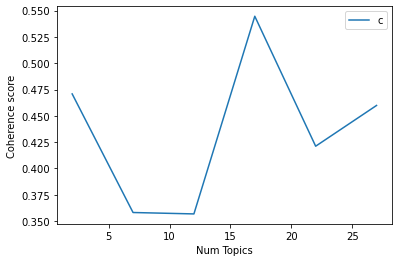

In [85]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_score4)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [86]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_score4):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics =  17

index: 0 | Num Topics = 2  has Coherence Value of 0.4708
index: 1 | Num Topics = 7  has Coherence Value of 0.3582
index: 2 | Num Topics = 12  has Coherence Value of 0.3568
index: 3 | Num Topics = 17  has Coherence Value of 0.5446
index: 4 | Num Topics = 22  has Coherence Value of 0.4211
index: 5 | Num Topics = 27  has Coherence Value of 0.4598


In [87]:
# Select optimal number of topics
optimal_model_sg_score4 = model_list_sg_score4[3]

In [88]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_score4 = pyLDAvis.gensim_models.prepare(optimal_model_sg_score4, corpus_sg_score4, id2word_sg_score4)

In [89]:
print("pyLDAVis for SG topics for score=4:")
vis_sg_score4

pyLDAVis for SG topics for score=4:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.085036 -0.014800       1        1  14.688426
0      0.103493 -0.008569       2        1  12.697172
12    -0.114998  0.085019       3        1   9.260556
1     -0.019140 -0.166773       4        1   8.701811
15     0.043991  0.045114       5        1   6.724338
11     0.105166  0.152648       6        1   6.681740
4     -0.116760  0.097015       7        1   6.603240
7      0.123585  0.038826       8        1   5.925325
5      0.014539 -0.061178       9        1   5.534022
6     -0.083519  0.009161      10        1   5.021173
14    -0.057080  0.007276      11        1   5.001279
16     0.033613 -0.078596      12        1   4.456666
3      0.020833 -0.036690      13        1   3.777373
2     -0.076919 -0.021016      14        1   2.465971
9     -0.042676 -0.018930      15        1   1.562727
13    -0.009582 -0.014253      16        1   0.449091
8     -0.009582 -0.014253      17        1   0.449091, topic_info=          Term       Freq      Total Category  logprob  loglift
59       photo   7.000000   7.000000  Default  30.0000  30.0000
150      night   3.000000   3.000000  Default  29.0000  29.0000
74       emoji   3.000000   3.000000  Default  28.0000  28.0000
0        crash   5.000000   5.000000  Default  27.0000  27.0000
2       update  10.000000  10.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
25        soon   0.008853   3.380678  Topic17  -5.6312  -0.5394
26   translate   0.008853   3.307483  Topic17  -5.6312  -0.5175
27         bug   0.008853   2.014678  Topic17  -5.6312  -0.0218
28     concern   0.008853   1.224807  Topic17  -5.6312   0.4759
29     evening   0.008853   1.224807  Topic17  -5.6312   0.4759

[727 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
168       2  0.881431          able
151       7  0.796104           abt
173       1  0.713626        access
53        5  0.788421     accessing
259      11  0.808260  accidentally
...     ...       ...           ...
122      12  0.826042            xr
38       10  0.816455          year
179       2  0.725411     yesterday
245       1  0.713626           yet
227       4  0.757388            yr

[418 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 1, 13, 2, 16, 12, 5, 8, 6, 7, 15, 17, 4, 3, 10, 14, 9])

## LDA Topic Modelling (Rating = 5)

In [90]:
# By-rating Topic Modelling - rating = 5
# Convert to list - move to each section
review_sg_score5 = facebook_ios_sg_review_YearMonth_score5.review.values.tolist()
review_words_sg_score5 = list(sent_to_words(review_sg_score5))
print(review_words_sg_score5[:1])

[['hi', 'guy', 'would', 'like', 'to', 'recommend', 'you', 'to', 'fix', 'myanmar', 'fonts', 'zawgyi', 'fonts', 'because', 'we', 'get', 'the', 'problem', 'ever', 'it', 'myanmar', 'fonts', 'have', 'two', 'kinds', 'unicode', 'and', 'zawgyi', 'so', 'think', 'you', 'should', 'fix', 'zawgyi', 'fonts', 'for', 'our', 'country', 'because', 'mostly', 'just', 'use', 'zawgyi', 'fonts']]


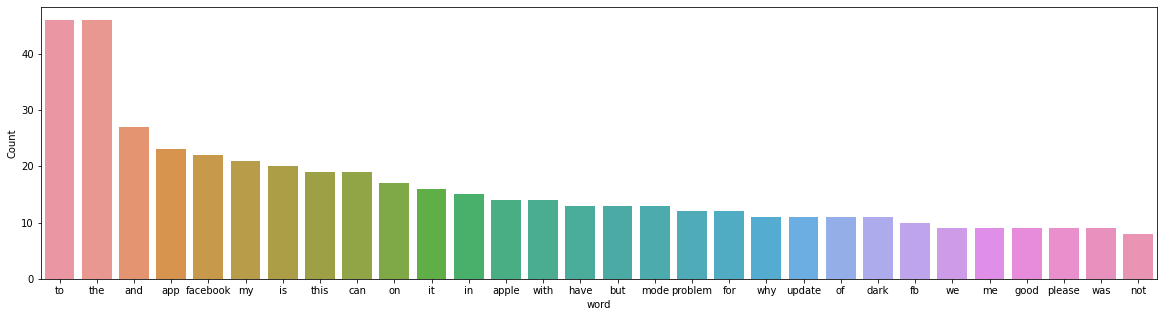

In [91]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_score5))

In [92]:
# Clean text
review_sg_ready_score5 = process_words(review_words_sg_score5)  # processed Text Data! - move to each section

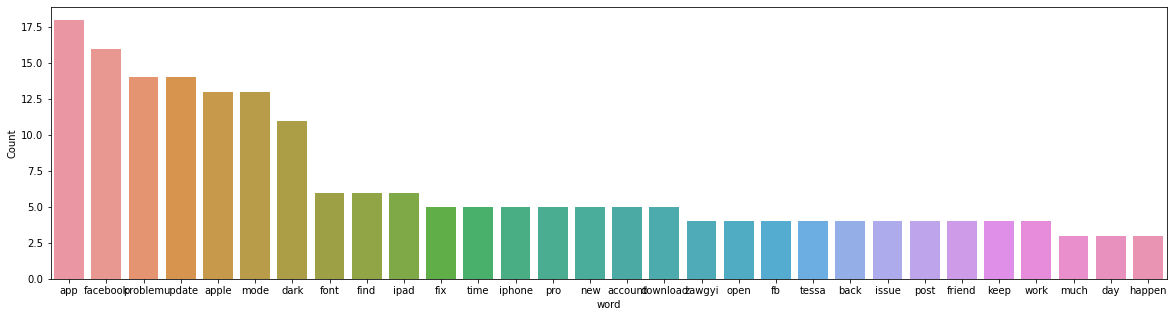

In [93]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_sg_ready_score5))


In [94]:
# Create Dictionary
id2word_sg_score5 = corpora.Dictionary(review_sg_ready_score5)

2021-10-16 18:43:10,835 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 18:43:10,840 [INFO] gensim.corpora.dictionary - built Dictionary(315 unique tokens: ['country', 'ever', 'fix', 'font', 'guy']...) from 77 documents (total 567 corpus positions)
2021-10-16 18:43:10,841 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(315 unique tokens: ['country', 'ever', 'fix', 'font', 'guy']...) from 77 documents (total 567 corpus positions)", 'datetime': '2021-10-16T18:43:10.841520', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [95]:
# Create Corpus: Term Document Frequency
corpus_sg_score5 = [id2word_sg_score5.doc2bow(text) for text in review_sg_ready_score5]

In [96]:
# Training LDA model
model_list_sg_score5, coherence_values_sg_score5 = compute_coherence_values(dictionary=id2word_sg_score5, corpus=corpus_sg_score5, 
                                                              texts=review_sg_ready_score5, limit=30, start=2, step=5)


2021-10-16 18:43:10,862 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 18:43:10,864 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 18:43:10,867 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:43:10,868 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 77 documents, updating model once every 77 documents, evaluating perplexity every 77 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:43:11,125 [INFO] gensim.models.ldamodel - -6.561 per-word bound, 94.4 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:43:11,127 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #77/77
2021-10-16 18:43:11,342 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"app" + 0.022*"update" + 0.021*"problem" + 0.019*"apple" + 0.019*"facebook" + 0.014*"mode" + 0.012*"dark" 

2021-10-16 18:43:12,981 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.030*"mode" + 0.025*"facebook" + 0.025*"dark" + 0.016*"font" + 0.016*"app" + 0.013*"update" + 0.011*"find" + 0.011*"problem" + 0.011*"fix" + 0.011*"zawgyi"
2021-10-16 18:43:12,984 [INFO] gensim.models.ldamodel - topic diff=0.009849, rho=0.301511
2021-10-16 18:43:13,085 [INFO] gensim.models.ldamodel - -5.886 per-word bound, 59.1 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:43:13,087 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #77/77
2021-10-16 18:43:13,126 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.027*"app" + 0.024*"apple" + 0.022*"problem" + 0.020*"update" + 0.014*"facebook" + 0.013*"ipad" + 0.011*"download" + 0.011*"account" + 0.010*"pro" + 0.009*"tessa"
2021-10-16 18:43:13,129 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.031*"mode" + 0.025*"dark" + 0.025*"facebook" + 0.016*"font" + 0.016*"app" + 0.013*"update" + 0.011*"find" + 0

2021-10-16 18:43:14,802 [INFO] gensim.models.ldamodel - topic diff=0.001536, rho=0.218218
2021-10-16 18:43:14,926 [INFO] gensim.models.ldamodel - -5.881 per-word bound, 58.9 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:43:14,947 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #77/77
2021-10-16 18:43:14,979 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.026*"app" + 0.024*"apple" + 0.022*"problem" + 0.020*"update" + 0.014*"ipad" + 0.014*"facebook" + 0.012*"download" + 0.011*"account" + 0.010*"pro" + 0.010*"tessa"
2021-10-16 18:43:14,980 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.033*"mode" + 0.028*"dark" + 0.026*"facebook" + 0.016*"app" + 0.016*"font" + 0.014*"update" + 0.011*"problem" + 0.011*"find" + 0.011*"fix" + 0.011*"zawgyi"
2021-10-16 18:43:14,982 [INFO] gensim.models.ldamodel - topic diff=0.001374, rho=0.213201
2021-10-16 18:43:15,099 [INFO] gensim.models.ldamodel - -5.881 per-word bound, 58.9 perplexity 

2021-10-16 18:43:17,108 [INFO] gensim.models.ldamodel - -5.880 per-word bound, 58.9 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:43:17,110 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #77/77
2021-10-16 18:43:17,214 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.026*"app" + 0.024*"apple" + 0.022*"problem" + 0.020*"update" + 0.014*"ipad" + 0.013*"facebook" + 0.012*"download" + 0.011*"account" + 0.010*"pro" + 0.010*"tessa"
2021-10-16 18:43:17,215 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.033*"mode" + 0.028*"dark" + 0.026*"facebook" + 0.017*"app" + 0.016*"font" + 0.014*"update" + 0.012*"problem" + 0.011*"find" + 0.011*"fix" + 0.011*"zawgyi"
2021-10-16 18:43:17,217 [INFO] gensim.models.ldamodel - topic diff=0.000639, rho=0.176777
2021-10-16 18:43:17,351 [INFO] gensim.models.ldamodel - -5.880 per-word bound, 58.9 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:43:17,356

2021-10-16 18:43:19,222 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #77/77
2021-10-16 18:43:19,279 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.026*"app" + 0.024*"apple" + 0.022*"problem" + 0.020*"update" + 0.014*"ipad" + 0.013*"facebook" + 0.012*"download" + 0.011*"account" + 0.010*"pro" + 0.010*"tessa"
2021-10-16 18:43:19,283 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.033*"mode" + 0.028*"dark" + 0.026*"facebook" + 0.017*"app" + 0.016*"font" + 0.014*"update" + 0.012*"problem" + 0.011*"find" + 0.011*"fix" + 0.011*"zawgyi"
2021-10-16 18:43:19,285 [INFO] gensim.models.ldamodel - topic diff=0.000268, rho=0.154303
2021-10-16 18:43:19,397 [INFO] gensim.models.ldamodel - -5.880 per-word bound, 58.9 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:43:19,410 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #77/77
2021-10-16 18:43:19,486 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.026*"app" + 0.0

2021-10-16 18:43:20,888 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 18:43:26,125 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 18:43:26,149 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 56 virtual documents
2021-10-16 18:43:26,456 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 18:43:26,458 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 18:43:26,465 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:43:26,471 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 77 documents, updating model once every 77 documents, evaluating perplexity every 77 documents, iterating 50x with a converg

2021-10-16 18:43:27,282 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.032*"facebook" + 0.031*"download" + 0.025*"iphone" + 0.020*"problem" + 0.019*"update" + 0.019*"app" + 0.019*"find" + 0.019*"phone" + 0.014*"apple" + 0.013*"fb"
2021-10-16 18:43:27,284 [INFO] gensim.models.ldamodel - topic diff=0.047378, rho=0.408248
2021-10-16 18:43:27,348 [INFO] gensim.models.ldamodel - -6.107 per-word bound, 68.9 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:43:27,350 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #77/77
2021-10-16 18:43:27,456 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.032*"facebook" + 0.032*"download" + 0.025*"iphone" + 0.019*"problem" + 0.019*"update" + 0.019*"app" + 0.019*"find" + 0.019*"phone" + 0.014*"apple" + 0.013*"fb"
2021-10-16 18:43:27,458 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.079*"app" + 0.047*"update" + 0.030*"problem" + 0.030*"io" + 0.029*"facebook" + 0.021*"error" + 0.021*"crazy

2021-10-16 18:43:28,091 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.038*"account" + 0.019*"facebook" + 0.019*"help" + 0.019*"login" + 0.019*"delete" + 0.019*"open" + 0.019*"still" + 0.019*"back" + 0.019*"log" + 0.010*"fb"
2021-10-16 18:43:28,094 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.078*"app" + 0.046*"update" + 0.030*"problem" + 0.030*"io" + 0.028*"facebook" + 0.023*"care" + 0.023*"reaction" + 0.020*"error" + 0.020*"crazy" + 0.020*"pls"
2021-10-16 18:43:28,098 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.032*"facebook" + 0.032*"download" + 0.026*"iphone" + 0.019*"problem" + 0.019*"update" + 0.019*"app" + 0.019*"find" + 0.019*"phone" + 0.013*"apple" + 0.013*"fb"
2021-10-16 18:43:28,099 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.040*"apple" + 0.031*"problem" + 0.027*"font" + 0.022*"ipad" + 0.018*"zawgyi" + 0.018*"pro" + 0.018*"tessa" + 0.014*"find" + 0.014*"year" + 0.014*"customer"
2021-10-16 18:43:28,100 [INFO] gensim.models.ldamodel - topic diff=0.

2021-10-16 18:43:28,774 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.037*"keep" + 0.037*"great" + 0.026*"friend" + 0.026*"video" + 0.025*"app" + 0.025*"work" + 0.014*"problem" + 0.014*"time" + 0.014*"much" + 0.014*"issue"
2021-10-16 18:43:28,778 [INFO] gensim.models.ldamodel - topic diff=0.001689, rho=0.242536
2021-10-16 18:43:28,835 [INFO] gensim.models.ldamodel - -6.090 per-word bound, 68.1 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:43:28,837 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #77/77
2021-10-16 18:43:28,881 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.077*"app" + 0.046*"update" + 0.030*"problem" + 0.030*"io" + 0.028*"care" + 0.028*"reaction" + 0.028*"facebook" + 0.020*"error" + 0.020*"crazy" + 0.020*"pls"
2021-10-16 18:43:28,886 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.043*"facebook" + 0.042*"shop" + 0.029*"work" + 0.029*"publish" + 0.029*"feature" + 0.015*"receive" + 0.015*"give" + 

2021-10-16 18:43:29,590 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.043*"facebook" + 0.042*"shop" + 0.029*"work" + 0.029*"feature" + 0.029*"publish" + 0.015*"receive" + 0.015*"give" + 0.015*"support" + 0.015*"happen" + 0.015*"review"
2021-10-16 18:43:29,591 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.037*"keep" + 0.037*"great" + 0.026*"friend" + 0.026*"video" + 0.026*"app" + 0.025*"work" + 0.014*"much" + 0.014*"problem" + 0.014*"issue" + 0.014*"time"
2021-10-16 18:43:29,592 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.077*"app" + 0.046*"update" + 0.030*"io" + 0.030*"problem" + 0.029*"care" + 0.029*"reaction" + 0.027*"facebook" + 0.020*"error" + 0.020*"crazy" + 0.020*"pls"
2021-10-16 18:43:29,593 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.038*"account" + 0.019*"facebook" + 0.019*"open" + 0.019*"back" + 0.019*"help" + 0.019*"still" + 0.019*"login" + 0.019*"delete" + 0.019*"log" + 0.010*"fb"
2021-10-16 18:43:29,595 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 18:43:30,231 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.032*"facebook" + 0.032*"download" + 0.026*"iphone" + 0.019*"problem" + 0.019*"find" + 0.019*"app" + 0.019*"phone" + 0.019*"update" + 0.013*"fb" + 0.013*"check"
2021-10-16 18:43:30,233 [INFO] gensim.models.ldamodel - topic diff=0.000193, rho=0.188982
2021-10-16 18:43:30,312 [INFO] gensim.models.ldamodel - -6.088 per-word bound, 68.0 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:43:30,314 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #77/77
2021-10-16 18:43:30,341 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.037*"keep" + 0.037*"great" + 0.026*"friend" + 0.026*"video" + 0.026*"app" + 0.026*"work" + 0.014*"much" + 0.014*"issue" + 0.014*"time" + 0.014*"social"
2021-10-16 18:43:30,343 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.032*"facebook" + 0.032*"download" + 0.026*"iphone" + 0.019*"problem" + 0.019*"find" + 0.019*"app" + 0.019*"phone" 

2021-10-16 18:43:31,007 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.043*"facebook" + 0.042*"shop" + 0.029*"work" + 0.029*"feature" + 0.029*"publish" + 0.015*"receive" + 0.015*"give" + 0.015*"support" + 0.015*"happen" + 0.015*"review"
2021-10-16 18:43:31,009 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.076*"app" + 0.046*"update" + 0.030*"io" + 0.030*"problem" + 0.029*"reaction" + 0.029*"care" + 0.027*"facebook" + 0.020*"error" + 0.020*"crazy" + 0.020*"pls"
2021-10-16 18:43:31,016 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.040*"apple" + 0.032*"problem" + 0.027*"font" + 0.023*"ipad" + 0.018*"pro" + 0.018*"zawgyi" + 0.018*"tessa" + 0.014*"year" + 0.014*"customer" + 0.014*"name"
2021-10-16 18:43:31,018 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.037*"keep" + 0.037*"great" + 0.026*"friend" + 0.026*"video" + 0.026*"app" + 0.026*"work" + 0.014*"much" + 0.014*"issue" + 0.014*"social" + 0.014*"time"
2021-10-16 18:43:31,020 [INFO] gensim.models.ldamodel - topic dif

2021-10-16 18:43:31,736 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.076*"app" + 0.046*"update" + 0.030*"io" + 0.030*"problem" + 0.029*"care" + 0.029*"reaction" + 0.027*"facebook" + 0.020*"error" + 0.020*"crazy" + 0.020*"pls"
2021-10-16 18:43:31,739 [INFO] gensim.models.ldamodel - topic diff=0.000023, rho=0.160128
2021-10-16 18:43:31,826 [INFO] gensim.models.ldamodel - -6.088 per-word bound, 68.0 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:43:31,827 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #77/77
2021-10-16 18:43:31,850 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.076*"app" + 0.046*"update" + 0.030*"io" + 0.030*"problem" + 0.029*"care" + 0.029*"reaction" + 0.027*"facebook" + 0.020*"error" + 0.020*"crazy" + 0.020*"pls"
2021-10-16 18:43:31,852 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.032*"facebook" + 0.032*"download" + 0.026*"iphone" + 0.019*"find" + 0.019*"problem" + 0.019*"app" + 0.019*"phone

2021-10-16 18:43:32,531 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.110*"mode" + 0.093*"dark" + 0.045*"update" + 0.026*"app" + 0.020*"facebook" + 0.018*"change" + 0.018*"black" + 0.018*"day" + 0.010*"toggle" + 0.010*"almost"
2021-10-16 18:43:32,536 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.037*"keep" + 0.037*"great" + 0.026*"friend" + 0.026*"video" + 0.026*"app" + 0.026*"work" + 0.014*"much" + 0.014*"issue" + 0.014*"social" + 0.014*"place"
2021-10-16 18:43:32,548 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.076*"app" + 0.046*"update" + 0.030*"io" + 0.030*"problem" + 0.030*"reaction" + 0.030*"care" + 0.027*"facebook" + 0.020*"error" + 0.020*"crazy" + 0.020*"pls"
2021-10-16 18:43:32,552 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.032*"facebook" + 0.032*"download" + 0.026*"iphone" + 0.019*"find" + 0.019*"problem" + 0.019*"app" + 0.019*"phone" + 0.019*"update" + 0.013*"fb" + 0.013*"check"
2021-10-16 18:43:32,565 [INFO] gensim.models.ldamodel - topic diff=0.

2021-10-16 18:43:33,142 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.076*"app" + 0.046*"update" + 0.030*"io" + 0.030*"care" + 0.030*"reaction" + 0.030*"problem" + 0.027*"facebook" + 0.020*"error" + 0.020*"crazy" + 0.020*"pls"
2021-10-16 18:43:33,145 [INFO] gensim.models.ldamodel - topic diff=0.000003, rho=0.141421
2021-10-16 18:43:33,184 [INFO] gensim.models.ldamodel - -6.088 per-word bound, 68.0 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:43:33,185 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #77/77
2021-10-16 18:43:33,331 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.038*"account" + 0.019*"facebook" + 0.019*"open" + 0.019*"back" + 0.019*"help" + 0.019*"still" + 0.019*"delete" + 0.019*"login" + 0.019*"log" + 0.010*"fb"
2021-10-16 18:43:33,332 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.043*"facebook" + 0.042*"shop" + 0.029*"work" + 0.029*"feature" + 0.029*"publish" + 0.015*"receive" + 0.015*"give" +

2021-10-16 18:43:41,166 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.036*"lahat" + 0.010*"apple" + 0.009*"problem" + 0.007*"ipad" + 0.007*"tessa" + 0.006*"employee" + 0.006*"pro" + 0.005*"name" + 0.005*"attend" + 0.005*"excellent"
2021-10-16 18:43:41,168 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.096*"app" + 0.051*"update" + 0.025*"open" + 0.025*"video" + 0.025*"error" + 0.025*"system" + 0.022*"day" + 0.015*"problem" + 0.015*"really" + 0.014*"issue"
2021-10-16 18:43:41,172 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.068*"download" + 0.045*"fb" + 0.035*"datum" + 0.035*"login" + 0.035*"wifi" + 0.018*"enjoy" + 0.018*"signal" + 0.018*"pop" + 0.018*"able" + 0.018*"full"
2021-10-16 18:43:41,174 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.092*"mode" + 0.092*"dark" + 0.039*"update" + 0.026*"app" + 0.026*"year" + 0.026*"post" + 0.026*"ago" + 0.026*"read" + 0.014*"status" + 0.014*"related"
2021-10-16 18:43:41,177 [INFO] gensim.models.ldamodel - topic diff=0.108417

2021-10-16 18:43:41,988 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.055*"apple" + 0.037*"problem" + 0.031*"ipad" + 0.025*"pro" + 0.025*"tessa" + 0.019*"find" + 0.019*"name" + 0.019*"employee" + 0.013*"back" + 0.013*"note"
2021-10-16 18:43:41,990 [INFO] gensim.models.ldamodel - topic diff=0.019528, rho=0.316228
2021-10-16 18:43:42,098 [INFO] gensim.models.ldamodel - -6.215 per-word bound, 74.3 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:43:42,100 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #77/77
2021-10-16 18:43:42,214 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.056*"apple" + 0.037*"problem" + 0.031*"ipad" + 0.025*"pro" + 0.025*"tessa" + 0.019*"find" + 0.019*"name" + 0.019*"employee" + 0.013*"back" + 0.013*"note"
2021-10-16 18:43:42,218 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.062*"reaction" + 0.062*"care" + 0.022*"keep" + 0.022*"evolve" + 0.022*"improve" + 0.022*"customer" + 0.022*"important"

2021-10-16 18:43:42,996 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.045*"font" + 0.045*"problem" + 0.036*"zawgyi" + 0.027*"fix" + 0.027*"facebook" + 0.027*"phone" + 0.019*"help" + 0.019*"crazy" + 0.019*"issue" + 0.019*"app"
2021-10-16 18:43:43,000 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.068*"download" + 0.051*"fb" + 0.035*"wifi" + 0.035*"datum" + 0.035*"login" + 0.018*"able" + 0.018*"enjoy" + 0.018*"resolve" + 0.018*"social" + 0.018*"full"
2021-10-16 18:43:43,002 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.099*"app" + 0.050*"update" + 0.026*"video" + 0.026*"error" + 0.026*"open" + 0.026*"system" + 0.026*"day" + 0.013*"problem" + 0.013*"really" + 0.013*"issue"
2021-10-16 18:43:43,004 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.055*"facebook" + 0.042*"app" + 0.039*"update" + 0.028*"awesome" + 0.024*"iphone" + 0.015*"friend" + 0.015*"great" + 0.015*"keep" + 0.015*"touch" + 0.015*"place"
2021-10-16 18:43:43,005 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 18:43:43,609 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.037*"account" + 0.037*"back" + 0.037*"wait" + 0.019*"time" + 0.019*"rectify" + 0.019*"happen" + 0.019*"still" + 0.019*"soon" + 0.019*"submit" + 0.019*"review"
2021-10-16 18:43:43,610 [INFO] gensim.models.ldamodel - topic diff=0.000869, rho=0.218218
2021-10-16 18:43:43,718 [INFO] gensim.models.ldamodel - -6.210 per-word bound, 74.0 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:43:43,720 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #77/77
2021-10-16 18:43:43,755 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.056*"apple" + 0.037*"problem" + 0.031*"ipad" + 0.025*"pro" + 0.025*"tessa" + 0.019*"find" + 0.019*"name" + 0.019*"employee" + 0.013*"back" + 0.013*"note"
2021-10-16 18:43:43,757 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.055*"facebook" + 0.042*"app" + 0.040*"update" + 0.028*"awesome" + 0.025*"iphone" + 0.015*"friend" + 0.015*"great"

2021-10-16 18:43:44,460 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.037*"account" + 0.037*"back" + 0.037*"wait" + 0.019*"time" + 0.019*"rectify" + 0.019*"happen" + 0.019*"still" + 0.019*"open" + 0.019*"photo" + 0.019*"review"
2021-10-16 18:43:44,461 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.109*"mode" + 0.109*"dark" + 0.037*"update" + 0.025*"post" + 0.025*"read" + 0.025*"year" + 0.025*"ago" + 0.025*"app" + 0.013*"old" + 0.013*"continue"
2021-10-16 18:43:44,462 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.054*"facebook" + 0.054*"shop" + 0.036*"work" + 0.036*"publish" + 0.036*"feature" + 0.019*"support" + 0.019*"give" + 0.019*"receive" + 0.019*"review" + 0.019*"sorry"
2021-10-16 18:43:44,465 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.045*"font" + 0.045*"problem" + 0.036*"zawgyi" + 0.027*"fix" + 0.027*"facebook" + 0.027*"phone" + 0.019*"help" + 0.019*"crazy" + 0.019*"issue" + 0.019*"app"
2021-10-16 18:43:44,466 [INFO] gensim.models.ldamodel - topic diff=

2021-10-16 18:43:45,135 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.068*"download" + 0.051*"fb" + 0.035*"datum" + 0.035*"wifi" + 0.035*"login" + 0.018*"able" + 0.018*"enjoy" + 0.018*"resolve" + 0.018*"social" + 0.018*"demand"
2021-10-16 18:43:45,137 [INFO] gensim.models.ldamodel - topic diff=0.000072, rho=0.176777
2021-10-16 18:43:45,177 [INFO] gensim.models.ldamodel - -6.210 per-word bound, 74.0 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:43:45,178 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #77/77
2021-10-16 18:43:45,205 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.063*"care" + 0.063*"reaction" + 0.022*"keep" + 0.022*"base" + 0.022*"evolve" + 0.022*"feedback" + 0.022*"improve" + 0.022*"important" + 0.022*"customer" + 0.022*"menu"
2021-10-16 18:43:45,206 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.056*"apple" + 0.037*"problem" + 0.031*"ipad" + 0.025*"pro" + 0.025*"tessa" + 0.019*"find" + 0.019*"

2021-10-16 18:43:45,876 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.033*"facebook" + 0.017*"leave" + 0.017*"find" + 0.017*"fb" + 0.017*"delete" + 0.017*"much" + 0.017*"appreciate" + 0.017*"assist" + 0.017*"await" + 0.017*"advance"
2021-10-16 18:43:45,878 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.055*"mode" + 0.055*"io" + 0.037*"app" + 0.037*"dark" + 0.037*"pls" + 0.037*"apple" + 0.037*"problem" + 0.037*"facebook" + 0.019*"update" + 0.019*"long"
2021-10-16 18:43:45,883 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.040*"lahat" + 0.003*"apple" + 0.003*"problem" + 0.003*"ipad" + 0.003*"tessa" + 0.003*"employee" + 0.003*"pro" + 0.003*"name" + 0.003*"attend" + 0.003*"excellent"
2021-10-16 18:43:45,885 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.109*"mode" + 0.109*"dark" + 0.037*"update" + 0.025*"post" + 0.025*"read" + 0.025*"year" + 0.025*"ago" + 0.025*"app" + 0.013*"old" + 0.013*"continue"
2021-10-16 18:43:45,890 [INFO] gensim.models.ldamodel - topic #8 (0.08

2021-10-16 18:43:46,524 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.099*"app" + 0.050*"update" + 0.026*"video" + 0.026*"error" + 0.026*"open" + 0.026*"system" + 0.026*"day" + 0.013*"really" + 0.013*"problem" + 0.013*"issue"
2021-10-16 18:43:46,525 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.109*"mode" + 0.109*"dark" + 0.037*"update" + 0.025*"post" + 0.025*"read" + 0.025*"year" + 0.025*"ago" + 0.025*"app" + 0.013*"old" + 0.013*"continue"
2021-10-16 18:43:46,526 [INFO] gensim.models.ldamodel - topic diff=0.000357, rho=0.152499
2021-10-16 18:43:46,567 [INFO] gensim.models.ldamodel - -6.208 per-word bound, 73.9 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:43:46,568 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #77/77
2021-10-16 18:43:46,611 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.068*"download" + 0.051*"fb" + 0.035*"datum" + 0.035*"wifi" + 0.035*"login" + 0.018*"able" + 0.018*"enjoy" + 0.018*"resolv

2021-10-16 18:43:47,224 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #77/77
2021-10-16 18:43:47,267 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.040*"lahat" + 0.003*"apple" + 0.003*"problem" + 0.003*"ipad" + 0.003*"tessa" + 0.003*"employee" + 0.003*"pro" + 0.003*"name" + 0.003*"attend" + 0.003*"excellent"
2021-10-16 18:43:47,271 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.068*"download" + 0.051*"fb" + 0.035*"datum" + 0.035*"wifi" + 0.035*"login" + 0.018*"able" + 0.018*"enjoy" + 0.018*"resolve" + 0.018*"social" + 0.018*"demand"
2021-10-16 18:43:47,273 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.055*"mode" + 0.055*"io" + 0.037*"dark" + 0.037*"pls" + 0.037*"apple" + 0.037*"facebook" + 0.037*"problem" + 0.037*"app" + 0.019*"update" + 0.019*"long"
2021-10-16 18:43:47,275 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.045*"font" + 0.045*"problem" + 0.036*"zawgyi" + 0.027*"fix" + 0.027*"facebook" + 0.027*"phone" + 0.019*"help" + 0.019*"check" + 0

2021-10-16 18:43:55,680 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.047*"download" + 0.035*"problem" + 0.030*"apple" + 0.027*"phone" + 0.024*"datum" + 0.024*"fb" + 0.024*"wifi" + 0.020*"new" + 0.020*"center" + 0.019*"find"
2021-10-16 18:43:55,684 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.057*"apple" + 0.037*"problem" + 0.031*"ipad" + 0.026*"pro" + 0.025*"tessa" + 0.019*"name" + 0.018*"employee" + 0.016*"happen" + 0.016*"app" + 0.014*"time"
2021-10-16 18:43:55,692 [INFO] gensim.models.ldamodel - topic diff=0.185483, rho=0.577350
2021-10-16 18:43:55,739 [INFO] gensim.models.ldamodel - -6.507 per-word bound, 90.9 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:43:55,744 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #77/77
2021-10-16 18:43:55,773 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.027*"back" + 0.027*"cut" + 0.027*"miss" + 0.027*"short" + 0.027*"navigation" + 0.027*"almost" + 0.027*"upgrade" + 0.0

2021-10-16 18:43:56,347 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #77/77
2021-10-16 18:43:56,462 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.057*"mode" + 0.050*"login" + 0.050*"black" + 0.050*"facebook" + 0.026*"change" + 0.026*"update" + 0.026*"friend" + 0.026*"happen" + 0.026*"share" + 0.026*"post"
2021-10-16 18:43:56,468 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.027*"back" + 0.027*"cut" + 0.027*"navigation" + 0.027*"miss" + 0.027*"short" + 0.027*"find" + 0.027*"shortcut" + 0.027*"set" + 0.027*"enable" + 0.027*"upgrade"
2021-10-16 18:43:56,472 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.072*"shop" + 0.072*"facebook" + 0.048*"publish" + 0.048*"feature" + 0.048*"work" + 0.025*"email" + 0.025*"apologise" + 0.025*"receive" + 0.025*"concierge" + 0.025*"properly"
2021-10-16 18:43:56,475 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.053*"video" + 0.027*"clip" + 0.027*"freeze" + 0.027*"problem" + 0.027*"keep" + 0.027*"audio" + 0.027*"open"

2021-10-16 18:43:57,173 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.061*"apple" + 0.041*"problem" + 0.034*"ipad" + 0.027*"pro" + 0.027*"tessa" + 0.021*"name" + 0.021*"employee" + 0.014*"happen" + 0.014*"time" + 0.014*"note"
2021-10-16 18:43:57,176 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.072*"shop" + 0.072*"facebook" + 0.048*"work" + 0.048*"publish" + 0.048*"feature" + 0.025*"apologise" + 0.025*"support" + 0.025*"review" + 0.025*"sorry" + 0.025*"receive"
2021-10-16 18:43:57,179 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.027*"shortcut" + 0.027*"back" + 0.027*"short" + 0.027*"set" + 0.027*"navigation" + 0.027*"miss" + 0.027*"find" + 0.027*"cut" + 0.027*"enable" + 0.027*"upgrade"
2021-10-16 18:43:57,181 [INFO] gensim.models.ldamodel - topic diff=0.006255, rho=0.267261
2021-10-16 18:43:57,244 [INFO] gensim.models.ldamodel - -6.294 per-word bound, 78.4 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:43:57,245 [INFO] gen

2021-10-16 18:43:57,947 [INFO] gensim.models.ldamodel - topic diff=0.001929, rho=0.229416
2021-10-16 18:43:58,011 [INFO] gensim.models.ldamodel - -6.291 per-word bound, 78.3 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:43:58,019 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #77/77
2021-10-16 18:43:58,100 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.061*"apple" + 0.041*"problem" + 0.034*"ipad" + 0.027*"pro" + 0.027*"tessa" + 0.021*"name" + 0.021*"employee" + 0.014*"happen" + 0.014*"time" + 0.014*"note"
2021-10-16 18:43:58,102 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.153*"dark" + 0.151*"mode" + 0.056*"app" + 0.042*"io" + 0.042*"update" + 0.028*"apple" + 0.028*"pls" + 0.015*"problem" + 0.015*"facebook" + 0.015*"iphone"
2021-10-16 18:43:58,103 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.054*"mode" + 0.051*"login" + 0.051*"facebook" + 0.051*"black" + 0.026*"application" + 0.026*"update" + 0.026*"change

2021-10-16 18:43:58,836 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.055*"video" + 0.028*"open" + 0.028*"problem" + 0.028*"clip" + 0.028*"freeze" + 0.028*"issue" + 0.028*"play" + 0.028*"still" + 0.028*"audio" + 0.028*"keep"
2021-10-16 18:43:58,838 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.082*"font" + 0.066*"zawgyi" + 0.050*"fix" + 0.033*"facebook" + 0.033*"help" + 0.017*"problem" + 0.017*"issue" + 0.017*"app" + 0.017*"ever" + 0.017*"kind"
2021-10-16 18:43:58,838 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.153*"dark" + 0.151*"mode" + 0.056*"app" + 0.042*"io" + 0.042*"update" + 0.028*"apple" + 0.028*"pls" + 0.015*"problem" + 0.015*"facebook" + 0.015*"iphone"
2021-10-16 18:43:58,839 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.100*"reaction" + 0.100*"care" + 0.035*"remove" + 0.035*"gambling" + 0.035*"ad" + 0.035*"bet" + 0.035*"online" + 0.035*"activate" + 0.002*"active" + 0.002*"late"
2021-10-16 18:43:58,840 [INFO] gensim.models.ldamodel - topic diff=0.

2021-10-16 18:43:59,496 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.049*"download" + 0.037*"problem" + 0.037*"phone" + 0.037*"check" + 0.025*"apple" + 0.025*"wifi" + 0.025*"fb" + 0.025*"datum" + 0.025*"new" + 0.025*"center"
2021-10-16 18:43:59,498 [INFO] gensim.models.ldamodel - topic diff=0.000185, rho=0.182574
2021-10-16 18:43:59,597 [INFO] gensim.models.ldamodel - -6.290 per-word bound, 78.3 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:43:59,607 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #77/77
2021-10-16 18:43:59,717 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.055*"app" + 0.055*"facebook" + 0.037*"update" + 0.019*"great" + 0.019*"help" + 0.019*"touch" + 0.019*"news" + 0.019*"family" + 0.019*"event" + 0.019*"friend"
2021-10-16 18:43:59,719 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.072*"facebook" + 0.072*"shop" + 0.048*"work" + 0.048*"publish" + 0.048*"feature" + 0.025*"apologise" + 0.025*"su

2021-10-16 18:44:00,540 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.055*"app" + 0.055*"facebook" + 0.037*"update" + 0.019*"great" + 0.019*"help" + 0.019*"touch" + 0.019*"news" + 0.019*"family" + 0.019*"event" + 0.019*"friend"
2021-10-16 18:44:00,541 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.099*"app" + 0.058*"update" + 0.029*"account" + 0.029*"back" + 0.029*"error" + 0.029*"iphone" + 0.029*"day" + 0.029*"really" + 0.015*"hopefully" + 0.015*"submit"
2021-10-16 18:44:00,542 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.049*"download" + 0.037*"problem" + 0.037*"phone" + 0.037*"check" + 0.025*"apple" + 0.025*"wifi" + 0.025*"fb" + 0.025*"datum" + 0.025*"new" + 0.025*"center"
2021-10-16 18:44:00,544 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.056*"find" + 0.029*"facebook" + 0.029*"improve" + 0.029*"evolve" + 0.029*"keep" + 0.029*"important" + 0.029*"feedback" + 0.029*"base" + 0.029*"customer" + 0.029*"mobile"
2021-10-16 18:44:00,545 [INFO] gensim.models.ldamo

2021-10-16 18:44:01,377 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.056*"find" + 0.029*"facebook" + 0.029*"improve" + 0.029*"evolve" + 0.029*"keep" + 0.029*"important" + 0.029*"feedback" + 0.029*"base" + 0.029*"customer" + 0.029*"mobile"
2021-10-16 18:44:01,382 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.072*"facebook" + 0.072*"shop" + 0.048*"work" + 0.048*"publish" + 0.048*"feature" + 0.025*"apologise" + 0.025*"support" + 0.025*"review" + 0.025*"sorry" + 0.025*"give"
2021-10-16 18:44:01,385 [INFO] gensim.models.ldamodel - topic diff=0.000022, rho=0.156174
2021-10-16 18:44:01,488 [INFO] gensim.models.ldamodel - -6.290 per-word bound, 78.3 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:44:01,490 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #77/77
2021-10-16 18:44:01,512 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.055*"video" + 0.028*"open" + 0.028*"problem" + 0.028*"clip" + 0.028*"freeze" + 0.028*"i

2021-10-16 18:44:02,383 [INFO] gensim.models.ldamodel - -6.290 per-word bound, 78.3 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:44:02,385 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #77/77
2021-10-16 18:44:02,479 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.082*"font" + 0.066*"zawgyi" + 0.050*"fix" + 0.033*"facebook" + 0.033*"help" + 0.017*"problem" + 0.017*"issue" + 0.017*"app" + 0.017*"ever" + 0.017*"kind"
2021-10-16 18:44:02,481 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.061*"apple" + 0.041*"problem" + 0.034*"ipad" + 0.028*"pro" + 0.028*"tessa" + 0.021*"name" + 0.021*"employee" + 0.014*"note" + 0.014*"professionalism" + 0.014*"service"
2021-10-16 18:44:02,482 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.045*"new" + 0.045*"issue" + 0.045*"update" + 0.045*"menu" + 0.045*"resolve" + 0.003*"late" + 0.003*"second" + 0.003*"quick" + 0.003*"show" + 0.003*"kudo"
2021-10-16 18:44:02,483 [INFO] gensim.

2021-10-16 18:44:08,545 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 18:44:08,633 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 71 virtual documents
2021-10-16 18:44:12,345 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.045454545454545456
2021-10-16 18:44:12,347 [INFO] gensim.models.ldamodel - using symmetric eta at 0.045454545454545456
2021-10-16 18:44:12,349 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:44:12,353 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 22 topics, 50 passes over the supplied corpus of 77 documents, updating model once every 77 documents, evaluating perplexity every 77 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:44:12,471 [INFO] gensim.models.ldamodel - -27.895 per-word bound, 249603133.0 perplexity estimate based on a held-out corpus of 77 documents with 567 

2021-10-16 18:44:13,224 [INFO] gensim.models.ldamodel - topic diff=0.107141, rho=0.408248
2021-10-16 18:44:13,273 [INFO] gensim.models.ldamodel - -6.442 per-word bound, 86.9 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:44:13,281 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #77/77
2021-10-16 18:44:13,348 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.042*"vegetable" + 0.042*"system" + 0.042*"horrible" + 0.042*"solve" + 0.042*"language" + 0.042*"bug" + 0.042*"troublemaker" + 0.042*"translation" + 0.042*"terrible" + 0.042*"version"
2021-10-16 18:44:13,349 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.199*"mode" + 0.157*"dark" + 0.041*"black" + 0.041*"facebook" + 0.041*"update" + 0.040*"care" + 0.040*"reaction" + 0.038*"change" + 0.021*"application" + 0.021*"date"
2021-10-16 18:44:13,353 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.056*"apple" + 0.044*"problem" + 0.032*"font" + 0.031*"ipad" + 0.026*"zawgyi"

2021-10-16 18:44:13,968 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.063*"asap" + 0.063*"hope" + 0.009*"dark" + 0.008*"mode" + 0.003*"regular" + 0.003*"kudo" + 0.003*"error" + 0.003*"second" + 0.003*"quick" + 0.003*"show"
2021-10-16 18:44:13,969 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.057*"apple" + 0.044*"problem" + 0.032*"font" + 0.032*"ipad" + 0.025*"zawgyi" + 0.025*"tessa" + 0.025*"pro" + 0.019*"name" + 0.019*"employee" + 0.013*"fix"
2021-10-16 18:44:13,970 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.036*"update" + 0.036*"year" + 0.036*"ago" + 0.036*"read" + 0.036*"old" + 0.036*"login" + 0.019*"app" + 0.019*"find" + 0.019*"new" + 0.019*"facebook"
2021-10-16 18:44:13,972 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.096*"awesome" + 0.049*"fantastic" + 0.049*"sooo" + 0.049*"much" + 0.049*"enjoy" + 0.049*"lahat" + 0.002*"back" + 0.002*"wait" + 0.002*"account" + 0.002*"review"
2021-10-16 18:44:13,973 [INFO] gensim.models.ldamodel - topic diff=0.01958

2021-10-16 18:44:14,669 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.036*"update" + 0.036*"read" + 0.036*"ago" + 0.036*"year" + 0.036*"old" + 0.036*"login" + 0.019*"app" + 0.019*"find" + 0.019*"new" + 0.019*"facebook"
2021-10-16 18:44:14,671 [INFO] gensim.models.ldamodel - topic diff=0.005715, rho=0.242536
2021-10-16 18:44:14,724 [INFO] gensim.models.ldamodel - -6.341 per-word bound, 81.1 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:44:14,726 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #77/77
2021-10-16 18:44:14,775 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.097*"great" + 0.065*"keep" + 0.037*"app" + 0.033*"touch" + 0.033*"friend" + 0.033*"social" + 0.033*"help" + 0.033*"family" + 0.033*"event" + 0.033*"place"
2021-10-16 18:44:14,782 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.128*"care" + 0.128*"reaction" + 0.045*"active" + 0.045*"live" + 0.045*"fb" + 0.002*"apple" + 0.002*"problem" + 0.002*"ipa

2021-10-16 18:44:15,475 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.067*"much" + 0.034*"joke" + 0.034*"leave" + 0.034*"comment" + 0.034*"block" + 0.034*"people" + 0.034*"facebook" + 0.034*"update" + 0.034*"resolve" + 0.034*"menu"
2021-10-16 18:44:15,477 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.057*"account" + 0.057*"video" + 0.038*"problem" + 0.038*"back" + 0.038*"open" + 0.038*"still" + 0.020*"rectify" + 0.020*"freeze" + 0.020*"clip" + 0.020*"play"
2021-10-16 18:44:15,479 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.068*"wait" + 0.003*"dark" + 0.003*"mode" + 0.003*"regular" + 0.003*"convenient" + 0.003*"show" + 0.003*"second" + 0.003*"quick" + 0.003*"late" + 0.003*"error"
2021-10-16 18:44:15,481 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.243*"mode" + 0.206*"dark" + 0.056*"facebook" + 0.042*"update" + 0.038*"black" + 0.038*"change" + 0.020*"application" + 0.020*"check" + 0.020*"date" + 0.020*"friend"
2021-10-16 18:44:15,482 [INFO] gensim.models.ldam

2021-10-16 18:44:16,066 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.096*"awesome" + 0.049*"much" + 0.049*"fantastic" + 0.049*"sooo" + 0.049*"enjoy" + 0.049*"lahat" + 0.002*"back" + 0.002*"wait" + 0.002*"account" + 0.002*"review"
2021-10-16 18:44:16,068 [INFO] gensim.models.ldamodel - topic diff=0.000904, rho=0.188982
2021-10-16 18:44:16,207 [INFO] gensim.models.ldamodel - -6.334 per-word bound, 80.7 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:44:16,209 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #77/77
2021-10-16 18:44:16,233 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.082*"update" + 0.065*"io" + 0.043*"error" + 0.043*"app" + 0.043*"pls" + 0.043*"apple" + 0.022*"hang" + 0.022*"fix" + 0.022*"quick" + 0.022*"show"
2021-10-16 18:44:16,234 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.064*"asap" + 0.064*"hope" + 0.003*"dark" + 0.003*"mode" + 0.003*"regular" + 0.003*"kudo" + 0.003*"error" + 0.003*"sec

2021-10-16 18:44:16,804 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.097*"great" + 0.065*"keep" + 0.037*"app" + 0.033*"news" + 0.033*"friend" + 0.033*"social" + 0.033*"touch" + 0.033*"help" + 0.033*"place" + 0.033*"family"
2021-10-16 18:44:16,805 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.047*"facebook" + 0.047*"improve" + 0.047*"important" + 0.047*"evolve" + 0.047*"base" + 0.047*"feedback" + 0.047*"customer" + 0.047*"keep" + 0.002*"late" + 0.002*"regular"
2021-10-16 18:44:16,806 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.067*"download" + 0.034*"wifi" + 0.034*"datum" + 0.034*"fb" + 0.034*"help" + 0.034*"post" + 0.017*"app" + 0.017*"resolve" + 0.017*"log" + 0.017*"page"
2021-10-16 18:44:16,808 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.068*"wait" + 0.003*"dark" + 0.003*"mode" + 0.003*"regular" + 0.003*"convenient" + 0.003*"show" + 0.003*"second" + 0.003*"quick" + 0.003*"late" + 0.003*"error"
2021-10-16 18:44:16,812 [INFO] gensim.models.ldamodel - topic

2021-10-16 18:44:17,520 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.068*"wait" + 0.003*"dark" + 0.003*"mode" + 0.003*"regular" + 0.003*"convenient" + 0.003*"show" + 0.003*"second" + 0.003*"quick" + 0.003*"late" + 0.003*"error"
2021-10-16 18:44:17,522 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.055*"facebook" + 0.055*"problem" + 0.042*"phone" + 0.028*"crazy" + 0.028*"iphone" + 0.028*"app" + 0.028*"update" + 0.028*"check" + 0.028*"apple" + 0.028*"find"
2021-10-16 18:44:17,523 [INFO] gensim.models.ldamodel - topic diff=0.000135, rho=0.160128
2021-10-16 18:44:17,571 [INFO] gensim.models.ldamodel - -6.334 per-word bound, 80.7 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:44:17,582 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #77/77
2021-10-16 18:44:17,666 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.074*"facebook" + 0.074*"shop" + 0.050*"publish" + 0.050*"work" + 0.050*"feature" + 0.025*"receive" + 0.025

2021-10-16 18:44:18,317 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #77/77
2021-10-16 18:44:18,355 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.057*"apple" + 0.044*"problem" + 0.032*"font" + 0.032*"ipad" + 0.025*"zawgyi" + 0.025*"tessa" + 0.025*"pro" + 0.019*"name" + 0.019*"employee" + 0.013*"fix"
2021-10-16 18:44:18,356 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.057*"give" + 0.057*"program" + 0.057*"fast" + 0.057*"beta" + 0.002*"apple" + 0.002*"problem" + 0.002*"ipad" + 0.002*"employee" + 0.002*"pro" + 0.002*"tessa"
2021-10-16 18:44:18,357 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.244*"mode" + 0.206*"dark" + 0.057*"facebook" + 0.042*"update" + 0.038*"black" + 0.038*"change" + 0.020*"application" + 0.020*"check" + 0.020*"date" + 0.020*"friend"
2021-10-16 18:44:18,358 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.043*"bug" + 0.043*"language" + 0.043*"terrible" + 0.043*"translation" + 0.043*"troublemaker" + 0.043*"vegetable" + 0.043*"

2021-10-16 18:44:19,012 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.057*"give" + 0.057*"beta" + 0.057*"fast" + 0.057*"program" + 0.002*"apple" + 0.002*"problem" + 0.002*"ipad" + 0.002*"employee" + 0.002*"pro" + 0.002*"tessa"
2021-10-16 18:44:19,014 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.070*"friend" + 0.070*"find" + 0.070*"day" + 0.036*"able" + 0.036*"birthday" + 0.036*"wish" + 0.036*"mobile" + 0.036*"anymore" + 0.036*"share" + 0.036*"post"
2021-10-16 18:44:19,016 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.057*"apple" + 0.044*"problem" + 0.032*"font" + 0.032*"ipad" + 0.025*"zawgyi" + 0.025*"tessa" + 0.025*"pro" + 0.019*"name" + 0.019*"employee" + 0.013*"fix"
2021-10-16 18:44:19,018 [INFO] gensim.models.ldamodel - topic diff=0.000021, rho=0.141421
2021-10-16 18:44:19,111 [INFO] gensim.models.ldamodel - -6.334 per-word bound, 80.7 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:44:19,114 [INFO] gensim.models.lda

2021-10-16 18:44:30,135 [INFO] gensim.models.ldamodel - topic diff=0.136344, rho=0.500000
2021-10-16 18:44:30,191 [INFO] gensim.models.ldamodel - -6.548 per-word bound, 93.6 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:44:30,193 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #77/77
2021-10-16 18:44:30,224 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.103*"download" + 0.052*"datum" + 0.052*"fb" + 0.052*"wifi" + 0.026*"reach" + 0.026*"disallow" + 0.026*"demand" + 0.026*"signal" + 0.026*"instead" + 0.026*"capacity"
2021-10-16 18:44:30,226 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.050*"post" + 0.050*"receive" + 0.050*"ppl" + 0.050*"share" + 0.050*"perfect" + 0.050*"notification" + 0.050*"work" + 0.050*"这个等英雄联盟好使不" + 0.050*"视频没的看" + 0.002*"error"
2021-10-16 18:44:30,228 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.050*"navigation" + 0.050*"short" + 0.050*"shortcut" + 0.050*"set" + 0.050*"enable" + 0.050*"m

2021-10-16 18:44:30,869 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.039*"thing" + 0.039*"time" + 0.039*"almost" + 0.039*"week" + 0.039*"upgrade" + 0.039*"update" + 0.039*"sooo" + 0.039*"awesome" + 0.039*"app" + 0.039*"enjoy"
2021-10-16 18:44:30,875 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.066*"fast" + 0.066*"give" + 0.066*"program" + 0.066*"beta" + 0.002*"late" + 0.002*"quick" + 0.002*"regular" + 0.002*"second" + 0.002*"story" + 0.002*"show"
2021-10-16 18:44:30,882 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.059*"friend" + 0.059*"share" + 0.059*"tag" + 0.059*"anymore" + 0.059*"post" + 0.059*"awesome" + 0.002*"late" + 0.002*"regular" + 0.002*"quick" + 0.002*"show"
2021-10-16 18:44:30,886 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.004*"app" + 0.003*"error" + 0.003*"update" + 0.003*"hang" + 0.003*"fix" + 0.003*"late" + 0.003*"show" + 0.003*"quick" + 0.003*"second" + 0.003*"regular"
2021-10-16 18:44:30,890 [INFO] gensim.models.ldamodel - topic diff=0.0

2021-10-16 18:44:31,524 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.039*"time" + 0.039*"almost" + 0.039*"awesome" + 0.039*"sooo" + 0.039*"week" + 0.039*"upgrade" + 0.039*"update" + 0.039*"thing" + 0.039*"enjoy" + 0.039*"fantastic"
2021-10-16 18:44:31,525 [INFO] gensim.models.ldamodel - topic diff=0.004686, rho=0.258199
2021-10-16 18:44:31,576 [INFO] gensim.models.ldamodel - -6.426 per-word bound, 86.0 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:44:31,578 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #77/77
2021-10-16 18:44:31,621 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.083*"shop" + 0.083*"facebook" + 0.056*"work" + 0.056*"publish" + 0.056*"feature" + 0.028*"apologise" + 0.028*"support" + 0.028*"review" + 0.028*"sorry" + 0.028*"give"
2021-10-16 18:44:31,623 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.213*"dark" + 0.211*"mode" + 0.059*"io" + 0.040*"apple" + 0.040*"pls" + 0.040*"update" + 0.020*

2021-10-16 18:44:32,311 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.074*"app" + 0.037*"horrible" + 0.037*"system" + 0.037*"translation" + 0.037*"terrible" + 0.037*"bug" + 0.037*"language" + 0.037*"troublemaker" + 0.037*"vegetable" + 0.037*"solve"
2021-10-16 18:44:32,312 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.139*"day" + 0.071*"system" + 0.003*"mode" + 0.003*"dark" + 0.003*"update" + 0.003*"late" + 0.003*"error" + 0.003*"kudo" + 0.003*"quick" + 0.003*"second"
2021-10-16 18:44:32,314 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.214*"dark" + 0.212*"mode" + 0.059*"io" + 0.040*"pls" + 0.040*"apple" + 0.040*"update" + 0.020*"facebook" + 0.020*"long" + 0.020*"problem" + 0.020*"hug"
2021-10-16 18:44:32,315 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.071*"account" + 0.071*"back" + 0.071*"wait" + 0.036*"hopefully" + 0.036*"passport" + 0.036*"already" + 0.036*"photo" + 0.036*"month" + 0.036*"soon" + 0.036*"still"
2021-10-16 18:44:32,316 [INFO] gensim.models

2021-10-16 18:44:33,004 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.059*"ago" + 0.059*"read" + 0.059*"year" + 0.030*"respect" + 0.030*"status" + 0.030*"old" + 0.030*"update" + 0.030*"new" + 0.030*"continue" + 0.030*"related"
2021-10-16 18:44:33,006 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.074*"app" + 0.037*"horrible" + 0.037*"system" + 0.037*"translation" + 0.037*"terrible" + 0.037*"bug" + 0.037*"language" + 0.037*"troublemaker" + 0.037*"vegetable" + 0.037*"solve"
2021-10-16 18:44:33,007 [INFO] gensim.models.ldamodel - topic diff=0.000595, rho=0.196116
2021-10-16 18:44:33,090 [INFO] gensim.models.ldamodel - -6.426 per-word bound, 86.0 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:44:33,091 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #77/77
2021-10-16 18:44:33,119 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.071*"fix" + 0.071*"happen" + 0.071*"newsfeed" + 0.003*"error" + 0.003*"frequency" + 0.00

2021-10-16 18:44:33,764 [INFO] gensim.models.ldamodel - -6.425 per-word bound, 85.9 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:44:33,765 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #77/77
2021-10-16 18:44:33,792 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.086*"facebook" + 0.058*"help" + 0.030*"app" + 0.030*"page" + 0.030*"log" + 0.030*"market" + 0.030*"kindly" + 0.030*"delete" + 0.030*"reinstall" + 0.030*"place"
2021-10-16 18:44:33,793 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.059*"resolution" + 0.059*"iphone" + 0.059*"update" + 0.059*"support" + 0.059*"max" + 0.059*"story" + 0.002*"show" + 0.002*"quick" + 0.002*"convenient" + 0.002*"kudo"
2021-10-16 18:44:33,794 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.163*"care" + 0.163*"reaction" + 0.056*"activate" + 0.002*"regular" + 0.002*"live" + 0.002*"show" + 0.002*"second" + 0.002*"quick" + 0.002*"late" + 0.002*"error"
2021-10-16 18:44:33,796 [INF

2021-10-16 18:44:34,588 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.139*"day" + 0.071*"system" + 0.003*"mode" + 0.003*"update" + 0.003*"dark" + 0.003*"error" + 0.003*"quick" + 0.003*"regular" + 0.003*"reaction" + 0.003*"late"
2021-10-16 18:44:34,589 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.003*"app" + 0.003*"error" + 0.003*"update" + 0.003*"hang" + 0.003*"fix" + 0.003*"late" + 0.003*"show" + 0.003*"quick" + 0.003*"second" + 0.003*"regular"
2021-10-16 18:44:34,590 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.058*"apple" + 0.045*"problem" + 0.032*"font" + 0.032*"ipad" + 0.026*"zawgyi" + 0.026*"tessa" + 0.026*"pro" + 0.019*"name" + 0.019*"employee" + 0.013*"fix"
2021-10-16 18:44:34,591 [INFO] gensim.models.ldamodel - topic diff=0.000181, rho=0.164399
2021-10-16 18:44:34,631 [INFO] gensim.models.ldamodel - -6.424 per-word bound, 85.8 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:44:34,632 [INFO] gensim.models.ldamode

2021-10-16 18:44:35,215 [INFO] gensim.models.ldamodel - topic diff=0.000161, rho=0.154303
2021-10-16 18:44:35,256 [INFO] gensim.models.ldamodel - -6.423 per-word bound, 85.8 perplexity estimate based on a held-out corpus of 77 documents with 567 words
2021-10-16 18:44:35,257 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #77/77
2021-10-16 18:44:35,338 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.058*"apple" + 0.045*"problem" + 0.032*"font" + 0.032*"ipad" + 0.026*"zawgyi" + 0.026*"tessa" + 0.026*"pro" + 0.019*"name" + 0.019*"employee" + 0.013*"fix"
2021-10-16 18:44:35,340 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.003*"apple" + 0.003*"problem" + 0.003*"pro" + 0.003*"ipad" + 0.003*"employee" + 0.003*"name" + 0.003*"tessa" + 0.003*"inch" + 0.003*"service" + 0.003*"professionalism"
2021-10-16 18:44:35,341 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.104*"download" + 0.053*"fb" + 0.053*"wifi" + 0.053*"datum" + 0.027*"reach" + 0.027*"resolve" + 0.027*

2021-10-16 18:44:35,959 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.003*"app" + 0.003*"error" + 0.003*"update" + 0.003*"hang" + 0.003*"fix" + 0.003*"late" + 0.003*"quick" + 0.003*"show" + 0.003*"second" + 0.003*"regular"
2021-10-16 18:44:35,965 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.059*"app" + 0.059*"update" + 0.039*"login" + 0.039*"iphone" + 0.039*"account" + 0.020*"auto" + 0.020*"crash" + 0.020*"close" + 0.020*"open" + 0.020*"happen"
2021-10-16 18:44:35,966 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.064*"video" + 0.064*"find" + 0.033*"problem" + 0.033*"open" + 0.033*"audio" + 0.033*"clip" + 0.033*"freeze" + 0.033*"play" + 0.033*"still" + 0.033*"issue"
2021-10-16 18:44:35,967 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.071*"fix" + 0.071*"happen" + 0.071*"newsfeed" + 0.003*"error" + 0.003*"frequency" + 0.003*"convenient" + 0.003*"show" + 0.003*"second" + 0.003*"quick" + 0.003*"late"
2021-10-16 18:44:35,968 [INFO] gensim.models.ldamodel - topic 

In [97]:
%store model_list_sg_score5
%store coherence_values_sg_score5

Stored 'model_list_sg_score5' (list)
Stored 'coherence_values_sg_score5' (list)


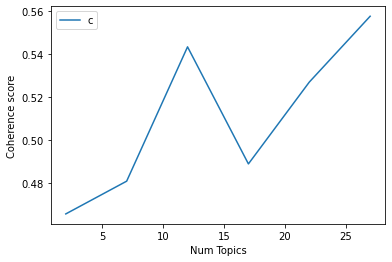

In [98]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_score5)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [99]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_score5):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 12

index: 0 | Num Topics = 2  has Coherence Value of 0.4657
index: 1 | Num Topics = 7  has Coherence Value of 0.481
index: 2 | Num Topics = 12  has Coherence Value of 0.5435
index: 3 | Num Topics = 17  has Coherence Value of 0.489
index: 4 | Num Topics = 22  has Coherence Value of 0.5271
index: 5 | Num Topics = 27  has Coherence Value of 0.5578


In [177]:
# Select optimal number of topics
optimal_model_sg_score5 = model_list_sg_score5[2]

In [178]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_score5 = pyLDAvis.gensim_models.prepare(optimal_model_sg_score5, corpus_sg_score5, id2word_sg_score5)

In [179]:
print("pyLDAVis for SG topics for score=5:")
vis_sg_score5

pyLDAVis for SG topics for score=5:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.192650  0.164943       1        1  23.680960
10     0.054122  0.099896       2        1  15.329657
9      0.124601  0.013874       3        1   9.214430
3      0.120209  0.050499       4        1   9.184304
8      0.081406 -0.061528       5        1   8.140955
6     -0.036168 -0.076405       6        1   6.343758
7     -0.090437 -0.116775       7        1   6.308940
1     -0.051114 -0.059365       8        1   5.853321
5     -0.033522 -0.056351       9        1   5.543579
0      0.071804  0.068230      10        1   5.401670
11    -0.015137 -0.025705      11        1   4.081611
4     -0.033113 -0.001314      12        1   0.916814, topic_info=         Term       Freq      Total Category  logprob  loglift
148      mode   8.000000   8.000000  Default    30.00  30.0000
218      dark   7.000000   7.000000  Default    29.00  29.0000
40        app  11.000000  11.000000  Default    28.00  28.0000
30   facebook  10.000000  10.000000  Default    27.00  27.0000
61      apple  10.000000  10.000000  Default    26.00  26.0000
..        ...        ...        ...      ...      ...      ...
110    render   0.015897   1.419976  Topic12    -5.79   0.1998
114      road   0.015897   1.419976  Topic12    -5.79   0.1998
73      early   0.015897   1.419976  Topic12    -5.79   0.1998
58      leave   0.015897   1.997789  Topic12    -5.79  -0.1416
91       left   0.015897   1.419976  Topic12    -5.79   0.1998

[498 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
149       1  0.496601       able
149       7  0.496601       able
184       5  0.839611        abt
60        1  0.269608    account
60        6  0.269608    account
...     ...       ...        ...
175       6  0.861087  yesterday
46        9  0.875427         yr
10        2  0.815023     zawgyi
229       4  0.827117         很棒
269       4  0.827117      视频没的看

[374 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 11, 10, 4, 9, 7, 8, 2, 6, 1, 12, 5])

## LDA Topic Modelling (Rating = 1,2,3)

In [103]:
# By-rating Topic Modelling - rating = 1,2,3
# Convert to list - move to each section
review_sg_score1N2N3 = facebook_ios_sg_review_YearMonth_score1N2N3.review.values.tolist()
review_words_sg_score1N2N3 = list(sent_to_words(review_sg_score1N2N3))
print(review_words_sg_score1N2N3[:1])

[['after', 'updating', 'the', 'app', 'to', 'the', 'latest', 'version', 'the', 'newsfeed', 'cant', 'load', 'at', 'all', 'left', 'with', 'nothing', 'but', 'broken', 'app', 'tried', 'deleting', 'the', 'app', 'and', 'reinstalling', 'it', 'but', 'to', 'no', 'avail']]


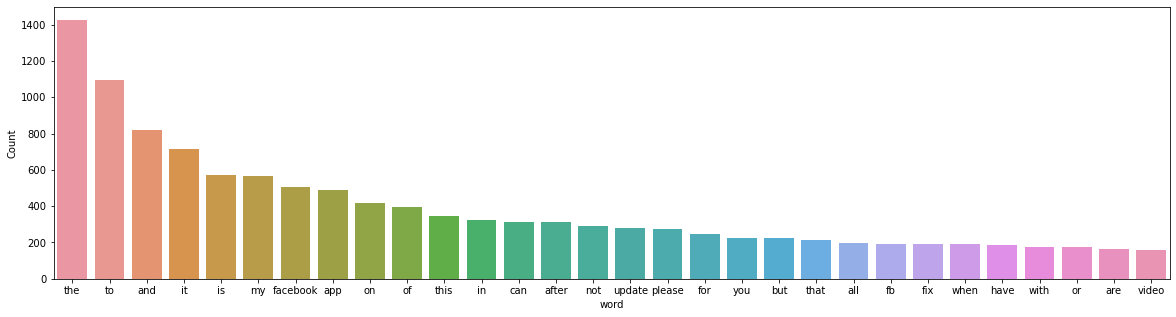

In [104]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_score1N2N3))

In [105]:
# Clean text
review_sg_ready_score1N2N3 = process_words(review_words_sg_score1N2N3)  # processed Text Data! - move to each section

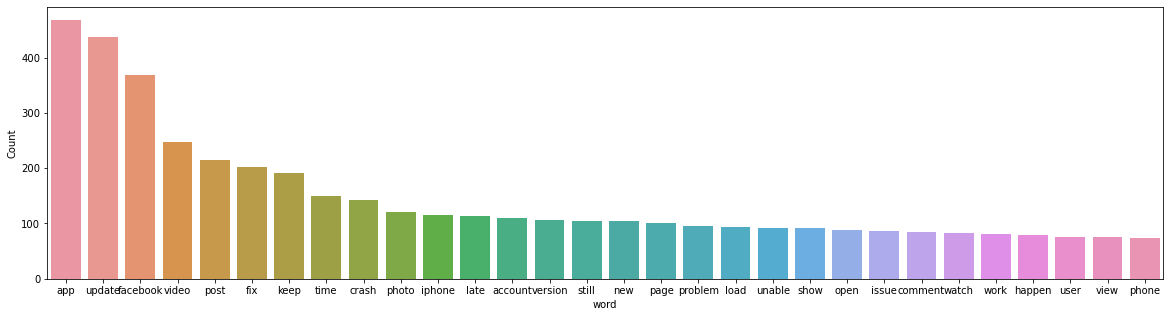

In [106]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_sg_ready_score1N2N3))


In [107]:
# Create Dictionary
id2word_sg_score1N2N3 = corpora.Dictionary(review_sg_ready_score1N2N3)

2021-10-16 18:45:17,606 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 18:45:17,654 [INFO] gensim.corpora.dictionary - built Dictionary(2064 unique tokens: ['app', 'avail', 'broken', 'delete', 'late']...) from 1514 documents (total 14505 corpus positions)
2021-10-16 18:45:17,655 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(2064 unique tokens: ['app', 'avail', 'broken', 'delete', 'late']...) from 1514 documents (total 14505 corpus positions)", 'datetime': '2021-10-16T18:45:17.655888', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [108]:
# Create Corpus: Term Document Frequency
corpus_sg_score1N2N3 = [id2word_sg_score1N2N3.doc2bow(text) for text in review_sg_ready_score1N2N3]

In [109]:
# Training LDA model
model_list_sg_score1N2N3, coherence_values_sg_score1N2N3 = compute_coherence_values(dictionary=id2word_sg_score1N2N3, corpus=corpus_sg_score1N2N3, 
                                                              texts=review_sg_ready_score1N2N3, limit=30, start=2, step=5)


2021-10-16 18:45:17,695 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 18:45:17,697 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 18:45:17,700 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:45:17,702 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 1514 documents, updating model once every 1000 documents, evaluating perplexity every 1514 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:45:17,704 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1000/1514
2021-10-16 18:45:21,127 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:45:21,187 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.022*"update" + 0.021*"facebook" + 0.020*"app" + 0.018*"video" + 0.016*"time" + 0.015*"post" + 0.013*"keep" + 0.012*"page" + 0.011*"fix" + 0

2021-10-16 18:45:32,891 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1514/1514
2021-10-16 18:45:33,354 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:45:33,357 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.034*"facebook" + 0.020*"post" + 0.013*"support" + 0.013*"account" + 0.010*"people" + 0.010*"ad" + 0.009*"stop" + 0.008*"share" + 0.008*"block" + 0.007*"user"
2021-10-16 18:45:33,358 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.044*"app" + 0.036*"update" + 0.020*"video" + 0.019*"fix" + 0.016*"facebook" + 0.015*"keep" + 0.012*"photo" + 0.011*"iphone" + 0.011*"crash" + 0.011*"time"
2021-10-16 18:45:33,359 [INFO] gensim.models.ldamodel - topic diff=0.253080, rho=0.391811
2021-10-16 18:45:33,366 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #1000/1514
2021-10-16 18:45:34,349 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-1

2021-10-16 18:45:42,018 [INFO] gensim.models.ldamodel - topic diff=0.177898, rho=0.294705
2021-10-16 18:45:42,622 [INFO] gensim.models.ldamodel - -6.680 per-word bound, 102.6 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:45:42,623 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #1514/1514
2021-10-16 18:45:43,010 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:45:43,015 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"facebook" + 0.018*"post" + 0.015*"account" + 0.014*"support" + 0.011*"people" + 0.011*"ad" + 0.010*"stop" + 0.009*"share" + 0.009*"block" + 0.007*"user"
2021-10-16 18:45:43,018 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.043*"app" + 0.036*"update" + 0.021*"video" + 0.019*"fix" + 0.016*"facebook" + 0.015*"keep" + 0.012*"photo" + 0.012*"time" + 0.011*"iphone" + 0.011*"crash"
2021-10-16 18:45:43,020 [INFO] gensim.models.ldamodel - topic

2021-10-16 18:45:50,981 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.042*"app" + 0.039*"update" + 0.022*"video" + 0.019*"fix" + 0.016*"keep" + 0.016*"facebook" + 0.012*"crash" + 0.012*"time" + 0.011*"photo" + 0.011*"iphone"
2021-10-16 18:45:50,983 [INFO] gensim.models.ldamodel - topic diff=0.143673, rho=0.246079
2021-10-16 18:45:51,612 [INFO] gensim.models.ldamodel - -6.668 per-word bound, 101.7 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:45:51,613 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #1514/1514
2021-10-16 18:45:51,994 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:45:51,998 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"facebook" + 0.017*"post" + 0.016*"account" + 0.014*"support" + 0.011*"people" + 0.011*"ad" + 0.011*"stop" + 0.009*"block" + 0.008*"share" + 0.008*"user"
2021-10-16 18:45:52,001 [INFO] gensim.models.ldamodel - topi

2021-10-16 18:46:00,011 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:46:00,016 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"facebook" + 0.017*"account" + 0.016*"post" + 0.013*"support" + 0.012*"ad" + 0.011*"stop" + 0.011*"people" + 0.008*"share" + 0.008*"block" + 0.008*"user"
2021-10-16 18:46:00,019 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.042*"app" + 0.038*"update" + 0.022*"video" + 0.019*"fix" + 0.016*"keep" + 0.016*"facebook" + 0.012*"crash" + 0.012*"time" + 0.011*"photo" + 0.011*"post"
2021-10-16 18:46:00,021 [INFO] gensim.models.ldamodel - topic diff=0.123580, rho=0.215595
2021-10-16 18:46:00,633 [INFO] gensim.models.ldamodel - -6.661 per-word bound, 101.2 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:46:00,635 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #1514/1514
2021-10-16 18:46:00,886 [INFO] gensim.models.ldamodel - mergi

2021-10-16 18:46:08,760 [INFO] gensim.models.ldamodel - topic diff=0.110699, rho=0.197975
2021-10-16 18:46:08,767 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1000/1514
2021-10-16 18:46:09,669 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:46:09,672 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"facebook" + 0.017*"account" + 0.015*"post" + 0.013*"support" + 0.012*"ad" + 0.011*"people" + 0.011*"stop" + 0.008*"block" + 0.008*"share" + 0.008*"user"
2021-10-16 18:46:09,675 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.042*"app" + 0.038*"update" + 0.022*"video" + 0.018*"fix" + 0.016*"facebook" + 0.016*"keep" + 0.012*"crash" + 0.012*"time" + 0.012*"post" + 0.011*"photo"
2021-10-16 18:46:09,677 [INFO] gensim.models.ldamodel - topic diff=0.109742, rho=0.194206
2021-10-16 18:46:10,312 [INFO] gensim.models.ldamodel - -6.657 per-word bound, 100.9 perplexity estimate based on a held-out corpus of 5

2021-10-16 18:46:17,597 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.042*"app" + 0.035*"update" + 0.021*"video" + 0.018*"fix" + 0.016*"facebook" + 0.016*"keep" + 0.012*"post" + 0.012*"time" + 0.011*"photo" + 0.011*"crash"
2021-10-16 18:46:17,599 [INFO] gensim.models.ldamodel - topic diff=0.100340, rho=0.181030
2021-10-16 18:46:17,619 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #1000/1514
2021-10-16 18:46:18,478 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:46:18,480 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"facebook" + 0.017*"account" + 0.014*"post" + 0.013*"support" + 0.012*"ad" + 0.011*"people" + 0.011*"stop" + 0.009*"block" + 0.008*"user" + 0.007*"share"
2021-10-16 18:46:18,482 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.041*"app" + 0.037*"update" + 0.022*"video" + 0.018*"fix" + 0.016*"facebook" + 0.016*"keep" + 0.012*"post" + 0.012*"time" + 0.012*"crash" + 0.011*"phot

2021-10-16 18:46:26,536 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:46:26,545 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"facebook" + 0.017*"account" + 0.014*"support" + 0.014*"post" + 0.012*"people" + 0.012*"ad" + 0.011*"stop" + 0.009*"block" + 0.008*"user" + 0.007*"share"
2021-10-16 18:46:26,548 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.042*"app" + 0.035*"update" + 0.021*"video" + 0.018*"fix" + 0.016*"facebook" + 0.016*"keep" + 0.012*"post" + 0.012*"time" + 0.011*"photo" + 0.011*"crash"
2021-10-16 18:46:26,550 [INFO] gensim.models.ldamodel - topic diff=0.092492, rho=0.167803
2021-10-16 18:46:26,559 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #1000/1514
2021-10-16 18:46:27,479 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:46:27,481 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"facebook" + 0.018*"acco

2021-10-16 18:46:34,611 [INFO] gensim.models.ldamodel - topic diff=0.086648, rho=0.157108
2021-10-16 18:46:35,207 [INFO] gensim.models.ldamodel - -6.651 per-word bound, 100.5 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:46:35,208 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #1514/1514
2021-10-16 18:46:35,624 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:46:35,627 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"facebook" + 0.017*"account" + 0.014*"support" + 0.014*"post" + 0.012*"people" + 0.012*"ad" + 0.011*"stop" + 0.009*"block" + 0.008*"user" + 0.007*"advertisement"
2021-10-16 18:46:35,628 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.042*"app" + 0.035*"update" + 0.021*"video" + 0.018*"fix" + 0.016*"facebook" + 0.016*"keep" + 0.012*"post" + 0.012*"time" + 0.011*"photo" + 0.011*"crash"
2021-10-16 18:46:35,629 [INFO] gensim.models.ldamodel 

2021-10-16 18:46:43,495 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.041*"app" + 0.037*"update" + 0.022*"video" + 0.018*"fix" + 0.016*"facebook" + 0.016*"keep" + 0.013*"post" + 0.012*"time" + 0.012*"crash" + 0.011*"photo"
2021-10-16 18:46:43,497 [INFO] gensim.models.ldamodel - topic diff=0.081331, rho=0.148227
2021-10-16 18:46:44,125 [INFO] gensim.models.ldamodel - -6.649 per-word bound, 100.4 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:46:44,127 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1514/1514
2021-10-16 18:46:44,515 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:46:44,522 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"facebook" + 0.017*"account" + 0.014*"support" + 0.013*"post" + 0.012*"people" + 0.012*"ad" + 0.011*"stop" + 0.009*"block" + 0.008*"user" + 0.007*"advertisement"
2021-10-16 18:46:44,526 [INFO] gensim.models.ldamodel 

2021-10-16 18:46:52,253 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:46:52,256 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.035*"facebook" + 0.018*"account" + 0.014*"support" + 0.013*"post" + 0.012*"ad" + 0.012*"people" + 0.012*"stop" + 0.009*"block" + 0.008*"user" + 0.007*"advertisement"
2021-10-16 18:46:52,258 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.041*"app" + 0.037*"update" + 0.021*"video" + 0.018*"fix" + 0.016*"facebook" + 0.016*"keep" + 0.013*"post" + 0.012*"time" + 0.012*"crash" + 0.011*"photo"
2021-10-16 18:46:52,260 [INFO] gensim.models.ldamodel - topic diff=0.076899, rho=0.140700
2021-10-16 18:46:52,801 [INFO] gensim.models.ldamodel - -6.647 per-word bound, 100.2 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:46:52,808 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #1514/1514
2021-10-16 18:46:53,128 [INFO] gensim.models.ldamodel

2021-10-16 18:47:06,208 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.044*"facebook" + 0.035*"page" + 0.017*"support" + 0.014*"update" + 0.013*"app" + 0.012*"fix" + 0.012*"post" + 0.012*"help" + 0.011*"time" + 0.010*"people"
2021-10-16 18:47:06,216 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.020*"video" + 0.020*"post" + 0.017*"share" + 0.017*"app" + 0.014*"facebook" + 0.014*"back" + 0.013*"update" + 0.011*"time" + 0.010*"bad" + 0.010*"user"
2021-10-16 18:47:06,221 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.064*"video" + 0.027*"play" + 0.020*"photo" + 0.017*"update" + 0.015*"watch" + 0.012*"sound" + 0.012*"app" + 0.011*"change" + 0.010*"stop" + 0.009*"facebook"
2021-10-16 18:47:06,231 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.046*"app" + 0.034*"update" + 0.022*"comment" + 0.014*"always" + 0.014*"keep" + 0.013*"show" + 0.013*"notification" + 0.011*"post" + 0.010*"click" + 0.010*"crash"
2021-10-16 18:47:06,233 [INFO] gensim.models.ldamodel - topic diff=0.4

2021-10-16 18:47:11,990 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.022*"share" + 0.018*"facebook" + 0.017*"humanity" + 0.015*"post" + 0.014*"block" + 0.013*"back" + 0.013*"bad" + 0.012*"people" + 0.011*"user" + 0.010*"world"
2021-10-16 18:47:11,992 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.057*"facebook" + 0.034*"support" + 0.029*"page" + 0.017*"post" + 0.015*"stand" + 0.014*"people" + 0.011*"delete" + 0.010*"condemn" + 0.010*"day" + 0.009*"help"
2021-10-16 18:47:11,994 [INFO] gensim.models.ldamodel - topic diff=0.253700, rho=0.425860
2021-10-16 18:47:11,997 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #1000/1514
2021-10-16 18:47:13,117 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:47:13,121 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.073*"update" + 0.072*"app" + 0.035*"fix" + 0.034*"crash" + 0.027*"late" + 0.027*"keep" + 0.024*"facebook" + 0.019*"issue" + 0.019*"iphone" + 0.0

2021-10-16 18:47:17,255 [INFO] gensim.models.ldamodel - topic diff=0.179391, rho=0.342715
2021-10-16 18:47:17,876 [INFO] gensim.models.ldamodel - -7.045 per-word bound, 132.0 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:47:17,878 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #1514/1514
2021-10-16 18:47:18,320 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:47:18,325 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.024*"share" + 0.018*"facebook" + 0.018*"humanity" + 0.014*"back" + 0.014*"block" + 0.014*"people" + 0.014*"post" + 0.013*"bad" + 0.013*"user" + 0.010*"give"
2021-10-16 18:47:18,328 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.030*"comment" + 0.027*"app" + 0.024*"notification" + 0.017*"ad" + 0.016*"update" + 0.015*"always" + 0.015*"much" + 0.013*"screen" + 0.012*"post" + 0.011*"click"
2021-10-16 18:47:18,330 [INFO] gensim.models.ldamodel - 

2021-10-16 18:47:24,070 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.048*"account" + 0.042*"facebook" + 0.016*"keep" + 0.014*"advertisement" + 0.012*"biased" + 0.012*"delete" + 0.010*"password" + 0.010*"login" + 0.010*"post" + 0.009*"still"
2021-10-16 18:47:24,075 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.036*"comment" + 0.028*"notification" + 0.027*"app" + 0.017*"update" + 0.016*"much" + 0.016*"always" + 0.015*"screen" + 0.014*"ad" + 0.011*"show" + 0.011*"post"
2021-10-16 18:47:24,077 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.058*"facebook" + 0.043*"page" + 0.033*"support" + 0.016*"post" + 0.012*"stand" + 0.012*"people" + 0.010*"day" + 0.010*"help" + 0.009*"delete" + 0.009*"report"
2021-10-16 18:47:24,080 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.026*"share" + 0.017*"facebook" + 0.016*"back" + 0.014*"post" + 0.014*"humanity" + 0.014*"user" + 0.013*"bad" + 0.013*"people" + 0.011*"button" + 0.011*"block"
2021-10-16 18:47:24,082 [INFO] gensim.models.l

2021-10-16 18:47:29,499 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.047*"account" + 0.038*"facebook" + 0.016*"advertisement" + 0.015*"keep" + 0.015*"biased" + 0.012*"delete" + 0.010*"fake" + 0.010*"post" + 0.010*"stop" + 0.010*"scam"
2021-10-16 18:47:29,502 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.049*"photo" + 0.043*"post" + 0.030*"view" + 0.026*"app" + 0.024*"feed" + 0.021*"album" + 0.018*"update" + 0.016*"feature" + 0.016*"click" + 0.015*"speech"
2021-10-16 18:47:29,504 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.033*"comment" + 0.027*"notification" + 0.026*"app" + 0.019*"ad" + 0.017*"much" + 0.014*"update" + 0.013*"screen" + 0.013*"always" + 0.011*"show" + 0.011*"full"
2021-10-16 18:47:29,505 [INFO] gensim.models.ldamodel - topic diff=0.122046, rho=0.272025
2021-10-16 18:47:29,508 [INFO] gensim.models.ldamodel - PROGRESS: pass 12, at document #1000/1514
2021-10-16 18:47:30,274 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a mode

2021-10-16 18:47:34,403 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.050*"photo" + 0.044*"post" + 0.030*"view" + 0.024*"feed" + 0.024*"app" + 0.023*"album" + 0.021*"update" + 0.018*"click" + 0.017*"feature" + 0.015*"news"
2021-10-16 18:47:34,405 [INFO] gensim.models.ldamodel - topic diff=0.110112, rho=0.246079
2021-10-16 18:47:34,997 [INFO] gensim.models.ldamodel - -6.975 per-word bound, 125.8 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:47:35,004 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #1514/1514
2021-10-16 18:47:35,382 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:47:35,386 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.049*"account" + 0.038*"facebook" + 0.016*"advertisement" + 0.015*"biased" + 0.015*"keep" + 0.013*"delete" + 0.011*"fake" + 0.010*"post" + 0.010*"stop" + 0.010*"scam"
2021-10-16 18:47:35,390 [INFO] gensim.models.ldamodel 

2021-10-16 18:47:39,273 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #1000/1514
2021-10-16 18:47:40,250 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:47:40,253 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.026*"share" + 0.017*"facebook" + 0.016*"back" + 0.015*"user" + 0.015*"humanity" + 0.015*"people" + 0.015*"post" + 0.013*"bad" + 0.013*"give" + 0.012*"block"
2021-10-16 18:47:40,254 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.051*"account" + 0.040*"facebook" + 0.016*"keep" + 0.015*"advertisement" + 0.013*"delete" + 0.012*"biased" + 0.011*"password" + 0.009*"post" + 0.009*"stop" + 0.009*"fake"
2021-10-16 18:47:40,257 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.123*"video" + 0.042*"watch" + 0.033*"play" + 0.016*"sound" + 0.014*"ad" + 0.013*"change" + 0.012*"annoying" + 0.011*"live" + 0.010*"turn" + 0.010*"stop"
2021-10-16 18:47:40,265 [INFO] gensim.models.ldamodel - topic #0 (0.143

2021-10-16 18:47:45,246 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.075*"app" + 0.069*"update" + 0.036*"fix" + 0.026*"facebook" + 0.025*"crash" + 0.025*"keep" + 0.023*"late" + 0.020*"iphone" + 0.019*"time" + 0.018*"version"
2021-10-16 18:47:45,248 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.065*"facebook" + 0.038*"support" + 0.038*"page" + 0.017*"post" + 0.015*"stand" + 0.012*"day" + 0.011*"people" + 0.011*"condemn" + 0.011*"account" + 0.009*"reporting"
2021-10-16 18:47:45,250 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.023*"share" + 0.018*"facebook" + 0.018*"humanity" + 0.016*"people" + 0.016*"user" + 0.014*"post" + 0.014*"bad" + 0.014*"back" + 0.014*"give" + 0.013*"block"
2021-10-16 18:47:45,252 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.113*"video" + 0.039*"watch" + 0.029*"play" + 0.014*"ad" + 0.014*"change" + 0.014*"sound" + 0.012*"annoying" + 0.011*"live" + 0.009*"turn" + 0.009*"stop"
2021-10-16 18:47:45,253 [INFO] gensim.models.ldamodel - topic di

2021-10-16 18:47:50,970 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.049*"photo" + 0.045*"post" + 0.030*"view" + 0.024*"feed" + 0.023*"app" + 0.023*"album" + 0.021*"update" + 0.019*"feature" + 0.019*"click" + 0.014*"news"
2021-10-16 18:47:50,973 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.063*"facebook" + 0.045*"page" + 0.035*"support" + 0.017*"post" + 0.013*"stand" + 0.012*"day" + 0.011*"people" + 0.010*"account" + 0.010*"help" + 0.010*"condemn"
2021-10-16 18:47:50,976 [INFO] gensim.models.ldamodel - topic diff=0.086287, rho=0.201973
2021-10-16 18:47:51,864 [INFO] gensim.models.ldamodel - -6.954 per-word bound, 124.0 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:47:51,877 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #1514/1514
2021-10-16 18:47:52,492 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:47:52,497 [INFO] gensim.models.ldamodel - top

2021-10-16 18:47:56,359 [INFO] gensim.models.ldamodel - topic diff=0.081427, rho=0.194206
2021-10-16 18:47:56,366 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #1000/1514
2021-10-16 18:47:57,302 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:47:57,307 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.051*"account" + 0.039*"facebook" + 0.016*"advertisement" + 0.015*"keep" + 0.014*"delete" + 0.013*"biased" + 0.011*"password" + 0.009*"fake" + 0.009*"post" + 0.009*"stop"
2021-10-16 18:47:57,309 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.075*"app" + 0.073*"update" + 0.037*"fix" + 0.028*"crash" + 0.027*"keep" + 0.026*"facebook" + 0.024*"late" + 0.020*"time" + 0.020*"iphone" + 0.018*"version"
2021-10-16 18:47:57,311 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.036*"comment" + 0.030*"notification" + 0.027*"app" + 0.019*"ad" + 0.018*"much" + 0.015*"screen" + 0.012*"update" + 0.012*"always" + 0.0

2021-10-16 18:48:02,261 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.034*"comment" + 0.028*"notification" + 0.027*"app" + 0.021*"ad" + 0.018*"much" + 0.013*"screen" + 0.012*"full" + 0.011*"always" + 0.011*"update" + 0.011*"show"
2021-10-16 18:48:02,262 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.048*"photo" + 0.045*"post" + 0.029*"view" + 0.025*"app" + 0.024*"feed" + 0.021*"album" + 0.019*"update" + 0.019*"feature" + 0.018*"click" + 0.014*"news"
2021-10-16 18:48:02,263 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.021*"share" + 0.018*"facebook" + 0.018*"humanity" + 0.017*"people" + 0.016*"user" + 0.014*"bad" + 0.014*"back" + 0.013*"give" + 0.013*"post" + 0.013*"block"
2021-10-16 18:48:02,265 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.075*"app" + 0.069*"update" + 0.036*"fix" + 0.026*"facebook" + 0.026*"crash" + 0.025*"keep" + 0.023*"late" + 0.020*"time" + 0.020*"iphone" + 0.018*"version"
2021-10-16 18:48:02,266 [INFO] gensim.models.ldamodel - topic #2 (0.14

2021-10-16 18:48:08,165 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.122*"video" + 0.042*"watch" + 0.033*"play" + 0.015*"sound" + 0.014*"change" + 0.014*"annoying" + 0.013*"ad" + 0.012*"live" + 0.010*"stop" + 0.009*"turn"
2021-10-16 18:48:08,172 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.051*"account" + 0.039*"facebook" + 0.015*"advertisement" + 0.015*"keep" + 0.014*"delete" + 0.013*"biased" + 0.011*"password" + 0.009*"fake" + 0.009*"stop" + 0.009*"post"
2021-10-16 18:48:08,177 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.037*"comment" + 0.030*"notification" + 0.027*"app" + 0.019*"ad" + 0.018*"much" + 0.014*"screen" + 0.012*"always" + 0.012*"update" + 0.012*"full" + 0.011*"show"
2021-10-16 18:48:08,182 [INFO] gensim.models.ldamodel - topic diff=0.073359, rho=0.175374
2021-10-16 18:48:09,067 [INFO] gensim.models.ldamodel - -6.942 per-word bound, 123.0 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:48:09,120 [INFO] gen

2021-10-16 18:48:15,287 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.048*"photo" + 0.046*"post" + 0.029*"view" + 0.025*"app" + 0.024*"feed" + 0.021*"album" + 0.019*"update" + 0.019*"feature" + 0.018*"click" + 0.014*"news"
2021-10-16 18:48:15,288 [INFO] gensim.models.ldamodel - topic diff=0.070279, rho=0.170217
2021-10-16 18:48:15,289 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #1000/1514
2021-10-16 18:48:16,107 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:48:16,111 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.052*"account" + 0.039*"facebook" + 0.015*"keep" + 0.015*"advertisement" + 0.014*"delete" + 0.013*"biased" + 0.011*"password" + 0.010*"fake" + 0.009*"stop" + 0.009*"post"
2021-10-16 18:48:16,113 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.122*"video" + 0.041*"watch" + 0.032*"play" + 0.015*"sound" + 0.014*"change" + 0.014*"annoying" + 0.013*"ad" + 0.012*"live" + 0.010*"stop" 

2021-10-16 18:48:20,644 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #1514/1514
2021-10-16 18:48:21,142 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:48:21,145 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.115*"video" + 0.039*"watch" + 0.029*"play" + 0.014*"change" + 0.014*"sound" + 0.013*"ad" + 0.013*"annoying" + 0.011*"live" + 0.010*"stop" + 0.009*"turn"
2021-10-16 18:48:21,146 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.048*"photo" + 0.046*"post" + 0.029*"view" + 0.025*"app" + 0.024*"feed" + 0.021*"album" + 0.019*"update" + 0.019*"feature" + 0.018*"click" + 0.014*"news"
2021-10-16 18:48:21,148 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.035*"comment" + 0.029*"notification" + 0.027*"app" + 0.022*"ad" + 0.018*"much" + 0.013*"screen" + 0.012*"full" + 0.011*"always" + 0.011*"show" + 0.011*"update"
2021-10-16 18:48:21,149 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.051*"accou

2021-10-16 18:48:25,723 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.048*"photo" + 0.047*"post" + 0.029*"view" + 0.024*"app" + 0.024*"feed" + 0.022*"album" + 0.021*"update" + 0.020*"feature" + 0.018*"click" + 0.014*"news"
2021-10-16 18:48:25,725 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.021*"share" + 0.017*"facebook" + 0.016*"user" + 0.016*"people" + 0.016*"humanity" + 0.015*"back" + 0.015*"bad" + 0.013*"post" + 0.013*"give" + 0.012*"block"
2021-10-16 18:48:25,728 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.052*"account" + 0.039*"facebook" + 0.015*"keep" + 0.015*"delete" + 0.015*"advertisement" + 0.013*"biased" + 0.011*"password" + 0.010*"fake" + 0.009*"stop" + 0.009*"post"
2021-10-16 18:48:25,730 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.037*"comment" + 0.030*"notification" + 0.027*"app" + 0.019*"ad" + 0.018*"much" + 0.014*"screen" + 0.012*"always" + 0.012*"full" + 0.011*"update" + 0.011*"show"
2021-10-16 18:48:25,734 [INFO] gensim.models.ldamodel - 

2021-10-16 18:48:30,750 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.020*"share" + 0.018*"facebook" + 0.017*"humanity" + 0.017*"people" + 0.016*"user" + 0.015*"bad" + 0.014*"back" + 0.013*"block" + 0.013*"post" + 0.013*"give"
2021-10-16 18:48:30,751 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.048*"photo" + 0.047*"post" + 0.029*"view" + 0.025*"app" + 0.024*"feed" + 0.021*"album" + 0.019*"update" + 0.019*"feature" + 0.018*"click" + 0.014*"news"
2021-10-16 18:48:30,752 [INFO] gensim.models.ldamodel - topic diff=0.063033, rho=0.153368
2021-10-16 18:48:30,755 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #1000/1514
2021-10-16 18:48:31,612 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:48:31,620 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.065*"facebook" + 0.045*"page" + 0.037*"support" + 0.016*"post" + 0.013*"stand" + 0.012*"day" + 0.011*"account" + 0.010*"name" + 0.010*"people" + 0.010*

2021-10-16 18:48:35,454 [INFO] gensim.models.ldamodel - topic diff=0.060932, rho=0.148227
2021-10-16 18:48:36,045 [INFO] gensim.models.ldamodel - -6.928 per-word bound, 121.7 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:48:36,048 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1514/1514
2021-10-16 18:48:36,459 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:48:36,465 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.066*"facebook" + 0.040*"page" + 0.039*"support" + 0.017*"post" + 0.015*"stand" + 0.013*"day" + 0.011*"account" + 0.011*"condemn" + 0.010*"people" + 0.010*"name"
2021-10-16 18:48:36,468 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.115*"video" + 0.039*"watch" + 0.030*"play" + 0.014*"change" + 0.014*"sound" + 0.013*"ad" + 0.013*"annoying" + 0.011*"live" + 0.010*"stop" + 0.009*"turn"
2021-10-16 18:48:36,471 [INFO] gensim.models.ldamodel - top

2021-10-16 18:48:41,178 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.065*"facebook" + 0.045*"page" + 0.037*"support" + 0.016*"post" + 0.013*"stand" + 0.012*"day" + 0.011*"account" + 0.010*"name" + 0.010*"people" + 0.010*"condemn"
2021-10-16 18:48:41,179 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.122*"video" + 0.041*"watch" + 0.032*"play" + 0.015*"sound" + 0.014*"change" + 0.014*"annoying" + 0.013*"ad" + 0.012*"live" + 0.010*"stop" + 0.009*"turn"
2021-10-16 18:48:41,183 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.049*"post" + 0.048*"photo" + 0.029*"view" + 0.024*"app" + 0.024*"feed" + 0.022*"album" + 0.021*"update" + 0.020*"feature" + 0.018*"click" + 0.014*"news"
2021-10-16 18:48:41,187 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.020*"share" + 0.017*"facebook" + 0.016*"people" + 0.016*"user" + 0.016*"humanity" + 0.015*"back" + 0.015*"bad" + 0.013*"post" + 0.013*"give" + 0.012*"block"
2021-10-16 18:48:41,189 [INFO] gensim.models.ldamodel - topic #2 (0.143)

2021-10-16 18:48:46,029 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.051*"account" + 0.037*"facebook" + 0.015*"delete" + 0.015*"advertisement" + 0.015*"biased" + 0.014*"keep" + 0.011*"fake" + 0.010*"password" + 0.010*"post" + 0.010*"scam"
2021-10-16 18:48:46,030 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.115*"video" + 0.039*"watch" + 0.030*"play" + 0.014*"change" + 0.014*"sound" + 0.013*"ad" + 0.013*"annoying" + 0.012*"live" + 0.010*"stop" + 0.009*"turn"
2021-10-16 18:48:46,032 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.035*"comment" + 0.029*"notification" + 0.027*"app" + 0.021*"ad" + 0.018*"much" + 0.013*"screen" + 0.012*"full" + 0.011*"always" + 0.011*"show" + 0.011*"user"
2021-10-16 18:48:46,034 [INFO] gensim.models.ldamodel - topic diff=0.057214, rho=0.140700
2021-10-16 18:48:46,036 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #1000/1514
2021-10-16 18:48:46,896 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a mode

2021-10-16 18:48:59,780 [INFO] gensim.models.ldamodel - topic diff=0.610582, rho=0.707107
2021-10-16 18:48:59,783 [INFO] gensim.models.ldamodel - PROGRESS: pass 1, at document #1000/1514
2021-10-16 18:49:01,006 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:49:01,010 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.043*"live" + 0.041*"comment" + 0.027*"photo" + 0.026*"update" + 0.022*"ipad" + 0.021*"album" + 0.018*"facebook" + 0.017*"speech" + 0.014*"video" + 0.014*"version"
2021-10-16 18:49:01,012 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.035*"video" + 0.023*"post" + 0.022*"back" + 0.019*"share" + 0.014*"facebook" + 0.013*"block" + 0.013*"show" + 0.011*"watch" + 0.011*"update" + 0.010*"group"
2021-10-16 18:49:01,014 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.054*"video" + 0.037*"play" + 0.019*"update" + 0.019*"sound" + 0.017*"unable" + 0.016*"app" + 0.014*"turn" + 0.014*"time" + 0.013*"always" + 0.

2021-10-16 18:49:06,819 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.056*"video" + 0.038*"feed" + 0.036*"post" + 0.028*"watch" + 0.024*"ad" + 0.024*"photo" + 0.023*"app" + 0.018*"view" + 0.017*"annoying" + 0.017*"ban"
2021-10-16 18:49:06,822 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.086*"facebook" + 0.050*"support" + 0.028*"page" + 0.019*"post" + 0.017*"biased" + 0.015*"condemn" + 0.014*"share" + 0.013*"block" + 0.013*"write" + 0.013*"day"
2021-10-16 18:49:06,824 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.058*"app" + 0.057*"facebook" + 0.037*"delete" + 0.028*"account" + 0.018*"keep" + 0.016*"humanity" + 0.014*"time" + 0.014*"change" + 0.012*"behaviour" + 0.012*"still"
2021-10-16 18:49:06,826 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.075*"update" + 0.071*"app" + 0.046*"fix" + 0.041*"crash" + 0.035*"mode" + 0.032*"dark" + 0.032*"late" + 0.029*"issue" + 0.027*"keep" + 0.025*"facebook"
2021-10-16 18:49:06,827 [INFO] gensim.models.ldamodel - topic #6 (0.

2021-10-16 18:49:12,100 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.068*"video" + 0.044*"feed" + 0.038*"watch" + 0.036*"post" + 0.023*"screen" + 0.021*"ad" + 0.019*"annoying" + 0.019*"app" + 0.019*"view" + 0.018*"news"
2021-10-16 18:49:12,102 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.031*"update" + 0.027*"app" + 0.025*"much" + 0.015*"new" + 0.014*"ad" + 0.013*"advertisement" + 0.012*"time" + 0.012*"post" + 0.010*"interface" + 0.010*"keep"
2021-10-16 18:49:12,105 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.097*"update" + 0.082*"app" + 0.049*"fix" + 0.047*"crash" + 0.035*"keep" + 0.034*"late" + 0.025*"facebook" + 0.024*"issue" + 0.023*"mode" + 0.022*"iphone"
2021-10-16 18:49:12,108 [INFO] gensim.models.ldamodel - topic diff=0.141082, rho=0.342715
2021-10-16 18:49:12,749 [INFO] gensim.models.ldamodel - -7.189 per-word bound, 146.0 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:49:12,751 [INFO] gensim.models.ldamodel 

2021-10-16 18:49:17,100 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.096*"video" + 0.046*"play" + 0.032*"always" + 0.024*"sound" + 0.019*"update" + 0.018*"turn" + 0.014*"translation" + 0.014*"work" + 0.014*"enter" + 0.013*"error"
2021-10-16 18:49:17,106 [INFO] gensim.models.ldamodel - topic diff=0.105141, rho=0.308401
2021-10-16 18:49:17,111 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #1000/1514
2021-10-16 18:49:18,032 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:49:18,040 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.087*"facebook" + 0.044*"support" + 0.036*"page" + 0.020*"post" + 0.016*"share" + 0.015*"remove" + 0.014*"day" + 0.014*"add" + 0.013*"biased" + 0.013*"account"
2021-10-16 18:49:18,045 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.043*"post" + 0.038*"picture" + 0.026*"friend" + 0.025*"save" + 0.016*"country" + 0.015*"browse" + 0.015*"totally" + 0.014*"section" + 0.014*"

2021-10-16 18:49:22,631 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #1514/1514
2021-10-16 18:49:22,951 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:49:22,956 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.027*"much" + 0.024*"advertisement" + 0.022*"app" + 0.021*"ad" + 0.016*"update" + 0.014*"post" + 0.013*"time" + 0.013*"new" + 0.011*"give" + 0.009*"side"
2021-10-16 18:49:22,959 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.035*"stop" + 0.023*"app" + 0.021*"story" + 0.019*"account" + 0.017*"facebook" + 0.016*"login" + 0.015*"problem" + 0.015*"share" + 0.014*"real" + 0.014*"privacy"
2021-10-16 18:49:22,961 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.023*"version" + 0.020*"keep" + 0.020*"new" + 0.019*"look" + 0.018*"account" + 0.017*"fix" + 0.017*"still" + 0.016*"show" + 0.015*"newsfeed" + 0.015*"time"
2021-10-16 18:49:22,963 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.107*"vi

2021-10-16 18:49:27,561 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.022*"keep" + 0.021*"version" + 0.020*"look" + 0.019*"account" + 0.019*"newsfeed" + 0.018*"fix" + 0.017*"new" + 0.016*"show" + 0.016*"time" + 0.016*"error"
2021-10-16 18:49:27,568 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.122*"video" + 0.054*"play" + 0.036*"always" + 0.027*"sound" + 0.021*"watch" + 0.019*"turn" + 0.018*"update" + 0.013*"work" + 0.012*"swipe" + 0.012*"loading"
2021-10-16 18:49:27,571 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.053*"notification" + 0.041*"photo" + 0.038*"click" + 0.035*"bad" + 0.027*"humanity" + 0.018*"post" + 0.018*"notice" + 0.018*"update" + 0.017*"appear" + 0.016*"show"
2021-10-16 18:49:27,581 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.054*"comment" + 0.051*"photo" + 0.048*"live" + 0.046*"album" + 0.037*"view" + 0.030*"ipad" + 0.020*"speech" + 0.014*"unable" + 0.013*"stream" + 0.013*"happen"
2021-10-16 18:49:27,585 [INFO] gensim.models.ldamodel - topi

2021-10-16 18:49:32,228 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.021*"keep" + 0.019*"look" + 0.018*"account" + 0.018*"version" + 0.018*"new" + 0.018*"newsfeed" + 0.017*"fix" + 0.017*"still" + 0.017*"show" + 0.016*"error"
2021-10-16 18:49:32,230 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.058*"video" + 0.046*"feed" + 0.036*"post" + 0.033*"watch" + 0.024*"app" + 0.023*"news" + 0.023*"screen" + 0.022*"ad" + 0.019*"annoying" + 0.016*"view"
2021-10-16 18:49:32,233 [INFO] gensim.models.ldamodel - topic diff=0.070513, rho=0.232407
2021-10-16 18:49:32,235 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #1000/1514
2021-10-16 18:49:33,116 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:49:33,122 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.054*"comment" + 0.051*"photo" + 0.049*"live" + 0.046*"album" + 0.038*"view" + 0.030*"ipad" + 0.021*"speech" + 0.014*"unable" + 0.013*"stream" + 0.013*"hap

2021-10-16 18:49:36,912 [INFO] gensim.models.ldamodel - topic diff=0.065660, rho=0.215595
2021-10-16 18:49:37,526 [INFO] gensim.models.ldamodel - -7.080 per-word bound, 135.3 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:49:37,527 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #1514/1514
2021-10-16 18:49:37,909 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:49:37,915 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.043*"post" + 0.037*"picture" + 0.028*"save" + 0.024*"friend" + 0.019*"country" + 0.018*"censoring" + 0.015*"section" + 0.015*"newsfee" + 0.015*"free" + 0.015*"profile"
2021-10-16 18:49:37,916 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.055*"notification" + 0.040*"bad" + 0.038*"photo" + 0.036*"click" + 0.036*"humanity" + 0.021*"notice" + 0.019*"sometime" + 0.019*"appear" + 0.017*"post" + 0.017*"update"
2021-10-16 18:49:37,918 [INFO] gens

2021-10-16 18:49:42,552 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.048*"post" + 0.039*"picture" + 0.031*"friend" + 0.027*"save" + 0.017*"country" + 0.017*"profile" + 0.015*"browse" + 0.015*"totally" + 0.014*"censoring" + 0.014*"section"
2021-10-16 18:49:42,554 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.019*"user" + 0.017*"people" + 0.016*"allow" + 0.016*"post" + 0.016*"block" + 0.015*"content" + 0.015*"share" + 0.015*"back" + 0.014*"group" + 0.012*"show"
2021-10-16 18:49:42,556 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.035*"stop" + 0.025*"story" + 0.020*"account" + 0.018*"app" + 0.017*"share" + 0.017*"facebook" + 0.016*"option" + 0.015*"login" + 0.015*"link" + 0.014*"create"
2021-10-16 18:49:42,559 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.054*"comment" + 0.053*"photo" + 0.050*"live" + 0.047*"album" + 0.038*"view" + 0.030*"ipad" + 0.021*"speech" + 0.014*"unable" + 0.013*"stream" + 0.013*"happen"
2021-10-16 18:49:42,560 [INFO] gensim.models.ldamode

2021-10-16 18:49:47,422 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.050*"photo" + 0.049*"live" + 0.048*"comment" + 0.042*"album" + 0.037*"view" + 0.027*"ipad" + 0.026*"speech" + 0.014*"stream" + 0.014*"happen" + 0.013*"tap"
2021-10-16 18:49:47,425 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.029*"much" + 0.028*"advertisement" + 0.026*"ad" + 0.019*"app" + 0.015*"time" + 0.012*"new" + 0.011*"post" + 0.011*"update" + 0.011*"back" + 0.010*"give"
2021-10-16 18:49:47,428 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.137*"video" + 0.048*"play" + 0.035*"watch" + 0.032*"always" + 0.024*"sound" + 0.017*"turn" + 0.014*"swipe" + 0.013*"work" + 0.012*"translation" + 0.012*"scroll"
2021-10-16 18:49:47,430 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.095*"update" + 0.088*"app" + 0.047*"fix" + 0.034*"crash" + 0.032*"keep" + 0.028*"late" + 0.027*"facebook" + 0.023*"issue" + 0.023*"iphone" + 0.022*"mode"
2021-10-16 18:49:47,432 [INFO] gensim.models.ldamodel - topic diff=0.055

2021-10-16 18:49:52,538 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.036*"stop" + 0.025*"story" + 0.020*"account" + 0.018*"app" + 0.017*"share" + 0.017*"facebook" + 0.016*"option" + 0.016*"login" + 0.016*"link" + 0.015*"create"
2021-10-16 18:49:52,542 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.049*"video" + 0.048*"feed" + 0.037*"post" + 0.029*"screen" + 0.026*"watch" + 0.025*"news" + 0.024*"app" + 0.021*"ad" + 0.020*"annoying" + 0.015*"view"
2021-10-16 18:49:52,544 [INFO] gensim.models.ldamodel - topic diff=0.053092, rho=0.184071
2021-10-16 18:49:53,138 [INFO] gensim.models.ldamodel - -7.066 per-word bound, 134.0 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:49:53,139 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #1514/1514
2021-10-16 18:49:53,594 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:49:53,607 [INFO] gensim.models.ldamodel - topic #

2021-10-16 18:49:57,433 [INFO] gensim.models.ldamodel - topic diff=0.050116, rho=0.178135
2021-10-16 18:49:57,435 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #1000/1514
2021-10-16 18:49:58,361 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:49:58,380 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.021*"keep" + 0.020*"look" + 0.019*"account" + 0.019*"fix" + 0.017*"still" + 0.017*"new" + 0.017*"error" + 0.017*"newsfeed" + 0.016*"time" + 0.016*"show"
2021-10-16 18:49:58,382 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.036*"stop" + 0.025*"story" + 0.020*"account" + 0.018*"app" + 0.017*"share" + 0.017*"facebook" + 0.017*"option" + 0.016*"link" + 0.016*"login" + 0.015*"create"
2021-10-16 18:49:58,384 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.101*"update" + 0.089*"app" + 0.047*"fix" + 0.037*"crash" + 0.035*"keep" + 0.029*"late" + 0.027*"facebook" + 0.023*"iphone" + 0.022*"issue" + 0.021*"l

2021-10-16 18:50:03,197 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.020*"keep" + 0.019*"look" + 0.019*"error" + 0.019*"fix" + 0.019*"account" + 0.018*"still" + 0.018*"new" + 0.016*"newsfeed" + 0.016*"show" + 0.015*"time"
2021-10-16 18:50:03,199 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.039*"stop" + 0.023*"story" + 0.021*"account" + 0.017*"app" + 0.017*"facebook" + 0.017*"login" + 0.017*"share" + 0.016*"option" + 0.015*"link" + 0.015*"real"
2021-10-16 18:50:03,201 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.141*"video" + 0.048*"play" + 0.037*"watch" + 0.032*"always" + 0.024*"sound" + 0.017*"turn" + 0.014*"scroll" + 0.014*"swipe" + 0.013*"work" + 0.012*"translation"
2021-10-16 18:50:03,205 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.030*"advertisement" + 0.029*"much" + 0.026*"ad" + 0.019*"app" + 0.015*"time" + 0.012*"back" + 0.011*"new" + 0.010*"update" + 0.010*"way" + 0.010*"give"
2021-10-16 18:50:03,209 [INFO] gensim.models.ldamodel - topic #4 (0.083):

2021-10-16 18:50:08,550 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.101*"update" + 0.089*"app" + 0.047*"fix" + 0.037*"crash" + 0.035*"keep" + 0.029*"late" + 0.027*"facebook" + 0.023*"iphone" + 0.022*"issue" + 0.021*"load"
2021-10-16 18:50:08,553 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.059*"notification" + 0.042*"photo" + 0.039*"bad" + 0.038*"click" + 0.028*"humanity" + 0.020*"update" + 0.018*"post" + 0.018*"notice" + 0.018*"appear" + 0.016*"sometime"
2021-10-16 18:50:08,556 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.030*"much" + 0.028*"advertisement" + 0.024*"ad" + 0.018*"app" + 0.016*"time" + 0.013*"new" + 0.012*"back" + 0.011*"update" + 0.010*"interface" + 0.010*"way"
2021-10-16 18:50:08,558 [INFO] gensim.models.ldamodel - topic diff=0.045962, rho=0.163269
2021-10-16 18:50:09,259 [INFO] gensim.models.ldamodel - -7.061 per-word bound, 133.5 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:50:09,261 [INFO] gensim

2021-10-16 18:50:13,296 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.031*"advertisement" + 0.029*"much" + 0.026*"ad" + 0.018*"app" + 0.016*"time" + 0.012*"back" + 0.011*"new" + 0.011*"way" + 0.010*"update" + 0.010*"give"
2021-10-16 18:50:13,298 [INFO] gensim.models.ldamodel - topic diff=0.044092, rho=0.159083
2021-10-16 18:50:13,300 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #1000/1514
2021-10-16 18:50:14,151 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:50:14,155 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.053*"post" + 0.038*"picture" + 0.032*"friend" + 0.027*"save" + 0.017*"profile" + 0.017*"country" + 0.015*"browse" + 0.015*"censoring" + 0.015*"totally" + 0.014*"section"
2021-10-16 18:50:14,157 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.148*"video" + 0.050*"play" + 0.039*"watch" + 0.034*"always" + 0.025*"sound" + 0.017*"turn" + 0.015*"scroll" + 0.013*"swipe" + 0.012*"time"

2021-10-16 18:50:19,046 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #1514/1514
2021-10-16 18:50:19,564 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:50:19,569 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.144*"video" + 0.048*"play" + 0.039*"watch" + 0.032*"always" + 0.024*"sound" + 0.017*"turn" + 0.014*"scroll" + 0.014*"swipe" + 0.012*"work" + 0.012*"translation"
2021-10-16 18:50:19,571 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.096*"update" + 0.088*"app" + 0.047*"fix" + 0.034*"crash" + 0.034*"keep" + 0.028*"late" + 0.027*"facebook" + 0.022*"issue" + 0.022*"iphone" + 0.022*"mode"
2021-10-16 18:50:19,574 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.051*"post" + 0.037*"picture" + 0.029*"friend" + 0.028*"save" + 0.018*"country" + 0.017*"censoring" + 0.016*"profile" + 0.015*"section" + 0.015*"newsfee" + 0.014*"browse"
2021-10-16 18:50:19,577 [INFO] gensim.models.ldamodel - topic #8 (

2021-10-16 18:50:24,795 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.020*"user" + 0.019*"people" + 0.017*"allow" + 0.016*"block" + 0.016*"content" + 0.015*"post" + 0.015*"share" + 0.014*"group" + 0.013*"social" + 0.013*"back"
2021-10-16 18:50:24,799 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.053*"post" + 0.038*"picture" + 0.032*"friend" + 0.027*"save" + 0.017*"country" + 0.017*"profile" + 0.015*"browse" + 0.015*"censoring" + 0.015*"totally" + 0.014*"section"
2021-10-16 18:50:24,802 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.022*"error" + 0.020*"look" + 0.019*"fix" + 0.019*"account" + 0.019*"keep" + 0.018*"still" + 0.017*"new" + 0.017*"newsfeed" + 0.016*"time" + 0.016*"show"
2021-10-16 18:50:24,804 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.055*"comment" + 0.053*"photo" + 0.049*"live" + 0.047*"album" + 0.039*"view" + 0.030*"ipad" + 0.022*"speech" + 0.015*"unable" + 0.013*"stream" + 0.013*"happen"
2021-10-16 18:50:24,806 [INFO] gensim.models.ldamodel - 

2021-10-16 18:50:29,326 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.051*"comment" + 0.050*"photo" + 0.049*"live" + 0.043*"album" + 0.037*"view" + 0.027*"ipad" + 0.026*"speech" + 0.014*"stream" + 0.014*"happen" + 0.014*"unable"
2021-10-16 18:50:29,330 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.056*"facebook" + 0.049*"delete" + 0.038*"app" + 0.023*"account" + 0.019*"close" + 0.018*"change" + 0.017*"time" + 0.016*"download" + 0.013*"behaviour" + 0.012*"keep"
2021-10-16 18:50:29,332 [INFO] gensim.models.ldamodel - topic diff=0.039842, rho=0.145074
2021-10-16 18:50:29,334 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #1000/1514
2021-10-16 18:50:30,148 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:50:30,152 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.020*"user" + 0.019*"people" + 0.017*"allow" + 0.016*"block" + 0.016*"content" + 0.015*"post" + 0.015*"share" + 0.014*"group" + 0.013*"s

2021-10-16 18:50:34,017 [INFO] gensim.models.ldamodel - topic diff=0.038926, rho=0.140700
2021-10-16 18:50:34,561 [INFO] gensim.models.ldamodel - -7.054 per-word bound, 132.9 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:50:34,565 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #1514/1514
2021-10-16 18:50:35,012 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:50:35,016 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.024*"error" + 0.019*"account" + 0.019*"fix" + 0.019*"look" + 0.018*"still" + 0.018*"keep" + 0.018*"new" + 0.016*"newsfeed" + 0.016*"show" + 0.015*"upgrade"
2021-10-16 18:50:35,018 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.089*"facebook" + 0.049*"support" + 0.029*"page" + 0.022*"post" + 0.018*"account" + 0.017*"share" + 0.017*"stand" + 0.016*"day" + 0.015*"biased" + 0.014*"block"
2021-10-16 18:50:35,019 [INFO] gensim.models.ldamodel - t

2021-10-16 18:50:48,152 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.032*"app" + 0.030*"people" + 0.027*"voice" + 0.025*"facebook" + 0.022*"ad" + 0.022*"stop" + 0.017*"update" + 0.015*"work" + 0.014*"happen" + 0.014*"unable"
2021-10-16 18:50:48,156 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.085*"app" + 0.046*"update" + 0.032*"fix" + 0.027*"open" + 0.020*"video" + 0.020*"crash" + 0.019*"late" + 0.016*"time" + 0.015*"version" + 0.014*"phone"
2021-10-16 18:50:48,157 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.026*"app" + 0.024*"post" + 0.023*"comment" + 0.023*"update" + 0.019*"photo" + 0.017*"show" + 0.017*"notification" + 0.014*"posting" + 0.013*"information" + 0.012*"keep"
2021-10-16 18:50:48,160 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.049*"update" + 0.042*"app" + 0.034*"fix" + 0.028*"issue" + 0.027*"late" + 0.025*"facebook" + 0.023*"crash" + 0.018*"happen" + 0.014*"io" + 0.013*"asap"
2021-10-16 18:50:48,161 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 18:50:54,030 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.042*"video" + 0.026*"block" + 0.025*"watch" + 0.024*"post" + 0.021*"back" + 0.021*"humanity" + 0.018*"remove" + 0.014*"facebook" + 0.014*"freedom" + 0.014*"group"
2021-10-16 18:50:54,032 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.046*"bad" + 0.043*"app" + 0.029*"much" + 0.029*"update" + 0.020*"account" + 0.016*"support" + 0.015*"facebook" + 0.015*"loading" + 0.014*"still" + 0.013*"datum"
2021-10-16 18:50:54,034 [INFO] gensim.models.ldamodel - topic diff=0.223775, rho=0.425860
2021-10-16 18:50:54,703 [INFO] gensim.models.ldamodel - -11.084 per-word bound, 2171.0 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:50:54,708 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #1514/1514
2021-10-16 18:50:55,120 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:50:55,138 [INFO] gensim.models.lda

2021-10-16 18:50:59,111 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.047*"facebook" + 0.044*"account" + 0.037*"app" + 0.034*"still" + 0.028*"stand" + 0.024*"people" + 0.024*"day" + 0.021*"world" + 0.020*"delete" + 0.020*"time"
2021-10-16 18:50:59,113 [INFO] gensim.models.ldamodel - topic diff=0.137354, rho=0.364808
2021-10-16 18:50:59,115 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #1000/1514
2021-10-16 18:51:00,158 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:51:00,163 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.091*"update" + 0.053*"late" + 0.053*"fix" + 0.045*"app" + 0.030*"asap" + 0.029*"io" + 0.028*"issue" + 0.024*"crash" + 0.020*"version" + 0.019*"facebook"
2021-10-16 18:51:00,165 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.123*"app" + 0.089*"update" + 0.051*"crash" + 0.036*"open" + 0.035*"keep" + 0.027*"fix" + 0.025*"late" + 0.023*"time" + 0.022*"version" + 0.021*"new"


2021-10-16 18:51:04,920 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #1514/1514
2021-10-16 18:51:05,283 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:51:05,299 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.049*"video" + 0.038*"humanity" + 0.035*"block" + 0.031*"watch" + 0.023*"freedom" + 0.022*"content" + 0.021*"back" + 0.020*"remove" + 0.018*"user" + 0.017*"platform"
2021-10-16 18:51:05,305 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.113*"photo" + 0.051*"post" + 0.047*"album" + 0.039*"view" + 0.031*"click" + 0.026*"picture" + 0.023*"ban" + 0.022*"upload" + 0.021*"video" + 0.018*"unable"
2021-10-16 18:51:05,311 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.045*"facebook" + 0.044*"account" + 0.038*"app" + 0.037*"still" + 0.027*"stand" + 0.021*"time" + 0.020*"day" + 0.020*"world" + 0.019*"problem" + 0.019*"people"
2021-10-16 18:51:05,316 [INFO] gensim.models.ldamodel - topic #1 (0.059)

2021-10-16 18:51:10,162 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.034*"pro" + 0.030*"newsfeed" + 0.027*"mean" + 0.024*"able" + 0.021*"update" + 0.019*"frustrating" + 0.018*"blank" + 0.018*"happen" + 0.017*"whole" + 0.017*"last"
2021-10-16 18:51:10,164 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.119*"facebook" + 0.062*"support" + 0.054*"page" + 0.026*"post" + 0.023*"share" + 0.018*"report" + 0.018*"account" + 0.018*"write" + 0.016*"day" + 0.014*"people"
2021-10-16 18:51:10,169 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.035*"people" + 0.033*"feature" + 0.030*"option" + 0.030*"app" + 0.029*"find" + 0.027*"tag" + 0.022*"facebook" + 0.022*"stop" + 0.019*"date" + 0.018*"voice"
2021-10-16 18:51:10,171 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.117*"photo" + 0.055*"album" + 0.048*"post" + 0.043*"view" + 0.032*"click" + 0.027*"picture" + 0.026*"upload" + 0.022*"unable" + 0.020*"profile" + 0.019*"video"
2021-10-16 18:51:10,172 [INFO] gensim.models.ldamodel - 

2021-10-16 18:51:15,402 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.059*"video" + 0.038*"watch" + 0.037*"humanity" + 0.032*"block" + 0.024*"back" + 0.023*"remove" + 0.023*"content" + 0.023*"freedom" + 0.019*"user" + 0.018*"platform"
2021-10-16 18:51:15,404 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.072*"bad" + 0.041*"app" + 0.037*"much" + 0.029*"advertisement" + 0.027*"account" + 0.025*"ad" + 0.020*"still" + 0.017*"update" + 0.015*"datum" + 0.014*"loading"
2021-10-16 18:51:15,405 [INFO] gensim.models.ldamodel - topic diff=0.069228, rho=0.253886
2021-10-16 18:51:15,407 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #1000/1514
2021-10-16 18:51:16,392 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:51:16,398 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.050*"fix" + 0.047*"problem" + 0.046*"live" + 0.043*"load" + 0.033*"video" + 0.033*"update" + 0.028*"facebook" + 0.025*"iphone" + 0.023*

2021-10-16 18:51:20,192 [INFO] gensim.models.ldamodel - topic diff=0.064039, rho=0.232407
2021-10-16 18:51:20,784 [INFO] gensim.models.ldamodel - -10.892 per-word bound, 1900.6 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:51:20,785 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #1514/1514
2021-10-16 18:51:21,207 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:51:21,214 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.054*"fix" + 0.050*"problem" + 0.049*"live" + 0.040*"load" + 0.031*"video" + 0.030*"update" + 0.027*"facebook" + 0.026*"iphone" + 0.024*"log" + 0.022*"error"
2021-10-16 18:51:21,217 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.040*"annoying" + 0.038*"big" + 0.036*"away" + 0.030*"nonsense" + 0.025*"advertisement" + 0.023*"spam" + 0.023*"often" + 0.021*"tab" + 0.020*"reason" + 0.020*"immediately"
2021-10-16 18:51:21,219 [INFO] gensim.mode

2021-10-16 18:51:25,898 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.132*"app" + 0.093*"update" + 0.056*"crash" + 0.039*"keep" + 0.034*"open" + 0.030*"late" + 0.027*"fix" + 0.024*"iphone" + 0.024*"time" + 0.024*"version"
2021-10-16 18:51:25,899 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.124*"photo" + 0.058*"album" + 0.046*"view" + 0.034*"post" + 0.032*"click" + 0.030*"upload" + 0.029*"picture" + 0.023*"unable" + 0.021*"profile" + 0.019*"video"
2021-10-16 18:51:25,900 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.086*"mode" + 0.069*"dark" + 0.052*"facebook" + 0.038*"name" + 0.036*"stop" + 0.031*"speech" + 0.025*"real" + 0.022*"scam" + 0.022*"change" + 0.019*"suddenly"
2021-10-16 18:51:25,902 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.127*"facebook" + 0.064*"support" + 0.052*"page" + 0.023*"share" + 0.020*"account" + 0.019*"report" + 0.018*"write" + 0.018*"day" + 0.017*"post" + 0.014*"people"
2021-10-16 18:51:25,903 [INFO] gensim.models.ldamodel - topic #

2021-10-16 18:51:30,763 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.046*"annoying" + 0.041*"big" + 0.037*"away" + 0.030*"nonsense" + 0.023*"spam" + 0.023*"often" + 0.023*"advertisement" + 0.021*"tab" + 0.020*"immediately" + 0.020*"turn"
2021-10-16 18:51:30,766 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.064*"video" + 0.043*"watch" + 0.036*"humanity" + 0.031*"block" + 0.025*"back" + 0.025*"remove" + 0.023*"content" + 0.022*"freedom" + 0.018*"platform" + 0.018*"user"
2021-10-16 18:51:30,767 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.054*"fix" + 0.052*"problem" + 0.049*"live" + 0.040*"load" + 0.030*"update" + 0.029*"video" + 0.028*"facebook" + 0.025*"iphone" + 0.023*"log" + 0.022*"error"
2021-10-16 18:51:30,768 [INFO] gensim.models.ldamodel - topic diff=0.052710, rho=0.206223
2021-10-16 18:51:30,770 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #1000/1514
2021-10-16 18:51:31,583 [INFO] gensim.models.ldamodel - merging changes from 1000 documents 

2021-10-16 18:51:35,400 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.087*"feed" + 0.068*"news" + 0.064*"keep" + 0.033*"biased" + 0.033*"look" + 0.025*"show" + 0.019*"version" + 0.019*"new" + 0.018*"update" + 0.018*"old"
2021-10-16 18:51:35,402 [INFO] gensim.models.ldamodel - topic diff=0.050203, rho=0.194206
2021-10-16 18:51:35,933 [INFO] gensim.models.ldamodel - -10.811 per-word bound, 1796.3 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:51:35,935 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1514/1514
2021-10-16 18:51:36,287 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:51:36,298 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.092*"update" + 0.052*"fix" + 0.044*"late" + 0.036*"app" + 0.027*"asap" + 0.027*"issue" + 0.022*"version" + 0.021*"still" + 0.021*"happen" + 0.019*"io"
2021-10-16 18:51:36,303 [INFO] gensim.models.ldamodel - topic #10 (0.

2021-10-16 18:51:40,654 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #1000/1514
2021-10-16 18:51:41,693 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:51:41,706 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.070*"video" + 0.049*"watch" + 0.030*"humanity" + 0.029*"remove" + 0.026*"block" + 0.026*"back" + 0.021*"content" + 0.018*"freedom" + 0.017*"ad" + 0.016*"platform"
2021-10-16 18:51:41,710 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.334*"post" + 0.070*"friend" + 0.058*"delete" + 0.033*"add" + 0.027*"function" + 0.023*"ad" + 0.021*"click" + 0.012*"title" + 0.011*"follow" + 0.010*"laggy"
2021-10-16 18:51:41,713 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.053*"problem" + 0.053*"fix" + 0.046*"live" + 0.042*"load" + 0.032*"update" + 0.029*"facebook" + 0.026*"video" + 0.024*"iphone" + 0.022*"log" + 0.022*"error"
2021-10-16 18:51:41,715 [INFO] gensim.models.ldamodel - topic #13 (0.059):

2021-10-16 18:51:47,650 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.051*"account" + 0.046*"facebook" + 0.036*"still" + 0.035*"app" + 0.026*"time" + 0.025*"stand" + 0.019*"world" + 0.019*"login" + 0.017*"problem" + 0.015*"download"
2021-10-16 18:51:47,652 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.055*"fix" + 0.053*"problem" + 0.048*"live" + 0.039*"load" + 0.030*"update" + 0.029*"facebook" + 0.024*"video" + 0.023*"iphone" + 0.023*"error" + 0.023*"log"
2021-10-16 18:51:47,655 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.135*"facebook" + 0.072*"support" + 0.044*"page" + 0.024*"share" + 0.023*"account" + 0.021*"day" + 0.019*"report" + 0.019*"write" + 0.018*"condemn" + 0.016*"people"
2021-10-16 18:51:47,657 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.089*"mode" + 0.074*"dark" + 0.052*"facebook" + 0.041*"name" + 0.037*"speech" + 0.036*"stop" + 0.029*"real" + 0.026*"scam" + 0.025*"social" + 0.022*"change"
2021-10-16 18:51:47,659 [INFO] gensim.models.ldamodel 

2021-10-16 18:51:51,740 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.122*"video" + 0.082*"play" + 0.033*"share" + 0.024*"give" + 0.022*"user" + 0.020*"stop" + 0.020*"link" + 0.019*"set" + 0.018*"camera" + 0.017*"allow"
2021-10-16 18:51:51,744 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.065*"annoying" + 0.040*"big" + 0.032*"away" + 0.027*"tab" + 0.025*"nonsense" + 0.024*"often" + 0.022*"annoy" + 0.021*"advertisement" + 0.021*"spam" + 0.020*"immediately"
2021-10-16 18:51:51,746 [INFO] gensim.models.ldamodel - topic diff=0.042976, rho=0.170217
2021-10-16 18:51:52,410 [INFO] gensim.models.ldamodel - -10.798 per-word bound, 1781.0 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:51:52,411 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #1514/1514
2021-10-16 18:51:52,765 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:51:52,770 [INFO] gensim.models.ldamo

2021-10-16 18:51:56,537 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.126*"photo" + 0.054*"album" + 0.043*"view" + 0.036*"click" + 0.029*"picture" + 0.029*"upload" + 0.027*"post" + 0.023*"ban" + 0.022*"unable" + 0.020*"video"
2021-10-16 18:51:56,538 [INFO] gensim.models.ldamodel - topic diff=0.040589, rho=0.165489
2021-10-16 18:51:56,539 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #1000/1514
2021-10-16 18:51:57,296 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:51:57,301 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.031*"mean" + 0.031*"newsfeed" + 0.031*"able" + 0.027*"blank" + 0.023*"pro" + 0.022*"happen" + 0.020*"frustrating" + 0.019*"whole" + 0.019*"day" + 0.018*"last"
2021-10-16 18:51:57,303 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.092*"feed" + 0.075*"news" + 0.064*"keep" + 0.034*"biased" + 0.033*"look" + 0.025*"show" + 0.020*"old" + 0.019*"new" + 0.017*"version" + 0.017*"re

2021-10-16 18:52:01,650 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #1514/1514
2021-10-16 18:52:01,965 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:52:01,988 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.064*"video" + 0.048*"watch" + 0.035*"humanity" + 0.029*"block" + 0.026*"remove" + 0.025*"back" + 0.023*"content" + 0.022*"freedom" + 0.019*"ad" + 0.018*"user"
2021-10-16 18:52:01,997 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.070*"annoying" + 0.043*"big" + 0.036*"away" + 0.029*"nonsense" + 0.027*"tab" + 0.023*"often" + 0.023*"spam" + 0.023*"advertisement" + 0.021*"annoy" + 0.020*"immediately"
2021-10-16 18:52:02,011 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.049*"people" + 0.047*"feature" + 0.030*"find" + 0.029*"app" + 0.028*"option" + 0.027*"facebook" + 0.026*"tag" + 0.023*"stop" + 0.022*"voice" + 0.022*"face"
2021-10-16 18:52:02,012 [INFO] gensim.models.ldamodel - topic #3 (

2021-10-16 18:52:06,268 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.071*"bad" + 0.044*"app" + 0.036*"much" + 0.036*"advertisement" + 0.028*"account" + 0.026*"ad" + 0.022*"still" + 0.016*"reason" + 0.015*"time" + 0.014*"update"
2021-10-16 18:52:06,272 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.136*"app" + 0.091*"update" + 0.055*"crash" + 0.040*"keep" + 0.033*"open" + 0.030*"late" + 0.029*"iphone" + 0.026*"fix" + 0.023*"version" + 0.022*"time"
2021-10-16 18:52:06,275 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.128*"photo" + 0.059*"album" + 0.044*"view" + 0.036*"click" + 0.031*"upload" + 0.030*"picture" + 0.024*"unable" + 0.021*"miss" + 0.020*"profile" + 0.020*"video"
2021-10-16 18:52:06,278 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.032*"newsfeed" + 0.031*"mean" + 0.030*"able" + 0.028*"blank" + 0.022*"pro" + 0.022*"happen" + 0.020*"frustrating" + 0.019*"whole" + 0.019*"day" + 0.018*"last"
2021-10-16 18:52:06,279 [INFO] gensim.models.ldamodel - topic di

2021-10-16 18:52:10,926 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.096*"update" + 0.053*"fix" + 0.042*"late" + 0.032*"app" + 0.028*"asap" + 0.027*"issue" + 0.024*"version" + 0.023*"still" + 0.020*"happen" + 0.019*"facebook"
2021-10-16 18:52:10,928 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.064*"video" + 0.047*"watch" + 0.035*"humanity" + 0.027*"block" + 0.026*"remove" + 0.025*"back" + 0.022*"content" + 0.022*"freedom" + 0.019*"user" + 0.019*"ad"
2021-10-16 18:52:10,931 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.051*"account" + 0.047*"facebook" + 0.035*"still" + 0.033*"app" + 0.027*"time" + 0.025*"stand" + 0.019*"login" + 0.019*"world" + 0.018*"problem" + 0.016*"help"
2021-10-16 18:52:10,932 [INFO] gensim.models.ldamodel - topic diff=0.036384, rho=0.149883
2021-10-16 18:52:10,933 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #1000/1514
2021-10-16 18:52:11,874 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 

2021-10-16 18:52:15,510 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.129*"photo" + 0.060*"album" + 0.043*"view" + 0.036*"click" + 0.031*"upload" + 0.031*"picture" + 0.025*"unable" + 0.021*"miss" + 0.021*"profile" + 0.020*"ban"
2021-10-16 18:52:15,512 [INFO] gensim.models.ldamodel - topic diff=0.035477, rho=0.145074
2021-10-16 18:52:16,141 [INFO] gensim.models.ldamodel - -10.772 per-word bound, 1748.6 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:52:16,142 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #1514/1514
2021-10-16 18:52:16,486 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:52:16,512 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.036*"mean" + 0.030*"able" + 0.030*"newsfeed" + 0.027*"blank" + 0.026*"pro" + 0.023*"happen" + 0.021*"whole" + 0.020*"day" + 0.019*"frustrating" + 0.017*"last"
2021-10-16 18:52:16,514 [INFO] gensim.models.ldamodel

2021-10-16 18:52:19,938 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #1000/1514
2021-10-16 18:52:20,666 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:52:20,674 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.099*"update" + 0.055*"fix" + 0.044*"late" + 0.031*"app" + 0.030*"asap" + 0.027*"issue" + 0.024*"version" + 0.024*"still" + 0.020*"happen" + 0.019*"facebook"
2021-10-16 18:52:20,676 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.144*"video" + 0.084*"play" + 0.032*"share" + 0.023*"give" + 0.021*"user" + 0.020*"stop" + 0.019*"link" + 0.018*"set" + 0.017*"camera" + 0.017*"allow"
2021-10-16 18:52:20,679 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.038*"sometime" + 0.030*"notification" + 0.024*"show" + 0.024*"translation" + 0.024*"properly" + 0.023*"fb" + 0.022*"time" + 0.021*"company" + 0.020*"continue" + 0.018*"user"
2021-10-16 18:52:20,681 [INFO] gensim.models.ldamodel - topic #14 (0.

2021-10-16 18:52:33,644 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.067*"facebook" + 0.061*"app" + 0.033*"update" + 0.024*"late" + 0.019*"version" + 0.015*"io" + 0.014*"crash" + 0.013*"new" + 0.012*"load" + 0.011*"account"
2021-10-16 18:52:33,646 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.057*"update" + 0.032*"app" + 0.027*"photo" + 0.025*"keep" + 0.023*"notification" + 0.023*"post" + 0.022*"album" + 0.022*"show" + 0.021*"remove" + 0.017*"comment"
2021-10-16 18:52:33,648 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.066*"update" + 0.026*"fix" + 0.024*"late" + 0.017*"back" + 0.016*"load" + 0.016*"photo" + 0.014*"keep" + 0.013*"user" + 0.011*"account" + 0.011*"still"
2021-10-16 18:52:33,649 [INFO] gensim.models.ldamodel - topic diff=18.506502, rho=1.000000
2021-10-16 18:52:34,379 [INFO] gensim.models.ldamodel - -13.221 per-word bound, 9545.0 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:52:34,382 [INFO] gensim.model

2021-10-16 18:52:39,420 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.076*"mode" + 0.072*"dark" + 0.034*"issue" + 0.033*"app" + 0.031*"still" + 0.030*"fix" + 0.027*"work" + 0.026*"facebook" + 0.024*"phone" + 0.023*"update"
2021-10-16 18:52:39,422 [INFO] gensim.models.ldamodel - topic diff=0.262444, rho=0.470673
2021-10-16 18:52:39,425 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #1000/1514
2021-10-16 18:52:40,451 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:52:40,462 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.044*"post" + 0.038*"advertisement" + 0.033*"account" + 0.028*"time" + 0.025*"facebook" + 0.023*"ago" + 0.018*"stop" + 0.017*"password" + 0.014*"due" + 0.013*"uninstall"
2021-10-16 18:52:40,465 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.070*"facebook" + 0.057*"app" + 0.042*"version" + 0.029*"io" + 0.025*"update" + 0.023*"speech" + 0.022*"late" + 0.019*"install" + 0.017*"new

2021-10-16 18:52:44,787 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #1514/1514
2021-10-16 18:52:45,088 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:52:45,097 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.079*"mode" + 0.073*"dark" + 0.039*"still" + 0.033*"issue" + 0.033*"work" + 0.030*"facebook" + 0.029*"app" + 0.027*"problem" + 0.026*"phone" + 0.026*"fix"
2021-10-16 18:52:45,099 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.091*"stop" + 0.028*"voice" + 0.028*"notification" + 0.027*"appear" + 0.027*"pro" + 0.025*"work" + 0.023*"app" + 0.020*"iphone" + 0.020*"video" + 0.020*"privacy"
2021-10-16 18:52:45,107 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.049*"biased" + 0.046*"world" + 0.044*"delete" + 0.035*"news" + 0.034*"behaviour" + 0.027*"fake" + 0.025*"show" + 0.025*"hate" + 0.024*"app" + 0.022*"facebook"
2021-10-16 18:52:45,112 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.1

2021-10-16 18:52:49,800 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.124*"video" + 0.046*"watch" + 0.045*"play" + 0.025*"back" + 0.020*"function" + 0.019*"group" + 0.019*"page" + 0.019*"time" + 0.015*"mean" + 0.014*"search"
2021-10-16 18:52:49,804 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.080*"update" + 0.039*"top" + 0.036*"back" + 0.028*"new" + 0.025*"notification" + 0.022*"still" + 0.022*"late" + 0.021*"lag" + 0.020*"ever" + 0.019*"feature"
2021-10-16 18:52:49,805 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.130*"update" + 0.104*"app" + 0.073*"keep" + 0.060*"crash" + 0.039*"iphone" + 0.037*"late" + 0.037*"load" + 0.035*"fix" + 0.035*"open" + 0.029*"unable"
2021-10-16 18:52:49,807 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.066*"app" + 0.036*"much" + 0.032*"phone" + 0.028*"ban" + 0.025*"change" + 0.022*"update" + 0.016*"today" + 0.015*"lousy" + 0.014*"still" + 0.013*"ridiculous"
2021-10-16 18:52:49,810 [INFO] gensim.models.ldamodel - topic diff=0.1047

2021-10-16 18:52:54,260 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.049*"reporting" + 0.047*"sometime" + 0.042*"remove" + 0.030*"kill" + 0.028*"facebook" + 0.026*"turn" + 0.026*"video" + 0.025*"button" + 0.019*"music" + 0.016*"save"
2021-10-16 18:52:54,262 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.059*"allow" + 0.050*"datum" + 0.037*"people" + 0.034*"away" + 0.029*"company" + 0.028*"application" + 0.027*"social" + 0.025*"user" + 0.022*"setting" + 0.021*"tech"
2021-10-16 18:52:54,266 [INFO] gensim.models.ldamodel - topic diff=0.081773, rho=0.282684
2021-10-16 18:52:54,273 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #1000/1514
2021-10-16 18:52:55,122 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:52:55,137 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.132*"update" + 0.110*"app" + 0.072*"keep" + 0.060*"crash" + 0.040*"iphone" + 0.037*"load" + 0.037*"late" + 0.036*"fix" + 0.035*"

2021-10-16 18:52:58,572 [INFO] gensim.models.ldamodel - topic diff=0.071695, rho=0.253886
2021-10-16 18:52:59,394 [INFO] gensim.models.ldamodel - -12.087 per-word bound, 4351.8 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:52:59,409 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #1514/1514
2021-10-16 18:52:59,903 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:52:59,912 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.068*"name" + 0.049*"log" + 0.040*"real" + 0.035*"thing" + 0.028*"star" + 0.026*"fix" + 0.021*"tell" + 0.021*"team" + 0.021*"recently" + 0.019*"mobile"
2021-10-16 18:52:59,913 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.066*"facebook" + 0.044*"speech" + 0.044*"version" + 0.031*"io" + 0.031*"app" + 0.030*"scam" + 0.024*"allow" + 0.024*"content" + 0.022*"user" + 0.022*"look"
2021-10-16 18:52:59,915 [INFO] gensim.models.ldamodel - topic 

2021-10-16 18:53:05,093 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.074*"app" + 0.037*"much" + 0.032*"phone" + 0.032*"change" + 0.029*"ban" + 0.016*"update" + 0.016*"today" + 0.015*"lousy" + 0.014*"ridiculous" + 0.013*"however"
2021-10-16 18:53:05,094 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.102*"read" + 0.087*"loading" + 0.081*"notice" + 0.036*"text" + 0.035*"suddenly" + 0.027*"pop" + 0.020*"literally" + 0.020*"halfway" + 0.018*"later" + 0.016*"ios"
2021-10-16 18:53:05,097 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.126*"photo" + 0.104*"post" + 0.059*"album" + 0.047*"click" + 0.042*"show" + 0.025*"upload" + 0.023*"comment" + 0.021*"view" + 0.019*"group" + 0.018*"newsfeed"
2021-10-16 18:53:05,099 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.068*"mode" + 0.060*"dark" + 0.047*"still" + 0.045*"work" + 0.034*"problem" + 0.033*"issue" + 0.032*"facebook" + 0.031*"fix" + 0.027*"phone" + 0.026*"app"
2021-10-16 18:53:05,102 [INFO] gensim.models.ldamodel - topi

2021-10-16 18:53:09,487 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.095*"update" + 0.046*"new" + 0.036*"notification" + 0.035*"top" + 0.034*"back" + 0.029*"feature" + 0.027*"story" + 0.026*"late" + 0.024*"lag" + 0.022*"version"
2021-10-16 18:53:09,489 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.063*"datum" + 0.057*"allow" + 0.037*"people" + 0.032*"away" + 0.031*"user" + 0.028*"company" + 0.028*"application" + 0.025*"social" + 0.021*"setting" + 0.020*"tech"
2021-10-16 18:53:09,491 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.081*"live" + 0.064*"comment" + 0.062*"view" + 0.033*"unable" + 0.027*"picture" + 0.026*"tag" + 0.025*"post" + 0.023*"stream" + 0.019*"fb" + 0.018*"fix"
2021-10-16 18:53:09,492 [INFO] gensim.models.ldamodel - topic diff=0.055892, rho=0.220788
2021-10-16 18:53:09,494 [INFO] gensim.models.ldamodel - PROGRESS: pass 19, at document #1000/1514
2021-10-16 18:53:10,330 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model 

2021-10-16 18:53:13,703 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.063*"datum" + 0.049*"allow" + 0.032*"application" + 0.031*"people" + 0.030*"user" + 0.027*"away" + 0.025*"company" + 0.024*"setting" + 0.021*"social" + 0.017*"wake"
2021-10-16 18:53:13,705 [INFO] gensim.models.ldamodel - topic diff=0.052682, rho=0.206223
2021-10-16 18:53:14,349 [INFO] gensim.models.ldamodel - -12.062 per-word bound, 4275.3 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:53:14,351 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #1514/1514
2021-10-16 18:53:14,757 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:53:14,770 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.144*"video" + 0.050*"watch" + 0.047*"play" + 0.024*"back" + 0.022*"time" + 0.021*"mean" + 0.021*"function" + 0.018*"group" + 0.017*"page" + 0.014*"search"
2021-10-16 18:53:14,772 [INFO] gensim.models.ldamo

2021-10-16 18:53:18,433 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #1000/1514
2021-10-16 18:53:19,294 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:53:19,300 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.192*"bad" + 0.048*"anymore" + 0.047*"reason" + 0.045*"really" + 0.034*"account" + 0.030*"nonsense" + 0.028*"app" + 0.026*"everytime" + 0.026*"service" + 0.021*"customer"
2021-10-16 18:53:19,301 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.067*"mode" + 0.059*"dark" + 0.050*"work" + 0.047*"still" + 0.034*"issue" + 0.034*"problem" + 0.033*"facebook" + 0.032*"fix" + 0.027*"phone" + 0.026*"app"
2021-10-16 18:53:19,302 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.080*"advertisement" + 0.056*"ago" + 0.027*"time" + 0.026*"facebook" + 0.026*"platform" + 0.023*"post" + 0.020*"due" + 0.019*"day" + 0.017*"understand" + 0.016*"ad"
2021-10-16 18:53:19,303 [INFO] gensim.models.ldamodel - topic 

2021-10-16 18:53:23,528 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.128*"update" + 0.126*"app" + 0.074*"keep" + 0.057*"crash" + 0.045*"iphone" + 0.037*"load" + 0.037*"fix" + 0.033*"open" + 0.033*"late" + 0.027*"unable"
2021-10-16 18:53:23,529 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.079*"app" + 0.037*"change" + 0.036*"much" + 0.035*"ban" + 0.031*"phone" + 0.016*"lousy" + 0.015*"today" + 0.015*"ridiculous" + 0.015*"however" + 0.013*"update"
2021-10-16 18:53:23,530 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.153*"facebook" + 0.086*"support" + 0.054*"share" + 0.050*"block" + 0.046*"post" + 0.042*"page" + 0.030*"stand" + 0.028*"people" + 0.022*"write" + 0.022*"account"
2021-10-16 18:53:23,531 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.105*"update" + 0.056*"new" + 0.038*"late" + 0.036*"notification" + 0.034*"version" + 0.032*"top" + 0.032*"back" + 0.028*"feature" + 0.027*"story" + 0.023*"old"
2021-10-16 18:53:23,532 [INFO] gensim.models.ldamodel - topic

2021-10-16 18:53:27,791 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.052*"remove" + 0.040*"turn" + 0.038*"reporting" + 0.037*"sometime" + 0.025*"camera" + 0.023*"kill" + 0.021*"button" + 0.019*"video" + 0.018*"facebook" + 0.018*"date"
2021-10-16 18:53:27,794 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.132*"update" + 0.124*"app" + 0.074*"keep" + 0.061*"crash" + 0.044*"iphone" + 0.038*"load" + 0.037*"fix" + 0.033*"late" + 0.033*"open" + 0.026*"unable"
2021-10-16 18:53:27,796 [INFO] gensim.models.ldamodel - topic diff=0.043778, rho=0.178135
2021-10-16 18:53:28,307 [INFO] gensim.models.ldamodel - -12.050 per-word bound, 4240.5 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:53:28,309 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #1514/1514
2021-10-16 18:53:28,650 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:53:28,656 [INFO] gensim.models.ldamode

2021-10-16 18:53:32,159 [INFO] gensim.models.ldamodel - topic diff=0.041488, rho=0.172738
2021-10-16 18:53:32,162 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #1000/1514
2021-10-16 18:53:32,936 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:53:32,942 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.162*"video" + 0.051*"watch" + 0.050*"play" + 0.023*"back" + 0.022*"time" + 0.020*"function" + 0.018*"page" + 0.016*"group" + 0.016*"mean" + 0.016*"screen"
2021-10-16 18:53:32,943 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.082*"advertisement" + 0.057*"ago" + 0.028*"time" + 0.027*"facebook" + 0.026*"platform" + 0.021*"due" + 0.020*"day" + 0.018*"understand" + 0.017*"post" + 0.017*"ad"
2021-10-16 18:53:32,945 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.113*"stop" + 0.030*"notification" + 0.029*"pro" + 0.024*"appear" + 0.024*"voice" + 0.021*"iphone" + 0.021*"let" + 0.020*"privacy" + 0.019*"max

2021-10-16 18:53:37,277 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.070*"mode" + 0.063*"dark" + 0.053*"work" + 0.047*"still" + 0.034*"issue" + 0.033*"facebook" + 0.031*"fix" + 0.031*"problem" + 0.028*"phone" + 0.026*"app"
2021-10-16 18:53:37,278 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.088*"advertisement" + 0.052*"ago" + 0.029*"platform" + 0.028*"time" + 0.027*"facebook" + 0.020*"due" + 0.019*"day" + 0.019*"information" + 0.018*"understand" + 0.017*"filter"
2021-10-16 18:53:37,281 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.050*"facebook" + 0.046*"humanity" + 0.043*"help" + 0.039*"app" + 0.037*"account" + 0.035*"happen" + 0.033*"time" + 0.029*"download" + 0.027*"day" + 0.027*"login"
2021-10-16 18:53:37,282 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.050*"remove" + 0.046*"reporting" + 0.044*"sometime" + 0.038*"turn" + 0.028*"kill" + 0.023*"button" + 0.023*"camera" + 0.019*"date" + 0.019*"music" + 0.017*"cause"
2021-10-16 18:53:37,284 [INFO] gensim.mo

2021-10-16 18:53:41,406 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.057*"give" + 0.047*"wrong" + 0.043*"error" + 0.042*"account" + 0.026*"work" + 0.021*"translation" + 0.020*"help" + 0.019*"post" + 0.019*"fact" + 0.015*"log"
2021-10-16 18:53:41,407 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.049*"facebook" + 0.042*"help" + 0.039*"humanity" + 0.039*"app" + 0.035*"account" + 0.034*"happen" + 0.034*"time" + 0.030*"download" + 0.026*"day" + 0.026*"login"
2021-10-16 18:53:41,408 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.130*"update" + 0.126*"app" + 0.075*"keep" + 0.062*"crash" + 0.045*"iphone" + 0.038*"load" + 0.038*"fix" + 0.033*"open" + 0.032*"late" + 0.026*"unable"
2021-10-16 18:53:41,409 [INFO] gensim.models.ldamodel - topic diff=0.038256, rho=0.159083
2021-10-16 18:53:41,978 [INFO] gensim.models.ldamodel - -12.044 per-word bound, 4222.6 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:53:41,996 [INFO] gensim.model

2021-10-16 18:53:45,768 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.198*"bad" + 0.047*"reason" + 0.046*"anymore" + 0.043*"really" + 0.038*"account" + 0.034*"nonsense" + 0.031*"app" + 0.027*"everytime" + 0.025*"service" + 0.022*"customer"
2021-10-16 18:53:45,768 [INFO] gensim.models.ldamodel - topic diff=0.036775, rho=0.155204
2021-10-16 18:53:45,770 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #1000/1514
2021-10-16 18:53:46,452 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:53:46,459 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.114*"stop" + 0.031*"notification" + 0.030*"pro" + 0.024*"voice" + 0.024*"appear" + 0.021*"iphone" + 0.021*"let" + 0.021*"privacy" + 0.019*"max" + 0.018*"move"
2021-10-16 18:53:46,461 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.067*"datum" + 0.050*"allow" + 0.037*"people" + 0.031*"user" + 0.031*"application" + 0.028*"away" + 0.025*"company" + 0.023*"settin

2021-10-16 18:53:50,272 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #1514/1514
2021-10-16 18:53:50,613 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:53:50,629 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.073*"app" + 0.051*"sound" + 0.045*"close" + 0.035*"fix" + 0.031*"bug" + 0.026*"start" + 0.026*"automatically" + 0.021*"often" + 0.021*"shut" + 0.020*"video"
2021-10-16 18:53:50,634 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.069*"datum" + 0.055*"allow" + 0.041*"people" + 0.033*"user" + 0.031*"away" + 0.029*"application" + 0.027*"company" + 0.024*"social" + 0.022*"setting" + 0.019*"tech"
2021-10-16 18:53:50,638 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.146*"feed" + 0.082*"news" + 0.038*"miss" + 0.034*"create" + 0.034*"way" + 0.028*"keep" + 0.022*"owner" + 0.021*"report" + 0.019*"second" + 0.017*"pause"
2021-10-16 18:53:50,640 [INFO] gensim.models.ldamodel - topic #18 (0.045):

2021-10-16 18:53:54,788 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.137*"post" + 0.122*"photo" + 0.056*"album" + 0.046*"click" + 0.043*"show" + 0.024*"upload" + 0.021*"comment" + 0.021*"view" + 0.020*"group" + 0.019*"newsfeed"
2021-10-16 18:53:54,789 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.128*"update" + 0.126*"app" + 0.075*"keep" + 0.061*"crash" + 0.045*"iphone" + 0.038*"fix" + 0.038*"load" + 0.033*"open" + 0.032*"late" + 0.026*"unable"
2021-10-16 18:53:54,790 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.117*"update" + 0.063*"new" + 0.055*"version" + 0.045*"late" + 0.035*"notification" + 0.030*"back" + 0.028*"feature" + 0.028*"story" + 0.028*"top" + 0.022*"old"
2021-10-16 18:53:54,791 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.043*"biased" + 0.041*"delete" + 0.040*"world" + 0.031*"news" + 0.030*"fake" + 0.030*"behaviour" + 0.027*"show" + 0.027*"first" + 0.025*"people" + 0.024*"hate"
2021-10-16 18:53:54,792 [INFO] gensim.models.ldamodel - topic di

2021-10-16 18:53:59,053 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.053*"remove" + 0.046*"reporting" + 0.044*"sometime" + 0.038*"turn" + 0.028*"kill" + 0.024*"camera" + 0.023*"button" + 0.020*"date" + 0.019*"music" + 0.017*"cause"
2021-10-16 18:53:59,056 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.162*"facebook" + 0.083*"support" + 0.053*"share" + 0.049*"block" + 0.047*"post" + 0.041*"page" + 0.032*"account" + 0.029*"stand" + 0.027*"people" + 0.022*"write"
2021-10-16 18:53:59,058 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.179*"ad" + 0.059*"annoying" + 0.037*"recent" + 0.035*"video" + 0.024*"year" + 0.022*"force" + 0.020*"really" + 0.019*"acct" + 0.018*"country" + 0.018*"properly"
2021-10-16 18:53:59,060 [INFO] gensim.models.ldamodel - topic diff=0.033240, rho=0.142114
2021-10-16 18:53:59,062 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #1000/1514
2021-10-16 18:53:59,724 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into 

2021-10-16 18:54:11,992 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 27 topics, 50 passes over the supplied corpus of 1514 documents, updating model once every 1000 documents, evaluating perplexity every 1514 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:54:11,994 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #1000/1514
2021-10-16 18:54:13,579 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:54:13,609 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.037*"video" + 0.023*"post" + 0.020*"back" + 0.014*"share" + 0.013*"app" + 0.013*"photo" + 0.012*"time" + 0.011*"show" + 0.011*"update" + 0.010*"account"
2021-10-16 18:54:13,619 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.043*"fix" + 0.040*"post" + 0.038*"update" + 0.031*"app" + 0.019*"video" + 0.018*"problem" + 0.014*"time" + 0.014*"bug" + 0.014*"keep" + 0.011*"unable"
2021-10-16 18:54:13

2021-10-16 18:54:19,827 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #1514/1514
2021-10-16 18:54:20,222 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:54:20,230 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.045*"block" + 0.033*"freedom" + 0.029*"back" + 0.029*"post" + 0.021*"user" + 0.019*"share" + 0.019*"give" + 0.018*"allow" + 0.016*"video" + 0.016*"content"
2021-10-16 18:54:20,233 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.078*"name" + 0.055*"real" + 0.045*"log" + 0.038*"facebook" + 0.028*"stupid" + 0.028*"account" + 0.024*"enter" + 0.022*"team" + 0.022*"wrong" + 0.020*"fix"
2021-10-16 18:54:20,236 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.049*"advertisement" + 0.045*"news" + 0.040*"feed" + 0.038*"time" + 0.028*"load" + 0.026*"datum" + 0.025*"facebook" + 0.023*"sign" + 0.022*"fake" + 0.020*"much"
2021-10-16 18:54:20,238 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.103*

2021-10-16 18:54:25,579 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.100*"comment" + 0.068*"live" + 0.048*"facebook" + 0.036*"slow" + 0.033*"video" + 0.027*"post" + 0.024*"never" + 0.024*"loading" + 0.023*"update" + 0.020*"view"
2021-10-16 18:54:25,583 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.073*"help" + 0.052*"facebook" + 0.049*"people" + 0.024*"app" + 0.020*"report" + 0.020*"time" + 0.020*"happen" + 0.017*"problem" + 0.016*"change" + 0.014*"suddenly"
2021-10-16 18:54:25,585 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.071*"feed" + 0.067*"news" + 0.040*"advertisement" + 0.040*"time" + 0.037*"load" + 0.033*"datum" + 0.026*"much" + 0.022*"sign" + 0.020*"app" + 0.018*"facebook"
2021-10-16 18:54:25,588 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.103*"facebook" + 0.064*"app" + 0.042*"download" + 0.026*"open" + 0.018*"delete" + 0.018*"scam" + 0.016*"account" + 0.015*"unable" + 0.013*"update" + 0.012*"still"
2021-10-16 18:54:25,589 [INFO] gensim.models.lda

2021-10-16 18:54:32,113 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.052*"block" + 0.036*"back" + 0.035*"freedom" + 0.031*"user" + 0.028*"platform" + 0.025*"content" + 0.022*"give" + 0.019*"allow" + 0.019*"fb" + 0.016*"control"
2021-10-16 18:54:32,119 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.109*"comment" + 0.074*"live" + 0.045*"facebook" + 0.039*"slow" + 0.033*"post" + 0.032*"video" + 0.024*"loading" + 0.024*"never" + 0.022*"view" + 0.020*"look"
2021-10-16 18:54:32,121 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.130*"mode" + 0.111*"dark" + 0.043*"watch" + 0.035*"facebook" + 0.034*"video" + 0.034*"disappear" + 0.023*"already" + 0.018*"idea" + 0.016*"tap" + 0.016*"save"
2021-10-16 18:54:32,122 [INFO] gensim.models.ldamodel - topic diff=0.116709, rho=0.324204
2021-10-16 18:54:32,125 [INFO] gensim.models.ldamodel - PROGRESS: pass 8, at document #1000/1514
2021-10-16 18:54:33,162 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 

2021-10-16 18:54:36,768 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.074*"log" + 0.072*"name" + 0.046*"stupid" + 0.039*"facebook" + 0.039*"real" + 0.026*"account" + 0.023*"team" + 0.021*"enter" + 0.020*"always" + 0.019*"single"
2021-10-16 18:54:36,769 [INFO] gensim.models.ldamodel - topic diff=0.093676, rho=0.282684
2021-10-16 18:54:37,308 [INFO] gensim.models.ldamodel - -13.274 per-word bound, 9907.5 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:54:37,309 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #1514/1514
2021-10-16 18:54:37,717 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:54:37,740 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.071*"app" + 0.047*"update" + 0.035*"hang" + 0.032*"keep" + 0.024*"lousy" + 0.024*"today" + 0.021*"phone" + 0.021*"datum" + 0.020*"almost" + 0.019*"iphone"
2021-10-16 18:54:37,746 [INFO] gensim.models.ldamodel - 

2021-10-16 18:54:41,455 [INFO] gensim.models.ldamodel - topic diff=0.076836, rho=0.262486
2021-10-16 18:54:41,456 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #1000/1514
2021-10-16 18:54:42,294 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:54:42,304 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.317*"post" + 0.140*"friend" + 0.067*"group" + 0.047*"picture" + 0.030*"swipe" + 0.018*"posting" + 0.016*"read" + 0.015*"suggest" + 0.011*"recently" + 0.010*"relative"
2021-10-16 18:54:42,306 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.194*"ad" + 0.049*"behaviour" + 0.040*"search" + 0.035*"translation" + 0.035*"privacy" + 0.031*"much" + 0.028*"soon" + 0.021*"music" + 0.020*"time" + 0.020*"show"
2021-10-16 18:54:42,308 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.061*"day" + 0.055*"well" + 0.046*"facebook" + 0.045*"stand" + 0.036*"account" + 0.035*"world" + 0.025*"show" + 0.025*"stop" + 0.0

2021-10-16 18:54:46,924 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.131*"comment" + 0.074*"live" + 0.042*"facebook" + 0.042*"slow" + 0.035*"post" + 0.027*"view" + 0.026*"never" + 0.026*"loading" + 0.024*"video" + 0.021*"look"
2021-10-16 18:54:46,925 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.088*"happen" + 0.063*"issue" + 0.046*"check" + 0.032*"kill" + 0.032*"internet" + 0.031*"big" + 0.029*"still" + 0.027*"ask" + 0.025*"available" + 0.024*"connection"
2021-10-16 18:54:46,928 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.078*"facebook" + 0.060*"app" + 0.053*"download" + 0.028*"scam" + 0.023*"standard" + 0.021*"community" + 0.021*"account" + 0.019*"open" + 0.018*"filter" + 0.017*"delete"
2021-10-16 18:54:46,930 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.084*"name" + 0.080*"log" + 0.048*"real" + 0.044*"stupid" + 0.037*"facebook" + 0.027*"account" + 0.025*"team" + 0.025*"enter" + 0.021*"tell" + 0.020*"single"
2021-10-16 18:54:46,931 [INFO] gensim.models.l

2021-10-16 18:54:51,295 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.351*"post" + 0.134*"friend" + 0.083*"group" + 0.043*"picture" + 0.028*"swipe" + 0.015*"posting" + 0.014*"suggest" + 0.011*"read" + 0.011*"add" + 0.010*"leave"
2021-10-16 18:54:51,300 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.045*"block" + 0.040*"back" + 0.030*"user" + 0.028*"freedom" + 0.025*"content" + 0.025*"platform" + 0.023*"give" + 0.021*"fb" + 0.019*"bring" + 0.018*"control"
2021-10-16 18:54:51,308 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.098*"share" + 0.080*"humanity" + 0.039*"notice" + 0.038*"sometime" + 0.034*"social" + 0.031*"button" + 0.029*"medium" + 0.024*"thing" + 0.019*"sure" + 0.017*"tech"
2021-10-16 18:54:51,310 [INFO] gensim.models.ldamodel - topic diff=0.062527, rho=0.220788
2021-10-16 18:54:51,905 [INFO] gensim.models.ldamodel - -13.233 per-word bound, 9625.0 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:54:51,907 [INFO] 

2021-10-16 18:54:57,052 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.176*"update" + 0.081*"late" + 0.065*"version" + 0.047*"notification" + 0.046*"new" + 0.045*"load" + 0.043*"io" + 0.039*"unable" + 0.039*"fix" + 0.036*"app"
2021-10-16 18:54:57,056 [INFO] gensim.models.ldamodel - topic diff=0.057105, rho=0.210753
2021-10-16 18:54:57,058 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #1000/1514
2021-10-16 18:54:57,845 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:54:57,864 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.370*"post" + 0.129*"friend" + 0.086*"group" + 0.040*"picture" + 0.027*"swipe" + 0.014*"posting" + 0.013*"suggest" + 0.011*"add" + 0.010*"leave" + 0.010*"read"
2021-10-16 18:54:57,867 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.142*"photo" + 0.077*"album" + 0.041*"click" + 0.039*"view" + 0.036*"ago" + 0.035*"speech" + 0.033*"show" + 0.033*"post" + 0.024*"miss" + 0.020*"

2021-10-16 18:55:02,116 [INFO] gensim.models.ldamodel - PROGRESS: pass 23, at document #1514/1514
2021-10-16 18:55:02,521 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:55:02,528 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.139*"comment" + 0.075*"live" + 0.043*"slow" + 0.042*"facebook" + 0.029*"loading" + 0.028*"post" + 0.026*"never" + 0.025*"view" + 0.025*"look" + 0.019*"read"
2021-10-16 18:55:02,530 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.262*"video" + 0.072*"play" + 0.066*"annoying" + 0.034*"screen" + 0.019*"happen" + 0.017*"full" + 0.017*"advertisement" + 0.016*"jump" + 0.015*"opinion" + 0.014*"facebook"
2021-10-16 18:55:02,532 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.402*"post" + 0.120*"friend" + 0.079*"group" + 0.037*"picture" + 0.027*"swipe" + 0.016*"posting" + 0.014*"suggest" + 0.011*"add" + 0.010*"leave" + 0.009*"read"
2021-10-16 18:55:02,535 [INFO] gensim.models.ldamodel - topic #

2021-10-16 18:55:07,719 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.050*"iphone" + 0.049*"lag" + 0.045*"max" + 0.025*"face" + 0.021*"notification" + 0.021*"ridiculous" + 0.021*"still" + 0.019*"fb" + 0.019*"screen" + 0.015*"find"
2021-10-16 18:55:07,721 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.068*"app" + 0.054*"update" + 0.037*"hang" + 0.034*"keep" + 0.027*"today" + 0.023*"lousy" + 0.023*"datum" + 0.020*"iphone" + 0.019*"facebook" + 0.019*"often"
2021-10-16 18:55:07,725 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.100*"fix" + 0.091*"problem" + 0.055*"update" + 0.042*"bug" + 0.035*"solve" + 0.031*"newsfeed" + 0.025*"stream" + 0.025*"live" + 0.023*"become" + 0.022*"user"
2021-10-16 18:55:07,727 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.266*"video" + 0.077*"play" + 0.064*"annoying" + 0.037*"screen" + 0.018*"jump" + 0.018*"full" + 0.017*"happen" + 0.016*"advertisement" + 0.014*"bar" + 0.013*"facebook"
2021-10-16 18:55:07,729 [INFO] gensim.models.ldamod

2021-10-16 18:55:13,032 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.083*"log" + 0.083*"name" + 0.047*"real" + 0.045*"stupid" + 0.035*"facebook" + 0.027*"account" + 0.025*"team" + 0.024*"enter" + 0.021*"tell" + 0.020*"single"
2021-10-16 18:55:13,033 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.174*"update" + 0.082*"late" + 0.066*"version" + 0.048*"new" + 0.047*"notification" + 0.044*"load" + 0.042*"io" + 0.038*"unable" + 0.037*"fix" + 0.036*"app"
2021-10-16 18:55:13,034 [INFO] gensim.models.ldamodel - topic diff=0.047279, rho=0.181030
2021-10-16 18:55:13,036 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #1000/1514
2021-10-16 18:55:13,914 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:55:13,920 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.138*"app" + 0.109*"crash" + 0.086*"update" + 0.060*"keep" + 0.056*"open" + 0.029*"fix" + 0.025*"ipad" + 0.023*"iphone" + 0.020*"close" + 0.020*"s

2021-10-16 18:55:17,799 [INFO] gensim.models.ldamodel - topic diff=0.045077, rho=0.172738
2021-10-16 18:55:18,362 [INFO] gensim.models.ldamodel - -13.213 per-word bound, 9492.7 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:55:18,364 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #1514/1514
2021-10-16 18:55:18,782 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:55:18,788 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.265*"video" + 0.073*"play" + 0.066*"annoying" + 0.037*"screen" + 0.018*"full" + 0.017*"happen" + 0.017*"advertisement" + 0.017*"jump" + 0.014*"opinion" + 0.013*"bar"
2021-10-16 18:55:18,789 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.098*"share" + 0.096*"humanity" + 0.044*"sometime" + 0.043*"notice" + 0.038*"social" + 0.033*"medium" + 0.029*"button" + 0.026*"thing" + 0.020*"sure" + 0.019*"tech"
2021-10-16 18:55:18,792 [INFO] gensim.m

2021-10-16 18:55:24,213 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.074*"feature" + 0.071*"phone" + 0.063*"new" + 0.040*"mean" + 0.037*"story" + 0.033*"add" + 0.029*"start" + 0.026*"show" + 0.026*"multiple" + 0.024*"fb"
2021-10-16 18:55:24,215 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.102*"happen" + 0.058*"issue" + 0.051*"check" + 0.031*"still" + 0.028*"internet" + 0.027*"recently" + 0.027*"big" + 0.025*"kill" + 0.025*"connection" + 0.023*"ask"
2021-10-16 18:55:24,217 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.140*"app" + 0.111*"crash" + 0.088*"update" + 0.062*"keep" + 0.055*"open" + 0.030*"fix" + 0.025*"ipad" + 0.023*"iphone" + 0.020*"screen" + 0.019*"close"
2021-10-16 18:55:24,218 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.094*"help" + 0.065*"people" + 0.060*"facebook" + 0.029*"report" + 0.024*"app" + 0.022*"ever" + 0.016*"happen" + 0.015*"due" + 0.015*"social" + 0.015*"choose"
2021-10-16 18:55:24,220 [INFO] gensim.models.ldamodel - topic #4 (0.

2021-10-16 18:55:28,817 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.142*"app" + 0.108*"crash" + 0.086*"update" + 0.061*"keep" + 0.054*"open" + 0.030*"fix" + 0.025*"ipad" + 0.023*"iphone" + 0.020*"screen" + 0.019*"close"
2021-10-16 18:55:28,818 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.106*"app" + 0.064*"work" + 0.051*"time" + 0.036*"fix" + 0.034*"update" + 0.027*"iphone" + 0.026*"reinstall" + 0.025*"keep" + 0.022*"still" + 0.021*"recent"
2021-10-16 18:55:28,821 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.133*"feed" + 0.109*"news" + 0.045*"advertisement" + 0.036*"datum" + 0.030*"fake" + 0.030*"load" + 0.028*"way" + 0.025*"much" + 0.023*"time" + 0.022*"sign"
2021-10-16 18:55:28,822 [INFO] gensim.models.ldamodel - topic diff=0.041121, rho=0.161135
2021-10-16 18:55:28,825 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #1000/1514
2021-10-16 18:55:29,684 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 docume

2021-10-16 18:55:33,188 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.085*"log" + 0.076*"name" + 0.048*"stupid" + 0.041*"real" + 0.036*"facebook" + 0.026*"account" + 0.024*"team" + 0.022*"enter" + 0.020*"always" + 0.020*"single"
2021-10-16 18:55:33,190 [INFO] gensim.models.ldamodel - topic diff=0.039475, rho=0.155204
2021-10-16 18:55:33,780 [INFO] gensim.models.ldamodel - -13.205 per-word bound, 9443.2 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:55:33,781 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #1514/1514
2021-10-16 18:55:34,146 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:55:34,153 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.052*"block" + 0.040*"back" + 0.035*"freedom" + 0.035*"user" + 0.029*"platform" + 0.029*"content" + 0.025*"give" + 0.022*"allow" + 0.020*"fb" + 0.019*"control"
2021-10-16 18:55:34,154 [INFO] gensim.models.ldamode

2021-10-16 18:55:38,322 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #1000/1514
2021-10-16 18:55:39,384 [INFO] gensim.models.ldamodel - merging changes from 1000 documents into a model of 1514 documents
2021-10-16 18:55:39,403 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.074*"upload" + 0.061*"always" + 0.041*"function" + 0.038*"picture" + 0.035*"profile" + 0.035*"photo" + 0.033*"update" + 0.028*"shut" + 0.026*"app" + 0.021*"show"
2021-10-16 18:55:39,404 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.145*"video" + 0.131*"watch" + 0.084*"stop" + 0.049*"change" + 0.048*"sound" + 0.033*"play" + 0.019*"suddenly" + 0.016*"turn" + 0.016*"back" + 0.014*"guy"
2021-10-16 18:55:39,406 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.047*"block" + 0.041*"back" + 0.032*"user" + 0.030*"freedom" + 0.027*"content" + 0.026*"platform" + 0.025*"give" + 0.021*"fb" + 0.020*"allow" + 0.019*"bring"
2021-10-16 18:55:39,406 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.1

2021-10-16 18:55:43,821 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.188*"facebook" + 0.123*"support" + 0.081*"page" + 0.036*"remove" + 0.034*"biased" + 0.028*"write" + 0.027*"reporting" + 0.027*"block" + 0.018*"user" + 0.016*"add"
2021-10-16 18:55:43,824 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.053*"block" + 0.040*"back" + 0.035*"user" + 0.034*"freedom" + 0.029*"platform" + 0.029*"content" + 0.025*"give" + 0.022*"allow" + 0.020*"fb" + 0.019*"control"
2021-10-16 18:55:43,826 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.143*"comment" + 0.077*"live" + 0.044*"slow" + 0.043*"facebook" + 0.030*"loading" + 0.027*"never" + 0.026*"look" + 0.025*"view" + 0.022*"read" + 0.021*"issue"
2021-10-16 18:55:43,829 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.133*"feed" + 0.108*"news" + 0.045*"advertisement" + 0.039*"datum" + 0.030*"fake" + 0.029*"load" + 0.029*"way" + 0.027*"much" + 0.022*"time" + 0.022*"sign"
2021-10-16 18:55:43,831 [INFO] gensim.models.ldamodel - topic

2021-10-16 18:55:48,279 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.181*"facebook" + 0.113*"support" + 0.086*"page" + 0.040*"remove" + 0.031*"biased" + 0.027*"write" + 0.025*"block" + 0.025*"reporting" + 0.018*"user" + 0.017*"add"
2021-10-16 18:55:48,282 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.051*"lag" + 0.048*"iphone" + 0.046*"max" + 0.025*"face" + 0.024*"still" + 0.022*"ridiculous" + 0.021*"notification" + 0.019*"fb" + 0.018*"screen" + 0.017*"avatar"
2021-10-16 18:55:48,284 [INFO] gensim.models.ldamodel - topic diff=0.035725, rho=0.142114
2021-10-16 18:55:48,808 [INFO] gensim.models.ldamodel - -13.200 per-word bound, 9411.6 perplexity estimate based on a held-out corpus of 514 documents with 4741 words
2021-10-16 18:55:48,813 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #1514/1514
2021-10-16 18:55:49,158 [INFO] gensim.models.ldamodel - merging changes from 514 documents into a model of 1514 documents
2021-10-16 18:55:49,165 [INFO] gensim.models.

2021-10-16 18:55:53,020 [INFO] gensim.models.ldamodel - topic diff=0.034822, rho=0.139328
2021-10-16 18:55:53,022 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=2064, num_topics=27, decay=0.5, chunksize=1000) in 101.03s', 'datetime': '2021-10-16T18:55:53.022233', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 18:55:53,041 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 18:55:59,175 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 18:55:59,454 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 1442 virtual documents


In [110]:
%store model_list_sg_score1N2N3
%store coherence_values_sg_score1N2N3

Stored 'model_list_sg_score1N2N3' (list)
Stored 'coherence_values_sg_score1N2N3' (list)


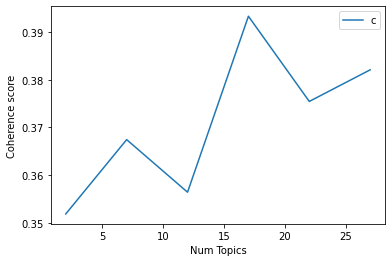

In [111]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [112]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 17

index: 0 | Num Topics = 2  has Coherence Value of 0.3518
index: 1 | Num Topics = 7  has Coherence Value of 0.3674
index: 2 | Num Topics = 12  has Coherence Value of 0.3564
index: 3 | Num Topics = 17  has Coherence Value of 0.3934
index: 4 | Num Topics = 22  has Coherence Value of 0.3755
index: 5 | Num Topics = 27  has Coherence Value of 0.3821


In [180]:
# Select optimal number of topics
optimal_model_sg_score1N2N3 = model_list_sg_score1N2N3[3]

In [181]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_sg_score1N2N3, corpus_sg_score1N2N3, id2word_sg_score1N2N3)

In [182]:
print("pyLDAVis for SG topics for score=1,2,3:")
vis_sg_score1N2N3

pyLDAVis for SG topics for score=1,2,3:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16    -0.287125 -0.062222       1        1  15.077862
11    -0.160914  0.153020       2        1   8.619285
0      0.070143  0.244112       3        1   8.135692
9     -0.172607  0.011002       4        1   7.788143
6      0.168999  0.011710       5        1   7.770746
8     -0.051351 -0.027374       6        1   5.745625
4      0.048471 -0.126843       7        1   5.639779
1     -0.211742 -0.008843       8        1   5.489749
14     0.059690  0.190202       9        1   4.874319
5      0.145584  0.023174      10        1   4.815534
7      0.013618  0.061784      11        1   4.777086
3      0.063263 -0.119810      12        1   4.436872
2     -0.026137 -0.087080      13        1   4.288521
13     0.046385 -0.078022      14        1   3.834075
10     0.148894 -0.012760      15        1   3.267924
15     0.028015 -0.087577      16        1   2.847416
12     0.116814 -0.084473      17        1   2.591373, topic_info=         Term        Freq       Total Category  logprob  loglift
110      post  204.000000  204.000000  Default  30.0000  30.0000
0         app  445.000000  445.000000  Default  29.0000  29.0000
21      video  211.000000  211.000000  Default  28.0000  28.0000
25      photo  107.000000  107.000000  Default  27.0000  27.0000
24   facebook  373.000000  373.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
382   message    2.972254   18.914112  Topic17  -4.8399   1.8024
54        guy    3.201026   29.253996  Topic17  -4.7658   1.4404
401      list    2.722476   12.200139  Topic17  -4.9277   2.1531
265    screen    3.292496   50.933351  Topic17  -4.7376   0.9141
385    really    2.675593   28.816042  Topic17  -4.9451   1.2762

[876 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
189       1  0.155118         able
189       2  0.116338         able
189      14  0.659250         able
189      16  0.038779         able
357       1  0.135006       access
...     ...       ...          ...
301       8  0.630652    yesterday
301      11  0.270280    yesterday
1241     17  0.657484      youtube
341      17  0.657088         zucc
1226     17  0.623112  最新版本连赞过什么帖子

[1373 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 12, 1, 10, 7, 9, 5, 2, 15, 6, 8, 4, 3, 14, 11, 16, 13])

# By-rating of each year

## By-rating of 2018 (Rating=1,2,3)

In [116]:
# By-rating Topic Modelling - rating = 1,2,3 in 2018
# Convert to list - move to each section
review_sg_2018_score1N2N3 = facebook_ios_sg_review_YearMonth_2018_score1N2N3.review.values.tolist()
review_words_sg_2018_score1N2N3 = list(sent_to_words(review_sg_2018_score1N2N3))
print(review_words_sg_2018_score1N2N3[:1])

[['after', 'updating', 'the', 'app', 'to', 'the', 'latest', 'version', 'the', 'newsfeed', 'cant', 'load', 'at', 'all', 'left', 'with', 'nothing', 'but', 'broken', 'app', 'tried', 'deleting', 'the', 'app', 'and', 'reinstalling', 'it', 'but', 'to', 'no', 'avail']]


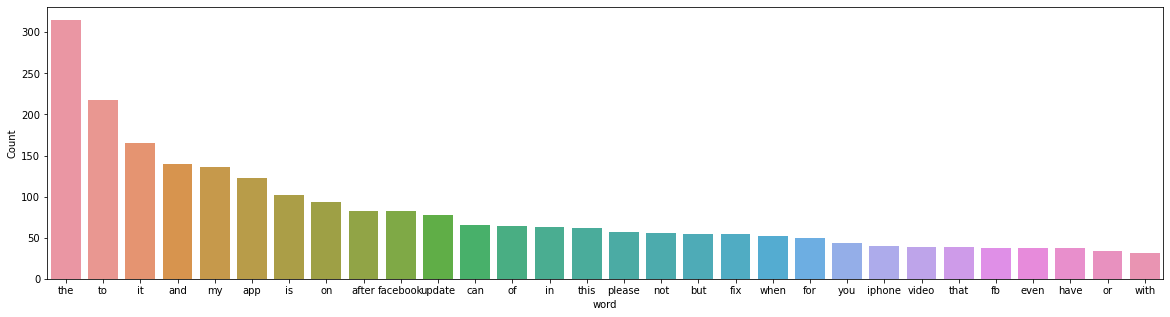

In [117]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_2018_score1N2N3))

In [118]:
# Clean text
review_words_sg_ready_2018_score1N2N3 = process_words(review_words_sg_2018_score1N2N3)  # processed Text Data! - move to each section

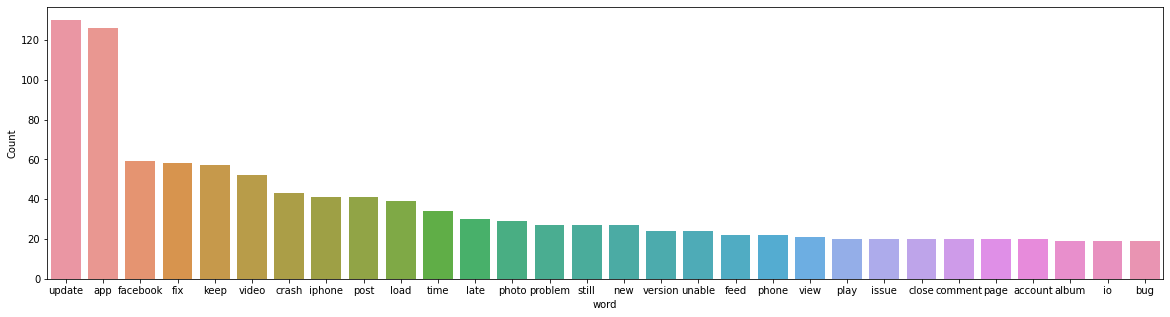

In [119]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_sg_ready_2018_score1N2N3))


In [120]:
# Create Dictionary
id2word_sg_2018_score1N2N3 = corpora.Dictionary(review_words_sg_ready_2018_score1N2N3)

2021-10-16 18:56:28,102 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 18:56:28,120 [INFO] gensim.corpora.dictionary - built Dictionary(719 unique tokens: ['app', 'avail', 'broken', 'delete', 'late']...) from 312 documents (total 2957 corpus positions)
2021-10-16 18:56:28,122 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(719 unique tokens: ['app', 'avail', 'broken', 'delete', 'late']...) from 312 documents (total 2957 corpus positions)", 'datetime': '2021-10-16T18:56:28.122002', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [121]:
# Create Corpus: Term Document Frequency
corpus_sg_2018_score1N2N3 = [id2word_sg_2018_score1N2N3.doc2bow(text) for text in review_words_sg_ready_2018_score1N2N3]

In [122]:
# Training LDA model
model_list_sg_2018_score1N2N3, coherence_values_sg_2018_score1N2N3 = compute_coherence_values(dictionary=id2word_sg_2018_score1N2N3, corpus=corpus_sg_2018_score1N2N3, 
                                                              texts=review_words_sg_ready_2018_score1N2N3, limit=30, start=2, step=5)


2021-10-16 18:56:28,152 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 18:56:28,156 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 18:56:28,165 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:56:28,169 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 312 documents, updating model once every 312 documents, evaluating perplexity every 312 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 18:56:29,120 [INFO] gensim.models.ldamodel - -7.203 per-word bound, 147.3 perplexity estimate based on a held-out corpus of 312 documents with 2957 words
2021-10-16 18:56:29,122 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #312/312
2021-10-16 18:56:29,978 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.019*"update" + 0.018*"load" + 0.016*"fix" + 0.015*"keep" + 0.014*"post" + 0.014*"video" + 0.013*"app" 

2021-10-16 18:56:37,689 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.052*"app" + 0.052*"update" + 0.022*"keep" + 0.022*"facebook" + 0.019*"fix" + 0.018*"crash" + 0.016*"iphone" + 0.013*"late" + 0.012*"video" + 0.011*"time"
2021-10-16 18:56:37,692 [INFO] gensim.models.ldamodel - topic diff=0.014110, rho=0.301511
2021-10-16 18:56:38,067 [INFO] gensim.models.ldamodel - -6.082 per-word bound, 67.8 perplexity estimate based on a held-out corpus of 312 documents with 2957 words
2021-10-16 18:56:38,068 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #312/312
2021-10-16 18:56:38,278 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.024*"load" + 0.020*"post" + 0.018*"video" + 0.015*"page" + 0.015*"feed" + 0.013*"unable" + 0.010*"fix" + 0.008*"friend" + 0.008*"refresh" + 0.008*"issue"
2021-10-16 18:56:38,377 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.053*"app" + 0.052*"update" + 0.022*"keep" + 0.022*"facebook" + 0.019*"fix" + 0.018*"crash" + 0.016*"iphone" + 0.01

2021-10-16 18:56:44,929 [INFO] gensim.models.ldamodel - topic diff=0.005870, rho=0.218218
2021-10-16 18:56:45,404 [INFO] gensim.models.ldamodel - -6.075 per-word bound, 67.4 perplexity estimate based on a held-out corpus of 312 documents with 2957 words
2021-10-16 18:56:45,406 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #312/312
2021-10-16 18:56:45,671 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.025*"load" + 0.021*"post" + 0.019*"video" + 0.016*"feed" + 0.015*"page" + 0.014*"unable" + 0.009*"refresh" + 0.009*"fix" + 0.008*"friend" + 0.008*"news"
2021-10-16 18:56:45,672 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.053*"app" + 0.053*"update" + 0.023*"keep" + 0.022*"facebook" + 0.020*"fix" + 0.018*"crash" + 0.017*"iphone" + 0.013*"late" + 0.012*"video" + 0.011*"time"
2021-10-16 18:56:45,673 [INFO] gensim.models.ldamodel - topic diff=0.005657, rho=0.213201
2021-10-16 18:56:45,991 [INFO] gensim.models.ldamodel - -6.075 per-word bound, 67.4 perplexity estima

2021-10-16 18:56:52,168 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #312/312
2021-10-16 18:56:52,455 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.026*"load" + 0.021*"post" + 0.019*"video" + 0.016*"feed" + 0.015*"page" + 0.014*"unable" + 0.009*"refresh" + 0.009*"comment" + 0.009*"fix" + 0.008*"news"
2021-10-16 18:56:52,460 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.054*"app" + 0.053*"update" + 0.024*"keep" + 0.023*"facebook" + 0.020*"fix" + 0.019*"crash" + 0.017*"iphone" + 0.013*"late" + 0.012*"video" + 0.011*"still"
2021-10-16 18:56:52,463 [INFO] gensim.models.ldamodel - topic diff=0.003574, rho=0.176777
2021-10-16 18:56:52,816 [INFO] gensim.models.ldamodel - -6.070 per-word bound, 67.2 perplexity estimate based on a held-out corpus of 312 documents with 2957 words
2021-10-16 18:56:52,817 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #312/312
2021-10-16 18:56:53,106 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.026*"load" + 0.02

2021-10-16 18:56:59,426 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.026*"load" + 0.022*"post" + 0.019*"video" + 0.016*"feed" + 0.015*"page" + 0.014*"unable" + 0.011*"comment" + 0.009*"refresh" + 0.009*"fix" + 0.008*"news"
2021-10-16 18:56:59,428 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.054*"app" + 0.054*"update" + 0.024*"keep" + 0.023*"facebook" + 0.020*"fix" + 0.019*"crash" + 0.017*"iphone" + 0.013*"late" + 0.012*"video" + 0.011*"still"
2021-10-16 18:56:59,429 [INFO] gensim.models.ldamodel - topic diff=0.002758, rho=0.154303
2021-10-16 18:56:59,828 [INFO] gensim.models.ldamodel - -6.068 per-word bound, 67.1 perplexity estimate based on a held-out corpus of 312 documents with 2957 words
2021-10-16 18:56:59,830 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #312/312
2021-10-16 18:57:00,030 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.026*"load" + 0.022*"post" + 0.019*"video" + 0.016*"feed" + 0.015*"page" + 0.014*"unable" + 0.011*"comment" + 0.00

2021-10-16 18:57:06,310 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 18:57:11,478 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 18:57:11,536 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 286 virtual documents
2021-10-16 18:57:11,827 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 18:57:11,828 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 18:57:11,830 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 18:57:11,833 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 312 documents, updating model once every 312 documents, evaluating perplexity every 312 documents, iterating 50x with a con

2021-10-16 18:57:16,116 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.072*"update" + 0.067*"app" + 0.031*"facebook" + 0.030*"crash" + 0.026*"iphone" + 0.021*"keep" + 0.020*"new" + 0.015*"fix" + 0.014*"phone" + 0.012*"open"
2021-10-16 18:57:16,117 [INFO] gensim.models.ldamodel - topic diff=0.059799, rho=0.408248
2021-10-16 18:57:16,539 [INFO] gensim.models.ldamodel - -6.420 per-word bound, 85.6 perplexity estimate based on a held-out corpus of 312 documents with 2957 words
2021-10-16 18:57:16,540 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #312/312
2021-10-16 18:57:16,786 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.027*"account" + 0.023*"crash" + 0.022*"keep" + 0.021*"app" + 0.016*"photo" + 0.013*"help" + 0.012*"time" + 0.011*"version" + 0.011*"update" + 0.011*"log"
2021-10-16 18:57:16,788 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.066*"video" + 0.034*"app" + 0.024*"update" + 0.022*"play" + 0.020*"problem" + 0.016*"keep" + 0.014*"load" + 0.012*"b

2021-10-16 18:57:20,304 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.077*"app" + 0.074*"update" + 0.037*"crash" + 0.031*"facebook" + 0.026*"keep" + 0.026*"iphone" + 0.020*"new" + 0.015*"fix" + 0.014*"phone" + 0.012*"open"
2021-10-16 18:57:20,308 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.038*"load" + 0.028*"feed" + 0.026*"page" + 0.024*"fix" + 0.023*"update" + 0.022*"post" + 0.022*"unable" + 0.019*"bug" + 0.018*"notification" + 0.016*"refresh"
2021-10-16 18:57:20,311 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.045*"update" + 0.039*"late" + 0.033*"app" + 0.025*"still" + 0.022*"io" + 0.017*"version" + 0.016*"fix" + 0.014*"post" + 0.014*"comment" + 0.014*"facebook"
2021-10-16 18:57:20,313 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.072*"video" + 0.030*"app" + 0.025*"play" + 0.022*"update" + 0.021*"problem" + 0.015*"keep" + 0.013*"load" + 0.012*"comment" + 0.012*"bad" + 0.012*"jump"
2021-10-16 18:57:20,316 [INFO] gensim.models.ldamodel - topic diff=0.019050,

2021-10-16 18:57:23,595 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.039*"load" + 0.029*"feed" + 0.026*"page" + 0.024*"fix" + 0.023*"update" + 0.022*"unable" + 0.022*"post" + 0.019*"bug" + 0.017*"notification" + 0.017*"refresh"
2021-10-16 18:57:23,597 [INFO] gensim.models.ldamodel - topic diff=0.009723, rho=0.242536
2021-10-16 18:57:23,957 [INFO] gensim.models.ldamodel - -6.374 per-word bound, 82.9 perplexity estimate based on a held-out corpus of 312 documents with 2957 words
2021-10-16 18:57:23,959 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #312/312
2021-10-16 18:57:24,238 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.032*"fix" + 0.025*"album" + 0.024*"update" + 0.023*"photo" + 0.022*"app" + 0.020*"post" + 0.020*"show" + 0.018*"back" + 0.018*"facebook" + 0.015*"recent"
2021-10-16 18:57:24,241 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.043*"update" + 0.037*"late" + 0.030*"app" + 0.025*"still" + 0.021*"io" + 0.016*"version" + 0.015*"post" + 0.0

2021-10-16 18:57:27,521 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.039*"load" + 0.030*"feed" + 0.026*"page" + 0.024*"fix" + 0.023*"update" + 0.022*"unable" + 0.022*"post" + 0.019*"bug" + 0.017*"refresh" + 0.017*"notification"
2021-10-16 18:57:27,527 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.042*"update" + 0.036*"late" + 0.029*"app" + 0.025*"still" + 0.020*"io" + 0.016*"version" + 0.015*"post" + 0.015*"comment" + 0.015*"facebook" + 0.015*"shut"
2021-10-16 18:57:27,530 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.084*"app" + 0.076*"update" + 0.041*"crash" + 0.030*"facebook" + 0.029*"keep" + 0.025*"iphone" + 0.019*"new" + 0.017*"fix" + 0.014*"phone" + 0.013*"close"
2021-10-16 18:57:27,533 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.023*"photo" + 0.020*"album" + 0.018*"datum" + 0.018*"ipad" + 0.017*"automatically" + 0.017*"picture" + 0.014*"miss" + 0.014*"view" + 0.014*"iphone" + 0.012*"people"
2021-10-16 18:57:27,535 [INFO] gensim.models.ldamodel - topic 

2021-10-16 18:57:31,066 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.034*"account" + 0.019*"keep" + 0.017*"photo" + 0.016*"app" + 0.015*"log" + 0.013*"time" + 0.013*"crash" + 0.012*"help" + 0.012*"facebook" + 0.012*"version"
2021-10-16 18:57:31,068 [INFO] gensim.models.ldamodel - topic diff=0.004424, rho=0.188982
2021-10-16 18:57:31,580 [INFO] gensim.models.ldamodel - -6.364 per-word bound, 82.4 perplexity estimate based on a held-out corpus of 312 documents with 2957 words
2021-10-16 18:57:31,593 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #312/312
2021-10-16 18:57:31,933 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.078*"video" + 0.028*"play" + 0.021*"app" + 0.021*"problem" + 0.017*"update" + 0.013*"watch" + 0.013*"keep" + 0.013*"comment" + 0.012*"bad" + 0.012*"jump"
2021-10-16 18:57:31,934 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.032*"fix" + 0.026*"album" + 0.024*"update" + 0.023*"photo" + 0.022*"app" + 0.020*"post" + 0.020*"show" + 0.018*"

2021-10-16 18:57:35,940 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.079*"video" + 0.029*"play" + 0.021*"problem" + 0.018*"app" + 0.015*"update" + 0.014*"watch" + 0.013*"comment" + 0.012*"bad" + 0.012*"jump" + 0.012*"keep"
2021-10-16 18:57:35,941 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.034*"account" + 0.019*"keep" + 0.017*"photo" + 0.016*"app" + 0.016*"log" + 0.013*"time" + 0.013*"crash" + 0.012*"facebook" + 0.012*"help" + 0.012*"version"
2021-10-16 18:57:35,943 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.090*"app" + 0.080*"update" + 0.040*"crash" + 0.031*"keep" + 0.030*"facebook" + 0.025*"iphone" + 0.018*"new" + 0.016*"fix" + 0.014*"phone" + 0.014*"close"
2021-10-16 18:57:35,946 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.024*"photo" + 0.022*"album" + 0.018*"ipad" + 0.018*"datum" + 0.017*"picture" + 0.017*"automatically" + 0.015*"view" + 0.014*"miss" + 0.014*"iphone" + 0.012*"people"
2021-10-16 18:57:35,948 [INFO] gensim.models.ldamodel - topic diff=

2021-10-16 18:57:39,135 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.034*"account" + 0.019*"keep" + 0.017*"photo" + 0.016*"app" + 0.016*"log" + 0.013*"time" + 0.013*"crash" + 0.012*"facebook" + 0.012*"version" + 0.011*"help"
2021-10-16 18:57:39,144 [INFO] gensim.models.ldamodel - topic diff=0.002646, rho=0.160128
2021-10-16 18:57:39,554 [INFO] gensim.models.ldamodel - -6.358 per-word bound, 82.0 perplexity estimate based on a held-out corpus of 312 documents with 2957 words
2021-10-16 18:57:39,555 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #312/312
2021-10-16 18:57:39,850 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.035*"account" + 0.019*"keep" + 0.017*"photo" + 0.016*"log" + 0.016*"app" + 0.013*"time" + 0.013*"crash" + 0.012*"facebook" + 0.012*"version" + 0.011*"help"
2021-10-16 18:57:39,851 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.091*"app" + 0.081*"update" + 0.040*"crash" + 0.032*"keep" + 0.029*"facebook" + 0.024*"iphone" + 0.018*"new" + 

2021-10-16 18:57:43,201 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.080*"video" + 0.030*"play" + 0.021*"problem" + 0.016*"app" + 0.014*"watch" + 0.013*"comment" + 0.013*"update" + 0.013*"bad" + 0.013*"jump" + 0.012*"post"
2021-10-16 18:57:43,205 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.037*"update" + 0.031*"late" + 0.025*"app" + 0.022*"io" + 0.022*"still" + 0.018*"comment" + 0.017*"live" + 0.015*"version" + 0.015*"post" + 0.015*"facebook"
2021-10-16 18:57:43,208 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.032*"fix" + 0.027*"photo" + 0.025*"update" + 0.025*"album" + 0.024*"app" + 0.021*"post" + 0.020*"show" + 0.018*"back" + 0.018*"facebook" + 0.015*"recent"
2021-10-16 18:57:43,211 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.024*"photo" + 0.022*"album" + 0.018*"ipad" + 0.018*"datum" + 0.018*"picture" + 0.017*"automatically" + 0.015*"view" + 0.014*"miss" + 0.014*"iphone" + 0.012*"people"
2021-10-16 18:57:43,212 [INFO] gensim.models.ldamodel - topic diff=

2021-10-16 18:57:46,448 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.032*"fix" + 0.029*"photo" + 0.025*"update" + 0.025*"album" + 0.024*"app" + 0.022*"post" + 0.019*"show" + 0.018*"facebook" + 0.018*"back" + 0.015*"recent"
2021-10-16 18:57:46,450 [INFO] gensim.models.ldamodel - topic diff=0.002191, rho=0.141421
2021-10-16 18:57:46,823 [INFO] gensim.models.ldamodel - -6.353 per-word bound, 81.8 perplexity estimate based on a held-out corpus of 312 documents with 2957 words
2021-10-16 18:57:46,826 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #312/312
2021-10-16 18:57:47,018 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.036*"update" + 0.030*"late" + 0.024*"app" + 0.023*"io" + 0.022*"still" + 0.018*"comment" + 0.018*"live" + 0.015*"post" + 0.015*"facebook" + 0.015*"shut"
2021-10-16 18:57:47,019 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.035*"account" + 0.019*"keep" + 0.018*"photo" + 0.016*"log" + 0.016*"app" + 0.013*"time" + 0.012*"crash" + 0.012*"fa

2021-10-16 18:57:56,415 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.042*"album" + 0.039*"app" + 0.033*"update" + 0.024*"late" + 0.024*"fix" + 0.020*"photo" + 0.019*"io" + 0.018*"view" + 0.017*"show" + 0.017*"keep"
2021-10-16 18:57:56,417 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.060*"video" + 0.041*"app" + 0.033*"update" + 0.023*"problem" + 0.022*"keep" + 0.018*"play" + 0.016*"loading" + 0.014*"facebook" + 0.014*"jump" + 0.014*"always"
2021-10-16 18:57:56,418 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.042*"post" + 0.027*"load" + 0.027*"facebook" + 0.022*"time" + 0.022*"account" + 0.021*"fix" + 0.018*"app" + 0.017*"keep" + 0.015*"friend" + 0.015*"stop"
2021-10-16 18:57:56,419 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.088*"update" + 0.068*"app" + 0.029*"iphone" + 0.029*"crash" + 0.027*"facebook" + 0.026*"new" + 0.026*"fix" + 0.021*"keep" + 0.016*"asap" + 0.015*"phone"
2021-10-16 18:57:56,420 [INFO] gensim.models.ldamodel - topic diff=0.057994, rho=0.4

2021-10-16 18:58:00,466 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.043*"update" + 0.041*"bad" + 0.033*"keep" + 0.029*"app" + 0.017*"people" + 0.017*"name" + 0.014*"stop" + 0.013*"datum" + 0.013*"check" + 0.013*"late"
2021-10-16 18:58:00,467 [INFO] gensim.models.ldamodel - topic diff=0.029575, rho=0.316228
2021-10-16 18:58:00,772 [INFO] gensim.models.ldamodel - -6.575 per-word bound, 95.3 perplexity estimate based on a held-out corpus of 312 documents with 2957 words
2021-10-16 18:58:00,773 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #312/312
2021-10-16 18:58:01,069 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.042*"app" + 0.038*"update" + 0.032*"load" + 0.026*"facebook" + 0.023*"crash" + 0.020*"still" + 0.014*"story" + 0.014*"reinstall" + 0.011*"access" + 0.011*"live"
2021-10-16 18:58:01,071 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.036*"notification" + 0.032*"page" + 0.022*"bug" + 0.016*"slow" + 0.016*"update" + 0.016*"fix" + 0.016*"profile"

2021-10-16 18:58:04,199 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.043*"post" + 0.032*"load" + 0.025*"facebook" + 0.025*"time" + 0.025*"account" + 0.021*"fix" + 0.017*"feed" + 0.017*"friend" + 0.016*"keep" + 0.016*"app"
2021-10-16 18:58:04,201 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.044*"update" + 0.044*"bad" + 0.031*"keep" + 0.027*"app" + 0.018*"people" + 0.018*"name" + 0.015*"stop" + 0.014*"datum" + 0.011*"check" + 0.010*"late"
2021-10-16 18:58:04,204 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.052*"album" + 0.041*"photo" + 0.022*"app" + 0.020*"update" + 0.020*"show" + 0.020*"fix" + 0.019*"view" + 0.017*"video" + 0.017*"miss" + 0.016*"iphone"
2021-10-16 18:58:04,206 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.023*"datum" + 0.022*"app" + 0.019*"mobile" + 0.018*"live" + 0.018*"still" + 0.018*"update" + 0.015*"comment" + 0.015*"feed" + 0.015*"io" + 0.012*"issue"
2021-10-16 18:58:04,208 [INFO] gensim.models.ldamodel - topic diff=0.015299, rho=0.250000

2021-10-16 18:58:07,364 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.023*"datum" + 0.020*"mobile" + 0.019*"live" + 0.018*"app" + 0.017*"still" + 0.016*"update" + 0.016*"comment" + 0.016*"feed" + 0.014*"io" + 0.012*"issue"
2021-10-16 18:58:07,367 [INFO] gensim.models.ldamodel - topic diff=0.009360, rho=0.218218
2021-10-16 18:58:07,701 [INFO] gensim.models.ldamodel - -6.534 per-word bound, 92.7 perplexity estimate based on a held-out corpus of 312 documents with 2957 words
2021-10-16 18:58:07,702 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #312/312
2021-10-16 18:58:07,937 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.067*"video" + 0.036*"app" + 0.029*"update" + 0.025*"play" + 0.023*"problem" + 0.018*"loading" + 0.018*"keep" + 0.014*"always" + 0.014*"jump" + 0.013*"check"
2021-10-16 18:58:07,940 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.041*"photo" + 0.024*"album" + 0.022*"facebook" + 0.021*"account" + 0.013*"app" + 0.012*"post" + 0.012*"iphone" +

2021-10-16 18:58:10,921 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.023*"datum" + 0.020*"mobile" + 0.019*"live" + 0.018*"feed" + 0.016*"comment" + 0.016*"still" + 0.015*"update" + 0.015*"app" + 0.014*"io" + 0.012*"issue"
2021-10-16 18:58:10,923 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.046*"bad" + 0.043*"update" + 0.028*"app" + 0.027*"keep" + 0.019*"people" + 0.019*"name" + 0.015*"stop" + 0.014*"datum" + 0.012*"user" + 0.012*"application"
2021-10-16 18:58:10,925 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.062*"unable" + 0.039*"fix" + 0.039*"load" + 0.029*"version" + 0.029*"update" + 0.028*"app" + 0.025*"view" + 0.024*"post" + 0.021*"automatically" + 0.020*"screen"
2021-10-16 18:58:10,926 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.057*"album" + 0.049*"photo" + 0.022*"show" + 0.021*"fix" + 0.020*"view" + 0.018*"video" + 0.018*"miss" + 0.018*"upload" + 0.013*"update" + 0.012*"app"
2021-10-16 18:58:10,929 [INFO] gensim.models.ldamodel - topic diff=0.00611

2021-10-16 18:58:14,094 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.041*"photo" + 0.024*"album" + 0.019*"facebook" + 0.013*"app" + 0.012*"post" + 0.012*"iphone" + 0.012*"look" + 0.012*"picture" + 0.012*"type" + 0.012*"safe"
2021-10-16 18:58:14,097 [INFO] gensim.models.ldamodel - topic diff=0.004327, rho=0.176777
2021-10-16 18:58:14,437 [INFO] gensim.models.ldamodel - -6.515 per-word bound, 91.5 perplexity estimate based on a held-out corpus of 312 documents with 2957 words
2021-10-16 18:58:14,438 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #312/312
2021-10-16 18:58:14,719 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.038*"notification" + 0.033*"page" + 0.025*"bug" + 0.022*"profile" + 0.015*"fix" + 0.013*"slow" + 0.011*"update" + 0.011*"phone" + 0.010*"post" + 0.009*"iphone"
2021-10-16 18:58:14,721 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.067*"video" + 0.036*"app" + 0.029*"update" + 0.025*"play" + 0.023*"problem" + 0.018*"loading" + 0.018*"kee

2021-10-16 18:58:18,053 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.041*"update" + 0.039*"app" + 0.028*"load" + 0.028*"facebook" + 0.017*"still" + 0.016*"story" + 0.014*"reinstall" + 0.012*"access" + 0.012*"live" + 0.012*"late"
2021-10-16 18:58:18,058 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.046*"bad" + 0.040*"update" + 0.028*"app" + 0.026*"keep" + 0.019*"people" + 0.019*"name" + 0.016*"stop" + 0.015*"datum" + 0.014*"user" + 0.013*"application"
2021-10-16 18:58:18,062 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.060*"unable" + 0.040*"load" + 0.039*"fix" + 0.031*"version" + 0.029*"update" + 0.027*"app" + 0.025*"post" + 0.024*"view" + 0.021*"automatically" + 0.020*"screen"
2021-10-16 18:58:18,069 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.023*"datum" + 0.020*"mobile" + 0.019*"live" + 0.019*"feed" + 0.016*"comment" + 0.014*"still" + 0.014*"update" + 0.014*"io" + 0.013*"app" + 0.012*"issue"
2021-10-16 18:58:18,071 [INFO] gensim.models.ldamodel - topic di

2021-10-16 18:58:21,432 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.058*"unable" + 0.039*"load" + 0.038*"fix" + 0.031*"version" + 0.029*"update" + 0.027*"app" + 0.024*"post" + 0.023*"view" + 0.022*"screen" + 0.021*"automatically"
2021-10-16 18:58:21,433 [INFO] gensim.models.ldamodel - topic diff=0.002899, rho=0.152499
2021-10-16 18:58:21,991 [INFO] gensim.models.ldamodel - -6.508 per-word bound, 91.0 perplexity estimate based on a held-out corpus of 312 documents with 2957 words
2021-10-16 18:58:21,993 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #312/312
2021-10-16 18:58:22,324 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.068*"video" + 0.034*"app" + 0.028*"update" + 0.025*"play" + 0.023*"problem" + 0.019*"keep" + 0.019*"loading" + 0.014*"always" + 0.014*"jump" + 0.014*"check"
2021-10-16 18:58:22,330 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.041*"update" + 0.039*"app" + 0.028*"load" + 0.028*"facebook" + 0.017*"still" + 0.016*"story" + 0.014*"

2021-10-16 18:58:26,416 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.047*"bad" + 0.038*"update" + 0.028*"app" + 0.026*"keep" + 0.019*"people" + 0.019*"name" + 0.016*"stop" + 0.015*"datum" + 0.015*"user" + 0.013*"application"
2021-10-16 18:58:26,417 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.025*"video" + 0.021*"work" + 0.021*"play" + 0.021*"auto" + 0.020*"back" + 0.018*"app" + 0.014*"recent" + 0.013*"time" + 0.013*"really" + 0.013*"photo"
2021-10-16 18:58:26,418 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.058*"album" + 0.051*"photo" + 0.022*"show" + 0.022*"fix" + 0.021*"view" + 0.019*"upload" + 0.018*"video" + 0.018*"miss" + 0.011*"update" + 0.011*"time"
2021-10-16 18:58:26,419 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.038*"notification" + 0.033*"page" + 0.025*"bug" + 0.022*"profile" + 0.015*"fix" + 0.013*"slow" + 0.011*"update" + 0.011*"phone" + 0.009*"post" + 0.009*"iphone"
2021-10-16 18:58:26,421 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.0

2021-10-16 18:58:35,994 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.035*"album" + 0.031*"update" + 0.026*"photo" + 0.026*"app" + 0.023*"unable" + 0.022*"iphone" + 0.021*"show" + 0.019*"picture" + 0.018*"post" + 0.017*"marketplace"
2021-10-16 18:58:35,997 [INFO] gensim.models.ldamodel - topic diff=0.107375, rho=0.577350
2021-10-16 18:58:36,385 [INFO] gensim.models.ldamodel - -6.797 per-word bound, 111.2 perplexity estimate based on a held-out corpus of 312 documents with 2957 words
2021-10-16 18:58:36,393 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #312/312
2021-10-16 18:58:36,667 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.041*"account" + 0.034*"app" + 0.034*"photo" + 0.029*"bad" + 0.026*"facebook" + 0.024*"name" + 0.020*"crash" + 0.019*"keep" + 0.018*"security" + 0.018*"feed"
2021-10-16 18:58:36,668 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.087*"update" + 0.043*"app" + 0.031*"crash" + 0.025*"fix" + 0.025*"iphone" + 0.024*"keep" + 0.023*"lo

2021-10-16 18:58:39,927 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.036*"comment" + 0.029*"app" + 0.025*"update" + 0.024*"still" + 0.024*"late" + 0.020*"facebook" + 0.020*"live" + 0.016*"application" + 0.016*"sound" + 0.012*"access"
2021-10-16 18:58:39,929 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.027*"issue" + 0.026*"problem" + 0.021*"news" + 0.017*"post" + 0.014*"face" + 0.014*"help" + 0.014*"love" + 0.014*"load" + 0.014*"time" + 0.014*"live"
2021-10-16 18:58:39,931 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.030*"video" + 0.029*"back" + 0.029*"facebook" + 0.027*"play" + 0.024*"photo" + 0.024*"album" + 0.023*"app" + 0.020*"check" + 0.017*"fix" + 0.016*"happen"
2021-10-16 18:58:39,933 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.095*"update" + 0.044*"app" + 0.032*"crash" + 0.030*"late" + 0.027*"load" + 0.025*"fix" + 0.024*"iphone" + 0.023*"keep" + 0.023*"asap" + 0.019*"new"
2021-10-16 18:58:39,934 [INFO] gensim.models.ldamodel - topic diff=0.035835, 

2021-10-16 18:58:43,096 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.028*"issue" + 0.026*"problem" + 0.021*"news" + 0.015*"post" + 0.014*"face" + 0.014*"help" + 0.014*"love" + 0.014*"load" + 0.014*"time" + 0.014*"live"
2021-10-16 18:58:43,099 [INFO] gensim.models.ldamodel - topic diff=0.015315, rho=0.267261
2021-10-16 18:58:43,440 [INFO] gensim.models.ldamodel - -6.645 per-word bound, 100.1 perplexity estimate based on a held-out corpus of 312 documents with 2957 words
2021-10-16 18:58:43,442 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #312/312
2021-10-16 18:58:43,710 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.100*"update" + 0.045*"app" + 0.036*"late" + 0.031*"crash" + 0.028*"load" + 0.026*"iphone" + 0.025*"fix" + 0.024*"asap" + 0.024*"keep" + 0.020*"version"
2021-10-16 18:58:43,713 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.037*"comment" + 0.028*"app" + 0.025*"still" + 0.022*"update" + 0.022*"late" + 0.021*"facebook" + 0.021*"live" + 0.017

2021-10-16 18:58:46,812 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.049*"bad" + 0.045*"account" + 0.045*"photo" + 0.030*"app" + 0.028*"facebook" + 0.023*"name" + 0.023*"crash" + 0.022*"upload" + 0.019*"feed" + 0.017*"security"
2021-10-16 18:58:46,815 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.038*"comment" + 0.027*"app" + 0.025*"still" + 0.021*"late" + 0.021*"facebook" + 0.021*"live" + 0.020*"update" + 0.017*"application" + 0.017*"sound" + 0.013*"access"
2021-10-16 18:58:46,818 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.041*"video" + 0.029*"timeline" + 0.025*"upload" + 0.024*"live" + 0.024*"crash" + 0.023*"app" + 0.021*"facebook" + 0.020*"keep" + 0.020*"still" + 0.019*"update"
2021-10-16 18:58:46,820 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.043*"album" + 0.030*"photo" + 0.026*"unable" + 0.026*"show" + 0.022*"update" + 0.021*"iphone" + 0.020*"find" + 0.020*"link" + 0.020*"picture" + 0.018*"post"
2021-10-16 18:58:46,822 [INFO] gensim.models.ldamodel

2021-10-16 18:58:50,567 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.033*"back" + 0.031*"video" + 0.029*"photo" + 0.028*"play" + 0.028*"facebook" + 0.025*"album" + 0.021*"check" + 0.019*"app" + 0.017*"fix" + 0.017*"happen"
2021-10-16 18:58:50,568 [INFO] gensim.models.ldamodel - topic diff=0.005953, rho=0.200000
2021-10-16 18:58:51,059 [INFO] gensim.models.ldamodel - -6.617 per-word bound, 98.1 perplexity estimate based on a held-out corpus of 312 documents with 2957 words
2021-10-16 18:58:51,062 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #312/312
2021-10-16 18:58:51,338 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.058*"load" + 0.052*"feed" + 0.045*"page" + 0.045*"update" + 0.026*"refresh" + 0.025*"news" + 0.020*"bug" + 0.019*"new" + 0.016*"recent" + 0.016*"minute"
2021-10-16 18:58:51,356 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.043*"album" + 0.031*"photo" + 0.026*"unable" + 0.026*"show" + 0.021*"update" + 0.021*"iphone" + 0.020*"find" + 0.0

2021-10-16 18:58:54,690 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.045*"video" + 0.030*"timeline" + 0.029*"live" + 0.026*"upload" + 0.021*"facebook" + 0.018*"still" + 0.018*"keep" + 0.017*"update" + 0.015*"instastorie" + 0.015*"play"
2021-10-16 18:58:54,692 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.122*"app" + 0.076*"update" + 0.071*"crash" + 0.062*"keep" + 0.033*"phone" + 0.029*"io" + 0.026*"iphone" + 0.021*"fix" + 0.021*"close" + 0.020*"reinstall"
2021-10-16 18:58:54,693 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.058*"load" + 0.053*"feed" + 0.046*"update" + 0.045*"page" + 0.027*"refresh" + 0.025*"news" + 0.020*"new" + 0.018*"bug" + 0.017*"recent" + 0.016*"unable"
2021-10-16 18:58:54,694 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.050*"bad" + 0.045*"account" + 0.045*"photo" + 0.030*"app" + 0.028*"facebook" + 0.023*"name" + 0.023*"crash" + 0.023*"upload" + 0.018*"feed" + 0.017*"security"
2021-10-16 18:58:54,695 [INFO] gensim.models.ldamodel - topic

2021-10-16 18:58:57,660 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.109*"update" + 0.050*"app" + 0.042*"late" + 0.032*"load" + 0.029*"crash" + 0.028*"iphone" + 0.025*"fix" + 0.025*"asap" + 0.025*"keep" + 0.024*"version"
2021-10-16 18:58:57,661 [INFO] gensim.models.ldamodel - topic diff=0.003943, rho=0.166667
2021-10-16 18:58:58,017 [INFO] gensim.models.ldamodel - -6.604 per-word bound, 97.3 perplexity estimate based on a held-out corpus of 312 documents with 2957 words
2021-10-16 18:58:58,018 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #312/312
2021-10-16 18:58:58,265 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.053*"app" + 0.031*"update" + 0.024*"close" + 0.022*"facebook" + 0.022*"datum" + 0.022*"automatically" + 0.022*"version" + 0.015*"work" + 0.015*"people" + 0.015*"type"
2021-10-16 18:58:58,267 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.122*"app" + 0.077*"update" + 0.071*"crash" + 0.063*"keep" + 0.033*"phone" + 0.029*"io" + 0.025*"iphon

2021-10-16 18:59:01,341 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.033*"back" + 0.031*"video" + 0.029*"photo" + 0.028*"play" + 0.028*"facebook" + 0.025*"album" + 0.021*"check" + 0.019*"app" + 0.017*"fix" + 0.017*"happen"
2021-10-16 18:59:01,343 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.053*"update" + 0.046*"mb" + 0.029*"downloadable" + 0.029*"always" + 0.029*"size" + 0.020*"datum" + 0.020*"plan" + 0.020*"mobile" + 0.020*"file" + 0.020*"io"
2021-10-16 18:59:01,345 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.110*"update" + 0.051*"app" + 0.044*"late" + 0.032*"load" + 0.028*"iphone" + 0.027*"crash" + 0.026*"fix" + 0.026*"keep" + 0.025*"asap" + 0.024*"post"
2021-10-16 18:59:01,349 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.057*"fix" + 0.040*"bug" + 0.027*"app" + 0.024*"time" + 0.024*"comment" + 0.024*"video" + 0.024*"problem" + 0.024*"version" + 0.016*"always" + 0.016*"datum"
2021-10-16 18:59:01,351 [INFO] gensim.models.ldamodel - topic diff=0.003003, r

2021-10-16 18:59:04,374 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.028*"issue" + 0.026*"problem" + 0.021*"news" + 0.014*"post" + 0.014*"load" + 0.014*"face" + 0.014*"help" + 0.014*"time" + 0.014*"report" + 0.014*"live"
2021-10-16 18:59:04,378 [INFO] gensim.models.ldamodel - topic diff=0.002271, rho=0.145865
2021-10-16 18:59:04,719 [INFO] gensim.models.ldamodel - -6.594 per-word bound, 96.6 perplexity estimate based on a held-out corpus of 312 documents with 2957 words
2021-10-16 18:59:04,721 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #312/312
2021-10-16 18:59:04,951 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.033*"back" + 0.031*"video" + 0.029*"photo" + 0.028*"play" + 0.028*"facebook" + 0.025*"album" + 0.021*"check" + 0.019*"app" + 0.017*"fix" + 0.017*"happen"
2021-10-16 18:59:04,953 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.069*"update" + 0.050*"facebook" + 0.047*"app" + 0.039*"notification" + 0.032*"iphone" + 0.028*"fix" + 0.020*"new" +

2021-10-16 18:59:15,328 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.035*"keep" + 0.035*"update" + 0.035*"fix" + 0.030*"crash" + 0.029*"app" + 0.024*"name" + 0.024*"facebook" + 0.017*"friend" + 0.017*"account" + 0.012*"notification"
2021-10-16 18:59:15,329 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.034*"bug" + 0.034*"update" + 0.032*"facebook" + 0.031*"page" + 0.031*"feed" + 0.019*"notification" + 0.019*"load" + 0.019*"fix" + 0.019*"app" + 0.014*"new"
2021-10-16 18:59:15,332 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.030*"help" + 0.030*"bug" + 0.019*"close" + 0.018*"app" + 0.016*"delete" + 0.016*"issue" + 0.016*"anyhow" + 0.016*"live" + 0.016*"face" + 0.016*"automatically"
2021-10-16 18:59:15,333 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.044*"app" + 0.031*"time" + 0.030*"comment" + 0.030*"update" + 0.023*"facebook" + 0.022*"post" + 0.018*"still" + 0.017*"fix" + 0.013*"several" + 0.013*"recent"
2021-10-16 18:59:15,335 [INFO] gensim.models.ldamodel - 

2021-10-16 18:59:19,100 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.098*"app" + 0.074*"crash" + 0.053*"update" + 0.045*"keep" + 0.034*"phone" + 0.024*"iphone" + 0.019*"new" + 0.018*"fix" + 0.015*"close" + 0.015*"load"
2021-10-16 18:59:19,100 [INFO] gensim.models.ldamodel - topic diff=0.047598, rho=0.377964
2021-10-16 18:59:19,604 [INFO] gensim.models.ldamodel - -6.769 per-word bound, 109.1 perplexity estimate based on a held-out corpus of 312 documents with 2957 words
2021-10-16 18:59:19,607 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #312/312
2021-10-16 18:59:19,948 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.055*"app" + 0.041*"sound" + 0.035*"facebook" + 0.035*"update" + 0.021*"story" + 0.014*"log" + 0.014*"ridiculous" + 0.014*"access" + 0.014*"friend" + 0.014*"still"
2021-10-16 18:59:19,956 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.085*"update" + 0.037*"fix" + 0.034*"new" + 0.033*"asap" + 0.032*"facebook" + 0.032*"iphone" + 0.023*"app" +

2021-10-16 18:59:23,311 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.081*"album" + 0.077*"photo" + 0.045*"app" + 0.035*"update" + 0.034*"show" + 0.026*"back" + 0.020*"fix" + 0.018*"facebook" + 0.016*"work" + 0.014*"late"
2021-10-16 18:59:23,315 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.067*"account" + 0.038*"facebook" + 0.038*"check" + 0.029*"photo" + 0.029*"still" + 0.019*"app" + 0.019*"keep" + 0.019*"upload" + 0.019*"security" + 0.019*"help"
2021-10-16 18:59:23,318 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.040*"log" + 0.033*"facebook" + 0.027*"safe" + 0.027*"photo" + 0.027*"album" + 0.027*"info" + 0.014*"report" + 0.014*"picture" + 0.014*"still" + 0.014*"account"
2021-10-16 18:59:23,321 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.048*"update" + 0.034*"slow" + 0.024*"app" + 0.021*"facebook" + 0.021*"video" + 0.015*"new" + 0.014*"iphone" + 0.014*"upgrade" + 0.014*"type" + 0.014*"ever"
2021-10-16 18:59:23,323 [INFO] gensim.models.ldamodel - topic diff

2021-10-16 18:59:26,437 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.086*"update" + 0.049*"app" + 0.043*"io" + 0.043*"late" + 0.026*"keep" + 0.023*"fix" + 0.022*"version" + 0.020*"click" + 0.016*"mb" + 0.016*"feed"
2021-10-16 18:59:26,441 [INFO] gensim.models.ldamodel - topic diff=0.011120, rho=0.235702
2021-10-16 18:59:26,812 [INFO] gensim.models.ldamodel - -6.701 per-word bound, 104.0 perplexity estimate based on a held-out corpus of 312 documents with 2957 words
2021-10-16 18:59:26,814 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #312/312
2021-10-16 18:59:27,069 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.078*"feed" + 0.061*"bug" + 0.061*"load" + 0.049*"news" + 0.035*"update" + 0.034*"page" + 0.026*"facebook" + 0.023*"app" + 0.021*"refresh" + 0.019*"fix"
2021-10-16 18:59:27,071 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.024*"io" + 0.024*"update" + 0.022*"account" + 0.021*"open" + 0.019*"fix" + 0.019*"fb" + 0.017*"iphone" + 0.015*"anymore" 

2021-10-16 18:59:30,232 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.045*"app" + 0.036*"time" + 0.028*"comment" + 0.028*"post" + 0.027*"facebook" + 0.019*"fix" + 0.014*"live" + 0.014*"feature" + 0.014*"several" + 0.014*"look"
2021-10-16 18:59:30,235 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.039*"fix" + 0.031*"name" + 0.028*"keep" + 0.026*"app" + 0.025*"notification" + 0.025*"account" + 0.020*"update" + 0.019*"facebook" + 0.019*"friend" + 0.019*"receive"
2021-10-16 18:59:30,238 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.095*"photo" + 0.086*"album" + 0.038*"app" + 0.034*"show" + 0.029*"update" + 0.028*"back" + 0.023*"fix" + 0.018*"facebook" + 0.016*"work" + 0.015*"upload"
2021-10-16 18:59:30,242 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.113*"app" + 0.099*"crash" + 0.066*"keep" + 0.059*"update" + 0.036*"phone" + 0.024*"iphone" + 0.018*"fix" + 0.017*"new" + 0.017*"close" + 0.016*"screen"
2021-10-16 18:59:30,244 [INFO] gensim.models.ldamodel - topic dif

2021-10-16 18:59:33,198 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.031*"play" + 0.030*"video" + 0.022*"post" + 0.022*"become" + 0.021*"datum" + 0.020*"app" + 0.015*"upgrade" + 0.015*"feature" + 0.015*"browse" + 0.015*"device"
2021-10-16 18:59:33,199 [INFO] gensim.models.ldamodel - topic diff=0.004732, rho=0.185695
2021-10-16 18:59:33,561 [INFO] gensim.models.ldamodel - -6.679 per-word bound, 102.5 perplexity estimate based on a held-out corpus of 312 documents with 2957 words
2021-10-16 18:59:33,562 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #312/312
2021-10-16 18:59:33,808 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.075*"comment" + 0.069*"video" + 0.054*"read" + 0.032*"search" + 0.032*"recommend" + 0.022*"list" + 0.022*"share" + 0.022*"work" + 0.022*"half" + 0.011*"fix"
2021-10-16 18:59:33,809 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.072*"fix" + 0.055*"iphone" + 0.053*"update" + 0.038*"late" + 0.032*"view" + 0.031*"reinstall" + 0.024*"

2021-10-16 18:59:37,046 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.071*"fix" + 0.055*"iphone" + 0.054*"update" + 0.037*"late" + 0.034*"view" + 0.033*"reinstall" + 0.025*"load" + 0.024*"app" + 0.024*"search" + 0.024*"io"
2021-10-16 18:59:37,047 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.041*"app" + 0.037*"time" + 0.028*"comment" + 0.028*"post" + 0.027*"facebook" + 0.019*"fix" + 0.014*"live" + 0.014*"feature" + 0.014*"look" + 0.014*"year"
2021-10-16 18:59:37,048 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.024*"io" + 0.023*"account" + 0.022*"update" + 0.020*"open" + 0.019*"fb" + 0.018*"fix" + 0.016*"iphone" + 0.015*"hotmail" + 0.015*"password" + 0.015*"due"
2021-10-16 18:59:37,051 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.049*"version" + 0.028*"close" + 0.024*"iphone" + 0.024*"page" + 0.024*"unable" + 0.019*"app" + 0.018*"update" + 0.016*"load" + 0.016*"friend" + 0.016*"ipad"
2021-10-16 18:59:37,052 [INFO] gensim.models.ldamodel - topic diff=0.003288, 

2021-10-16 18:59:39,968 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.091*"bad" + 0.058*"video" + 0.026*"keep" + 0.025*"show" + 0.025*"watch" + 0.025*"rectify" + 0.019*"update" + 0.017*"crash" + 0.017*"function" + 0.017*"ad"
2021-10-16 18:59:39,970 [INFO] gensim.models.ldamodel - topic diff=0.002783, rho=0.158114
2021-10-16 18:59:40,425 [INFO] gensim.models.ldamodel - -6.669 per-word bound, 101.7 perplexity estimate based on a held-out corpus of 312 documents with 2957 words
2021-10-16 18:59:40,426 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #312/312
2021-10-16 18:59:40,675 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.058*"update" + 0.053*"minute" + 0.038*"almost" + 0.037*"automatically" + 0.030*"app" + 0.027*"datum" + 0.027*"photo" + 0.027*"everyday" + 0.014*"sometimes" + 0.014*"blow"
2021-10-16 18:59:40,677 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.070*"fix" + 0.054*"iphone" + 0.054*"update" + 0.036*"late" + 0.034*"view" + 0.034*"reinstall"

2021-10-16 18:59:43,745 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.091*"bad" + 0.058*"video" + 0.026*"keep" + 0.025*"show" + 0.025*"watch" + 0.025*"rectify" + 0.019*"update" + 0.017*"crash" + 0.017*"ad" + 0.017*"newsfeed"
2021-10-16 18:59:43,748 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.043*"post" + 0.028*"time" + 0.028*"keep" + 0.028*"facebook" + 0.024*"show" + 0.021*"fix" + 0.021*"app" + 0.017*"stop" + 0.017*"story" + 0.014*"load"
2021-10-16 18:59:43,753 [INFO] gensim.models.ldamodel - topic #3 (0.045): 0.088*"video" + 0.036*"play" + 0.034*"app" + 0.026*"problem" + 0.019*"facebook" + 0.019*"jump" + 0.018*"update" + 0.017*"always" + 0.013*"time" + 0.012*"much"
2021-10-16 18:59:43,756 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.086*"update" + 0.050*"app" + 0.047*"late" + 0.046*"io" + 0.025*"version" + 0.024*"keep" + 0.024*"fix" + 0.020*"click" + 0.016*"mb" + 0.016*"feed"
2021-10-16 18:59:43,758 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.121*"app" 

2021-10-16 18:59:46,746 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.100*"photo" + 0.089*"album" + 0.035*"show" + 0.033*"app" + 0.031*"back" + 0.027*"update" + 0.024*"fix" + 0.019*"upload" + 0.016*"work" + 0.016*"ipad"
2021-10-16 18:59:46,753 [INFO] gensim.models.ldamodel - topic #18 (0.045): 0.031*"play" + 0.030*"video" + 0.022*"post" + 0.022*"become" + 0.021*"datum" + 0.019*"app" + 0.015*"upgrade" + 0.015*"feature" + 0.015*"device" + 0.015*"browse"
2021-10-16 18:59:46,759 [INFO] gensim.models.ldamodel - topic diff=0.001930, rho=0.140028
2021-10-16 18:59:46,766 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=719, num_topics=22, decay=0.5, chunksize=1000) in 32.62s', 'datetime': '2021-10-16T18:59:46.766287', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 18:59:46,781 [INFO] gensim.topic_coherence.probability_estimation - using P

2021-10-16 18:59:59,903 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #312/312
2021-10-16 19:00:00,175 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.044*"help" + 0.044*"update" + 0.041*"much" + 0.034*"unable" + 0.034*"post" + 0.034*"load" + 0.033*"mb" + 0.025*"app" + 0.023*"space" + 0.023*"face"
2021-10-16 19:00:00,177 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.053*"update" + 0.050*"facebook" + 0.046*"app" + 0.037*"story" + 0.030*"still" + 0.022*"timeline" + 0.021*"load" + 0.016*"upload" + 0.016*"late" + 0.015*"log"
2021-10-16 19:00:00,180 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.037*"live" + 0.025*"safe" + 0.025*"photo" + 0.025*"album" + 0.025*"type" + 0.025*"video" + 0.014*"iphone" + 0.013*"assurance" + 0.013*"report" + 0.013*"facebook"
2021-10-16 19:00:00,183 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.088*"comment" + 0.043*"read" + 0.034*"post" + 0.033*"minute" + 0.032*"live" + 0.027*"video" + 0.018*"update" + 0.017*"annoying" + 

2021-10-16 19:00:03,937 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.075*"app" + 0.049*"phone" + 0.038*"crash" + 0.037*"close" + 0.027*"keep" + 0.025*"screen" + 0.024*"fix" + 0.019*"update" + 0.018*"version" + 0.017*"still"
2021-10-16 19:00:03,939 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.061*"bug" + 0.059*"sound" + 0.056*"app" + 0.048*"open" + 0.037*"link" + 0.030*"phone" + 0.030*"marketplace" + 0.029*"facebook" + 0.020*"turn" + 0.020*"option"
2021-10-16 19:00:03,940 [INFO] gensim.models.ldamodel - topic diff=0.033905, rho=0.301511
2021-10-16 19:00:04,451 [INFO] gensim.models.ldamodel - -6.808 per-word bound, 112.1 perplexity estimate based on a held-out corpus of 312 documents with 2957 words
2021-10-16 19:00:04,454 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #312/312
2021-10-16 19:00:04,818 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.042*"notification" + 0.021*"check" + 0.021*"phone" + 0.021*"receive" + 0.021*"fix" + 0.021*"setting" + 0

2021-10-16 19:00:08,427 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #312/312
2021-10-16 19:00:08,602 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.054*"update" + 0.049*"facebook" + 0.046*"app" + 0.044*"story" + 0.030*"still" + 0.023*"timeline" + 0.022*"load" + 0.016*"upload" + 0.015*"late" + 0.015*"instastorie"
2021-10-16 19:00:08,604 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.044*"problem" + 0.035*"time" + 0.030*"app" + 0.028*"log" + 0.027*"fix" + 0.026*"issue" + 0.020*"happen" + 0.018*"datum" + 0.018*"hope" + 0.018*"device"
2021-10-16 19:00:08,609 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.064*"app" + 0.055*"update" + 0.046*"facebook" + 0.039*"new" + 0.022*"load" + 0.020*"reinstall" + 0.019*"version" + 0.019*"problem" + 0.016*"issue" + 0.015*"news"
2021-10-16 19:00:08,611 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.038*"live" + 0.026*"safe" + 0.026*"album" + 0.026*"photo" + 0.026*"type" + 0.026*"video" + 0.013*"iphone" + 0.013*"fa

2021-10-16 19:00:11,936 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.054*"update" + 0.050*"facebook" + 0.047*"story" + 0.045*"app" + 0.030*"still" + 0.022*"timeline" + 0.021*"load" + 0.015*"upload" + 0.015*"late" + 0.015*"instastorie"
2021-10-16 19:00:11,938 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.046*"ipad" + 0.039*"fix" + 0.038*"photo" + 0.031*"album" + 0.025*"update" + 0.023*"iphone" + 0.023*"account" + 0.023*"long" + 0.023*"due" + 0.016*"unable"
2021-10-16 19:00:11,939 [INFO] gensim.models.ldamodel - topic diff=0.007767, rho=0.213201
2021-10-16 19:00:12,303 [INFO] gensim.models.ldamodel - -6.770 per-word bound, 109.1 perplexity estimate based on a held-out corpus of 312 documents with 2957 words
2021-10-16 19:00:12,304 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #312/312
2021-10-16 19:00:12,552 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.140*"crash" + 0.109*"app" + 0.108*"keep" + 0.104*"update" + 0.081*"fix" + 0.035*"asap" + 0.035*"i

2021-10-16 19:00:15,311 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #312/312
2021-10-16 19:00:15,589 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.055*"update" + 0.051*"facebook" + 0.050*"story" + 0.045*"app" + 0.029*"still" + 0.022*"timeline" + 0.021*"load" + 0.015*"upload" + 0.015*"late" + 0.015*"instastorie"
2021-10-16 19:00:15,590 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.105*"comment" + 0.053*"read" + 0.036*"minute" + 0.036*"live" + 0.030*"post" + 0.029*"video" + 0.018*"annoying" + 0.018*"automatically" + 0.013*"late" + 0.010*"fix"
2021-10-16 19:00:15,591 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.042*"notification" + 0.021*"fix" + 0.021*"check" + 0.021*"phone" + 0.021*"setting" + 0.021*"iphonex" + 0.021*"receive" + 0.021*"facebook" + 0.021*"play" + 0.021*"way"
2021-10-16 19:00:15,594 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.036*"view" + 0.036*"shut" + 0.019*"io" + 0.019*"app" + 0.018*"fb" + 0.018*"fix" + 0.018*"page" + 0.0

2021-10-16 19:00:18,682 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.140*"crash" + 0.109*"app" + 0.108*"keep" + 0.107*"update" + 0.081*"fix" + 0.036*"iphone" + 0.035*"asap" + 0.025*"late" + 0.023*"notification" + 0.022*"bug"
2021-10-16 19:00:18,684 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.090*"update" + 0.041*"new" + 0.038*"time" + 0.037*"iphone" + 0.029*"app" + 0.018*"day" + 0.014*"character" + 0.014*"bug" + 0.014*"user" + 0.014*"hang"
2021-10-16 19:00:18,687 [INFO] gensim.models.ldamodel - topic diff=0.003461, rho=0.174078
2021-10-16 19:00:19,013 [INFO] gensim.models.ldamodel - -6.757 per-word bound, 108.2 perplexity estimate based on a held-out corpus of 312 documents with 2957 words
2021-10-16 19:00:19,014 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #312/312
2021-10-16 19:00:19,306 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.042*"notification" + 0.021*"fix" + 0.021*"check" + 0.021*"phone" + 0.021*"setting" + 0.021*"iphonex" + 0.021*"re

2021-10-16 19:00:22,002 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #312/312
2021-10-16 19:00:22,296 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.078*"app" + 0.048*"phone" + 0.043*"close" + 0.034*"crash" + 0.025*"screen" + 0.025*"fix" + 0.024*"keep" + 0.019*"update" + 0.018*"version" + 0.015*"still"
2021-10-16 19:00:22,298 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.060*"post" + 0.046*"facebook" + 0.033*"time" + 0.033*"look" + 0.028*"app" + 0.022*"keep" + 0.022*"stop" + 0.016*"show" + 0.016*"log" + 0.016*"recent"
2021-10-16 19:00:22,299 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.056*"update" + 0.052*"facebook" + 0.051*"story" + 0.044*"app" + 0.029*"still" + 0.022*"timeline" + 0.021*"load" + 0.015*"upload" + 0.015*"late" + 0.015*"instastorie"
2021-10-16 19:00:22,300 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.066*"app" + 0.047*"update" + 0.026*"new" + 0.024*"iphone" + 0.021*"feature" + 0.021*"name" + 0.021*"load" + 0.020*"post" + 0.0

2021-10-16 19:00:25,253 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.054*"search" + 0.050*"video" + 0.036*"facebook" + 0.025*"play" + 0.023*"happen" + 0.018*"iphone" + 0.016*"user" + 0.016*"turn" + 0.016*"let" + 0.016*"marketplace"
2021-10-16 19:00:25,256 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.045*"problem" + 0.041*"time" + 0.030*"app" + 0.029*"log" + 0.027*"fix" + 0.026*"issue" + 0.021*"datum" + 0.020*"happen" + 0.018*"hope" + 0.018*"device"
2021-10-16 19:00:25,257 [INFO] gensim.models.ldamodel - topic diff=0.002564, rho=0.150756
2021-10-16 19:00:25,590 [INFO] gensim.models.ldamodel - -6.746 per-word bound, 107.4 perplexity estimate based on a held-out corpus of 312 documents with 2957 words
2021-10-16 19:00:25,597 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #312/312
2021-10-16 19:00:25,837 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.036*"view" + 0.036*"shut" + 0.019*"io" + 0.019*"app" + 0.018*"fb" + 0.018*"fix" + 0.018*"page" + 0.018*"

2021-10-16 19:00:29,481 [INFO] gensim.models.ldamodel - PROGRESS: pass 48, at document #312/312
2021-10-16 19:00:29,774 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.054*"search" + 0.050*"video" + 0.037*"facebook" + 0.025*"play" + 0.023*"happen" + 0.018*"iphone" + 0.016*"user" + 0.016*"let" + 0.016*"turn" + 0.016*"people"
2021-10-16 19:00:29,777 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.060*"bug" + 0.060*"sound" + 0.056*"app" + 0.050*"open" + 0.040*"link" + 0.030*"phone" + 0.030*"marketplace" + 0.030*"facebook" + 0.020*"turn" + 0.020*"option"
2021-10-16 19:00:29,779 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.044*"problem" + 0.043*"time" + 0.030*"app" + 0.028*"log" + 0.026*"fix" + 0.025*"issue" + 0.024*"datum" + 0.020*"happen" + 0.018*"hope" + 0.018*"device"
2021-10-16 19:00:29,780 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.046*"ipad" + 0.039*"fix" + 0.038*"photo" + 0.031*"album" + 0.025*"update" + 0.023*"account" + 0.023*"iphone" + 0.023*"long" + 0

In [123]:
%store model_list_sg_2018_score1N2N3
%store coherence_values_sg_2018_score1N2N3

Stored 'model_list_sg_2018_score1N2N3' (list)
Stored 'coherence_values_sg_2018_score1N2N3' (list)


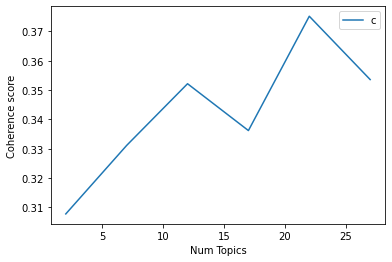

In [124]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_2018_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [125]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_2018_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.3078
index: 1 | Num Topics = 7  has Coherence Value of 0.3311
index: 2 | Num Topics = 12  has Coherence Value of 0.3521
index: 3 | Num Topics = 17  has Coherence Value of 0.3362
index: 4 | Num Topics = 22  has Coherence Value of 0.3751
index: 5 | Num Topics = 27  has Coherence Value of 0.3536


In [183]:
# Select optimal number of topics
optimal_model_sg_2018_score1N2N3 = model_list_sg_2018_score1N2N3[4]

In [184]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_2018_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_sg_2018_score1N2N3, corpus_sg_2018_score1N2N3, id2word_sg_2018_score1N2N3)

In [185]:
print("pyLDAVis for SG topics for score=1,2,3 in 2018:")
vis_sg_2018_score1N2N3

pyLDAVis for SG topics for score=1,2,3 in 2018:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16     0.174051 -0.029322       1        1  10.736576
3     -0.031721 -0.087794       2        1   9.611488
17     0.156682  0.023807       3        1   7.176156
9      0.012004  0.060506       4        1   7.098615
1      0.134451 -0.002983       5        1   7.032971
5      0.037799  0.010374       6        1   5.855599
6      0.040592  0.171170       7        1   5.347931
13     0.094746 -0.115363       8        1   5.193935
0      0.091135  0.001635       9        1   5.181916
20    -0.008213  0.088098      10        1   4.208403
10     0.045741  0.071285      11        1   3.872687
18    -0.102208 -0.055245      12        1   3.738193
19    -0.004449 -0.095379      13        1   3.615059
15    -0.044812 -0.007774      14        1   3.526962
7      0.012449 -0.074987      15        1   3.232755
21    -0.131452 -0.081306      16        1   3.097311
2     -0.091239  0.144107      17        1   2.662782
11    -0.147538 -0.119683      18        1   2.304018
8      0.069492 -0.062755      19        1   2.027028
14    -0.055984  0.040281      20        1   1.753624
4     -0.118415  0.085059      21        1   1.691845
12    -0.133112  0.036270      22        1   1.034146, topic_info=        Term       Freq       Total Category  logprob  loglift
21     video   43.00000   43.000000  Default  30.0000  30.0000
53     crash   37.00000   37.000000  Default  29.0000  29.0000
9     update  106.00000  106.000000  Default  28.0000  28.0000
25     photo   23.00000   23.000000  Default  27.0000  27.0000
23     album   16.00000   16.000000  Default  26.0000  26.0000
..       ...        ...         ...      ...      ...      ...
0        app    0.02526  105.532946  Topic22  -7.0989  -3.7660
4       late    0.02526   25.393794  Topic22  -7.0989  -2.3415
9     update    0.02526  106.854042  Topic22  -7.0989  -3.7784
10   version    0.02526   19.817663  Topic22  -7.0989  -2.0935
199    crush    0.02526    3.308717  Topic22  -7.0989  -0.3035

[1100 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
189       1  0.239049            able
189       3  0.358573            able
189       4  0.119524            able
189       5  0.119524            able
189       7  0.119524            able
...     ...       ...             ...
245       3  0.620147             yet
341       8  0.640324            zucc
177       8  0.640324         一直加载不会动
564       8  0.640336  为什么更新了过后搜寻不到视频
178       8  0.640324       我看不到别人的直播

[1498 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 4, 18, 10, 2, 6, 7, 14, 1, 21, 11, 19, 20, 16, 8, 22, 3, 12, 9, 15, 5, 13])

## By-rating of 2019 (Rating=1,2,3)

In [129]:
# By-rating Topic Modelling - rating = 1,2,3 in 2019
# Convert to list - move to each section
review_sg_2019_score1N2N3 = facebook_ios_sg_review_YearMonth_2019_score1N2N3.review.values.tolist()
review_words_sg_2019_score1N2N3 = list(sent_to_words(review_sg_2019_score1N2N3))
print(review_words_sg_2019_score1N2N3[:1])

[['crap', 'enough', 'said']]


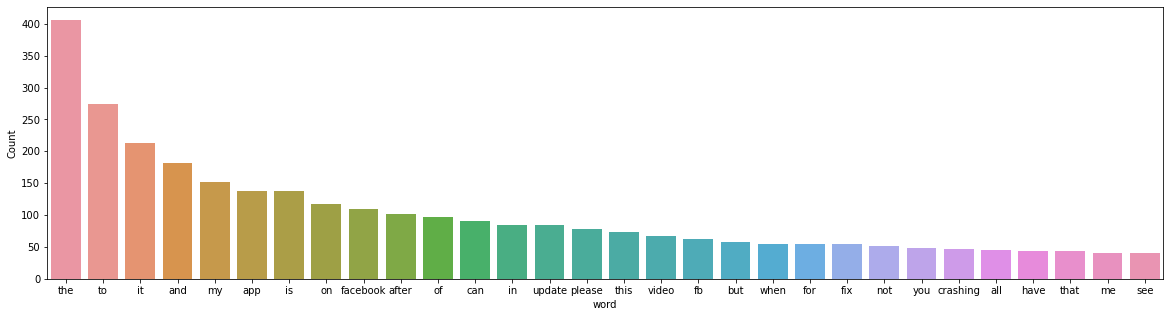

In [130]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_2019_score1N2N3))

In [131]:
# Clean text
review_words_sg_ready_2019_score1N2N3 = process_words(review_words_sg_2019_score1N2N3)  # processed Text Data! - move to each section

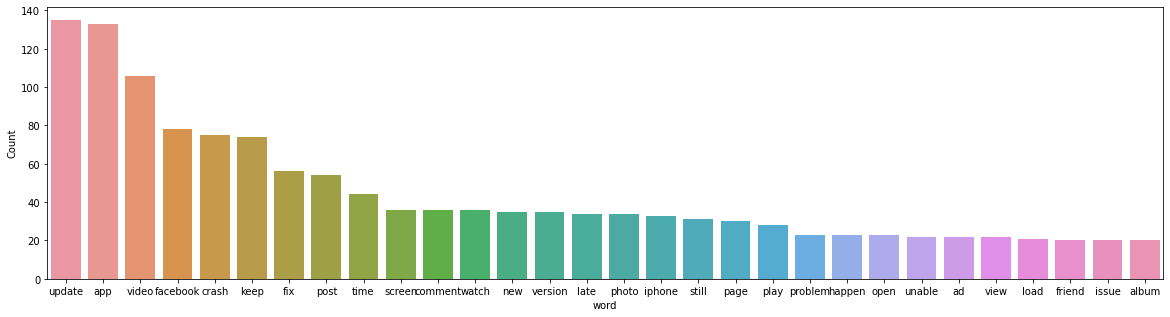

In [132]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_sg_ready_2019_score1N2N3))


In [133]:
# Create Dictionary
id2word_sg_2019_score1N2N3 = corpora.Dictionary(review_words_sg_ready_2019_score1N2N3)

2021-10-16 19:00:53,331 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 19:00:53,349 [INFO] gensim.corpora.dictionary - built Dictionary(847 unique tokens: ['crap', 'enough', 'become', 'column', 'feed']...) from 370 documents (total 3659 corpus positions)
2021-10-16 19:00:53,351 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(847 unique tokens: ['crap', 'enough', 'become', 'column', 'feed']...) from 370 documents (total 3659 corpus positions)", 'datetime': '2021-10-16T19:00:53.351225', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [134]:
# Create Corpus: Term Document Frequency
corpus_sg_2019_score1N2N3 = [id2word_sg_2019_score1N2N3.doc2bow(text) for text in review_words_sg_ready_2019_score1N2N3]

In [135]:
# Training LDA model
model_list_sg_2019_score1N2N3, coherence_values_sg_2019_score1N2N3 = compute_coherence_values(dictionary=id2word_sg_2019_score1N2N3, corpus=corpus_sg_2019_score1N2N3, 
                                                              texts=review_words_sg_ready_2019_score1N2N3, limit=30, start=2, step=5)


2021-10-16 19:00:54,133 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 19:00:54,135 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 19:00:54,138 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 19:00:54,142 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 370 documents, updating model once every 370 documents, evaluating perplexity every 370 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 19:00:55,746 [INFO] gensim.models.ldamodel - -7.360 per-word bound, 164.3 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:00:55,754 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #370/370
2021-10-16 19:00:57,077 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.031*"app" + 0.029*"video" + 0.029*"update" + 0.019*"facebook" + 0.018*"fix" + 0.017*"keep" + 0.015*"cr

2021-10-16 19:01:07,323 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.029*"update" + 0.025*"app" + 0.014*"keep" + 0.014*"time" + 0.014*"crash" + 0.013*"facebook" + 0.009*"change" + 0.008*"fb" + 0.008*"post" + 0.008*"group"
2021-10-16 19:01:07,325 [INFO] gensim.models.ldamodel - topic diff=0.013952, rho=0.301511
2021-10-16 19:01:07,867 [INFO] gensim.models.ldamodel - -6.160 per-word bound, 71.5 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:01:07,868 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #370/370
2021-10-16 19:01:08,323 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.033*"video" + 0.032*"app" + 0.031*"update" + 0.020*"facebook" + 0.019*"crash" + 0.019*"fix" + 0.018*"keep" + 0.015*"post" + 0.012*"photo" + 0.012*"screen"
2021-10-16 19:01:08,325 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.028*"update" + 0.025*"app" + 0.014*"time" + 0.014*"keep" + 0.013*"crash" + 0.013*"facebook" + 0.009*"change" + 0.0

2021-10-16 19:01:17,718 [INFO] gensim.models.ldamodel - topic diff=0.008997, rho=0.218218
2021-10-16 19:01:18,583 [INFO] gensim.models.ldamodel - -6.147 per-word bound, 70.9 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:01:18,585 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #370/370
2021-10-16 19:01:19,180 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.034*"update" + 0.033*"video" + 0.033*"app" + 0.023*"crash" + 0.020*"facebook" + 0.020*"keep" + 0.019*"fix" + 0.015*"post" + 0.012*"photo" + 0.012*"late"
2021-10-16 19:01:19,182 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.023*"update" + 0.023*"app" + 0.013*"time" + 0.013*"facebook" + 0.011*"keep" + 0.009*"change" + 0.009*"back" + 0.008*"fb" + 0.008*"group" + 0.008*"last"
2021-10-16 19:01:19,183 [INFO] gensim.models.ldamodel - topic diff=0.008568, rho=0.213201
2021-10-16 19:01:19,947 [INFO] gensim.models.ldamodel - -6.146 per-word bound, 70.8 perplexity estimate

2021-10-16 19:01:28,803 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #370/370
2021-10-16 19:01:29,077 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.036*"update" + 0.034*"app" + 0.033*"video" + 0.025*"crash" + 0.021*"keep" + 0.020*"facebook" + 0.019*"fix" + 0.016*"post" + 0.012*"photo" + 0.012*"late"
2021-10-16 19:01:29,078 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.023*"app" + 0.020*"update" + 0.014*"facebook" + 0.012*"time" + 0.010*"change" + 0.009*"keep" + 0.009*"back" + 0.009*"remove" + 0.008*"fb" + 0.008*"user"
2021-10-16 19:01:29,080 [INFO] gensim.models.ldamodel - topic diff=0.005971, rho=0.176777
2021-10-16 19:01:29,577 [INFO] gensim.models.ldamodel - -6.137 per-word bound, 70.4 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:01:29,579 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #370/370
2021-10-16 19:01:29,956 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.036*"update" + 0.034

2021-10-16 19:01:37,475 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.022*"app" + 0.019*"update" + 0.014*"facebook" + 0.012*"time" + 0.010*"ad" + 0.010*"change" + 0.009*"remove" + 0.009*"back" + 0.008*"user" + 0.008*"fb"
2021-10-16 19:01:37,476 [INFO] gensim.models.ldamodel - topic diff=0.003816, rho=0.154303
2021-10-16 19:01:37,950 [INFO] gensim.models.ldamodel - -6.132 per-word bound, 70.1 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:01:37,951 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #370/370
2021-10-16 19:01:38,307 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.037*"update" + 0.034*"app" + 0.033*"video" + 0.026*"crash" + 0.022*"keep" + 0.020*"facebook" + 0.019*"fix" + 0.016*"post" + 0.012*"photo" + 0.012*"late"
2021-10-16 19:01:38,308 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.022*"app" + 0.019*"update" + 0.014*"facebook" + 0.011*"time" + 0.010*"ad" + 0.010*"change" + 0.009*"remove" + 0.009*"b

2021-10-16 19:01:50,289 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 340 virtual documents
2021-10-16 19:01:50,549 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 19:01:50,551 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 19:01:50,555 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 19:01:50,559 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 370 documents, updating model once every 370 documents, evaluating perplexity every 370 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 19:01:51,402 [INFO] gensim.models.ldamodel - -9.001 per-word bound, 512.5 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:01:51,403 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #370/370
2021-10-16 19:01

2021-10-16 19:01:56,156 [INFO] gensim.models.ldamodel - -6.447 per-word bound, 87.3 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:01:56,170 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #370/370
2021-10-16 19:01:56,482 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.071*"crash" + 0.061*"update" + 0.057*"keep" + 0.055*"app" + 0.034*"fix" + 0.023*"late" + 0.018*"post" + 0.015*"new" + 0.014*"facebook" + 0.013*"version"
2021-10-16 19:01:56,484 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.040*"video" + 0.032*"watch" + 0.018*"facebook" + 0.018*"view" + 0.017*"comment" + 0.014*"ad" + 0.013*"already" + 0.011*"annoying" + 0.011*"page" + 0.011*"bad"
2021-10-16 19:01:56,486 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.041*"app" + 0.032*"photo" + 0.029*"update" + 0.023*"facebook" + 0.022*"video" + 0.021*"album" + 0.020*"iphone" + 0.018*"screen" + 0.018*"post" + 0.013*"fix"
2021-10-16 19:01:56,488 [INFO] gensim.models

2021-10-16 19:02:00,367 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.076*"crash" + 0.067*"update" + 0.060*"app" + 0.059*"keep" + 0.034*"fix" + 0.024*"late" + 0.018*"new" + 0.018*"post" + 0.016*"facebook" + 0.014*"version"
2021-10-16 19:02:00,373 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.032*"facebook" + 0.031*"video" + 0.023*"still" + 0.020*"play" + 0.020*"app" + 0.017*"keep" + 0.017*"comment" + 0.016*"update" + 0.013*"screen" + 0.013*"ad"
2021-10-16 19:02:00,377 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.041*"update" + 0.026*"app" + 0.016*"last" + 0.014*"much" + 0.013*"time" + 0.013*"advertisement" + 0.012*"new" + 0.012*"video" + 0.011*"look" + 0.011*"stop"
2021-10-16 19:02:00,381 [INFO] gensim.models.ldamodel - topic diff=0.016156, rho=0.288675
2021-10-16 19:02:00,830 [INFO] gensim.models.ldamodel - -6.414 per-word bound, 85.3 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:02:00,831 [INFO] gensim.models.ldamodel

2021-10-16 19:02:04,321 [INFO] gensim.models.ldamodel - topic diff=0.006535, rho=0.242536
2021-10-16 19:02:04,770 [INFO] gensim.models.ldamodel - -6.408 per-word bound, 84.9 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:02:04,774 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #370/370
2021-10-16 19:02:05,121 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.049*"video" + 0.028*"post" + 0.019*"update" + 0.018*"comment" + 0.016*"watch" + 0.015*"time" + 0.014*"version" + 0.014*"live" + 0.014*"fix" + 0.012*"sound"
2021-10-16 19:02:05,124 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.047*"video" + 0.032*"watch" + 0.018*"ad" + 0.016*"facebook" + 0.016*"view" + 0.016*"comment" + 0.016*"annoying" + 0.015*"already" + 0.011*"page" + 0.011*"bad"
2021-10-16 19:02:05,128 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.038*"update" + 0.024*"app" + 0.015*"last" + 0.014*"advertisement" + 0.014*"much" + 0.013*"time" + 0.013*"st

2021-10-16 19:02:09,280 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.037*"app" + 0.035*"photo" + 0.027*"update" + 0.023*"facebook" + 0.022*"album" + 0.022*"video" + 0.018*"screen" + 0.018*"post" + 0.018*"iphone" + 0.014*"fix"
2021-10-16 19:02:09,282 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.077*"crash" + 0.073*"update" + 0.062*"app" + 0.059*"keep" + 0.033*"fix" + 0.025*"late" + 0.019*"new" + 0.018*"post" + 0.017*"facebook" + 0.015*"version"
2021-10-16 19:02:09,285 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.032*"video" + 0.032*"facebook" + 0.023*"still" + 0.021*"play" + 0.019*"app" + 0.017*"comment" + 0.016*"keep" + 0.013*"screen" + 0.013*"ad" + 0.013*"live"
2021-10-16 19:02:09,287 [INFO] gensim.models.ldamodel - topic diff=0.003706, rho=0.208514
2021-10-16 19:02:09,942 [INFO] gensim.models.ldamodel - -6.404 per-word bound, 84.7 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:02:09,947 [INFO] gensim.models.ldamodel 

2021-10-16 19:02:14,060 [INFO] gensim.models.ldamodel - topic diff=0.002734, rho=0.188982
2021-10-16 19:02:14,485 [INFO] gensim.models.ldamodel - -6.402 per-word bound, 84.6 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:02:14,486 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #370/370
2021-10-16 19:02:14,814 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.033*"video" + 0.032*"facebook" + 0.023*"still" + 0.021*"play" + 0.019*"app" + 0.017*"comment" + 0.016*"keep" + 0.013*"screen" + 0.013*"ad" + 0.013*"live"
2021-10-16 19:02:14,816 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.076*"crash" + 0.074*"update" + 0.062*"app" + 0.059*"keep" + 0.033*"fix" + 0.026*"late" + 0.019*"new" + 0.018*"post" + 0.018*"facebook" + 0.016*"version"
2021-10-16 19:02:14,818 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.048*"video" + 0.027*"post" + 0.018*"update" + 0.018*"comment" + 0.016*"watch" + 0.015*"time" + 0.014*"live" + 0.014

2021-10-16 19:02:18,669 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.033*"video" + 0.032*"facebook" + 0.023*"still" + 0.022*"play" + 0.019*"app" + 0.017*"comment" + 0.015*"keep" + 0.014*"account" + 0.013*"live" + 0.013*"screen"
2021-10-16 19:02:18,671 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.049*"video" + 0.033*"watch" + 0.019*"ad" + 0.016*"annoying" + 0.016*"facebook" + 0.016*"view" + 0.016*"comment" + 0.015*"already" + 0.013*"bar" + 0.011*"page"
2021-10-16 19:02:18,674 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.037*"update" + 0.024*"app" + 0.015*"advertisement" + 0.014*"last" + 0.014*"much" + 0.013*"stop" + 0.013*"time" + 0.012*"new" + 0.012*"video" + 0.011*"look"
2021-10-16 19:02:18,676 [INFO] gensim.models.ldamodel - topic diff=0.002006, rho=0.171499
2021-10-16 19:02:19,344 [INFO] gensim.models.ldamodel - -6.400 per-word bound, 84.5 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:02:19,345 [INFO] gensim.models

2021-10-16 19:02:22,855 [INFO] gensim.models.ldamodel - topic diff=0.001622, rho=0.160128
2021-10-16 19:02:23,324 [INFO] gensim.models.ldamodel - -6.399 per-word bound, 84.4 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:02:23,325 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #370/370
2021-10-16 19:02:23,663 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.075*"crash" + 0.075*"update" + 0.063*"app" + 0.059*"keep" + 0.033*"fix" + 0.026*"late" + 0.019*"new" + 0.019*"facebook" + 0.018*"post" + 0.016*"version"
2021-10-16 19:02:23,667 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.049*"video" + 0.033*"watch" + 0.019*"ad" + 0.016*"annoying" + 0.016*"view" + 0.016*"comment" + 0.015*"facebook" + 0.014*"already" + 0.013*"bar" + 0.011*"page"
2021-10-16 19:02:23,671 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.034*"video" + 0.032*"facebook" + 0.023*"still" + 0.022*"play" + 0.019*"app" + 0.017*"comment" + 0.015*"keep" +

2021-10-16 19:02:27,487 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.075*"update" + 0.075*"crash" + 0.063*"app" + 0.059*"keep" + 0.033*"fix" + 0.027*"late" + 0.019*"facebook" + 0.019*"new" + 0.018*"post" + 0.016*"version"
2021-10-16 19:02:27,491 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.035*"photo" + 0.034*"app" + 0.026*"update" + 0.022*"album" + 0.021*"facebook" + 0.020*"video" + 0.019*"screen" + 0.018*"post" + 0.015*"iphone" + 0.014*"open"
2021-10-16 19:02:27,498 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.048*"video" + 0.026*"post" + 0.018*"comment" + 0.017*"update" + 0.016*"watch" + 0.015*"time" + 0.014*"live" + 0.014*"fix" + 0.013*"version" + 0.012*"sound"
2021-10-16 19:02:27,503 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.049*"video" + 0.033*"watch" + 0.019*"ad" + 0.016*"annoying" + 0.016*"view" + 0.016*"comment" + 0.015*"facebook" + 0.014*"already" + 0.013*"bar" + 0.011*"page"
2021-10-16 19:02:27,504 [INFO] gensim.models.ldamodel - topic diff=0.0

2021-10-16 19:02:31,420 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.075*"update" + 0.074*"crash" + 0.064*"app" + 0.058*"keep" + 0.033*"fix" + 0.027*"late" + 0.020*"facebook" + 0.019*"new" + 0.018*"post" + 0.016*"version"
2021-10-16 19:02:31,426 [INFO] gensim.models.ldamodel - topic diff=0.001363, rho=0.141421
2021-10-16 19:02:31,853 [INFO] gensim.models.ldamodel - -6.396 per-word bound, 84.2 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:02:31,855 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #370/370
2021-10-16 19:02:32,171 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.035*"photo" + 0.034*"app" + 0.025*"update" + 0.022*"album" + 0.020*"video" + 0.020*"facebook" + 0.019*"screen" + 0.018*"post" + 0.015*"iphone" + 0.014*"open"
2021-10-16 19:02:32,175 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.075*"update" + 0.074*"crash" + 0.064*"app" + 0.058*"keep" + 0.033*"fix" + 0.027*"late" + 0.020*"facebook" + 0.0

2021-10-16 19:02:41,748 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.047*"facebook" + 0.044*"post" + 0.042*"crash" + 0.042*"update" + 0.031*"app" + 0.028*"keep" + 0.026*"video" + 0.015*"problem" + 0.014*"time" + 0.014*"fix"
2021-10-16 19:02:41,752 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.040*"keep" + 0.031*"update" + 0.028*"app" + 0.023*"page" + 0.019*"video" + 0.019*"comment" + 0.015*"fix" + 0.015*"facebook" + 0.013*"back" + 0.013*"iphone"
2021-10-16 19:02:41,755 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.092*"crash" + 0.072*"app" + 0.059*"update" + 0.058*"keep" + 0.039*"fix" + 0.031*"late" + 0.025*"version" + 0.020*"facebook" + 0.015*"open" + 0.014*"still"
2021-10-16 19:02:41,757 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.054*"video" + 0.034*"screen" + 0.028*"watch" + 0.021*"remove" + 0.015*"full" + 0.015*"show" + 0.014*"properly" + 0.013*"back" + 0.011*"look" + 0.011*"function"
2021-10-16 19:02:41,759 [INFO] gensim.models.ldamodel - topic diff=0

2021-10-16 19:02:45,725 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.053*"post" + 0.047*"facebook" + 0.039*"update" + 0.038*"crash" + 0.027*"app" + 0.025*"keep" + 0.023*"video" + 0.019*"time" + 0.018*"problem" + 0.016*"reinstall"
2021-10-16 19:02:45,727 [INFO] gensim.models.ldamodel - topic diff=0.040966, rho=0.316228
2021-10-16 19:02:46,201 [INFO] gensim.models.ldamodel - -6.560 per-word bound, 94.4 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:02:46,203 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #370/370
2021-10-16 19:02:46,723 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.037*"keep" + 0.028*"update" + 0.025*"page" + 0.024*"app" + 0.019*"video" + 0.017*"comment" + 0.017*"back" + 0.014*"facebook" + 0.013*"different" + 0.013*"click"
2021-10-16 19:02:46,726 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.049*"video" + 0.042*"update" + 0.034*"play" + 0.031*"app" + 0.018*"keep" + 0.017*"screen" + 0.016*"c

2021-10-16 19:02:51,831 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.033*"keep" + 0.026*"page" + 0.025*"update" + 0.023*"app" + 0.020*"video" + 0.018*"back" + 0.016*"comment" + 0.014*"different" + 0.014*"click" + 0.014*"facebook"
2021-10-16 19:02:51,832 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.052*"video" + 0.041*"update" + 0.036*"play" + 0.031*"app" + 0.018*"keep" + 0.017*"screen" + 0.017*"change" + 0.016*"facebook" + 0.015*"feature" + 0.015*"stop"
2021-10-16 19:02:51,834 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.047*"video" + 0.031*"annoying" + 0.026*"comment" + 0.024*"watch" + 0.023*"view" + 0.017*"bar" + 0.017*"account" + 0.017*"ad" + 0.016*"always" + 0.014*"find"
2021-10-16 19:02:51,835 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.058*"post" + 0.047*"facebook" + 0.036*"update" + 0.032*"crash" + 0.025*"app" + 0.022*"keep" + 0.021*"time" + 0.021*"video" + 0.019*"reinstall" + 0.019*"problem"
2021-10-16 19:02:51,837 [INFO] gensim.models.ldamodel - t

2021-10-16 19:02:55,700 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.059*"post" + 0.046*"facebook" + 0.034*"update" + 0.029*"crash" + 0.024*"app" + 0.022*"time" + 0.021*"reinstall" + 0.020*"problem" + 0.020*"video" + 0.020*"keep"
2021-10-16 19:02:55,702 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.037*"friend" + 0.031*"notification" + 0.019*"app" + 0.016*"size" + 0.016*"ad" + 0.016*"relative" + 0.012*"new" + 0.011*"still" + 0.011*"feed" + 0.011*"set"
2021-10-16 19:02:55,703 [INFO] gensim.models.ldamodel - topic diff=0.009376, rho=0.218218
2021-10-16 19:02:56,189 [INFO] gensim.models.ldamodel - -6.516 per-word bound, 91.5 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:02:56,190 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #370/370
2021-10-16 19:02:56,483 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.027*"update" + 0.018*"setting" + 0.018*"feed" + 0.014*"user" + 0.014*"later" + 0.014*"fb" + 0.014*"new" 

2021-10-16 19:03:00,221 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #370/370
2021-10-16 19:03:00,561 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.068*"photo" + 0.048*"app" + 0.040*"album" + 0.030*"iphone" + 0.021*"update" + 0.016*"view" + 0.016*"video" + 0.016*"open" + 0.015*"find" + 0.015*"unable"
2021-10-16 19:03:00,563 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.062*"video" + 0.037*"screen" + 0.035*"watch" + 0.028*"remove" + 0.019*"full" + 0.015*"show" + 0.015*"properly" + 0.013*"back" + 0.012*"top" + 0.011*"camera"
2021-10-16 19:03:00,565 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.049*"video" + 0.036*"post" + 0.026*"share" + 0.024*"click" + 0.022*"newsfeed" + 0.017*"scroll" + 0.017*"page" + 0.016*"appear" + 0.016*"play" + 0.016*"version"
2021-10-16 19:03:00,567 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.064*"comment" + 0.053*"live" + 0.019*"ipad" + 0.016*"fb" + 0.015*"still" + 0.013*"help" + 0.013*"time" + 0.013*"control" + 0.013

2021-10-16 19:03:04,311 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.038*"friend" + 0.031*"notification" + 0.018*"app" + 0.016*"size" + 0.016*"ad" + 0.016*"relative" + 0.011*"still" + 0.011*"feed" + 0.011*"set" + 0.011*"facebook"
2021-10-16 19:03:04,312 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.034*"load" + 0.030*"page" + 0.029*"time" + 0.023*"app" + 0.021*"update" + 0.020*"group" + 0.017*"issue" + 0.017*"help" + 0.015*"fix" + 0.013*"post"
2021-10-16 19:03:04,314 [INFO] gensim.models.ldamodel - topic diff=0.003992, rho=0.176777
2021-10-16 19:03:04,747 [INFO] gensim.models.ldamodel - -6.507 per-word bound, 90.9 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:03:04,748 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #370/370
2021-10-16 19:03:05,330 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.049*"video" + 0.036*"post" + 0.026*"share" + 0.025*"click" + 0.022*"newsfeed" + 0.018*"page" + 0.017*"scroll" + 0

2021-10-16 19:03:09,703 [INFO] gensim.models.ldamodel - PROGRESS: pass 36, at document #370/370
2021-10-16 19:03:10,004 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.107*"update" + 0.105*"crash" + 0.093*"app" + 0.067*"keep" + 0.056*"fix" + 0.051*"late" + 0.041*"version" + 0.037*"new" + 0.029*"facebook" + 0.018*"open"
2021-10-16 19:03:10,007 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.038*"friend" + 0.031*"notification" + 0.018*"app" + 0.016*"ad" + 0.016*"size" + 0.016*"relative" + 0.011*"still" + 0.011*"feed" + 0.011*"set" + 0.011*"facebook"
2021-10-16 19:03:10,010 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.069*"photo" + 0.046*"app" + 0.040*"album" + 0.029*"iphone" + 0.020*"update" + 0.016*"view" + 0.016*"open" + 0.016*"find" + 0.015*"video" + 0.015*"unable"
2021-10-16 19:03:10,014 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.049*"video" + 0.036*"post" + 0.026*"share" + 0.025*"click" + 0.022*"newsfeed" + 0.019*"page" + 0.017*"scroll" + 0.016*"appear" + 0.0

2021-10-16 19:03:13,732 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.069*"photo" + 0.046*"app" + 0.041*"album" + 0.029*"iphone" + 0.019*"update" + 0.016*"view" + 0.016*"open" + 0.016*"find" + 0.015*"video" + 0.015*"unable"
2021-10-16 19:03:13,736 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.055*"video" + 0.039*"update" + 0.037*"play" + 0.031*"app" + 0.018*"screen" + 0.018*"change" + 0.017*"facebook" + 0.017*"keep" + 0.016*"feature" + 0.015*"stop"
2021-10-16 19:03:13,739 [INFO] gensim.models.ldamodel - topic diff=0.002447, rho=0.152499
2021-10-16 19:03:14,191 [INFO] gensim.models.ldamodel - -6.501 per-word bound, 90.6 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:03:14,192 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #370/370
2021-10-16 19:03:14,405 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.066*"comment" + 0.053*"live" + 0.019*"ipad" + 0.016*"fb" + 0.015*"still" + 0.014*"help" + 0.013*"control" + 0

2021-10-16 19:03:17,769 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #370/370
2021-10-16 19:03:18,071 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.069*"photo" + 0.045*"app" + 0.041*"album" + 0.029*"iphone" + 0.019*"update" + 0.016*"view" + 0.016*"open" + 0.016*"find" + 0.015*"unable" + 0.015*"video"
2021-10-16 19:03:18,074 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.107*"update" + 0.106*"crash" + 0.096*"app" + 0.067*"keep" + 0.057*"fix" + 0.050*"late" + 0.039*"version" + 0.036*"new" + 0.031*"facebook" + 0.017*"open"
2021-10-16 19:03:18,078 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.049*"video" + 0.038*"post" + 0.027*"share" + 0.025*"click" + 0.022*"newsfeed" + 0.021*"page" + 0.017*"scroll" + 0.016*"appear" + 0.016*"play" + 0.016*"version"
2021-10-16 19:03:18,081 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.055*"video" + 0.039*"update" + 0.037*"play" + 0.031*"app" + 0.018*"screen" + 0.018*"change" + 0.017*"facebook" + 0.017*"keep" + 0.016

2021-10-16 19:03:29,347 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.040*"update" + 0.037*"post" + 0.027*"video" + 0.024*"fix" + 0.022*"share" + 0.017*"version" + 0.013*"late" + 0.013*"page" + 0.013*"crash" + 0.012*"new"
2021-10-16 19:03:29,350 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.060*"update" + 0.054*"crash" + 0.046*"app" + 0.039*"late" + 0.032*"keep" + 0.026*"video" + 0.019*"iphone" + 0.018*"version" + 0.015*"facebook" + 0.013*"day"
2021-10-16 19:03:29,351 [INFO] gensim.models.ldamodel - topic diff=0.122683, rho=0.577350
2021-10-16 19:03:29,760 [INFO] gensim.models.ldamodel - -6.877 per-word bound, 117.6 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:03:29,761 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #370/370
2021-10-16 19:03:30,086 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.053*"video" + 0.037*"comment" + 0.024*"view" + 0.020*"bar" + 0.020*"play" + 0.019*"issue" + 0.016*"photo" + 0.01

2021-10-16 19:03:33,750 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #370/370
2021-10-16 19:03:33,985 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.036*"post" + 0.031*"video" + 0.031*"update" + 0.030*"fix" + 0.026*"share" + 0.022*"version" + 0.016*"late" + 0.014*"bug" + 0.012*"access" + 0.012*"live"
2021-10-16 19:03:33,988 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.036*"update" + 0.028*"still" + 0.028*"page" + 0.026*"friend" + 0.024*"video" + 0.024*"feed" + 0.020*"home" + 0.020*"back" + 0.018*"app" + 0.016*"size"
2021-10-16 19:03:33,990 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.085*"video" + 0.025*"watch" + 0.025*"full" + 0.025*"time" + 0.025*"advertisement" + 0.024*"screen" + 0.021*"crash" + 0.021*"app" + 0.020*"play" + 0.020*"show"
2021-10-16 19:03:33,993 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.032*"screen" + 0.024*"feed" + 0.024*"turn" + 0.019*"control" + 0.015*"messenger" + 0.015*"add" + 0.015*"fb" + 0.015*"comment" + 0.015*"b

2021-10-16 19:03:37,494 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.034*"update" + 0.030*"page" + 0.028*"still" + 0.026*"friend" + 0.026*"feed" + 0.021*"home" + 0.021*"back" + 0.019*"video" + 0.017*"size" + 0.016*"app"
2021-10-16 19:03:37,496 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.052*"app" + 0.020*"fb" + 0.017*"update" + 0.016*"newsfeed" + 0.016*"account" + 0.016*"wrong" + 0.015*"tab" + 0.013*"version" + 0.012*"remove" + 0.012*"time"
2021-10-16 19:03:37,497 [INFO] gensim.models.ldamodel - topic diff=0.023382, rho=0.267261
2021-10-16 19:03:37,978 [INFO] gensim.models.ldamodel - -6.683 per-word bound, 102.8 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:03:37,979 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #370/370
2021-10-16 19:03:38,318 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.068*"facebook" + 0.032*"help" + 0.028*"live" + 0.026*"app" + 0.025*"comment" + 0.018*"fix" + 0.017*"update" + 0.

2021-10-16 19:03:41,741 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #370/370
2021-10-16 19:03:41,984 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.028*"feature" + 0.024*"app" + 0.023*"facebook" + 0.018*"bug" + 0.018*"issue" + 0.018*"privacy" + 0.018*"user" + 0.017*"never" + 0.015*"unable" + 0.014*"download"
2021-10-16 19:03:41,986 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.037*"update" + 0.035*"post" + 0.032*"facebook" + 0.023*"user" + 0.022*"app" + 0.019*"comment" + 0.017*"video" + 0.016*"interface" + 0.014*"fix" + 0.013*"old"
2021-10-16 19:03:42,007 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.081*"photo" + 0.049*"album" + 0.030*"app" + 0.022*"update" + 0.021*"view" + 0.019*"fix" + 0.016*"camera" + 0.016*"iphone" + 0.016*"phone" + 0.015*"post"
2021-10-16 19:03:42,019 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.107*"video" + 0.058*"play" + 0.039*"sound" + 0.030*"comment" + 0.028*"view" + 0.022*"issue" + 0.018*"bar" + 0.014*"screen" + 0

2021-10-16 19:03:46,839 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.035*"post" + 0.035*"fix" + 0.027*"video" + 0.026*"update" + 0.024*"share" + 0.023*"version" + 0.020*"bug" + 0.017*"late" + 0.016*"access" + 0.012*"comment"
2021-10-16 19:03:46,841 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.044*"post" + 0.037*"update" + 0.032*"keep" + 0.028*"comment" + 0.025*"notification" + 0.021*"log" + 0.020*"group" + 0.018*"new" + 0.017*"problem" + 0.016*"recent"
2021-10-16 19:03:46,842 [INFO] gensim.models.ldamodel - topic diff=0.007452, rho=0.200000
2021-10-16 19:03:47,207 [INFO] gensim.models.ldamodel - -6.650 per-word bound, 100.4 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:03:47,208 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #370/370
2021-10-16 19:03:47,463 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.052*"app" + 0.021*"fb" + 0.017*"update" + 0.016*"newsfeed" + 0.016*"account" + 0.016*"wrong" + 0.016*"

2021-10-16 19:03:50,746 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #370/370
2021-10-16 19:03:50,968 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.039*"change" + 0.035*"update" + 0.031*"look" + 0.023*"last" + 0.023*"new" + 0.020*"time" + 0.018*"video" + 0.016*"reset" + 0.016*"click" + 0.016*"cause"
2021-10-16 19:03:50,971 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.034*"facebook" + 0.031*"load" + 0.025*"friend" + 0.025*"new" + 0.022*"page" + 0.019*"version" + 0.015*"old" + 0.015*"link" + 0.015*"interface" + 0.011*"app"
2021-10-16 19:03:50,975 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.109*"crash" + 0.091*"update" + 0.089*"app" + 0.065*"keep" + 0.043*"late" + 0.033*"fix" + 0.028*"iphone" + 0.022*"facebook" + 0.020*"version" + 0.019*"new"
2021-10-16 19:03:50,979 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.048*"app" + 0.028*"video" + 0.025*"update" + 0.025*"ad" + 0.022*"screen" + 0.017*"keep" + 0.015*"facebook" + 0.014*"bad" + 0.014*"sto

2021-10-16 19:03:54,592 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.109*"crash" + 0.091*"update" + 0.090*"app" + 0.065*"keep" + 0.043*"late" + 0.033*"fix" + 0.028*"iphone" + 0.022*"facebook" + 0.020*"version" + 0.019*"new"
2021-10-16 19:03:54,593 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.065*"facebook" + 0.033*"help" + 0.029*"live" + 0.027*"comment" + 0.024*"app" + 0.018*"fix" + 0.018*"close" + 0.015*"notification" + 0.015*"freeze" + 0.015*"error"
2021-10-16 19:03:54,597 [INFO] gensim.models.ldamodel - topic diff=0.003307, rho=0.166667
2021-10-16 19:03:54,995 [INFO] gensim.models.ldamodel - -6.641 per-word bound, 99.8 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:03:54,997 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #370/370
2021-10-16 19:03:55,327 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.034*"facebook" + 0.031*"load" + 0.025*"friend" + 0.025*"new" + 0.022*"page" + 0.019*"version" + 0.015

2021-10-16 19:03:58,755 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #370/370
2021-10-16 19:03:59,086 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.049*"app" + 0.021*"fb" + 0.017*"update" + 0.016*"newsfeed" + 0.016*"account" + 0.016*"wrong" + 0.016*"tab" + 0.015*"shut" + 0.013*"version" + 0.012*"remove"
2021-10-16 19:03:59,088 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.083*"photo" + 0.050*"album" + 0.029*"app" + 0.021*"update" + 0.021*"view" + 0.019*"fix" + 0.017*"camera" + 0.017*"phone" + 0.016*"iphone" + 0.015*"unable"
2021-10-16 19:03:59,089 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.046*"change" + 0.038*"update" + 0.032*"look" + 0.027*"last" + 0.023*"new" + 0.018*"video" + 0.016*"reset" + 0.016*"click" + 0.016*"cause" + 0.016*"check"
2021-10-16 19:03:59,091 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.031*"page" + 0.030*"update" + 0.027*"still" + 0.027*"friend" + 0.023*"home" + 0.023*"back" + 0.023*"feed" + 0.018*"size" + 0.014*"rela

2021-10-16 19:04:03,203 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.035*"fix" + 0.035*"post" + 0.026*"update" + 0.025*"video" + 0.024*"share" + 0.023*"version" + 0.020*"bug" + 0.017*"late" + 0.016*"access" + 0.012*"live"
2021-10-16 19:04:03,205 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.130*"video" + 0.056*"watch" + 0.035*"play" + 0.032*"annoying" + 0.027*"time" + 0.022*"screen" + 0.022*"advertisement" + 0.022*"full" + 0.021*"show" + 0.018*"jump"
2021-10-16 19:04:03,207 [INFO] gensim.models.ldamodel - topic diff=0.002170, rho=0.145865
2021-10-16 19:04:03,708 [INFO] gensim.models.ldamodel - -6.634 per-word bound, 99.3 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:04:03,709 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #370/370
2021-10-16 19:04:04,035 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.083*"photo" + 0.050*"album" + 0.028*"app" + 0.021*"view" + 0.021*"update" + 0.018*"fix" + 0.017*"camera" 

2021-10-16 19:04:15,326 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.035*"comment" + 0.024*"live" + 0.018*"control" + 0.018*"block" + 0.018*"messenger" + 0.018*"fb" + 0.018*"help" + 0.018*"app" + 0.012*"reminder" + 0.012*"secret"
2021-10-16 19:04:15,328 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.069*"update" + 0.050*"app" + 0.035*"crash" + 0.031*"fix" + 0.027*"late" + 0.027*"video" + 0.023*"new" + 0.023*"keep" + 0.019*"version" + 0.015*"annoying"
2021-10-16 19:04:15,330 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.039*"fix" + 0.038*"load" + 0.027*"app" + 0.023*"issue" + 0.023*"page" + 0.023*"sometimes" + 0.023*"friend" + 0.022*"time" + 0.016*"version" + 0.016*"scroll"
2021-10-16 19:04:15,332 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.048*"app" + 0.036*"photo" + 0.026*"album" + 0.025*"update" + 0.019*"screen" + 0.019*"iphone" + 0.018*"phone" + 0.015*"friend" + 0.013*"video" + 0.012*"add"
2021-10-16 19:04:15,333 [INFO] gensim.models.ldamodel - topic #2 (

2021-10-16 19:04:19,104 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.087*"update" + 0.052*"crash" + 0.046*"app" + 0.045*"late" + 0.040*"fix" + 0.039*"version" + 0.032*"new" + 0.029*"keep" + 0.022*"video" + 0.014*"bar"
2021-10-16 19:04:19,107 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.045*"fix" + 0.041*"load" + 0.030*"page" + 0.028*"bug" + 0.028*"picture" + 0.028*"time" + 0.027*"app" + 0.025*"friend" + 0.021*"issue" + 0.021*"sometimes"
2021-10-16 19:04:19,109 [INFO] gensim.models.ldamodel - topic diff=0.061949, rho=0.377964
2021-10-16 19:04:19,590 [INFO] gensim.models.ldamodel - -6.827 per-word bound, 113.5 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:04:19,592 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #370/370
2021-10-16 19:04:19,945 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.069*"update" + 0.058*"crash" + 0.048*"app" + 0.045*"fix" + 0.044*"facebook" + 0.042*"iphone" + 0.033*"keep" + 0.033*"

2021-10-16 19:04:23,758 [INFO] gensim.models.ldamodel - PROGRESS: pass 11, at document #370/370
2021-10-16 19:04:24,196 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.066*"video" + 0.035*"sound" + 0.033*"still" + 0.028*"app" + 0.026*"time" + 0.024*"feed" + 0.019*"post" + 0.019*"back" + 0.018*"reinstall" + 0.016*"scroll"
2021-10-16 19:04:24,198 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.103*"watch" + 0.098*"video" + 0.028*"jump" + 0.019*"update" + 0.019*"properly" + 0.019*"keep" + 0.019*"page" + 0.019*"frustrating" + 0.019*"load" + 0.019*"ad"
2021-10-16 19:04:24,200 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.048*"change" + 0.021*"setting" + 0.019*"app" + 0.019*"update" + 0.017*"keep" + 0.016*"size" + 0.016*"fix" + 0.016*"thing" + 0.016*"back" + 0.016*"facebook"
2021-10-16 19:04:24,202 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.108*"video" + 0.070*"play" + 0.037*"keep" + 0.027*"annoying" + 0.021*"camera" + 0.021*"turn" + 0.021*"mode" + 0.020*"screen" + 

2021-10-16 19:04:28,628 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.033*"app" + 0.028*"keep" + 0.024*"update" + 0.023*"video" + 0.023*"page" + 0.023*"close" + 0.022*"back" + 0.021*"fix" + 0.020*"post" + 0.019*"home"
2021-10-16 19:04:28,630 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.049*"post" + 0.049*"crash" + 0.043*"comment" + 0.040*"update" + 0.035*"app" + 0.026*"group" + 0.023*"keep" + 0.023*"notification" + 0.017*"problem" + 0.013*"tap"
2021-10-16 19:04:28,632 [INFO] gensim.models.ldamodel - topic diff=0.013622, rho=0.235702
2021-10-16 19:04:29,068 [INFO] gensim.models.ldamodel - -6.762 per-word bound, 108.5 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:04:29,069 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #370/370
2021-10-16 19:04:29,356 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.021*"app" + 0.020*"video" + 0.020*"work" + 0.019*"still" + 0.017*"fix" + 0.017*"facebook" + 0.013*"exit" + 0.

2021-10-16 19:04:32,760 [INFO] gensim.models.ldamodel - PROGRESS: pass 22, at document #370/370
2021-10-16 19:04:33,071 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.027*"post" + 0.021*"click" + 0.014*"app" + 0.014*"share" + 0.014*"control" + 0.014*"iphone" + 0.014*"people" + 0.014*"group" + 0.014*"reload" + 0.014*"open"
2021-10-16 19:04:33,073 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.055*"post" + 0.048*"comment" + 0.031*"update" + 0.030*"group" + 0.026*"app" + 0.026*"notification" + 0.024*"crash" + 0.018*"problem" + 0.015*"tap" + 0.015*"live"
2021-10-16 19:04:33,074 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.043*"video" + 0.034*"facebook" + 0.034*"watch" + 0.027*"update" + 0.021*"post" + 0.018*"app" + 0.017*"privacy" + 0.017*"min" + 0.013*"time" + 0.013*"ad"
2021-10-16 19:04:33,077 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.052*"feed" + 0.048*"find" + 0.040*"photo" + 0.030*"news" + 0.029*"album" + 0.020*"unable" + 0.020*"link" + 0.020*"command" + 

2021-10-16 19:04:36,922 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.142*"video" + 0.073*"play" + 0.047*"annoying" + 0.032*"watch" + 0.031*"camera" + 0.030*"keep" + 0.025*"screen" + 0.024*"mode" + 0.023*"turn" + 0.017*"pause"
2021-10-16 19:04:36,925 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.068*"video" + 0.038*"sound" + 0.036*"still" + 0.028*"time" + 0.024*"feed" + 0.024*"app" + 0.019*"post" + 0.019*"back" + 0.019*"delete" + 0.018*"reinstall"
2021-10-16 19:04:36,926 [INFO] gensim.models.ldamodel - topic diff=0.007038, rho=0.185695
2021-10-16 19:04:37,508 [INFO] gensim.models.ldamodel - -6.729 per-word bound, 106.0 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:04:37,526 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #370/370
2021-10-16 19:04:37,858 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.101*"watch" + 0.099*"video" + 0.027*"jump" + 0.027*"frustrating" + 0.019*"keep" + 0.019*"update" + 0.019*"p

2021-10-16 19:04:41,092 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #370/370
2021-10-16 19:04:41,450 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.046*"share" + 0.030*"newsfeed" + 0.028*"post" + 0.023*"video" + 0.018*"access" + 0.018*"fix" + 0.018*"load" + 0.018*"click" + 0.018*"day" + 0.018*"problem"
2021-10-16 19:04:41,451 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.043*"video" + 0.034*"facebook" + 0.034*"watch" + 0.027*"update" + 0.021*"post" + 0.018*"app" + 0.017*"privacy" + 0.017*"min" + 0.013*"time" + 0.013*"ad"
2021-10-16 19:04:41,452 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.118*"crash" + 0.093*"app" + 0.086*"update" + 0.073*"keep" + 0.057*"facebook" + 0.041*"iphone" + 0.036*"fix" + 0.018*"open" + 0.018*"io" + 0.016*"happen"
2021-10-16 19:04:41,453 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.068*"video" + 0.039*"sound" + 0.036*"still" + 0.029*"time" + 0.024*"feed" + 0.023*"app" + 0.019*"post" + 0.019*"back" + 0.019*"delete" 

2021-10-16 19:04:45,204 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.101*"watch" + 0.099*"video" + 0.028*"frustrating" + 0.027*"jump" + 0.019*"keep" + 0.019*"update" + 0.019*"properly" + 0.019*"page" + 0.019*"load" + 0.019*"ad"
2021-10-16 19:04:45,205 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.115*"update" + 0.065*"version" + 0.064*"late" + 0.062*"crash" + 0.061*"new" + 0.058*"app" + 0.036*"keep" + 0.034*"fix" + 0.014*"facebook" + 0.014*"check"
2021-10-16 19:04:45,206 [INFO] gensim.models.ldamodel - topic diff=0.004442, rho=0.158114
2021-10-16 19:04:45,702 [INFO] gensim.models.ldamodel - -6.710 per-word bound, 104.7 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:04:45,703 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #370/370
2021-10-16 19:04:46,009 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.057*"facebook" + 0.026*"account" + 0.019*"happen" + 0.019*"function" + 0.019*"ad" + 0.015*"view" + 0.015*

2021-10-16 19:04:49,392 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #370/370
2021-10-16 19:04:49,706 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.067*"video" + 0.041*"still" + 0.038*"sound" + 0.031*"time" + 0.024*"feed" + 0.022*"app" + 0.019*"post" + 0.019*"back" + 0.019*"delete" + 0.017*"reinstall"
2021-10-16 19:04:49,707 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.060*"post" + 0.053*"comment" + 0.037*"group" + 0.029*"notification" + 0.023*"update" + 0.021*"problem" + 0.017*"app" + 0.017*"tap" + 0.017*"live" + 0.017*"anymore"
2021-10-16 19:04:49,708 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.049*"app" + 0.035*"photo" + 0.028*"update" + 0.024*"phone" + 0.021*"album" + 0.017*"friend" + 0.016*"screen" + 0.014*"add" + 0.014*"much" + 0.014*"upload"
2021-10-16 19:04:49,709 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.057*"facebook" + 0.026*"account" + 0.019*"happen" + 0.019*"function" + 0.019*"ad" + 0.015*"view" + 0.015*"disable" + 0.015*

2021-10-16 19:04:53,360 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.101*"watch" + 0.099*"video" + 0.028*"frustrating" + 0.027*"jump" + 0.019*"keep" + 0.019*"update" + 0.019*"properly" + 0.019*"page" + 0.019*"load" + 0.019*"ad"
2021-10-16 19:04:53,361 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.067*"feed" + 0.048*"news" + 0.047*"find" + 0.039*"photo" + 0.029*"album" + 0.025*"update" + 0.019*"unable" + 0.019*"command" + 0.019*"link" + 0.019*"old"
2021-10-16 19:04:53,362 [INFO] gensim.models.ldamodel - topic diff=0.002505, rho=0.140028
2021-10-16 19:04:53,363 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=847, num_topics=22, decay=0.5, chunksize=1000) in 39.42s', 'datetime': '2021-10-16T19:04:53.363773', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 19:04:53,374 [INFO] gensim.topic_coherence.probability_estimation - usi

2021-10-16 19:05:05,475 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #370/370
2021-10-16 19:05:05,739 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.104*"crash" + 0.072*"update" + 0.070*"keep" + 0.069*"facebook" + 0.068*"app" + 0.039*"fix" + 0.026*"late" + 0.020*"happen" + 0.017*"help" + 0.015*"freeze"
2021-10-16 19:05:05,741 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.057*"comment" + 0.045*"facebook" + 0.031*"view" + 0.027*"account" + 0.020*"happen" + 0.020*"disable" + 0.020*"scroll" + 0.020*"back" + 0.018*"find" + 0.013*"key"
2021-10-16 19:05:05,744 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.039*"update" + 0.026*"recent" + 0.019*"possible" + 0.019*"soon" + 0.019*"refuse" + 0.019*"sometimes" + 0.019*"knowledge" + 0.019*"push" + 0.019*"force" + 0.019*"pro"
2021-10-16 19:05:05,746 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.048*"video" + 0.028*"post" + 0.028*"interface" + 0.027*"old" + 0.026*"new" + 0.025*"app" + 0.023*"late" + 0.022*"f

2021-10-16 19:05:09,313 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.063*"photo" + 0.043*"album" + 0.032*"app" + 0.029*"screen" + 0.024*"phone" + 0.020*"open" + 0.020*"update" + 0.017*"unable" + 0.017*"iphone" + 0.016*"exit"
2021-10-16 19:05:09,317 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.069*"video" + 0.038*"play" + 0.032*"screen" + 0.029*"update" + 0.026*"feature" + 0.023*"friend" + 0.022*"mode" + 0.020*"turn" + 0.019*"app" + 0.018*"user"
2021-10-16 19:05:09,318 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.059*"change" + 0.053*"update" + 0.035*"problem" + 0.027*"setting" + 0.027*"day" + 0.023*"back" + 0.021*"fix" + 0.020*"auto" + 0.018*"user" + 0.018*"review"
2021-10-16 19:05:09,319 [INFO] gensim.models.ldamodel - topic diff=0.037370, rho=0.301511
2021-10-16 19:05:09,558 [INFO] gensim.models.ldamodel - -6.859 per-word bound, 116.1 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:05:09,559 [INFO] gensim.models.ldam

2021-10-16 19:05:12,598 [INFO] gensim.models.ldamodel - topic diff=0.018886, rho=0.250000
2021-10-16 19:05:13,041 [INFO] gensim.models.ldamodel - -6.832 per-word bound, 113.9 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:05:13,045 [INFO] gensim.models.ldamodel - PROGRESS: pass 15, at document #370/370
2021-10-16 19:05:13,231 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.063*"comment" + 0.049*"facebook" + 0.037*"view" + 0.032*"account" + 0.024*"happen" + 0.019*"disable" + 0.019*"back" + 0.019*"scroll" + 0.018*"find" + 0.014*"version"
2021-10-16 19:05:13,233 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.077*"video" + 0.040*"play" + 0.032*"screen" + 0.031*"update" + 0.026*"feature" + 0.022*"friend" + 0.022*"mode" + 0.020*"turn" + 0.018*"user" + 0.018*"camera"
2021-10-16 19:05:13,234 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.033*"video" + 0.028*"photo" + 0.027*"album" + 0.024*"update" + 0.021*"remove" + 0.021*"advertis

2021-10-16 19:05:16,619 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.063*"change" + 0.045*"problem" + 0.038*"update" + 0.027*"setting" + 0.027*"day" + 0.027*"auto" + 0.024*"back" + 0.020*"fix" + 0.018*"user" + 0.018*"review"
2021-10-16 19:05:16,622 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.038*"post" + 0.036*"sign" + 0.028*"read" + 0.028*"messenger" + 0.028*"notification" + 0.027*"group" + 0.019*"red" + 0.019*"reminder" + 0.019*"feed" + 0.019*"column"
2021-10-16 19:05:16,624 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.077*"video" + 0.041*"play" + 0.032*"update" + 0.031*"screen" + 0.026*"feature" + 0.023*"friend" + 0.023*"mode" + 0.021*"turn" + 0.019*"user" + 0.019*"camera"
2021-10-16 19:05:16,628 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.033*"video" + 0.028*"photo" + 0.027*"album" + 0.024*"update" + 0.022*"remove" + 0.022*"advertisement" + 0.022*"page" + 0.021*"load" + 0.017*"play" + 0.017*"new"
2021-10-16 19:05:16,632 [INFO] gensim.models.ldamodel

2021-10-16 19:05:20,013 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.094*"video" + 0.058*"post" + 0.057*"pause" + 0.051*"play" + 0.047*"keep" + 0.046*"second" + 0.034*"sticker" + 0.033*"press" + 0.023*"newsfeed" + 0.019*"facebook"
2021-10-16 19:05:20,016 [INFO] gensim.models.ldamodel - topic diff=0.007947, rho=0.192450
2021-10-16 19:05:20,445 [INFO] gensim.models.ldamodel - -6.792 per-word bound, 110.8 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:05:20,445 [INFO] gensim.models.ldamodel - PROGRESS: pass 26, at document #370/370
2021-10-16 19:05:20,634 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.038*"post" + 0.037*"sign" + 0.028*"read" + 0.028*"messenger" + 0.028*"notification" + 0.024*"group" + 0.019*"red" + 0.019*"reminder" + 0.019*"feed" + 0.019*"column"
2021-10-16 19:05:20,637 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.086*"watch" + 0.067*"video" + 0.028*"properly" + 0.021*"play" + 0.021*"frequent" + 0.015*"h

2021-10-16 19:05:24,068 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.083*"watch" + 0.068*"video" + 0.028*"properly" + 0.021*"play" + 0.021*"frequent" + 0.015*"happen" + 0.014*"fix" + 0.014*"full" + 0.014*"switch" + 0.014*"mode"
2021-10-16 19:05:24,069 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.039*"version" + 0.033*"bug" + 0.032*"video" + 0.026*"issue" + 0.025*"share" + 0.023*"update" + 0.020*"sound" + 0.020*"back" + 0.020*"friend" + 0.020*"scroll"
2021-10-16 19:05:24,071 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.035*"pro" + 0.034*"recent" + 0.033*"ipad" + 0.026*"update" + 0.020*"optimise" + 0.020*"refuse" + 0.020*"push" + 0.020*"today" + 0.020*"fb" + 0.020*"knowledge"
2021-10-16 19:05:24,072 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.038*"post" + 0.038*"sign" + 0.029*"read" + 0.029*"messenger" + 0.028*"notification" + 0.023*"group" + 0.019*"red" + 0.019*"reminder" + 0.019*"feed" + 0.019*"column"
2021-10-16 19:05:24,074 [INFO] gensim.models.ldamode

2021-10-16 19:05:27,365 [INFO] gensim.models.ldamodel - topic #5 (0.037): 0.039*"version" + 0.033*"bug" + 0.033*"video" + 0.026*"issue" + 0.025*"share" + 0.020*"update" + 0.020*"sound" + 0.020*"back" + 0.020*"friend" + 0.020*"scroll"
2021-10-16 19:05:27,366 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.064*"change" + 0.046*"problem" + 0.036*"update" + 0.028*"auto" + 0.028*"day" + 0.028*"setting" + 0.024*"back" + 0.020*"fix" + 0.018*"user" + 0.018*"review"
2021-10-16 19:05:27,367 [INFO] gensim.models.ldamodel - topic diff=0.004562, rho=0.162221
2021-10-16 19:05:27,821 [INFO] gensim.models.ldamodel - -6.775 per-word bound, 109.5 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:05:27,822 [INFO] gensim.models.ldamodel - PROGRESS: pass 37, at document #370/370
2021-10-16 19:05:28,004 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.072*"video" + 0.038*"play" + 0.031*"screen" + 0.030*"update" + 0.027*"feature" + 0.024*"friend" + 0.024*"m

2021-10-16 19:05:31,194 [INFO] gensim.models.ldamodel - -6.771 per-word bound, 109.2 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:05:31,196 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #370/370
2021-10-16 19:05:31,396 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.062*"app" + 0.039*"update" + 0.029*"keep" + 0.028*"much" + 0.028*"phone" + 0.021*"slow" + 0.021*"well" + 0.014*"always" + 0.014*"problem" + 0.014*"sense"
2021-10-16 19:05:31,402 [INFO] gensim.models.ldamodel - topic #22 (0.037): 0.036*"page" + 0.031*"app" + 0.026*"comment" + 0.025*"video" + 0.023*"bar" + 0.022*"watch" + 0.021*"update" + 0.018*"home" + 0.018*"click" + 0.018*"whenever"
2021-10-16 19:05:31,405 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.046*"video" + 0.041*"iphone" + 0.027*"watch" + 0.023*"app" + 0.020*"ad" + 0.020*"annoying" + 0.020*"download" + 0.019*"application" + 0.018*"facebook" + 0.018*"issue"
2021-10-16 19:05:31,410 [INFO] g

2021-10-16 19:05:34,711 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.078*"watch" + 0.070*"video" + 0.028*"properly" + 0.021*"play" + 0.021*"frequent" + 0.014*"happen" + 0.014*"ad" + 0.014*"fix" + 0.014*"mode" + 0.014*"camera"
2021-10-16 19:05:34,713 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.062*"comment" + 0.050*"facebook" + 0.044*"view" + 0.031*"account" + 0.025*"happen" + 0.025*"scroll" + 0.019*"disable" + 0.019*"back" + 0.017*"find" + 0.014*"version"
2021-10-16 19:05:34,714 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.064*"change" + 0.046*"problem" + 0.036*"update" + 0.028*"auto" + 0.028*"day" + 0.028*"setting" + 0.024*"back" + 0.020*"fix" + 0.018*"user" + 0.018*"review"
2021-10-16 19:05:34,715 [INFO] gensim.models.ldamodel - topic diff=0.002617, rho=0.142857
2021-10-16 19:05:35,113 [INFO] gensim.models.ldamodel - -6.766 per-word bound, 108.9 perplexity estimate based on a held-out corpus of 370 documents with 3659 words
2021-10-16 19:05:35,115 [INFO] gens

In [136]:
%store model_list_sg_2019_score1N2N3
%store coherence_values_sg_2019_score1N2N3

Stored 'model_list_sg_2019_score1N2N3' (list)
Stored 'coherence_values_sg_2019_score1N2N3' (list)


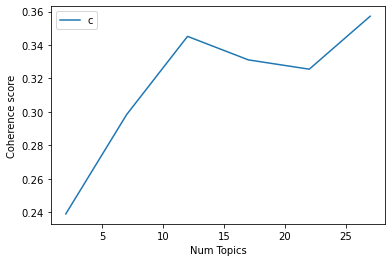

In [137]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_2019_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [138]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_2019_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 12

index: 0 | Num Topics = 2  has Coherence Value of 0.2389
index: 1 | Num Topics = 7  has Coherence Value of 0.2984
index: 2 | Num Topics = 12  has Coherence Value of 0.3451
index: 3 | Num Topics = 17  has Coherence Value of 0.3311
index: 4 | Num Topics = 22  has Coherence Value of 0.3255
index: 5 | Num Topics = 27  has Coherence Value of 0.3572


In [186]:
# Select optimal number of topics
optimal_model_sg_2019_score1N2N3 = model_list_sg_2019_score1N2N3[2]

In [187]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_2019_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_sg_2019_score1N2N3, corpus_sg_2019_score1N2N3, id2word_sg_2019_score1N2N3)

In [188]:
print("pyLDAVis for SG topics for score=1,2,3 in 2019:")
vis_sg_2019_score1N2N3

pyLDAVis for SG topics for score=1,2,3 in 2019:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.285042  0.000858       1        1  14.716108
6     -0.006758  0.096061       2        1  11.801948
0     -0.052035  0.109700       3        1  11.271989
11    -0.068871 -0.071687       4        1  10.666444
8     -0.041290 -0.077234       5        1   7.550338
10     0.100919  0.117924       6        1   7.480580
2      0.001722  0.048530       7        1   7.380424
7      0.107408 -0.137562       8        1   6.970066
4      0.038646  0.028335       9        1   6.880681
1      0.055883 -0.057673      10        1   6.287425
3      0.126649  0.045228      11        1   5.190738
9      0.022770 -0.102477      12        1   3.803259, topic_info=        Term       Freq       Total Category  logprob  loglift
184    crash  63.000000   63.000000  Default  30.0000  30.0000
171    photo  29.000000   29.000000  Default  29.0000  29.0000
47     video  86.000000   86.000000  Default  28.0000  28.0000
174  comment  29.000000   29.000000  Default  27.0000  27.0000
78      post  44.000000   44.000000  Default  26.0000  26.0000
..       ...        ...         ...      ...      ...      ...
70    update   0.970536  112.838718  Topic12  -4.9655  -1.4866
174  comment   0.855626   29.180542  Topic12  -5.0916  -0.2601
91    unable   0.829077   18.748608  Topic12  -5.1231   0.1508
337      bar   0.811417    9.289928  Topic12  -5.1446   0.8314
216     view   0.810301   18.386474  Topic12  -5.1460   0.1473

[742 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
168       3  0.353151         access
168       5  0.176576         access
168       9  0.353151         access
118      12  0.653246  accessibility
771       1  0.608672      accessing
...     ...       ...            ...
362       2  0.206227      yesterday
362       6  0.206227      yesterday
362       7  0.206227      yesterday
362      10  0.412454      yesterday
642       9  0.625671  希望fb的有关部门维修一下

[1169 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 1, 12, 9, 11, 3, 8, 5, 2, 4, 10])

## By-rating of 2020 (Rating=1,2,3)

In [142]:
# By-rating Topic Modelling - rating = 1,2,3 in 2020
# Convert to list - move to each section
review_sg_2020_score1N2N3 = facebook_ios_sg_review_YearMonth_2020_score1N2N3.review.values.tolist()
review_words_sg_2020_score1N2N3 = list(sent_to_words(review_sg_2020_score1N2N3))
print(review_words_sg_2020_score1N2N3[:1])

[['can', 'seem', 'to', 'play', 'any', 'videos']]


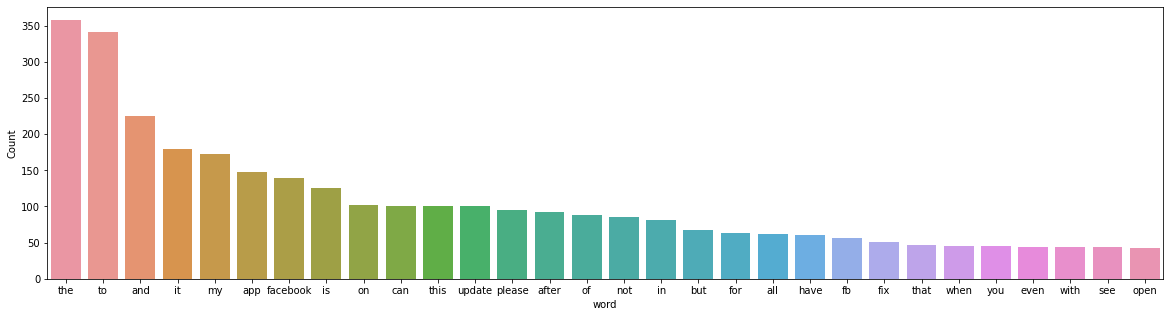

In [143]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_2020_score1N2N3))

In [144]:
# Clean text
review_words_sg_ready_2020_score1N2N3 = process_words(review_words_sg_2020_score1N2N3)  # processed Text Data! - move to each section

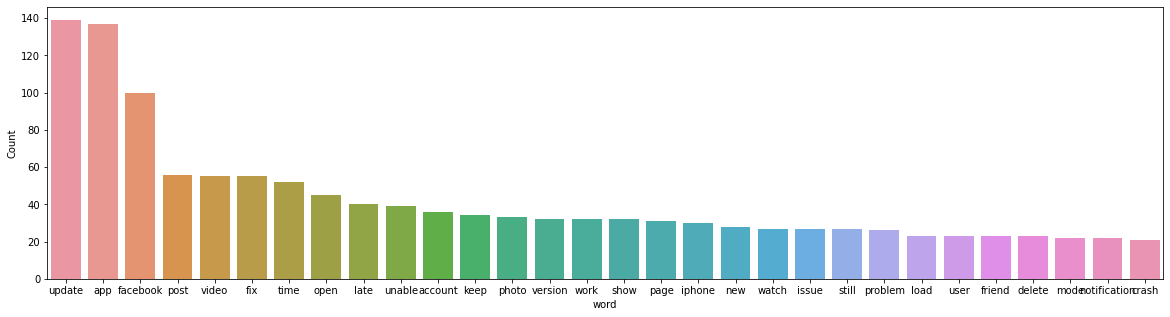

In [145]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_sg_ready_2020_score1N2N3))


In [146]:
# Create Dictionary
id2word_sg_2020_score1N2N3 = corpora.Dictionary(review_words_sg_ready_2020_score1N2N3)

2021-10-16 19:06:02,596 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 19:06:02,618 [INFO] gensim.corpora.dictionary - built Dictionary(931 unique tokens: ['play', 'video', 'app', 'continue', 'crash']...) from 390 documents (total 3841 corpus positions)
2021-10-16 19:06:02,620 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(931 unique tokens: ['play', 'video', 'app', 'continue', 'crash']...) from 390 documents (total 3841 corpus positions)", 'datetime': '2021-10-16T19:06:02.620579', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [147]:
# Create Corpus: Term Document Frequency
corpus_sg_2020_score1N2N3 = [id2word_sg_2020_score1N2N3.doc2bow(text) for text in review_words_sg_ready_2020_score1N2N3]

In [148]:
# Training LDA model
model_list_sg_2020_score1N2N3, coherence_values_sg_2020_score1N2N3 = compute_coherence_values(dictionary=id2word_sg_2020_score1N2N3, corpus=corpus_sg_2020_score1N2N3, 
                                                              texts=review_words_sg_ready_2020_score1N2N3, limit=30, start=2, step=5)


2021-10-16 19:06:02,683 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 19:06:02,688 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 19:06:02,693 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 19:06:02,695 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 390 documents, updating model once every 390 documents, evaluating perplexity every 390 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 19:06:03,892 [INFO] gensim.models.ldamodel - -7.459 per-word bound, 176.0 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:06:03,894 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #390/390
2021-10-16 19:06:05,077 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.036*"app" + 0.030*"update" + 0.027*"facebook" + 0.017*"post" + 0.015*"fix" + 0.010*"keep" + 0.010*"ope

2021-10-16 19:06:14,945 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.029*"video" + 0.022*"update" + 0.015*"watch" + 0.012*"version" + 0.012*"new" + 0.011*"facebook" + 0.010*"time" + 0.010*"remove" + 0.008*"profile" + 0.008*"show"
2021-10-16 19:06:14,946 [INFO] gensim.models.ldamodel - topic diff=0.015808, rho=0.301511
2021-10-16 19:06:15,506 [INFO] gensim.models.ldamodel - -6.306 per-word bound, 79.1 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:06:15,511 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #390/390
2021-10-16 19:06:15,972 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.044*"app" + 0.034*"update" + 0.027*"facebook" + 0.019*"post" + 0.016*"fix" + 0.013*"open" + 0.012*"unable" + 0.012*"time" + 0.011*"keep" + 0.010*"account"
2021-10-16 19:06:15,974 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.029*"video" + 0.022*"update" + 0.015*"watch" + 0.012*"version" + 0.012*"new" + 0.011*"facebook" + 0.010*"r

2021-10-16 19:06:24,072 [INFO] gensim.models.ldamodel - topic diff=0.007364, rho=0.218218
2021-10-16 19:06:24,541 [INFO] gensim.models.ldamodel - -6.294 per-word bound, 78.5 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:06:24,548 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #390/390
2021-10-16 19:06:24,858 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.046*"app" + 0.035*"update" + 0.027*"facebook" + 0.019*"post" + 0.016*"fix" + 0.015*"open" + 0.013*"time" + 0.012*"unable" + 0.011*"keep" + 0.010*"account"
2021-10-16 19:06:24,860 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.031*"video" + 0.020*"update" + 0.015*"watch" + 0.013*"version" + 0.011*"facebook" + 0.011*"remove" + 0.010*"new" + 0.009*"profile" + 0.009*"view" + 0.009*"show"
2021-10-16 19:06:24,861 [INFO] gensim.models.ldamodel - topic diff=0.007212, rho=0.213201
2021-10-16 19:06:25,445 [INFO] gensim.models.ldamodel - -6.293 per-word bound, 78.4 perplexi

2021-10-16 19:06:33,051 [INFO] gensim.models.ldamodel - -6.286 per-word bound, 78.0 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:06:33,053 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #390/390
2021-10-16 19:06:33,364 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.046*"app" + 0.035*"update" + 0.028*"facebook" + 0.019*"post" + 0.016*"fix" + 0.015*"open" + 0.013*"time" + 0.012*"unable" + 0.012*"keep" + 0.011*"work"
2021-10-16 19:06:33,366 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.031*"video" + 0.019*"update" + 0.015*"watch" + 0.012*"version" + 0.011*"remove" + 0.010*"facebook" + 0.010*"view" + 0.009*"profile" + 0.009*"show" + 0.009*"new"
2021-10-16 19:06:33,370 [INFO] gensim.models.ldamodel - topic diff=0.005958, rho=0.176777
2021-10-16 19:06:33,853 [INFO] gensim.models.ldamodel - -6.285 per-word bound, 78.0 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:06:33,8

2021-10-16 19:06:41,096 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #390/390
2021-10-16 19:06:41,416 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.046*"app" + 0.036*"update" + 0.028*"facebook" + 0.019*"post" + 0.016*"fix" + 0.015*"open" + 0.013*"time" + 0.013*"unable" + 0.012*"keep" + 0.011*"late"
2021-10-16 19:06:41,418 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.031*"video" + 0.019*"update" + 0.015*"watch" + 0.012*"version" + 0.011*"remove" + 0.010*"view" + 0.010*"facebook" + 0.009*"button" + 0.009*"show" + 0.009*"profile"
2021-10-16 19:06:41,420 [INFO] gensim.models.ldamodel - topic diff=0.004195, rho=0.154303
2021-10-16 19:06:41,955 [INFO] gensim.models.ldamodel - -6.281 per-word bound, 77.8 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:06:41,956 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #390/390
2021-10-16 19:06:42,320 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.046*"app" 

2021-10-16 19:06:48,580 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 19:06:53,055 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 19:06:53,105 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 362 virtual documents
2021-10-16 19:06:53,590 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 19:06:53,592 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2021-10-16 19:06:53,596 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 19:06:53,598 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 7 topics, 50 passes over the supplied corpus of 390 documents, updating model once every 390 documents, evaluating perplexity every 390 documents, iterating 50x with a con

2021-10-16 19:06:58,441 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.051*"video" + 0.022*"watch" + 0.022*"play" + 0.019*"time" + 0.013*"help" + 0.012*"save" + 0.011*"centre" + 0.010*"update" + 0.009*"top" + 0.009*"open"
2021-10-16 19:06:58,444 [INFO] gensim.models.ldamodel - topic diff=0.081599, rho=0.408248
2021-10-16 19:06:58,869 [INFO] gensim.models.ldamodel - -6.571 per-word bound, 95.1 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:06:58,871 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #390/390
2021-10-16 19:06:59,173 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.028*"keep" + 0.023*"work" + 0.021*"account" + 0.019*"time" + 0.016*"app" + 0.014*"search" + 0.013*"facebook" + 0.011*"update" + 0.010*"block" + 0.010*"user"
2021-10-16 19:06:59,180 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.054*"video" + 0.023*"play" + 0.022*"watch" + 0.019*"time" + 0.013*"help" + 0.012*"save" + 0.011*"centre" + 0.010*"u

2021-10-16 19:07:03,154 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.038*"app" + 0.035*"update" + 0.029*"facebook" + 0.019*"unable" + 0.017*"post" + 0.016*"tag" + 0.014*"iphone" + 0.014*"download" + 0.014*"new" + 0.014*"friend"
2021-10-16 19:07:03,156 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.079*"app" + 0.072*"update" + 0.036*"open" + 0.030*"late" + 0.023*"crash" + 0.020*"unable" + 0.019*"iphone" + 0.018*"version" + 0.017*"keep" + 0.016*"ipad"
2021-10-16 19:07:03,159 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.044*"photo" + 0.036*"post" + 0.024*"click" + 0.022*"remove" + 0.019*"profile" + 0.018*"feature" + 0.017*"update" + 0.015*"watch" + 0.014*"album" + 0.014*"add"
2021-10-16 19:07:03,161 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.060*"video" + 0.026*"play" + 0.024*"watch" + 0.019*"time" + 0.014*"help" + 0.013*"save" + 0.011*"centre" + 0.010*"upgrade" + 0.009*"top" + 0.009*"update"
2021-10-16 19:07:03,163 [INFO] gensim.models.ldamodel - topic diff=0.

2021-10-16 19:07:06,975 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.043*"facebook" + 0.021*"app" + 0.021*"fix" + 0.017*"time" + 0.016*"problem" + 0.013*"issue" + 0.012*"account" + 0.011*"report" + 0.010*"back" + 0.010*"happen"
2021-10-16 19:07:06,977 [INFO] gensim.models.ldamodel - topic diff=0.009173, rho=0.242536
2021-10-16 19:07:07,406 [INFO] gensim.models.ldamodel - -6.520 per-word bound, 91.8 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:07:07,411 [INFO] gensim.models.ldamodel - PROGRESS: pass 16, at document #390/390
2021-10-16 19:07:07,720 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.030*"keep" + 0.025*"work" + 0.022*"account" + 0.018*"time" + 0.015*"search" + 0.013*"app" + 0.013*"facebook" + 0.011*"login" + 0.010*"block" + 0.010*"stupid"
2021-10-16 19:07:07,722 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.062*"video" + 0.026*"play" + 0.025*"watch" + 0.019*"time" + 0.014*"help" + 0.013*"save" + 0.011*"upgrade"

2021-10-16 19:07:11,578 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.030*"keep" + 0.026*"work" + 0.022*"account" + 0.018*"time" + 0.015*"search" + 0.013*"app" + 0.013*"facebook" + 0.012*"login" + 0.010*"block" + 0.010*"stupid"
2021-10-16 19:07:11,579 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.034*"app" + 0.033*"update" + 0.029*"facebook" + 0.017*"post" + 0.017*"unable" + 0.017*"tag" + 0.014*"download" + 0.014*"account" + 0.014*"friend" + 0.013*"iphone"
2021-10-16 19:07:11,580 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.037*"mode" + 0.036*"dark" + 0.026*"facebook" + 0.026*"update" + 0.018*"page" + 0.015*"post" + 0.013*"show" + 0.012*"sa" + 0.012*"news" + 0.011*"find"
2021-10-16 19:07:11,581 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.045*"photo" + 0.037*"post" + 0.027*"click" + 0.022*"remove" + 0.020*"profile" + 0.018*"feature" + 0.018*"update" + 0.014*"album" + 0.014*"watch" + 0.013*"share"
2021-10-16 19:07:11,582 [INFO] gensim.models.ldamodel - topic di

2021-10-16 19:07:15,361 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.037*"mode" + 0.036*"dark" + 0.026*"facebook" + 0.025*"update" + 0.018*"page" + 0.015*"post" + 0.013*"show" + 0.012*"sa" + 0.012*"news" + 0.012*"find"
2021-10-16 19:07:15,362 [INFO] gensim.models.ldamodel - topic diff=0.003088, rho=0.188982
2021-10-16 19:07:15,832 [INFO] gensim.models.ldamodel - -6.513 per-word bound, 91.3 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:07:15,833 [INFO] gensim.models.ldamodel - PROGRESS: pass 27, at document #390/390
2021-10-16 19:07:16,122 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.083*"app" + 0.077*"update" + 0.037*"open" + 0.034*"late" + 0.022*"unable" + 0.021*"crash" + 0.021*"version" + 0.020*"iphone" + 0.016*"keep" + 0.016*"fix"
2021-10-16 19:07:16,124 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.063*"video" + 0.027*"play" + 0.025*"watch" + 0.019*"time" + 0.014*"help" + 0.013*"save" + 0.011*"upgrade" + 0.011*"sig

2021-10-16 19:07:19,872 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.064*"video" + 0.027*"play" + 0.025*"watch" + 0.020*"time" + 0.014*"help" + 0.013*"save" + 0.011*"upgrade" + 0.011*"sign" + 0.011*"centre" + 0.010*"show"
2021-10-16 19:07:19,874 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.083*"app" + 0.078*"update" + 0.037*"open" + 0.034*"late" + 0.022*"unable" + 0.021*"version" + 0.021*"crash" + 0.020*"iphone" + 0.016*"keep" + 0.016*"fix"
2021-10-16 19:07:19,877 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"mode" + 0.036*"dark" + 0.026*"facebook" + 0.025*"update" + 0.018*"page" + 0.015*"post" + 0.013*"show" + 0.012*"sa" + 0.012*"news" + 0.012*"find"
2021-10-16 19:07:19,879 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.031*"keep" + 0.026*"work" + 0.022*"account" + 0.018*"time" + 0.015*"search" + 0.014*"login" + 0.013*"facebook" + 0.012*"app" + 0.011*"user" + 0.010*"block"
2021-10-16 19:07:19,881 [INFO] gensim.models.ldamodel - topic diff=0.002029, rho=0.

2021-10-16 19:07:23,614 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.033*"app" + 0.031*"update" + 0.029*"facebook" + 0.018*"post" + 0.017*"tag" + 0.016*"unable" + 0.014*"download" + 0.014*"account" + 0.014*"friend" + 0.013*"issue"
2021-10-16 19:07:23,616 [INFO] gensim.models.ldamodel - topic diff=0.001708, rho=0.160128
2021-10-16 19:07:24,002 [INFO] gensim.models.ldamodel - -6.509 per-word bound, 91.1 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:07:24,003 [INFO] gensim.models.ldamodel - PROGRESS: pass 38, at document #390/390
2021-10-16 19:07:24,335 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.066*"video" + 0.027*"play" + 0.025*"watch" + 0.020*"time" + 0.014*"help" + 0.013*"save" + 0.011*"upgrade" + 0.011*"sign" + 0.011*"centre" + 0.010*"show"
2021-10-16 19:07:24,336 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.032*"keep" + 0.027*"work" + 0.022*"account" + 0.018*"time" + 0.015*"search" + 0.015*"login" + 0.013*"facebo

2021-10-16 19:07:28,138 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.083*"app" + 0.079*"update" + 0.037*"open" + 0.035*"late" + 0.022*"unable" + 0.022*"version" + 0.021*"crash" + 0.020*"iphone" + 0.016*"keep" + 0.016*"fix"
2021-10-16 19:07:28,141 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.033*"app" + 0.031*"update" + 0.029*"facebook" + 0.018*"post" + 0.017*"tag" + 0.016*"unable" + 0.014*"download" + 0.014*"account" + 0.014*"friend" + 0.013*"issue"
2021-10-16 19:07:28,143 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.038*"mode" + 0.036*"dark" + 0.027*"facebook" + 0.024*"update" + 0.018*"page" + 0.015*"post" + 0.013*"show" + 0.012*"sa" + 0.012*"news" + 0.012*"find"
2021-10-16 19:07:28,145 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.043*"facebook" + 0.021*"fix" + 0.020*"app" + 0.016*"time" + 0.016*"problem" + 0.014*"issue" + 0.013*"account" + 0.011*"report" + 0.010*"people" + 0.010*"back"
2021-10-16 19:07:28,147 [INFO] gensim.models.ldamodel - topic diff=0.00

2021-10-16 19:07:31,855 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.083*"app" + 0.079*"update" + 0.037*"open" + 0.035*"late" + 0.022*"unable" + 0.022*"version" + 0.021*"crash" + 0.020*"iphone" + 0.016*"keep" + 0.016*"fix"
2021-10-16 19:07:31,856 [INFO] gensim.models.ldamodel - topic diff=0.001062, rho=0.141421
2021-10-16 19:07:32,253 [INFO] gensim.models.ldamodel - -6.507 per-word bound, 91.0 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:07:32,255 [INFO] gensim.models.ldamodel - PROGRESS: pass 49, at document #390/390
2021-10-16 19:07:32,584 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.032*"keep" + 0.027*"work" + 0.022*"account" + 0.017*"time" + 0.015*"search" + 0.015*"login" + 0.013*"facebook" + 0.012*"user" + 0.012*"app" + 0.010*"always"
2021-10-16 19:07:32,585 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.083*"app" + 0.079*"update" + 0.037*"open" + 0.035*"late" + 0.022*"version" + 0.022*"unable" + 0.021*"crash" + 0

2021-10-16 19:07:41,676 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.046*"app" + 0.035*"update" + 0.031*"facebook" + 0.028*"post" + 0.024*"iphone" + 0.018*"unable" + 0.018*"tag" + 0.017*"comment" + 0.013*"version" + 0.011*"download"
2021-10-16 19:07:41,679 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.040*"update" + 0.024*"show" + 0.024*"post" + 0.023*"page" + 0.022*"late" + 0.022*"fix" + 0.022*"facebook" + 0.021*"load" + 0.018*"sa" + 0.017*"keep"
2021-10-16 19:07:41,680 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.040*"video" + 0.023*"update" + 0.019*"watch" + 0.019*"time" + 0.015*"facebook" + 0.015*"work" + 0.015*"button" + 0.013*"save" + 0.012*"new" + 0.012*"read"
2021-10-16 19:07:41,683 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.033*"update" + 0.028*"facebook" + 0.023*"app" + 0.023*"photo" + 0.022*"open" + 0.019*"help" + 0.015*"fix" + 0.015*"late" + 0.013*"unable" + 0.013*"video"
2021-10-16 19:07:41,685 [INFO] gensim.models.ldamodel - topic diff=0.11410

2021-10-16 19:07:45,482 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.043*"video" + 0.022*"update" + 0.020*"watch" + 0.020*"button" + 0.017*"time" + 0.015*"work" + 0.014*"save" + 0.013*"facebook" + 0.012*"read" + 0.012*"new"
2021-10-16 19:07:45,482 [INFO] gensim.models.ldamodel - topic diff=0.036572, rho=0.316228
2021-10-16 19:07:45,953 [INFO] gensim.models.ldamodel - -6.668 per-word bound, 101.7 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:07:45,954 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #390/390
2021-10-16 19:07:46,210 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.047*"app" + 0.035*"update" + 0.032*"facebook" + 0.030*"post" + 0.023*"iphone" + 0.022*"tag" + 0.019*"comment" + 0.016*"unable" + 0.012*"day" + 0.012*"friend"
2021-10-16 19:07:46,211 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.058*"app" + 0.032*"phone" + 0.030*"time" + 0.024*"issue" + 0.021*"install" + 0.021*"crash" + 0.019*"look" + 

2021-10-16 19:07:49,805 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.093*"app" + 0.092*"update" + 0.050*"open" + 0.030*"unable" + 0.028*"late" + 0.021*"fix" + 0.021*"load" + 0.020*"iphone" + 0.019*"crash" + 0.019*"ipad"
2021-10-16 19:07:49,810 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.043*"photo" + 0.041*"post" + 0.037*"update" + 0.023*"album" + 0.021*"profile" + 0.021*"click" + 0.017*"feature" + 0.016*"fix" + 0.015*"option" + 0.015*"add"
2021-10-16 19:07:49,812 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.069*"mode" + 0.065*"dark" + 0.052*"facebook" + 0.020*"comment" + 0.016*"ad" + 0.014*"io" + 0.013*"block" + 0.013*"long" + 0.012*"already" + 0.010*"video"
2021-10-16 19:07:49,817 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.032*"show" + 0.031*"page" + 0.027*"update" + 0.026*"post" + 0.024*"sa" + 0.021*"notification" + 0.021*"belong" + 0.018*"fix" + 0.018*"keep" + 0.017*"find"
2021-10-16 19:07:49,818 [INFO] gensim.models.ldamodel - topic diff=0.015930, rh

2021-10-16 19:07:53,461 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.058*"app" + 0.037*"phone" + 0.029*"time" + 0.025*"issue" + 0.021*"install" + 0.020*"crash" + 0.019*"look" + 0.017*"version" + 0.015*"fix" + 0.014*"watch"
2021-10-16 19:07:53,467 [INFO] gensim.models.ldamodel - topic diff=0.009664, rho=0.218218
2021-10-16 19:07:53,959 [INFO] gensim.models.ldamodel - -6.628 per-word bound, 98.9 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:07:53,960 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #390/390
2021-10-16 19:07:54,150 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.046*"photo" + 0.041*"post" + 0.037*"update" + 0.024*"album" + 0.022*"profile" + 0.021*"click" + 0.017*"feature" + 0.016*"fix" + 0.016*"option" + 0.015*"add"
2021-10-16 19:07:54,152 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.043*"facebook" + 0.029*"app" + 0.018*"problem" + 0.016*"people" + 0.015*"update" + 0.015*"page" + 0.014*"time"

2021-10-16 19:07:57,821 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.047*"photo" + 0.040*"post" + 0.037*"update" + 0.024*"album" + 0.022*"profile" + 0.020*"click" + 0.017*"feature" + 0.016*"option" + 0.016*"fix" + 0.015*"add"
2021-10-16 19:07:57,823 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.033*"page" + 0.033*"show" + 0.028*"post" + 0.025*"sa" + 0.022*"update" + 0.021*"belong" + 0.020*"notification" + 0.018*"find" + 0.018*"island" + 0.017*"keep"
2021-10-16 19:07:57,825 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.048*"video" + 0.022*"button" + 0.021*"watch" + 0.015*"save" + 0.015*"time" + 0.014*"work" + 0.013*"read" + 0.013*"top" + 0.012*"facebook" + 0.012*"search"
2021-10-16 19:07:57,826 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.026*"facebook" + 0.018*"fix" + 0.018*"video" + 0.018*"help" + 0.014*"late" + 0.014*"update" + 0.013*"centre" + 0.011*"page" + 0.010*"photo" + 0.010*"pic"
2021-10-16 19:07:57,827 [INFO] gensim.models.ldamodel - topic diff=0.005

2021-10-16 19:08:01,383 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.043*"watch" + 0.028*"video" + 0.022*"always" + 0.022*"search" + 0.017*"page" + 0.016*"fix" + 0.013*"scrollinggggg" + 0.013*"music" + 0.013*"live" + 0.012*"time"
2021-10-16 19:08:01,385 [INFO] gensim.models.ldamodel - topic diff=0.003688, rho=0.176777
2021-10-16 19:08:01,784 [INFO] gensim.models.ldamodel - -6.616 per-word bound, 98.1 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:08:01,787 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #390/390
2021-10-16 19:08:02,083 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.043*"watch" + 0.028*"video" + 0.022*"always" + 0.022*"search" + 0.017*"page" + 0.016*"fix" + 0.013*"scrollinggggg" + 0.013*"music" + 0.013*"live" + 0.012*"time"
2021-10-16 19:08:02,084 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.033*"page" + 0.033*"show" + 0.028*"post" + 0.025*"sa" + 0.022*"belong" + 0.021*"update" + 0.019*"not

2021-10-16 19:08:05,736 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.049*"photo" + 0.040*"post" + 0.037*"update" + 0.024*"album" + 0.022*"profile" + 0.020*"click" + 0.016*"feature" + 0.016*"option" + 0.016*"fix" + 0.015*"add"
2021-10-16 19:08:05,737 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.052*"video" + 0.021*"button" + 0.021*"watch" + 0.015*"save" + 0.015*"time" + 0.014*"work" + 0.014*"facebook" + 0.013*"read" + 0.013*"top" + 0.012*"search"
2021-10-16 19:08:05,739 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.034*"page" + 0.033*"show" + 0.028*"post" + 0.025*"sa" + 0.022*"belong" + 0.020*"update" + 0.018*"island" + 0.018*"find" + 0.018*"notification" + 0.017*"keep"
2021-10-16 19:08:05,742 [INFO] gensim.models.ldamodel - topic #4 (0.083): 0.072*"mode" + 0.069*"dark" + 0.051*"facebook" + 0.018*"comment" + 0.017*"ad" + 0.013*"io" + 0.013*"block" + 0.013*"long" + 0.013*"already" + 0.010*"game"
2021-10-16 19:08:05,743 [INFO] gensim.models.ldamodel - topic diff=0.0023

2021-10-16 19:08:09,294 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.043*"watch" + 0.029*"video" + 0.022*"always" + 0.022*"search" + 0.016*"page" + 0.016*"fix" + 0.013*"scrollinggggg" + 0.013*"music" + 0.013*"live" + 0.012*"time"
2021-10-16 19:08:09,296 [INFO] gensim.models.ldamodel - topic diff=0.001641, rho=0.152499
2021-10-16 19:08:09,705 [INFO] gensim.models.ldamodel - -6.611 per-word bound, 97.8 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:08:09,706 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #390/390
2021-10-16 19:08:09,921 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.043*"watch" + 0.029*"video" + 0.022*"always" + 0.022*"search" + 0.016*"page" + 0.016*"fix" + 0.013*"scrollinggggg" + 0.013*"music" + 0.013*"live" + 0.012*"time"
2021-10-16 19:08:09,923 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.031*"fb" + 0.026*"remove" + 0.022*"user" + 0.021*"bad" + 0.019*"account" + 0.017*"update" + 0.014*"p

2021-10-16 19:08:13,601 [INFO] gensim.models.ldamodel - topic #8 (0.083): 0.031*"fb" + 0.026*"remove" + 0.022*"user" + 0.021*"bad" + 0.019*"account" + 0.017*"update" + 0.014*"page" + 0.014*"friend" + 0.013*"error" + 0.013*"privacy"
2021-10-16 19:08:13,603 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.038*"app" + 0.035*"facebook" + 0.033*"update" + 0.031*"post" + 0.025*"tag" + 0.023*"iphone" + 0.020*"comment" + 0.016*"unable" + 0.016*"friend" + 0.014*"download"
2021-10-16 19:08:13,604 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.043*"watch" + 0.029*"video" + 0.022*"always" + 0.022*"search" + 0.016*"fix" + 0.016*"page" + 0.013*"scrollinggggg" + 0.013*"music" + 0.013*"live" + 0.012*"time"
2021-10-16 19:08:13,607 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.025*"facebook" + 0.019*"fix" + 0.019*"help" + 0.018*"video" + 0.015*"late" + 0.014*"update" + 0.013*"centre" + 0.011*"link" + 0.011*"month" + 0.011*"pic"
2021-10-16 19:08:13,608 [INFO] gensim.models.ldamodel - topic 

2021-10-16 19:08:24,242 [INFO] gensim.models.ldamodel - topic diff=0.198509, rho=0.577350
2021-10-16 19:08:24,711 [INFO] gensim.models.ldamodel - -7.009 per-word bound, 128.8 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:08:24,712 [INFO] gensim.models.ldamodel - PROGRESS: pass 2, at document #390/390
2021-10-16 19:08:25,093 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.039*"facebook" + 0.034*"update" + 0.023*"app" + 0.022*"video" + 0.019*"problem" + 0.016*"back" + 0.014*"fix" + 0.013*"button" + 0.013*"recent" + 0.012*"hang"
2021-10-16 19:08:25,094 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.055*"update" + 0.049*"app" + 0.034*"crash" + 0.020*"late" + 0.020*"story" + 0.017*"still" + 0.016*"give" + 0.016*"time" + 0.015*"unable" + 0.015*"version"
2021-10-16 19:08:25,096 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.028*"app" + 0.025*"facebook" + 0.025*"dark" + 0.024*"mode" + 0.019*"update" + 0.018*"version" + 0.017*"page

2021-10-16 19:08:28,971 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.051*"update" + 0.044*"app" + 0.027*"crash" + 0.026*"find" + 0.024*"story" + 0.021*"late" + 0.021*"still" + 0.017*"search" + 0.015*"time" + 0.015*"version"
2021-10-16 19:08:28,972 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.037*"always" + 0.025*"problem" + 0.025*"time" + 0.016*"page" + 0.016*"delete" + 0.016*"scrollinggggg" + 0.013*"update" + 0.011*"give" + 0.011*"facebook" + 0.011*"speech"
2021-10-16 19:08:28,973 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.035*"album" + 0.023*"facebook" + 0.020*"update" + 0.020*"photo" + 0.018*"version" + 0.016*"miss" + 0.015*"unable" + 0.014*"view" + 0.013*"comment" + 0.013*"day"
2021-10-16 19:08:28,974 [INFO] gensim.models.ldamodel - topic diff=0.054075, rho=0.333333
2021-10-16 19:08:29,455 [INFO] gensim.models.ldamodel - -6.813 per-word bound, 112.4 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:08:29,456 [INFO

2021-10-16 19:08:32,498 [INFO] gensim.models.ldamodel - topic diff=0.023325, rho=0.267261
2021-10-16 19:08:32,858 [INFO] gensim.models.ldamodel - -6.775 per-word bound, 109.5 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:08:32,859 [INFO] gensim.models.ldamodel - PROGRESS: pass 13, at document #390/390
2021-10-16 19:08:33,140 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.037*"always" + 0.026*"problem" + 0.026*"time" + 0.016*"delete" + 0.016*"page" + 0.016*"scrollinggggg" + 0.013*"thing" + 0.013*"give" + 0.012*"update" + 0.012*"facebook"
2021-10-16 19:08:33,142 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.060*"mode" + 0.059*"dark" + 0.035*"facebook" + 0.030*"app" + 0.022*"bug" + 0.021*"fix" + 0.020*"time" + 0.018*"iphone" + 0.017*"long" + 0.017*"happen"
2021-10-16 19:08:33,144 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.037*"album" + 0.021*"photo" + 0.020*"facebook" + 0.020*"update" + 0.017*"miss" + 0.016*"version" + 

2021-10-16 19:08:36,757 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.036*"facebook" + 0.027*"update" + 0.023*"photo" + 0.021*"help" + 0.020*"late" + 0.018*"centre" + 0.017*"fix" + 0.014*"ad" + 0.014*"problem" + 0.011*"app"
2021-10-16 19:08:36,759 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.060*"dark" + 0.060*"mode" + 0.034*"facebook" + 0.031*"app" + 0.022*"bug" + 0.022*"fix" + 0.018*"time" + 0.018*"iphone" + 0.017*"long" + 0.017*"happen"
2021-10-16 19:08:36,762 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.128*"video" + 0.071*"watch" + 0.041*"play" + 0.025*"time" + 0.019*"save" + 0.013*"sound" + 0.012*"user" + 0.011*"pause" + 0.011*"datum" + 0.011*"sign"
2021-10-16 19:08:36,772 [INFO] gensim.models.ldamodel - topic diff=0.011260, rho=0.223607
2021-10-16 19:08:37,202 [INFO] gensim.models.ldamodel - -6.753 per-word bound, 107.9 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:08:37,204 [INFO] gensim.models.ldamodel - PROG

2021-10-16 19:08:40,502 [INFO] gensim.models.ldamodel - topic diff=0.007524, rho=0.200000
2021-10-16 19:08:40,906 [INFO] gensim.models.ldamodel - -6.743 per-word bound, 107.1 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:08:40,907 [INFO] gensim.models.ldamodel - PROGRESS: pass 24, at document #390/390
2021-10-16 19:08:41,216 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.131*"video" + 0.079*"watch" + 0.041*"play" + 0.025*"time" + 0.018*"save" + 0.013*"sound" + 0.012*"user" + 0.012*"show" + 0.011*"pause" + 0.011*"datum"
2021-10-16 19:08:41,218 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.041*"sa" + 0.040*"load" + 0.035*"belong" + 0.034*"news" + 0.032*"update" + 0.029*"island" + 0.023*"map" + 0.023*"truong" + 0.023*"feed" + 0.019*"loading"
2021-10-16 19:08:41,219 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.047*"comment" + 0.037*"show" + 0.024*"button" + 0.023*"post" + 0.019*"top" + 0.014*"corner" + 0.014*"hand" + 0.014*"

2021-10-16 19:08:44,818 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.060*"update" + 0.058*"notification" + 0.034*"still" + 0.031*"find" + 0.028*"search" + 0.027*"story" + 0.026*"app" + 0.023*"crash" + 0.018*"late" + 0.018*"version"
2021-10-16 19:08:44,824 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.035*"facebook" + 0.029*"update" + 0.023*"photo" + 0.021*"help" + 0.020*"fix" + 0.020*"late" + 0.018*"centre" + 0.014*"ad" + 0.014*"problem" + 0.011*"app"
2021-10-16 19:08:44,826 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.070*"update" + 0.031*"remove" + 0.030*"facebook" + 0.024*"app" + 0.024*"new" + 0.022*"time" + 0.016*"sound" + 0.012*"user" + 0.012*"fix" + 0.011*"work"
2021-10-16 19:08:44,827 [INFO] gensim.models.ldamodel - topic diff=0.005247, rho=0.179605
2021-10-16 19:08:45,273 [INFO] gensim.models.ldamodel - -6.735 per-word bound, 106.5 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:08:45,276 [INFO] gensim.models.l

2021-10-16 19:08:48,701 [INFO] gensim.models.ldamodel - topic diff=0.004366, rho=0.166667
2021-10-16 19:08:49,117 [INFO] gensim.models.ldamodel - -6.730 per-word bound, 106.1 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:08:49,119 [INFO] gensim.models.ldamodel - PROGRESS: pass 35, at document #390/390
2021-10-16 19:08:49,321 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.117*"app" + 0.096*"update" + 0.066*"open" + 0.039*"late" + 0.037*"unable" + 0.028*"iphone" + 0.027*"crash" + 0.023*"fix" + 0.020*"keep" + 0.020*"facebook"
2021-10-16 19:08:49,323 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.068*"update" + 0.031*"remove" + 0.030*"facebook" + 0.024*"new" + 0.023*"app" + 0.022*"time" + 0.017*"sound" + 0.012*"user" + 0.012*"fix" + 0.011*"work"
2021-10-16 19:08:49,346 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.038*"album" + 0.021*"photo" + 0.020*"update" + 0.020*"view" + 0.017*"miss" + 0.016*"live" + 0.015*"facebook" + 0

2021-10-16 19:08:52,968 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.065*"notification" + 0.062*"update" + 0.036*"still" + 0.032*"find" + 0.031*"search" + 0.027*"story" + 0.024*"bad" + 0.020*"app" + 0.019*"late" + 0.018*"version"
2021-10-16 19:08:52,970 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.043*"app" + 0.027*"facebook" + 0.025*"help" + 0.024*"download" + 0.022*"account" + 0.021*"issue" + 0.019*"fix" + 0.017*"time" + 0.017*"disable" + 0.016*"phone"
2021-10-16 19:08:52,972 [INFO] gensim.models.ldamodel - topic #8 (0.059): 0.029*"post" + 0.026*"share" + 0.026*"fb" + 0.026*"user" + 0.022*"group" + 0.018*"current" + 0.013*"resolve" + 0.013*"datum" + 0.012*"update" + 0.012*"app"
2021-10-16 19:08:52,974 [INFO] gensim.models.ldamodel - topic diff=0.003936, rho=0.154303
2021-10-16 19:08:53,368 [INFO] gensim.models.ldamodel - -6.722 per-word bound, 105.6 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:08:53,369 [INFO] gensim.mod

2021-10-16 19:08:56,552 [INFO] gensim.models.ldamodel - topic diff=0.003536, rho=0.145865
2021-10-16 19:08:56,881 [INFO] gensim.models.ldamodel - -6.717 per-word bound, 105.2 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:08:56,884 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #390/390
2021-10-16 19:08:57,220 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.051*"load" + 0.040*"sa" + 0.034*"belong" + 0.034*"news" + 0.031*"update" + 0.029*"island" + 0.027*"loading" + 0.023*"map" + 0.023*"truong" + 0.023*"feed"
2021-10-16 19:08:57,222 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.066*"update" + 0.032*"remove" + 0.030*"facebook" + 0.025*"new" + 0.021*"time" + 0.020*"app" + 0.018*"sound" + 0.013*"user" + 0.011*"work" + 0.010*"fix"
2021-10-16 19:08:57,223 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.061*"dark" + 0.061*"mode" + 0.033*"facebook" + 0.029*"app" + 0.022*"bug" + 0.022*"fix" + 0.017*"happen" + 0.017*"

2021-10-16 19:09:07,849 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.028*"video" + 0.025*"watch" + 0.022*"time" + 0.020*"update" + 0.013*"open" + 0.013*"app" + 0.012*"show" + 0.012*"view" + 0.012*"back" + 0.011*"centre"
2021-10-16 19:09:07,850 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.035*"update" + 0.023*"video" + 0.019*"give" + 0.018*"button" + 0.018*"load" + 0.018*"comment" + 0.018*"problem" + 0.013*"account" + 0.013*"page" + 0.013*"friend"
2021-10-16 19:09:07,851 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.034*"time" + 0.028*"fix" + 0.023*"load" + 0.022*"problem" + 0.022*"unable" + 0.021*"page" + 0.017*"search" + 0.017*"hang" + 0.017*"app" + 0.016*"update"
2021-10-16 19:09:07,853 [INFO] gensim.models.ldamodel - topic diff=17.566965, rho=1.000000
2021-10-16 19:09:08,300 [INFO] gensim.models.ldamodel - -7.237 per-word bound, 150.9 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:09:08,302 [INFO] gensim.models.ldamo

2021-10-16 19:09:11,624 [INFO] gensim.models.ldamodel - topic diff=0.090382, rho=0.377964
2021-10-16 19:09:12,087 [INFO] gensim.models.ldamodel - -6.894 per-word bound, 118.9 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:09:12,088 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #390/390
2021-10-16 19:09:12,457 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.072*"app" + 0.041*"asap" + 0.038*"version" + 0.035*"crash" + 0.034*"fix" + 0.031*"close" + 0.022*"keep" + 0.019*"scrollinggggg" + 0.019*"video" + 0.019*"update"
2021-10-16 19:09:12,458 [INFO] gensim.models.ldamodel - topic #2 (0.045): 0.041*"post" + 0.036*"show" + 0.025*"news" + 0.025*"time" + 0.020*"page" + 0.020*"problem" + 0.020*"keep" + 0.020*"ad" + 0.015*"feed" + 0.015*"video"
2021-10-16 19:09:12,460 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.062*"dark" + 0.062*"mode" + 0.048*"app" + 0.041*"facebook" + 0.023*"iphone" + 0.020*"fix" + 0.017*"io" + 0.016*

2021-10-16 19:09:15,967 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.071*"update" + 0.048*"new" + 0.028*"facebook" + 0.021*"video" + 0.017*"sound" + 0.012*"page" + 0.012*"automatically" + 0.012*"social" + 0.012*"watch" + 0.012*"advertising"
2021-10-16 19:09:15,970 [INFO] gensim.models.ldamodel - topic #10 (0.045): 0.030*"bad" + 0.022*"login" + 0.015*"app" + 0.015*"install" + 0.015*"look" + 0.015*"stop" + 0.015*"fix" + 0.015*"month" + 0.015*"lose" + 0.015*"enable"
2021-10-16 19:09:15,972 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.064*"version" + 0.059*"update" + 0.036*"late" + 0.036*"app" + 0.028*"load" + 0.026*"fix" + 0.022*"new" + 0.022*"notification" + 0.019*"view" + 0.018*"facebook"
2021-10-16 19:09:15,974 [INFO] gensim.models.ldamodel - topic diff=0.027134, rho=0.277350
2021-10-16 19:09:16,327 [INFO] gensim.models.ldamodel - -6.833 per-word bound, 114.0 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:09:16,328 [INFO] g

2021-10-16 19:09:19,578 [INFO] gensim.models.ldamodel - topic diff=0.014169, rho=0.235702
2021-10-16 19:09:20,008 [INFO] gensim.models.ldamodel - -6.811 per-word bound, 112.3 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:09:20,010 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #390/390
2021-10-16 19:09:20,273 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.072*"update" + 0.049*"new" + 0.028*"facebook" + 0.021*"video" + 0.017*"sound" + 0.013*"page" + 0.013*"automatically" + 0.013*"social" + 0.013*"watch" + 0.013*"advertising"
2021-10-16 19:09:20,274 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.084*"tag" + 0.062*"post" + 0.059*"facebook" + 0.047*"friend" + 0.036*"unable" + 0.033*"account" + 0.026*"share" + 0.025*"pls" + 0.016*"issue" + 0.015*"iphone"
2021-10-16 19:09:20,275 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.138*"app" + 0.119*"update" + 0.068*"open" + 0.045*"unable" + 0.043*"late" + 0.036*"cras

2021-10-16 19:09:23,630 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.056*"facebook" + 0.028*"account" + 0.025*"app" + 0.021*"link" + 0.014*"log" + 0.014*"keep" + 0.014*"game" + 0.014*"help" + 0.011*"mobile" + 0.011*"almost"
2021-10-16 19:09:23,633 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.092*"tag" + 0.077*"post" + 0.056*"facebook" + 0.051*"friend" + 0.038*"unable" + 0.036*"share" + 0.033*"account" + 0.025*"pls" + 0.015*"issue" + 0.013*"iphone"
2021-10-16 19:09:23,635 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.072*"version" + 0.057*"update" + 0.040*"late" + 0.027*"fix" + 0.027*"facebook" + 0.026*"load" + 0.025*"new" + 0.024*"app" + 0.022*"notification" + 0.020*"io"
2021-10-16 19:09:23,637 [INFO] gensim.models.ldamodel - topic diff=0.007635, rho=0.204124
2021-10-16 19:09:24,080 [INFO] gensim.models.ldamodel - -6.797 per-word bound, 111.2 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:09:24,081 [INFO] gensim.mode

2021-10-16 19:09:27,181 [INFO] gensim.models.ldamodel - topic diff=0.004859, rho=0.185695
2021-10-16 19:09:27,547 [INFO] gensim.models.ldamodel - -6.790 per-word bound, 110.7 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:09:27,549 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #390/390
2021-10-16 19:09:27,761 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.096*"tag" + 0.085*"post" + 0.054*"facebook" + 0.053*"friend" + 0.042*"unable" + 0.039*"share" + 0.033*"account" + 0.025*"pls" + 0.015*"issue" + 0.012*"iphone"
2021-10-16 19:09:27,763 [INFO] gensim.models.ldamodel - topic #13 (0.045): 0.034*"app" + 0.029*"change" + 0.026*"facebook" + 0.025*"work" + 0.025*"page" + 0.024*"account" + 0.022*"keep" + 0.018*"let" + 0.015*"group" + 0.015*"notification"
2021-10-16 19:09:27,765 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.039*"video" + 0.034*"search" + 0.033*"button" + 0.024*"top" + 0.023*"give" + 0.022*"live" + 0.022*

2021-10-16 19:09:31,221 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.067*"app" + 0.050*"asap" + 0.043*"version" + 0.036*"close" + 0.030*"fix" + 0.025*"crash" + 0.022*"scrollinggggg" + 0.022*"video" + 0.022*"opening" + 0.017*"keep"
2021-10-16 19:09:31,223 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.030*"video" + 0.030*"watch" + 0.030*"ad" + 0.025*"update" + 0.015*"click" + 0.015*"error" + 0.015*"remove" + 0.015*"show" + 0.015*"online" + 0.015*"quality"
2021-10-16 19:09:31,229 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.053*"facebook" + 0.021*"video" + 0.017*"app" + 0.017*"time" + 0.017*"week" + 0.016*"issue" + 0.014*"fix" + 0.013*"watch" + 0.013*"people" + 0.013*"ago"
2021-10-16 19:09:31,230 [INFO] gensim.models.ldamodel - topic diff=0.003148, rho=0.169031
2021-10-16 19:09:31,692 [INFO] gensim.models.ldamodel - -6.786 per-word bound, 110.3 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:09:31,698 [INFO] gensim.models

2021-10-16 19:09:34,731 [INFO] gensim.models.ldamodel - topic diff=0.002290, rho=0.158114
2021-10-16 19:09:35,145 [INFO] gensim.models.ldamodel - -6.782 per-word bound, 110.0 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:09:35,147 [INFO] gensim.models.ldamodel - PROGRESS: pass 39, at document #390/390
2021-10-16 19:09:35,491 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.047*"time" + 0.044*"problem" + 0.037*"always" + 0.032*"fix" + 0.031*"page" + 0.027*"log" + 0.026*"load" + 0.021*"unable" + 0.016*"search" + 0.016*"loading"
2021-10-16 19:09:35,493 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.066*"app" + 0.050*"asap" + 0.043*"version" + 0.036*"close" + 0.030*"fix" + 0.025*"crash" + 0.022*"scrollinggggg" + 0.022*"video" + 0.022*"opening" + 0.017*"keep"
2021-10-16 19:09:35,496 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.074*"version" + 0.061*"update" + 0.040*"late" + 0.033*"facebook" + 0.028*"fix" + 0.025*"io" + 0.024*"

2021-10-16 19:09:39,137 [INFO] gensim.models.ldamodel - topic #20 (0.045): 0.051*"update" + 0.025*"today" + 0.019*"play" + 0.019*"notification" + 0.019*"start" + 0.013*"new" + 0.013*"video" + 0.013*"story" + 0.013*"ever" + 0.013*"log"
2021-10-16 19:09:39,150 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.072*"post" + 0.047*"share" + 0.045*"click" + 0.041*"add" + 0.029*"button" + 0.018*"caption" + 0.018*"send" + 0.018*"message" + 0.012*"time" + 0.012*"friend"
2021-10-16 19:09:39,160 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.107*"tag" + 0.097*"post" + 0.054*"friend" + 0.052*"facebook" + 0.041*"share" + 0.039*"unable" + 0.034*"account" + 0.026*"pls" + 0.016*"issue" + 0.011*"iphone"
2021-10-16 19:09:39,169 [INFO] gensim.models.ldamodel - topic diff=0.001845, rho=0.147442
2021-10-16 19:09:39,609 [INFO] gensim.models.ldamodel - -6.778 per-word bound, 109.8 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:09:39,610 [INFO] gensim.mod

2021-10-16 19:09:42,502 [INFO] gensim.models.ldamodel - topic diff=0.001486, rho=0.140028
2021-10-16 19:09:42,506 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=931, num_topics=22, decay=0.5, chunksize=1000) in 36.05s', 'datetime': '2021-10-16T19:09:42.506283', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 19:09:42,518 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 19:09:46,944 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 19:09:47,020 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 383 virtual documents
2021-10-16 19:09:51,142 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.037037037037037035
2021-10-1

2021-10-16 19:09:55,822 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.081*"update" + 0.060*"app" + 0.031*"load" + 0.028*"tag" + 0.028*"download" + 0.027*"phone" + 0.022*"unable" + 0.022*"view" + 0.022*"post" + 0.021*"open"
2021-10-16 19:09:55,825 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.035*"app" + 0.026*"dark" + 0.025*"mode" + 0.024*"issue" + 0.023*"yet" + 0.021*"time" + 0.018*"facebook" + 0.018*"fix" + 0.017*"long" + 0.017*"notification"
2021-10-16 19:09:55,826 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.039*"remove" + 0.019*"update" + 0.018*"app" + 0.018*"still" + 0.017*"close" + 0.017*"happen" + 0.016*"user" + 0.015*"phone" + 0.013*"problem" + 0.011*"error"
2021-10-16 19:09:55,827 [INFO] gensim.models.ldamodel - topic diff=0.138504, rho=0.408248
2021-10-16 19:09:56,213 [INFO] gensim.models.ldamodel - -7.058 per-word bound, 133.3 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:09:56,216 [INFO] gensim.models.ldam

2021-10-16 19:09:59,717 [INFO] gensim.models.ldamodel - topic diff=0.051523, rho=0.301511
2021-10-16 19:10:00,133 [INFO] gensim.models.ldamodel - -6.966 per-word bound, 125.0 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:10:00,135 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #390/390
2021-10-16 19:10:00,461 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.054*"facebook" + 0.038*"app" + 0.035*"issue" + 0.034*"update" + 0.032*"time" + 0.028*"video" + 0.027*"fix" + 0.024*"open" + 0.022*"live" + 0.021*"problem"
2021-10-16 19:10:00,462 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.086*"dark" + 0.086*"mode" + 0.047*"user" + 0.037*"facebook" + 0.020*"already" + 0.017*"io" + 0.017*"unable" + 0.016*"video" + 0.016*"ipad" + 0.016*"web"
2021-10-16 19:10:00,465 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.040*"facebook" + 0.033*"keep" + 0.025*"game" + 0.025*"scrollinggggg" + 0.025*"load" + 0.024*"video" + 0.022*"time

2021-10-16 19:10:04,453 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.102*"update" + 0.083*"app" + 0.069*"late" + 0.049*"unable" + 0.035*"iphone" + 0.034*"ipad" + 0.033*"open" + 0.030*"work" + 0.030*"io" + 0.026*"pro"
2021-10-16 19:10:04,455 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.069*"facebook" + 0.058*"account" + 0.023*"log" + 0.019*"app" + 0.015*"advertisement" + 0.012*"mobile" + 0.012*"issue" + 0.012*"report" + 0.012*"safe" + 0.012*"poor"
2021-10-16 19:10:04,457 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.032*"facebook" + 0.029*"update" + 0.022*"thing" + 0.022*"album" + 0.022*"old" + 0.022*"message" + 0.014*"version" + 0.011*"time" + 0.011*"watch" + 0.011*"group"
2021-10-16 19:10:04,458 [INFO] gensim.models.ldamodel - topic diff=0.019790, rho=0.242536
2021-10-16 19:10:04,853 [INFO] gensim.models.ldamodel - -6.921 per-word bound, 121.2 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:10:04,854 [INFO] gensim.mo

2021-10-16 19:10:08,268 [INFO] gensim.models.ldamodel - topic diff=0.011923, rho=0.213201
2021-10-16 19:10:08,734 [INFO] gensim.models.ldamodel - -6.901 per-word bound, 119.5 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:10:08,735 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #390/390
2021-10-16 19:10:09,071 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.098*"mode" + 0.094*"dark" + 0.047*"user" + 0.039*"facebook" + 0.021*"already" + 0.017*"io" + 0.016*"unable" + 0.016*"video" + 0.016*"web" + 0.016*"ipad"
2021-10-16 19:10:09,075 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.033*"update" + 0.030*"today" + 0.023*"keep" + 0.020*"work" + 0.020*"load" + 0.020*"datum" + 0.020*"sell" + 0.020*"merge" + 0.020*"memory" + 0.020*"acct"
2021-10-16 19:10:09,076 [INFO] gensim.models.ldamodel - topic #20 (0.037): 0.065*"post" + 0.046*"click" + 0.040*"add" + 0.020*"log" + 0.020*"ban" + 0.020*"caption" + 0.018*"edit" + 0.017*"pa

2021-10-16 19:10:12,620 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.105*"update" + 0.083*"app" + 0.074*"late" + 0.044*"unable" + 0.036*"iphone" + 0.033*"ipad" + 0.031*"open" + 0.029*"io" + 0.029*"work" + 0.026*"crash"
2021-10-16 19:10:12,628 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.046*"photo" + 0.037*"help" + 0.032*"facebook" + 0.024*"centre" + 0.024*"login" + 0.019*"ad" + 0.018*"time" + 0.018*"profile" + 0.014*"fix" + 0.014*"page"
2021-10-16 19:10:12,640 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.058*"update" + 0.034*"new" + 0.030*"video" + 0.027*"back" + 0.019*"facebook" + 0.018*"sound" + 0.018*"play" + 0.016*"user" + 0.016*"opening" + 0.016*"advertising"
2021-10-16 19:10:12,646 [INFO] gensim.models.ldamodel - topic diff=0.007266, rho=0.188982
2021-10-16 19:10:13,088 [INFO] gensim.models.ldamodel - -6.887 per-word bound, 118.4 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:10:13,089 [INFO] gensim.models.lda

2021-10-16 19:10:16,128 [INFO] gensim.models.ldamodel - topic diff=0.004654, rho=0.174078
2021-10-16 19:10:16,569 [INFO] gensim.models.ldamodel - -6.881 per-word bound, 117.8 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:10:16,572 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #390/390
2021-10-16 19:10:16,860 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.085*"post" + 0.043*"app" + 0.027*"still" + 0.025*"update" + 0.023*"become" + 0.023*"picture" + 0.023*"newsfeed" + 0.019*"open" + 0.019*"page" + 0.016*"keep"
2021-10-16 19:10:16,861 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.034*"update" + 0.030*"today" + 0.025*"keep" + 0.020*"work" + 0.020*"load" + 0.020*"sell" + 0.020*"merge" + 0.020*"acct" + 0.020*"datum" + 0.020*"memory"
2021-10-16 19:10:16,862 [INFO] gensim.models.ldamodel - topic #15 (0.037): 0.042*"update" + 0.029*"search" + 0.026*"version" + 0.019*"album" + 0.018*"fix" + 0.018*"back" + 0.018*"button

2021-10-16 19:10:20,264 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.035*"update" + 0.024*"load" + 0.024*"problem" + 0.021*"facebook" + 0.018*"share" + 0.018*"fix" + 0.018*"map" + 0.018*"sa" + 0.018*"long" + 0.018*"time"
2021-10-16 19:10:20,267 [INFO] gensim.models.ldamodel - topic #19 (0.037): 0.059*"watch" + 0.043*"video" + 0.035*"time" + 0.029*"click" + 0.024*"view" + 0.024*"update" + 0.023*"feature" + 0.021*"photo" + 0.018*"app" + 0.018*"bad"
2021-10-16 19:10:20,270 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.131*"video" + 0.049*"watch" + 0.031*"page" + 0.026*"save" + 0.024*"play" + 0.022*"show" + 0.019*"pause" + 0.018*"screen" + 0.014*"late" + 0.013*"feed"
2021-10-16 19:10:20,272 [INFO] gensim.models.ldamodel - topic diff=0.003181, rho=0.160128
2021-10-16 19:10:20,644 [INFO] gensim.models.ldamodel - -6.878 per-word bound, 117.6 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:10:20,645 [INFO] gensim.models.ldamodel - PROG

2021-10-16 19:10:23,854 [INFO] gensim.models.ldamodel - topic diff=0.002571, rho=0.150756
2021-10-16 19:10:24,270 [INFO] gensim.models.ldamodel - -6.874 per-word bound, 117.3 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:10:24,271 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #390/390
2021-10-16 19:10:24,580 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.106*"mode" + 0.101*"dark" + 0.046*"user" + 0.041*"facebook" + 0.020*"already" + 0.017*"io" + 0.016*"unable" + 0.015*"video" + 0.015*"play" + 0.015*"ipad"
2021-10-16 19:10:24,581 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.035*"update" + 0.024*"load" + 0.023*"problem" + 0.021*"facebook" + 0.018*"share" + 0.018*"map" + 0.018*"sa" + 0.018*"fix" + 0.018*"long" + 0.018*"time"
2021-10-16 19:10:24,583 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.133*"video" + 0.049*"watch" + 0.031*"page" + 0.026*"save" + 0.024*"play" + 0.022*"show" + 0.019*"pause" + 0.018*"sc

2021-10-16 19:10:28,252 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.052*"account" + 0.036*"keep" + 0.034*"facebook" + 0.029*"work" + 0.020*"fb" + 0.020*"give" + 0.019*"show" + 0.019*"friend" + 0.019*"time" + 0.016*"group"
2021-10-16 19:10:28,253 [INFO] gensim.models.ldamodel - topic #3 (0.037): 0.106*"mode" + 0.101*"dark" + 0.046*"user" + 0.041*"facebook" + 0.020*"already" + 0.017*"io" + 0.016*"unable" + 0.015*"play" + 0.015*"video" + 0.015*"ipad"
2021-10-16 19:10:28,255 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.135*"video" + 0.049*"watch" + 0.030*"page" + 0.026*"save" + 0.024*"play" + 0.023*"show" + 0.019*"pause" + 0.018*"screen" + 0.014*"late" + 0.013*"feed"
2021-10-16 19:10:28,256 [INFO] gensim.models.ldamodel - topic diff=0.001826, rho=0.141421
2021-10-16 19:10:28,716 [INFO] gensim.models.ldamodel - -6.869 per-word bound, 116.9 perplexity estimate based on a held-out corpus of 390 documents with 3841 words
2021-10-16 19:10:28,718 [INFO] gensim.models.ldamodel - P

In [149]:
%store model_list_sg_2020_score1N2N3
%store coherence_values_sg_2020_score1N2N3

Stored 'model_list_sg_2020_score1N2N3' (list)
Stored 'coherence_values_sg_2020_score1N2N3' (list)


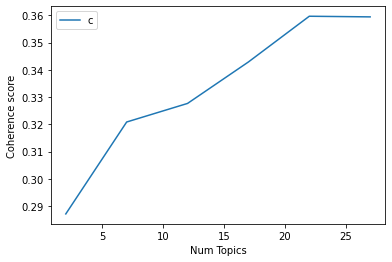

In [150]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_2020_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [151]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_2020_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.2871
index: 1 | Num Topics = 7  has Coherence Value of 0.3208
index: 2 | Num Topics = 12  has Coherence Value of 0.3277
index: 3 | Num Topics = 17  has Coherence Value of 0.3429
index: 4 | Num Topics = 22  has Coherence Value of 0.3597
index: 5 | Num Topics = 27  has Coherence Value of 0.3595


In [189]:
# Select optimal number of topics
optimal_model_sg_2020_score1N2N3 = model_list_sg_2020_score1N2N3[4]

In [190]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_2020_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_sg_2020_score1N2N3, corpus_sg_2020_score1N2N3, id2word_sg_2020_score1N2N3)

In [191]:
print("pyLDAVis for SG topics for score=1,2,3 in 2020:")
vis_sg_2020_score1N2N3

pyLDAVis for SG topics for score=1,2,3 in 2020:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
16    -0.307538  0.031799       1        1  11.656195
11    -0.029768 -0.167998       2        1   6.380687
14    -0.137719 -0.151513       3        1   6.322524
13    -0.033245 -0.077661       4        1   6.038071
15    -0.089029  0.141611       5        1   5.637269
0      0.000333 -0.071703       6        1   5.303640
12    -0.004601  0.080724       7        1   5.218411
7      0.028662  0.131254       8        1   4.851152
6     -0.022548 -0.056651       9        1   4.536871
2      0.106158  0.001420      10        1   4.403573
8      0.109590 -0.107607      11        1   4.392909
19     0.097439  0.018802      12        1   4.332851
3     -0.028078  0.049480      13        1   3.830903
9     -0.010219  0.017510      14        1   3.740789
5      0.127829 -0.014322      15        1   3.493261
4      0.073744  0.077034      16        1   3.430352
20     0.009737  0.098732      17        1   3.214937
18     0.035544  0.068094      18        1   2.955944
1      0.092969 -0.007051      19        1   2.948725
21    -0.085104  0.033654      20        1   2.652515
10     0.036643 -0.033383      21        1   2.502343
17     0.029200 -0.062223      22        1   2.156078, topic_info=           Term        Freq       Total Category  logprob  loglift
2           app  114.000000  114.000000  Default  30.0000  30.0000
6         photo   27.000000   27.000000  Default  29.0000  29.0000
16       update  115.000000  115.000000  Default  28.0000  28.0000
7          post   44.000000   44.000000  Default  27.0000  27.0000
11      version   26.000000   26.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
8    repeatedly    0.031657    1.515195  Topic22  -7.8694  -0.0315
182        less    0.031657    1.515202  Topic22  -7.8694  -0.0315
155        open    0.728085   38.476946  Topic22  -4.7339  -0.1305
1         video    0.728077   44.362352  Topic22  -4.7340  -0.2729
95        still    0.276249   22.553044  Topic22  -5.7031  -0.5654

[1184 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
85        3  0.229016     able
85        5  0.343523     able
85        6  0.114508     able
85       13  0.114508     able
85       18  0.114508     able
...     ...       ...      ...
694      14  0.634440      也吃掉
730      10  0.625892    假帳號太多
731      10  0.625892     廣告太多
695      14  0.634440     打广告钱
819       1  0.609031  最好全都还回来

[1760 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 12, 15, 14, 16, 1, 13, 8, 7, 3, 9, 20, 4, 10, 6, 5, 21, 19, 2, 22, 11, 18])

## By-rating of 2021 (Rating=1,2,3)

In [155]:
# By-rating Topic Modelling - rating = 1,2,3 in 2021
# Convert to list - move to each section
review_sg_2021_score1N2N3 = facebook_ios_sg_review_YearMonth_2021_score1N2N3.review.values.tolist()
review_words_sg_2021_score1N2N3 = list(sent_to_words(review_sg_2021_score1N2N3))
print(review_words_sg_2021_score1N2N3[:1])

[['see', 'more', 'button', 'not', 'function']]


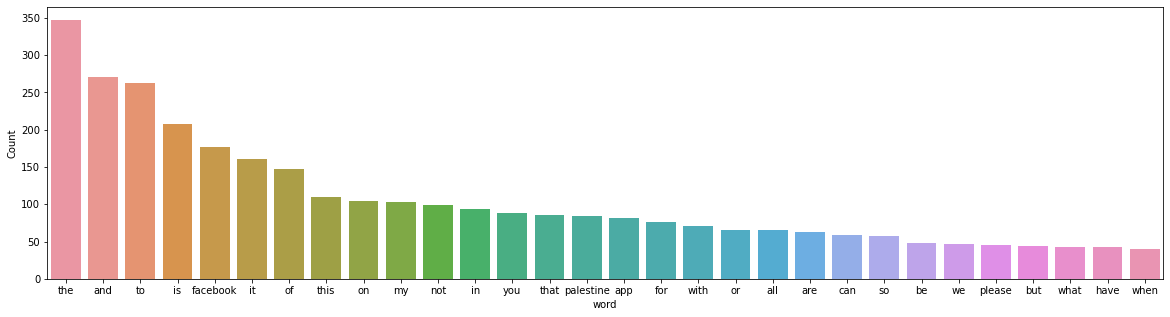

In [156]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_sg_2021_score1N2N3))

In [157]:
# Clean text
review_words_sg_ready_2021_score1N2N3 = process_words(review_words_sg_2021_score1N2N3)  # processed Text Data! - move to each section

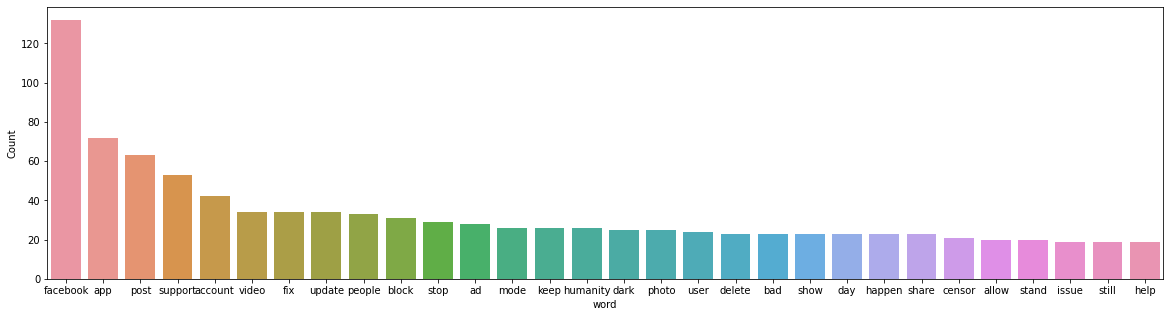

In [158]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_sg_ready_2021_score1N2N3))


In [159]:
# Create Dictionary
id2word_sg_2021_score1N2N3 = corpora.Dictionary(review_words_sg_ready_2021_score1N2N3)

2021-10-16 19:10:50,311 [INFO] gensim.corpora.dictionary - adding document #0 to Dictionary(0 unique tokens: [])
2021-10-16 19:10:50,339 [INFO] gensim.corpora.dictionary - built Dictionary(1193 unique tokens: ['button', 'function', '为什么用网络不能够上网呢', '只有用wifi才能夠上网的吗', '有这么烂烂烂的软件的吗']...) from 442 documents (total 4048 corpus positions)
2021-10-16 19:10:50,341 [INFO] gensim.utils - Dictionary lifecycle event {'msg': "built Dictionary(1193 unique tokens: ['button', 'function', '为什么用网络不能够上网呢', '只有用wifi才能夠上网的吗', '有这么烂烂烂的软件的吗']...) from 442 documents (total 4048 corpus positions)", 'datetime': '2021-10-16T19:10:50.341102', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}


In [160]:
# Create Corpus: Term Document Frequency
corpus_sg_2021_score1N2N3 = [id2word_sg_2021_score1N2N3.doc2bow(text) for text in review_words_sg_ready_2021_score1N2N3]

In [161]:
# Training LDA model
model_list_sg_2021_score1N2N3, coherence_values_sg_2021_score1N2N3 = compute_coherence_values(dictionary=id2word_sg_2021_score1N2N3, corpus=corpus_sg_2021_score1N2N3, 
                                                              texts=review_words_sg_ready_2021_score1N2N3, limit=30, start=2, step=5)


2021-10-16 19:10:50,377 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.5
2021-10-16 19:10:50,380 [INFO] gensim.models.ldamodel - using symmetric eta at 0.5
2021-10-16 19:10:50,383 [INFO] gensim.models.ldamodel - using serial LDA version on this node
2021-10-16 19:10:50,386 [INFO] gensim.models.ldamodel - running online (multi-pass) LDA training, 2 topics, 50 passes over the supplied corpus of 442 documents, updating model once every 442 documents, evaluating perplexity every 442 documents, iterating 50x with a convergence threshold of 0.001000
2021-10-16 19:10:51,625 [INFO] gensim.models.ldamodel - -7.745 per-word bound, 214.5 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:10:51,626 [INFO] gensim.models.ldamodel - PROGRESS: pass 0, at document #442/442
2021-10-16 19:10:52,766 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.027*"facebook" + 0.016*"support" + 0.014*"app" + 0.013*"post" + 0.008*"block" + 0.008*"ad" + 0.007*"st

2021-10-16 19:11:03,507 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.017*"app" + 0.016*"facebook" + 0.012*"post" + 0.011*"fix" + 0.011*"video" + 0.010*"update" + 0.009*"account" + 0.009*"mode" + 0.009*"keep" + 0.009*"dark"
2021-10-16 19:11:03,509 [INFO] gensim.models.ldamodel - topic diff=0.016233, rho=0.301511
2021-10-16 19:11:04,214 [INFO] gensim.models.ldamodel - -6.718 per-word bound, 105.3 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:11:04,216 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #442/442
2021-10-16 19:11:04,667 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.037*"facebook" + 0.023*"support" + 0.012*"post" + 0.011*"humanity" + 0.011*"stop" + 0.011*"block" + 0.009*"app" + 0.009*"ad" + 0.009*"people" + 0.009*"stand"
2021-10-16 19:11:04,669 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.018*"app" + 0.016*"facebook" + 0.012*"post" + 0.011*"fix" + 0.011*"video" + 0.010*"update" + 0.009*"account" 

2021-10-16 19:11:12,711 [INFO] gensim.models.ldamodel - topic diff=0.009956, rho=0.218218
2021-10-16 19:11:13,234 [INFO] gensim.models.ldamodel - -6.699 per-word bound, 103.9 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:11:13,235 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #442/442
2021-10-16 19:11:13,583 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.038*"facebook" + 0.023*"support" + 0.012*"post" + 0.012*"stop" + 0.012*"humanity" + 0.011*"block" + 0.010*"people" + 0.009*"stand" + 0.009*"allow" + 0.009*"ad"
2021-10-16 19:11:13,585 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.020*"app" + 0.016*"facebook" + 0.012*"post" + 0.012*"fix" + 0.012*"video" + 0.011*"update" + 0.009*"mode" + 0.009*"keep" + 0.009*"account" + 0.009*"dark"
2021-10-16 19:11:13,586 [INFO] gensim.models.ldamodel - topic diff=0.009871, rho=0.213201
2021-10-16 19:11:14,061 [INFO] gensim.models.ldamodel - -6.697 per-word bound, 103.8 perplexi

2021-10-16 19:11:21,609 [INFO] gensim.models.ldamodel - -6.681 per-word bound, 102.6 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:11:21,610 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #442/442
2021-10-16 19:11:21,974 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.038*"facebook" + 0.023*"support" + 0.012*"post" + 0.012*"stop" + 0.012*"humanity" + 0.011*"block" + 0.010*"people" + 0.009*"stand" + 0.009*"allow" + 0.009*"share"
2021-10-16 19:11:21,976 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.021*"app" + 0.016*"facebook" + 0.012*"post" + 0.012*"fix" + 0.012*"video" + 0.012*"update" + 0.009*"mode" + 0.009*"keep" + 0.009*"account" + 0.009*"dark"
2021-10-16 19:11:21,977 [INFO] gensim.models.ldamodel - topic diff=0.007748, rho=0.176777
2021-10-16 19:11:22,486 [INFO] gensim.models.ldamodel - -6.680 per-word bound, 102.5 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:1

2021-10-16 19:11:29,735 [INFO] gensim.models.ldamodel - -6.672 per-word bound, 102.0 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:11:29,736 [INFO] gensim.models.ldamodel - PROGRESS: pass 40, at document #442/442
2021-10-16 19:11:30,092 [INFO] gensim.models.ldamodel - topic #0 (0.500): 0.038*"facebook" + 0.023*"support" + 0.013*"post" + 0.012*"stop" + 0.012*"humanity" + 0.011*"block" + 0.011*"people" + 0.009*"censor" + 0.009*"stand" + 0.009*"allow"
2021-10-16 19:11:30,093 [INFO] gensim.models.ldamodel - topic #1 (0.500): 0.022*"app" + 0.016*"facebook" + 0.012*"post" + 0.012*"fix" + 0.012*"update" + 0.012*"video" + 0.009*"mode" + 0.009*"keep" + 0.009*"account" + 0.009*"dark"
2021-10-16 19:11:30,095 [INFO] gensim.models.ldamodel - topic diff=0.005374, rho=0.154303
2021-10-16 19:11:30,609 [INFO] gensim.models.ldamodel - -6.672 per-word bound, 101.9 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:

2021-10-16 19:11:36,900 [INFO] gensim.utils - LdaModel lifecycle event {'msg': 'trained LdaModel(num_terms=1193, num_topics=2, decay=0.5, chunksize=1000) in 46.51s', 'datetime': '2021-10-16T19:11:36.900773', 'gensim': '4.1.2', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
2021-10-16 19:11:36,905 [INFO] gensim.topic_coherence.probability_estimation - using ParallelWordOccurrenceAccumulator(processes=7, batch_size=64) to estimate probabilities from sliding windows
2021-10-16 19:11:41,013 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 19:11:41,043 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 345 virtual documents
2021-10-16 19:11:41,348 [INFO] gensim.models.ldamodel - using symmetric alpha at 0.14285714285714285
2021-10-16 19:11:41,349 [INFO] gensim.models.ldamodel - using symmetric eta at 0.14285714285714285
2

2021-10-16 19:11:46,228 [INFO] gensim.models.ldamodel - topic #2 (0.143): 0.020*"stop" + 0.017*"app" + 0.017*"problem" + 0.017*"fix" + 0.016*"censor" + 0.016*"freepalestine" + 0.015*"support" + 0.015*"login" + 0.015*"update" + 0.013*"account"
2021-10-16 19:11:46,230 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.030*"mode" + 0.030*"dark" + 0.022*"photo" + 0.016*"post" + 0.015*"bad" + 0.014*"facebook" + 0.014*"app" + 0.010*"bias" + 0.009*"censor" + 0.009*"name"
2021-10-16 19:11:46,231 [INFO] gensim.models.ldamodel - topic diff=0.056688, rho=0.408248
2021-10-16 19:11:46,672 [INFO] gensim.models.ldamodel - -7.075 per-word bound, 134.8 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:11:46,674 [INFO] gensim.models.ldamodel - PROGRESS: pass 5, at document #442/442
2021-10-16 19:11:47,085 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.026*"facebook" + 0.022*"post" + 0.013*"update" + 0.013*"app" + 0.012*"user" + 0.012*"advertisement" + 0.

2021-10-16 19:11:50,915 [INFO] gensim.models.ldamodel - -7.050 per-word bound, 132.5 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:11:50,923 [INFO] gensim.models.ldamodel - PROGRESS: pass 10, at document #442/442
2021-10-16 19:11:51,219 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.015*"allow" + 0.014*"ad" + 0.013*"post" + 0.013*"video" + 0.012*"work" + 0.011*"hate" + 0.009*"name" + 0.009*"enter" + 0.009*"story" + 0.009*"miss"
2021-10-16 19:11:51,221 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.027*"keep" + 0.015*"fix" + 0.015*"new" + 0.013*"account" + 0.011*"phone" + 0.011*"facebook" + 0.010*"app" + 0.010*"bad" + 0.009*"time" + 0.009*"annoying"
2021-10-16 19:11:51,222 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.025*"facebook" + 0.022*"post" + 0.013*"update" + 0.013*"app" + 0.012*"user" + 0.012*"advertisement" + 0.011*"video" + 0.010*"platform" + 0.009*"freedom" + 0.009*"ad"
2021-10-16 19:11:51,224 [INFO] gensim.model

2021-10-16 19:11:55,261 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.025*"facebook" + 0.022*"post" + 0.013*"update" + 0.013*"app" + 0.012*"user" + 0.012*"advertisement" + 0.011*"video" + 0.010*"platform" + 0.009*"freedom" + 0.009*"ad"
2021-10-16 19:11:55,264 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.015*"facebook" + 0.014*"video" + 0.013*"app" + 0.013*"free" + 0.012*"fix" + 0.011*"post" + 0.011*"stop" + 0.010*"people" + 0.010*"feed" + 0.009*"medium"
2021-10-16 19:11:55,268 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.038*"mode" + 0.037*"dark" + 0.028*"photo" + 0.016*"post" + 0.015*"bad" + 0.015*"app" + 0.014*"facebook" + 0.011*"bias" + 0.009*"censor" + 0.009*"name"
2021-10-16 19:11:55,271 [INFO] gensim.models.ldamodel - topic diff=0.005982, rho=0.242536
2021-10-16 19:11:55,665 [INFO] gensim.models.ldamodel - -7.039 per-word bound, 131.5 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:11:55,666 [INFO] gensim.models.ld

2021-10-16 19:11:59,050 [INFO] gensim.models.ldamodel - topic diff=0.003309, rho=0.213201
2021-10-16 19:11:59,517 [INFO] gensim.models.ldamodel - -7.035 per-word bound, 131.1 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:11:59,521 [INFO] gensim.models.ldamodel - PROGRESS: pass 21, at document #442/442
2021-10-16 19:11:59,838 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.015*"facebook" + 0.014*"video" + 0.013*"app" + 0.013*"free" + 0.012*"fix" + 0.011*"post" + 0.011*"feed" + 0.011*"stop" + 0.010*"people" + 0.010*"news"
2021-10-16 19:11:59,840 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.015*"allow" + 0.014*"ad" + 0.013*"post" + 0.013*"video" + 0.013*"work" + 0.011*"hate" + 0.009*"enter" + 0.009*"name" + 0.009*"newsfeed" + 0.009*"story"
2021-10-16 19:11:59,841 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.064*"facebook" + 0.033*"support" + 0.022*"humanity" + 0.018*"app" + 0.017*"account" + 0.017*"stand" + 0.013*"day" + 0.

2021-10-16 19:12:03,795 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.014*"facebook" + 0.014*"video" + 0.013*"app" + 0.013*"free" + 0.012*"fix" + 0.011*"feed" + 0.011*"post" + 0.011*"stop" + 0.010*"news" + 0.010*"people"
2021-10-16 19:12:03,810 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.064*"facebook" + 0.034*"support" + 0.022*"humanity" + 0.017*"app" + 0.017*"account" + 0.017*"stand" + 0.013*"day" + 0.013*"biased" + 0.012*"well" + 0.011*"people"
2021-10-16 19:12:03,819 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.015*"allow" + 0.014*"ad" + 0.013*"post" + 0.013*"video" + 0.013*"work" + 0.011*"hate" + 0.009*"enter" + 0.009*"name" + 0.009*"newsfeed" + 0.009*"story"
2021-10-16 19:12:03,828 [INFO] gensim.models.ldamodel - topic diff=0.001944, rho=0.188982
2021-10-16 19:12:04,244 [INFO] gensim.models.ldamodel - -7.032 per-word bound, 130.8 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:12:04,247 [INFO] gensim.models.ldamod

2021-10-16 19:12:07,707 [INFO] gensim.models.ldamodel - topic diff=0.001509, rho=0.174078
2021-10-16 19:12:08,251 [INFO] gensim.models.ldamodel - -7.030 per-word bound, 130.7 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:12:08,255 [INFO] gensim.models.ldamodel - PROGRESS: pass 32, at document #442/442
2021-10-16 19:12:08,534 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.024*"facebook" + 0.022*"post" + 0.013*"app" + 0.013*"update" + 0.013*"advertisement" + 0.012*"user" + 0.011*"video" + 0.010*"platform" + 0.009*"freedom" + 0.009*"ad"
2021-10-16 19:12:08,540 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.015*"allow" + 0.014*"ad" + 0.013*"post" + 0.013*"video" + 0.013*"work" + 0.011*"hate" + 0.009*"enter" + 0.009*"newsfeed" + 0.009*"name" + 0.009*"story"
2021-10-16 19:12:08,548 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.039*"mode" + 0.037*"dark" + 0.030*"photo" + 0.016*"post" + 0.015*"bad" + 0.015*"app" + 0.014*"facebook"

2021-10-16 19:12:12,474 [INFO] gensim.models.ldamodel - topic #6 (0.143): 0.024*"facebook" + 0.022*"post" + 0.013*"app" + 0.013*"update" + 0.013*"advertisement" + 0.012*"user" + 0.011*"video" + 0.010*"platform" + 0.009*"freedom" + 0.009*"ad"
2021-10-16 19:12:12,475 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.015*"allow" + 0.014*"ad" + 0.013*"post" + 0.013*"video" + 0.013*"work" + 0.011*"hate" + 0.009*"enter" + 0.009*"newsfeed" + 0.009*"name" + 0.009*"story"
2021-10-16 19:12:12,476 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.039*"mode" + 0.037*"dark" + 0.030*"photo" + 0.016*"post" + 0.015*"app" + 0.015*"bad" + 0.014*"facebook" + 0.011*"bias" + 0.009*"censor" + 0.009*"name"
2021-10-16 19:12:12,477 [INFO] gensim.models.ldamodel - topic diff=0.001044, rho=0.160128
2021-10-16 19:12:12,870 [INFO] gensim.models.ldamodel - -7.029 per-word bound, 130.6 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:12:12,872 [INFO] gensim.models.lda

2021-10-16 19:12:16,272 [INFO] gensim.models.ldamodel - topic diff=0.000952, rho=0.150756
2021-10-16 19:12:16,733 [INFO] gensim.models.ldamodel - -7.029 per-word bound, 130.6 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:12:16,735 [INFO] gensim.models.ldamodel - PROGRESS: pass 43, at document #442/442
2021-10-16 19:12:17,089 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.039*"mode" + 0.037*"dark" + 0.030*"photo" + 0.016*"app" + 0.015*"post" + 0.015*"bad" + 0.014*"facebook" + 0.011*"bias" + 0.009*"censor" + 0.009*"name"
2021-10-16 19:12:17,090 [INFO] gensim.models.ldamodel - topic #4 (0.143): 0.029*"keep" + 0.018*"new" + 0.014*"fix" + 0.013*"account" + 0.011*"phone" + 0.011*"bad" + 0.011*"facebook" + 0.010*"app" + 0.010*"annoying" + 0.009*"lag"
2021-10-16 19:12:17,092 [INFO] gensim.models.ldamodel - topic #0 (0.143): 0.015*"allow" + 0.014*"ad" + 0.013*"post" + 0.013*"video" + 0.013*"work" + 0.011*"hate" + 0.009*"enter" + 0.009*"newsfe

2021-10-16 19:12:20,878 [INFO] gensim.models.ldamodel - topic #1 (0.143): 0.039*"mode" + 0.038*"dark" + 0.030*"photo" + 0.016*"app" + 0.015*"bad" + 0.015*"post" + 0.014*"facebook" + 0.011*"bias" + 0.009*"censor" + 0.009*"name"
2021-10-16 19:12:20,881 [INFO] gensim.models.ldamodel - topic #3 (0.143): 0.014*"facebook" + 0.014*"video" + 0.013*"app" + 0.013*"free" + 0.013*"fix" + 0.011*"feed" + 0.011*"stop" + 0.011*"post" + 0.010*"news" + 0.010*"people"
2021-10-16 19:12:20,884 [INFO] gensim.models.ldamodel - topic #5 (0.143): 0.064*"facebook" + 0.035*"support" + 0.022*"humanity" + 0.017*"account" + 0.017*"stand" + 0.016*"app" + 0.013*"day" + 0.013*"biased" + 0.012*"well" + 0.011*"people"
2021-10-16 19:12:20,885 [INFO] gensim.models.ldamodel - topic diff=0.000744, rho=0.141421
2021-10-16 19:12:21,336 [INFO] gensim.models.ldamodel - -7.027 per-word bound, 130.5 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:12:21,337 [INFO] gensim.models.ldamode

2021-10-16 19:12:30,617 [INFO] gensim.models.ldamodel - -7.221 per-word bound, 149.1 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:12:30,618 [INFO] gensim.models.ldamodel - PROGRESS: pass 3, at document #442/442
2021-10-16 19:12:30,967 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.030*"photo" + 0.016*"free" + 0.015*"dark" + 0.013*"video" + 0.013*"page" + 0.013*"post" + 0.013*"facebook" + 0.013*"comment" + 0.012*"bias" + 0.012*"mode"
2021-10-16 19:12:30,968 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.027*"facebook" + 0.020*"post" + 0.018*"update" + 0.013*"ad" + 0.012*"day" + 0.010*"page" + 0.010*"platform" + 0.010*"fake" + 0.009*"advertisement" + 0.009*"app"
2021-10-16 19:12:30,969 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.037*"facebook" + 0.020*"app" + 0.014*"account" + 0.014*"name" + 0.013*"login" + 0.012*"error" + 0.012*"help" + 0.011*"world" + 0.011*"user" + 0.011*"phone"
2021-10-16 19:12:30,971 [INFO] gensim.m

2021-10-16 19:12:34,718 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.036*"facebook" + 0.021*"app" + 0.016*"login" + 0.015*"account" + 0.015*"name" + 0.013*"error" + 0.012*"user" + 0.012*"help" + 0.011*"phone" + 0.011*"world"
2021-10-16 19:12:34,719 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.026*"facebook" + 0.019*"post" + 0.018*"update" + 0.014*"ad" + 0.012*"day" + 0.012*"advertisement" + 0.010*"page" + 0.010*"platform" + 0.010*"fake" + 0.010*"much"
2021-10-16 19:12:34,723 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.042*"post" + 0.020*"delete" + 0.016*"fix" + 0.016*"notification" + 0.015*"stop" + 0.014*"palestinian" + 0.013*"shame" + 0.013*"click" + 0.013*"posting" + 0.013*"account"
2021-10-16 19:12:34,724 [INFO] gensim.models.ldamodel - topic diff=0.022995, rho=0.316228
2021-10-16 19:12:35,235 [INFO] gensim.models.ldamodel - -7.136 per-word bound, 140.6 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:12:35,236 [INF

2021-10-16 19:12:38,440 [INFO] gensim.models.ldamodel - topic diff=0.008526, rho=0.258199
2021-10-16 19:12:38,876 [INFO] gensim.models.ldamodel - -7.123 per-word bound, 139.4 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:12:38,877 [INFO] gensim.models.ldamodel - PROGRESS: pass 14, at document #442/442
2021-10-16 19:12:39,185 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.026*"facebook" + 0.019*"post" + 0.018*"update" + 0.014*"ad" + 0.012*"day" + 0.012*"advertisement" + 0.010*"page" + 0.010*"platform" + 0.010*"fake" + 0.010*"much"
2021-10-16 19:12:39,188 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.035*"photo" + 0.016*"free" + 0.015*"video" + 0.013*"page" + 0.013*"post" + 0.013*"facebook" + 0.013*"comment" + 0.013*"bias" + 0.012*"version" + 0.010*"feature"
2021-10-16 19:12:39,190 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.060*"mode" + 0.056*"dark" + 0.021*"video" + 0.017*"fix" + 0.014*"disappear" + 0.013*"free" + 0.013

2021-10-16 19:12:42,719 [INFO] gensim.models.ldamodel - topic #1 (0.083): 0.035*"photo" + 0.016*"free" + 0.015*"video" + 0.013*"page" + 0.013*"post" + 0.013*"comment" + 0.013*"bias" + 0.013*"facebook" + 0.012*"version" + 0.010*"feature"
2021-10-16 19:12:42,722 [INFO] gensim.models.ldamodel - topic #9 (0.083): 0.020*"facebook" + 0.017*"people" + 0.017*"freepalestine" + 0.017*"video" + 0.012*"fix" + 0.012*"social" + 0.012*"news" + 0.010*"post" + 0.010*"feed" + 0.010*"truth"
2021-10-16 19:12:42,724 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.019*"account" + 0.019*"speech" + 0.019*"freedom" + 0.019*"palestine" + 0.019*"block" + 0.014*"content" + 0.013*"app" + 0.013*"truth" + 0.013*"allow" + 0.013*"user"
2021-10-16 19:12:42,727 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.031*"allow" + 0.020*"hate" + 0.016*"post" + 0.016*"racism" + 0.015*"ad" + 0.013*"condemn" + 0.013*"app" + 0.012*"thing" + 0.012*"people" + 0.012*"support"
2021-10-16 19:12:42,729 [INFO] gensim.models.ldamod

2021-10-16 19:12:46,431 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.031*"allow" + 0.020*"hate" + 0.016*"post" + 0.016*"racism" + 0.015*"ad" + 0.013*"condemn" + 0.013*"app" + 0.012*"thing" + 0.012*"people" + 0.012*"support"
2021-10-16 19:12:46,435 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.029*"support" + 0.019*"people" + 0.018*"censor" + 0.017*"stop" + 0.016*"work" + 0.013*"internet" + 0.013*"terrorism" + 0.013*"problem" + 0.013*"translation" + 0.013*"kill"
2021-10-16 19:12:46,441 [INFO] gensim.models.ldamodel - topic diff=0.002335, rho=0.196116
2021-10-16 19:12:46,860 [INFO] gensim.models.ldamodel - -7.115 per-word bound, 138.6 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:12:46,861 [INFO] gensim.models.ldamodel - PROGRESS: pass 25, at document #442/442
2021-10-16 19:12:47,141 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.046*"post" + 0.023*"delete" + 0.018*"palestinian" + 0.016*"fix" + 0.015*"notification" + 0.015

2021-10-16 19:12:50,001 [INFO] gensim.models.ldamodel - topic diff=0.001973, rho=0.179605
2021-10-16 19:12:50,465 [INFO] gensim.models.ldamodel - -7.113 per-word bound, 138.4 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:12:50,466 [INFO] gensim.models.ldamodel - PROGRESS: pass 30, at document #442/442
2021-10-16 19:12:50,735 [INFO] gensim.models.ldamodel - topic #3 (0.083): 0.065*"mode" + 0.060*"dark" + 0.021*"video" + 0.017*"fix" + 0.014*"disappear" + 0.014*"still" + 0.013*"free" + 0.013*"block" + 0.013*"facebook" + 0.012*"io"
2021-10-16 19:12:50,737 [INFO] gensim.models.ldamodel - topic #0 (0.083): 0.031*"allow" + 0.020*"hate" + 0.016*"post" + 0.016*"racism" + 0.015*"ad" + 0.013*"condemn" + 0.013*"app" + 0.012*"thing" + 0.012*"people" + 0.012*"support"
2021-10-16 19:12:50,738 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.029*"support" + 0.019*"people" + 0.018*"censor" + 0.017*"stop" + 0.016*"work" + 0.013*"internet" + 0.013*"terro

2021-10-16 19:12:54,488 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.089*"facebook" + 0.036*"support" + 0.034*"humanity" + 0.027*"stand" + 0.018*"share" + 0.017*"biased" + 0.015*"well" + 0.015*"account" + 0.015*"behaviour" + 0.015*"mean"
2021-10-16 19:12:54,490 [INFO] gensim.models.ldamodel - topic #2 (0.083): 0.047*"post" + 0.023*"delete" + 0.019*"palestinian" + 0.016*"fix" + 0.015*"stop" + 0.014*"shame" + 0.013*"notification" + 0.013*"click" + 0.013*"posting" + 0.013*"account"
2021-10-16 19:12:54,491 [INFO] gensim.models.ldamodel - topic #11 (0.083): 0.024*"speech" + 0.024*"freedom" + 0.019*"account" + 0.019*"palestine" + 0.019*"block" + 0.017*"content" + 0.013*"app" + 0.013*"allow" + 0.013*"truth" + 0.013*"user"
2021-10-16 19:12:54,492 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.030*"support" + 0.019*"people" + 0.018*"censor" + 0.017*"stop" + 0.016*"work" + 0.013*"internet" + 0.013*"terrorism" + 0.013*"problem" + 0.013*"translation" + 0.013*"kill"
2021-10-16 19:12:54,

2021-10-16 19:12:58,259 [INFO] gensim.models.ldamodel - topic #5 (0.083): 0.090*"facebook" + 0.036*"support" + 0.034*"humanity" + 0.027*"stand" + 0.018*"share" + 0.017*"biased" + 0.015*"well" + 0.015*"account" + 0.015*"behaviour" + 0.015*"mean"
2021-10-16 19:12:58,261 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.030*"support" + 0.019*"people" + 0.018*"censor" + 0.017*"stop" + 0.016*"work" + 0.013*"internet" + 0.013*"terrorism" + 0.013*"problem" + 0.013*"translation" + 0.013*"kill"
2021-10-16 19:12:58,262 [INFO] gensim.models.ldamodel - topic diff=0.001658, rho=0.154303
2021-10-16 19:12:58,739 [INFO] gensim.models.ldamodel - -7.106 per-word bound, 137.8 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:12:58,740 [INFO] gensim.models.ldamodel - PROGRESS: pass 41, at document #442/442
2021-10-16 19:12:59,043 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.035*"facebook" + 0.024*"app" + 0.016*"login" + 0.015*"name" + 0.015*"account" +

2021-10-16 19:13:02,360 [INFO] gensim.models.ldamodel - -7.103 per-word bound, 137.4 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:13:02,361 [INFO] gensim.models.ldamodel - PROGRESS: pass 46, at document #442/442
2021-10-16 19:13:02,740 [INFO] gensim.models.ldamodel - topic #7 (0.083): 0.030*"support" + 0.019*"people" + 0.018*"censor" + 0.017*"stop" + 0.016*"work" + 0.013*"internet" + 0.013*"terrorism" + 0.013*"problem" + 0.013*"translation" + 0.013*"kill"
2021-10-16 19:13:02,746 [INFO] gensim.models.ldamodel - topic #6 (0.083): 0.026*"facebook" + 0.020*"post" + 0.019*"update" + 0.016*"ad" + 0.013*"advertisement" + 0.013*"day" + 0.011*"fake" + 0.011*"page" + 0.011*"much" + 0.009*"platform"
2021-10-16 19:13:02,754 [INFO] gensim.models.ldamodel - topic #10 (0.083): 0.035*"facebook" + 0.024*"app" + 0.016*"login" + 0.015*"name" + 0.015*"account" + 0.013*"error" + 0.013*"phone" + 0.013*"user" + 0.012*"help" + 0.011*"post"
2021-10-16 19:13:02,7

2021-10-16 19:13:13,031 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.032*"facebook" + 0.029*"post" + 0.016*"video" + 0.014*"app" + 0.011*"fix" + 0.010*"issue" + 0.010*"update" + 0.010*"iphone" + 0.010*"live" + 0.008*"day"
2021-10-16 19:13:13,034 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.021*"post" + 0.021*"hate" + 0.021*"stop" + 0.016*"story" + 0.010*"name" + 0.010*"find" + 0.010*"player" + 0.010*"live" + 0.010*"work" + 0.010*"allow"
2021-10-16 19:13:13,036 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.020*"app" + 0.019*"issue" + 0.018*"work" + 0.017*"support" + 0.014*"internet" + 0.014*"connection" + 0.014*"fix" + 0.010*"facebook" + 0.009*"nonsense" + 0.009*"time"
2021-10-16 19:13:13,038 [INFO] gensim.models.ldamodel - topic diff=13.154011, rho=1.000000
2021-10-16 19:13:13,561 [INFO] gensim.models.ldamodel - -7.563 per-word bound, 189.1 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:13:13,564 [INFO] gensim.models.ld

2021-10-16 19:13:16,995 [INFO] gensim.models.ldamodel - topic diff=0.062808, rho=0.377964
2021-10-16 19:13:17,445 [INFO] gensim.models.ldamodel - -7.291 per-word bound, 156.6 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:13:17,446 [INFO] gensim.models.ldamodel - PROGRESS: pass 6, at document #442/442
2021-10-16 19:13:17,732 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.077*"mode" + 0.070*"dark" + 0.017*"disappear" + 0.016*"fix" + 0.015*"video" + 0.014*"photo" + 0.011*"facebook" + 0.011*"allow" + 0.011*"help" + 0.011*"option"
2021-10-16 19:13:17,733 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.023*"facebook" + 0.017*"io" + 0.015*"show" + 0.014*"new" + 0.013*"update" + 0.011*"phone" + 0.011*"friend" + 0.009*"post" + 0.008*"photo" + 0.008*"introduce"
2021-10-16 19:13:17,734 [INFO] gensim.models.ldamodel - topic #2 (0.059): 0.031*"ppl" + 0.025*"fix" + 0.025*"thing" + 0.019*"issue" + 0.019*"problem" + 0.019*"login" + 0.013*"upda

2021-10-16 19:13:21,375 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.026*"account" + 0.021*"free" + 0.016*"facebook" + 0.013*"page" + 0.013*"full" + 0.013*"wake" + 0.013*"newsfeed" + 0.013*"censor" + 0.011*"video" + 0.010*"app"
2021-10-16 19:13:21,378 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.023*"app" + 0.022*"kill" + 0.019*"support" + 0.018*"issue" + 0.018*"internet" + 0.018*"connection" + 0.018*"work" + 0.013*"time" + 0.013*"innocent" + 0.012*"fix"
2021-10-16 19:13:21,381 [INFO] gensim.models.ldamodel - topic #3 (0.059): 0.068*"video" + 0.034*"app" + 0.025*"watch" + 0.021*"notification" + 0.016*"delete" + 0.015*"version" + 0.015*"back" + 0.013*"block" + 0.013*"time" + 0.013*"feed"
2021-10-16 19:13:21,384 [INFO] gensim.models.ldamodel - topic #14 (0.059): 0.023*"facebook" + 0.019*"io" + 0.017*"show" + 0.014*"new" + 0.013*"update" + 0.011*"friend" + 0.011*"phone" + 0.009*"post" + 0.008*"photo" + 0.008*"app"
2021-10-16 19:13:21,386 [INFO] gensim.models.ldamodel - topic

2021-10-16 19:13:25,249 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.113*"facebook" + 0.042*"humanity" + 0.037*"support" + 0.029*"stand" + 0.027*"condemn" + 0.025*"account" + 0.023*"day" + 0.022*"biased" + 0.020*"block" + 0.020*"strongly"
2021-10-16 19:13:25,252 [INFO] gensim.models.ldamodel - topic diff=0.006640, rho=0.235702
2021-10-16 19:13:25,647 [INFO] gensim.models.ldamodel - -7.244 per-word bound, 151.6 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:13:25,648 [INFO] gensim.models.ldamodel - PROGRESS: pass 17, at document #442/442
2021-10-16 19:13:25,903 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.023*"facebook" + 0.022*"app" + 0.020*"people" + 0.018*"help" + 0.015*"login" + 0.012*"user" + 0.012*"account" + 0.012*"happen" + 0.010*"social" + 0.009*"away"
2021-10-16 19:13:25,904 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.045*"stop" + 0.021*"post" + 0.020*"censor" + 0.019*"hate" + 0.019*"story" + 0.015*"find" +

2021-10-16 19:13:29,613 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.037*"post" + 0.031*"support" + 0.025*"ad" + 0.024*"facebook" + 0.020*"page" + 0.015*"terrorist" + 0.015*"real" + 0.013*"photo" + 0.010*"app" + 0.010*"show"
2021-10-16 19:13:29,614 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.027*"account" + 0.023*"free" + 0.015*"facebook" + 0.014*"censor" + 0.013*"page" + 0.013*"full" + 0.013*"wake" + 0.013*"newsfeed" + 0.011*"video" + 0.010*"app"
2021-10-16 19:13:29,615 [INFO] gensim.models.ldamodel - topic #4 (0.059): 0.027*"keep" + 0.022*"photo" + 0.021*"post" + 0.020*"app" + 0.017*"live" + 0.017*"ban" + 0.017*"feature" + 0.017*"new" + 0.014*"view" + 0.013*"bad"
2021-10-16 19:13:29,618 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.023*"app" + 0.023*"facebook" + 0.020*"people" + 0.018*"help" + 0.015*"login" + 0.012*"user" + 0.012*"account" + 0.012*"happen" + 0.011*"away" + 0.010*"social"
2021-10-16 19:13:29,619 [INFO] gensim.models.ldamodel - topic #11 (0.059):

2021-10-16 19:13:33,137 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.037*"post" + 0.031*"support" + 0.025*"ad" + 0.024*"facebook" + 0.020*"page" + 0.015*"terrorist" + 0.015*"real" + 0.013*"photo" + 0.010*"app" + 0.010*"show"
2021-10-16 19:13:33,141 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.026*"facebook" + 0.026*"delete" + 0.025*"people" + 0.022*"show" + 0.022*"post" + 0.020*"support" + 0.020*"app" + 0.017*"palestinian" + 0.013*"world" + 0.013*"truth"
2021-10-16 19:13:33,142 [INFO] gensim.models.ldamodel - topic diff=0.002487, rho=0.185695
2021-10-16 19:13:33,603 [INFO] gensim.models.ldamodel - -7.230 per-word bound, 150.2 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:13:33,604 [INFO] gensim.models.ldamodel - PROGRESS: pass 28, at document #442/442
2021-10-16 19:13:33,813 [INFO] gensim.models.ldamodel - topic #6 (0.059): 0.033*"post" + 0.026*"facebook" + 0.015*"app" + 0.015*"fix" + 0.011*"video" + 0.011*"issue" + 0.011*"

2021-10-16 19:13:37,265 [INFO] gensim.models.ldamodel - -7.227 per-word bound, 149.8 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:13:37,267 [INFO] gensim.models.ldamodel - PROGRESS: pass 33, at document #442/442
2021-10-16 19:13:37,588 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.022*"social" + 0.019*"censor" + 0.018*"people" + 0.017*"freepalestine" + 0.015*"happen" + 0.014*"facebook" + 0.011*"notification" + 0.011*"spam" + 0.011*"stay" + 0.011*"information"
2021-10-16 19:13:37,590 [INFO] gensim.models.ldamodel - topic #5 (0.059): 0.026*"facebook" + 0.026*"delete" + 0.026*"people" + 0.023*"show" + 0.022*"post" + 0.020*"support" + 0.020*"app" + 0.017*"palestinian" + 0.013*"world" + 0.013*"truth"
2021-10-16 19:13:37,591 [INFO] gensim.models.ldamodel - topic #11 (0.059): 0.029*"people" + 0.020*"palestine" + 0.019*"allow" + 0.019*"app" + 0.015*"ad" + 0.014*"delete" + 0.014*"speech" + 0.014*"freedom" + 0.010*"top" + 0.010*"honestly"
20

2021-10-16 19:13:41,096 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.024*"block" + 0.017*"freedom" + 0.017*"speech" + 0.014*"post" + 0.014*"facebook" + 0.013*"stop" + 0.012*"user" + 0.012*"content" + 0.010*"account" + 0.010*"side"
2021-10-16 19:13:41,098 [INFO] gensim.models.ldamodel - topic #16 (0.059): 0.092*"mode" + 0.089*"dark" + 0.018*"disappear" + 0.013*"facebook" + 0.012*"still" + 0.011*"app" + 0.011*"allow" + 0.011*"option" + 0.008*"fix" + 0.008*"work"
2021-10-16 19:13:41,101 [INFO] gensim.models.ldamodel - topic #9 (0.059): 0.022*"social" + 0.020*"censor" + 0.018*"people" + 0.018*"freepalestine" + 0.015*"happen" + 0.014*"facebook" + 0.011*"notification" + 0.011*"spam" + 0.011*"stay" + 0.011*"information"
2021-10-16 19:13:41,102 [INFO] gensim.models.ldamodel - topic #13 (0.059): 0.114*"facebook" + 0.042*"humanity" + 0.038*"support" + 0.029*"stand" + 0.028*"condemn" + 0.025*"account" + 0.023*"day" + 0.022*"biased" + 0.020*"block" + 0.020*"behaviour"
2021-10-16 19:13:41,1

2021-10-16 19:13:44,752 [INFO] gensim.models.ldamodel - topic #7 (0.059): 0.022*"app" + 0.022*"kill" + 0.018*"issue" + 0.018*"internet" + 0.018*"connection" + 0.018*"work" + 0.017*"support" + 0.014*"time" + 0.014*"condone" + 0.013*"innocent"
2021-10-16 19:13:44,755 [INFO] gensim.models.ldamodel - topic diff=0.000878, rho=0.149071
2021-10-16 19:13:45,216 [INFO] gensim.models.ldamodel - -7.224 per-word bound, 149.5 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:13:45,217 [INFO] gensim.models.ldamodel - PROGRESS: pass 44, at document #442/442
2021-10-16 19:13:45,475 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.024*"block" + 0.017*"freedom" + 0.017*"speech" + 0.014*"facebook" + 0.014*"post" + 0.013*"stop" + 0.012*"user" + 0.012*"content" + 0.010*"account" + 0.010*"side"
2021-10-16 19:13:45,477 [INFO] gensim.models.ldamodel - topic #10 (0.059): 0.024*"app" + 0.023*"facebook" + 0.020*"people" + 0.018*"help" + 0.015*"login" + 0.012*"user"

2021-10-16 19:13:49,226 [INFO] gensim.models.ldamodel - topic #1 (0.059): 0.028*"account" + 0.023*"free" + 0.016*"facebook" + 0.013*"page" + 0.013*"newsfeed" + 0.013*"full" + 0.013*"wake" + 0.011*"censor" + 0.011*"video" + 0.010*"app"
2021-10-16 19:13:49,227 [INFO] gensim.models.ldamodel - topic #12 (0.059): 0.024*"block" + 0.017*"freedom" + 0.017*"speech" + 0.014*"facebook" + 0.013*"post" + 0.013*"stop" + 0.012*"user" + 0.012*"content" + 0.010*"account" + 0.010*"side"
2021-10-16 19:13:49,229 [INFO] gensim.models.ldamodel - topic #15 (0.059): 0.037*"post" + 0.031*"support" + 0.025*"ad" + 0.024*"facebook" + 0.020*"page" + 0.015*"terrorist" + 0.015*"real" + 0.013*"photo" + 0.010*"name" + 0.010*"app"
2021-10-16 19:13:49,230 [INFO] gensim.models.ldamodel - topic #0 (0.059): 0.057*"stop" + 0.034*"censor" + 0.026*"post" + 0.019*"story" + 0.019*"hate" + 0.014*"find" + 0.014*"speak" + 0.014*"work" + 0.014*"israeli" + 0.014*"palestinian"
2021-10-16 19:13:49,232 [INFO] gensim.models.ldamodel - t

2021-10-16 19:13:59,957 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.046*"bad" + 0.030*"censor" + 0.029*"shame" + 0.026*"app" + 0.022*"download" + 0.015*"bully" + 0.015*"community" + 0.011*"unfair" + 0.011*"unable" + 0.010*"datum"
2021-10-16 19:13:59,960 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.051*"post" + 0.026*"enter" + 0.022*"photo" + 0.015*"video" + 0.015*"newsfeed" + 0.012*"facebook" + 0.011*"page" + 0.011*"name" + 0.011*"scam" + 0.011*"real"
2021-10-16 19:13:59,961 [INFO] gensim.models.ldamodel - topic diff=0.104543, rho=0.447214
2021-10-16 19:14:00,385 [INFO] gensim.models.ldamodel - -7.377 per-word bound, 166.3 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:14:00,386 [INFO] gensim.models.ldamodel - PROGRESS: pass 4, at document #442/442
2021-10-16 19:14:00,667 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.018*"people" + 0.018*"app" + 0.017*"top" + 0.017*"shame" + 0.017*"privacy" + 0.013*"stop" + 0.009*"h

2021-10-16 19:14:04,046 [INFO] gensim.models.ldamodel - PROGRESS: pass 9, at document #442/442
2021-10-16 19:14:04,377 [INFO] gensim.models.ldamodel - topic #7 (0.045): 0.070*"support" + 0.046*"people" + 0.026*"terrorism" + 0.025*"stop" + 0.022*"star" + 0.017*"real" + 0.017*"innocent" + 0.017*"racism" + 0.015*"facebook" + 0.014*"condemn"
2021-10-16 19:14:04,378 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.040*"censor" + 0.026*"stop" + 0.023*"happen" + 0.022*"work" + 0.022*"login" + 0.019*"facebook" + 0.018*"app" + 0.015*"people" + 0.015*"account" + 0.015*"lag"
2021-10-16 19:14:04,380 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.018*"people" + 0.018*"app" + 0.018*"top" + 0.018*"shame" + 0.018*"privacy" + 0.011*"stop" + 0.009*"halfway" + 0.009*"turn" + 0.009*"website" + 0.009*"pop"
2021-10-16 19:14:04,382 [INFO] gensim.models.ldamodel - topic #12 (0.045): 0.028*"freedom" + 0.025*"speech" + 0.018*"feed" + 0.018*"stop" + 0.018*"user" + 0.018*"photo" + 0.015*"facebook" + 0.01

2021-10-16 19:14:08,084 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.042*"fix" + 0.025*"app" + 0.021*"page" + 0.020*"allow" + 0.017*"appear" + 0.017*"update" + 0.013*"bad" + 0.013*"ad" + 0.013*"live" + 0.013*"notification"
2021-10-16 19:14:08,088 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.054*"bad" + 0.030*"app" + 0.029*"censor" + 0.029*"shame" + 0.022*"download" + 0.022*"unfair" + 0.015*"bully" + 0.015*"community" + 0.015*"datum" + 0.009*"platform"
2021-10-16 19:14:08,090 [INFO] gensim.models.ldamodel - topic #15 (0.045): 0.052*"post" + 0.028*"photo" + 0.026*"enter" + 0.017*"newsfeed" + 0.015*"video" + 0.014*"delete" + 0.011*"facebook" + 0.011*"page" + 0.011*"name" + 0.011*"scam"
2021-10-16 19:14:08,090 [INFO] gensim.models.ldamodel - topic diff=0.010259, rho=0.250000
2021-10-16 19:14:08,529 [INFO] gensim.models.ldamodel - -7.276 per-word bound, 155.0 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:14:08,547 [INFO] gensim

2021-10-16 19:14:11,570 [INFO] gensim.models.ldamodel - topic diff=0.004978, rho=0.218218
2021-10-16 19:14:11,966 [INFO] gensim.models.ldamodel - -7.269 per-word bound, 154.2 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:14:11,971 [INFO] gensim.models.ldamodel - PROGRESS: pass 20, at document #442/442
2021-10-16 19:14:12,267 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.124*"mode" + 0.119*"dark" + 0.029*"facebook" + 0.024*"disappear" + 0.024*"option" + 0.019*"album" + 0.016*"find" + 0.014*"free" + 0.014*"avatar" + 0.014*"version"
2021-10-16 19:14:12,269 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.041*"censor" + 0.026*"stop" + 0.025*"happen" + 0.022*"work" + 0.022*"login" + 0.020*"facebook" + 0.018*"app" + 0.015*"people" + 0.015*"account" + 0.015*"lag"
2021-10-16 19:14:12,271 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.027*"video" + 0.017*"update" + 0.017*"new" + 0.017*"phone" + 0.016*"facebook" + 0.015*"problem" + 0

2021-10-16 19:14:15,999 [INFO] gensim.models.ldamodel - topic #21 (0.045): 0.057*"bad" + 0.031*"app" + 0.029*"censor" + 0.029*"shame" + 0.022*"download" + 0.022*"unfair" + 0.015*"bully" + 0.015*"community" + 0.015*"datum" + 0.009*"platform"
2021-10-16 19:14:16,001 [INFO] gensim.models.ldamodel - topic #9 (0.045): 0.041*"censor" + 0.026*"stop" + 0.025*"happen" + 0.022*"work" + 0.022*"login" + 0.020*"facebook" + 0.018*"app" + 0.015*"people" + 0.015*"account" + 0.015*"lag"
2021-10-16 19:14:16,002 [INFO] gensim.models.ldamodel - topic #17 (0.045): 0.023*"stop" + 0.023*"palestinian" + 0.023*"voice" + 0.015*"ad" + 0.015*"account" + 0.015*"nonsense" + 0.015*"request" + 0.015*"advertisement" + 0.015*"annoying" + 0.015*"sided"
2021-10-16 19:14:16,004 [INFO] gensim.models.ldamodel - topic #1 (0.045): 0.124*"mode" + 0.119*"dark" + 0.029*"facebook" + 0.024*"disappear" + 0.024*"option" + 0.019*"album" + 0.015*"find" + 0.014*"free" + 0.014*"avatar" + 0.014*"version"
2021-10-16 19:14:16,005 [INFO] ge

2021-10-16 19:14:19,703 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.021*"show" + 0.018*"world" + 0.011*"account" + 0.011*"well" + 0.011*"app" + 0.011*"news" + 0.011*"game" + 0.011*"truth" + 0.011*"filter" + 0.011*"facebook"
2021-10-16 19:14:19,706 [INFO] gensim.models.ldamodel - topic diff=0.001489, rho=0.176777
2021-10-16 19:14:20,222 [INFO] gensim.models.ldamodel - -7.262 per-word bound, 153.5 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:14:20,223 [INFO] gensim.models.ldamodel - PROGRESS: pass 31, at document #442/442
2021-10-16 19:14:20,411 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.059*"freepalestine" + 0.037*"hate" + 0.030*"ad" + 0.022*"suppress" + 0.017*"app" + 0.015*"ppl" + 0.015*"account" + 0.015*"thing" + 0.015*"story" + 0.015*"reason"
2021-10-16 19:14:20,414 [INFO] gensim.models.ldamodel - topic #4 (0.045): 0.021*"keep" + 0.020*"app" + 0.020*"account" + 0.020*"wake" + 0.015*"idea" + 0.015*"click" + 0.010*"fake"

2021-10-16 19:14:23,854 [INFO] gensim.models.ldamodel - topic #19 (0.045): 0.043*"fix" + 0.026*"app" + 0.022*"page" + 0.022*"allow" + 0.017*"update" + 0.017*"appear" + 0.013*"bad" + 0.013*"ad" + 0.013*"live" + 0.013*"notification"
2021-10-16 19:14:23,856 [INFO] gensim.models.ldamodel - topic #16 (0.045): 0.030*"update" + 0.025*"allow" + 0.025*"facebook" + 0.020*"wrong" + 0.020*"io" + 0.016*"support" + 0.015*"show" + 0.010*"still" + 0.010*"day" + 0.010*"reset"
2021-10-16 19:14:23,859 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.040*"app" + 0.019*"work" + 0.018*"advertisement" + 0.018*"keep" + 0.015*"connection" + 0.015*"link" + 0.015*"share" + 0.015*"way" + 0.015*"news" + 0.014*"view"
2021-10-16 19:14:23,861 [INFO] gensim.models.ldamodel - topic #14 (0.045): 0.027*"video" + 0.018*"update" + 0.018*"new" + 0.018*"phone" + 0.016*"facebook" + 0.015*"problem" + 0.015*"version" + 0.015*"iphone" + 0.014*"fix" + 0.012*"however"
2021-10-16 19:14:23,863 [INFO] gensim.models.ldamodel - topi

2021-10-16 19:14:27,407 [INFO] gensim.models.ldamodel - topic #5 (0.045): 0.021*"show" + 0.018*"world" + 0.011*"well" + 0.011*"account" + 0.011*"app" + 0.011*"news" + 0.011*"game" + 0.011*"truth" + 0.011*"filter" + 0.011*"facebook"
2021-10-16 19:14:27,413 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.018*"people" + 0.018*"app" + 0.018*"top" + 0.018*"privacy" + 0.018*"shame" + 0.010*"stop" + 0.009*"sure" + 0.009*"page" + 0.009*"pop" + 0.009*"turn"
2021-10-16 19:14:27,416 [INFO] gensim.models.ldamodel - topic diff=0.000828, rho=0.152499
2021-10-16 19:14:27,880 [INFO] gensim.models.ldamodel - -7.258 per-word bound, 153.1 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:14:27,881 [INFO] gensim.models.ldamodel - PROGRESS: pass 42, at document #442/442
2021-10-16 19:14:28,232 [INFO] gensim.models.ldamodel - topic #11 (0.045): 0.018*"people" + 0.018*"app" + 0.018*"top" + 0.018*"privacy" + 0.018*"shame" + 0.010*"stop" + 0.009*"turn" + 0.009*"

2021-10-16 19:14:31,485 [INFO] gensim.models.ldamodel - -7.257 per-word bound, 152.9 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:14:31,492 [INFO] gensim.models.ldamodel - PROGRESS: pass 47, at document #442/442
2021-10-16 19:14:31,860 [INFO] gensim.models.ldamodel - topic #8 (0.045): 0.040*"app" + 0.019*"work" + 0.018*"advertisement" + 0.018*"keep" + 0.015*"connection" + 0.015*"link" + 0.015*"share" + 0.015*"way" + 0.015*"news" + 0.015*"view"
2021-10-16 19:14:31,862 [INFO] gensim.models.ldamodel - topic #6 (0.045): 0.033*"post" + 0.025*"facebook" + 0.014*"ppl" + 0.014*"new" + 0.014*"posting" + 0.014*"fix" + 0.014*"image" + 0.010*"advertisement" + 0.010*"video" + 0.010*"click"
2021-10-16 19:14:31,863 [INFO] gensim.models.ldamodel - topic #0 (0.045): 0.059*"freepalestine" + 0.037*"hate" + 0.030*"ad" + 0.022*"suppress" + 0.017*"app" + 0.015*"reason" + 0.015*"player" + 0.015*"ppl" + 0.015*"thing" + 0.015*"account"
2021-10-16 19:14:31,864 [I

2021-10-16 19:14:44,085 [INFO] gensim.models.ldamodel - topic #7 (0.037): 0.028*"people" + 0.019*"facebook" + 0.017*"name" + 0.015*"internet" + 0.015*"connection" + 0.015*"find" + 0.013*"star" + 0.013*"change" + 0.013*"innocent" + 0.010*"app"
2021-10-16 19:14:44,089 [INFO] gensim.models.ldamodel - topic #1 (0.037): 0.029*"login" + 0.023*"free" + 0.023*"live" + 0.020*"video" + 0.020*"ipad" + 0.020*"full" + 0.020*"dark" + 0.020*"screen" + 0.017*"account" + 0.015*"long"
2021-10-16 19:14:44,093 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.061*"facebook" + 0.025*"work" + 0.018*"translation" + 0.017*"humanity" + 0.017*"support" + 0.014*"reporting" + 0.014*"day" + 0.014*"biased" + 0.014*"block" + 0.013*"people"
2021-10-16 19:14:44,095 [INFO] gensim.models.ldamodel - topic diff=0.139875, rho=0.577350
2021-10-16 19:14:44,505 [INFO] gensim.models.ldamodel - -7.671 per-word bound, 203.8 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:14:44,507 

2021-10-16 19:14:47,975 [INFO] gensim.models.ldamodel - topic diff=0.054776, rho=0.353553
2021-10-16 19:14:48,397 [INFO] gensim.models.ldamodel - -7.474 per-word bound, 177.8 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:14:48,398 [INFO] gensim.models.ldamodel - PROGRESS: pass 7, at document #442/442
2021-10-16 19:14:48,667 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.034*"photo" + 0.031*"update" + 0.030*"app" + 0.023*"video" + 0.022*"watch" + 0.020*"notification" + 0.016*"facebook" + 0.015*"find" + 0.015*"people" + 0.015*"version"
2021-10-16 19:14:48,671 [INFO] gensim.models.ldamodel - topic #4 (0.037): 0.028*"time" + 0.023*"app" + 0.019*"appear" + 0.014*"keep" + 0.014*"bad" + 0.014*"notification" + 0.014*"pain" + 0.013*"new" + 0.010*"happen" + 0.010*"brother"
2021-10-16 19:14:48,685 [INFO] gensim.models.ldamodel - topic #9 (0.037): 0.033*"facebook" + 0.033*"work" + 0.027*"translation" + 0.014*"people" + 0.014*"post" + 0.014*"app

2021-10-16 19:14:52,348 [INFO] gensim.models.ldamodel - topic #2 (0.037): 0.043*"support" + 0.032*"terrorist" + 0.029*"app" + 0.027*"delete" + 0.022*"post" + 0.017*"download" + 0.017*"issue" + 0.016*"facebook" + 0.012*"bully" + 0.012*"stop"
2021-10-16 19:14:52,350 [INFO] gensim.models.ldamodel - topic #17 (0.037): 0.048*"account" + 0.032*"real" + 0.024*"content" + 0.024*"palestinian" + 0.021*"bad" + 0.016*"reply" + 0.016*"customer" + 0.016*"request" + 0.016*"ban" + 0.015*"voice"
2021-10-16 19:14:52,351 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.032*"mode" + 0.032*"dark" + 0.029*"post" + 0.024*"introduce" + 0.024*"log" + 0.021*"still" + 0.016*"guy" + 0.016*"change" + 0.016*"acct" + 0.016*"keep"
2021-10-16 19:14:52,353 [INFO] gensim.models.ldamodel - topic #8 (0.037): 0.029*"bad" + 0.021*"app" + 0.018*"link" + 0.018*"advertisement" + 0.015*"stop" + 0.015*"feed" + 0.015*"news" + 0.015*"share" + 0.011*"album" + 0.011*"keep"
2021-10-16 19:14:52,354 [INFO] gensim.models.ldamodel - 

2021-10-16 19:14:56,137 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.032*"speech" + 0.028*"freedom" + 0.022*"stop" + 0.022*"platform" + 0.020*"post" + 0.018*"facebook" + 0.017*"user" + 0.014*"block" + 0.011*"time" + 0.011*"photo"
2021-10-16 19:14:56,138 [INFO] gensim.models.ldamodel - topic diff=0.008028, rho=0.229416
2021-10-16 19:14:56,549 [INFO] gensim.models.ldamodel - -7.415 per-word bound, 170.7 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:14:56,551 [INFO] gensim.models.ldamodel - PROGRESS: pass 18, at document #442/442
2021-10-16 19:14:56,864 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.071*"delete" + 0.044*"ad" + 0.036*"give" + 0.036*"much" + 0.027*"people" + 0.023*"allow" + 0.021*"truth" + 0.018*"room" + 0.018*"bloody" + 0.018*"page"
2021-10-16 19:14:56,866 [INFO] gensim.models.ldamodel - topic #18 (0.037): 0.053*"account" + 0.035*"bias" + 0.022*"ban" + 0.020*"wake" + 0.018*"post" + 0.015*"app" + 0.015*"really" +

2021-10-16 19:15:00,597 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.072*"freepalestine" + 0.055*"shame" + 0.021*"human" + 0.020*"facebook" + 0.017*"support" + 0.016*"happen" + 0.016*"choose" + 0.009*"post" + 0.008*"remove" + 0.008*"freedom"
2021-10-16 19:15:00,603 [INFO] gensim.models.ldamodel - topic #24 (0.037): 0.069*"stop" + 0.053*"censor" + 0.026*"fix" + 0.024*"dark" + 0.023*"mode" + 0.021*"news" + 0.021*"disappear" + 0.021*"app" + 0.016*"life" + 0.011*"biased"
2021-10-16 19:15:00,607 [INFO] gensim.models.ldamodel - topic #26 (0.037): 0.031*"facebook" + 0.027*"video" + 0.023*"world" + 0.019*"app" + 0.019*"support" + 0.016*"newsfeed" + 0.016*"show" + 0.012*"enter" + 0.012*"post" + 0.012*"cause"
2021-10-16 19:15:00,616 [INFO] gensim.models.ldamodel - topic #0 (0.037): 0.031*"hate" + 0.031*"allow" + 0.024*"thing" + 0.016*"player" + 0.016*"post" + 0.016*"israeli" + 0.016*"terrorist" + 0.016*"happen" + 0.016*"ad" + 0.016*"share"
2021-10-16 19:15:00,619 [INFO] gensim.models.lda

2021-10-16 19:15:05,156 [INFO] gensim.models.ldamodel - topic #23 (0.037): 0.044*"fix" + 0.040*"update" + 0.026*"app" + 0.019*"social" + 0.019*"bug" + 0.019*"new" + 0.013*"top" + 0.013*"issue" + 0.013*"feature" + 0.013*"old"
2021-10-16 19:15:05,158 [INFO] gensim.models.ldamodel - topic #11 (0.037): 0.071*"delete" + 0.044*"ad" + 0.036*"give" + 0.036*"much" + 0.027*"people" + 0.022*"allow" + 0.021*"truth" + 0.018*"room" + 0.018*"bloody" + 0.018*"page"
2021-10-16 19:15:05,160 [INFO] gensim.models.ldamodel - topic diff=0.002785, rho=0.182574
2021-10-16 19:15:05,621 [INFO] gensim.models.ldamodel - -7.404 per-word bound, 169.4 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:15:05,622 [INFO] gensim.models.ldamodel - PROGRESS: pass 29, at document #442/442
2021-10-16 19:15:05,893 [INFO] gensim.models.ldamodel - topic #6 (0.037): 0.033*"video" + 0.028*"facebook" + 0.026*"happen" + 0.017*"iphone" + 0.014*"support" + 0.013*"pro" + 0.013*"search" + 0.0

2021-10-16 19:15:09,380 [INFO] gensim.models.ldamodel - -7.402 per-word bound, 169.1 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:15:09,382 [INFO] gensim.models.ldamodel - PROGRESS: pass 34, at document #442/442
2021-10-16 19:15:09,723 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.036*"photo" + 0.035*"update" + 0.035*"app" + 0.032*"video" + 0.027*"notification" + 0.022*"watch" + 0.015*"fix" + 0.014*"find" + 0.014*"people" + 0.014*"version"
2021-10-16 19:15:09,724 [INFO] gensim.models.ldamodel - topic #14 (0.037): 0.031*"mode" + 0.031*"dark" + 0.029*"post" + 0.024*"introduce" + 0.024*"log" + 0.021*"still" + 0.016*"guy" + 0.016*"change" + 0.016*"acct" + 0.016*"keep"
2021-10-16 19:15:09,726 [INFO] gensim.models.ldamodel - topic #16 (0.037): 0.115*"mode" + 0.102*"dark" + 0.024*"facebook" + 0.024*"io" + 0.019*"still" + 0.018*"video" + 0.018*"option" + 0.015*"user" + 0.012*"people" + 0.012*"support"
2021-10-16 19:15:09,727 [INFO] gensim

2021-10-16 19:15:13,885 [INFO] gensim.models.ldamodel - topic #13 (0.037): 0.034*"post" + 0.032*"facebook" + 0.022*"feed" + 0.018*"support" + 0.013*"image" + 0.013*"posting" + 0.013*"advertisement" + 0.013*"back" + 0.013*"name" + 0.013*"ago"
2021-10-16 19:15:13,887 [INFO] gensim.models.ldamodel - topic #25 (0.037): 0.035*"photo" + 0.035*"app" + 0.034*"update" + 0.033*"video" + 0.029*"notification" + 0.021*"watch" + 0.016*"fix" + 0.014*"find" + 0.014*"people" + 0.014*"version"
2021-10-16 19:15:13,889 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.033*"speech" + 0.030*"freedom" + 0.022*"stop" + 0.022*"platform" + 0.020*"post" + 0.019*"facebook" + 0.018*"user" + 0.014*"block" + 0.011*"time" + 0.011*"photo"
2021-10-16 19:15:13,890 [INFO] gensim.models.ldamodel - topic diff=0.001057, rho=0.156174
2021-10-16 19:15:14,505 [INFO] gensim.models.ldamodel - -7.399 per-word bound, 168.8 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:15:14,506 [I

2021-10-16 19:15:19,199 [INFO] gensim.models.ldamodel - topic diff=0.000668, rho=0.147442
2021-10-16 19:15:19,795 [INFO] gensim.models.ldamodel - -7.398 per-word bound, 168.6 perplexity estimate based on a held-out corpus of 442 documents with 4048 words
2021-10-16 19:15:19,797 [INFO] gensim.models.ldamodel - PROGRESS: pass 45, at document #442/442
2021-10-16 19:15:20,240 [INFO] gensim.models.ldamodel - topic #12 (0.037): 0.033*"speech" + 0.030*"freedom" + 0.022*"stop" + 0.022*"platform" + 0.020*"post" + 0.019*"facebook" + 0.018*"user" + 0.014*"block" + 0.011*"time" + 0.011*"photo"
2021-10-16 19:15:20,242 [INFO] gensim.models.ldamodel - topic #21 (0.037): 0.072*"freepalestine" + 0.056*"shame" + 0.021*"human" + 0.020*"facebook" + 0.017*"support" + 0.016*"happen" + 0.016*"choose" + 0.010*"post" + 0.008*"remove" + 0.008*"freedom"
2021-10-16 19:15:20,244 [INFO] gensim.models.ldamodel - topic #10 (0.037): 0.039*"facebook" + 0.024*"post" + 0.020*"happen" + 0.020*"support" + 0.014*"app" + 0.0

2021-10-16 19:15:27,951 [INFO] gensim.topic_coherence.text_analysis - 7 accumulators retrieved from output queue
2021-10-16 19:15:28,087 [INFO] gensim.topic_coherence.text_analysis - accumulated word occurrence stats for 405 virtual documents


In [162]:
%store model_list_sg_2021_score1N2N3
%store coherence_values_sg_2021_score1N2N3

Stored 'model_list_sg_2021_score1N2N3' (list)
Stored 'coherence_values_sg_2021_score1N2N3' (list)


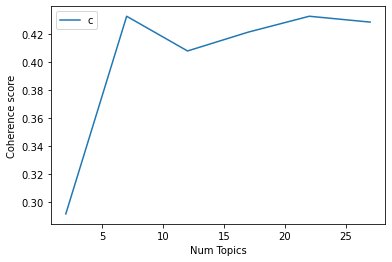

In [163]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_sg_2021_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [164]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_sg_2021_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 7

index: 0 | Num Topics = 2  has Coherence Value of 0.2913
index: 1 | Num Topics = 7  has Coherence Value of 0.4327
index: 2 | Num Topics = 12  has Coherence Value of 0.4079
index: 3 | Num Topics = 17  has Coherence Value of 0.4214
index: 4 | Num Topics = 22  has Coherence Value of 0.4327
index: 5 | Num Topics = 27  has Coherence Value of 0.4285


In [192]:
# Select optimal number of topics
optimal_model_sg_2021_score1N2N3 = model_list_sg_2021_score1N2N3[1]

In [193]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_sg_2021_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_sg_2021_score1N2N3, corpus_sg_2021_score1N2N3, id2word_sg_2021_score1N2N3)

In [194]:
print("pyLDAVis for SG topics for score=1,2,3 in 2021:")
vis_sg_2021_score1N2N3

pyLDAVis for SG topics for score=1,2,3 in 2021:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.201984 -0.053040       1        1  25.048243
6      0.010289 -0.016887       2        1  19.439111
4      0.058542  0.116588       3        1  13.891043
3      0.009960 -0.006522       4        1  13.524903
1      0.100949 -0.146591       5        1  12.289746
2     -0.028089  0.100223       6        1   8.175027
0      0.050333  0.006230       7        1   7.631927, topic_info=           Term       Freq      Total Category  logprob  loglift
42         mode  20.000000  20.000000  Default  30.0000  30.0000
41         dark  19.000000  19.000000  Default  29.0000  29.0000
266     support  43.000000  43.000000  Default  28.0000  28.0000
285       photo  19.000000  19.000000  Default  27.0000  27.0000
623    humanity  22.000000  22.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
126      update   1.522980  26.744841   Topic7  -5.3125  -0.2928
104         pro   1.427689   7.587738   Topic7  -5.3771   0.9024
554     control   1.427641   5.883215   Topic7  -5.3771   1.1568
450  censorship   1.427342   8.576436   Topic7  -5.3773   0.7796
361       swipe   1.427291   4.238400   Topic7  -5.3774   1.4844

[456 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
899       6  0.703821      absolute
995       6  0.703822  accidentally
43        1  0.529395       account
43        2  0.088232       account
43        3  0.205876       account
...     ...       ...           ...
40        7  0.100228         wrong
73        3  0.190620          year
73        4  0.381240          year
73        5  0.190620          year
73        7  0.190620          year

[773 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 5, 4, 2, 3, 1])

# Export pyLDAvis as html

In [195]:
# Overall
pyLDAvis.save_html(vis_sg,'facebook_vis_sg.html')

# By-rating 
pyLDAvis.save_html(vis_sg_score1,'facebook_vis_sg_score1.html')
pyLDAvis.save_html(vis_sg_score2,'facebook_vis_sg_score2.html')
pyLDAvis.save_html(vis_sg_score3,'facebook_vis_sg_score3.html')
pyLDAvis.save_html(vis_sg_score4,'facebook_vis_sg_score4.html')
pyLDAvis.save_html(vis_sg_score5,'facebook_vis_sg_score5.html')
pyLDAvis.save_html(vis_sg_score1N2N3,'facebook_vis_sg_score1N2N3.html')

# By-rating of each year
pyLDAvis.save_html(vis_sg_2021_score1N2N3,'facebook_vis_sg_2021_score1N2N3.html')
pyLDAvis.save_html(vis_sg_2020_score1N2N3,'facebook_vis_sg_2020_score1N2N3.html')
pyLDAvis.save_html(vis_sg_2019_score1N2N3,'facebook_vis_sg_2019_score1N2N3.html')
pyLDAvis.save_html(vis_sg_2018_score1N2N3,'facebook_vis_sg_2018_score1N2N3.html')

